# LIGHTGBM BINARY
https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

Control Params | Core Params | Metric Params | IO Params
-------------- | ----------- | ------------- | ---------
max_depth | task | metric (mae, mse, binary_logloss, multi_logloss) | max_bin
min_data_in_leaf | application (regression, binary, multiclass)| categorical_feature
feature_fraction | boosting (gbdt, rf, dark, goss) | ignore_column
bagging_fraction | num_boost_round | save_binary
early_stopping_round | learning_rate
lambda | num_leaves
min_gain_to_split | device (GPU or CPU)
max_cat_group | 

In [1]:
%load_ext chime
%matplotlib inline

import os
import sys
import logging
from glob import glob
import pickle
import chime
import sqlite3

from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, classification_report
from skimage.exposure import adjust_sigmoid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import rasterio as rio
from rasterio.windows import from_bounds

import pandas as pd
import geopandas as gpd
import numpy as np

from datetime import datetime
import json

import matplotlib.pyplot as plt
import lightgbm as lgb

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from utils import *

import optuna.integration.lightgbm as olgb

import swifter
from shapely.geometry import Point
#from Functions import getSentinelBandFile


In [35]:
"""
def calcMeanDiffs(df, headers):
    #
    #Given a dataframe containing columns of RED, GREEN, BLUE, and NIR, calculate their difference from the mean of the others. Add these new columns to the headers to be used
    #
    df["REDness"] = df.apply(lambda r: calcMeanDiff(r, "RED"), axis=1)
    df["GREENness"] = df.apply(lambda r: calcMeanDiff(r, "GREEN"), axis=1)
    df["BLUEness"] = df.apply(lambda r: calcMeanDiff(r, "BLUE"), axis=1)
    df["NIRness"] = df.apply(lambda r: calcMeanDiff(r, "NIR"), axis=1)
    df["RGBNmean"] = np.nanmean([df["RED"], df["GREEN"], df["BLUE"], df["NIR"]], axis=0)

    if "REDness" not in headers:
        headers += ["REDness", "GREENness", "BLUEness", "NIRness", "BaseMean"]
    return df, headers
"""

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return np.mean(errors), accuracy


def buildModel(params, dataset, features, classCol, fullReport=False, writeOut=False):
    """ Given parameters, a pandas dataframe, a list of feature column names, and the name of the class column"""
    X = dataset[features]
    y = dataset[classCol]
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25, random_state=7)
    train_data = lgb.Dataset(X_train, label=Y_train)
    valid_data = lgb.Dataset(X_valid, label=Y_valid, reference=train_data)
    gbmModel = lgb.LGBMClassifier(**params, metric="custom")
    
    gbmModel.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), eval_metric=evalF1, early_stopping_rounds=50)#, verbose_eval=False)
    
    preds = gbmModel.predict(X_valid)

    scores = {}
    f1 = f1_score(Y_valid, preds, average='weighted')

    scores["F1"] = f1
    
    if fullReport:
        accuracy = accuracy_score(Y_valid, preds)
        kappa = cohen_kappa_score(Y_valid, preds)
        print(f"Model:\n\tAccuracy: {accuracy}\n\tF1: {f1}\n\tCohensKappa: {kappa}")
        print(classification_report(Y_valid, preds, target_names=[k for k,v in values_2019_lookup.items()][:-2]))#
        plotConfusionMatrix(gbmModel, X_valid, Y_valid)
    if writeOut:
        day = datetime.strftime(datetime.now(), "%Y%m%d")
        model_name = f"lightGBM_{day}.sav"
        model_path = os.path.join(os.path.abspath("./Models"), model_name)
        pickle.dump(gbmModel, open(model_path, "wb"))
        params_path = f"./Models/LGBMClassifierParams_{day}.txt"
        with open(params_path, "w+") as txt:
            txt.write(json.dumps(params))
        print(f"Wrote out trained model to \n\t{model_path} and paramameters to \n\t{params_path}")
    
    return gbmModel, scores


def optunaObjective(trial):
    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
    
    search_params = {
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.5),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 10, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
        "num_boost_round": trial.suggest_int("num_boost_round", 25, 400), # change min limit to 25 because best fits were hitting limit of 50 
        "boosting_type": trial.suggest_categorical('boosting_type', ["rf", "gbdt"]), # used dart on previous searches. not best for this
        "n_estimators": trial.suggest_int("n_estimators", 100, 500)
    }
    
    params = {**fixed_params, **search_params}
    scores = []
    for data in subGroups:
        #data = subGroups[i]
        gbm, modelScores = buildModel(params, data, featureHeaders, class_col)
                
        #preds = gbm.predict(X_valid)
        #accuracy = accuracy_score(y_valid, preds)
        #f1 = f1_score(y_valid, preds, average='weighted')
        scores.append(modelScores["F1"])
        
    meanScore = np.mean(scores)
    
    return meanScore


def evaluate_macroF1_lgb(truth, predictions):  
    #pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='weighted')
    return ('macroF1', f1, True) 


def plotConfusionMatrix(model, xValid, yValid):
    labels, counts = np.unique(yValid, return_counts=True)
    pred_lgb = model.predict(xValid)
    cm = confusion_matrix(yValid, pred_lgb, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)


    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           yticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           title='Normalized Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.4f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


def evalF1(y_true, y_pred):
    #https://stackoverflow.com/questions/57222667/light-gbm-early-stopping-does-not-work-for-custom-metric
    # returns (eval_name, eval_result, is_higher_better
    y_pred = y_pred.reshape(len(np.unique(y_true)),-1).argmax(axis=0)
    return 'F1', f1_score(y_true, y_pred, average='weighted'), True


def getCorrelation(df, cortype, threshold=0.1):
    """ Identifies absolute (negative or positive) correlation (cortype) of columns in DF
    and returns all over threshold (threshold) except "LCClassInt """
    cor = df.corr(method=cortype)
    #display(cor[cor.index == "LCClassInt"])
    cor_target = abs(cor["LCClassInt"])
    relevant_features = cor_target[cor_target>threshold]
    #print(f"{len(relevant_features)} features identified over threshold {threshold} using {cortype}")
    relevant_features.sort_values(ascending=False, inplace=True)
    relevant_features.drop(index="LCClassInt", inplace=True)
    
    return relevant_features


def getRelevantFeatures(df, threshold):
    corFeatures = {}
    for cor_type in ('pearson', 'spearman'):
        goodFeatures = getCorrelation(df, cor_type, threshold)
        corFeatures[cor_type] = goodFeatures

    coeff_df = pd.DataFrame.from_dict(corFeatures)
    #coeff_df["PearsonAndSpearman"] = coeff_df.apply(lambda r: pd.notnull(r.pearson) and pd.notnull(r.spearman),axis=1)
    #coeff_df["PearsonOrSpearman"] = coeff_df.apply(lambda r: pd.notnull(r.pearson) or pd.notnull(r.spearman),axis=1)

    spearAndPear = coeff_df[(coeff_df.pearson>threshold) | (coeff_df.spearman>threshold)]
    strongFeatures = spearAndPear.index.tolist()
    print(f"Identified {len(strongFeatures)} features (using Pearson and Spearman) to use in model")
    
    return spearAndPear.index.tolist()


def getOptimumParam(lgbm_study, minimize=True):
    history = lgbm_study.trials_dataframe()
    history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
    # limit trials to those within 1.2x of the best score (assuming lower scores are better)
    best_score = lgbm_study.best_trial.value
    if minimize:
        best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
    else:
        best_performers = history[(history.value>(best_score*0.95))]# & (history.DurationSeconds < seconds_limit)]
        
    optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
    optimum_trial_number = optimum_trial.number.values[0]
    optimum_params = lgbm_study.get_trials()[optimum_trial_number].params
    print(f"optimum_params: {optimum_params}")
    
    return optimum_params


def setOptimumParams(lgbmTuner, minimize):
    for k,v in getOptimumParam(lgbmTuner.study, minimize).items():
        lgbmTuner.lgbm_params[k] = v
    return lgbmTuner


def useOptunaLGBMTuner(trainDataset, validDataset, params, lc_class, suffix, resume=False):
    """ Uses optunas build in tuner for Light GBM.  A bit faster"""
    # Add stream handler of stdout to show the messages
    optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
    storage_name = f"OptunaTuner_Binary_{suffix}"
    
    os.makedirs("../Models", exist_ok=True)
    study_loc = f"../Models/{storage_name}.db"
    storage_loc = f"sqlite:///{study_loc}"
    studyName = f"lightgbm_tuner_{lc_class}_{tday}"
    
    if not resume and os.path.exists(study_loc):
        os.remove(study_loc)
    
    tunerStudy = optuna.create_study(study_name=studyName, direction="minimize", storage=storage_loc, load_if_exists=resume)
    
    tuner = olgb.LightGBMTuner(
            params, train_set=trainDataset, valid_sets=[trainDataset, validDataset], verbose_eval=100,
            optuna_callbacks=[mlflow_callback], study=tunerStudy
        )
    
    print("\nTuning Number of Leaves")
    tuner.tune_num_leaves(n_trials=20)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning feature fraction (1)")
    tuner.tune_feature_fraction(n_trials=20)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning Bagging")
    tuner.tune_bagging(n_trials=10)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning feature fraction (2)")
    tuner.tune_feature_fraction_stage2(n_trials=6)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning Lambdal1 and l2")
    tuner.tune_regularization_factors(n_trials=20)
    #tuner = setOptimumParams(tuner, minimize=True)
    #print("\nTuning Min Data in Leaf")
    #tuner.tune_min_data_in_leaf()
    #tuner = setOptimumParams(tuner, minimize=True)
    
    return tuner

    newModel = lgb.train(tuner.best_params, train_set=trainDataset, valid_sets=[trainDataset, validDataset], verbose_eval=1)
    model_name = f"lightGBMBinary{lc_class}_LGBMTuner_{suffix}.sav"
    model_path = os.path.join(os.path.abspath("../notebooks/Models"), model_name)
    pickle.dump(newModel, open(model_path, "wb"))
    print(f"Wrote out model to {model_path}")
    
    tunerPrediction = np.rint(newModel.predict(X_valid, num_iteration=newModel.best_iteration))
    tunerPrediction = [np.argmax(x) for x in tunerPrediction]
    
    accuracy = accuracy_score(Y_valid, tunerPrediction)
    print(f"Accuracy: {accuracy}")
    print(tuner.best_params)
    
    
    return tunerStudy

In [3]:
trainingSamples_locs = {'PondLake': '../vectors/TrainingData/PondLake_20210519.pickle',
                        'Pool': '../vectors/TrainingData/Pool_20210519.pickle',
                        'DenseVeg': '../vectors/TrainingData/DenseVeg_20210519.pickle',
                        'IrrigatedLand': '../vectors/TrainingData/IrrigatedLand_20210519.pickle',
                        'Asphault': '../vectors/TrainingData/Asphault_20210519.pickle',
                        'Impervious': '../vectors/TrainingData/Impervious_20210519.pickle',
                        'Structure': '../vectors/TrainingData/Structure_20210519.pickle',
                        'Barren': '../vectors/TrainingData/Barren_20210519.pickle',
                        'SparseVeg': '../vectors/TrainingData/SparseVeg_20210519.pickle',
                        'ParkingLot': '../vectors/TrainingData/ParkingLot_20210519.pickle',
                        #'Sidewalk': '../OtherData/TrainingData/Sidewalk_20210519.pickle',
                        'BarrenUrban': '../vectors/TrainingData/BarrenUrban_20211230.pickle'
                       }

values_2019_lookup = {'PondLake': 1, 'Pool': 2, 'Barren': 3, 'SparseVeg': 4, 'DenseVeg': 5,
                      'IrrigatedLand': 6, 'Asphault': 7, 'Impervious': 8, 'Structure': 9,
                      "ParkingLot": 7, "Sidewalk": 8, "BarrenUrban": 3}

for lcclass, fileloc in trainingSamples_locs.items():
    trainingSamples_locs[lcclass] = fileloc.replace("20210519", "20211230")
trainingSamples_locs

trainingSamples_locs

{'PondLake': '../vectors/TrainingData/PondLake_20211230.pickle',
 'Pool': '../vectors/TrainingData/Pool_20211230.pickle',
 'DenseVeg': '../vectors/TrainingData/DenseVeg_20211230.pickle',
 'IrrigatedLand': '../vectors/TrainingData/IrrigatedLand_20211230.pickle',
 'Asphault': '../vectors/TrainingData/Asphault_20211230.pickle',
 'Impervious': '../vectors/TrainingData/Impervious_20211230.pickle',
 'Structure': '../vectors/TrainingData/Structure_20211230.pickle',
 'Barren': '../vectors/TrainingData/Barren_20211230.pickle',
 'SparseVeg': '../vectors/TrainingData/SparseVeg_20211230.pickle',
 'ParkingLot': '../vectors/TrainingData/ParkingLot_20211230.pickle',
 'BarrenUrban': '../vectors/TrainingData/BarrenUrban_20211230.pickle'}

In [4]:
class_col = "LCClassInt"

trainingSamples = []
for lcClass, file in trainingSamples_locs.items():
    df = pd.read_pickle(file)
    if lcClass == "Structure":
        df = df[df.HAG >= 6]
        
    if lcClass == "PondLake" or lcClass == "Pool" or lcClass == "IrrigatedLand" or lcClass == "Impervious" or "Barren" in lcClass or lcClass == "Asphault":
        df = df[df.HAG == 0] 
        
    if lcClass == "PondLake":
        #df = df[df.MSAVI < (120/255)*np.iinfo(np.uint16).max]
        #df = df[df.NDVI < (15/255)*np.iinfo(np.uint16).max]
        df = df[df.MSAVI < (128/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (132/255)*np.iinfo(np.uint16).max]
        
    if lcClass == "Pool":
        #df = df[df.MSAVI < (100/255)*np.iinfo(np.uint16).max]
        #df = df[df.NDVI < (65/255)*np.iinfo(np.uint16).max]
        df = df[df.MSAVI < (128/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (132/255)*np.iinfo(np.uint16).max]
            
    if lcClass == "Asphault" or lcClass == "ParkingLot":
        df.loc[df.NIR >= (100/255)*np.iinfo(np.uint16).max, "LCClass"] = "Impervious"
    
    print(lcClass, len(df))
        
    trainingSamples.append(df)
    
trainingSamples = pd.concat(trainingSamples).reset_index(drop=True)
trainingSamples = trainingSamples[~(trainingSamples.RED == 0) & ~(trainingSamples.GREEN == 0) & ~(trainingSamples.BLUE == 0) & ~(trainingSamples.NIR == 0)]

print(f"{len(trainingSamples)} total samples")

trainingSamples[class_col] = trainingSamples['LCClass'].apply(lambda lcc: values_2019_lookup[lcc])

PondLake 1127531
Pool 1703114
DenseVeg 2020219
IrrigatedLand 1958991
Asphault 1955197
Impervious 1597013
Structure 1800825
Barren 1982592
SparseVeg 2063606
ParkingLot 1452353
BarrenUrban 1612677
19274118 total samples


In [7]:
sentinel_dir = r"R:\ProjectData\PAG2019\Sentinel2Data"
sindicies = ["NDWI", "BSI", "NDVI_", "NDVIa", "DBSI", "NDMI"]
sbands = [2, 3, 4, 5, 6, 7, 8, "8A", 11, 12]

sentinel_bands, sentinel_indicies = {}, {}
for b in sbands:
    band = f"B0{b}" if len(str(b)) == 1 else f"B{b}"
    sentinel_bands[band] = getSentinelBandFile(band, sentinel_dir, suffix="2868")
for index in sindicies:
    sentinel_indicies[index] = getSentinelBandFile(index, sentinel_dir, suffix="2868")
sentinel_bands, sentinel_indicies

({'B02': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B02Mean_20190601to20190901_2868.tif',
  'B03': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B03Mean_20190601to20190901_2868.tif',
  'B04': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B04Mean_20190601to20190901_2868.tif',
  'B05': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B05Mean_20190601to20190901_2868.tif',
  'B06': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B06Mean_20190601to20190901_2868.tif',
  'B07': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B07Mean_20190601to20190901_2868.tif',
  'B08': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B08Mean_20190601to20190901_2868.tif',
  'B8A': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B8AMean_20190601to20190901_2868.tif',
  'B11': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B11Mean_20190601to20190901_2868.tif',
  'B12': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\B12Mean_20190601to20190901_2868.tif'},
 {'NDWI': 'R:\\ProjectData\\PAG2019\\Sentinel2Data\\NDWI_20190601to20190901_2868.tif',
  'BSI': 'R:\\ProjectD

In [27]:
t = trainingSamples_sub.iloc[:10]
with rio.open(file) as src:
    t[column_name] = t["geometry"].apply(lambda g: [g[0] for g in src.sample([(g.x, g.y)], 1)][0])
t

C:\Users\BenJames\AppData\Local\Temp/ipykernel_16108/4266322332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t[column_name] = t["geometry"].apply(lambda g: [g[0] for g in src.sample([(g.x, g.y)], 1)][0])


,RED,GREEN,BLUE,NIR,MSAVI,NDVI,NDPI,REDness,GREENness,BLUEness,...,RED_LHE,GREEN_LHE,BLUE_LHE,NIR_LHE,X,Y,LCClassInt,RGBNmean,geometry,Sentinel2_B02
0,10861,16707,10183,637,24693,3630,41889,33558,37403,33104,...,10,50,28,6,9.588962e+05,533396.177988,1,9597.00,POINT (958896.1920920007 533396.1779879999),97
1,14500,19682,14640,811,22530,3473,43030,34013,37460,34218,...,22,23,13,7,9.297545e+05,527703.264420,1,12408.25,POINT (929754.4588760006 527703.2644199997),743
2,6699,8635,9468,1526,28383,12156,45691,32822,34125,34552,...,0,12,4,20,9.943362e+05,355352.865204,1,6582.00,POINT (994336.1538560009 355352.865203999),250
3,11854,14424,13935,259,23736,1402,45677,33874,35481,35311,...,51,53,77,1,1.009106e+06,442913.891628,1,10118.00,POINT (1009105.839368001 442913.8916279994),290
4,10470,16930,9938,511,24844,3047,42211,33370,37648,33022,...,3,59,24,10,9.588450e+05,533369.603184,1,9462.25,POINT (958845.0109880008 533369.6031839998),51
5,7780,8993,9344,965,27098,7228,44642,33380,34175,34427,...,36,35,35,8,9.529808e+05,315343.021404,1,6770.50,POINT (952980.8375720007 315343.0214039989),140
6,11640,16298,13752,402,23985,2188,45579,33313,36460,34802,...,90,84,91,10,1.004564e+06,430765.269192,1,10523.00,POINT (1004563.516388001 430765.2691919994),168
7,26283,27258,27135,11672,23802,20152,38567,34878,35450,35370,...,157,186,218,25,9.580379e+05,410431.607124,1,23087.00,POINT (958037.9243480007 410431.6071239993),177
8,10792,13953,8303,1363,25335,7346,37839,34212,36299,32522,...,9,17,6,4,1.076502e+06,387787.905612,1,8602.75,POINT (1076501.510816001 387787.9056119992),268
9,11057,13951,10894,1525,25289,7942,41542,33850,35663,33572,...,19,21,18,2,9.520360e+05,315526.092276,1,9356.75,POINT (952035.9556520007 315526.0922759988),1047


In [29]:
%%time

trainingFeaturesToUse = trainingSamples.columns.tolist()
trainingFeaturesToUse.remove("LCClass")
trainingFeaturesToUse.remove("LCClassInt")

subGroups = []
sampleSize = 20000
overwrite = False
#sampleSize = min(10**6, trainingSamples.LCClassInt.value_counts().min()) # large sample size did not improve classification
subSampleFile_template = f"../vectors/TrainingData/SubSampleGroup%s_{sampleSize}.pickle"
sentinel_prefix = "Sentinel2_"

for i in range(5):
    start = datetime.now()
    subSampleFile = subSampleFile_template % i
    if not os.path.exists(subSampleFile) or overwrite:
        trainingSamples_sub = getSubSample(data=trainingSamples, maxSampSize=sampleSize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
        trainingSamples_sub["RGBNmean"] = trainingSamples_sub.swifter.apply(lambda r: np.nanmean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)
        trainingSamples_sub["geometry"] = trainingSamples_sub.swifter.apply(lambda r: Point(r.X, r.Y), axis=1)
        for files_dict in [sentinel_bands, sentinel_indicies]:
            for name, file in files_dict.items():
                column_name = f"{sentinel_prefix}{name}"
                print(f"Working {column_name}")
                with rio.open(file) as src:
                    trainingSamples_sub[column_name] = trainingSamples_sub["geometry"].apply(lambda g: [g[0] for g in src.sample([(g.x, g.y)], 1)][0])
                    
        del trainingSamples_sub["X"], trainingSamples_sub["Y"], trainingSamples_sub["geometry"]
        trainingSamples_sub.to_pickle(subSampleFile)
    else:
        trainingSamples_sub = pd.read_pickle(subSampleFile)

    subGroups.append(trainingSamples_sub)
    print(f"Done {i} - {datetime.now()-start}")


%chime
trainingFeaturesToUse = subGroups[0].columns.tolist()
trainingFeaturesToUse.remove("LCClassInt")
featureHeaders = trainingFeaturesToUse[:]
featureHeaders


Working Sentinel2_B02
Working Sentinel2_B03
Working Sentinel2_B04
Working Sentinel2_B05
Working Sentinel2_B06
Working Sentinel2_B07
Working Sentinel2_B08
Working Sentinel2_B8A
Working Sentinel2_B11
Working Sentinel2_B12
Working Sentinel2_NDWI
Working Sentinel2_BSI
Working Sentinel2_NDVI_
Working Sentinel2_NDVIa
Working Sentinel2_DBSI
Working Sentinel2_NDMI
Done 0 - 0:04:17.800514



Working Sentinel2_B02
Working Sentinel2_B03
Working Sentinel2_B04
Working Sentinel2_B05
Working Sentinel2_B06
Working Sentinel2_B07
Working Sentinel2_B08
Working Sentinel2_B8A
Working Sentinel2_B11
Working Sentinel2_B12
Working Sentinel2_NDWI
Working Sentinel2_BSI
Working Sentinel2_NDVI_
Working Sentinel2_NDVIa
Working Sentinel2_DBSI
Working Sentinel2_NDMI
Done 1 - 0:04:08.778171



Working Sentinel2_B02
Working Sentinel2_B03
Working Sentinel2_B04
Working Sentinel2_B05
Working Sentinel2_B06
Working Sentinel2_B07
Working Sentinel2_B08
Working Sentinel2_B8A
Working Sentinel2_B11
Working Sentinel2_B12
Working Sentinel2_NDWI
Working Sentinel2_BSI
Working Sentinel2_NDVI_
Working Sentinel2_NDVIa
Working Sentinel2_DBSI
Working Sentinel2_NDMI
Done 2 - 0:04:04.711503



Working Sentinel2_B02
Working Sentinel2_B03
Working Sentinel2_B04
Working Sentinel2_B05
Working Sentinel2_B06
Working Sentinel2_B07
Working Sentinel2_B08
Working Sentinel2_B8A
Working Sentinel2_B11
Working Sentinel2_B12
Working Sentinel2_NDWI
Working Sentinel2_BSI
Working Sentinel2_NDVI_
Working Sentinel2_NDVIa
Working Sentinel2_DBSI
Working Sentinel2_NDMI
Done 3 - 0:04:02.845900



Working Sentinel2_B02
Working Sentinel2_B03
Working Sentinel2_B04
Working Sentinel2_B05
Working Sentinel2_B06
Working Sentinel2_B07
Working Sentinel2_B08
Working Sentinel2_B8A
Working Sentinel2_B11
Working Sentinel2_B12
Working Sentinel2_NDWI
Working Sentinel2_BSI
Working Sentinel2_NDVI_
Working Sentinel2_NDVIa
Working Sentinel2_DBSI
Working Sentinel2_NDMI
Done 4 - 0:04:03.578113
Wall time: 20min 37s


['RED',
 'GREEN',
 'BLUE',
 'NIR',
 'MSAVI',
 'NDVI',
 'NDPI',
 'REDness',
 'GREENness',
 'BLUEness',
 'NIRness',
 'HAG',
 'DPR',
 'GaussianSigma2_RED',
 'GaussianSigma2_GREEN',
 'GaussianSigma2_BLUE',
 'GaussianSigma2_NIR',
 'GaussianSigma5_RED',
 'GaussianSigma5_GREEN',
 'GaussianSigma5_BLUE',
 'GaussianSigma5_NIR',
 'Segment_area',
 'Segment_extent',
 'Segment_eccentricity',
 'Segment_perimeter',
 'RED_LHE',
 'GREEN_LHE',
 'BLUE_LHE',
 'NIR_LHE',
 'RGBNmean',
 'Sentinel2_B02',
 'Sentinel2_B03',
 'Sentinel2_B04',
 'Sentinel2_B05',
 'Sentinel2_B06',
 'Sentinel2_B07',
 'Sentinel2_B08',
 'Sentinel2_B8A',
 'Sentinel2_B11',
 'Sentinel2_B12',
 'Sentinel2_NDWI',
 'Sentinel2_BSI',
 'Sentinel2_NDVI_',
 'Sentinel2_NDVIa',
 'Sentinel2_DBSI',
 'Sentinel2_NDMI']

In [30]:
local_class_weight_dict = {'PondLake': 0.02, # dropped to 0.01 from 0.02 on 2021-10-28
                           'Pool': 0.025, # dropped to 0.025 from 0.1 on 2021-10-28
                           'Barren': 42, # raising to  40 from 24 on 2021-06-14, and again to 35 from 29 on 2021-08-28
                           'SparseVeg': 25, # rasing to 20 from 18 on 2021-08-28
                           'DenseVeg': 10.47, # dropping to 10 from 15 on 2021-08-28
                           'IrrigatedLand': 0.5, # dropping to 0.5 from 3 on 2021-08-28
                           'Asphault': 11, 
                           'Impervious': 3, # dropping to 3 from 14 on 2021-06-14, and again to 5 from 9 on 2021-08-28
                           'Structure': 8} # dropping to 8 from 14.88 on 2021-08-28

# replace human readable names with numerical associations
#local_class_weight_dict = { values_2019_lookup[k]: v/100 for k, v in local_class_weight_dict.items() }

print(f"Sum of weights: {np.sum([v for v in local_class_weight_dict.values()])}")

Sum of weights: 100.015


In [8]:
local_class_weight_dict = {'PondLake': 0.02, # dropped to 0.01 from 0.02 on 2021-10-28
                           'Pool': 0.01, # dropped to 0.025 from 0.1 on 2021-10-28
                           'Barren': 26, # raising to  40 from 24 on 2021-06-14, and again to 35 from 29 on 2021-08-28
                           'SparseVeg': 24.47, # rasing to 20 from 18 on 2021-08-28
                           'DenseVeg': 15, # dropping to 10 from 15 on 2021-08-28
                           'IrrigatedLand': 2.5, # dropping to 0.5 from 3 on 2021-08-28
                           'Asphault': 15, 
                           'Impervious': 7, # dropping to 3 from 14 on 2021-06-14, and again to 5 from 9 on 2021-08-28
                           'Structure': 10} # dropping to 8 from 14.88 on 2021-08-28
print(f"Sum of weights: {np.sum([v for v in local_class_weight_dict.values()])}")

Sum of weights: 100.0


In [10]:
#trainingSamples_sub[(trainingSamples_sub.LCClassInt == 8)]

In [32]:
def normalizeNess(df):
    #for b in ["RED", "GREEN", "BLUE", "NIR"]:
    df.reset_index(drop=True, inplace=True)
    df["REDnessNorm"]   = df.swifter.apply(lambda r: ( (r.RED - np.nanmean([r.GREEN, r.BLUE, r.NIR])) / (r.RED + np.nanmean([r.GREEN, r.BLUE, r.NIR])) ), axis=1)
    df["GREENnessNorm"] = df.swifter.apply(lambda r: ( (r.GREEN - np.nanmean([r.RED, r.BLUE, r.NIR])) / (r.GREEN + np.nanmean([r.RED, r.BLUE, r.NIR])) ), axis=1)
    df["BLUEnessNorm"]  = df.swifter.apply(lambda r: ( (r.BLUE - np.nanmean([r.GREEN, r.RED, r.NIR])) / (r.BLUE + np.nanmean([r.GREEN, r.RED, r.NIR])) ), axis=1)
    df["NIRnessNorm"]   = df.swifter.apply(lambda r: ( (r.NIR - np.nanmean([r.GREEN, r.BLUE, r.RED])) / (r.NIR + np.nanmean([r.GREEN, r.BLUE, r.RED])) ), axis=1)
    
    return df

In [36]:
import mlflow
import optuna
import optuna.integration.lightgbm as olgb


def mlflow_callback(study, trial):
    trial_value = trial.value if trial.value is not None else float("nan")

    trial_runtime = float("nan")
    if trial.datetime_start and trial.datetime_complete:
        trial_runtime = (trial.datetime_complete - trial.datetime_start).total_seconds()
    
    with mlflow.start_run(run_name=study.study_name):
        mlflow.log_params(trial.params)
        #mlflow.log_params({"step_name": trial.user_attrs["lightgbm_tuner:step_number"]})
        
        mlflow.log_metrics({
            "trial_number": trial.number,
            "elapsed_time": trial_runtime,
            "mean_squared_error": trial_value,
        })
                          
#sampleSize = 500000
#trainingFeaturesToUse = trainingSamples.columns.tolist()
#trainingFeaturesToUse.remove("LCClass")
#trainingFeaturesToUse.remove("LCClassInt")
#trainingFeaturesToUse.remove("X")
#trainingFeaturesToUse.remove("Y")
#trainingSamples_sub = getSubSample(data=trainingSamples, maxSampSize=sampleSize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
#trainingSamples_sub["RGBNmean"] = np.nanmean([trainingSamples_sub["RED"], trainingSamples_sub["GREEN"], trainingSamples_sub["BLUE"], trainingSamples_sub["NIR"]], axis=0)
#trainingFeaturesToUse.append("RGBNmean")

# Segment area was shown to be high-leverage and inaccurate for binary classification of asphault (2021-06-16)

trainingSamples_sub = pd.concat(subGroups)
print("Creating Normalized Ness Data Column")
trainingSamples_sub = normalizeNess(trainingSamples_sub)
trainingFeaturesToUse = trainingSamples_sub.columns.tolist()
trainingFeaturesToUse.remove("LCClassInt")

sampleSize = len(trainingSamples_sub)/9

values_2019_lookup = {"PondLake": 1,
                      "Pool": 2,
                      "Barren": 3,
                      "SparseVeg": 4,
                      "DenseVeg": 5,
                      "IrrigatedLand": 6,
                      "Asphault": 7,
                      "Impervious": 8,
                      "Structure": 9}


#print("Training Features:\n", trainingFeaturesToUse)
allGoodFeatures = {}
studies = {}
tday = datetime.now().strftime("%Y%m%d")

for k,v in values_2019_lookup.items():
    start = datetime.now()
    #if k != "Barren":
    #    continue
    print(f"\n\nStarting {k}")
    
    classTrainingFeaturesToUse = trainingFeaturesToUse[:]
    if k == "Asphault":
        classTrainingFeaturesToUse.remove("Segment_area") 
        #classTrainingFeaturesToUse.remove("HAG")  ## testing this
    elif k == "Structure":
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "GaussianSigma5_" not in feat]
    elif k == "PondLake":
        #classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "Segment_" not in feat]
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "Sentinel2_" not in feat]
    elif k == "Pool":
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "GaussianSigma" not in feat and "Sentinel2_" not in feat]
    elif k == "DenseVeg" or k == "SparseVeg" or k=="Impervious":
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "GaussianSigma_5" not in feat and "Sentinel2_" not in feat]
    
    start = datetime.now()

    print(f"Starting training of binary model for {k}")
    dataset = trainingSamples_sub.copy()
    dataset.dropna(inplace=True)
    # separate all training into binary structure and not
    dataset[class_col] = dataset[class_col].apply(lambda cc: 1 if cc == v else 0)
    
    strongFeatures = getRelevantFeatures(dataset[classTrainingFeaturesToUse + [class_col]], threshold=0.01)
    print(f"Using features\n\t{', '.join(strongFeatures)}")
    allGoodFeatures[k] = strongFeatures
    
    scale_pos_weight = local_class_weight_dict[k] / (100-local_class_weight_dict[k])
    
    X = dataset[strongFeatures]
    y = dataset[class_col]
    
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25, random_state=7)

    dtrain = lgb.Dataset(X_train, label=Y_train)
    dval = lgb.Dataset(X_valid, label=Y_valid)
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        #"bagging_fraction": 0.7, # tune_bagging tunes bagging_fraction and frequency (2021-11-29)
        "min_child_samples": 20,  #int(0.005*sampleSize),
        "early_stopping_round": 200,
        "n_jobs": 8,
        "scale_pos_weight": scale_pos_weight,
        "num_iterations": 100,  # added on 2021-11-29
        
    }
    
    #study = useOptunaOptunaObjective(dtrain, dval, k)
    study = useOptunaLGBMTuner(dtrain, dval, params=params, lc_class=k, suffix=tday, resume=False)
    
    studies[k]=study
    print(f"CREATED BINARY MODEL FOR LC Class {k}\nTook: {datetime.now()-start}\n\n\n")

    
chime.theme("zelda")
chime.success()

Creating Normalized Ness Data Column





Starting PondLake
Starting training of binary model for PondLake
Identified 34 features (using Pearson and Spearman) to use in model
Using features
	BLUE, BLUE_LHE, BLUEness, BLUEnessNorm, DPR, GREEN, GREEN_LHE, GREENness, GREENnessNorm, GaussianSigma2_BLUE, GaussianSigma2_GREEN, GaussianSigma2_NIR, GaussianSigma2_RED, GaussianSigma5_BLUE, GaussianSigma5_GREEN, GaussianSigma5_NIR, GaussianSigma5_RED, HAG, MSAVI, NDPI, NDVI, NIR, NIR_LHE, NIRness, NIRnessNorm, RED, RED_LHE, REDness, REDnessNorm, RGBNmean, Segment_area, Segment_eccentricity, Segment_extent, Segment_perimeter


[I 2022-01-01 09:00:22,988] A new study created in RDB with name: lightgbm_tuner_PondLake_20220101


A new study created in RDB with name: lightgbm_tuner_PondLake_20220101
A new study created in RDB with name: lightgbm_tuner_PondLake_20220101


num_leaves, val_score: inf:   0%|                                                                                                    | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027859:   5%|####3                                                                                  | 1/20 [00:05<01:39,  5.23s/it]

[100]	valid_0's binary_logloss: 0.019094	valid_1's binary_logloss: 0.0278593
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.019094	valid_1's binary_logloss: 0.0278593


[I 2022-01-01 09:00:28,402] Trial 0 finished with value: 0.027859308673387567 and parameters: {'num_leaves': 248}. Best is trial 0 with value: 0.027859308673387567.


Trial 0 finished with value: 0.027859308673387567 and parameters: {'num_leaves': 248}. Best is trial 0 with value: 0.027859308673387567.
Trial 0 finished with value: 0.027859308673387567 and parameters: {'num_leaves': 248}. Best is trial 0 with value: 0.027859308673387567.


num_leaves, val_score: 0.027859:   5%|####3                                                                                  | 1/20 [00:05<01:39,  5.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027859:  10%|########7                                                                              | 2/20 [00:10<01:36,  5.37s/it][I 2022-01-01 09:00:34,034] Trial 1 finished with value: 0.028265783326578628 and parameters: {'num_leaves': 245}. Best is trial 0 with value: 0.027859308673387567.


[100]	valid_0's binary_logloss: 0.0196045	valid_1's binary_logloss: 0.0282658
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0196045	valid_1's binary_logloss: 0.0282658
Trial 1 finished with value: 0.028265783326578628 and parameters: {'num_leaves': 245}. Best is trial 0 with value: 0.027859308673387567.
Trial 1 finished with value: 0.028265783326578628 and parameters: {'num_leaves': 245}. Best is trial 0 with value: 0.027859308673387567.


num_leaves, val_score: 0.027859:  10%|########7                                                                              | 2/20 [00:11<01:36,  5.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027859:  15%|#############                                                                          | 3/20 [00:14<01:19,  4.68s/it][I 2022-01-01 09:00:37,142] Trial 2 finished with value: 0.13985099874510076 and parameters: {'num_leaves': 10}. Best is trial 0 with value: 0.027859308673387567.


[100]	valid_0's binary_logloss: 0.137165	valid_1's binary_logloss: 0.14075
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.13646	valid_1's binary_logloss: 0.139851
Trial 2 finished with value: 0.13985099874510076 and parameters: {'num_leaves': 10}. Best is trial 0 with value: 0.027859308673387567.
Trial 2 finished with value: 0.13985099874510076 and parameters: {'num_leaves': 10}. Best is trial 0 with value: 0.027859308673387567.


num_leaves, val_score: 0.027859:  15%|#############                                                                          | 3/20 [00:14<01:19,  4.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027859:  20%|#################4                                                                     | 4/20 [00:17<01:10,  4.39s/it]

[100]	valid_0's binary_logloss: 0.0615365	valid_1's binary_logloss: 0.0661488
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0615365	valid_1's binary_logloss: 0.0661488


[I 2022-01-01 09:00:40,925] Trial 3 finished with value: 0.06614881721463123 and parameters: {'num_leaves': 46}. Best is trial 0 with value: 0.027859308673387567.


Trial 3 finished with value: 0.06614881721463123 and parameters: {'num_leaves': 46}. Best is trial 0 with value: 0.027859308673387567.
Trial 3 finished with value: 0.06614881721463123 and parameters: {'num_leaves': 46}. Best is trial 0 with value: 0.027859308673387567.


num_leaves, val_score: 0.027859:  20%|#################4                                                                     | 4/20 [00:17<01:10,  4.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  25%|#####################7                                                                 | 5/20 [00:23<01:11,  4.75s/it]

[100]	valid_0's binary_logloss: 0.0187638	valid_1's binary_logloss: 0.027162
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0187638	valid_1's binary_logloss: 0.027162


[I 2022-01-01 09:00:46,432] Trial 4 finished with value: 0.027161986051110434 and parameters: {'num_leaves': 249}. Best is trial 4 with value: 0.027161986051110434.


Trial 4 finished with value: 0.027161986051110434 and parameters: {'num_leaves': 249}. Best is trial 4 with value: 0.027161986051110434.
Trial 4 finished with value: 0.027161986051110434 and parameters: {'num_leaves': 249}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  25%|#####################7                                                                 | 5/20 [00:23<01:11,  4.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  30%|##########################1                                                            | 6/20 [00:28<01:07,  4.79s/it][I 2022-01-01 09:00:51,297] Trial 5 finished with value: 0.033721131305612995 and parameters: {'num_leaves': 169}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0257634	valid_1's binary_logloss: 0.0337211
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0257634	valid_1's binary_logloss: 0.0337211
Trial 5 finished with value: 0.033721131305612995 and parameters: {'num_leaves': 169}. Best is trial 4 with value: 0.027161986051110434.
Trial 5 finished with value: 0.033721131305612995 and parameters: {'num_leaves': 169}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  30%|##########################1                                                            | 6/20 [00:28<01:07,  4.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  35%|##############################4                                                        | 7/20 [00:33<01:04,  4.97s/it][I 2022-01-01 09:00:56,682] Trial 6 finished with value: 0.028966193203635453 and parameters: {'num_leaves': 226}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0205362	valid_1's binary_logloss: 0.0289662
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0205362	valid_1's binary_logloss: 0.0289662
Trial 6 finished with value: 0.028966193203635453 and parameters: {'num_leaves': 226}. Best is trial 4 with value: 0.027161986051110434.
Trial 6 finished with value: 0.028966193203635453 and parameters: {'num_leaves': 226}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  35%|##############################4                                                        | 7/20 [00:33<01:04,  4.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  40%|##################################8                                                    | 8/20 [00:38<00:59,  4.93s/it][I 2022-01-01 09:01:01,540] Trial 7 finished with value: 0.03478168954294831 and parameters: {'num_leaves': 162}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.026229	valid_1's binary_logloss: 0.0347817
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.026229	valid_1's binary_logloss: 0.0347817
Trial 7 finished with value: 0.03478168954294831 and parameters: {'num_leaves': 162}. Best is trial 4 with value: 0.027161986051110434.
Trial 7 finished with value: 0.03478168954294831 and parameters: {'num_leaves': 162}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  40%|##################################8                                                    | 8/20 [00:38<00:59,  4.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  45%|#######################################1                                               | 9/20 [00:43<00:56,  5.11s/it][I 2022-01-01 09:01:07,046] Trial 8 finished with value: 0.02848437352779948 and parameters: {'num_leaves': 241}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0195975	valid_1's binary_logloss: 0.0284844
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0195975	valid_1's binary_logloss: 0.0284844
Trial 8 finished with value: 0.02848437352779948 and parameters: {'num_leaves': 241}. Best is trial 4 with value: 0.027161986051110434.
Trial 8 finished with value: 0.02848437352779948 and parameters: {'num_leaves': 241}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  45%|#######################################1                                               | 9/20 [00:44<00:56,  5.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  50%|###########################################                                           | 10/20 [00:48<00:50,  5.03s/it][I 2022-01-01 09:01:11,874] Trial 9 finished with value: 0.03400961832030719 and parameters: {'num_leaves': 168}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0257266	valid_1's binary_logloss: 0.0340096
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0257266	valid_1's binary_logloss: 0.0340096
Trial 9 finished with value: 0.03400961832030719 and parameters: {'num_leaves': 168}. Best is trial 4 with value: 0.027161986051110434.
Trial 9 finished with value: 0.03400961832030719 and parameters: {'num_leaves': 168}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  50%|###########################################                                           | 10/20 [00:48<00:50,  5.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  55%|###############################################3                                      | 11/20 [00:52<00:42,  4.72s/it]

[100]	valid_0's binary_logloss: 0.044347	valid_1's binary_logloss: 0.050234
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.044347	valid_1's binary_logloss: 0.050234


[I 2022-01-01 09:01:15,993] Trial 10 finished with value: 0.05023398622512712 and parameters: {'num_leaves': 76}. Best is trial 4 with value: 0.027161986051110434.


Trial 10 finished with value: 0.05023398622512712 and parameters: {'num_leaves': 76}. Best is trial 4 with value: 0.027161986051110434.
Trial 10 finished with value: 0.05023398622512712 and parameters: {'num_leaves': 76}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  55%|###############################################3                                      | 11/20 [00:53<00:42,  4.72s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  60%|###################################################6                                  | 12/20 [00:58<00:39,  4.88s/it][I 2022-01-01 09:01:21,124] Trial 11 finished with value: 0.03062888175753701 and parameters: {'num_leaves': 204}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0224878	valid_1's binary_logloss: 0.0306289
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0224878	valid_1's binary_logloss: 0.0306289
Trial 11 finished with value: 0.03062888175753701 and parameters: {'num_leaves': 204}. Best is trial 4 with value: 0.027161986051110434.
Trial 11 finished with value: 0.03062888175753701 and parameters: {'num_leaves': 204}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  60%|###################################################6                                  | 12/20 [00:58<00:39,  4.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  65%|#######################################################9                              | 13/20 [01:02<00:33,  4.78s/it][I 2022-01-01 09:01:25,678] Trial 12 finished with value: 0.04397299678617653 and parameters: {'num_leaves': 104}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0369093	valid_1's binary_logloss: 0.043973
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0369093	valid_1's binary_logloss: 0.043973
Trial 12 finished with value: 0.04397299678617653 and parameters: {'num_leaves': 104}. Best is trial 4 with value: 0.027161986051110434.
Trial 12 finished with value: 0.04397299678617653 and parameters: {'num_leaves': 104}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  65%|#######################################################9                              | 13/20 [01:02<00:33,  4.78s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  70%|############################################################2                         | 14/20 [01:07<00:29,  4.87s/it][I 2022-01-01 09:01:30,770] Trial 13 finished with value: 0.030367745120466735 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0220857	valid_1's binary_logloss: 0.0303677
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0220857	valid_1's binary_logloss: 0.0303677
Trial 13 finished with value: 0.030367745120466735 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.027161986051110434.
Trial 13 finished with value: 0.030367745120466735 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  70%|############################################################2                         | 14/20 [01:07<00:29,  4.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  75%|################################################################5                     | 15/20 [01:13<00:25,  5.09s/it][I 2022-01-01 09:01:36,369] Trial 14 finished with value: 0.02754051403229553 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0188018	valid_1's binary_logloss: 0.0275405
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0188018	valid_1's binary_logloss: 0.0275405
Trial 14 finished with value: 0.02754051403229553 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.027161986051110434.
Trial 14 finished with value: 0.02754051403229553 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  75%|################################################################5                     | 15/20 [01:13<00:25,  5.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  80%|####################################################################8                 | 16/20 [01:17<00:19,  4.97s/it][I 2022-01-01 09:01:41,077] Trial 15 finished with value: 0.037312635363449184 and parameters: {'num_leaves': 139}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0296326	valid_1's binary_logloss: 0.0373126
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0296326	valid_1's binary_logloss: 0.0373126
Trial 15 finished with value: 0.037312635363449184 and parameters: {'num_leaves': 139}. Best is trial 4 with value: 0.027161986051110434.
Trial 15 finished with value: 0.037312635363449184 and parameters: {'num_leaves': 139}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  80%|####################################################################8                 | 16/20 [01:18<00:19,  4.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  85%|#########################################################################1            | 17/20 [01:23<00:15,  5.02s/it][I 2022-01-01 09:01:46,193] Trial 16 finished with value: 0.030367745120466735 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0220857	valid_1's binary_logloss: 0.0303677
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0220857	valid_1's binary_logloss: 0.0303677
Trial 16 finished with value: 0.030367745120466735 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.027161986051110434.
Trial 16 finished with value: 0.030367745120466735 and parameters: {'num_leaves': 206}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  85%|#########################################################################1            | 17/20 [01:23<00:15,  5.02s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  90%|#############################################################################4        | 18/20 [01:28<00:10,  5.02s/it][I 2022-01-01 09:01:51,219] Trial 17 finished with value: 0.031480319815009906 and parameters: {'num_leaves': 194}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0231171	valid_1's binary_logloss: 0.0314803
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0231171	valid_1's binary_logloss: 0.0314803
Trial 17 finished with value: 0.031480319815009906 and parameters: {'num_leaves': 194}. Best is trial 4 with value: 0.027161986051110434.
Trial 17 finished with value: 0.031480319815009906 and parameters: {'num_leaves': 194}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  90%|#############################################################################4        | 18/20 [01:28<00:10,  5.02s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162:  95%|#################################################################################7    | 19/20 [01:32<00:04,  4.82s/it][I 2022-01-01 09:01:55,576] Trial 18 finished with value: 0.0418906834064416 and parameters: {'num_leaves': 112}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0346179	valid_1's binary_logloss: 0.0418907
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0346179	valid_1's binary_logloss: 0.0418907
Trial 18 finished with value: 0.0418906834064416 and parameters: {'num_leaves': 112}. Best is trial 4 with value: 0.027161986051110434.
Trial 18 finished with value: 0.0418906834064416 and parameters: {'num_leaves': 112}. Best is trial 4 with value: 0.027161986051110434.


num_leaves, val_score: 0.027162:  95%|#################################################################################7    | 19/20 [01:32<00:04,  4.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.027162: 100%|######################################################################################| 20/20 [01:37<00:00,  5.03s/it][I 2022-01-01 09:02:01,110] Trial 19 finished with value: 0.02754051403229553 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0188018	valid_1's binary_logloss: 0.0275405
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0188018	valid_1's binary_logloss: 0.0275405
Trial 19 finished with value: 0.02754051403229553 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.027161986051110434.
Trial 19 finished with value: 0.02754051403229553 and parameters: {'num_leaves': 252}. Best is trial 4 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:   0%|                                                                                         | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning feature fraction (1)
Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:   5%|####                                                                             | 1/20 [00:04<01:20,  4.25s/it][I 2022-01-01 09:02:05,493] Trial 20 finished with value: 0.03804782948820752 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.03804782948820752.


[100]	valid_0's binary_logloss: 0.0291523	valid_1's binary_logloss: 0.0380478
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0291523	valid_1's binary_logloss: 0.0380478
Trial 20 finished with value: 0.03804782948820752 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.03804782948820752.
Trial 20 finished with value: 0.03804782948820752 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.03804782948820752.


feature_fraction, val_score: 0.027162:   5%|####                                                                             | 1/20 [00:04<01:20,  4.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  10%|########1                                                                        | 2/20 [00:09<01:20,  4.50s/it][I 2022-01-01 09:02:10,566] Trial 21 finished with value: 0.02771608256913768 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.02771608256913768.


[100]	valid_0's binary_logloss: 0.0191742	valid_1's binary_logloss: 0.0277161
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0191742	valid_1's binary_logloss: 0.0277161
Trial 21 finished with value: 0.02771608256913768 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.02771608256913768.
Trial 21 finished with value: 0.02771608256913768 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.02771608256913768.


feature_fraction, val_score: 0.027162:  10%|########1                                                                        | 2/20 [00:09<01:20,  4.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  15%|############1                                                                    | 3/20 [00:13<01:16,  4.47s/it][I 2022-01-01 09:02:14,999] Trial 22 finished with value: 0.032503552104641543 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.02771608256913768.


[100]	valid_0's binary_logloss: 0.023884	valid_1's binary_logloss: 0.0325036
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.023884	valid_1's binary_logloss: 0.0325036
Trial 22 finished with value: 0.032503552104641543 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.02771608256913768.
Trial 22 finished with value: 0.032503552104641543 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 21 with value: 0.02771608256913768.


feature_fraction, val_score: 0.027162:  15%|############1                                                                    | 3/20 [00:13<01:16,  4.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  20%|################2                                                                | 4/20 [00:18<01:14,  4.64s/it][I 2022-01-01 09:02:20,010] Trial 23 finished with value: 0.027161986051110434 and parameters: {'feature_fraction': 1.0}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0187638	valid_1's binary_logloss: 0.027162
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0187638	valid_1's binary_logloss: 0.027162
Trial 23 finished with value: 0.027161986051110434 and parameters: {'feature_fraction': 1.0}. Best is trial 23 with value: 0.027161986051110434.
Trial 23 finished with value: 0.027161986051110434 and parameters: {'feature_fraction': 1.0}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  20%|################2                                                                | 4/20 [00:19<01:14,  4.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  25%|####################2                                                            | 5/20 [00:22<01:06,  4.45s/it][I 2022-01-01 09:02:24,029] Trial 24 finished with value: 0.03578023546883348 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0272924	valid_1's binary_logloss: 0.0357802
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0272924	valid_1's binary_logloss: 0.0357802
Trial 24 finished with value: 0.03578023546883348 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 23 with value: 0.027161986051110434.
Trial 24 finished with value: 0.03578023546883348 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  25%|####################2                                                            | 5/20 [00:23<01:06,  4.45s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  30%|########################3                                                        | 6/20 [00:27<01:02,  4.49s/it][I 2022-01-01 09:02:28,608] Trial 25 finished with value: 0.0294003529627335 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0205942	valid_1's binary_logloss: 0.0294004
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0205942	valid_1's binary_logloss: 0.0294004
Trial 25 finished with value: 0.0294003529627335 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 23 with value: 0.027161986051110434.
Trial 25 finished with value: 0.0294003529627335 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  30%|########################3                                                        | 6/20 [00:27<01:02,  4.49s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  35%|############################3                                                    | 7/20 [00:32<01:01,  4.72s/it][I 2022-01-01 09:02:33,872] Trial 26 finished with value: 0.02777457662189326 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0191203	valid_1's binary_logloss: 0.0277746
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0191203	valid_1's binary_logloss: 0.0277746
Trial 26 finished with value: 0.02777457662189326 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 23 with value: 0.027161986051110434.
Trial 26 finished with value: 0.02777457662189326 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  35%|############################3                                                    | 7/20 [00:32<01:01,  4.72s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  40%|################################4                                                | 8/20 [00:37<00:55,  4.64s/it][I 2022-01-01 09:02:38,313] Trial 27 finished with value: 0.034092250541802725 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0252872	valid_1's binary_logloss: 0.0340923
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0252872	valid_1's binary_logloss: 0.0340923
Trial 27 finished with value: 0.034092250541802725 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 23 with value: 0.027161986051110434.
Trial 27 finished with value: 0.034092250541802725 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  40%|################################4                                                | 8/20 [00:37<00:55,  4.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  45%|####################################4                                            | 9/20 [00:41<00:50,  4.58s/it][I 2022-01-01 09:02:42,745] Trial 28 finished with value: 0.03140284396599353 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0229111	valid_1's binary_logloss: 0.0314028
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0229111	valid_1's binary_logloss: 0.0314028
Trial 28 finished with value: 0.03140284396599353 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 23 with value: 0.027161986051110434.
Trial 28 finished with value: 0.03140284396599353 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  45%|####################################4                                            | 9/20 [00:41<00:50,  4.58s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  50%|########################################                                        | 10/20 [00:46<00:45,  4.60s/it][I 2022-01-01 09:02:47,384] Trial 29 finished with value: 0.02816909666888049 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0194628	valid_1's binary_logloss: 0.0281691
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0194628	valid_1's binary_logloss: 0.0281691
Trial 29 finished with value: 0.02816909666888049 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 23 with value: 0.027161986051110434.
Trial 29 finished with value: 0.02816909666888049 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  50%|########################################                                        | 10/20 [00:46<00:45,  4.60s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  55%|############################################                                    | 11/20 [00:51<00:42,  4.73s/it][I 2022-01-01 09:02:52,439] Trial 30 finished with value: 0.027852909806098825 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0192283	valid_1's binary_logloss: 0.0278529
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0192283	valid_1's binary_logloss: 0.0278529
Trial 30 finished with value: 0.027852909806098825 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 23 with value: 0.027161986051110434.
Trial 30 finished with value: 0.027852909806098825 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  55%|############################################                                    | 11/20 [00:51<00:42,  4.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  60%|################################################                                | 12/20 [00:56<00:38,  4.83s/it]

[100]	valid_0's binary_logloss: 0.0200088	valid_1's binary_logloss: 0.0284862
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0200088	valid_1's binary_logloss: 0.0284862


[I 2022-01-01 09:02:57,564] Trial 31 finished with value: 0.028486197107736227 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 23 with value: 0.027161986051110434.


Trial 31 finished with value: 0.028486197107736227 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 23 with value: 0.027161986051110434.
Trial 31 finished with value: 0.028486197107736227 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  60%|################################################                                | 12/20 [00:56<00:38,  4.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  65%|####################################################                            | 13/20 [01:01<00:34,  4.88s/it][I 2022-01-01 09:03:02,506] Trial 32 finished with value: 0.02769740153629253 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0190495	valid_1's binary_logloss: 0.0276974
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0190495	valid_1's binary_logloss: 0.0276974
Trial 32 finished with value: 0.02769740153629253 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 23 with value: 0.027161986051110434.
Trial 32 finished with value: 0.02769740153629253 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  65%|####################################################                            | 13/20 [01:01<00:34,  4.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  70%|########################################################                        | 14/20 [01:05<00:28,  4.79s/it][I 2022-01-01 09:03:07,071] Trial 33 finished with value: 0.030074994300397787 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0213324	valid_1's binary_logloss: 0.030075
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0213324	valid_1's binary_logloss: 0.030075
Trial 33 finished with value: 0.030074994300397787 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 23 with value: 0.027161986051110434.
Trial 33 finished with value: 0.030074994300397787 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  70%|########################################################                        | 14/20 [01:06<00:28,  4.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  75%|############################################################                    | 15/20 [01:10<00:23,  4.73s/it]

[100]	valid_0's binary_logloss: 0.0219057	valid_1's binary_logloss: 0.0303452
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0219057	valid_1's binary_logloss: 0.0303452


[I 2022-01-01 09:03:11,764] Trial 34 finished with value: 0.030345224414254326 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 23 with value: 0.027161986051110434.


Trial 34 finished with value: 0.030345224414254326 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 23 with value: 0.027161986051110434.
Trial 34 finished with value: 0.030345224414254326 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  75%|############################################################                    | 15/20 [01:10<00:23,  4.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  80%|################################################################                | 16/20 [01:15<00:19,  4.89s/it][I 2022-01-01 09:03:16,934] Trial 35 finished with value: 0.028004542953863322 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.019273	valid_1's binary_logloss: 0.0280045
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.019273	valid_1's binary_logloss: 0.0280045
Trial 35 finished with value: 0.028004542953863322 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 23 with value: 0.027161986051110434.
Trial 35 finished with value: 0.028004542953863322 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  80%|################################################################                | 16/20 [01:15<00:19,  4.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  85%|####################################################################            | 17/20 [01:21<00:15,  5.12s/it][I 2022-01-01 09:03:22,592] Trial 36 finished with value: 0.028104409253453172 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0192049	valid_1's binary_logloss: 0.0281044
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0192049	valid_1's binary_logloss: 0.0281044
Trial 36 finished with value: 0.028104409253453172 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 23 with value: 0.027161986051110434.
Trial 36 finished with value: 0.028104409253453172 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  85%|####################################################################            | 17/20 [01:21<00:15,  5.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  90%|########################################################################        | 18/20 [01:26<00:10,  5.03s/it][I 2022-01-01 09:03:27,412] Trial 37 finished with value: 0.030081633374256598 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0214777	valid_1's binary_logloss: 0.0300816
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0214777	valid_1's binary_logloss: 0.0300816
Trial 37 finished with value: 0.030081633374256598 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 23 with value: 0.027161986051110434.
Trial 37 finished with value: 0.030081633374256598 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  90%|########################################################################        | 18/20 [01:26<00:10,  5.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162:  95%|############################################################################    | 19/20 [01:30<00:04,  4.84s/it][I 2022-01-01 09:03:31,786] Trial 38 finished with value: 0.034642986441635625 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.02606	valid_1's binary_logloss: 0.034643
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.02606	valid_1's binary_logloss: 0.034643
Trial 38 finished with value: 0.034642986441635625 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 23 with value: 0.027161986051110434.
Trial 38 finished with value: 0.034642986441635625 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 23 with value: 0.027161986051110434.


feature_fraction, val_score: 0.027162:  95%|############################################################################    | 19/20 [01:30<00:04,  4.84s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.027162: 100%|################################################################################| 20/20 [01:34<00:00,  4.63s/it][I 2022-01-01 09:03:35,948] Trial 39 finished with value: 0.036714325114239256 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 23 with value: 0.027161986051110434.


[100]	valid_0's binary_logloss: 0.0281977	valid_1's binary_logloss: 0.0367143
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0281977	valid_1's binary_logloss: 0.0367143
Trial 39 finished with value: 0.036714325114239256 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 23 with value: 0.027161986051110434.
Trial 39 finished with value: 0.036714325114239256 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 23 with value: 0.027161986051110434.


bagging, val_score: 0.027162:   0%|                                                                                                  | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.027162:  10%|#########                                                                                 | 1/10 [00:05<00:48,  5.41s/it][I 2022-01-01 09:03:41,491] Trial 40 finished with value: 0.027970844325529733 and parameters: {'bagging_fraction': 0.8381679615229555, 'bagging_freq': 1}. Best is trial 40 with value: 0.027970844325529733.


[100]	valid_0's binary_logloss: 0.019797	valid_1's binary_logloss: 0.0279708
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.019797	valid_1's binary_logloss: 0.0279708
Trial 40 finished with value: 0.027970844325529733 and parameters: {'bagging_fraction': 0.8381679615229555, 'bagging_freq': 1}. Best is trial 40 with value: 0.027970844325529733.
Trial 40 finished with value: 0.027970844325529733 and parameters: {'bagging_fraction': 0.8381679615229555, 'bagging_freq': 1}. Best is trial 40 with value: 0.027970844325529733.


bagging, val_score: 0.027162:  10%|#########                                                                                 | 1/10 [00:05<00:48,  5.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.027162:  20%|##################                                                                        | 2/10 [00:10<00:42,  5.27s/it]

[100]	valid_0's binary_logloss: 0.0237819	valid_1's binary_logloss: 0.0306728
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0237819	valid_1's binary_logloss: 0.0306728


[I 2022-01-01 09:03:46,538] Trial 41 finished with value: 0.030672847317864002 and parameters: {'bagging_fraction': 0.4924687122767316, 'bagging_freq': 5}. Best is trial 40 with value: 0.027970844325529733.


Trial 41 finished with value: 0.030672847317864002 and parameters: {'bagging_fraction': 0.4924687122767316, 'bagging_freq': 5}. Best is trial 40 with value: 0.027970844325529733.
Trial 41 finished with value: 0.030672847317864002 and parameters: {'bagging_fraction': 0.4924687122767316, 'bagging_freq': 5}. Best is trial 40 with value: 0.027970844325529733.


bagging, val_score: 0.027162:  20%|##################                                                                        | 2/10 [00:10<00:42,  5.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.027162:  30%|###########################                                                               | 3/10 [00:16<00:37,  5.39s/it]

[100]	valid_0's binary_logloss: 0.0207746	valid_1's binary_logloss: 0.0281235
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0207746	valid_1's binary_logloss: 0.0281235


[I 2022-01-01 09:03:52,128] Trial 42 finished with value: 0.028123515441421224 and parameters: {'bagging_fraction': 0.706947644256646, 'bagging_freq': 4}. Best is trial 40 with value: 0.027970844325529733.


Trial 42 finished with value: 0.028123515441421224 and parameters: {'bagging_fraction': 0.706947644256646, 'bagging_freq': 4}. Best is trial 40 with value: 0.027970844325529733.
Trial 42 finished with value: 0.028123515441421224 and parameters: {'bagging_fraction': 0.706947644256646, 'bagging_freq': 4}. Best is trial 40 with value: 0.027970844325529733.


bagging, val_score: 0.027162:  30%|###########################                                                               | 3/10 [00:16<00:37,  5.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.027162:  40%|####################################                                                      | 4/10 [00:21<00:33,  5.53s/it][I 2022-01-01 09:03:57,976] Trial 43 finished with value: 0.028310786997551435 and parameters: {'bagging_fraction': 0.8514255294274182, 'bagging_freq': 3}. Best is trial 40 with value: 0.027970844325529733.


[100]	valid_0's binary_logloss: 0.0202361	valid_1's binary_logloss: 0.0283108
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0202361	valid_1's binary_logloss: 0.0283108
Trial 43 finished with value: 0.028310786997551435 and parameters: {'bagging_fraction': 0.8514255294274182, 'bagging_freq': 3}. Best is trial 40 with value: 0.027970844325529733.
Trial 43 finished with value: 0.028310786997551435 and parameters: {'bagging_fraction': 0.8514255294274182, 'bagging_freq': 3}. Best is trial 40 with value: 0.027970844325529733.


bagging, val_score: 0.027162:  40%|####################################                                                      | 4/10 [00:22<00:33,  5.53s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.027162:  50%|#############################################                                             | 5/10 [00:27<00:27,  5.56s/it][I 2022-01-01 09:04:03,611] Trial 44 finished with value: 0.028999969152762803 and parameters: {'bagging_fraction': 0.6617895770786202, 'bagging_freq': 6}. Best is trial 40 with value: 0.027970844325529733.


[100]	valid_0's binary_logloss: 0.0212137	valid_1's binary_logloss: 0.029
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0212137	valid_1's binary_logloss: 0.029
Trial 44 finished with value: 0.028999969152762803 and parameters: {'bagging_fraction': 0.6617895770786202, 'bagging_freq': 6}. Best is trial 40 with value: 0.027970844325529733.
Trial 44 finished with value: 0.028999969152762803 and parameters: {'bagging_fraction': 0.6617895770786202, 'bagging_freq': 6}. Best is trial 40 with value: 0.027970844325529733.


bagging, val_score: 0.027162:  50%|#############################################                                             | 5/10 [00:27<00:27,  5.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.027162:  60%|######################################################                                    | 6/10 [00:33<00:22,  5.64s/it][I 2022-01-01 09:04:09,403] Trial 45 finished with value: 0.028074314989908086 and parameters: {'bagging_fraction': 0.7703457948885588, 'bagging_freq': 6}. Best is trial 40 with value: 0.027970844325529733.


[100]	valid_0's binary_logloss: 0.0207674	valid_1's binary_logloss: 0.0280743
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0207674	valid_1's binary_logloss: 0.0280743
Trial 45 finished with value: 0.028074314989908086 and parameters: {'bagging_fraction': 0.7703457948885588, 'bagging_freq': 6}. Best is trial 40 with value: 0.027970844325529733.
Trial 45 finished with value: 0.028074314989908086 and parameters: {'bagging_fraction': 0.7703457948885588, 'bagging_freq': 6}. Best is trial 40 with value: 0.027970844325529733.


bagging, val_score: 0.027162:  60%|######################################################                                    | 6/10 [00:33<00:22,  5.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.027162:  70%|##############################################################9                           | 7/10 [00:38<00:16,  5.50s/it][I 2022-01-01 09:04:14,612] Trial 46 finished with value: 0.03136196435840927 and parameters: {'bagging_fraction': 0.6330299030753954, 'bagging_freq': 7}. Best is trial 40 with value: 0.027970844325529733.


[100]	valid_0's binary_logloss: 0.0233594	valid_1's binary_logloss: 0.031362
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0233594	valid_1's binary_logloss: 0.031362
Trial 46 finished with value: 0.03136196435840927 and parameters: {'bagging_fraction': 0.6330299030753954, 'bagging_freq': 7}. Best is trial 40 with value: 0.027970844325529733.
Trial 46 finished with value: 0.03136196435840927 and parameters: {'bagging_fraction': 0.6330299030753954, 'bagging_freq': 7}. Best is trial 40 with value: 0.027970844325529733.


bagging, val_score: 0.027162:  70%|##############################################################9                           | 7/10 [00:38<00:16,  5.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.027162:  80%|########################################################################                  | 8/10 [00:43<00:10,  5.44s/it][I 2022-01-01 09:04:19,908] Trial 47 finished with value: 0.02787584619217415 and parameters: {'bagging_fraction': 0.860892693017915, 'bagging_freq': 7}. Best is trial 47 with value: 0.02787584619217415.


[100]	valid_0's binary_logloss: 0.0199476	valid_1's binary_logloss: 0.0278758
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0199476	valid_1's binary_logloss: 0.0278758
Trial 47 finished with value: 0.02787584619217415 and parameters: {'bagging_fraction': 0.860892693017915, 'bagging_freq': 7}. Best is trial 47 with value: 0.02787584619217415.
Trial 47 finished with value: 0.02787584619217415 and parameters: {'bagging_fraction': 0.860892693017915, 'bagging_freq': 7}. Best is trial 47 with value: 0.02787584619217415.


bagging, val_score: 0.027162:  80%|########################################################################                  | 8/10 [00:43<00:10,  5.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.027162:  90%|#################################################################################         | 9/10 [00:49<00:05,  5.47s/it][I 2022-01-01 09:04:25,412] Trial 48 finished with value: 0.027899964784538985 and parameters: {'bagging_fraction': 0.8287549126873722, 'bagging_freq': 6}. Best is trial 47 with value: 0.02787584619217415.


[100]	valid_0's binary_logloss: 0.020211	valid_1's binary_logloss: 0.0279
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.020211	valid_1's binary_logloss: 0.0279
Trial 48 finished with value: 0.027899964784538985 and parameters: {'bagging_fraction': 0.8287549126873722, 'bagging_freq': 6}. Best is trial 47 with value: 0.02787584619217415.
Trial 48 finished with value: 0.027899964784538985 and parameters: {'bagging_fraction': 0.8287549126873722, 'bagging_freq': 6}. Best is trial 47 with value: 0.02787584619217415.


bagging, val_score: 0.027162:  90%|#################################################################################         | 9/10 [00:49<00:05,  5.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.027162: 100%|#########################################################################################| 10/10 [00:54<00:00,  5.49s/it][I 2022-01-01 09:04:30,939] Trial 49 finished with value: 0.028896429346297357 and parameters: {'bagging_fraction': 0.624214551673691, 'bagging_freq': 4}. Best is trial 47 with value: 0.02787584619217415.


[100]	valid_0's binary_logloss: 0.0220285	valid_1's binary_logloss: 0.0288964
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0220285	valid_1's binary_logloss: 0.0288964
Trial 49 finished with value: 0.028896429346297357 and parameters: {'bagging_fraction': 0.624214551673691, 'bagging_freq': 4}. Best is trial 47 with value: 0.02787584619217415.
Trial 49 finished with value: 0.028896429346297357 and parameters: {'bagging_fraction': 0.624214551673691, 'bagging_freq': 4}. Best is trial 47 with value: 0.02787584619217415.


feature_fraction_stage2, val_score: 0.027162:   0%|                                                                                   | 0/3 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning feature fraction (2)
Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.027162:  33%|#########################                                                  | 1/3 [00:05<00:10,  5.47s/it][I 2022-01-01 09:04:36,553] Trial 50 finished with value: 0.028104409253453172 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.028104409253453172.


[100]	valid_0's binary_logloss: 0.0192049	valid_1's binary_logloss: 0.0281044
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0192049	valid_1's binary_logloss: 0.0281044
Trial 50 finished with value: 0.028104409253453172 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.028104409253453172.
Trial 50 finished with value: 0.028104409253453172 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.028104409253453172.


feature_fraction_stage2, val_score: 0.027162:  33%|#########################                                                  | 1/3 [00:05<00:10,  5.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.027162:  67%|##################################################                         | 2/3 [00:10<00:05,  5.48s/it][I 2022-01-01 09:04:42,067] Trial 51 finished with value: 0.02777457662189326 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 51 with value: 0.02777457662189326.


[100]	valid_0's binary_logloss: 0.0191203	valid_1's binary_logloss: 0.0277746
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0191203	valid_1's binary_logloss: 0.0277746
Trial 51 finished with value: 0.02777457662189326 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 51 with value: 0.02777457662189326.
Trial 51 finished with value: 0.02777457662189326 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 51 with value: 0.02777457662189326.


feature_fraction_stage2, val_score: 0.027162:  67%|##################################################                         | 2/3 [00:11<00:05,  5.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.027162: 100%|###########################################################################| 3/3 [00:16<00:00,  5.44s/it][I 2022-01-01 09:04:47,391] Trial 52 finished with value: 0.027852909806098825 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.02777457662189326.


[100]	valid_0's binary_logloss: 0.0192283	valid_1's binary_logloss: 0.0278529
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0192283	valid_1's binary_logloss: 0.0278529
Trial 52 finished with value: 0.027852909806098825 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.02777457662189326.
Trial 52 finished with value: 0.027852909806098825 and parameters: {'feature_fraction': 0.92}. Best is trial 51 with value: 0.02777457662189326.


regularization_factors, val_score: 0.027162:   0%|                                                                                   | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:   5%|###7                                                                       | 1/20 [00:04<01:34,  4.95s/it][I 2022-01-01 09:04:52,482] Trial 53 finished with value: 0.028624594679680745 and parameters: {'lambda_l1': 9.32746114244812e-05, 'lambda_l2': 2.0405472000373286e-06}. Best is trial 53 with value: 0.028624594679680745.


[100]	valid_0's binary_logloss: 0.0203841	valid_1's binary_logloss: 0.0286246
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0203841	valid_1's binary_logloss: 0.0286246
Trial 53 finished with value: 0.028624594679680745 and parameters: {'lambda_l1': 9.32746114244812e-05, 'lambda_l2': 2.0405472000373286e-06}. Best is trial 53 with value: 0.028624594679680745.
Trial 53 finished with value: 0.028624594679680745 and parameters: {'lambda_l1': 9.32746114244812e-05, 'lambda_l2': 2.0405472000373286e-06}. Best is trial 53 with value: 0.028624594679680745.


regularization_factors, val_score: 0.027162:   5%|###7                                                                       | 1/20 [00:05<01:34,  4.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  10%|#######5                                                                   | 2/20 [00:07<01:18,  4.37s/it][I 2022-01-01 09:04:55,502] Trial 54 finished with value: 0.20133612707670004 and parameters: {'lambda_l1': 2.792234548864871e-08, 'lambda_l2': 0.256569948343855}. Best is trial 53 with value: 0.028624594679680745.


[100]	valid_0's binary_logloss: 0.200414	valid_1's binary_logloss: 0.201336
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.200414	valid_1's binary_logloss: 0.201336
Trial 54 finished with value: 0.20133612707670004 and parameters: {'lambda_l1': 2.792234548864871e-08, 'lambda_l2': 0.256569948343855}. Best is trial 53 with value: 0.028624594679680745.
Trial 54 finished with value: 0.20133612707670004 and parameters: {'lambda_l1': 2.792234548864871e-08, 'lambda_l2': 0.256569948343855}. Best is trial 53 with value: 0.028624594679680745.


regularization_factors, val_score: 0.027162:  10%|#######5                                                                   | 2/20 [00:08<01:18,  4.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  15%|###########2                                                               | 3/20 [00:10<01:06,  3.92s/it][I 2022-01-01 09:04:58,375] Trial 55 finished with value: 0.2555658303306164 and parameters: {'lambda_l1': 0.043908003643626646, 'lambda_l2': 1.257134163878308}. Best is trial 53 with value: 0.028624594679680745.


[100]	valid_0's binary_logloss: 0.255023	valid_1's binary_logloss: 0.255566
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.255023	valid_1's binary_logloss: 0.255566
Trial 55 finished with value: 0.2555658303306164 and parameters: {'lambda_l1': 0.043908003643626646, 'lambda_l2': 1.257134163878308}. Best is trial 53 with value: 0.028624594679680745.
Trial 55 finished with value: 0.2555658303306164 and parameters: {'lambda_l1': 0.043908003643626646, 'lambda_l2': 1.257134163878308}. Best is trial 53 with value: 0.028624594679680745.


regularization_factors, val_score: 0.027162:  15%|###########2                                                               | 3/20 [00:11<01:06,  3.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  20%|###############                                                            | 4/20 [00:16<01:08,  4.29s/it][I 2022-01-01 09:05:03,542] Trial 56 finished with value: 0.030846764091183965 and parameters: {'lambda_l1': 2.0016951114320408e-08, 'lambda_l2': 0.00019660280240474845}. Best is trial 53 with value: 0.028624594679680745.


[100]	valid_0's binary_logloss: 0.0226346	valid_1's binary_logloss: 0.0308468
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0226346	valid_1's binary_logloss: 0.0308468
Trial 56 finished with value: 0.030846764091183965 and parameters: {'lambda_l1': 2.0016951114320408e-08, 'lambda_l2': 0.00019660280240474845}. Best is trial 53 with value: 0.028624594679680745.
Trial 56 finished with value: 0.030846764091183965 and parameters: {'lambda_l1': 2.0016951114320408e-08, 'lambda_l2': 0.00019660280240474845}. Best is trial 53 with value: 0.028624594679680745.


regularization_factors, val_score: 0.027162:  20%|###############                                                            | 4/20 [00:16<01:08,  4.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  25%|##################7                                                        | 5/20 [00:18<00:57,  3.82s/it][I 2022-01-01 09:05:06,281] Trial 57 finished with value: 0.34001342106566246 and parameters: {'lambda_l1': 5.442972640448181, 'lambda_l2': 1.5223423348544776e-06}. Best is trial 53 with value: 0.028624594679680745.


[100]	valid_0's binary_logloss: 0.370835	valid_1's binary_logloss: 0.37061
Did not meet early stopping. Best iteration is:
[40]	valid_0's binary_logloss: 0.341295	valid_1's binary_logloss: 0.340013
Trial 57 finished with value: 0.34001342106566246 and parameters: {'lambda_l1': 5.442972640448181, 'lambda_l2': 1.5223423348544776e-06}. Best is trial 53 with value: 0.028624594679680745.
Trial 57 finished with value: 0.34001342106566246 and parameters: {'lambda_l1': 5.442972640448181, 'lambda_l2': 1.5223423348544776e-06}. Best is trial 53 with value: 0.028624594679680745.


regularization_factors, val_score: 0.027162:  25%|##################7                                                        | 5/20 [00:18<00:57,  3.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  30%|######################5                                                    | 6/20 [00:23<00:56,  4.06s/it][I 2022-01-01 09:05:10,888] Trial 58 finished with value: 0.04007936538867665 and parameters: {'lambda_l1': 0.0012324731139209458, 'lambda_l2': 0.00010274214332163374}. Best is trial 53 with value: 0.028624594679680745.


[100]	valid_0's binary_logloss: 0.033143	valid_1's binary_logloss: 0.0400794
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.033143	valid_1's binary_logloss: 0.0400794
Trial 58 finished with value: 0.04007936538867665 and parameters: {'lambda_l1': 0.0012324731139209458, 'lambda_l2': 0.00010274214332163374}. Best is trial 53 with value: 0.028624594679680745.
Trial 58 finished with value: 0.04007936538867665 and parameters: {'lambda_l1': 0.0012324731139209458, 'lambda_l2': 0.00010274214332163374}. Best is trial 53 with value: 0.028624594679680745.


regularization_factors, val_score: 0.027162:  30%|######################5                                                    | 6/20 [00:23<00:56,  4.06s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  35%|##########################2                                                | 7/20 [00:27<00:52,  4.01s/it][I 2022-01-01 09:05:14,790] Trial 59 finished with value: 0.08594719415713942 and parameters: {'lambda_l1': 0.0016018033954705968, 'lambda_l2': 0.011291820906203358}. Best is trial 53 with value: 0.028624594679680745.


[100]	valid_0's binary_logloss: 0.0816664	valid_1's binary_logloss: 0.0859472
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0816664	valid_1's binary_logloss: 0.0859472
Trial 59 finished with value: 0.08594719415713942 and parameters: {'lambda_l1': 0.0016018033954705968, 'lambda_l2': 0.011291820906203358}. Best is trial 53 with value: 0.028624594679680745.
Trial 59 finished with value: 0.08594719415713942 and parameters: {'lambda_l1': 0.0016018033954705968, 'lambda_l2': 0.011291820906203358}. Best is trial 53 with value: 0.028624594679680745.


regularization_factors, val_score: 0.027162:  35%|##########################2                                                | 7/20 [00:27<00:52,  4.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  40%|##############################                                             | 8/20 [00:31<00:50,  4.18s/it][I 2022-01-01 09:05:19,383] Trial 60 finished with value: 0.04906816803527414 and parameters: {'lambda_l1': 4.3032416402955057e-07, 'lambda_l2': 0.002317155688678183}. Best is trial 53 with value: 0.028624594679680745.


[100]	valid_0's binary_logloss: 0.0427752	valid_1's binary_logloss: 0.0490682
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0427752	valid_1's binary_logloss: 0.0490682
Trial 60 finished with value: 0.04906816803527414 and parameters: {'lambda_l1': 4.3032416402955057e-07, 'lambda_l2': 0.002317155688678183}. Best is trial 53 with value: 0.028624594679680745.
Trial 60 finished with value: 0.04906816803527414 and parameters: {'lambda_l1': 4.3032416402955057e-07, 'lambda_l2': 0.002317155688678183}. Best is trial 53 with value: 0.028624594679680745.


regularization_factors, val_score: 0.027162:  40%|##############################                                             | 8/20 [00:32<00:50,  4.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  45%|#################################7                                         | 9/20 [00:36<00:48,  4.44s/it][I 2022-01-01 09:05:24,399] Trial 61 finished with value: 0.030226073953895895 and parameters: {'lambda_l1': 0.00017121447666553958, 'lambda_l2': 2.1309801126751596e-05}. Best is trial 53 with value: 0.028624594679680745.


[100]	valid_0's binary_logloss: 0.0218213	valid_1's binary_logloss: 0.0302261
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0218213	valid_1's binary_logloss: 0.0302261
Trial 61 finished with value: 0.030226073953895895 and parameters: {'lambda_l1': 0.00017121447666553958, 'lambda_l2': 2.1309801126751596e-05}. Best is trial 53 with value: 0.028624594679680745.
Trial 61 finished with value: 0.030226073953895895 and parameters: {'lambda_l1': 0.00017121447666553958, 'lambda_l2': 2.1309801126751596e-05}. Best is trial 53 with value: 0.028624594679680745.


regularization_factors, val_score: 0.027162:  45%|#################################7                                         | 9/20 [00:37<00:48,  4.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  50%|#####################################                                     | 10/20 [00:41<00:45,  4.58s/it][I 2022-01-01 09:05:29,317] Trial 62 finished with value: 0.03129572684332726 and parameters: {'lambda_l1': 0.00028526393367132505, 'lambda_l2': 4.537395472305473e-06}. Best is trial 53 with value: 0.028624594679680745.


[100]	valid_0's binary_logloss: 0.0232635	valid_1's binary_logloss: 0.0312957
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0232635	valid_1's binary_logloss: 0.0312957
Trial 62 finished with value: 0.03129572684332726 and parameters: {'lambda_l1': 0.00028526393367132505, 'lambda_l2': 4.537395472305473e-06}. Best is trial 53 with value: 0.028624594679680745.
Trial 62 finished with value: 0.03129572684332726 and parameters: {'lambda_l1': 0.00028526393367132505, 'lambda_l2': 4.537395472305473e-06}. Best is trial 53 with value: 0.028624594679680745.


regularization_factors, val_score: 0.027162:  50%|#####################################                                     | 10/20 [00:41<00:45,  4.58s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  55%|########################################7                                 | 11/20 [00:47<00:44,  4.91s/it][I 2022-01-01 09:05:34,989] Trial 63 finished with value: 0.027834132297644587 and parameters: {'lambda_l1': 6.268636941661441e-06, 'lambda_l2': 1.0017632461069596e-08}. Best is trial 63 with value: 0.027834132297644587.


[100]	valid_0's binary_logloss: 0.0190798	valid_1's binary_logloss: 0.0278341
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0190798	valid_1's binary_logloss: 0.0278341
Trial 63 finished with value: 0.027834132297644587 and parameters: {'lambda_l1': 6.268636941661441e-06, 'lambda_l2': 1.0017632461069596e-08}. Best is trial 63 with value: 0.027834132297644587.
Trial 63 finished with value: 0.027834132297644587 and parameters: {'lambda_l1': 6.268636941661441e-06, 'lambda_l2': 1.0017632461069596e-08}. Best is trial 63 with value: 0.027834132297644587.


regularization_factors, val_score: 0.027162:  55%|########################################7                                 | 11/20 [00:47<00:44,  4.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  60%|############################################4                             | 12/20 [00:53<00:41,  5.15s/it][I 2022-01-01 09:05:40,703] Trial 64 finished with value: 0.027621082846536648 and parameters: {'lambda_l1': 3.175145878982805e-06, 'lambda_l2': 1.0008994303000289e-08}. Best is trial 64 with value: 0.027621082846536648.


[100]	valid_0's binary_logloss: 0.0190804	valid_1's binary_logloss: 0.0276211
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0190804	valid_1's binary_logloss: 0.0276211
Trial 64 finished with value: 0.027621082846536648 and parameters: {'lambda_l1': 3.175145878982805e-06, 'lambda_l2': 1.0008994303000289e-08}. Best is trial 64 with value: 0.027621082846536648.
Trial 64 finished with value: 0.027621082846536648 and parameters: {'lambda_l1': 3.175145878982805e-06, 'lambda_l2': 1.0008994303000289e-08}. Best is trial 64 with value: 0.027621082846536648.


regularization_factors, val_score: 0.027162:  60%|############################################4                             | 12/20 [00:53<00:41,  5.15s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  65%|################################################1                         | 13/20 [00:58<00:36,  5.25s/it]

[100]	valid_0's binary_logloss: 0.0187015	valid_1's binary_logloss: 0.0273603
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0187015	valid_1's binary_logloss: 0.0273603


[I 2022-01-01 09:05:46,212] Trial 65 finished with value: 0.027360270170282044 and parameters: {'lambda_l1': 1.651193115322306e-06, 'lambda_l2': 1.0669872024670365e-08}. Best is trial 65 with value: 0.027360270170282044.


Trial 65 finished with value: 0.027360270170282044 and parameters: {'lambda_l1': 1.651193115322306e-06, 'lambda_l2': 1.0669872024670365e-08}. Best is trial 65 with value: 0.027360270170282044.
Trial 65 finished with value: 0.027360270170282044 and parameters: {'lambda_l1': 1.651193115322306e-06, 'lambda_l2': 1.0669872024670365e-08}. Best is trial 65 with value: 0.027360270170282044.


regularization_factors, val_score: 0.027162:  65%|################################################1                         | 13/20 [00:58<00:36,  5.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  70%|###################################################8                      | 14/20 [01:04<00:32,  5.36s/it][I 2022-01-01 09:05:51,774] Trial 66 finished with value: 0.02769728926304712 and parameters: {'lambda_l1': 2.858291404436062e-06, 'lambda_l2': 1.271434159439059e-08}. Best is trial 65 with value: 0.027360270170282044.


[100]	valid_0's binary_logloss: 0.0190262	valid_1's binary_logloss: 0.0276973
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0190262	valid_1's binary_logloss: 0.0276973
Trial 66 finished with value: 0.02769728926304712 and parameters: {'lambda_l1': 2.858291404436062e-06, 'lambda_l2': 1.271434159439059e-08}. Best is trial 65 with value: 0.027360270170282044.
Trial 66 finished with value: 0.02769728926304712 and parameters: {'lambda_l1': 2.858291404436062e-06, 'lambda_l2': 1.271434159439059e-08}. Best is trial 65 with value: 0.027360270170282044.


regularization_factors, val_score: 0.027162:  70%|###################################################8                      | 14/20 [01:04<00:32,  5.36s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  75%|#######################################################5                  | 15/20 [01:09<00:27,  5.43s/it][I 2022-01-01 09:05:57,375] Trial 67 finished with value: 0.027901001769082095 and parameters: {'lambda_l1': 4.908812938442346e-07, 'lambda_l2': 2.565160364574565e-07}. Best is trial 65 with value: 0.027360270170282044.


[100]	valid_0's binary_logloss: 0.0193205	valid_1's binary_logloss: 0.027901
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0193205	valid_1's binary_logloss: 0.027901
Trial 67 finished with value: 0.027901001769082095 and parameters: {'lambda_l1': 4.908812938442346e-07, 'lambda_l2': 2.565160364574565e-07}. Best is trial 65 with value: 0.027360270170282044.
Trial 67 finished with value: 0.027901001769082095 and parameters: {'lambda_l1': 4.908812938442346e-07, 'lambda_l2': 2.565160364574565e-07}. Best is trial 65 with value: 0.027360270170282044.


regularization_factors, val_score: 0.027162:  75%|#######################################################5                  | 15/20 [01:10<00:27,  5.43s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  80%|###########################################################2              | 16/20 [01:15<00:21,  5.46s/it][I 2022-01-01 09:06:02,920] Trial 68 finished with value: 0.028256546151029783 and parameters: {'lambda_l1': 1.324518422489045e-05, 'lambda_l2': 1.2278398144681132e-07}. Best is trial 65 with value: 0.027360270170282044.


[100]	valid_0's binary_logloss: 0.0195435	valid_1's binary_logloss: 0.0282565
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0195435	valid_1's binary_logloss: 0.0282565
Trial 68 finished with value: 0.028256546151029783 and parameters: {'lambda_l1': 1.324518422489045e-05, 'lambda_l2': 1.2278398144681132e-07}. Best is trial 65 with value: 0.027360270170282044.
Trial 68 finished with value: 0.028256546151029783 and parameters: {'lambda_l1': 1.324518422489045e-05, 'lambda_l2': 1.2278398144681132e-07}. Best is trial 65 with value: 0.027360270170282044.


regularization_factors, val_score: 0.027162:  80%|###########################################################2              | 16/20 [01:15<00:21,  5.46s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  85%|##############################################################9           | 17/20 [01:21<00:16,  5.53s/it][I 2022-01-01 09:06:08,576] Trial 69 finished with value: 0.02798471167159496 and parameters: {'lambda_l1': 2.084562149224081e-07, 'lambda_l2': 6.106858366673447e-08}. Best is trial 65 with value: 0.027360270170282044.


[100]	valid_0's binary_logloss: 0.0191485	valid_1's binary_logloss: 0.0279847
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0191485	valid_1's binary_logloss: 0.0279847
Trial 69 finished with value: 0.02798471167159496 and parameters: {'lambda_l1': 2.084562149224081e-07, 'lambda_l2': 6.106858366673447e-08}. Best is trial 65 with value: 0.027360270170282044.
Trial 69 finished with value: 0.02798471167159496 and parameters: {'lambda_l1': 2.084562149224081e-07, 'lambda_l2': 6.106858366673447e-08}. Best is trial 65 with value: 0.027360270170282044.


regularization_factors, val_score: 0.027162:  85%|##############################################################9           | 17/20 [01:21<00:16,  5.53s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  90%|##################################################################6       | 18/20 [01:26<00:11,  5.56s/it][I 2022-01-01 09:06:14,208] Trial 70 finished with value: 0.02781873785634082 and parameters: {'lambda_l1': 1.426457141654708e-05, 'lambda_l2': 4.235006841854566e-07}. Best is trial 65 with value: 0.027360270170282044.


[100]	valid_0's binary_logloss: 0.0192287	valid_1's binary_logloss: 0.0278187
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0192287	valid_1's binary_logloss: 0.0278187
Trial 70 finished with value: 0.02781873785634082 and parameters: {'lambda_l1': 1.426457141654708e-05, 'lambda_l2': 4.235006841854566e-07}. Best is trial 65 with value: 0.027360270170282044.
Trial 70 finished with value: 0.02781873785634082 and parameters: {'lambda_l1': 1.426457141654708e-05, 'lambda_l2': 4.235006841854566e-07}. Best is trial 65 with value: 0.027360270170282044.


regularization_factors, val_score: 0.027162:  90%|##################################################################6       | 18/20 [01:26<00:11,  5.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162:  95%|######################################################################3   | 19/20 [01:29<00:04,  4.77s/it][I 2022-01-01 09:06:17,146] Trial 71 finished with value: 0.18096565071899065 and parameters: {'lambda_l1': 0.10571464984497522, 'lambda_l2': 2.0248684462159124e-05}. Best is trial 65 with value: 0.027360270170282044.


[100]	valid_0's binary_logloss: 0.180495	valid_1's binary_logloss: 0.180966
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.180495	valid_1's binary_logloss: 0.180966
Trial 71 finished with value: 0.18096565071899065 and parameters: {'lambda_l1': 0.10571464984497522, 'lambda_l2': 2.0248684462159124e-05}. Best is trial 65 with value: 0.027360270170282044.
Trial 71 finished with value: 0.18096565071899065 and parameters: {'lambda_l1': 0.10571464984497522, 'lambda_l2': 2.0248684462159124e-05}. Best is trial 65 with value: 0.027360270170282044.


regularization_factors, val_score: 0.027162:  95%|######################################################################3   | 19/20 [01:29<00:04,  4.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.027162: 100%|##########################################################################| 20/20 [01:33<00:00,  4.65s/it][I 2022-01-01 09:06:21,512] Trial 72 finished with value: 0.053540536497004715 and parameters: {'lambda_l1': 1.7723783751593752e-06, 'lambda_l2': 0.0031737925005229386}. Best is trial 65 with value: 0.027360270170282044.


[100]	valid_0's binary_logloss: 0.0479817	valid_1's binary_logloss: 0.0535405
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0479817	valid_1's binary_logloss: 0.0535405
Trial 72 finished with value: 0.053540536497004715 and parameters: {'lambda_l1': 1.7723783751593752e-06, 'lambda_l2': 0.0031737925005229386}. Best is trial 65 with value: 0.027360270170282044.
Trial 72 finished with value: 0.053540536497004715 and parameters: {'lambda_l1': 1.7723783751593752e-06, 'lambda_l2': 0.0031737925005229386}. Best is trial 65 with value: 0.027360270170282044.


regularization_factors, val_score: 0.027162: 100%|##########################################################################| 20/20 [01:34<00:00,  4.71s/it]


CREATED BINARY MODEL FOR LC Class PondLake
Took: 0:06:09.909711





Starting Pool
Starting training of binary model for Pool
Identified 26 features (using Pearson and Spearman) to use in model
Using features
	BLUE, BLUE_LHE, BLUEness, BLUEnessNorm, DPR, GREEN, GREEN_LHE, GREENness, GREENnessNorm, HAG, MSAVI, NDPI, NDVI, NIR, NIR_LHE, NIRness, NIRnessNorm, RED, RED_LHE, REDness, REDnessNorm, RGBNmean, Segment_area, Segment_eccentricity, Segment_extent, Segment_perimeter


[I 2022-01-01 09:06:29,024] A new study created in RDB with name: lightgbm_tuner_Pool_20220101


A new study created in RDB with name: lightgbm_tuner_Pool_20220101
A new study created in RDB with name: lightgbm_tuner_Pool_20220101
A new study created in RDB with name: lightgbm_tuner_Pool_20220101


num_leaves, val_score: inf:   0%|                                                                                                    | 0/20 [00:00<?, ?it/s]


Tuning Number of Leaves


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.065248:   5%|####3                                                                                  | 1/20 [00:04<01:25,  4.50s/it][I 2022-01-01 09:06:33,656] Trial 0 finished with value: 0.06524840782536442 and parameters: {'num_leaves': 176}. Best is trial 0 with value: 0.06524840782536442.


[100]	valid_0's binary_logloss: 0.0526476	valid_1's binary_logloss: 0.0652484
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0526476	valid_1's binary_logloss: 0.0652484
Trial 0 finished with value: 0.06524840782536442 and parameters: {'num_leaves': 176}. Best is trial 0 with value: 0.06524840782536442.
Trial 0 finished with value: 0.06524840782536442 and parameters: {'num_leaves': 176}. Best is trial 0 with value: 0.06524840782536442.
Trial 0 finished with value: 0.06524840782536442 and parameters: {'num_leaves': 176}. Best is trial 0 with value: 0.06524840782536442.


num_leaves, val_score: 0.065248:   5%|####3                                                                                  | 1/20 [00:04<01:25,  4.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.065248:  10%|########7                                                                              | 2/20 [00:07<01:14,  4.12s/it][I 2022-01-01 09:06:36,886] Trial 1 finished with value: 0.11070325695611265 and parameters: {'num_leaves': 41}. Best is trial 0 with value: 0.06524840782536442.


[100]	valid_0's binary_logloss: 0.105475	valid_1's binary_logloss: 0.110703
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.105475	valid_1's binary_logloss: 0.110703
Trial 1 finished with value: 0.11070325695611265 and parameters: {'num_leaves': 41}. Best is trial 0 with value: 0.06524840782536442.
Trial 1 finished with value: 0.11070325695611265 and parameters: {'num_leaves': 41}. Best is trial 0 with value: 0.06524840782536442.
Trial 1 finished with value: 0.11070325695611265 and parameters: {'num_leaves': 41}. Best is trial 0 with value: 0.06524840782536442.


num_leaves, val_score: 0.065248:  10%|########7                                                                              | 2/20 [00:07<01:14,  4.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.065248:  15%|#############                                                                          | 3/20 [00:12<01:11,  4.20s/it][I 2022-01-01 09:06:41,261] Trial 2 finished with value: 0.06561361615089319 and parameters: {'num_leaves': 174}. Best is trial 0 with value: 0.06524840782536442.


[100]	valid_0's binary_logloss: 0.053259	valid_1's binary_logloss: 0.0656136
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.053259	valid_1's binary_logloss: 0.0656136
Trial 2 finished with value: 0.06561361615089319 and parameters: {'num_leaves': 174}. Best is trial 0 with value: 0.06524840782536442.
Trial 2 finished with value: 0.06561361615089319 and parameters: {'num_leaves': 174}. Best is trial 0 with value: 0.06524840782536442.
Trial 2 finished with value: 0.06561361615089319 and parameters: {'num_leaves': 174}. Best is trial 0 with value: 0.06524840782536442.


num_leaves, val_score: 0.065248:  15%|#############                                                                          | 3/20 [00:12<01:11,  4.20s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.065248:  20%|#################4                                                                     | 4/20 [00:16<01:06,  4.15s/it][I 2022-01-01 09:06:45,293] Trial 3 finished with value: 0.07174074005513209 and parameters: {'num_leaves': 131}. Best is trial 0 with value: 0.06524840782536442.


[100]	valid_0's binary_logloss: 0.0606922	valid_1's binary_logloss: 0.0717407
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0606922	valid_1's binary_logloss: 0.0717407
Trial 3 finished with value: 0.07174074005513209 and parameters: {'num_leaves': 131}. Best is trial 0 with value: 0.06524840782536442.
Trial 3 finished with value: 0.07174074005513209 and parameters: {'num_leaves': 131}. Best is trial 0 with value: 0.06524840782536442.
Trial 3 finished with value: 0.07174074005513209 and parameters: {'num_leaves': 131}. Best is trial 0 with value: 0.06524840782536442.


num_leaves, val_score: 0.065248:  20%|#################4                                                                     | 4/20 [00:16<01:06,  4.15s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.065248:  25%|#####################7                                                                 | 5/20 [00:20<01:01,  4.13s/it][I 2022-01-01 09:06:49,353] Trial 4 finished with value: 0.06921312317926845 and parameters: {'num_leaves': 144}. Best is trial 0 with value: 0.06524840782536442.


[100]	valid_0's binary_logloss: 0.0581581	valid_1's binary_logloss: 0.0692131
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0581581	valid_1's binary_logloss: 0.0692131
Trial 4 finished with value: 0.06921312317926845 and parameters: {'num_leaves': 144}. Best is trial 0 with value: 0.06524840782536442.
Trial 4 finished with value: 0.06921312317926845 and parameters: {'num_leaves': 144}. Best is trial 0 with value: 0.06524840782536442.
Trial 4 finished with value: 0.06921312317926845 and parameters: {'num_leaves': 144}. Best is trial 0 with value: 0.06524840782536442.


num_leaves, val_score: 0.065248:  25%|#####################7                                                                 | 5/20 [00:20<01:01,  4.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.065248:  30%|##########################1                                                            | 6/20 [00:23<00:55,  3.97s/it][I 2022-01-01 09:06:52,970] Trial 5 finished with value: 0.08562806106717953 and parameters: {'num_leaves': 80}. Best is trial 0 with value: 0.06524840782536442.


[100]	valid_0's binary_logloss: 0.0772883	valid_1's binary_logloss: 0.0856281
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0772883	valid_1's binary_logloss: 0.0856281
Trial 5 finished with value: 0.08562806106717953 and parameters: {'num_leaves': 80}. Best is trial 0 with value: 0.06524840782536442.
Trial 5 finished with value: 0.08562806106717953 and parameters: {'num_leaves': 80}. Best is trial 0 with value: 0.06524840782536442.
Trial 5 finished with value: 0.08562806106717953 and parameters: {'num_leaves': 80}. Best is trial 0 with value: 0.06524840782536442.


num_leaves, val_score: 0.065248:  30%|##########################1                                                            | 6/20 [00:23<00:55,  3.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.064439:  35%|##############################4                                                        | 7/20 [00:28<00:53,  4.10s/it][I 2022-01-01 09:06:57,399] Trial 6 finished with value: 0.06443921986674328 and parameters: {'num_leaves': 187}. Best is trial 6 with value: 0.06443921986674328.


[100]	valid_0's binary_logloss: 0.0512804	valid_1's binary_logloss: 0.0644392
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0512804	valid_1's binary_logloss: 0.0644392
Trial 6 finished with value: 0.06443921986674328 and parameters: {'num_leaves': 187}. Best is trial 6 with value: 0.06443921986674328.
Trial 6 finished with value: 0.06443921986674328 and parameters: {'num_leaves': 187}. Best is trial 6 with value: 0.06443921986674328.
Trial 6 finished with value: 0.06443921986674328 and parameters: {'num_leaves': 187}. Best is trial 6 with value: 0.06443921986674328.


num_leaves, val_score: 0.064439:  35%|##############################4                                                        | 7/20 [00:28<00:53,  4.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.060307:  40%|##################################8                                                    | 8/20 [00:32<00:51,  4.28s/it][I 2022-01-01 09:07:02,106] Trial 7 finished with value: 0.060307314849523494 and parameters: {'num_leaves': 225}. Best is trial 7 with value: 0.060307314849523494.


[100]	valid_0's binary_logloss: 0.0465711	valid_1's binary_logloss: 0.0603073
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0465711	valid_1's binary_logloss: 0.0603073
Trial 7 finished with value: 0.060307314849523494 and parameters: {'num_leaves': 225}. Best is trial 7 with value: 0.060307314849523494.
Trial 7 finished with value: 0.060307314849523494 and parameters: {'num_leaves': 225}. Best is trial 7 with value: 0.060307314849523494.
Trial 7 finished with value: 0.060307314849523494 and parameters: {'num_leaves': 225}. Best is trial 7 with value: 0.060307314849523494.


num_leaves, val_score: 0.060307:  40%|##################################8                                                    | 8/20 [00:33<00:51,  4.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.060307:  45%|#######################################1                                               | 9/20 [00:37<00:47,  4.33s/it][I 2022-01-01 09:07:06,510] Trial 8 finished with value: 0.06270067719168783 and parameters: {'num_leaves': 201}. Best is trial 7 with value: 0.060307314849523494.


[100]	valid_0's binary_logloss: 0.0494427	valid_1's binary_logloss: 0.0627007
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0494427	valid_1's binary_logloss: 0.0627007
Trial 8 finished with value: 0.06270067719168783 and parameters: {'num_leaves': 201}. Best is trial 7 with value: 0.060307314849523494.
Trial 8 finished with value: 0.06270067719168783 and parameters: {'num_leaves': 201}. Best is trial 7 with value: 0.060307314849523494.
Trial 8 finished with value: 0.06270067719168783 and parameters: {'num_leaves': 201}. Best is trial 7 with value: 0.060307314849523494.


num_leaves, val_score: 0.060307:  45%|#######################################1                                               | 9/20 [00:37<00:47,  4.33s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.060307:  50%|###########################################                                           | 10/20 [00:41<00:43,  4.31s/it][I 2022-01-01 09:07:10,788] Trial 9 finished with value: 0.0641518611180009 and parameters: {'num_leaves': 185}. Best is trial 7 with value: 0.060307314849523494.


[100]	valid_0's binary_logloss: 0.0516085	valid_1's binary_logloss: 0.0641519
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0516085	valid_1's binary_logloss: 0.0641519
Trial 9 finished with value: 0.0641518611180009 and parameters: {'num_leaves': 185}. Best is trial 7 with value: 0.060307314849523494.
Trial 9 finished with value: 0.0641518611180009 and parameters: {'num_leaves': 185}. Best is trial 7 with value: 0.060307314849523494.
Trial 9 finished with value: 0.0641518611180009 and parameters: {'num_leaves': 185}. Best is trial 7 with value: 0.060307314849523494.


num_leaves, val_score: 0.060307:  50%|###########################################                                           | 10/20 [00:41<00:43,  4.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057999:  55%|###############################################3                                      | 11/20 [00:46<00:39,  4.43s/it]

[100]	valid_0's binary_logloss: 0.0437045	valid_1's binary_logloss: 0.0579992
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0437045	valid_1's binary_logloss: 0.0579992


[I 2022-01-01 09:07:15,602] Trial 10 finished with value: 0.05799923690953318 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.05799923690953318.


Trial 10 finished with value: 0.05799923690953318 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.05799923690953318.
Trial 10 finished with value: 0.05799923690953318 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.05799923690953318.
Trial 10 finished with value: 0.05799923690953318 and parameters: {'num_leaves': 253}. Best is trial 10 with value: 0.05799923690953318.


num_leaves, val_score: 0.057999:  55%|###############################################3                                      | 11/20 [00:46<00:39,  4.43s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057895:  60%|###################################################6                                  | 12/20 [00:51<00:36,  4.57s/it]

[100]	valid_0's binary_logloss: 0.0435831	valid_1's binary_logloss: 0.0578947
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0435831	valid_1's binary_logloss: 0.0578947


[I 2022-01-01 09:07:20,455] Trial 11 finished with value: 0.05789469807712574 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.05789469807712574.


Trial 11 finished with value: 0.05789469807712574 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.05789469807712574.
Trial 11 finished with value: 0.05789469807712574 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.05789469807712574.
Trial 11 finished with value: 0.05789469807712574 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.05789469807712574.


num_leaves, val_score: 0.057895:  60%|###################################################6                                  | 12/20 [00:51<00:36,  4.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057866:  65%|#######################################################9                              | 13/20 [00:55<00:31,  4.57s/it][I 2022-01-01 09:07:24,979] Trial 12 finished with value: 0.057865657565943064 and parameters: {'num_leaves': 249}. Best is trial 12 with value: 0.057865657565943064.


[100]	valid_0's binary_logloss: 0.0440885	valid_1's binary_logloss: 0.0578657
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0440885	valid_1's binary_logloss: 0.0578657
Trial 12 finished with value: 0.057865657565943064 and parameters: {'num_leaves': 249}. Best is trial 12 with value: 0.057865657565943064.
Trial 12 finished with value: 0.057865657565943064 and parameters: {'num_leaves': 249}. Best is trial 12 with value: 0.057865657565943064.
Trial 12 finished with value: 0.057865657565943064 and parameters: {'num_leaves': 249}. Best is trial 12 with value: 0.057865657565943064.


num_leaves, val_score: 0.057866:  65%|#######################################################9                              | 13/20 [00:56<00:31,  4.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057866:  70%|############################################################2                         | 14/20 [01:00<00:27,  4.63s/it][I 2022-01-01 09:07:29,747] Trial 13 finished with value: 0.059146161911928646 and parameters: {'num_leaves': 244}. Best is trial 12 with value: 0.057865657565943064.


[100]	valid_0's binary_logloss: 0.0450882	valid_1's binary_logloss: 0.0591462
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0450882	valid_1's binary_logloss: 0.0591462
Trial 13 finished with value: 0.059146161911928646 and parameters: {'num_leaves': 244}. Best is trial 12 with value: 0.057865657565943064.
Trial 13 finished with value: 0.059146161911928646 and parameters: {'num_leaves': 244}. Best is trial 12 with value: 0.057865657565943064.
Trial 13 finished with value: 0.059146161911928646 and parameters: {'num_leaves': 244}. Best is trial 12 with value: 0.057865657565943064.


num_leaves, val_score: 0.057866:  70%|############################################################2                         | 14/20 [01:00<00:27,  4.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057866:  75%|################################################################5                     | 15/20 [01:04<00:21,  4.38s/it][I 2022-01-01 09:07:33,516] Trial 14 finished with value: 0.08164514767280713 and parameters: {'num_leaves': 89}. Best is trial 12 with value: 0.057865657565943064.


[100]	valid_0's binary_logloss: 0.0729545	valid_1's binary_logloss: 0.0816451
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0729545	valid_1's binary_logloss: 0.0816451
Trial 14 finished with value: 0.08164514767280713 and parameters: {'num_leaves': 89}. Best is trial 12 with value: 0.057865657565943064.
Trial 14 finished with value: 0.08164514767280713 and parameters: {'num_leaves': 89}. Best is trial 12 with value: 0.057865657565943064.
Trial 14 finished with value: 0.08164514767280713 and parameters: {'num_leaves': 89}. Best is trial 12 with value: 0.057865657565943064.


num_leaves, val_score: 0.057866:  75%|################################################################5                     | 15/20 [01:04<00:21,  4.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057866:  80%|####################################################################8                 | 16/20 [01:08<00:17,  4.45s/it][I 2022-01-01 09:07:38,146] Trial 15 finished with value: 0.06063547544551383 and parameters: {'num_leaves': 221}. Best is trial 12 with value: 0.057865657565943064.


[100]	valid_0's binary_logloss: 0.0471935	valid_1's binary_logloss: 0.0606355
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0471935	valid_1's binary_logloss: 0.0606355
Trial 15 finished with value: 0.06063547544551383 and parameters: {'num_leaves': 221}. Best is trial 12 with value: 0.057865657565943064.
Trial 15 finished with value: 0.06063547544551383 and parameters: {'num_leaves': 221}. Best is trial 12 with value: 0.057865657565943064.
Trial 15 finished with value: 0.06063547544551383 and parameters: {'num_leaves': 221}. Best is trial 12 with value: 0.057865657565943064.


num_leaves, val_score: 0.057866:  80%|####################################################################8                 | 16/20 [01:09<00:17,  4.45s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057866:  85%|#########################################################################1            | 17/20 [01:13<00:13,  4.50s/it][I 2022-01-01 09:07:42,759] Trial 16 finished with value: 0.05789469807712574 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.057865657565943064.


[100]	valid_0's binary_logloss: 0.0435831	valid_1's binary_logloss: 0.0578947
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0435831	valid_1's binary_logloss: 0.0578947
Trial 16 finished with value: 0.05789469807712574 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.057865657565943064.
Trial 16 finished with value: 0.05789469807712574 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.057865657565943064.
Trial 16 finished with value: 0.05789469807712574 and parameters: {'num_leaves': 256}. Best is trial 12 with value: 0.057865657565943064.


num_leaves, val_score: 0.057866:  85%|#########################################################################1            | 17/20 [01:13<00:13,  4.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057866:  90%|#############################################################################4        | 18/20 [01:15<00:07,  3.80s/it][I 2022-01-01 09:07:44,944] Trial 17 finished with value: 0.3077472894852059 and parameters: {'num_leaves': 2}. Best is trial 12 with value: 0.057865657565943064.


[100]	valid_0's binary_logloss: 0.528169	valid_1's binary_logloss: 0.530112
Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.307078	valid_1's binary_logloss: 0.307747
Trial 17 finished with value: 0.3077472894852059 and parameters: {'num_leaves': 2}. Best is trial 12 with value: 0.057865657565943064.
Trial 17 finished with value: 0.3077472894852059 and parameters: {'num_leaves': 2}. Best is trial 12 with value: 0.057865657565943064.
Trial 17 finished with value: 0.3077472894852059 and parameters: {'num_leaves': 2}. Best is trial 12 with value: 0.057865657565943064.


num_leaves, val_score: 0.057866:  90%|#############################################################################4        | 18/20 [01:15<00:07,  3.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057866:  95%|#################################################################################7    | 19/20 [01:20<00:04,  4.03s/it]

[100]	valid_0's binary_logloss: 0.0476518	valid_1's binary_logloss: 0.0608393
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0476518	valid_1's binary_logloss: 0.0608393


[I 2022-01-01 09:07:49,616] Trial 18 finished with value: 0.060839324728145315 and parameters: {'num_leaves': 217}. Best is trial 12 with value: 0.057865657565943064.


Trial 18 finished with value: 0.060839324728145315 and parameters: {'num_leaves': 217}. Best is trial 12 with value: 0.057865657565943064.
Trial 18 finished with value: 0.060839324728145315 and parameters: {'num_leaves': 217}. Best is trial 12 with value: 0.057865657565943064.
Trial 18 finished with value: 0.060839324728145315 and parameters: {'num_leaves': 217}. Best is trial 12 with value: 0.057865657565943064.


num_leaves, val_score: 0.057866:  95%|#################################################################################7    | 19/20 [01:20<00:04,  4.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.057866: 100%|######################################################################################| 20/20 [01:24<00:00,  4.10s/it][I 2022-01-01 09:07:53,779] Trial 19 finished with value: 0.06787705015808503 and parameters: {'num_leaves': 152}. Best is trial 12 with value: 0.057865657565943064.


[100]	valid_0's binary_logloss: 0.0562265	valid_1's binary_logloss: 0.0678771
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0562265	valid_1's binary_logloss: 0.0678771
Trial 19 finished with value: 0.06787705015808503 and parameters: {'num_leaves': 152}. Best is trial 12 with value: 0.057865657565943064.
Trial 19 finished with value: 0.06787705015808503 and parameters: {'num_leaves': 152}. Best is trial 12 with value: 0.057865657565943064.
Trial 19 finished with value: 0.06787705015808503 and parameters: {'num_leaves': 152}. Best is trial 12 with value: 0.057865657565943064.


feature_fraction, val_score: 0.057866:   0%|                                                                                         | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:   5%|####                                                                             | 1/20 [00:04<01:21,  4.29s/it][I 2022-01-01 09:07:58,229] Trial 20 finished with value: 0.05989053738576088 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.05989053738576088.


[100]	valid_0's binary_logloss: 0.046239	valid_1's binary_logloss: 0.0598905
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.046239	valid_1's binary_logloss: 0.0598905
Trial 20 finished with value: 0.05989053738576088 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.05989053738576088.
Trial 20 finished with value: 0.05989053738576088 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.05989053738576088.
Trial 20 finished with value: 0.05989053738576088 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:   5%|####                                                                             | 1/20 [00:04<01:21,  4.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  10%|########1                                                                        | 2/20 [00:08<01:16,  4.23s/it][I 2022-01-01 09:08:02,290] Trial 21 finished with value: 0.06359262603043629 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 20 with value: 0.05989053738576088.


[100]	valid_0's binary_logloss: 0.0501382	valid_1's binary_logloss: 0.0635926
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0501382	valid_1's binary_logloss: 0.0635926
Trial 21 finished with value: 0.06359262603043629 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 20 with value: 0.05989053738576088.
Trial 21 finished with value: 0.06359262603043629 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 20 with value: 0.05989053738576088.
Trial 21 finished with value: 0.06359262603043629 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  10%|########1                                                                        | 2/20 [00:08<01:16,  4.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  15%|############1                                                                    | 3/20 [00:12<01:11,  4.22s/it]

[100]	valid_0's binary_logloss: 0.0531211	valid_1's binary_logloss: 0.0659898
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0531211	valid_1's binary_logloss: 0.0659898


[I 2022-01-01 09:08:06,687] Trial 22 finished with value: 0.0659898393315751 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.05989053738576088.


Trial 22 finished with value: 0.0659898393315751 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.05989053738576088.
Trial 22 finished with value: 0.0659898393315751 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.05989053738576088.
Trial 22 finished with value: 0.0659898393315751 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  15%|############1                                                                    | 3/20 [00:13<01:11,  4.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  20%|################2                                                                | 4/20 [00:16<01:07,  4.20s/it]

[100]	valid_0's binary_logloss: 0.064035	valid_1's binary_logloss: 0.0766936
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.064035	valid_1's binary_logloss: 0.0766936


[I 2022-01-01 09:08:10,737] Trial 23 finished with value: 0.07669357678163274 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.05989053738576088.


Trial 23 finished with value: 0.07669357678163274 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.05989053738576088.
Trial 23 finished with value: 0.07669357678163274 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.05989053738576088.
Trial 23 finished with value: 0.07669357678163274 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  20%|################2                                                                | 4/20 [00:17<01:07,  4.20s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  25%|####################2                                                            | 5/20 [00:21<01:03,  4.25s/it][I 2022-01-01 09:08:15,057] Trial 24 finished with value: 0.06066294726105608 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.05989053738576088.


[100]	valid_0's binary_logloss: 0.0465039	valid_1's binary_logloss: 0.0606629
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0465039	valid_1's binary_logloss: 0.0606629
Trial 24 finished with value: 0.06066294726105608 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.05989053738576088.
Trial 24 finished with value: 0.06066294726105608 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.05989053738576088.
Trial 24 finished with value: 0.06066294726105608 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  25%|####################2                                                            | 5/20 [00:21<01:03,  4.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  30%|########################3                                                        | 6/20 [00:25<00:59,  4.25s/it][I 2022-01-01 09:08:19,275] Trial 25 finished with value: 0.07247353130171592 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.05989053738576088.


[100]	valid_0's binary_logloss: 0.0591805	valid_1's binary_logloss: 0.0724735
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0591805	valid_1's binary_logloss: 0.0724735
Trial 25 finished with value: 0.07247353130171592 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.05989053738576088.
Trial 25 finished with value: 0.07247353130171592 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.05989053738576088.
Trial 25 finished with value: 0.07247353130171592 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  30%|########################3                                                        | 6/20 [00:25<00:59,  4.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  35%|############################3                                                    | 7/20 [00:29<00:56,  4.32s/it][I 2022-01-01 09:08:23,748] Trial 26 finished with value: 0.06014774973653701 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 20 with value: 0.05989053738576088.


[100]	valid_0's binary_logloss: 0.0464206	valid_1's binary_logloss: 0.0601477
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0464206	valid_1's binary_logloss: 0.0601477
Trial 26 finished with value: 0.06014774973653701 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 20 with value: 0.05989053738576088.
Trial 26 finished with value: 0.06014774973653701 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 20 with value: 0.05989053738576088.
Trial 26 finished with value: 0.06014774973653701 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  35%|############################3                                                    | 7/20 [00:30<00:56,  4.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  40%|################################4                                                | 8/20 [00:33<00:50,  4.19s/it][I 2022-01-01 09:08:27,676] Trial 27 finished with value: 0.06462741135857318 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.05989053738576088.


[100]	valid_0's binary_logloss: 0.0513112	valid_1's binary_logloss: 0.0646274
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0513112	valid_1's binary_logloss: 0.0646274
Trial 27 finished with value: 0.06462741135857318 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.05989053738576088.
Trial 27 finished with value: 0.06462741135857318 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.05989053738576088.
Trial 27 finished with value: 0.06462741135857318 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  40%|################################4                                                | 8/20 [00:33<00:50,  4.19s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  45%|####################################4                                            | 9/20 [00:37<00:44,  4.08s/it][I 2022-01-01 09:08:31,479] Trial 28 finished with value: 0.06778395970972097 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.05989053738576088.


[100]	valid_0's binary_logloss: 0.0550468	valid_1's binary_logloss: 0.067784
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0550468	valid_1's binary_logloss: 0.067784
Trial 28 finished with value: 0.06778395970972097 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.05989053738576088.
Trial 28 finished with value: 0.06778395970972097 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.05989053738576088.
Trial 28 finished with value: 0.06778395970972097 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  45%|####################################4                                            | 9/20 [00:37<00:44,  4.08s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  50%|########################################                                        | 10/20 [00:41<00:41,  4.13s/it]

[100]	valid_0's binary_logloss: 0.0481356	valid_1's binary_logloss: 0.0615089
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0481356	valid_1's binary_logloss: 0.0615089


[I 2022-01-01 09:08:35,840] Trial 29 finished with value: 0.061508857903513646 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 20 with value: 0.05989053738576088.


Trial 29 finished with value: 0.061508857903513646 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 20 with value: 0.05989053738576088.
Trial 29 finished with value: 0.061508857903513646 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 20 with value: 0.05989053738576088.
Trial 29 finished with value: 0.061508857903513646 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  50%|########################################                                        | 10/20 [00:42<00:41,  4.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  55%|############################################                                    | 11/20 [00:46<00:38,  4.27s/it][I 2022-01-01 09:08:40,308] Trial 30 finished with value: 0.06150885790351365 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.05989053738576088.


[100]	valid_0's binary_logloss: 0.0481356	valid_1's binary_logloss: 0.0615089
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0481356	valid_1's binary_logloss: 0.0615089
Trial 30 finished with value: 0.06150885790351365 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.05989053738576088.
Trial 30 finished with value: 0.06150885790351365 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.05989053738576088.
Trial 30 finished with value: 0.06150885790351365 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  55%|############################################                                    | 11/20 [00:46<00:38,  4.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  60%|################################################                                | 12/20 [00:50<00:33,  4.18s/it][I 2022-01-01 09:08:44,276] Trial 31 finished with value: 0.07384794614463193 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.05989053738576088.


[100]	valid_0's binary_logloss: 0.0607109	valid_1's binary_logloss: 0.0738479
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0607109	valid_1's binary_logloss: 0.0738479
Trial 31 finished with value: 0.07384794614463193 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.05989053738576088.
Trial 31 finished with value: 0.07384794614463193 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.05989053738576088.
Trial 31 finished with value: 0.07384794614463193 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  60%|################################################                                | 12/20 [00:50<00:33,  4.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  65%|####################################################                            | 13/20 [00:54<00:29,  4.23s/it][I 2022-01-01 09:08:48,611] Trial 32 finished with value: 0.061256314619257804 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.05989053738576088.


[100]	valid_0's binary_logloss: 0.047306	valid_1's binary_logloss: 0.0612563
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.047306	valid_1's binary_logloss: 0.0612563
Trial 32 finished with value: 0.061256314619257804 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.05989053738576088.
Trial 32 finished with value: 0.061256314619257804 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.05989053738576088.
Trial 32 finished with value: 0.061256314619257804 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  65%|####################################################                            | 13/20 [00:54<00:29,  4.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  70%|########################################################                        | 14/20 [00:58<00:25,  4.23s/it][I 2022-01-01 09:08:52,842] Trial 33 finished with value: 0.06277318543877983 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 20 with value: 0.05989053738576088.


[100]	valid_0's binary_logloss: 0.0491572	valid_1's binary_logloss: 0.0627732
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0491572	valid_1's binary_logloss: 0.0627732
Trial 33 finished with value: 0.06277318543877983 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 20 with value: 0.05989053738576088.
Trial 33 finished with value: 0.06277318543877983 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 20 with value: 0.05989053738576088.
Trial 33 finished with value: 0.06277318543877983 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 20 with value: 0.05989053738576088.


feature_fraction, val_score: 0.057866:  70%|########################################################                        | 14/20 [00:59<00:25,  4.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  75%|############################################################                    | 15/20 [01:03<00:21,  4.29s/it]

[100]	valid_0's binary_logloss: 0.0450381	valid_1's binary_logloss: 0.0588009
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0450381	valid_1's binary_logloss: 0.0588009


[I 2022-01-01 09:08:57,339] Trial 34 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 34 with value: 0.05880089602383009.


Trial 34 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 34 with value: 0.05880089602383009.
Trial 34 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 34 with value: 0.05880089602383009.
Trial 34 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 34 with value: 0.05880089602383009.


feature_fraction, val_score: 0.057866:  75%|############################################################                    | 15/20 [01:03<00:21,  4.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  80%|################################################################                | 16/20 [01:07<00:16,  4.18s/it][I 2022-01-01 09:09:01,217] Trial 35 finished with value: 0.0659898393315751 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 34 with value: 0.05880089602383009.


[100]	valid_0's binary_logloss: 0.0531211	valid_1's binary_logloss: 0.0659898
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0531211	valid_1's binary_logloss: 0.0659898
Trial 35 finished with value: 0.0659898393315751 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 34 with value: 0.05880089602383009.
Trial 35 finished with value: 0.0659898393315751 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 34 with value: 0.05880089602383009.
Trial 35 finished with value: 0.0659898393315751 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 34 with value: 0.05880089602383009.


feature_fraction, val_score: 0.057866:  80%|################################################################                | 16/20 [01:07<00:16,  4.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  85%|####################################################################            | 17/20 [01:11<00:12,  4.16s/it][I 2022-01-01 09:09:05,346] Trial 36 finished with value: 0.07018865931240086 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 34 with value: 0.05880089602383009.


[100]	valid_0's binary_logloss: 0.0572826	valid_1's binary_logloss: 0.0701887
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0572826	valid_1's binary_logloss: 0.0701887
Trial 36 finished with value: 0.07018865931240086 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 34 with value: 0.05880089602383009.
Trial 36 finished with value: 0.07018865931240086 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 34 with value: 0.05880089602383009.
Trial 36 finished with value: 0.07018865931240086 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 34 with value: 0.05880089602383009.


feature_fraction, val_score: 0.057866:  85%|####################################################################            | 17/20 [01:11<00:12,  4.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  90%|########################################################################        | 18/20 [01:15<00:08,  4.28s/it][I 2022-01-01 09:09:09,891] Trial 37 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 34 with value: 0.05880089602383009.


[100]	valid_0's binary_logloss: 0.0450381	valid_1's binary_logloss: 0.0588009
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0450381	valid_1's binary_logloss: 0.0588009
Trial 37 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 34 with value: 0.05880089602383009.
Trial 37 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 34 with value: 0.05880089602383009.
Trial 37 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 34 with value: 0.05880089602383009.


feature_fraction, val_score: 0.057866:  90%|########################################################################        | 18/20 [01:16<00:08,  4.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866:  95%|############################################################################    | 19/20 [01:20<00:04,  4.42s/it][I 2022-01-01 09:09:14,639] Trial 38 finished with value: 0.057865657565943064 and parameters: {'feature_fraction': 1.0}. Best is trial 38 with value: 0.057865657565943064.


[100]	valid_0's binary_logloss: 0.0440885	valid_1's binary_logloss: 0.0578657
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0440885	valid_1's binary_logloss: 0.0578657
Trial 38 finished with value: 0.057865657565943064 and parameters: {'feature_fraction': 1.0}. Best is trial 38 with value: 0.057865657565943064.
Trial 38 finished with value: 0.057865657565943064 and parameters: {'feature_fraction': 1.0}. Best is trial 38 with value: 0.057865657565943064.
Trial 38 finished with value: 0.057865657565943064 and parameters: {'feature_fraction': 1.0}. Best is trial 38 with value: 0.057865657565943064.


feature_fraction, val_score: 0.057866:  95%|############################################################################    | 19/20 [01:20<00:04,  4.42s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.057866: 100%|################################################################################| 20/20 [01:25<00:00,  4.45s/it]

[100]	valid_0's binary_logloss: 0.0446311	valid_1's binary_logloss: 0.0589154
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0446311	valid_1's binary_logloss: 0.0589154


[I 2022-01-01 09:09:19,398] Trial 39 finished with value: 0.05891542678154116 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 38 with value: 0.057865657565943064.


Trial 39 finished with value: 0.05891542678154116 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 38 with value: 0.057865657565943064.
Trial 39 finished with value: 0.05891542678154116 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 38 with value: 0.057865657565943064.
Trial 39 finished with value: 0.05891542678154116 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 38 with value: 0.057865657565943064.


bagging, val_score: 0.057866:   0%|                                                                                                  | 0/10 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Bagging
Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057866:  10%|#########                                                                                 | 1/10 [00:04<00:44,  4.99s/it][I 2022-01-01 09:09:24,576] Trial 40 finished with value: 0.0586906254906301 and parameters: {'bagging_fraction': 0.9419384669516687, 'bagging_freq': 2}. Best is trial 40 with value: 0.0586906254906301.


[100]	valid_0's binary_logloss: 0.0448745	valid_1's binary_logloss: 0.0586906
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0448745	valid_1's binary_logloss: 0.0586906
Trial 40 finished with value: 0.0586906254906301 and parameters: {'bagging_fraction': 0.9419384669516687, 'bagging_freq': 2}. Best is trial 40 with value: 0.0586906254906301.
Trial 40 finished with value: 0.0586906254906301 and parameters: {'bagging_fraction': 0.9419384669516687, 'bagging_freq': 2}. Best is trial 40 with value: 0.0586906254906301.
Trial 40 finished with value: 0.0586906254906301 and parameters: {'bagging_fraction': 0.9419384669516687, 'bagging_freq': 2}. Best is trial 40 with value: 0.0586906254906301.


bagging, val_score: 0.057866:  10%|#########                                                                                 | 1/10 [00:05<00:44,  4.99s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057866:  20%|##################                                                                        | 2/10 [00:10<00:40,  5.01s/it][I 2022-01-01 09:09:29,585] Trial 41 finished with value: 0.05868446510489746 and parameters: {'bagging_fraction': 0.956369430862169, 'bagging_freq': 7}. Best is trial 41 with value: 0.05868446510489746.


[100]	valid_0's binary_logloss: 0.0449824	valid_1's binary_logloss: 0.0586845
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0449824	valid_1's binary_logloss: 0.0586845
Trial 41 finished with value: 0.05868446510489746 and parameters: {'bagging_fraction': 0.956369430862169, 'bagging_freq': 7}. Best is trial 41 with value: 0.05868446510489746.
Trial 41 finished with value: 0.05868446510489746 and parameters: {'bagging_fraction': 0.956369430862169, 'bagging_freq': 7}. Best is trial 41 with value: 0.05868446510489746.
Trial 41 finished with value: 0.05868446510489746 and parameters: {'bagging_fraction': 0.956369430862169, 'bagging_freq': 7}. Best is trial 41 with value: 0.05868446510489746.


bagging, val_score: 0.057866:  20%|##################                                                                        | 2/10 [00:10<00:40,  5.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057866:  30%|###########################                                                               | 3/10 [00:14<00:34,  4.95s/it][I 2022-01-01 09:09:34,410] Trial 42 finished with value: 0.06521495687200456 and parameters: {'bagging_fraction': 0.5315263555509554, 'bagging_freq': 4}. Best is trial 41 with value: 0.05868446510489746.


[100]	valid_0's binary_logloss: 0.0539188	valid_1's binary_logloss: 0.065215
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0539188	valid_1's binary_logloss: 0.065215
Trial 42 finished with value: 0.06521495687200456 and parameters: {'bagging_fraction': 0.5315263555509554, 'bagging_freq': 4}. Best is trial 41 with value: 0.05868446510489746.
Trial 42 finished with value: 0.06521495687200456 and parameters: {'bagging_fraction': 0.5315263555509554, 'bagging_freq': 4}. Best is trial 41 with value: 0.05868446510489746.
Trial 42 finished with value: 0.06521495687200456 and parameters: {'bagging_fraction': 0.5315263555509554, 'bagging_freq': 4}. Best is trial 41 with value: 0.05868446510489746.


bagging, val_score: 0.057866:  30%|###########################                                                               | 3/10 [00:15<00:34,  4.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057866:  40%|####################################                                                      | 4/10 [00:19<00:29,  4.97s/it][I 2022-01-01 09:09:39,418] Trial 43 finished with value: 0.05955930640957462 and parameters: {'bagging_fraction': 0.8986235512683636, 'bagging_freq': 6}. Best is trial 41 with value: 0.05868446510489746.


[100]	valid_0's binary_logloss: 0.0457913	valid_1's binary_logloss: 0.0595593
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0457913	valid_1's binary_logloss: 0.0595593
Trial 43 finished with value: 0.05955930640957462 and parameters: {'bagging_fraction': 0.8986235512683636, 'bagging_freq': 6}. Best is trial 41 with value: 0.05868446510489746.
Trial 43 finished with value: 0.05955930640957462 and parameters: {'bagging_fraction': 0.8986235512683636, 'bagging_freq': 6}. Best is trial 41 with value: 0.05868446510489746.
Trial 43 finished with value: 0.05955930640957462 and parameters: {'bagging_fraction': 0.8986235512683636, 'bagging_freq': 6}. Best is trial 41 with value: 0.05868446510489746.


bagging, val_score: 0.057866:  40%|####################################                                                      | 4/10 [00:20<00:29,  4.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057866:  50%|#############################################                                             | 5/10 [00:24<00:24,  4.94s/it][I 2022-01-01 09:09:44,297] Trial 44 finished with value: 0.059585993054615156 and parameters: {'bagging_fraction': 0.797868364489551, 'bagging_freq': 7}. Best is trial 41 with value: 0.05868446510489746.


[100]	valid_0's binary_logloss: 0.047067	valid_1's binary_logloss: 0.059586
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.047067	valid_1's binary_logloss: 0.059586
Trial 44 finished with value: 0.059585993054615156 and parameters: {'bagging_fraction': 0.797868364489551, 'bagging_freq': 7}. Best is trial 41 with value: 0.05868446510489746.
Trial 44 finished with value: 0.059585993054615156 and parameters: {'bagging_fraction': 0.797868364489551, 'bagging_freq': 7}. Best is trial 41 with value: 0.05868446510489746.
Trial 44 finished with value: 0.059585993054615156 and parameters: {'bagging_fraction': 0.797868364489551, 'bagging_freq': 7}. Best is trial 41 with value: 0.05868446510489746.


bagging, val_score: 0.057866:  50%|#############################################                                             | 5/10 [00:24<00:24,  4.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057866:  60%|######################################################                                    | 6/10 [00:29<00:19,  4.93s/it][I 2022-01-01 09:09:49,227] Trial 45 finished with value: 0.058929249559790335 and parameters: {'bagging_fraction': 0.9813652160135847, 'bagging_freq': 1}. Best is trial 41 with value: 0.05868446510489746.


[100]	valid_0's binary_logloss: 0.0446415	valid_1's binary_logloss: 0.0589292
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0446415	valid_1's binary_logloss: 0.0589292
Trial 45 finished with value: 0.058929249559790335 and parameters: {'bagging_fraction': 0.9813652160135847, 'bagging_freq': 1}. Best is trial 41 with value: 0.05868446510489746.
Trial 45 finished with value: 0.058929249559790335 and parameters: {'bagging_fraction': 0.9813652160135847, 'bagging_freq': 1}. Best is trial 41 with value: 0.05868446510489746.
Trial 45 finished with value: 0.058929249559790335 and parameters: {'bagging_fraction': 0.9813652160135847, 'bagging_freq': 1}. Best is trial 41 with value: 0.05868446510489746.


bagging, val_score: 0.057866:  60%|######################################################                                    | 6/10 [00:29<00:19,  4.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057866:  70%|##############################################################9                           | 7/10 [00:34<00:14,  4.85s/it]

[100]	valid_0's binary_logloss: 0.0479371	valid_1's binary_logloss: 0.0603963
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0479371	valid_1's binary_logloss: 0.0603963


[I 2022-01-01 09:09:53,960] Trial 46 finished with value: 0.06039629997615367 and parameters: {'bagging_fraction': 0.7136266824179247, 'bagging_freq': 4}. Best is trial 41 with value: 0.05868446510489746.


Trial 46 finished with value: 0.06039629997615367 and parameters: {'bagging_fraction': 0.7136266824179247, 'bagging_freq': 4}. Best is trial 41 with value: 0.05868446510489746.
Trial 46 finished with value: 0.06039629997615367 and parameters: {'bagging_fraction': 0.7136266824179247, 'bagging_freq': 4}. Best is trial 41 with value: 0.05868446510489746.
Trial 46 finished with value: 0.06039629997615367 and parameters: {'bagging_fraction': 0.7136266824179247, 'bagging_freq': 4}. Best is trial 41 with value: 0.05868446510489746.


bagging, val_score: 0.057866:  70%|##############################################################9                           | 7/10 [00:34<00:14,  4.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057866:  80%|########################################################################                  | 8/10 [00:39<00:09,  4.91s/it][I 2022-01-01 09:09:58,920] Trial 47 finished with value: 0.05845181906118315 and parameters: {'bagging_fraction': 0.9138008281860794, 'bagging_freq': 2}. Best is trial 47 with value: 0.05845181906118315.


[100]	valid_0's binary_logloss: 0.04489	valid_1's binary_logloss: 0.0584518
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.04489	valid_1's binary_logloss: 0.0584518
Trial 47 finished with value: 0.05845181906118315 and parameters: {'bagging_fraction': 0.9138008281860794, 'bagging_freq': 2}. Best is trial 47 with value: 0.05845181906118315.
Trial 47 finished with value: 0.05845181906118315 and parameters: {'bagging_fraction': 0.9138008281860794, 'bagging_freq': 2}. Best is trial 47 with value: 0.05845181906118315.
Trial 47 finished with value: 0.05845181906118315 and parameters: {'bagging_fraction': 0.9138008281860794, 'bagging_freq': 2}. Best is trial 47 with value: 0.05845181906118315.


bagging, val_score: 0.057866:  80%|########################################################################                  | 8/10 [00:39<00:09,  4.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057866:  90%|#################################################################################         | 9/10 [00:44<00:04,  4.93s/it][I 2022-01-01 09:10:03,935] Trial 48 finished with value: 0.06051364550279317 and parameters: {'bagging_fraction': 0.7495670055229726, 'bagging_freq': 4}. Best is trial 47 with value: 0.05845181906118315.


[100]	valid_0's binary_logloss: 0.0478829	valid_1's binary_logloss: 0.0605136
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0478829	valid_1's binary_logloss: 0.0605136
Trial 48 finished with value: 0.06051364550279317 and parameters: {'bagging_fraction': 0.7495670055229726, 'bagging_freq': 4}. Best is trial 47 with value: 0.05845181906118315.
Trial 48 finished with value: 0.06051364550279317 and parameters: {'bagging_fraction': 0.7495670055229726, 'bagging_freq': 4}. Best is trial 47 with value: 0.05845181906118315.
Trial 48 finished with value: 0.06051364550279317 and parameters: {'bagging_fraction': 0.7495670055229726, 'bagging_freq': 4}. Best is trial 47 with value: 0.05845181906118315.


bagging, val_score: 0.057866:  90%|#################################################################################         | 9/10 [00:44<00:04,  4.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.057866: 100%|#########################################################################################| 10/10 [00:49<00:00,  4.87s/it][I 2022-01-01 09:10:08,624] Trial 49 finished with value: 0.06135438928405666 and parameters: {'bagging_fraction': 0.6521127660704422, 'bagging_freq': 3}. Best is trial 47 with value: 0.05845181906118315.


[100]	valid_0's binary_logloss: 0.04902	valid_1's binary_logloss: 0.0613544
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.04902	valid_1's binary_logloss: 0.0613544
Trial 49 finished with value: 0.06135438928405666 and parameters: {'bagging_fraction': 0.6521127660704422, 'bagging_freq': 3}. Best is trial 47 with value: 0.05845181906118315.
Trial 49 finished with value: 0.06135438928405666 and parameters: {'bagging_fraction': 0.6521127660704422, 'bagging_freq': 3}. Best is trial 47 with value: 0.05845181906118315.
Trial 49 finished with value: 0.06135438928405666 and parameters: {'bagging_fraction': 0.6521127660704422, 'bagging_freq': 3}. Best is trial 47 with value: 0.05845181906118315.


feature_fraction_stage2, val_score: 0.057866:   0%|                                                                                   | 0/3 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning feature fraction (2)
Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.057866:  33%|#########################                                                  | 1/3 [00:04<00:09,  4.71s/it][I 2022-01-01 09:10:13,473] Trial 50 finished with value: 0.057865657565943064 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.057865657565943064.


[100]	valid_0's binary_logloss: 0.0440885	valid_1's binary_logloss: 0.0578657
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0440885	valid_1's binary_logloss: 0.0578657
Trial 50 finished with value: 0.057865657565943064 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.057865657565943064.
Trial 50 finished with value: 0.057865657565943064 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.057865657565943064.
Trial 50 finished with value: 0.057865657565943064 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.057865657565943064.


feature_fraction_stage2, val_score: 0.057866:  33%|#########################                                                  | 1/3 [00:04<00:09,  4.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.057866:  67%|##################################################                         | 2/3 [00:09<00:04,  4.69s/it][I 2022-01-01 09:10:18,137] Trial 51 finished with value: 0.05891542678154116 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.057865657565943064.


[100]	valid_0's binary_logloss: 0.0446311	valid_1's binary_logloss: 0.0589154
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0446311	valid_1's binary_logloss: 0.0589154
Trial 51 finished with value: 0.05891542678154116 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.057865657565943064.
Trial 51 finished with value: 0.05891542678154116 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.057865657565943064.
Trial 51 finished with value: 0.05891542678154116 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.057865657565943064.


feature_fraction_stage2, val_score: 0.057866:  67%|##################################################                         | 2/3 [00:09<00:04,  4.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.057866: 100%|###########################################################################| 3/3 [00:13<00:00,  4.64s/it][I 2022-01-01 09:10:22,695] Trial 52 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.057865657565943064.


[100]	valid_0's binary_logloss: 0.0450381	valid_1's binary_logloss: 0.0588009
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0450381	valid_1's binary_logloss: 0.0588009
Trial 52 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.057865657565943064.
Trial 52 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.057865657565943064.
Trial 52 finished with value: 0.05880089602383009 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.057865657565943064.


regularization_factors, val_score: 0.057866:   0%|                                                                                   | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Lambdal1 and l2
Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:   5%|###7                                                                       | 1/20 [00:04<01:30,  4.76s/it]

[100]	valid_0's binary_logloss: 0.048025	valid_1's binary_logloss: 0.061449
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.048025	valid_1's binary_logloss: 0.061449


[I 2022-01-01 09:10:27,684] Trial 53 finished with value: 0.061449031094858414 and parameters: {'lambda_l1': 8.236492157183082e-05, 'lambda_l2': 0.0002328940262493806}. Best is trial 53 with value: 0.061449031094858414.


Trial 53 finished with value: 0.061449031094858414 and parameters: {'lambda_l1': 8.236492157183082e-05, 'lambda_l2': 0.0002328940262493806}. Best is trial 53 with value: 0.061449031094858414.
Trial 53 finished with value: 0.061449031094858414 and parameters: {'lambda_l1': 8.236492157183082e-05, 'lambda_l2': 0.0002328940262493806}. Best is trial 53 with value: 0.061449031094858414.
Trial 53 finished with value: 0.061449031094858414 and parameters: {'lambda_l1': 8.236492157183082e-05, 'lambda_l2': 0.0002328940262493806}. Best is trial 53 with value: 0.061449031094858414.


regularization_factors, val_score: 0.057866:   5%|###7                                                                       | 1/20 [00:04<01:30,  4.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  10%|#######5                                                                   | 2/20 [00:08<01:19,  4.44s/it][I 2022-01-01 09:10:31,303] Trial 54 finished with value: 0.16051505547545283 and parameters: {'lambda_l1': 0.00010534747056822044, 'lambda_l2': 0.08522449760012472}. Best is trial 53 with value: 0.061449031094858414.


[100]	valid_0's binary_logloss: 0.157931	valid_1's binary_logloss: 0.160515
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.157931	valid_1's binary_logloss: 0.160515
Trial 54 finished with value: 0.16051505547545283 and parameters: {'lambda_l1': 0.00010534747056822044, 'lambda_l2': 0.08522449760012472}. Best is trial 53 with value: 0.061449031094858414.
Trial 54 finished with value: 0.16051505547545283 and parameters: {'lambda_l1': 0.00010534747056822044, 'lambda_l2': 0.08522449760012472}. Best is trial 53 with value: 0.061449031094858414.
Trial 54 finished with value: 0.16051505547545283 and parameters: {'lambda_l1': 0.00010534747056822044, 'lambda_l2': 0.08522449760012472}. Best is trial 53 with value: 0.061449031094858414.


regularization_factors, val_score: 0.057866:  10%|#######5                                                                   | 2/20 [00:08<01:19,  4.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  15%|###########2                                                               | 3/20 [00:12<01:13,  4.34s/it][I 2022-01-01 09:10:35,392] Trial 55 finished with value: 0.07649059075317459 and parameters: {'lambda_l1': 7.042816875665793e-07, 'lambda_l2': 0.0030027966248087705}. Best is trial 53 with value: 0.061449031094858414.


[100]	valid_0's binary_logloss: 0.0677824	valid_1's binary_logloss: 0.0764906
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0677824	valid_1's binary_logloss: 0.0764906
Trial 55 finished with value: 0.07649059075317459 and parameters: {'lambda_l1': 7.042816875665793e-07, 'lambda_l2': 0.0030027966248087705}. Best is trial 53 with value: 0.061449031094858414.
Trial 55 finished with value: 0.07649059075317459 and parameters: {'lambda_l1': 7.042816875665793e-07, 'lambda_l2': 0.0030027966248087705}. Best is trial 53 with value: 0.061449031094858414.
Trial 55 finished with value: 0.07649059075317459 and parameters: {'lambda_l1': 7.042816875665793e-07, 'lambda_l2': 0.0030027966248087705}. Best is trial 53 with value: 0.061449031094858414.


regularization_factors, val_score: 0.057866:  15%|###########2                                                               | 3/20 [00:12<01:13,  4.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  20%|###############                                                            | 4/20 [00:16<01:09,  4.37s/it][I 2022-01-01 09:10:39,864] Trial 56 finished with value: 0.06135542035428742 and parameters: {'lambda_l1': 0.0006357779285244037, 'lambda_l2': 8.617695182545221e-08}. Best is trial 56 with value: 0.06135542035428742.


[100]	valid_0's binary_logloss: 0.0482901	valid_1's binary_logloss: 0.0613554
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0482901	valid_1's binary_logloss: 0.0613554
Trial 56 finished with value: 0.06135542035428742 and parameters: {'lambda_l1': 0.0006357779285244037, 'lambda_l2': 8.617695182545221e-08}. Best is trial 56 with value: 0.06135542035428742.
Trial 56 finished with value: 0.06135542035428742 and parameters: {'lambda_l1': 0.0006357779285244037, 'lambda_l2': 8.617695182545221e-08}. Best is trial 56 with value: 0.06135542035428742.
Trial 56 finished with value: 0.06135542035428742 and parameters: {'lambda_l1': 0.0006357779285244037, 'lambda_l2': 8.617695182545221e-08}. Best is trial 56 with value: 0.06135542035428742.


regularization_factors, val_score: 0.057866:  20%|###############                                                            | 4/20 [00:17<01:09,  4.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  25%|##################7                                                        | 5/20 [00:20<01:03,  4.25s/it][I 2022-01-01 09:10:43,811] Trial 57 finished with value: 0.07229281299574807 and parameters: {'lambda_l1': 0.0027135441632050047, 'lambda_l2': 5.078395170531951e-05}. Best is trial 56 with value: 0.06135542035428742.


[100]	valid_0's binary_logloss: 0.0618437	valid_1's binary_logloss: 0.0722928
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0618437	valid_1's binary_logloss: 0.0722928
Trial 57 finished with value: 0.07229281299574807 and parameters: {'lambda_l1': 0.0027135441632050047, 'lambda_l2': 5.078395170531951e-05}. Best is trial 56 with value: 0.06135542035428742.
Trial 57 finished with value: 0.07229281299574807 and parameters: {'lambda_l1': 0.0027135441632050047, 'lambda_l2': 5.078395170531951e-05}. Best is trial 56 with value: 0.06135542035428742.
Trial 57 finished with value: 0.07229281299574807 and parameters: {'lambda_l1': 0.0027135441632050047, 'lambda_l2': 5.078395170531951e-05}. Best is trial 56 with value: 0.06135542035428742.


regularization_factors, val_score: 0.057866:  25%|##################7                                                        | 5/20 [00:21<01:03,  4.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  30%|######################5                                                    | 6/20 [00:24<00:57,  4.12s/it][I 2022-01-01 09:10:47,658] Trial 58 finished with value: 0.11706167114638287 and parameters: {'lambda_l1': 0.0009459919368462108, 'lambda_l2': 0.023443899223855015}. Best is trial 56 with value: 0.06135542035428742.


[100]	valid_0's binary_logloss: 0.112988	valid_1's binary_logloss: 0.117062
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.112988	valid_1's binary_logloss: 0.117062
Trial 58 finished with value: 0.11706167114638287 and parameters: {'lambda_l1': 0.0009459919368462108, 'lambda_l2': 0.023443899223855015}. Best is trial 56 with value: 0.06135542035428742.
Trial 58 finished with value: 0.11706167114638287 and parameters: {'lambda_l1': 0.0009459919368462108, 'lambda_l2': 0.023443899223855015}. Best is trial 56 with value: 0.06135542035428742.
Trial 58 finished with value: 0.11706167114638287 and parameters: {'lambda_l1': 0.0009459919368462108, 'lambda_l2': 0.023443899223855015}. Best is trial 56 with value: 0.06135542035428742.


regularization_factors, val_score: 0.057866:  30%|######################5                                                    | 6/20 [00:24<00:57,  4.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  35%|##########################2                                                | 7/20 [00:29<00:56,  4.32s/it][I 2022-01-01 09:10:52,415] Trial 59 finished with value: 0.05901932193442585 and parameters: {'lambda_l1': 6.906992428405118e-07, 'lambda_l2': 3.3866808808452734e-08}. Best is trial 59 with value: 0.05901932193442585.


[100]	valid_0's binary_logloss: 0.044418	valid_1's binary_logloss: 0.0590193
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.044418	valid_1's binary_logloss: 0.0590193
Trial 59 finished with value: 0.05901932193442585 and parameters: {'lambda_l1': 6.906992428405118e-07, 'lambda_l2': 3.3866808808452734e-08}. Best is trial 59 with value: 0.05901932193442585.
Trial 59 finished with value: 0.05901932193442585 and parameters: {'lambda_l1': 6.906992428405118e-07, 'lambda_l2': 3.3866808808452734e-08}. Best is trial 59 with value: 0.05901932193442585.
Trial 59 finished with value: 0.05901932193442585 and parameters: {'lambda_l1': 6.906992428405118e-07, 'lambda_l2': 3.3866808808452734e-08}. Best is trial 59 with value: 0.05901932193442585.


regularization_factors, val_score: 0.057866:  35%|##########################2                                                | 7/20 [00:29<00:56,  4.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  40%|##############################                                             | 8/20 [00:34<00:53,  4.43s/it][I 2022-01-01 09:10:57,085] Trial 60 finished with value: 0.05813641374349767 and parameters: {'lambda_l1': 2.386713895956291e-05, 'lambda_l2': 1.5749320786270865e-06}. Best is trial 60 with value: 0.05813641374349767.


[100]	valid_0's binary_logloss: 0.044181	valid_1's binary_logloss: 0.0581364
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.044181	valid_1's binary_logloss: 0.0581364
Trial 60 finished with value: 0.05813641374349767 and parameters: {'lambda_l1': 2.386713895956291e-05, 'lambda_l2': 1.5749320786270865e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 60 finished with value: 0.05813641374349767 and parameters: {'lambda_l1': 2.386713895956291e-05, 'lambda_l2': 1.5749320786270865e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 60 finished with value: 0.05813641374349767 and parameters: {'lambda_l1': 2.386713895956291e-05, 'lambda_l2': 1.5749320786270865e-06}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  40%|##############################                                             | 8/20 [00:34<00:53,  4.43s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  45%|#################################7                                         | 9/20 [00:37<00:43,  3.97s/it][I 2022-01-01 09:11:00,044] Trial 61 finished with value: 0.29077159936161673 and parameters: {'lambda_l1': 1.0879359400020636, 'lambda_l2': 6.82791100479264e-05}. Best is trial 60 with value: 0.05813641374349767.


[100]	valid_0's binary_logloss: 0.290187	valid_1's binary_logloss: 0.290772
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.290187	valid_1's binary_logloss: 0.290772
Trial 61 finished with value: 0.29077159936161673 and parameters: {'lambda_l1': 1.0879359400020636, 'lambda_l2': 6.82791100479264e-05}. Best is trial 60 with value: 0.05813641374349767.
Trial 61 finished with value: 0.29077159936161673 and parameters: {'lambda_l1': 1.0879359400020636, 'lambda_l2': 6.82791100479264e-05}. Best is trial 60 with value: 0.05813641374349767.
Trial 61 finished with value: 0.29077159936161673 and parameters: {'lambda_l1': 1.0879359400020636, 'lambda_l2': 6.82791100479264e-05}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  45%|#################################7                                         | 9/20 [00:37<00:43,  3.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  50%|#####################################                                     | 10/20 [00:40<00:38,  3.87s/it]

[100]	valid_0's binary_logloss: 0.0962139	valid_1's binary_logloss: 0.102371
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0962139	valid_1's binary_logloss: 0.102371


[I 2022-01-01 09:11:03,703] Trial 62 finished with value: 0.10237065086858373 and parameters: {'lambda_l1': 0.011944478145506886, 'lambda_l2': 2.296656322933246e-08}. Best is trial 60 with value: 0.05813641374349767.


Trial 62 finished with value: 0.10237065086858373 and parameters: {'lambda_l1': 0.011944478145506886, 'lambda_l2': 2.296656322933246e-08}. Best is trial 60 with value: 0.05813641374349767.
Trial 62 finished with value: 0.10237065086858373 and parameters: {'lambda_l1': 0.011944478145506886, 'lambda_l2': 2.296656322933246e-08}. Best is trial 60 with value: 0.05813641374349767.
Trial 62 finished with value: 0.10237065086858373 and parameters: {'lambda_l1': 0.011944478145506886, 'lambda_l2': 2.296656322933246e-08}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  50%|#####################################                                     | 10/20 [00:41<00:38,  3.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  55%|########################################7                                 | 11/20 [00:43<00:32,  3.61s/it][I 2022-01-01 09:11:06,623] Trial 63 finished with value: 0.3281177818404124 and parameters: {'lambda_l1': 1.5619809896620128e-08, 'lambda_l2': 7.597185504669753}. Best is trial 60 with value: 0.05813641374349767.


[100]	valid_0's binary_logloss: 0.41215	valid_1's binary_logloss: 0.414323
Did not meet early stopping. Best iteration is:
[7]	valid_0's binary_logloss: 0.327809	valid_1's binary_logloss: 0.328118
Trial 63 finished with value: 0.3281177818404124 and parameters: {'lambda_l1': 1.5619809896620128e-08, 'lambda_l2': 7.597185504669753}. Best is trial 60 with value: 0.05813641374349767.
Trial 63 finished with value: 0.3281177818404124 and parameters: {'lambda_l1': 1.5619809896620128e-08, 'lambda_l2': 7.597185504669753}. Best is trial 60 with value: 0.05813641374349767.
Trial 63 finished with value: 0.3281177818404124 and parameters: {'lambda_l1': 1.5619809896620128e-08, 'lambda_l2': 7.597185504669753}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  55%|########################################7                                 | 11/20 [00:43<00:32,  3.61s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  60%|############################################4                             | 12/20 [00:48<00:31,  3.93s/it]

[100]	valid_0's binary_logloss: 0.044707	valid_1's binary_logloss: 0.0587446
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.044707	valid_1's binary_logloss: 0.0587446


[I 2022-01-01 09:11:11,396] Trial 64 finished with value: 0.05874455357601487 and parameters: {'lambda_l1': 1.5889163017652814e-06, 'lambda_l2': 1.1888466468593968e-06}. Best is trial 60 with value: 0.05813641374349767.


Trial 64 finished with value: 0.05874455357601487 and parameters: {'lambda_l1': 1.5889163017652814e-06, 'lambda_l2': 1.1888466468593968e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 64 finished with value: 0.05874455357601487 and parameters: {'lambda_l1': 1.5889163017652814e-06, 'lambda_l2': 1.1888466468593968e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 64 finished with value: 0.05874455357601487 and parameters: {'lambda_l1': 1.5889163017652814e-06, 'lambda_l2': 1.1888466468593968e-06}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  60%|############################################4                             | 12/20 [00:48<00:31,  3.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  65%|################################################1                         | 13/20 [00:53<00:29,  4.19s/it][I 2022-01-01 09:11:16,122] Trial 65 finished with value: 0.05878056553121576 and parameters: {'lambda_l1': 2.722435829351938e-06, 'lambda_l2': 2.250472830405521e-06}. Best is trial 60 with value: 0.05813641374349767.


[100]	valid_0's binary_logloss: 0.044426	valid_1's binary_logloss: 0.0587806
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.044426	valid_1's binary_logloss: 0.0587806
Trial 65 finished with value: 0.05878056553121576 and parameters: {'lambda_l1': 2.722435829351938e-06, 'lambda_l2': 2.250472830405521e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 65 finished with value: 0.05878056553121576 and parameters: {'lambda_l1': 2.722435829351938e-06, 'lambda_l2': 2.250472830405521e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 65 finished with value: 0.05878056553121576 and parameters: {'lambda_l1': 2.722435829351938e-06, 'lambda_l2': 2.250472830405521e-06}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  65%|################################################1                         | 13/20 [00:53<00:29,  4.19s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  70%|###################################################8                      | 14/20 [00:58<00:26,  4.38s/it][I 2022-01-01 09:11:20,942] Trial 66 finished with value: 0.05853909999637241 and parameters: {'lambda_l1': 1.7485806741147575e-08, 'lambda_l2': 1.5949076712333006e-06}. Best is trial 60 with value: 0.05813641374349767.


[100]	valid_0's binary_logloss: 0.0441612	valid_1's binary_logloss: 0.0585391
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0441612	valid_1's binary_logloss: 0.0585391
Trial 66 finished with value: 0.05853909999637241 and parameters: {'lambda_l1': 1.7485806741147575e-08, 'lambda_l2': 1.5949076712333006e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 66 finished with value: 0.05853909999637241 and parameters: {'lambda_l1': 1.7485806741147575e-08, 'lambda_l2': 1.5949076712333006e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 66 finished with value: 0.05853909999637241 and parameters: {'lambda_l1': 1.7485806741147575e-08, 'lambda_l2': 1.5949076712333006e-06}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  70%|###################################################8                      | 14/20 [00:58<00:26,  4.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  75%|#######################################################5                  | 15/20 [01:02<00:22,  4.48s/it][I 2022-01-01 09:11:25,639] Trial 67 finished with value: 0.058751706727097765 and parameters: {'lambda_l1': 1.527081854802779e-08, 'lambda_l2': 2.5338748242220448e-06}. Best is trial 60 with value: 0.05813641374349767.


[100]	valid_0's binary_logloss: 0.0443662	valid_1's binary_logloss: 0.0587517
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0443662	valid_1's binary_logloss: 0.0587517
Trial 67 finished with value: 0.058751706727097765 and parameters: {'lambda_l1': 1.527081854802779e-08, 'lambda_l2': 2.5338748242220448e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 67 finished with value: 0.058751706727097765 and parameters: {'lambda_l1': 1.527081854802779e-08, 'lambda_l2': 2.5338748242220448e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 67 finished with value: 0.058751706727097765 and parameters: {'lambda_l1': 1.527081854802779e-08, 'lambda_l2': 2.5338748242220448e-06}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  75%|#######################################################5                  | 15/20 [01:02<00:22,  4.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  80%|###########################################################2              | 16/20 [01:05<00:16,  4.06s/it][I 2022-01-01 09:11:28,740] Trial 68 finished with value: 0.19521863480545107 and parameters: {'lambda_l1': 0.13231792048501792, 'lambda_l2': 7.404914730856831e-07}. Best is trial 60 with value: 0.05813641374349767.


[100]	valid_0's binary_logloss: 0.195399	valid_1's binary_logloss: 0.195219
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.195399	valid_1's binary_logloss: 0.195219
Trial 68 finished with value: 0.19521863480545107 and parameters: {'lambda_l1': 0.13231792048501792, 'lambda_l2': 7.404914730856831e-07}. Best is trial 60 with value: 0.05813641374349767.
Trial 68 finished with value: 0.19521863480545107 and parameters: {'lambda_l1': 0.13231792048501792, 'lambda_l2': 7.404914730856831e-07}. Best is trial 60 with value: 0.05813641374349767.
Trial 68 finished with value: 0.19521863480545107 and parameters: {'lambda_l1': 0.13231792048501792, 'lambda_l2': 7.404914730856831e-07}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  80%|###########################################################2              | 16/20 [01:06<00:16,  4.06s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  85%|##############################################################9           | 17/20 [01:10<00:12,  4.23s/it][I 2022-01-01 09:11:33,331] Trial 69 finished with value: 0.0588615606589522 and parameters: {'lambda_l1': 1.8241743871681456e-05, 'lambda_l2': 1.3909583110355838e-05}. Best is trial 60 with value: 0.05813641374349767.


[100]	valid_0's binary_logloss: 0.0444674	valid_1's binary_logloss: 0.0588616
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0444674	valid_1's binary_logloss: 0.0588616
Trial 69 finished with value: 0.0588615606589522 and parameters: {'lambda_l1': 1.8241743871681456e-05, 'lambda_l2': 1.3909583110355838e-05}. Best is trial 60 with value: 0.05813641374349767.
Trial 69 finished with value: 0.0588615606589522 and parameters: {'lambda_l1': 1.8241743871681456e-05, 'lambda_l2': 1.3909583110355838e-05}. Best is trial 60 with value: 0.05813641374349767.
Trial 69 finished with value: 0.0588615606589522 and parameters: {'lambda_l1': 1.8241743871681456e-05, 'lambda_l2': 1.3909583110355838e-05}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  85%|##############################################################9           | 17/20 [01:10<00:12,  4.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  90%|##################################################################6       | 18/20 [01:14<00:08,  4.24s/it][I 2022-01-01 09:11:37,613] Trial 70 finished with value: 0.0684048220890508 and parameters: {'lambda_l1': 8.554017369474676e-08, 'lambda_l2': 0.0012158346285032265}. Best is trial 60 with value: 0.05813641374349767.


[100]	valid_0's binary_logloss: 0.0572235	valid_1's binary_logloss: 0.0684048
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0572235	valid_1's binary_logloss: 0.0684048
Trial 70 finished with value: 0.0684048220890508 and parameters: {'lambda_l1': 8.554017369474676e-08, 'lambda_l2': 0.0012158346285032265}. Best is trial 60 with value: 0.05813641374349767.
Trial 70 finished with value: 0.0684048220890508 and parameters: {'lambda_l1': 8.554017369474676e-08, 'lambda_l2': 0.0012158346285032265}. Best is trial 60 with value: 0.05813641374349767.
Trial 70 finished with value: 0.0684048220890508 and parameters: {'lambda_l1': 8.554017369474676e-08, 'lambda_l2': 0.0012158346285032265}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  90%|##################################################################6       | 18/20 [01:14<00:08,  4.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866:  95%|######################################################################3   | 19/20 [01:19<00:04,  4.40s/it][I 2022-01-01 09:11:42,381] Trial 71 finished with value: 0.058580455659794826 and parameters: {'lambda_l1': 9.904425740560602e-06, 'lambda_l2': 1.6770798419072842e-07}. Best is trial 60 with value: 0.05813641374349767.


[100]	valid_0's binary_logloss: 0.0445465	valid_1's binary_logloss: 0.0585805
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0445465	valid_1's binary_logloss: 0.0585805
Trial 71 finished with value: 0.058580455659794826 and parameters: {'lambda_l1': 9.904425740560602e-06, 'lambda_l2': 1.6770798419072842e-07}. Best is trial 60 with value: 0.05813641374349767.
Trial 71 finished with value: 0.058580455659794826 and parameters: {'lambda_l1': 9.904425740560602e-06, 'lambda_l2': 1.6770798419072842e-07}. Best is trial 60 with value: 0.05813641374349767.
Trial 71 finished with value: 0.058580455659794826 and parameters: {'lambda_l1': 9.904425740560602e-06, 'lambda_l2': 1.6770798419072842e-07}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866:  95%|######################################################################3   | 19/20 [01:19<00:04,  4.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.057866: 100%|##########################################################################| 20/20 [01:22<00:00,  3.85s/it][I 2022-01-01 09:11:44,961] Trial 72 finished with value: 0.33970324774810867 and parameters: {'lambda_l1': 7.166124594676938, 'lambda_l2': 9.858176464460675e-06}. Best is trial 60 with value: 0.05813641374349767.


[100]	valid_0's binary_logloss: 0.502809	valid_1's binary_logloss: 0.504704
Did not meet early stopping. Best iteration is:
[5]	valid_0's binary_logloss: 0.339712	valid_1's binary_logloss: 0.339703
Trial 72 finished with value: 0.33970324774810867 and parameters: {'lambda_l1': 7.166124594676938, 'lambda_l2': 9.858176464460675e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 72 finished with value: 0.33970324774810867 and parameters: {'lambda_l1': 7.166124594676938, 'lambda_l2': 9.858176464460675e-06}. Best is trial 60 with value: 0.05813641374349767.
Trial 72 finished with value: 0.33970324774810867 and parameters: {'lambda_l1': 7.166124594676938, 'lambda_l2': 9.858176464460675e-06}. Best is trial 60 with value: 0.05813641374349767.


regularization_factors, val_score: 0.057866: 100%|##########################################################################| 20/20 [01:22<00:00,  4.11s/it]

CREATED BINARY MODEL FOR LC Class Pool
Took: 0:05:23.452500





Starting Barren
Starting training of binary model for Barren


Identified 49 features (using Pearson and Spearman) to use in model
Using features
	BLUE, BLUE_LHE, BLUEness, BLUEnessNorm, DPR, GREEN, GREEN_LHE, GREENness, GREENnessNorm, GaussianSigma2_BLUE, GaussianSigma2_GREEN, GaussianSigma2_NIR, GaussianSigma2_RED, GaussianSigma5_BLUE, GaussianSigma5_GREEN, GaussianSigma5_NIR, GaussianSigma5_RED, HAG, MSAVI, NDPI, NDVI, NIR, NIR_LHE, NIRness, NIRnessNorm, RED, RED_LHE, REDness, REDnessNorm, RGBNmean, Segment_area, Segment_eccentricity, Segment_extent, Segment_perimeter, Sentinel2_B02, Sentinel2_B03, Sentinel2_B04, Sentinel2_B05, Sentinel2_B06, Sentinel2_B07, Sentinel2_B11, Sentinel2_B12, Sentinel2_B8A, Sentinel2_BSI, Sentinel2_DBSI, Sentinel2_NDMI, Sentinel2_NDVI_, Sentinel2_NDVIa, Sentinel2_NDWI


[I 2022-01-01 09:12:07,268] A new study created in RDB with name: lightgbm_tuner_Barren_20220101


A new study created in RDB with name: lightgbm_tuner_Barren_20220101
A new study created in RDB with name: lightgbm_tuner_Barren_20220101
A new study created in RDB with name: lightgbm_tuner_Barren_20220101
A new study created in RDB with name: lightgbm_tuner_Barren_20220101


num_leaves, val_score: inf:   0%|                                                                                                    | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.040664:   5%|####3                                                                                  | 1/20 [00:08<02:33,  8.07s/it][I 2022-01-01 09:12:15,493] Trial 0 finished with value: 0.04066400327972786 and parameters: {'num_leaves': 194}. Best is trial 0 with value: 0.04066400327972786.


[100]	valid_0's binary_logloss: 0.0290093	valid_1's binary_logloss: 0.0454414
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0242044	valid_1's binary_logloss: 0.040664
Trial 0 finished with value: 0.04066400327972786 and parameters: {'num_leaves': 194}. Best is trial 0 with value: 0.04066400327972786.
Trial 0 finished with value: 0.04066400327972786 and parameters: {'num_leaves': 194}. Best is trial 0 with value: 0.04066400327972786.
Trial 0 finished with value: 0.04066400327972786 and parameters: {'num_leaves': 194}. Best is trial 0 with value: 0.04066400327972786.
Trial 0 finished with value: 0.04066400327972786 and parameters: {'num_leaves': 194}. Best is trial 0 with value: 0.04066400327972786.


num_leaves, val_score: 0.040664:   5%|####3                                                                                  | 1/20 [00:08<02:33,  8.07s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.040664:  10%|########7                                                                              | 2/20 [00:16<02:25,  8.09s/it][I 2022-01-01 09:12:23,646] Trial 1 finished with value: 0.042946420171579174 and parameters: {'num_leaves': 211}. Best is trial 0 with value: 0.04066400327972786.


[100]	valid_0's binary_logloss: 0.0294562	valid_1's binary_logloss: 0.0572116
Did not meet early stopping. Best iteration is:
[86]	valid_0's binary_logloss: 0.024678	valid_1's binary_logloss: 0.0429464
Trial 1 finished with value: 0.042946420171579174 and parameters: {'num_leaves': 211}. Best is trial 0 with value: 0.04066400327972786.
Trial 1 finished with value: 0.042946420171579174 and parameters: {'num_leaves': 211}. Best is trial 0 with value: 0.04066400327972786.
Trial 1 finished with value: 0.042946420171579174 and parameters: {'num_leaves': 211}. Best is trial 0 with value: 0.04066400327972786.
Trial 1 finished with value: 0.042946420171579174 and parameters: {'num_leaves': 211}. Best is trial 0 with value: 0.04066400327972786.


num_leaves, val_score: 0.040664:  10%|########7                                                                              | 2/20 [00:16<02:25,  8.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.040664:  15%|#############                                                                          | 3/20 [00:23<02:14,  7.91s/it][I 2022-01-01 09:12:31,144] Trial 2 finished with value: 0.04730279151780008 and parameters: {'num_leaves': 127}. Best is trial 0 with value: 0.04066400327972786.


[100]	valid_0's binary_logloss: 0.0373908	valid_1's binary_logloss: 0.056547
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.0308065	valid_1's binary_logloss: 0.0473028
Trial 2 finished with value: 0.04730279151780008 and parameters: {'num_leaves': 127}. Best is trial 0 with value: 0.04066400327972786.
Trial 2 finished with value: 0.04730279151780008 and parameters: {'num_leaves': 127}. Best is trial 0 with value: 0.04066400327972786.
Trial 2 finished with value: 0.04730279151780008 and parameters: {'num_leaves': 127}. Best is trial 0 with value: 0.04066400327972786.
Trial 2 finished with value: 0.04730279151780008 and parameters: {'num_leaves': 127}. Best is trial 0 with value: 0.04066400327972786.


num_leaves, val_score: 0.040664:  15%|#############                                                                          | 3/20 [00:23<02:14,  7.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.040664:  20%|#################4                                                                     | 4/20 [00:30<02:00,  7.51s/it][I 2022-01-01 09:12:37,708] Trial 3 finished with value: 0.051115456381628295 and parameters: {'num_leaves': 68}. Best is trial 0 with value: 0.04066400327972786.


[100]	valid_0's binary_logloss: 0.0534955	valid_1's binary_logloss: 0.0659239
Did not meet early stopping. Best iteration is:
[91]	valid_0's binary_logloss: 0.0412801	valid_1's binary_logloss: 0.0511155
Trial 3 finished with value: 0.051115456381628295 and parameters: {'num_leaves': 68}. Best is trial 0 with value: 0.04066400327972786.
Trial 3 finished with value: 0.051115456381628295 and parameters: {'num_leaves': 68}. Best is trial 0 with value: 0.04066400327972786.
Trial 3 finished with value: 0.051115456381628295 and parameters: {'num_leaves': 68}. Best is trial 0 with value: 0.04066400327972786.
Trial 3 finished with value: 0.051115456381628295 and parameters: {'num_leaves': 68}. Best is trial 0 with value: 0.04066400327972786.


num_leaves, val_score: 0.040664:  20%|#################4                                                                     | 4/20 [00:30<02:00,  7.51s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.040664:  25%|#####################7                                                                 | 5/20 [00:37<01:52,  7.51s/it][I 2022-01-01 09:12:45,262] Trial 4 finished with value: 0.04292015247110083 and parameters: {'num_leaves': 119}. Best is trial 0 with value: 0.04066400327972786.


[100]	valid_0's binary_logloss: 0.0343512	valid_1's binary_logloss: 0.0480577
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0325787	valid_1's binary_logloss: 0.0429202
Trial 4 finished with value: 0.04292015247110083 and parameters: {'num_leaves': 119}. Best is trial 0 with value: 0.04066400327972786.
Trial 4 finished with value: 0.04292015247110083 and parameters: {'num_leaves': 119}. Best is trial 0 with value: 0.04066400327972786.
Trial 4 finished with value: 0.04292015247110083 and parameters: {'num_leaves': 119}. Best is trial 0 with value: 0.04066400327972786.
Trial 4 finished with value: 0.04292015247110083 and parameters: {'num_leaves': 119}. Best is trial 0 with value: 0.04066400327972786.


num_leaves, val_score: 0.040664:  25%|#####################7                                                                 | 5/20 [00:37<01:52,  7.51s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.040664:  30%|##########################1                                                            | 6/20 [00:42<01:34,  6.73s/it][I 2022-01-01 09:12:50,122] Trial 5 finished with value: 0.06428364729725107 and parameters: {'num_leaves': 12}. Best is trial 0 with value: 0.04066400327972786.


[100]	valid_0's binary_logloss: 0.0625242	valid_1's binary_logloss: 0.0642836
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0625242	valid_1's binary_logloss: 0.0642836
Trial 5 finished with value: 0.06428364729725107 and parameters: {'num_leaves': 12}. Best is trial 0 with value: 0.04066400327972786.
Trial 5 finished with value: 0.06428364729725107 and parameters: {'num_leaves': 12}. Best is trial 0 with value: 0.04066400327972786.
Trial 5 finished with value: 0.06428364729725107 and parameters: {'num_leaves': 12}. Best is trial 0 with value: 0.04066400327972786.
Trial 5 finished with value: 0.06428364729725107 and parameters: {'num_leaves': 12}. Best is trial 0 with value: 0.04066400327972786.


num_leaves, val_score: 0.040664:  30%|##########################1                                                            | 6/20 [00:42<01:34,  6.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.040664:  35%|##############################4                                                        | 7/20 [00:51<01:33,  7.23s/it]

[100]	valid_0's binary_logloss: 0.0290093	valid_1's binary_logloss: 0.0454414
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0242044	valid_1's binary_logloss: 0.040664


[I 2022-01-01 09:12:58,598] Trial 6 finished with value: 0.04066400327972786 and parameters: {'num_leaves': 194}. Best is trial 0 with value: 0.04066400327972786.


Trial 6 finished with value: 0.04066400327972786 and parameters: {'num_leaves': 194}. Best is trial 0 with value: 0.04066400327972786.
Trial 6 finished with value: 0.04066400327972786 and parameters: {'num_leaves': 194}. Best is trial 0 with value: 0.04066400327972786.
Trial 6 finished with value: 0.04066400327972786 and parameters: {'num_leaves': 194}. Best is trial 0 with value: 0.04066400327972786.
Trial 6 finished with value: 0.04066400327972786 and parameters: {'num_leaves': 194}. Best is trial 0 with value: 0.04066400327972786.


num_leaves, val_score: 0.040664:  35%|##############################4                                                        | 7/20 [00:51<01:33,  7.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.040664:  40%|##################################8                                                    | 8/20 [00:57<01:24,  7.04s/it][I 2022-01-01 09:13:05,154] Trial 7 finished with value: 0.047827655890600194 and parameters: {'num_leaves': 61}. Best is trial 0 with value: 0.04066400327972786.


[100]	valid_0's binary_logloss: 0.0402527	valid_1's binary_logloss: 0.0478277
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0402527	valid_1's binary_logloss: 0.0478277
Trial 7 finished with value: 0.047827655890600194 and parameters: {'num_leaves': 61}. Best is trial 0 with value: 0.04066400327972786.
Trial 7 finished with value: 0.047827655890600194 and parameters: {'num_leaves': 61}. Best is trial 0 with value: 0.04066400327972786.
Trial 7 finished with value: 0.047827655890600194 and parameters: {'num_leaves': 61}. Best is trial 0 with value: 0.04066400327972786.
Trial 7 finished with value: 0.047827655890600194 and parameters: {'num_leaves': 61}. Best is trial 0 with value: 0.04066400327972786.


num_leaves, val_score: 0.040664:  40%|##################################8                                                    | 8/20 [00:57<01:24,  7.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.040664:  45%|#######################################1                                               | 9/20 [01:04<01:17,  7.05s/it][I 2022-01-01 09:13:12,187] Trial 8 finished with value: 0.04646191726022488 and parameters: {'num_leaves': 64}. Best is trial 0 with value: 0.04066400327972786.


[100]	valid_0's binary_logloss: 0.0411454	valid_1's binary_logloss: 0.0499349
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0403958	valid_1's binary_logloss: 0.0464619
Trial 8 finished with value: 0.04646191726022488 and parameters: {'num_leaves': 64}. Best is trial 0 with value: 0.04066400327972786.
Trial 8 finished with value: 0.04646191726022488 and parameters: {'num_leaves': 64}. Best is trial 0 with value: 0.04066400327972786.
Trial 8 finished with value: 0.04646191726022488 and parameters: {'num_leaves': 64}. Best is trial 0 with value: 0.04066400327972786.
Trial 8 finished with value: 0.04646191726022488 and parameters: {'num_leaves': 64}. Best is trial 0 with value: 0.04066400327972786.


num_leaves, val_score: 0.040664:  45%|#######################################1                                               | 9/20 [01:04<01:17,  7.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.040664:  50%|###########################################                                           | 10/20 [01:12<01:12,  7.23s/it][I 2022-01-01 09:13:19,851] Trial 9 finished with value: 0.043951704080703244 and parameters: {'num_leaves': 97}. Best is trial 0 with value: 0.04066400327972786.


[100]	valid_0's binary_logloss: 0.0338757	valid_1's binary_logloss: 0.0439517
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0338757	valid_1's binary_logloss: 0.0439517
Trial 9 finished with value: 0.043951704080703244 and parameters: {'num_leaves': 97}. Best is trial 0 with value: 0.04066400327972786.
Trial 9 finished with value: 0.043951704080703244 and parameters: {'num_leaves': 97}. Best is trial 0 with value: 0.04066400327972786.
Trial 9 finished with value: 0.043951704080703244 and parameters: {'num_leaves': 97}. Best is trial 0 with value: 0.04066400327972786.
Trial 9 finished with value: 0.043951704080703244 and parameters: {'num_leaves': 97}. Best is trial 0 with value: 0.04066400327972786.


num_leaves, val_score: 0.040664:  50%|###########################################                                           | 10/20 [01:12<01:12,  7.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.038826:  55%|###############################################3                                      | 11/20 [01:20<01:07,  7.52s/it]

[100]	valid_0's binary_logloss: 0.0197964	valid_1's binary_logloss: 0.0428201
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0195811	valid_1's binary_logloss: 0.0388261


[I 2022-01-01 09:13:28,111] Trial 10 finished with value: 0.03882605617253596 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.03882605617253596.


Trial 10 finished with value: 0.03882605617253596 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.03882605617253596.
Trial 10 finished with value: 0.03882605617253596 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.03882605617253596.
Trial 10 finished with value: 0.03882605617253596 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.03882605617253596.
Trial 10 finished with value: 0.03882605617253596 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.03882605617253596.


num_leaves, val_score: 0.038826:  55%|###############################################3                                      | 11/20 [01:20<01:07,  7.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.038826:  60%|###################################################6                                  | 12/20 [01:29<01:03,  7.93s/it][I 2022-01-01 09:13:36,947] Trial 11 finished with value: 0.03882605617253596 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.03882605617253596.


[100]	valid_0's binary_logloss: 0.0197964	valid_1's binary_logloss: 0.0428201
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0195811	valid_1's binary_logloss: 0.0388261
Trial 11 finished with value: 0.03882605617253596 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.03882605617253596.
Trial 11 finished with value: 0.03882605617253596 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.03882605617253596.
Trial 11 finished with value: 0.03882605617253596 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.03882605617253596.
Trial 11 finished with value: 0.03882605617253596 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.03882605617253596.


num_leaves, val_score: 0.038826:  60%|###################################################6                                  | 12/20 [01:29<01:03,  7.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.038826:  65%|#######################################################9                              | 13/20 [01:38<00:57,  8.19s/it][I 2022-01-01 09:13:45,748] Trial 12 finished with value: 0.04020365695442715 and parameters: {'num_leaves': 248}. Best is trial 10 with value: 0.03882605617253596.


[100]	valid_0's binary_logloss: 0.0313315	valid_1's binary_logloss: 0.0550035
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.0207213	valid_1's binary_logloss: 0.0402037
Trial 12 finished with value: 0.04020365695442715 and parameters: {'num_leaves': 248}. Best is trial 10 with value: 0.03882605617253596.
Trial 12 finished with value: 0.04020365695442715 and parameters: {'num_leaves': 248}. Best is trial 10 with value: 0.03882605617253596.
Trial 12 finished with value: 0.04020365695442715 and parameters: {'num_leaves': 248}. Best is trial 10 with value: 0.03882605617253596.
Trial 12 finished with value: 0.04020365695442715 and parameters: {'num_leaves': 248}. Best is trial 10 with value: 0.03882605617253596.


num_leaves, val_score: 0.038826:  65%|#######################################################9                              | 13/20 [01:38<00:57,  8.19s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037655:  70%|############################################################2                         | 14/20 [01:47<00:50,  8.40s/it][I 2022-01-01 09:13:54,638] Trial 13 finished with value: 0.03765538862214008 and parameters: {'num_leaves': 250}. Best is trial 13 with value: 0.03765538862214008.


[100]	valid_0's binary_logloss: 0.0242791	valid_1's binary_logloss: 0.0467827
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0200464	valid_1's binary_logloss: 0.0376554
Trial 13 finished with value: 0.03765538862214008 and parameters: {'num_leaves': 250}. Best is trial 13 with value: 0.03765538862214008.
Trial 13 finished with value: 0.03765538862214008 and parameters: {'num_leaves': 250}. Best is trial 13 with value: 0.03765538862214008.
Trial 13 finished with value: 0.03765538862214008 and parameters: {'num_leaves': 250}. Best is trial 13 with value: 0.03765538862214008.
Trial 13 finished with value: 0.03765538862214008 and parameters: {'num_leaves': 250}. Best is trial 13 with value: 0.03765538862214008.


num_leaves, val_score: 0.037655:  70%|############################################################2                         | 14/20 [01:47<00:50,  8.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037655:  75%|################################################################5                     | 15/20 [01:55<00:41,  8.27s/it][I 2022-01-01 09:14:02,603] Trial 14 finished with value: 0.04901224837784843 and parameters: {'num_leaves': 168}. Best is trial 13 with value: 0.03765538862214008.


[100]	valid_0's binary_logloss: 0.0314461	valid_1's binary_logloss: 0.0537772
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0264726	valid_1's binary_logloss: 0.0490122
Trial 14 finished with value: 0.04901224837784843 and parameters: {'num_leaves': 168}. Best is trial 13 with value: 0.03765538862214008.
Trial 14 finished with value: 0.04901224837784843 and parameters: {'num_leaves': 168}. Best is trial 13 with value: 0.03765538862214008.
Trial 14 finished with value: 0.04901224837784843 and parameters: {'num_leaves': 168}. Best is trial 13 with value: 0.03765538862214008.
Trial 14 finished with value: 0.04901224837784843 and parameters: {'num_leaves': 168}. Best is trial 13 with value: 0.03765538862214008.


num_leaves, val_score: 0.037655:  75%|################################################################5                     | 15/20 [01:55<00:41,  8.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037655:  80%|####################################################################8                 | 16/20 [02:03<00:33,  8.37s/it][I 2022-01-01 09:14:11,212] Trial 15 finished with value: 0.040539928584030924 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.03765538862214008.


[100]	valid_0's binary_logloss: 0.0231751	valid_1's binary_logloss: 0.042236
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0225578	valid_1's binary_logloss: 0.0405399
Trial 15 finished with value: 0.040539928584030924 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.03765538862214008.
Trial 15 finished with value: 0.040539928584030924 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.03765538862214008.
Trial 15 finished with value: 0.040539928584030924 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.03765538862214008.
Trial 15 finished with value: 0.040539928584030924 and parameters: {'num_leaves': 222}. Best is trial 13 with value: 0.03765538862214008.


num_leaves, val_score: 0.037655:  80%|####################################################################8                 | 16/20 [02:03<00:33,  8.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037655:  85%|#########################################################################1            | 17/20 [02:11<00:24,  8.30s/it][I 2022-01-01 09:14:19,352] Trial 16 finished with value: 0.04037782371678292 and parameters: {'num_leaves': 160}. Best is trial 13 with value: 0.03765538862214008.


[100]	valid_0's binary_logloss: 0.0351149	valid_1's binary_logloss: 0.0514502
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.0276177	valid_1's binary_logloss: 0.0403778
Trial 16 finished with value: 0.04037782371678292 and parameters: {'num_leaves': 160}. Best is trial 13 with value: 0.03765538862214008.
Trial 16 finished with value: 0.04037782371678292 and parameters: {'num_leaves': 160}. Best is trial 13 with value: 0.03765538862214008.
Trial 16 finished with value: 0.04037782371678292 and parameters: {'num_leaves': 160}. Best is trial 13 with value: 0.03765538862214008.
Trial 16 finished with value: 0.04037782371678292 and parameters: {'num_leaves': 160}. Best is trial 13 with value: 0.03765538862214008.


num_leaves, val_score: 0.037655:  85%|#########################################################################1            | 17/20 [02:12<00:24,  8.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037655:  90%|#############################################################################4        | 18/20 [02:20<00:16,  8.46s/it][I 2022-01-01 09:14:28,157] Trial 17 finished with value: 0.04411362078185975 and parameters: {'num_leaves': 229}. Best is trial 13 with value: 0.03765538862214008.


[100]	valid_0's binary_logloss: 0.0229111	valid_1's binary_logloss: 0.0487626
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.0227094	valid_1's binary_logloss: 0.0441136
Trial 17 finished with value: 0.04411362078185975 and parameters: {'num_leaves': 229}. Best is trial 13 with value: 0.03765538862214008.
Trial 17 finished with value: 0.04411362078185975 and parameters: {'num_leaves': 229}. Best is trial 13 with value: 0.03765538862214008.
Trial 17 finished with value: 0.04411362078185975 and parameters: {'num_leaves': 229}. Best is trial 13 with value: 0.03765538862214008.
Trial 17 finished with value: 0.04411362078185975 and parameters: {'num_leaves': 229}. Best is trial 13 with value: 0.03765538862214008.


num_leaves, val_score: 0.037655:  90%|#############################################################################4        | 18/20 [02:20<00:16,  8.46s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037655:  95%|#################################################################################7    | 19/20 [02:28<00:08,  8.38s/it][I 2022-01-01 09:14:36,381] Trial 18 finished with value: 0.04085314173877193 and parameters: {'num_leaves': 166}. Best is trial 13 with value: 0.03765538862214008.


[100]	valid_0's binary_logloss: 0.0269287	valid_1's binary_logloss: 0.0424919
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0263808	valid_1's binary_logloss: 0.0408531
Trial 18 finished with value: 0.04085314173877193 and parameters: {'num_leaves': 166}. Best is trial 13 with value: 0.03765538862214008.
Trial 18 finished with value: 0.04085314173877193 and parameters: {'num_leaves': 166}. Best is trial 13 with value: 0.03765538862214008.
Trial 18 finished with value: 0.04085314173877193 and parameters: {'num_leaves': 166}. Best is trial 13 with value: 0.03765538862214008.
Trial 18 finished with value: 0.04085314173877193 and parameters: {'num_leaves': 166}. Best is trial 13 with value: 0.03765538862214008.


num_leaves, val_score: 0.037655:  95%|#################################################################################7    | 19/20 [02:29<00:08,  8.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.037655: 100%|######################################################################################| 20/20 [02:37<00:00,  8.58s/it][I 2022-01-01 09:14:45,405] Trial 19 finished with value: 0.0483736233940241 and parameters: {'num_leaves': 254}. Best is trial 13 with value: 0.03765538862214008.


[100]	valid_0's binary_logloss: 0.0278558	valid_1's binary_logloss: 0.0564837
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0216424	valid_1's binary_logloss: 0.0483736
Trial 19 finished with value: 0.0483736233940241 and parameters: {'num_leaves': 254}. Best is trial 13 with value: 0.03765538862214008.
Trial 19 finished with value: 0.0483736233940241 and parameters: {'num_leaves': 254}. Best is trial 13 with value: 0.03765538862214008.
Trial 19 finished with value: 0.0483736233940241 and parameters: {'num_leaves': 254}. Best is trial 13 with value: 0.03765538862214008.
Trial 19 finished with value: 0.0483736233940241 and parameters: {'num_leaves': 254}. Best is trial 13 with value: 0.03765538862214008.


feature_fraction, val_score: 0.037655:   0%|                                                                                         | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.037655:   5%|####                                                                             | 1/20 [00:05<01:53,  5.98s/it][I 2022-01-01 09:14:51,532] Trial 20 finished with value: 0.040681873688857936 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.040681873688857936.


[100]	valid_0's binary_logloss: 0.0216202	valid_1's binary_logloss: 0.0406819
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0216202	valid_1's binary_logloss: 0.0406819
Trial 20 finished with value: 0.040681873688857936 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.040681873688857936.
Trial 20 finished with value: 0.040681873688857936 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.040681873688857936.
Trial 20 finished with value: 0.040681873688857936 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.040681873688857936.
Trial 20 finished with value: 0.040681873688857936 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.040681873688857936.


feature_fraction, val_score: 0.037655:   5%|####                                                                             | 1/20 [00:06<01:53,  5.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.037515:  10%|########1                                                                        | 2/20 [00:13<01:56,  6.45s/it][I 2022-01-01 09:14:59,085] Trial 21 finished with value: 0.03751509665396831 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 21 with value: 0.03751509665396831.


[100]	valid_0's binary_logloss: 0.0191814	valid_1's binary_logloss: 0.0375151
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0191814	valid_1's binary_logloss: 0.0375151
Trial 21 finished with value: 0.03751509665396831 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 21 with value: 0.03751509665396831.
Trial 21 finished with value: 0.03751509665396831 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 21 with value: 0.03751509665396831.
Trial 21 finished with value: 0.03751509665396831 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 21 with value: 0.03751509665396831.
Trial 21 finished with value: 0.03751509665396831 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 21 with value: 0.03751509665396831.


feature_fraction, val_score: 0.037515:  10%|########1                                                                        | 2/20 [00:13<01:56,  6.45s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  15%|############1                                                                    | 3/20 [00:20<01:50,  6.50s/it][I 2022-01-01 09:15:05,707] Trial 22 finished with value: 0.03660980535620624 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0207586	valid_1's binary_logloss: 0.0366098
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0207586	valid_1's binary_logloss: 0.0366098
Trial 22 finished with value: 0.03660980535620624 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.03660980535620624.
Trial 22 finished with value: 0.03660980535620624 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.03660980535620624.
Trial 22 finished with value: 0.03660980535620624 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.03660980535620624.
Trial 22 finished with value: 0.03660980535620624 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  15%|############1                                                                    | 3/20 [00:20<01:50,  6.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  20%|################2                                                                | 4/20 [00:27<01:48,  6.79s/it][I 2022-01-01 09:15:13,150] Trial 23 finished with value: 0.038489715384940185 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0270135	valid_1's binary_logloss: 0.0513807
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0209588	valid_1's binary_logloss: 0.0384897
Trial 23 finished with value: 0.038489715384940185 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 22 with value: 0.03660980535620624.
Trial 23 finished with value: 0.038489715384940185 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 22 with value: 0.03660980535620624.
Trial 23 finished with value: 0.038489715384940185 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 22 with value: 0.03660980535620624.
Trial 23 finished with value: 0.038489715384940185 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  20%|################2                                                                | 4/20 [00:27<01:48,  6.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  25%|####################2                                                            | 5/20 [00:33<01:38,  6.55s/it][I 2022-01-01 09:15:19,145] Trial 24 finished with value: 0.0381264923059647 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0218496	valid_1's binary_logloss: 0.0381265
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0218496	valid_1's binary_logloss: 0.0381265
Trial 24 finished with value: 0.0381264923059647 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 22 with value: 0.03660980535620624.
Trial 24 finished with value: 0.0381264923059647 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 22 with value: 0.03660980535620624.
Trial 24 finished with value: 0.0381264923059647 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 22 with value: 0.03660980535620624.
Trial 24 finished with value: 0.0381264923059647 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  25%|####################2                                                            | 5/20 [00:33<01:38,  6.55s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  30%|########################3                                                        | 6/20 [00:42<01:41,  7.22s/it][I 2022-01-01 09:15:27,929] Trial 25 finished with value: 0.03799159668673881 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0187176	valid_1's binary_logloss: 0.0379916
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0187176	valid_1's binary_logloss: 0.0379916
Trial 25 finished with value: 0.03799159668673881 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 22 with value: 0.03660980535620624.
Trial 25 finished with value: 0.03799159668673881 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 22 with value: 0.03660980535620624.
Trial 25 finished with value: 0.03799159668673881 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 22 with value: 0.03660980535620624.
Trial 25 finished with value: 0.03799159668673881 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  30%|########################3                                                        | 6/20 [00:42<01:41,  7.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  35%|############################3                                                    | 7/20 [00:48<01:29,  6.85s/it][I 2022-01-01 09:15:33,944] Trial 26 finished with value: 0.04146875169871406 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0252583	valid_1's binary_logloss: 0.0430443
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0232877	valid_1's binary_logloss: 0.0414688
Trial 26 finished with value: 0.04146875169871406 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.03660980535620624.
Trial 26 finished with value: 0.04146875169871406 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.03660980535620624.
Trial 26 finished with value: 0.04146875169871406 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.03660980535620624.
Trial 26 finished with value: 0.04146875169871406 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  35%|############################3                                                    | 7/20 [00:48<01:29,  6.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  40%|################################4                                                | 8/20 [00:56<01:26,  7.19s/it][I 2022-01-01 09:15:41,887] Trial 27 finished with value: 0.049574935757418184 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0290601	valid_1's binary_logloss: 0.0566164
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0225078	valid_1's binary_logloss: 0.0495749
Trial 27 finished with value: 0.049574935757418184 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 22 with value: 0.03660980535620624.
Trial 27 finished with value: 0.049574935757418184 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 22 with value: 0.03660980535620624.
Trial 27 finished with value: 0.049574935757418184 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 22 with value: 0.03660980535620624.
Trial 27 finished with value: 0.049574935757418184 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  40%|################################4                                                | 8/20 [00:56<01:26,  7.19s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  45%|####################################4                                            | 9/20 [01:04<01:22,  7.47s/it][I 2022-01-01 09:15:50,042] Trial 28 finished with value: 0.038096247875798954 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0262004	valid_1's binary_logloss: 0.046917
Did not meet early stopping. Best iteration is:
[94]	valid_0's binary_logloss: 0.0203478	valid_1's binary_logloss: 0.0380962
Trial 28 finished with value: 0.038096247875798954 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.03660980535620624.
Trial 28 finished with value: 0.038096247875798954 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.03660980535620624.
Trial 28 finished with value: 0.038096247875798954 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.03660980535620624.
Trial 28 finished with value: 0.038096247875798954 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  45%|####################################4                                            | 9/20 [01:04<01:22,  7.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  50%|########################################                                        | 10/20 [01:12<01:15,  7.58s/it]

[100]	valid_0's binary_logloss: 0.0194756	valid_1's binary_logloss: 0.0414612
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0194756	valid_1's binary_logloss: 0.0414612


[I 2022-01-01 09:15:57,889] Trial 29 finished with value: 0.041461192173228065 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 22 with value: 0.03660980535620624.


Trial 29 finished with value: 0.041461192173228065 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 22 with value: 0.03660980535620624.
Trial 29 finished with value: 0.041461192173228065 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 22 with value: 0.03660980535620624.
Trial 29 finished with value: 0.041461192173228065 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 22 with value: 0.03660980535620624.
Trial 29 finished with value: 0.041461192173228065 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  50%|########################################                                        | 10/20 [01:12<01:15,  7.58s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  55%|############################################                                    | 11/20 [01:19<01:08,  7.56s/it][I 2022-01-01 09:16:05,407] Trial 30 finished with value: 0.038774139567423066 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0261256	valid_1's binary_logloss: 0.0465283
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0204516	valid_1's binary_logloss: 0.0387741
Trial 30 finished with value: 0.038774139567423066 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 22 with value: 0.03660980535620624.
Trial 30 finished with value: 0.038774139567423066 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 22 with value: 0.03660980535620624.
Trial 30 finished with value: 0.038774139567423066 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 22 with value: 0.03660980535620624.
Trial 30 finished with value: 0.038774139567423066 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  55%|############################################                                    | 11/20 [01:20<01:08,  7.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  60%|################################################                                | 12/20 [01:28<01:03,  7.96s/it][I 2022-01-01 09:16:14,273] Trial 31 finished with value: 0.03765538862214008 and parameters: {'feature_fraction': 1.0}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0242791	valid_1's binary_logloss: 0.0467827
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0200464	valid_1's binary_logloss: 0.0376554
Trial 31 finished with value: 0.03765538862214008 and parameters: {'feature_fraction': 1.0}. Best is trial 22 with value: 0.03660980535620624.
Trial 31 finished with value: 0.03765538862214008 and parameters: {'feature_fraction': 1.0}. Best is trial 22 with value: 0.03660980535620624.
Trial 31 finished with value: 0.03765538862214008 and parameters: {'feature_fraction': 1.0}. Best is trial 22 with value: 0.03660980535620624.
Trial 31 finished with value: 0.03765538862214008 and parameters: {'feature_fraction': 1.0}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  60%|################################################                                | 12/20 [01:28<01:03,  7.96s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  65%|####################################################                            | 13/20 [01:35<00:53,  7.65s/it][I 2022-01-01 09:16:21,222] Trial 32 finished with value: 0.039761550036710745 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0241951	valid_1's binary_logloss: 0.0513466
Did not meet early stopping. Best iteration is:
[91]	valid_0's binary_logloss: 0.0221548	valid_1's binary_logloss: 0.0397616
Trial 32 finished with value: 0.039761550036710745 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 22 with value: 0.03660980535620624.
Trial 32 finished with value: 0.039761550036710745 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 22 with value: 0.03660980535620624.
Trial 32 finished with value: 0.039761550036710745 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 22 with value: 0.03660980535620624.
Trial 32 finished with value: 0.039761550036710745 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  65%|####################################################                            | 13/20 [01:35<00:53,  7.65s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  70%|########################################################                        | 14/20 [01:42<00:44,  7.43s/it]

[100]	valid_0's binary_logloss: 0.0226804	valid_1's binary_logloss: 0.045979
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0220786	valid_1's binary_logloss: 0.0426877


[I 2022-01-01 09:16:28,273] Trial 33 finished with value: 0.04268772273156745 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.03660980535620624.


Trial 33 finished with value: 0.04268772273156745 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.03660980535620624.
Trial 33 finished with value: 0.04268772273156745 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.03660980535620624.
Trial 33 finished with value: 0.04268772273156745 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.03660980535620624.
Trial 33 finished with value: 0.04268772273156745 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  70%|########################################################                        | 14/20 [01:42<00:44,  7.43s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  75%|############################################################                    | 15/20 [01:49<00:36,  7.27s/it][I 2022-01-01 09:16:34,995] Trial 34 finished with value: 0.03803110357656574 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0321878	valid_1's binary_logloss: 0.0514948
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0210983	valid_1's binary_logloss: 0.0380311
Trial 34 finished with value: 0.03803110357656574 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.03660980535620624.
Trial 34 finished with value: 0.03803110357656574 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.03660980535620624.
Trial 34 finished with value: 0.03803110357656574 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.03660980535620624.
Trial 34 finished with value: 0.03803110357656574 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  75%|############################################################                    | 15/20 [01:49<00:36,  7.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  80%|################################################################                | 16/20 [01:55<00:27,  7.00s/it][I 2022-01-01 09:16:41,327] Trial 35 finished with value: 0.038276150161931 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0210008	valid_1's binary_logloss: 0.0382762
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0210008	valid_1's binary_logloss: 0.0382762
Trial 35 finished with value: 0.038276150161931 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.03660980535620624.
Trial 35 finished with value: 0.038276150161931 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.03660980535620624.
Trial 35 finished with value: 0.038276150161931 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.03660980535620624.
Trial 35 finished with value: 0.038276150161931 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  80%|################################################################                | 16/20 [01:56<00:27,  7.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  85%|####################################################################            | 17/20 [02:04<00:22,  7.60s/it][I 2022-01-01 09:16:50,376] Trial 36 finished with value: 0.04386235633711526 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0208198	valid_1's binary_logloss: 0.0438624
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0208198	valid_1's binary_logloss: 0.0438624
Trial 36 finished with value: 0.04386235633711526 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.03660980535620624.
Trial 36 finished with value: 0.04386235633711526 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.03660980535620624.
Trial 36 finished with value: 0.04386235633711526 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.03660980535620624.
Trial 36 finished with value: 0.04386235633711526 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  85%|####################################################################            | 17/20 [02:05<00:22,  7.60s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  90%|########################################################################        | 18/20 [02:10<00:14,  7.07s/it]

[100]	valid_0's binary_logloss: 0.0222657	valid_1's binary_logloss: 0.0375004
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0222657	valid_1's binary_logloss: 0.0375004


[I 2022-01-01 09:16:56,271] Trial 37 finished with value: 0.0375004211795335 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 22 with value: 0.03660980535620624.


Trial 37 finished with value: 0.0375004211795335 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 22 with value: 0.03660980535620624.
Trial 37 finished with value: 0.0375004211795335 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 22 with value: 0.03660980535620624.
Trial 37 finished with value: 0.0375004211795335 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 22 with value: 0.03660980535620624.
Trial 37 finished with value: 0.0375004211795335 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  90%|########################################################################        | 18/20 [02:10<00:14,  7.07s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610:  95%|############################################################################    | 19/20 [02:19<00:07,  7.47s/it][I 2022-01-01 09:17:04,602] Trial 38 finished with value: 0.04026047724260131 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0338912	valid_1's binary_logloss: 0.0556004
Did not meet early stopping. Best iteration is:
[93]	valid_0's binary_logloss: 0.0207725	valid_1's binary_logloss: 0.0402605
Trial 38 finished with value: 0.04026047724260131 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.03660980535620624.
Trial 38 finished with value: 0.04026047724260131 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.03660980535620624.
Trial 38 finished with value: 0.04026047724260131 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.03660980535620624.
Trial 38 finished with value: 0.04026047724260131 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.03660980535620624.


feature_fraction, val_score: 0.036610:  95%|############################################################################    | 19/20 [02:19<00:07,  7.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.036610: 100%|################################################################################| 20/20 [02:27<00:00,  7.70s/it][I 2022-01-01 09:17:12,856] Trial 39 finished with value: 0.040191219398372745 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.03660980535620624.


[100]	valid_0's binary_logloss: 0.0284448	valid_1's binary_logloss: 0.0469149
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.020702	valid_1's binary_logloss: 0.0401912
Trial 39 finished with value: 0.040191219398372745 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.03660980535620624.
Trial 39 finished with value: 0.040191219398372745 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.03660980535620624.
Trial 39 finished with value: 0.040191219398372745 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.03660980535620624.
Trial 39 finished with value: 0.040191219398372745 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.03660980535620624.


bagging, val_score: 0.036610:   0%|                                                                                                  | 0/10 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Bagging
Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.036610:  10%|#########                                                                                 | 1/10 [00:05<00:48,  5.41s/it][I 2022-01-01 09:17:18,415] Trial 40 finished with value: 0.04222365580180636 and parameters: {'bagging_fraction': 0.48772109714937256, 'bagging_freq': 1}. Best is trial 40 with value: 0.04222365580180636.


[100]	valid_0's binary_logloss: 0.0457267	valid_1's binary_logloss: 0.0685651
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0229638	valid_1's binary_logloss: 0.0422237
Trial 40 finished with value: 0.04222365580180636 and parameters: {'bagging_fraction': 0.48772109714937256, 'bagging_freq': 1}. Best is trial 40 with value: 0.04222365580180636.
Trial 40 finished with value: 0.04222365580180636 and parameters: {'bagging_fraction': 0.48772109714937256, 'bagging_freq': 1}. Best is trial 40 with value: 0.04222365580180636.
Trial 40 finished with value: 0.04222365580180636 and parameters: {'bagging_fraction': 0.48772109714937256, 'bagging_freq': 1}. Best is trial 40 with value: 0.04222365580180636.
Trial 40 finished with value: 0.04222365580180636 and parameters: {'bagging_fraction': 0.48772109714937256, 'bagging_freq': 1}. Best is trial 40 with value: 0.04222365580180636.


bagging, val_score: 0.036610:  10%|#########                                                                                 | 1/10 [00:05<00:48,  5.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.036610:  20%|##################                                                                        | 2/10 [00:12<00:47,  5.92s/it][I 2022-01-01 09:17:25,537] Trial 41 finished with value: 0.037812934611433625 and parameters: {'bagging_fraction': 0.9304602246848432, 'bagging_freq': 6}. Best is trial 41 with value: 0.037812934611433625.


[100]	valid_0's binary_logloss: 0.0238799	valid_1's binary_logloss: 0.0425281
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0216174	valid_1's binary_logloss: 0.0378129
Trial 41 finished with value: 0.037812934611433625 and parameters: {'bagging_fraction': 0.9304602246848432, 'bagging_freq': 6}. Best is trial 41 with value: 0.037812934611433625.
Trial 41 finished with value: 0.037812934611433625 and parameters: {'bagging_fraction': 0.9304602246848432, 'bagging_freq': 6}. Best is trial 41 with value: 0.037812934611433625.
Trial 41 finished with value: 0.037812934611433625 and parameters: {'bagging_fraction': 0.9304602246848432, 'bagging_freq': 6}. Best is trial 41 with value: 0.037812934611433625.
Trial 41 finished with value: 0.037812934611433625 and parameters: {'bagging_fraction': 0.9304602246848432, 'bagging_freq': 6}. Best is trial 41 with value: 0.037812934611433625.


bagging, val_score: 0.036610:  20%|##################                                                                        | 2/10 [00:12<00:47,  5.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.036610:  30%|###########################                                                               | 3/10 [00:19<00:42,  6.14s/it][I 2022-01-01 09:17:32,208] Trial 42 finished with value: 0.03893634288575541 and parameters: {'bagging_fraction': 0.9053681447125442, 'bagging_freq': 1}. Best is trial 41 with value: 0.037812934611433625.


[100]	valid_0's binary_logloss: 0.0236211	valid_1's binary_logloss: 0.040775
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0212633	valid_1's binary_logloss: 0.0389363
Trial 42 finished with value: 0.03893634288575541 and parameters: {'bagging_fraction': 0.9053681447125442, 'bagging_freq': 1}. Best is trial 41 with value: 0.037812934611433625.
Trial 42 finished with value: 0.03893634288575541 and parameters: {'bagging_fraction': 0.9053681447125442, 'bagging_freq': 1}. Best is trial 41 with value: 0.037812934611433625.
Trial 42 finished with value: 0.03893634288575541 and parameters: {'bagging_fraction': 0.9053681447125442, 'bagging_freq': 1}. Best is trial 41 with value: 0.037812934611433625.
Trial 42 finished with value: 0.03893634288575541 and parameters: {'bagging_fraction': 0.9053681447125442, 'bagging_freq': 1}. Best is trial 41 with value: 0.037812934611433625.


bagging, val_score: 0.036610:  30%|###########################                                                               | 3/10 [00:19<00:42,  6.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.036610:  40%|####################################                                                      | 4/10 [00:24<00:35,  5.98s/it][I 2022-01-01 09:17:37,809] Trial 43 finished with value: 0.04004367653232059 and parameters: {'bagging_fraction': 0.5964654316883854, 'bagging_freq': 6}. Best is trial 41 with value: 0.037812934611433625.


[100]	valid_0's binary_logloss: 0.0272337	valid_1's binary_logloss: 0.046944
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.0240783	valid_1's binary_logloss: 0.0400437
Trial 43 finished with value: 0.04004367653232059 and parameters: {'bagging_fraction': 0.5964654316883854, 'bagging_freq': 6}. Best is trial 41 with value: 0.037812934611433625.
Trial 43 finished with value: 0.04004367653232059 and parameters: {'bagging_fraction': 0.5964654316883854, 'bagging_freq': 6}. Best is trial 41 with value: 0.037812934611433625.
Trial 43 finished with value: 0.04004367653232059 and parameters: {'bagging_fraction': 0.5964654316883854, 'bagging_freq': 6}. Best is trial 41 with value: 0.037812934611433625.
Trial 43 finished with value: 0.04004367653232059 and parameters: {'bagging_fraction': 0.5964654316883854, 'bagging_freq': 6}. Best is trial 41 with value: 0.037812934611433625.


bagging, val_score: 0.036610:  40%|####################################                                                      | 4/10 [00:24<00:35,  5.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.036610:  50%|#############################################                                             | 5/10 [00:31<00:31,  6.21s/it][I 2022-01-01 09:17:44,546] Trial 44 finished with value: 0.04015066874736567 and parameters: {'bagging_fraction': 0.9166919278499926, 'bagging_freq': 7}. Best is trial 41 with value: 0.037812934611433625.


[100]	valid_0's binary_logloss: 0.0214908	valid_1's binary_logloss: 0.0401507
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0214908	valid_1's binary_logloss: 0.0401507
Trial 44 finished with value: 0.04015066874736567 and parameters: {'bagging_fraction': 0.9166919278499926, 'bagging_freq': 7}. Best is trial 41 with value: 0.037812934611433625.
Trial 44 finished with value: 0.04015066874736567 and parameters: {'bagging_fraction': 0.9166919278499926, 'bagging_freq': 7}. Best is trial 41 with value: 0.037812934611433625.
Trial 44 finished with value: 0.04015066874736567 and parameters: {'bagging_fraction': 0.9166919278499926, 'bagging_freq': 7}. Best is trial 41 with value: 0.037812934611433625.
Trial 44 finished with value: 0.04015066874736567 and parameters: {'bagging_fraction': 0.9166919278499926, 'bagging_freq': 7}. Best is trial 41 with value: 0.037812934611433625.


bagging, val_score: 0.036610:  50%|#############################################                                             | 5/10 [00:31<00:31,  6.21s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.036610:  60%|######################################################                                    | 6/10 [00:37<00:25,  6.25s/it]

[100]	valid_0's binary_logloss: 0.0209926	valid_1's binary_logloss: 0.039304
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0209926	valid_1's binary_logloss: 0.039304


[I 2022-01-01 09:17:50,954] Trial 45 finished with value: 0.03930403112542219 and parameters: {'bagging_fraction': 0.7882429566881682, 'bagging_freq': 4}. Best is trial 41 with value: 0.037812934611433625.


Trial 45 finished with value: 0.03930403112542219 and parameters: {'bagging_fraction': 0.7882429566881682, 'bagging_freq': 4}. Best is trial 41 with value: 0.037812934611433625.
Trial 45 finished with value: 0.03930403112542219 and parameters: {'bagging_fraction': 0.7882429566881682, 'bagging_freq': 4}. Best is trial 41 with value: 0.037812934611433625.
Trial 45 finished with value: 0.03930403112542219 and parameters: {'bagging_fraction': 0.7882429566881682, 'bagging_freq': 4}. Best is trial 41 with value: 0.037812934611433625.
Trial 45 finished with value: 0.03930403112542219 and parameters: {'bagging_fraction': 0.7882429566881682, 'bagging_freq': 4}. Best is trial 41 with value: 0.037812934611433625.


bagging, val_score: 0.036610:  60%|######################################################                                    | 6/10 [00:38<00:25,  6.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.036610:  70%|##############################################################9                           | 7/10 [00:43<00:18,  6.12s/it][I 2022-01-01 09:17:56,705] Trial 46 finished with value: 0.03894689587500873 and parameters: {'bagging_fraction': 0.627803647712434, 'bagging_freq': 7}. Best is trial 41 with value: 0.037812934611433625.


[100]	valid_0's binary_logloss: 0.0220633	valid_1's binary_logloss: 0.0389469
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0220633	valid_1's binary_logloss: 0.0389469
Trial 46 finished with value: 0.03894689587500873 and parameters: {'bagging_fraction': 0.627803647712434, 'bagging_freq': 7}. Best is trial 41 with value: 0.037812934611433625.
Trial 46 finished with value: 0.03894689587500873 and parameters: {'bagging_fraction': 0.627803647712434, 'bagging_freq': 7}. Best is trial 41 with value: 0.037812934611433625.
Trial 46 finished with value: 0.03894689587500873 and parameters: {'bagging_fraction': 0.627803647712434, 'bagging_freq': 7}. Best is trial 41 with value: 0.037812934611433625.
Trial 46 finished with value: 0.03894689587500873 and parameters: {'bagging_fraction': 0.627803647712434, 'bagging_freq': 7}. Best is trial 41 with value: 0.037812934611433625.


bagging, val_score: 0.036610:  70%|##############################################################9                           | 7/10 [00:43<00:18,  6.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.036610:  80%|########################################################################                  | 8/10 [00:50<00:12,  6.19s/it][I 2022-01-01 09:18:03,079] Trial 47 finished with value: 0.04212835581964366 and parameters: {'bagging_fraction': 0.7504930284191558, 'bagging_freq': 1}. Best is trial 41 with value: 0.037812934611433625.


[100]	valid_0's binary_logloss: 0.026591	valid_1's binary_logloss: 0.0475271
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.0222347	valid_1's binary_logloss: 0.0421284
Trial 47 finished with value: 0.04212835581964366 and parameters: {'bagging_fraction': 0.7504930284191558, 'bagging_freq': 1}. Best is trial 41 with value: 0.037812934611433625.
Trial 47 finished with value: 0.04212835581964366 and parameters: {'bagging_fraction': 0.7504930284191558, 'bagging_freq': 1}. Best is trial 41 with value: 0.037812934611433625.
Trial 47 finished with value: 0.04212835581964366 and parameters: {'bagging_fraction': 0.7504930284191558, 'bagging_freq': 1}. Best is trial 41 with value: 0.037812934611433625.
Trial 47 finished with value: 0.04212835581964366 and parameters: {'bagging_fraction': 0.7504930284191558, 'bagging_freq': 1}. Best is trial 41 with value: 0.037812934611433625.


bagging, val_score: 0.036610:  80%|########################################################################                  | 8/10 [00:50<00:12,  6.19s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.036610:  90%|#################################################################################         | 9/10 [00:56<00:06,  6.23s/it][I 2022-01-01 09:18:09,384] Trial 48 finished with value: 0.03927515323185082 and parameters: {'bagging_fraction': 0.8192922804340468, 'bagging_freq': 5}. Best is trial 41 with value: 0.037812934611433625.


[100]	valid_0's binary_logloss: 0.0258611	valid_1's binary_logloss: 0.0450477
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0219428	valid_1's binary_logloss: 0.0392752
Trial 48 finished with value: 0.03927515323185082 and parameters: {'bagging_fraction': 0.8192922804340468, 'bagging_freq': 5}. Best is trial 41 with value: 0.037812934611433625.
Trial 48 finished with value: 0.03927515323185082 and parameters: {'bagging_fraction': 0.8192922804340468, 'bagging_freq': 5}. Best is trial 41 with value: 0.037812934611433625.
Trial 48 finished with value: 0.03927515323185082 and parameters: {'bagging_fraction': 0.8192922804340468, 'bagging_freq': 5}. Best is trial 41 with value: 0.037812934611433625.
Trial 48 finished with value: 0.03927515323185082 and parameters: {'bagging_fraction': 0.8192922804340468, 'bagging_freq': 5}. Best is trial 41 with value: 0.037812934611433625.


bagging, val_score: 0.036610:  90%|#################################################################################         | 9/10 [00:56<00:06,  6.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.036610: 100%|#########################################################################################| 10/10 [01:02<00:00,  6.11s/it][I 2022-01-01 09:18:15,241] Trial 49 finished with value: 0.04048404509393792 and parameters: {'bagging_fraction': 0.5961598602018109, 'bagging_freq': 4}. Best is trial 41 with value: 0.037812934611433625.


[100]	valid_0's binary_logloss: 0.0376603	valid_1's binary_logloss: 0.0592744
Did not meet early stopping. Best iteration is:
[91]	valid_0's binary_logloss: 0.0241199	valid_1's binary_logloss: 0.040484
Trial 49 finished with value: 0.04048404509393792 and parameters: {'bagging_fraction': 0.5961598602018109, 'bagging_freq': 4}. Best is trial 41 with value: 0.037812934611433625.
Trial 49 finished with value: 0.04048404509393792 and parameters: {'bagging_fraction': 0.5961598602018109, 'bagging_freq': 4}. Best is trial 41 with value: 0.037812934611433625.
Trial 49 finished with value: 0.04048404509393792 and parameters: {'bagging_fraction': 0.5961598602018109, 'bagging_freq': 4}. Best is trial 41 with value: 0.037812934611433625.
Trial 49 finished with value: 0.04048404509393792 and parameters: {'bagging_fraction': 0.5961598602018109, 'bagging_freq': 4}. Best is trial 41 with value: 0.037812934611433625.


feature_fraction_stage2, val_score: 0.036610:   0%|                                                                                   | 0/6 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.036610:  17%|############5                                                              | 1/6 [00:06<00:31,  6.38s/it][I 2022-01-01 09:18:21,803] Trial 50 finished with value: 0.04268772273156745 and parameters: {'feature_fraction': 0.6058947368421052}. Best is trial 50 with value: 0.04268772273156745.


[100]	valid_0's binary_logloss: 0.0226804	valid_1's binary_logloss: 0.045979
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0220786	valid_1's binary_logloss: 0.0426877
Trial 50 finished with value: 0.04268772273156745 and parameters: {'feature_fraction': 0.6058947368421052}. Best is trial 50 with value: 0.04268772273156745.
Trial 50 finished with value: 0.04268772273156745 and parameters: {'feature_fraction': 0.6058947368421052}. Best is trial 50 with value: 0.04268772273156745.
Trial 50 finished with value: 0.04268772273156745 and parameters: {'feature_fraction': 0.6058947368421052}. Best is trial 50 with value: 0.04268772273156745.
Trial 50 finished with value: 0.04268772273156745 and parameters: {'feature_fraction': 0.6058947368421052}. Best is trial 50 with value: 0.04268772273156745.


feature_fraction_stage2, val_score: 0.036610:  17%|############5                                                              | 1/6 [00:06<00:31,  6.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.036610:  33%|#########################                                                  | 2/6 [00:12<00:25,  6.41s/it][I 2022-01-01 09:18:28,276] Trial 51 finished with value: 0.04024117388453416 and parameters: {'feature_fraction': 0.5738947368421052}. Best is trial 51 with value: 0.04024117388453416.


[100]	valid_0's binary_logloss: 0.0206292	valid_1's binary_logloss: 0.0402412
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0206292	valid_1's binary_logloss: 0.0402412
Trial 51 finished with value: 0.04024117388453416 and parameters: {'feature_fraction': 0.5738947368421052}. Best is trial 51 with value: 0.04024117388453416.
Trial 51 finished with value: 0.04024117388453416 and parameters: {'feature_fraction': 0.5738947368421052}. Best is trial 51 with value: 0.04024117388453416.
Trial 51 finished with value: 0.04024117388453416 and parameters: {'feature_fraction': 0.5738947368421052}. Best is trial 51 with value: 0.04024117388453416.
Trial 51 finished with value: 0.04024117388453416 and parameters: {'feature_fraction': 0.5738947368421052}. Best is trial 51 with value: 0.04024117388453416.


feature_fraction_stage2, val_score: 0.036610:  33%|#########################                                                  | 2/6 [00:13<00:25,  6.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.036422:  50%|#####################################5                                     | 3/6 [00:19<00:19,  6.53s/it][I 2022-01-01 09:18:35,064] Trial 52 finished with value: 0.036422274580470745 and parameters: {'feature_fraction': 0.6378947368421052}. Best is trial 52 with value: 0.036422274580470745.


[100]	valid_0's binary_logloss: 0.0222963	valid_1's binary_logloss: 0.038728
Did not meet early stopping. Best iteration is:
[96]	valid_0's binary_logloss: 0.0207372	valid_1's binary_logloss: 0.0364223
Trial 52 finished with value: 0.036422274580470745 and parameters: {'feature_fraction': 0.6378947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 52 finished with value: 0.036422274580470745 and parameters: {'feature_fraction': 0.6378947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 52 finished with value: 0.036422274580470745 and parameters: {'feature_fraction': 0.6378947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 52 finished with value: 0.036422274580470745 and parameters: {'feature_fraction': 0.6378947368421052}. Best is trial 52 with value: 0.036422274580470745.


feature_fraction_stage2, val_score: 0.036422:  50%|#####################################5                                     | 3/6 [00:19<00:19,  6.53s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.036422:  67%|##################################################                         | 4/6 [00:26<00:13,  6.52s/it][I 2022-01-01 09:18:41,583] Trial 53 finished with value: 0.03660980535620624 and parameters: {'feature_fraction': 0.5418947368421052}. Best is trial 52 with value: 0.036422274580470745.


[100]	valid_0's binary_logloss: 0.0207586	valid_1's binary_logloss: 0.0366098
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0207586	valid_1's binary_logloss: 0.0366098
Trial 53 finished with value: 0.03660980535620624 and parameters: {'feature_fraction': 0.5418947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 53 finished with value: 0.03660980535620624 and parameters: {'feature_fraction': 0.5418947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 53 finished with value: 0.03660980535620624 and parameters: {'feature_fraction': 0.5418947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 53 finished with value: 0.03660980535620624 and parameters: {'feature_fraction': 0.5418947368421052}. Best is trial 52 with value: 0.036422274580470745.


feature_fraction_stage2, val_score: 0.036422:  67%|##################################################                         | 4/6 [00:26<00:13,  6.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.036422:  83%|##############################################################5            | 5/6 [00:32<00:06,  6.41s/it][I 2022-01-01 09:18:47,734] Trial 54 finished with value: 0.0381264923059647 and parameters: {'feature_fraction': 0.4778947368421052}. Best is trial 52 with value: 0.036422274580470745.


[100]	valid_0's binary_logloss: 0.0218496	valid_1's binary_logloss: 0.0381265
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0218496	valid_1's binary_logloss: 0.0381265
Trial 54 finished with value: 0.0381264923059647 and parameters: {'feature_fraction': 0.4778947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 54 finished with value: 0.0381264923059647 and parameters: {'feature_fraction': 0.4778947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 54 finished with value: 0.0381264923059647 and parameters: {'feature_fraction': 0.4778947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 54 finished with value: 0.0381264923059647 and parameters: {'feature_fraction': 0.4778947368421052}. Best is trial 52 with value: 0.036422274580470745.


feature_fraction_stage2, val_score: 0.036422:  83%|##############################################################5            | 5/6 [00:32<00:06,  6.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.036422: 100%|###########################################################################| 6/6 [00:38<00:00,  6.39s/it][I 2022-01-01 09:18:54,074] Trial 55 finished with value: 0.037942525176309215 and parameters: {'feature_fraction': 0.5098947368421052}. Best is trial 52 with value: 0.036422274580470745.


[100]	valid_0's binary_logloss: 0.0212719	valid_1's binary_logloss: 0.0379425
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0212719	valid_1's binary_logloss: 0.0379425
Trial 55 finished with value: 0.037942525176309215 and parameters: {'feature_fraction': 0.5098947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 55 finished with value: 0.037942525176309215 and parameters: {'feature_fraction': 0.5098947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 55 finished with value: 0.037942525176309215 and parameters: {'feature_fraction': 0.5098947368421052}. Best is trial 52 with value: 0.036422274580470745.
Trial 55 finished with value: 0.037942525176309215 and parameters: {'feature_fraction': 0.5098947368421052}. Best is trial 52 with value: 0.036422274580470745.


regularization_factors, val_score: 0.036422:   0%|                                                                                   | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.036422:   5%|###7                                                                       | 1/20 [00:06<02:03,  6.49s/it][I 2022-01-01 09:19:00,707] Trial 56 finished with value: 0.03649034338570147 and parameters: {'lambda_l1': 2.4929941672851903e-06, 'lambda_l2': 0.00228408764431187}. Best is trial 56 with value: 0.03649034338570147.


[100]	valid_0's binary_logloss: 0.0199976	valid_1's binary_logloss: 0.0364903
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0199976	valid_1's binary_logloss: 0.0364903
Trial 56 finished with value: 0.03649034338570147 and parameters: {'lambda_l1': 2.4929941672851903e-06, 'lambda_l2': 0.00228408764431187}. Best is trial 56 with value: 0.03649034338570147.
Trial 56 finished with value: 0.03649034338570147 and parameters: {'lambda_l1': 2.4929941672851903e-06, 'lambda_l2': 0.00228408764431187}. Best is trial 56 with value: 0.03649034338570147.
Trial 56 finished with value: 0.03649034338570147 and parameters: {'lambda_l1': 2.4929941672851903e-06, 'lambda_l2': 0.00228408764431187}. Best is trial 56 with value: 0.03649034338570147.
Trial 56 finished with value: 0.03649034338570147 and parameters: {'lambda_l1': 2.4929941672851903e-06, 'lambda_l2': 0.00228408764431187}. Best is trial 56 with value: 0.03649034338570147.


regularization_factors, val_score: 0.036422:   5%|###7                                                                       | 1/20 [00:06<02:03,  6.49s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.036422:  10%|#######5                                                                   | 2/20 [00:13<01:58,  6.60s/it][I 2022-01-01 09:19:07,580] Trial 57 finished with value: 0.036949920655649 and parameters: {'lambda_l1': 1.607133252187333, 'lambda_l2': 7.213065836349779e-06}. Best is trial 56 with value: 0.03649034338570147.


[100]	valid_0's binary_logloss: 0.0222431	valid_1's binary_logloss: 0.0369499
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0222431	valid_1's binary_logloss: 0.0369499
Trial 57 finished with value: 0.036949920655649 and parameters: {'lambda_l1': 1.607133252187333, 'lambda_l2': 7.213065836349779e-06}. Best is trial 56 with value: 0.03649034338570147.
Trial 57 finished with value: 0.036949920655649 and parameters: {'lambda_l1': 1.607133252187333, 'lambda_l2': 7.213065836349779e-06}. Best is trial 56 with value: 0.03649034338570147.
Trial 57 finished with value: 0.036949920655649 and parameters: {'lambda_l1': 1.607133252187333, 'lambda_l2': 7.213065836349779e-06}. Best is trial 56 with value: 0.03649034338570147.
Trial 57 finished with value: 0.036949920655649 and parameters: {'lambda_l1': 1.607133252187333, 'lambda_l2': 7.213065836349779e-06}. Best is trial 56 with value: 0.03649034338570147.


regularization_factors, val_score: 0.036422:  10%|#######5                                                                   | 2/20 [00:13<01:58,  6.60s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035933:  15%|###########2                                                               | 3/20 [00:20<01:54,  6.71s/it][I 2022-01-01 09:19:14,568] Trial 58 finished with value: 0.03593263070991944 and parameters: {'lambda_l1': 0.002546060731078055, 'lambda_l2': 0.03242308713482872}. Best is trial 58 with value: 0.03593263070991944.


[100]	valid_0's binary_logloss: 0.0199317	valid_1's binary_logloss: 0.0359326
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0199317	valid_1's binary_logloss: 0.0359326
Trial 58 finished with value: 0.03593263070991944 and parameters: {'lambda_l1': 0.002546060731078055, 'lambda_l2': 0.03242308713482872}. Best is trial 58 with value: 0.03593263070991944.
Trial 58 finished with value: 0.03593263070991944 and parameters: {'lambda_l1': 0.002546060731078055, 'lambda_l2': 0.03242308713482872}. Best is trial 58 with value: 0.03593263070991944.
Trial 58 finished with value: 0.03593263070991944 and parameters: {'lambda_l1': 0.002546060731078055, 'lambda_l2': 0.03242308713482872}. Best is trial 58 with value: 0.03593263070991944.
Trial 58 finished with value: 0.03593263070991944 and parameters: {'lambda_l1': 0.002546060731078055, 'lambda_l2': 0.03242308713482872}. Best is trial 58 with value: 0.03593263070991944.


regularization_factors, val_score: 0.035933:  15%|###########2                                                               | 3/20 [00:20<01:54,  6.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035933:  20%|###############                                                            | 4/20 [00:27<01:47,  6.72s/it][I 2022-01-01 09:19:21,304] Trial 59 finished with value: 0.038612453606205945 and parameters: {'lambda_l1': 0.03440589234686968, 'lambda_l2': 0.0004565274501470726}. Best is trial 58 with value: 0.03593263070991944.


[100]	valid_0's binary_logloss: 0.0226446	valid_1's binary_logloss: 0.0405009
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0208804	valid_1's binary_logloss: 0.0386125
Trial 59 finished with value: 0.038612453606205945 and parameters: {'lambda_l1': 0.03440589234686968, 'lambda_l2': 0.0004565274501470726}. Best is trial 58 with value: 0.03593263070991944.
Trial 59 finished with value: 0.038612453606205945 and parameters: {'lambda_l1': 0.03440589234686968, 'lambda_l2': 0.0004565274501470726}. Best is trial 58 with value: 0.03593263070991944.
Trial 59 finished with value: 0.038612453606205945 and parameters: {'lambda_l1': 0.03440589234686968, 'lambda_l2': 0.0004565274501470726}. Best is trial 58 with value: 0.03593263070991944.
Trial 59 finished with value: 0.038612453606205945 and parameters: {'lambda_l1': 0.03440589234686968, 'lambda_l2': 0.0004565274501470726}. Best is trial 58 with value: 0.03593263070991944.


regularization_factors, val_score: 0.035933:  20%|###############                                                            | 4/20 [00:27<01:47,  6.72s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035933:  25%|##################7                                                        | 5/20 [00:33<01:41,  6.77s/it][I 2022-01-01 09:19:28,164] Trial 60 finished with value: 0.03688492598592627 and parameters: {'lambda_l1': 5.386434818159881e-06, 'lambda_l2': 6.020328181599916}. Best is trial 58 with value: 0.03593263070991944.


[100]	valid_0's binary_logloss: 0.024951	valid_1's binary_logloss: 0.0368849
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.024951	valid_1's binary_logloss: 0.0368849
Trial 60 finished with value: 0.03688492598592627 and parameters: {'lambda_l1': 5.386434818159881e-06, 'lambda_l2': 6.020328181599916}. Best is trial 58 with value: 0.03593263070991944.
Trial 60 finished with value: 0.03688492598592627 and parameters: {'lambda_l1': 5.386434818159881e-06, 'lambda_l2': 6.020328181599916}. Best is trial 58 with value: 0.03593263070991944.
Trial 60 finished with value: 0.03688492598592627 and parameters: {'lambda_l1': 5.386434818159881e-06, 'lambda_l2': 6.020328181599916}. Best is trial 58 with value: 0.03593263070991944.
Trial 60 finished with value: 0.03688492598592627 and parameters: {'lambda_l1': 5.386434818159881e-06, 'lambda_l2': 6.020328181599916}. Best is trial 58 with value: 0.03593263070991944.


regularization_factors, val_score: 0.035933:  25%|##################7                                                        | 5/20 [00:34<01:41,  6.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035933:  30%|######################5                                                    | 6/20 [00:41<01:37,  6.96s/it][I 2022-01-01 09:19:35,596] Trial 61 finished with value: 0.04345251987023844 and parameters: {'lambda_l1': 7.52877763888332e-07, 'lambda_l2': 1.2203798070947926e-05}. Best is trial 58 with value: 0.03593263070991944.


[100]	valid_0's binary_logloss: 0.0252108	valid_1's binary_logloss: 0.0455492
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0224662	valid_1's binary_logloss: 0.0434525
Trial 61 finished with value: 0.04345251987023844 and parameters: {'lambda_l1': 7.52877763888332e-07, 'lambda_l2': 1.2203798070947926e-05}. Best is trial 58 with value: 0.03593263070991944.
Trial 61 finished with value: 0.04345251987023844 and parameters: {'lambda_l1': 7.52877763888332e-07, 'lambda_l2': 1.2203798070947926e-05}. Best is trial 58 with value: 0.03593263070991944.
Trial 61 finished with value: 0.04345251987023844 and parameters: {'lambda_l1': 7.52877763888332e-07, 'lambda_l2': 1.2203798070947926e-05}. Best is trial 58 with value: 0.03593263070991944.
Trial 61 finished with value: 0.04345251987023844 and parameters: {'lambda_l1': 7.52877763888332e-07, 'lambda_l2': 1.2203798070947926e-05}. Best is trial 58 with value: 0.03593263070991944.


regularization_factors, val_score: 0.035933:  30%|######################5                                                    | 6/20 [00:41<01:37,  6.96s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035933:  35%|##########################2                                                | 7/20 [00:48<01:31,  7.01s/it][I 2022-01-01 09:19:42,682] Trial 62 finished with value: 0.03631158059263882 and parameters: {'lambda_l1': 4.4038665361440803e-05, 'lambda_l2': 3.55483637745102e-07}. Best is trial 58 with value: 0.03593263070991944.


[100]	valid_0's binary_logloss: 0.0222656	valid_1's binary_logloss: 0.0386107
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.0205349	valid_1's binary_logloss: 0.0363116
Trial 62 finished with value: 0.03631158059263882 and parameters: {'lambda_l1': 4.4038665361440803e-05, 'lambda_l2': 3.55483637745102e-07}. Best is trial 58 with value: 0.03593263070991944.
Trial 62 finished with value: 0.03631158059263882 and parameters: {'lambda_l1': 4.4038665361440803e-05, 'lambda_l2': 3.55483637745102e-07}. Best is trial 58 with value: 0.03593263070991944.
Trial 62 finished with value: 0.03631158059263882 and parameters: {'lambda_l1': 4.4038665361440803e-05, 'lambda_l2': 3.55483637745102e-07}. Best is trial 58 with value: 0.03593263070991944.
Trial 62 finished with value: 0.03631158059263882 and parameters: {'lambda_l1': 4.4038665361440803e-05, 'lambda_l2': 3.55483637745102e-07}. Best is trial 58 with value: 0.03593263070991944.


regularization_factors, val_score: 0.035933:  35%|##########################2                                                | 7/20 [00:48<01:31,  7.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035933:  40%|##############################                                             | 8/20 [00:55<01:25,  7.12s/it][I 2022-01-01 09:19:50,091] Trial 63 finished with value: 0.03681571448683931 and parameters: {'lambda_l1': 1.1643992819192361e-08, 'lambda_l2': 4.985456045022561}. Best is trial 58 with value: 0.03593263070991944.


[100]	valid_0's binary_logloss: 0.0244828	valid_1's binary_logloss: 0.0368157
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0244828	valid_1's binary_logloss: 0.0368157
Trial 63 finished with value: 0.03681571448683931 and parameters: {'lambda_l1': 1.1643992819192361e-08, 'lambda_l2': 4.985456045022561}. Best is trial 58 with value: 0.03593263070991944.
Trial 63 finished with value: 0.03681571448683931 and parameters: {'lambda_l1': 1.1643992819192361e-08, 'lambda_l2': 4.985456045022561}. Best is trial 58 with value: 0.03593263070991944.
Trial 63 finished with value: 0.03681571448683931 and parameters: {'lambda_l1': 1.1643992819192361e-08, 'lambda_l2': 4.985456045022561}. Best is trial 58 with value: 0.03593263070991944.
Trial 63 finished with value: 0.03681571448683931 and parameters: {'lambda_l1': 1.1643992819192361e-08, 'lambda_l2': 4.985456045022561}. Best is trial 58 with value: 0.03593263070991944.


regularization_factors, val_score: 0.035933:  40%|##############################                                             | 8/20 [00:56<01:25,  7.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035933:  45%|#################################7                                         | 9/20 [01:03<01:19,  7.18s/it][I 2022-01-01 09:19:57,397] Trial 64 finished with value: 0.03603724183718608 and parameters: {'lambda_l1': 0.00505966889644286, 'lambda_l2': 0.5254501845582309}. Best is trial 58 with value: 0.03593263070991944.


[100]	valid_0's binary_logloss: 0.0212325	valid_1's binary_logloss: 0.0360372
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0212325	valid_1's binary_logloss: 0.0360372
Trial 64 finished with value: 0.03603724183718608 and parameters: {'lambda_l1': 0.00505966889644286, 'lambda_l2': 0.5254501845582309}. Best is trial 58 with value: 0.03593263070991944.
Trial 64 finished with value: 0.03603724183718608 and parameters: {'lambda_l1': 0.00505966889644286, 'lambda_l2': 0.5254501845582309}. Best is trial 58 with value: 0.03593263070991944.
Trial 64 finished with value: 0.03603724183718608 and parameters: {'lambda_l1': 0.00505966889644286, 'lambda_l2': 0.5254501845582309}. Best is trial 58 with value: 0.03593263070991944.
Trial 64 finished with value: 0.03603724183718608 and parameters: {'lambda_l1': 0.00505966889644286, 'lambda_l2': 0.5254501845582309}. Best is trial 58 with value: 0.03593263070991944.


regularization_factors, val_score: 0.035933:  45%|#################################7                                         | 9/20 [01:03<01:19,  7.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035933:  50%|#####################################                                     | 10/20 [01:10<01:11,  7.14s/it][I 2022-01-01 09:20:04,488] Trial 65 finished with value: 0.04388982888388755 and parameters: {'lambda_l1': 2.5212354959349435e-07, 'lambda_l2': 8.986647959933296e-06}. Best is trial 58 with value: 0.03593263070991944.


[100]	valid_0's binary_logloss: 0.0203142	valid_1's binary_logloss: 0.0438898
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0203142	valid_1's binary_logloss: 0.0438898
Trial 65 finished with value: 0.04388982888388755 and parameters: {'lambda_l1': 2.5212354959349435e-07, 'lambda_l2': 8.986647959933296e-06}. Best is trial 58 with value: 0.03593263070991944.
Trial 65 finished with value: 0.04388982888388755 and parameters: {'lambda_l1': 2.5212354959349435e-07, 'lambda_l2': 8.986647959933296e-06}. Best is trial 58 with value: 0.03593263070991944.
Trial 65 finished with value: 0.04388982888388755 and parameters: {'lambda_l1': 2.5212354959349435e-07, 'lambda_l2': 8.986647959933296e-06}. Best is trial 58 with value: 0.03593263070991944.
Trial 65 finished with value: 0.04388982888388755 and parameters: {'lambda_l1': 2.5212354959349435e-07, 'lambda_l2': 8.986647959933296e-06}. Best is trial 58 with value: 0.03593263070991944.


regularization_factors, val_score: 0.035933:  50%|#####################################                                     | 10/20 [01:10<01:11,  7.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035821:  55%|########################################7                                 | 11/20 [01:17<01:04,  7.17s/it]

[100]	valid_0's binary_logloss: 0.0199276	valid_1's binary_logloss: 0.0358214
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0199276	valid_1's binary_logloss: 0.0358214


[I 2022-01-01 09:20:11,785] Trial 66 finished with value: 0.03582138262725612 and parameters: {'lambda_l1': 0.004857762559667211, 'lambda_l2': 0.027769329885333392}. Best is trial 66 with value: 0.03582138262725612.


Trial 66 finished with value: 0.03582138262725612 and parameters: {'lambda_l1': 0.004857762559667211, 'lambda_l2': 0.027769329885333392}. Best is trial 66 with value: 0.03582138262725612.
Trial 66 finished with value: 0.03582138262725612 and parameters: {'lambda_l1': 0.004857762559667211, 'lambda_l2': 0.027769329885333392}. Best is trial 66 with value: 0.03582138262725612.
Trial 66 finished with value: 0.03582138262725612 and parameters: {'lambda_l1': 0.004857762559667211, 'lambda_l2': 0.027769329885333392}. Best is trial 66 with value: 0.03582138262725612.
Trial 66 finished with value: 0.03582138262725612 and parameters: {'lambda_l1': 0.004857762559667211, 'lambda_l2': 0.027769329885333392}. Best is trial 66 with value: 0.03582138262725612.


regularization_factors, val_score: 0.035821:  55%|########################################7                                 | 11/20 [01:17<01:04,  7.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035809:  60%|############################################4                             | 12/20 [01:24<00:57,  7.19s/it][I 2022-01-01 09:20:18,969] Trial 67 finished with value: 0.03580858324171223 and parameters: {'lambda_l1': 0.0015885331365272648, 'lambda_l2': 0.0353972269466258}. Best is trial 67 with value: 0.03580858324171223.


[100]	valid_0's binary_logloss: 0.0199901	valid_1's binary_logloss: 0.0358086
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0199901	valid_1's binary_logloss: 0.0358086
Trial 67 finished with value: 0.03580858324171223 and parameters: {'lambda_l1': 0.0015885331365272648, 'lambda_l2': 0.0353972269466258}. Best is trial 67 with value: 0.03580858324171223.
Trial 67 finished with value: 0.03580858324171223 and parameters: {'lambda_l1': 0.0015885331365272648, 'lambda_l2': 0.0353972269466258}. Best is trial 67 with value: 0.03580858324171223.
Trial 67 finished with value: 0.03580858324171223 and parameters: {'lambda_l1': 0.0015885331365272648, 'lambda_l2': 0.0353972269466258}. Best is trial 67 with value: 0.03580858324171223.
Trial 67 finished with value: 0.03580858324171223 and parameters: {'lambda_l1': 0.0015885331365272648, 'lambda_l2': 0.0353972269466258}. Best is trial 67 with value: 0.03580858324171223.


regularization_factors, val_score: 0.035809:  60%|############################################4                             | 12/20 [01:24<00:57,  7.19s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035809:  65%|################################################1                         | 13/20 [01:31<00:50,  7.18s/it][I 2022-01-01 09:20:26,095] Trial 68 finished with value: 0.03606584987750587 and parameters: {'lambda_l1': 0.2236127312301118, 'lambda_l2': 0.010987992183692388}. Best is trial 67 with value: 0.03580858324171223.


[100]	valid_0's binary_logloss: 0.0201049	valid_1's binary_logloss: 0.0360658
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0201049	valid_1's binary_logloss: 0.0360658
Trial 68 finished with value: 0.03606584987750587 and parameters: {'lambda_l1': 0.2236127312301118, 'lambda_l2': 0.010987992183692388}. Best is trial 67 with value: 0.03580858324171223.
Trial 68 finished with value: 0.03606584987750587 and parameters: {'lambda_l1': 0.2236127312301118, 'lambda_l2': 0.010987992183692388}. Best is trial 67 with value: 0.03580858324171223.
Trial 68 finished with value: 0.03606584987750587 and parameters: {'lambda_l1': 0.2236127312301118, 'lambda_l2': 0.010987992183692388}. Best is trial 67 with value: 0.03580858324171223.
Trial 68 finished with value: 0.03606584987750587 and parameters: {'lambda_l1': 0.2236127312301118, 'lambda_l2': 0.010987992183692388}. Best is trial 67 with value: 0.03580858324171223.


regularization_factors, val_score: 0.035809:  65%|################################################1                         | 13/20 [01:32<00:50,  7.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035809:  70%|###################################################8                      | 14/20 [01:39<00:43,  7.22s/it][I 2022-01-01 09:20:33,418] Trial 69 finished with value: 0.036003316353933744 and parameters: {'lambda_l1': 0.00025795428225878494, 'lambda_l2': 0.1242760662078629}. Best is trial 67 with value: 0.03580858324171223.


[100]	valid_0's binary_logloss: 0.0203091	valid_1's binary_logloss: 0.0360033
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0203091	valid_1's binary_logloss: 0.0360033
Trial 69 finished with value: 0.036003316353933744 and parameters: {'lambda_l1': 0.00025795428225878494, 'lambda_l2': 0.1242760662078629}. Best is trial 67 with value: 0.03580858324171223.
Trial 69 finished with value: 0.036003316353933744 and parameters: {'lambda_l1': 0.00025795428225878494, 'lambda_l2': 0.1242760662078629}. Best is trial 67 with value: 0.03580858324171223.
Trial 69 finished with value: 0.036003316353933744 and parameters: {'lambda_l1': 0.00025795428225878494, 'lambda_l2': 0.1242760662078629}. Best is trial 67 with value: 0.03580858324171223.
Trial 69 finished with value: 0.036003316353933744 and parameters: {'lambda_l1': 0.00025795428225878494, 'lambda_l2': 0.1242760662078629}. Best is trial 67 with value: 0.03580858324171223.


regularization_factors, val_score: 0.035809:  70%|###################################################8                      | 14/20 [01:39<00:43,  7.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035809:  75%|#######################################################5                  | 15/20 [01:46<00:35,  7.17s/it][I 2022-01-01 09:20:40,453] Trial 70 finished with value: 0.03713687377869108 and parameters: {'lambda_l1': 0.00135076138409501, 'lambda_l2': 0.0002951205131664704}. Best is trial 67 with value: 0.03580858324171223.


[100]	valid_0's binary_logloss: 0.0200132	valid_1's binary_logloss: 0.0371369
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0200132	valid_1's binary_logloss: 0.0371369
Trial 70 finished with value: 0.03713687377869108 and parameters: {'lambda_l1': 0.00135076138409501, 'lambda_l2': 0.0002951205131664704}. Best is trial 67 with value: 0.03580858324171223.
Trial 70 finished with value: 0.03713687377869108 and parameters: {'lambda_l1': 0.00135076138409501, 'lambda_l2': 0.0002951205131664704}. Best is trial 67 with value: 0.03580858324171223.
Trial 70 finished with value: 0.03713687377869108 and parameters: {'lambda_l1': 0.00135076138409501, 'lambda_l2': 0.0002951205131664704}. Best is trial 67 with value: 0.03580858324171223.
Trial 70 finished with value: 0.03713687377869108 and parameters: {'lambda_l1': 0.00135076138409501, 'lambda_l2': 0.0002951205131664704}. Best is trial 67 with value: 0.03580858324171223.


regularization_factors, val_score: 0.035809:  75%|#######################################################5                  | 15/20 [01:46<00:35,  7.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035809:  80%|###########################################################2              | 16/20 [01:53<00:28,  7.17s/it]

[100]	valid_0's binary_logloss: 0.0221781	valid_1's binary_logloss: 0.0418428
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.0204272	valid_1's binary_logloss: 0.0393904


[I 2022-01-01 09:20:47,652] Trial 71 finished with value: 0.039390399987426994 and parameters: {'lambda_l1': 0.04145288503182451, 'lambda_l2': 1.022062247818382e-08}. Best is trial 67 with value: 0.03580858324171223.


Trial 71 finished with value: 0.039390399987426994 and parameters: {'lambda_l1': 0.04145288503182451, 'lambda_l2': 1.022062247818382e-08}. Best is trial 67 with value: 0.03580858324171223.
Trial 71 finished with value: 0.039390399987426994 and parameters: {'lambda_l1': 0.04145288503182451, 'lambda_l2': 1.022062247818382e-08}. Best is trial 67 with value: 0.03580858324171223.
Trial 71 finished with value: 0.039390399987426994 and parameters: {'lambda_l1': 0.04145288503182451, 'lambda_l2': 1.022062247818382e-08}. Best is trial 67 with value: 0.03580858324171223.
Trial 71 finished with value: 0.039390399987426994 and parameters: {'lambda_l1': 0.04145288503182451, 'lambda_l2': 1.022062247818382e-08}. Best is trial 67 with value: 0.03580858324171223.


regularization_factors, val_score: 0.035809:  80%|###########################################################2              | 16/20 [01:53<00:28,  7.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035809:  85%|##############################################################9           | 17/20 [02:00<00:21,  7.23s/it][I 2022-01-01 09:20:55,001] Trial 72 finished with value: 0.037427531877544835 and parameters: {'lambda_l1': 3.503201844143654, 'lambda_l2': 0.44945599181329465}. Best is trial 67 with value: 0.03580858324171223.


[100]	valid_0's binary_logloss: 0.0254608	valid_1's binary_logloss: 0.0374275
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0254608	valid_1's binary_logloss: 0.0374275
Trial 72 finished with value: 0.037427531877544835 and parameters: {'lambda_l1': 3.503201844143654, 'lambda_l2': 0.44945599181329465}. Best is trial 67 with value: 0.03580858324171223.
Trial 72 finished with value: 0.037427531877544835 and parameters: {'lambda_l1': 3.503201844143654, 'lambda_l2': 0.44945599181329465}. Best is trial 67 with value: 0.03580858324171223.
Trial 72 finished with value: 0.037427531877544835 and parameters: {'lambda_l1': 3.503201844143654, 'lambda_l2': 0.44945599181329465}. Best is trial 67 with value: 0.03580858324171223.
Trial 72 finished with value: 0.037427531877544835 and parameters: {'lambda_l1': 3.503201844143654, 'lambda_l2': 0.44945599181329465}. Best is trial 67 with value: 0.03580858324171223.


regularization_factors, val_score: 0.035809:  85%|##############################################################9           | 17/20 [02:00<00:21,  7.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035809:  90%|##################################################################6       | 18/20 [02:07<00:14,  7.22s/it]

[100]	valid_0's binary_logloss: 0.0199195	valid_1's binary_logloss: 0.0359094
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0199195	valid_1's binary_logloss: 0.0359094


[I 2022-01-01 09:21:02,416] Trial 73 finished with value: 0.03590935953403424 and parameters: {'lambda_l1': 9.045405076054553e-05, 'lambda_l2': 0.00836418805013727}. Best is trial 67 with value: 0.03580858324171223.


Trial 73 finished with value: 0.03590935953403424 and parameters: {'lambda_l1': 9.045405076054553e-05, 'lambda_l2': 0.00836418805013727}. Best is trial 67 with value: 0.03580858324171223.
Trial 73 finished with value: 0.03590935953403424 and parameters: {'lambda_l1': 9.045405076054553e-05, 'lambda_l2': 0.00836418805013727}. Best is trial 67 with value: 0.03580858324171223.
Trial 73 finished with value: 0.03590935953403424 and parameters: {'lambda_l1': 9.045405076054553e-05, 'lambda_l2': 0.00836418805013727}. Best is trial 67 with value: 0.03580858324171223.
Trial 73 finished with value: 0.03590935953403424 and parameters: {'lambda_l1': 9.045405076054553e-05, 'lambda_l2': 0.00836418805013727}. Best is trial 67 with value: 0.03580858324171223.


regularization_factors, val_score: 0.035809:  90%|##################################################################6       | 18/20 [02:08<00:14,  7.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035809:  95%|######################################################################3   | 19/20 [02:15<00:07,  7.29s/it][I 2022-01-01 09:21:09,670] Trial 74 finished with value: 0.03606560512789891 and parameters: {'lambda_l1': 0.023417128181186506, 'lambda_l2': 0.0012233169297903685}. Best is trial 67 with value: 0.03580858324171223.


[100]	valid_0's binary_logloss: 0.0199164	valid_1's binary_logloss: 0.0360656
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0199164	valid_1's binary_logloss: 0.0360656
Trial 74 finished with value: 0.03606560512789891 and parameters: {'lambda_l1': 0.023417128181186506, 'lambda_l2': 0.0012233169297903685}. Best is trial 67 with value: 0.03580858324171223.
Trial 74 finished with value: 0.03606560512789891 and parameters: {'lambda_l1': 0.023417128181186506, 'lambda_l2': 0.0012233169297903685}. Best is trial 67 with value: 0.03580858324171223.
Trial 74 finished with value: 0.03606560512789891 and parameters: {'lambda_l1': 0.023417128181186506, 'lambda_l2': 0.0012233169297903685}. Best is trial 67 with value: 0.03580858324171223.
Trial 74 finished with value: 0.03606560512789891 and parameters: {'lambda_l1': 0.023417128181186506, 'lambda_l2': 0.0012233169297903685}. Best is trial 67 with value: 0.03580858324171223.


regularization_factors, val_score: 0.035809:  95%|######################################################################3   | 19/20 [02:15<00:07,  7.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.035809: 100%|##########################################################################| 20/20 [02:22<00:00,  7.29s/it]

[100]	valid_0's binary_logloss: 0.0203905	valid_1's binary_logloss: 0.0374037
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0203905	valid_1's binary_logloss: 0.0374037


[I 2022-01-01 09:21:16,983] Trial 75 finished with value: 0.037403693136917 and parameters: {'lambda_l1': 0.3661293631086328, 'lambda_l2': 9.9946837200618e-05}. Best is trial 67 with value: 0.03580858324171223.


Trial 75 finished with value: 0.037403693136917 and parameters: {'lambda_l1': 0.3661293631086328, 'lambda_l2': 9.9946837200618e-05}. Best is trial 67 with value: 0.03580858324171223.
Trial 75 finished with value: 0.037403693136917 and parameters: {'lambda_l1': 0.3661293631086328, 'lambda_l2': 9.9946837200618e-05}. Best is trial 67 with value: 0.03580858324171223.
Trial 75 finished with value: 0.037403693136917 and parameters: {'lambda_l1': 0.3661293631086328, 'lambda_l2': 9.9946837200618e-05}. Best is trial 67 with value: 0.03580858324171223.
Trial 75 finished with value: 0.037403693136917 and parameters: {'lambda_l1': 0.3661293631086328, 'lambda_l2': 9.9946837200618e-05}. Best is trial 67 with value: 0.03580858324171223.


regularization_factors, val_score: 0.035809: 100%|##########################################################################| 20/20 [02:22<00:00,  7.15s/it]


CREATED BINARY MODEL FOR LC Class Barren
Took: 0:09:32.024708





Starting SparseVeg
Starting training of binary model for SparseVeg
Identified 33 features (using Pearson and Spearman) to use in model
Using features
	BLUE, BLUE_LHE, BLUEness, BLUEnessNorm, DPR, GREEN, GREEN_LHE, GREENness, GREENnessNorm, GaussianSigma2_BLUE, GaussianSigma2_GREEN, GaussianSigma2_NIR, GaussianSigma2_RED, GaussianSigma5_BLUE, GaussianSigma5_NIR, GaussianSigma5_RED, HAG, MSAVI, NDPI, NDVI, NIR, NIR_LHE, NIRness, NIRnessNorm, RED, RED_LHE, REDness, REDnessNorm, RGBNmean, Segment_area, Segment_eccentricity, Segment_extent, Segment_perimeter


[I 2022-01-01 09:21:28,408] A new study created in RDB with name: lightgbm_tuner_SparseVeg_20220101


A new study created in RDB with name: lightgbm_tuner_SparseVeg_20220101
A new study created in RDB with name: lightgbm_tuner_SparseVeg_20220101
A new study created in RDB with name: lightgbm_tuner_SparseVeg_20220101
A new study created in RDB with name: lightgbm_tuner_SparseVeg_20220101
A new study created in RDB with name: lightgbm_tuner_SparseVeg_20220101


num_leaves, val_score: inf:   0%|                                                                                                    | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003820:   5%|####3                                                                                  | 1/20 [00:04<01:18,  4.11s/it][I 2022-01-01 09:21:32,696] Trial 0 finished with value: 0.00382006842986772 and parameters: {'num_leaves': 171}. Best is trial 0 with value: 0.00382006842986772.


[100]	valid_0's binary_logloss: 0.000361958	valid_1's binary_logloss: 0.00382007
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000361958	valid_1's binary_logloss: 0.00382007
Trial 0 finished with value: 0.00382006842986772 and parameters: {'num_leaves': 171}. Best is trial 0 with value: 0.00382006842986772.
Trial 0 finished with value: 0.00382006842986772 and parameters: {'num_leaves': 171}. Best is trial 0 with value: 0.00382006842986772.
Trial 0 finished with value: 0.00382006842986772 and parameters: {'num_leaves': 171}. Best is trial 0 with value: 0.00382006842986772.
Trial 0 finished with value: 0.00382006842986772 and parameters: {'num_leaves': 171}. Best is trial 0 with value: 0.00382006842986772.
Trial 0 finished with value: 0.00382006842986772 and parameters: {'num_leaves': 171}. Best is trial 0 with value: 0.00382006842986772.


num_leaves, val_score: 0.003820:   5%|####3                                                                                  | 1/20 [00:04<01:18,  4.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003820:  10%|########7                                                                              | 2/20 [00:07<01:11,  3.97s/it]

[100]	valid_0's binary_logloss: 0.00319091	valid_1's binary_logloss: 0.00519149
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00319091	valid_1's binary_logloss: 0.00519149


[I 2022-01-01 09:21:36,452] Trial 1 finished with value: 0.005191485884056475 and parameters: {'num_leaves': 42}. Best is trial 0 with value: 0.00382006842986772.


Trial 1 finished with value: 0.005191485884056475 and parameters: {'num_leaves': 42}. Best is trial 0 with value: 0.00382006842986772.
Trial 1 finished with value: 0.005191485884056475 and parameters: {'num_leaves': 42}. Best is trial 0 with value: 0.00382006842986772.
Trial 1 finished with value: 0.005191485884056475 and parameters: {'num_leaves': 42}. Best is trial 0 with value: 0.00382006842986772.
Trial 1 finished with value: 0.005191485884056475 and parameters: {'num_leaves': 42}. Best is trial 0 with value: 0.00382006842986772.
Trial 1 finished with value: 0.005191485884056475 and parameters: {'num_leaves': 42}. Best is trial 0 with value: 0.00382006842986772.


num_leaves, val_score: 0.003820:  10%|########7                                                                              | 2/20 [00:08<01:11,  3.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003820:  15%|#############                                                                          | 3/20 [00:12<01:10,  4.17s/it][I 2022-01-01 09:21:40,949] Trial 2 finished with value: 0.003939315445887761 and parameters: {'num_leaves': 196}. Best is trial 0 with value: 0.00382006842986772.


[100]	valid_0's binary_logloss: 0.000263271	valid_1's binary_logloss: 0.00393932
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000263271	valid_1's binary_logloss: 0.00393932
Trial 2 finished with value: 0.003939315445887761 and parameters: {'num_leaves': 196}. Best is trial 0 with value: 0.00382006842986772.
Trial 2 finished with value: 0.003939315445887761 and parameters: {'num_leaves': 196}. Best is trial 0 with value: 0.00382006842986772.
Trial 2 finished with value: 0.003939315445887761 and parameters: {'num_leaves': 196}. Best is trial 0 with value: 0.00382006842986772.
Trial 2 finished with value: 0.003939315445887761 and parameters: {'num_leaves': 196}. Best is trial 0 with value: 0.00382006842986772.
Trial 2 finished with value: 0.003939315445887761 and parameters: {'num_leaves': 196}. Best is trial 0 with value: 0.00382006842986772.


num_leaves, val_score: 0.003820:  15%|#############                                                                          | 3/20 [00:12<01:10,  4.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003820:  20%|#################4                                                                     | 4/20 [00:15<01:04,  4.00s/it][I 2022-01-01 09:21:44,612] Trial 3 finished with value: 0.005171017021775788 and parameters: {'num_leaves': 43}. Best is trial 0 with value: 0.00382006842986772.


[100]	valid_0's binary_logloss: 0.00314692	valid_1's binary_logloss: 0.00517102
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00314692	valid_1's binary_logloss: 0.00517102
Trial 3 finished with value: 0.005171017021775788 and parameters: {'num_leaves': 43}. Best is trial 0 with value: 0.00382006842986772.
Trial 3 finished with value: 0.005171017021775788 and parameters: {'num_leaves': 43}. Best is trial 0 with value: 0.00382006842986772.
Trial 3 finished with value: 0.005171017021775788 and parameters: {'num_leaves': 43}. Best is trial 0 with value: 0.00382006842986772.
Trial 3 finished with value: 0.005171017021775788 and parameters: {'num_leaves': 43}. Best is trial 0 with value: 0.00382006842986772.
Trial 3 finished with value: 0.005171017021775788 and parameters: {'num_leaves': 43}. Best is trial 0 with value: 0.00382006842986772.


num_leaves, val_score: 0.003820:  20%|#################4                                                                     | 4/20 [00:16<01:04,  4.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  25%|#####################7                                                                 | 5/20 [00:20<01:01,  4.10s/it][I 2022-01-01 09:21:48,869] Trial 4 finished with value: 0.003781782746699041 and parameters: {'num_leaves': 197}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000258722	valid_1's binary_logloss: 0.00378178
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000258722	valid_1's binary_logloss: 0.00378178
Trial 4 finished with value: 0.003781782746699041 and parameters: {'num_leaves': 197}. Best is trial 4 with value: 0.003781782746699041.
Trial 4 finished with value: 0.003781782746699041 and parameters: {'num_leaves': 197}. Best is trial 4 with value: 0.003781782746699041.
Trial 4 finished with value: 0.003781782746699041 and parameters: {'num_leaves': 197}. Best is trial 4 with value: 0.003781782746699041.
Trial 4 finished with value: 0.003781782746699041 and parameters: {'num_leaves': 197}. Best is trial 4 with value: 0.003781782746699041.
Trial 4 finished with value: 0.003781782746699041 and parameters: {'num_leaves': 197}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  25%|#####################7                                                                 | 5/20 [00:20<01:01,  4.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  30%|##########################1                                                            | 6/20 [00:24<00:58,  4.16s/it]

[100]	valid_0's binary_logloss: 0.000273266	valid_1's binary_logloss: 0.00381565
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000273266	valid_1's binary_logloss: 0.00381565


[I 2022-01-01 09:21:53,345] Trial 5 finished with value: 0.0038156464429614264 and parameters: {'num_leaves': 194}. Best is trial 4 with value: 0.003781782746699041.


Trial 5 finished with value: 0.0038156464429614264 and parameters: {'num_leaves': 194}. Best is trial 4 with value: 0.003781782746699041.
Trial 5 finished with value: 0.0038156464429614264 and parameters: {'num_leaves': 194}. Best is trial 4 with value: 0.003781782746699041.
Trial 5 finished with value: 0.0038156464429614264 and parameters: {'num_leaves': 194}. Best is trial 4 with value: 0.003781782746699041.
Trial 5 finished with value: 0.0038156464429614264 and parameters: {'num_leaves': 194}. Best is trial 4 with value: 0.003781782746699041.
Trial 5 finished with value: 0.0038156464429614264 and parameters: {'num_leaves': 194}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  30%|##########################1                                                            | 6/20 [00:24<00:58,  4.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  35%|##############################4                                                        | 7/20 [00:29<00:55,  4.28s/it][I 2022-01-01 09:21:57,743] Trial 6 finished with value: 0.003836886483726322 and parameters: {'num_leaves': 215}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000207761	valid_1's binary_logloss: 0.00383689
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000207761	valid_1's binary_logloss: 0.00383689
Trial 6 finished with value: 0.003836886483726322 and parameters: {'num_leaves': 215}. Best is trial 4 with value: 0.003781782746699041.
Trial 6 finished with value: 0.003836886483726322 and parameters: {'num_leaves': 215}. Best is trial 4 with value: 0.003781782746699041.
Trial 6 finished with value: 0.003836886483726322 and parameters: {'num_leaves': 215}. Best is trial 4 with value: 0.003781782746699041.
Trial 6 finished with value: 0.003836886483726322 and parameters: {'num_leaves': 215}. Best is trial 4 with value: 0.003781782746699041.
Trial 6 finished with value: 0.003836886483726322 and parameters: {'num_leaves': 215}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  35%|##############################4                                                        | 7/20 [00:29<00:55,  4.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  40%|##################################8                                                    | 8/20 [00:33<00:52,  4.34s/it][I 2022-01-01 09:22:02,226] Trial 7 finished with value: 0.0038287721883859607 and parameters: {'num_leaves': 193}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000276068	valid_1's binary_logloss: 0.00382877
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000276068	valid_1's binary_logloss: 0.00382877
Trial 7 finished with value: 0.0038287721883859607 and parameters: {'num_leaves': 193}. Best is trial 4 with value: 0.003781782746699041.
Trial 7 finished with value: 0.0038287721883859607 and parameters: {'num_leaves': 193}. Best is trial 4 with value: 0.003781782746699041.
Trial 7 finished with value: 0.0038287721883859607 and parameters: {'num_leaves': 193}. Best is trial 4 with value: 0.003781782746699041.
Trial 7 finished with value: 0.0038287721883859607 and parameters: {'num_leaves': 193}. Best is trial 4 with value: 0.003781782746699041.
Trial 7 finished with value: 0.0038287721883859607 and parameters: {'num_leaves': 193}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  40%|##################################8                                                    | 8/20 [00:33<00:52,  4.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  45%|#######################################1                                               | 9/20 [00:37<00:44,  4.07s/it][I 2022-01-01 09:22:05,661] Trial 8 finished with value: 0.0057769748592334524 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.00413613	valid_1's binary_logloss: 0.00577697
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00413613	valid_1's binary_logloss: 0.00577697
Trial 8 finished with value: 0.0057769748592334524 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.003781782746699041.
Trial 8 finished with value: 0.0057769748592334524 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.003781782746699041.
Trial 8 finished with value: 0.0057769748592334524 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.003781782746699041.
Trial 8 finished with value: 0.0057769748592334524 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.003781782746699041.
Trial 8 finished with value: 0.0057769748592334524 and parameters: {'num_leaves': 30}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  45%|#######################################1                                               | 9/20 [00:37<00:44,  4.07s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  50%|###########################################                                           | 10/20 [00:41<00:40,  4.04s/it][I 2022-01-01 09:22:09,638] Trial 9 finished with value: 0.003962890077664486 and parameters: {'num_leaves': 116}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000832031	valid_1's binary_logloss: 0.00396289
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000832031	valid_1's binary_logloss: 0.00396289
Trial 9 finished with value: 0.003962890077664486 and parameters: {'num_leaves': 116}. Best is trial 4 with value: 0.003781782746699041.
Trial 9 finished with value: 0.003962890077664486 and parameters: {'num_leaves': 116}. Best is trial 4 with value: 0.003781782746699041.
Trial 9 finished with value: 0.003962890077664486 and parameters: {'num_leaves': 116}. Best is trial 4 with value: 0.003781782746699041.
Trial 9 finished with value: 0.003962890077664486 and parameters: {'num_leaves': 116}. Best is trial 4 with value: 0.003781782746699041.
Trial 9 finished with value: 0.003962890077664486 and parameters: {'num_leaves': 116}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  50%|###########################################                                           | 10/20 [00:41<00:40,  4.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  55%|###############################################3                                      | 11/20 [00:45<00:37,  4.16s/it][I 2022-01-01 09:22:14,079] Trial 10 finished with value: 0.003940686206710974 and parameters: {'num_leaves': 253}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000142668	valid_1's binary_logloss: 0.00394069
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000142668	valid_1's binary_logloss: 0.00394069
Trial 10 finished with value: 0.003940686206710974 and parameters: {'num_leaves': 253}. Best is trial 4 with value: 0.003781782746699041.
Trial 10 finished with value: 0.003940686206710974 and parameters: {'num_leaves': 253}. Best is trial 4 with value: 0.003781782746699041.
Trial 10 finished with value: 0.003940686206710974 and parameters: {'num_leaves': 253}. Best is trial 4 with value: 0.003781782746699041.
Trial 10 finished with value: 0.003940686206710974 and parameters: {'num_leaves': 253}. Best is trial 4 with value: 0.003781782746699041.
Trial 10 finished with value: 0.003940686206710974 and parameters: {'num_leaves': 253}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  55%|###############################################3                                      | 11/20 [00:45<00:37,  4.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  60%|###################################################6                                  | 12/20 [00:49<00:33,  4.14s/it][I 2022-01-01 09:22:18,191] Trial 11 finished with value: 0.003823702108869896 and parameters: {'num_leaves': 131}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000641141	valid_1's binary_logloss: 0.0038237
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000641141	valid_1's binary_logloss: 0.0038237
Trial 11 finished with value: 0.003823702108869896 and parameters: {'num_leaves': 131}. Best is trial 4 with value: 0.003781782746699041.
Trial 11 finished with value: 0.003823702108869896 and parameters: {'num_leaves': 131}. Best is trial 4 with value: 0.003781782746699041.
Trial 11 finished with value: 0.003823702108869896 and parameters: {'num_leaves': 131}. Best is trial 4 with value: 0.003781782746699041.
Trial 11 finished with value: 0.003823702108869896 and parameters: {'num_leaves': 131}. Best is trial 4 with value: 0.003781782746699041.
Trial 11 finished with value: 0.003823702108869896 and parameters: {'num_leaves': 131}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  60%|###################################################6                                  | 12/20 [00:49<00:33,  4.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  65%|#######################################################9                              | 13/20 [00:53<00:29,  4.17s/it][I 2022-01-01 09:22:22,477] Trial 12 finished with value: 0.003853738578702785 and parameters: {'num_leaves': 136}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000592298	valid_1's binary_logloss: 0.00385374
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000592298	valid_1's binary_logloss: 0.00385374
Trial 12 finished with value: 0.003853738578702785 and parameters: {'num_leaves': 136}. Best is trial 4 with value: 0.003781782746699041.
Trial 12 finished with value: 0.003853738578702785 and parameters: {'num_leaves': 136}. Best is trial 4 with value: 0.003781782746699041.
Trial 12 finished with value: 0.003853738578702785 and parameters: {'num_leaves': 136}. Best is trial 4 with value: 0.003781782746699041.
Trial 12 finished with value: 0.003853738578702785 and parameters: {'num_leaves': 136}. Best is trial 4 with value: 0.003781782746699041.
Trial 12 finished with value: 0.003853738578702785 and parameters: {'num_leaves': 136}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  65%|#######################################################9                              | 13/20 [00:54<00:29,  4.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  70%|############################################################2                         | 14/20 [00:58<00:25,  4.30s/it][I 2022-01-01 09:22:27,040] Trial 13 finished with value: 0.004010222447153543 and parameters: {'num_leaves': 254}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000138602	valid_1's binary_logloss: 0.00401022
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000138602	valid_1's binary_logloss: 0.00401022
Trial 13 finished with value: 0.004010222447153543 and parameters: {'num_leaves': 254}. Best is trial 4 with value: 0.003781782746699041.
Trial 13 finished with value: 0.004010222447153543 and parameters: {'num_leaves': 254}. Best is trial 4 with value: 0.003781782746699041.
Trial 13 finished with value: 0.004010222447153543 and parameters: {'num_leaves': 254}. Best is trial 4 with value: 0.003781782746699041.
Trial 13 finished with value: 0.004010222447153543 and parameters: {'num_leaves': 254}. Best is trial 4 with value: 0.003781782746699041.
Trial 13 finished with value: 0.004010222447153543 and parameters: {'num_leaves': 254}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  70%|############################################################2                         | 14/20 [00:58<00:25,  4.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  75%|################################################################5                     | 15/20 [01:02<00:21,  4.29s/it][I 2022-01-01 09:22:31,267] Trial 14 finished with value: 0.003844481848584659 and parameters: {'num_leaves': 158}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000434308	valid_1's binary_logloss: 0.00384448
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000434308	valid_1's binary_logloss: 0.00384448
Trial 14 finished with value: 0.003844481848584659 and parameters: {'num_leaves': 158}. Best is trial 4 with value: 0.003781782746699041.
Trial 14 finished with value: 0.003844481848584659 and parameters: {'num_leaves': 158}. Best is trial 4 with value: 0.003781782746699041.
Trial 14 finished with value: 0.003844481848584659 and parameters: {'num_leaves': 158}. Best is trial 4 with value: 0.003781782746699041.
Trial 14 finished with value: 0.003844481848584659 and parameters: {'num_leaves': 158}. Best is trial 4 with value: 0.003781782746699041.
Trial 14 finished with value: 0.003844481848584659 and parameters: {'num_leaves': 158}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  75%|################################################################5                     | 15/20 [01:02<00:21,  4.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  80%|####################################################################8                 | 16/20 [01:06<00:16,  4.17s/it][I 2022-01-01 09:22:35,165] Trial 15 finished with value: 0.004004224937293137 and parameters: {'num_leaves': 93}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.00121799	valid_1's binary_logloss: 0.00400422
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00121799	valid_1's binary_logloss: 0.00400422
Trial 15 finished with value: 0.004004224937293137 and parameters: {'num_leaves': 93}. Best is trial 4 with value: 0.003781782746699041.
Trial 15 finished with value: 0.004004224937293137 and parameters: {'num_leaves': 93}. Best is trial 4 with value: 0.003781782746699041.
Trial 15 finished with value: 0.004004224937293137 and parameters: {'num_leaves': 93}. Best is trial 4 with value: 0.003781782746699041.
Trial 15 finished with value: 0.004004224937293137 and parameters: {'num_leaves': 93}. Best is trial 4 with value: 0.003781782746699041.
Trial 15 finished with value: 0.004004224937293137 and parameters: {'num_leaves': 93}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  80%|####################################################################8                 | 16/20 [01:06<00:16,  4.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  85%|#########################################################################1            | 17/20 [01:11<00:12,  4.30s/it][I 2022-01-01 09:22:39,802] Trial 16 finished with value: 0.003915068307405006 and parameters: {'num_leaves': 222}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000192628	valid_1's binary_logloss: 0.00391507
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000192628	valid_1's binary_logloss: 0.00391507
Trial 16 finished with value: 0.003915068307405006 and parameters: {'num_leaves': 222}. Best is trial 4 with value: 0.003781782746699041.
Trial 16 finished with value: 0.003915068307405006 and parameters: {'num_leaves': 222}. Best is trial 4 with value: 0.003781782746699041.
Trial 16 finished with value: 0.003915068307405006 and parameters: {'num_leaves': 222}. Best is trial 4 with value: 0.003781782746699041.
Trial 16 finished with value: 0.003915068307405006 and parameters: {'num_leaves': 222}. Best is trial 4 with value: 0.003781782746699041.
Trial 16 finished with value: 0.003915068307405006 and parameters: {'num_leaves': 222}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  85%|#########################################################################1            | 17/20 [01:11<00:12,  4.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  90%|#############################################################################4        | 18/20 [01:14<00:08,  4.13s/it][I 2022-01-01 09:22:43,537] Trial 17 finished with value: 0.004049931062273854 and parameters: {'num_leaves': 95}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.00117401	valid_1's binary_logloss: 0.00404993
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00117401	valid_1's binary_logloss: 0.00404993
Trial 17 finished with value: 0.004049931062273854 and parameters: {'num_leaves': 95}. Best is trial 4 with value: 0.003781782746699041.
Trial 17 finished with value: 0.004049931062273854 and parameters: {'num_leaves': 95}. Best is trial 4 with value: 0.003781782746699041.
Trial 17 finished with value: 0.004049931062273854 and parameters: {'num_leaves': 95}. Best is trial 4 with value: 0.003781782746699041.
Trial 17 finished with value: 0.004049931062273854 and parameters: {'num_leaves': 95}. Best is trial 4 with value: 0.003781782746699041.
Trial 17 finished with value: 0.004049931062273854 and parameters: {'num_leaves': 95}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  90%|#############################################################################4        | 18/20 [01:15<00:08,  4.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782:  95%|#################################################################################7    | 19/20 [01:18<00:04,  4.07s/it][I 2022-01-01 09:22:47,458] Trial 18 finished with value: 0.003788720772636626 and parameters: {'num_leaves': 169}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000371053	valid_1's binary_logloss: 0.00378872
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000371053	valid_1's binary_logloss: 0.00378872
Trial 18 finished with value: 0.003788720772636626 and parameters: {'num_leaves': 169}. Best is trial 4 with value: 0.003781782746699041.
Trial 18 finished with value: 0.003788720772636626 and parameters: {'num_leaves': 169}. Best is trial 4 with value: 0.003781782746699041.
Trial 18 finished with value: 0.003788720772636626 and parameters: {'num_leaves': 169}. Best is trial 4 with value: 0.003781782746699041.
Trial 18 finished with value: 0.003788720772636626 and parameters: {'num_leaves': 169}. Best is trial 4 with value: 0.003781782746699041.
Trial 18 finished with value: 0.003788720772636626 and parameters: {'num_leaves': 169}. Best is trial 4 with value: 0.003781782746699041.


num_leaves, val_score: 0.003782:  95%|#################################################################################7    | 19/20 [01:19<00:04,  4.07s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.003782: 100%|######################################################################################| 20/20 [01:22<00:00,  4.03s/it][I 2022-01-01 09:22:51,371] Trial 19 finished with value: 0.0038115419788321476 and parameters: {'num_leaves': 163}. Best is trial 4 with value: 0.003781782746699041.


[100]	valid_0's binary_logloss: 0.000407128	valid_1's binary_logloss: 0.00381154
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000407128	valid_1's binary_logloss: 0.00381154
Trial 19 finished with value: 0.0038115419788321476 and parameters: {'num_leaves': 163}. Best is trial 4 with value: 0.003781782746699041.
Trial 19 finished with value: 0.0038115419788321476 and parameters: {'num_leaves': 163}. Best is trial 4 with value: 0.003781782746699041.
Trial 19 finished with value: 0.0038115419788321476 and parameters: {'num_leaves': 163}. Best is trial 4 with value: 0.003781782746699041.
Trial 19 finished with value: 0.0038115419788321476 and parameters: {'num_leaves': 163}. Best is trial 4 with value: 0.003781782746699041.
Trial 19 finished with value: 0.0038115419788321476 and parameters: {'num_leaves': 163}. Best is trial 4 with value: 0.003781782746699041.


  0%|                                                                                                                                | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


feature_fraction, val_score: 0.003782:   0%|                                                                                         | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003739:   5%|####                                                                             | 1/20 [00:03<01:15,  3.95s/it][I 2022-01-01 09:22:55,469] Trial 20 finished with value: 0.0037389189871119308 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.0037389189871119308.


[100]	valid_0's binary_logloss: 0.000307062	valid_1's binary_logloss: 0.00373892
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000307062	valid_1's binary_logloss: 0.00373892
Trial 20 finished with value: 0.0037389189871119308 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.0037389189871119308.
Trial 20 finished with value: 0.0037389189871119308 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.0037389189871119308.
Trial 20 finished with value: 0.0037389189871119308 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.0037389189871119308.
Trial 20 finished with value: 0.0037389189871119308 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.0037389189871119308.
Trial 20 finished with value: 0.0037389189871119308 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.0

feature_fraction, val_score: 0.003739:   5%|####                                                                             | 1/20 [00:04<01:15,  3.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003739:  10%|########1                                                                        | 2/20 [00:07<01:07,  3.76s/it]

[100]	valid_0's binary_logloss: 0.000580154	valid_1's binary_logloss: 0.00376762
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000580154	valid_1's binary_logloss: 0.00376762


[I 2022-01-01 09:22:58,891] Trial 21 finished with value: 0.003767617804899279 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.0037389189871119308.


Trial 21 finished with value: 0.003767617804899279 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.0037389189871119308.
Trial 21 finished with value: 0.003767617804899279 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.0037389189871119308.
Trial 21 finished with value: 0.003767617804899279 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.0037389189871119308.
Trial 21 finished with value: 0.003767617804899279 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.0037389189871119308.
Trial 21 finished with value: 0.003767617804899279 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.0037389189871119308.


feature_fraction, val_score: 0.003739:  10%|########1                                                                        | 2/20 [00:07<01:07,  3.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003653:  15%|############1                                                                    | 3/20 [00:11<01:04,  3.78s/it][I 2022-01-01 09:23:02,590] Trial 22 finished with value: 0.003652754676738749 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.003652754676738749.


[100]	valid_0's binary_logloss: 0.000425175	valid_1's binary_logloss: 0.00365275
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000425175	valid_1's binary_logloss: 0.00365275
Trial 22 finished with value: 0.003652754676738749 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.003652754676738749.
Trial 22 finished with value: 0.003652754676738749 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.003652754676738749.
Trial 22 finished with value: 0.003652754676738749 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.003652754676738749.
Trial 22 finished with value: 0.003652754676738749 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.003652754676738749.
Trial 22 finished with value: 0.003652754676738749 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.0036527546

feature_fraction, val_score: 0.003653:  15%|############1                                                                    | 3/20 [00:11<01:04,  3.78s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003653:  20%|################2                                                                | 4/20 [00:15<01:01,  3.85s/it][I 2022-01-01 09:23:06,630] Trial 23 finished with value: 0.0036746380774146 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.003652754676738749.


[100]	valid_0's binary_logloss: 0.000471194	valid_1's binary_logloss: 0.00367464
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000471194	valid_1's binary_logloss: 0.00367464
Trial 23 finished with value: 0.0036746380774146 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.003652754676738749.
Trial 23 finished with value: 0.0036746380774146 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.003652754676738749.
Trial 23 finished with value: 0.0036746380774146 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.003652754676738749.
Trial 23 finished with value: 0.0036746380774146 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.003652754676738749.
Trial 23 finished with value: 0.0036746380774146 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.003652754676738749.


feature_fraction, val_score: 0.003653:  20%|################2                                                                | 4/20 [00:15<01:01,  3.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003653:  25%|####################2                                                            | 5/20 [00:18<00:56,  3.76s/it][I 2022-01-01 09:23:10,220] Trial 24 finished with value: 0.00370304580167261 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 22 with value: 0.003652754676738749.


[100]	valid_0's binary_logloss: 0.000509065	valid_1's binary_logloss: 0.00370305
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000509065	valid_1's binary_logloss: 0.00370305
Trial 24 finished with value: 0.00370304580167261 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 22 with value: 0.003652754676738749.
Trial 24 finished with value: 0.00370304580167261 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 22 with value: 0.003652754676738749.
Trial 24 finished with value: 0.00370304580167261 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 22 with value: 0.003652754676738749.
Trial 24 finished with value: 0.00370304580167261 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 22 with value: 0.003652754676738749.
Trial 24 finished with value: 0.00370304580167261 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 22 with value: 0.003652754676738

feature_fraction, val_score: 0.003653:  25%|####################2                                                            | 5/20 [00:18<00:56,  3.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003653:  30%|########################3                                                        | 6/20 [00:22<00:52,  3.73s/it][I 2022-01-01 09:23:13,818] Trial 25 finished with value: 0.00375456821672455 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.003652754676738749.


[100]	valid_0's binary_logloss: 0.000716011	valid_1's binary_logloss: 0.00375457
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000716011	valid_1's binary_logloss: 0.00375457
Trial 25 finished with value: 0.00375456821672455 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.003652754676738749.
Trial 25 finished with value: 0.00375456821672455 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.003652754676738749.
Trial 25 finished with value: 0.00375456821672455 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.003652754676738749.
Trial 25 finished with value: 0.00375456821672455 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.003652754676738749.
Trial 25 finished with value: 0.00375456821672455 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.003652754676738749.


feature_fraction, val_score: 0.003653:  30%|########################3                                                        | 6/20 [00:22<00:52,  3.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003653:  35%|############################3                                                    | 7/20 [00:26<00:50,  3.90s/it][I 2022-01-01 09:23:18,109] Trial 26 finished with value: 0.0038608707589610474 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.003652754676738749.


[100]	valid_0's binary_logloss: 0.000275742	valid_1's binary_logloss: 0.00386087
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000275742	valid_1's binary_logloss: 0.00386087
Trial 26 finished with value: 0.0038608707589610474 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.003652754676738749.
Trial 26 finished with value: 0.0038608707589610474 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.003652754676738749.
Trial 26 finished with value: 0.0038608707589610474 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.003652754676738749.
Trial 26 finished with value: 0.0038608707589610474 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.003652754676738749.
Trial 26 finished with value: 0.0038608707589610474 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.00365

feature_fraction, val_score: 0.003653:  35%|############################3                                                    | 7/20 [00:26<00:50,  3.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003653:  40%|################################4                                                | 8/20 [00:30<00:48,  4.01s/it][I 2022-01-01 09:23:22,393] Trial 27 finished with value: 0.0038113816580102444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.003652754676738749.


[100]	valid_0's binary_logloss: 0.000271174	valid_1's binary_logloss: 0.00381138
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000271174	valid_1's binary_logloss: 0.00381138
Trial 27 finished with value: 0.0038113816580102444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.003652754676738749.
Trial 27 finished with value: 0.0038113816580102444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.003652754676738749.
Trial 27 finished with value: 0.0038113816580102444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.003652754676738749.
Trial 27 finished with value: 0.0038113816580102444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.003652754676738749.
Trial 27 finished with value: 0.0038113816580102444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 22 with value: 0.00365

feature_fraction, val_score: 0.003653:  40%|################################4                                                | 8/20 [00:31<00:48,  4.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003653:  45%|####################################4                                            | 9/20 [00:35<00:45,  4.10s/it][I 2022-01-01 09:23:26,737] Trial 28 finished with value: 0.003838867047053031 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.003652754676738749.


[100]	valid_0's binary_logloss: 0.000283894	valid_1's binary_logloss: 0.00383887
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000283894	valid_1's binary_logloss: 0.00383887
Trial 28 finished with value: 0.003838867047053031 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.003652754676738749.
Trial 28 finished with value: 0.003838867047053031 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.003652754676738749.
Trial 28 finished with value: 0.003838867047053031 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.003652754676738749.
Trial 28 finished with value: 0.003838867047053031 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.003652754676738749.
Trial 28 finished with value: 0.003838867047053031 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.0036527546

feature_fraction, val_score: 0.003653:  45%|####################################4                                            | 9/20 [00:35<00:45,  4.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003653:  50%|########################################                                        | 10/20 [00:39<00:41,  4.17s/it]

[100]	valid_0's binary_logloss: 0.000258722	valid_1's binary_logloss: 0.00378178
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000258722	valid_1's binary_logloss: 0.00378178


[I 2022-01-01 09:23:31,126] Trial 29 finished with value: 0.003781782746699041 and parameters: {'feature_fraction': 1.0}. Best is trial 22 with value: 0.003652754676738749.


Trial 29 finished with value: 0.003781782746699041 and parameters: {'feature_fraction': 1.0}. Best is trial 22 with value: 0.003652754676738749.
Trial 29 finished with value: 0.003781782746699041 and parameters: {'feature_fraction': 1.0}. Best is trial 22 with value: 0.003652754676738749.
Trial 29 finished with value: 0.003781782746699041 and parameters: {'feature_fraction': 1.0}. Best is trial 22 with value: 0.003652754676738749.
Trial 29 finished with value: 0.003781782746699041 and parameters: {'feature_fraction': 1.0}. Best is trial 22 with value: 0.003652754676738749.
Trial 29 finished with value: 0.003781782746699041 and parameters: {'feature_fraction': 1.0}. Best is trial 22 with value: 0.003652754676738749.


feature_fraction, val_score: 0.003653:  50%|########################################                                        | 10/20 [00:39<00:41,  4.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003653:  55%|############################################                                    | 11/20 [00:43<00:37,  4.16s/it][I 2022-01-01 09:23:35,186] Trial 30 finished with value: 0.0036727042906956075 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 22 with value: 0.003652754676738749.


[100]	valid_0's binary_logloss: 0.000367915	valid_1's binary_logloss: 0.0036727
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000367915	valid_1's binary_logloss: 0.0036727
Trial 30 finished with value: 0.0036727042906956075 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 22 with value: 0.003652754676738749.
Trial 30 finished with value: 0.0036727042906956075 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 22 with value: 0.003652754676738749.
Trial 30 finished with value: 0.0036727042906956075 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 22 with value: 0.003652754676738749.
Trial 30 finished with value: 0.0036727042906956075 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 22 with value: 0.003652754676738749.
Trial 30 finished with value: 0.0036727042906956075 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 22 with value: 0.0036527

feature_fraction, val_score: 0.003653:  55%|############################################                                    | 11/20 [00:43<00:37,  4.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003613:  60%|################################################                                | 12/20 [00:47<00:32,  4.11s/it][I 2022-01-01 09:23:39,194] Trial 31 finished with value: 0.0036126670287687937 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0036126670287687937.


[100]	valid_0's binary_logloss: 0.000399678	valid_1's binary_logloss: 0.00361267
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000399678	valid_1's binary_logloss: 0.00361267
Trial 31 finished with value: 0.0036126670287687937 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0036126670287687937.
Trial 31 finished with value: 0.0036126670287687937 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0036126670287687937.
Trial 31 finished with value: 0.0036126670287687937 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0036126670287687937.
Trial 31 finished with value: 0.0036126670287687937 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0036126670287687937.
Trial 31 finished with value: 0.0036126670287687937 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0

feature_fraction, val_score: 0.003613:  60%|################################################                                | 12/20 [00:47<00:32,  4.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003613:  65%|####################################################                            | 13/20 [00:51<00:28,  4.01s/it][I 2022-01-01 09:23:42,984] Trial 32 finished with value: 0.003706007357666491 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 31 with value: 0.0036126670287687937.


[100]	valid_0's binary_logloss: 0.000637914	valid_1's binary_logloss: 0.00370601
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000637914	valid_1's binary_logloss: 0.00370601
Trial 32 finished with value: 0.003706007357666491 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 31 with value: 0.0036126670287687937.
Trial 32 finished with value: 0.003706007357666491 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 31 with value: 0.0036126670287687937.
Trial 32 finished with value: 0.003706007357666491 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 31 with value: 0.0036126670287687937.
Trial 32 finished with value: 0.003706007357666491 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 31 with value: 0.0036126670287687937.
Trial 32 finished with value: 0.003706007357666491 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 31 with value: 0.0

feature_fraction, val_score: 0.003613:  65%|####################################################                            | 13/20 [00:51<00:28,  4.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003613:  70%|########################################################                        | 14/20 [00:55<00:24,  4.10s/it][I 2022-01-01 09:23:47,317] Trial 33 finished with value: 0.0037353258191513204 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 31 with value: 0.0036126670287687937.


[100]	valid_0's binary_logloss: 0.000323422	valid_1's binary_logloss: 0.00373533
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000323422	valid_1's binary_logloss: 0.00373533
Trial 33 finished with value: 0.0037353258191513204 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 31 with value: 0.0036126670287687937.
Trial 33 finished with value: 0.0037353258191513204 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 31 with value: 0.0036126670287687937.
Trial 33 finished with value: 0.0037353258191513204 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 31 with value: 0.0036126670287687937.
Trial 33 finished with value: 0.0037353258191513204 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 31 with value: 0.0036126670287687937.
Trial 33 finished with value: 0.0037353258191513204 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 31 with value: 0.0

feature_fraction, val_score: 0.003613:  70%|########################################################                        | 14/20 [00:56<00:24,  4.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003613:  75%|############################################################                    | 15/20 [01:00<00:20,  4.15s/it][I 2022-01-01 09:23:51,539] Trial 34 finished with value: 0.003787337790438654 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.0036126670287687937.


[100]	valid_0's binary_logloss: 0.000311525	valid_1's binary_logloss: 0.00378734
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000311525	valid_1's binary_logloss: 0.00378734
Trial 34 finished with value: 0.003787337790438654 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.0036126670287687937.
Trial 34 finished with value: 0.003787337790438654 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.0036126670287687937.
Trial 34 finished with value: 0.003787337790438654 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.0036126670287687937.
Trial 34 finished with value: 0.003787337790438654 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.0036126670287687937.
Trial 34 finished with value: 0.003787337790438654 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.003612

feature_fraction, val_score: 0.003613:  75%|############################################################                    | 15/20 [01:00<00:20,  4.15s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003613:  80%|################################################################                | 16/20 [01:03<00:16,  4.09s/it][I 2022-01-01 09:23:55,486] Trial 35 finished with value: 0.0036789640627137815 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.0036126670287687937.


[100]	valid_0's binary_logloss: 0.000336091	valid_1's binary_logloss: 0.00367896
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000336091	valid_1's binary_logloss: 0.00367896
Trial 35 finished with value: 0.0036789640627137815 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.0036126670287687937.
Trial 35 finished with value: 0.0036789640627137815 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.0036126670287687937.
Trial 35 finished with value: 0.0036789640627137815 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.0036126670287687937.
Trial 35 finished with value: 0.0036789640627137815 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.0036126670287687937.
Trial 35 finished with value: 0.0036789640627137815 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.0

feature_fraction, val_score: 0.003613:  80%|################################################################                | 16/20 [01:04<00:16,  4.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003613:  85%|####################################################################            | 17/20 [01:08<00:12,  4.17s/it][I 2022-01-01 09:23:59,855] Trial 36 finished with value: 0.003840806296160934 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.0036126670287687937.


[100]	valid_0's binary_logloss: 0.000289605	valid_1's binary_logloss: 0.00384081
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000289605	valid_1's binary_logloss: 0.00384081
Trial 36 finished with value: 0.003840806296160934 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.0036126670287687937.
Trial 36 finished with value: 0.003840806296160934 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.0036126670287687937.
Trial 36 finished with value: 0.003840806296160934 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.0036126670287687937.
Trial 36 finished with value: 0.003840806296160934 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.0036126670287687937.
Trial 36 finished with value: 0.003840806296160934 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.003612

feature_fraction, val_score: 0.003613:  85%|####################################################################            | 17/20 [01:08<00:12,  4.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003613:  90%|########################################################################        | 18/20 [01:12<00:08,  4.06s/it][I 2022-01-01 09:24:03,683] Trial 37 finished with value: 0.0036469821820090845 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0036126670287687937.


[100]	valid_0's binary_logloss: 0.000488975	valid_1's binary_logloss: 0.00364698
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000488975	valid_1's binary_logloss: 0.00364698
Trial 37 finished with value: 0.0036469821820090845 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0036126670287687937.
Trial 37 finished with value: 0.0036469821820090845 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0036126670287687937.
Trial 37 finished with value: 0.0036469821820090845 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0036126670287687937.
Trial 37 finished with value: 0.0036469821820090845 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0036126670287687937.
Trial 37 finished with value: 0.0036469821820090845 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0

feature_fraction, val_score: 0.003613:  90%|########################################################################        | 18/20 [01:12<00:08,  4.06s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003613:  95%|############################################################################    | 19/20 [01:16<00:04,  4.04s/it][I 2022-01-01 09:24:07,688] Trial 38 finished with value: 0.0037168725522307676 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0036126670287687937.


[100]	valid_0's binary_logloss: 0.000356997	valid_1's binary_logloss: 0.00371687
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000356997	valid_1's binary_logloss: 0.00371687
Trial 38 finished with value: 0.0037168725522307676 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0036126670287687937.
Trial 38 finished with value: 0.0037168725522307676 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0036126670287687937.
Trial 38 finished with value: 0.0037168725522307676 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0036126670287687937.
Trial 38 finished with value: 0.0037168725522307676 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0036126670287687937.
Trial 38 finished with value: 0.0037168725522307676 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0

feature_fraction, val_score: 0.003613:  95%|############################################################################    | 19/20 [01:16<00:04,  4.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.003613: 100%|################################################################################| 20/20 [01:20<00:00,  4.15s/it][I 2022-01-01 09:24:12,065] Trial 39 finished with value: 0.0037921182740149116 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.0036126670287687937.


[100]	valid_0's binary_logloss: 0.000264134	valid_1's binary_logloss: 0.00379212
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000264134	valid_1's binary_logloss: 0.00379212
Trial 39 finished with value: 0.0037921182740149116 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.0036126670287687937.
Trial 39 finished with value: 0.0037921182740149116 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.0036126670287687937.
Trial 39 finished with value: 0.0037921182740149116 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.0036126670287687937.
Trial 39 finished with value: 0.0037921182740149116 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.0036126670287687937.
Trial 39 finished with value: 0.0037921182740149116 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.003612

bagging, val_score: 0.003613:   0%|                                                                                                  | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003613:  10%|#########                                                                                 | 1/10 [00:03<00:29,  3.32s/it][I 2022-01-01 09:24:15,535] Trial 40 finished with value: 0.0037760284441071255 and parameters: {'bagging_fraction': 0.5743606790239493, 'bagging_freq': 7}. Best is trial 40 with value: 0.0037760284441071255.


[100]	valid_0's binary_logloss: 0.000518627	valid_1's binary_logloss: 0.00377603
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000518627	valid_1's binary_logloss: 0.00377603
Trial 40 finished with value: 0.0037760284441071255 and parameters: {'bagging_fraction': 0.5743606790239493, 'bagging_freq': 7}. Best is trial 40 with value: 0.0037760284441071255.
Trial 40 finished with value: 0.0037760284441071255 and parameters: {'bagging_fraction': 0.5743606790239493, 'bagging_freq': 7}. Best is trial 40 with value: 0.0037760284441071255.
Trial 40 finished with value: 0.0037760284441071255 and parameters: {'bagging_fraction': 0.5743606790239493, 'bagging_freq': 7}. Best is trial 40 with value: 0.0037760284441071255.
Trial 40 finished with value: 0.0037760284441071255 and parameters: {'bagging_fraction': 0.5743606790239493, 'bagging_freq': 7}. Best is trial 40 with value: 0.0037760284441071255.
Trial 40 finished with value: 0.0037760284441071255 and parameters

bagging, val_score: 0.003613:  10%|#########                                                                                 | 1/10 [00:03<00:29,  3.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003613:  20%|##################                                                                        | 2/10 [00:06<00:27,  3.40s/it][I 2022-01-01 09:24:19,147] Trial 41 finished with value: 0.0037819688484069416 and parameters: {'bagging_fraction': 0.46147639607718816, 'bagging_freq': 2}. Best is trial 40 with value: 0.0037760284441071255.


[100]	valid_0's binary_logloss: 0.000581758	valid_1's binary_logloss: 0.00378197
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000581758	valid_1's binary_logloss: 0.00378197
Trial 41 finished with value: 0.0037819688484069416 and parameters: {'bagging_fraction': 0.46147639607718816, 'bagging_freq': 2}. Best is trial 40 with value: 0.0037760284441071255.
Trial 41 finished with value: 0.0037819688484069416 and parameters: {'bagging_fraction': 0.46147639607718816, 'bagging_freq': 2}. Best is trial 40 with value: 0.0037760284441071255.
Trial 41 finished with value: 0.0037819688484069416 and parameters: {'bagging_fraction': 0.46147639607718816, 'bagging_freq': 2}. Best is trial 40 with value: 0.0037760284441071255.
Trial 41 finished with value: 0.0037819688484069416 and parameters: {'bagging_fraction': 0.46147639607718816, 'bagging_freq': 2}. Best is trial 40 with value: 0.0037760284441071255.
Trial 41 finished with value: 0.0037819688484069416 and parame

bagging, val_score: 0.003613:  20%|##################                                                                        | 2/10 [00:07<00:27,  3.40s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003613:  30%|###########################                                                               | 3/10 [00:10<00:24,  3.51s/it]

[100]	valid_0's binary_logloss: 0.000585063	valid_1's binary_logloss: 0.00379806
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000585063	valid_1's binary_logloss: 0.00379806


[I 2022-01-01 09:24:23,040] Trial 42 finished with value: 0.0037980620557757964 and parameters: {'bagging_fraction': 0.44396370550624276, 'bagging_freq': 1}. Best is trial 40 with value: 0.0037760284441071255.


Trial 42 finished with value: 0.0037980620557757964 and parameters: {'bagging_fraction': 0.44396370550624276, 'bagging_freq': 1}. Best is trial 40 with value: 0.0037760284441071255.
Trial 42 finished with value: 0.0037980620557757964 and parameters: {'bagging_fraction': 0.44396370550624276, 'bagging_freq': 1}. Best is trial 40 with value: 0.0037760284441071255.
Trial 42 finished with value: 0.0037980620557757964 and parameters: {'bagging_fraction': 0.44396370550624276, 'bagging_freq': 1}. Best is trial 40 with value: 0.0037760284441071255.
Trial 42 finished with value: 0.0037980620557757964 and parameters: {'bagging_fraction': 0.44396370550624276, 'bagging_freq': 1}. Best is trial 40 with value: 0.0037760284441071255.
Trial 42 finished with value: 0.0037980620557757964 and parameters: {'bagging_fraction': 0.44396370550624276, 'bagging_freq': 1}. Best is trial 40 with value: 0.0037760284441071255.


bagging, val_score: 0.003613:  30%|###########################                                                               | 3/10 [00:11<00:24,  3.51s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003613:  40%|####################################                                                      | 4/10 [00:14<00:21,  3.54s/it][I 2022-01-01 09:24:26,502] Trial 43 finished with value: 0.00398474922786364 and parameters: {'bagging_fraction': 0.4156628857902447, 'bagging_freq': 4}. Best is trial 40 with value: 0.0037760284441071255.


[100]	valid_0's binary_logloss: 0.000655701	valid_1's binary_logloss: 0.00398475
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000655701	valid_1's binary_logloss: 0.00398475
Trial 43 finished with value: 0.00398474922786364 and parameters: {'bagging_fraction': 0.4156628857902447, 'bagging_freq': 4}. Best is trial 40 with value: 0.0037760284441071255.
Trial 43 finished with value: 0.00398474922786364 and parameters: {'bagging_fraction': 0.4156628857902447, 'bagging_freq': 4}. Best is trial 40 with value: 0.0037760284441071255.
Trial 43 finished with value: 0.00398474922786364 and parameters: {'bagging_fraction': 0.4156628857902447, 'bagging_freq': 4}. Best is trial 40 with value: 0.0037760284441071255.
Trial 43 finished with value: 0.00398474922786364 and parameters: {'bagging_fraction': 0.4156628857902447, 'bagging_freq': 4}. Best is trial 40 with value: 0.0037760284441071255.
Trial 43 finished with value: 0.00398474922786364 and parameters: {'baggin

bagging, val_score: 0.003613:  40%|####################################                                                      | 4/10 [00:14<00:21,  3.54s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003596:  50%|#############################################                                             | 5/10 [00:18<00:18,  3.61s/it][I 2022-01-01 09:24:30,285] Trial 44 finished with value: 0.0035961896680076267 and parameters: {'bagging_fraction': 0.7179147308732873, 'bagging_freq': 4}. Best is trial 44 with value: 0.0035961896680076267.


[100]	valid_0's binary_logloss: 0.000438111	valid_1's binary_logloss: 0.00359619
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000438111	valid_1's binary_logloss: 0.00359619
Trial 44 finished with value: 0.0035961896680076267 and parameters: {'bagging_fraction': 0.7179147308732873, 'bagging_freq': 4}. Best is trial 44 with value: 0.0035961896680076267.
Trial 44 finished with value: 0.0035961896680076267 and parameters: {'bagging_fraction': 0.7179147308732873, 'bagging_freq': 4}. Best is trial 44 with value: 0.0035961896680076267.
Trial 44 finished with value: 0.0035961896680076267 and parameters: {'bagging_fraction': 0.7179147308732873, 'bagging_freq': 4}. Best is trial 44 with value: 0.0035961896680076267.
Trial 44 finished with value: 0.0035961896680076267 and parameters: {'bagging_fraction': 0.7179147308732873, 'bagging_freq': 4}. Best is trial 44 with value: 0.0035961896680076267.
Trial 44 finished with value: 0.0035961896680076267 and parameters

bagging, val_score: 0.003596:  50%|#############################################                                             | 5/10 [00:18<00:18,  3.61s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003596:  60%|######################################################                                    | 6/10 [00:21<00:14,  3.66s/it][I 2022-01-01 09:24:34,073] Trial 45 finished with value: 0.0037211921571321453 and parameters: {'bagging_fraction': 0.6384430515281242, 'bagging_freq': 3}. Best is trial 44 with value: 0.0035961896680076267.


[100]	valid_0's binary_logloss: 0.00047417	valid_1's binary_logloss: 0.00372119
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00047417	valid_1's binary_logloss: 0.00372119
Trial 45 finished with value: 0.0037211921571321453 and parameters: {'bagging_fraction': 0.6384430515281242, 'bagging_freq': 3}. Best is trial 44 with value: 0.0035961896680076267.
Trial 45 finished with value: 0.0037211921571321453 and parameters: {'bagging_fraction': 0.6384430515281242, 'bagging_freq': 3}. Best is trial 44 with value: 0.0035961896680076267.
Trial 45 finished with value: 0.0037211921571321453 and parameters: {'bagging_fraction': 0.6384430515281242, 'bagging_freq': 3}. Best is trial 44 with value: 0.0035961896680076267.
Trial 45 finished with value: 0.0037211921571321453 and parameters: {'bagging_fraction': 0.6384430515281242, 'bagging_freq': 3}. Best is trial 44 with value: 0.0035961896680076267.
Trial 45 finished with value: 0.0037211921571321453 and parameters: 

bagging, val_score: 0.003596:  60%|######################################################                                    | 6/10 [00:22<00:14,  3.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003596:  70%|##############################################################9                           | 7/10 [00:25<00:11,  3.70s/it][I 2022-01-01 09:24:37,850] Trial 46 finished with value: 0.0037174431470110817 and parameters: {'bagging_fraction': 0.5558098671947452, 'bagging_freq': 5}. Best is trial 44 with value: 0.0035961896680076267.


[100]	valid_0's binary_logloss: 0.000535762	valid_1's binary_logloss: 0.00371744
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000535762	valid_1's binary_logloss: 0.00371744
Trial 46 finished with value: 0.0037174431470110817 and parameters: {'bagging_fraction': 0.5558098671947452, 'bagging_freq': 5}. Best is trial 44 with value: 0.0035961896680076267.
Trial 46 finished with value: 0.0037174431470110817 and parameters: {'bagging_fraction': 0.5558098671947452, 'bagging_freq': 5}. Best is trial 44 with value: 0.0035961896680076267.
Trial 46 finished with value: 0.0037174431470110817 and parameters: {'bagging_fraction': 0.5558098671947452, 'bagging_freq': 5}. Best is trial 44 with value: 0.0035961896680076267.
Trial 46 finished with value: 0.0037174431470110817 and parameters: {'bagging_fraction': 0.5558098671947452, 'bagging_freq': 5}. Best is trial 44 with value: 0.0035961896680076267.
Trial 46 finished with value: 0.0037174431470110817 and parameters

bagging, val_score: 0.003596:  70%|##############################################################9                           | 7/10 [00:25<00:11,  3.70s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003596:  80%|########################################################################                  | 8/10 [00:29<00:07,  3.71s/it]

[100]	valid_0's binary_logloss: 0.00046815	valid_1's binary_logloss: 0.00377562
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00046815	valid_1's binary_logloss: 0.00377562


[I 2022-01-01 09:24:41,764] Trial 47 finished with value: 0.0037756200538880944 and parameters: {'bagging_fraction': 0.6339737995621977, 'bagging_freq': 2}. Best is trial 44 with value: 0.0035961896680076267.


Trial 47 finished with value: 0.0037756200538880944 and parameters: {'bagging_fraction': 0.6339737995621977, 'bagging_freq': 2}. Best is trial 44 with value: 0.0035961896680076267.
Trial 47 finished with value: 0.0037756200538880944 and parameters: {'bagging_fraction': 0.6339737995621977, 'bagging_freq': 2}. Best is trial 44 with value: 0.0035961896680076267.
Trial 47 finished with value: 0.0037756200538880944 and parameters: {'bagging_fraction': 0.6339737995621977, 'bagging_freq': 2}. Best is trial 44 with value: 0.0035961896680076267.
Trial 47 finished with value: 0.0037756200538880944 and parameters: {'bagging_fraction': 0.6339737995621977, 'bagging_freq': 2}. Best is trial 44 with value: 0.0035961896680076267.
Trial 47 finished with value: 0.0037756200538880944 and parameters: {'bagging_fraction': 0.6339737995621977, 'bagging_freq': 2}. Best is trial 44 with value: 0.0035961896680076267.


bagging, val_score: 0.003596:  80%|########################################################################                  | 8/10 [00:29<00:07,  3.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003596:  90%|#################################################################################         | 9/10 [00:33<00:03,  3.73s/it][I 2022-01-01 09:24:45,355] Trial 48 finished with value: 0.0038792218542139313 and parameters: {'bagging_fraction': 0.5191357129535112, 'bagging_freq': 5}. Best is trial 44 with value: 0.0035961896680076267.


[100]	valid_0's binary_logloss: 0.000544272	valid_1's binary_logloss: 0.00387922
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000544272	valid_1's binary_logloss: 0.00387922
Trial 48 finished with value: 0.0038792218542139313 and parameters: {'bagging_fraction': 0.5191357129535112, 'bagging_freq': 5}. Best is trial 44 with value: 0.0035961896680076267.
Trial 48 finished with value: 0.0038792218542139313 and parameters: {'bagging_fraction': 0.5191357129535112, 'bagging_freq': 5}. Best is trial 44 with value: 0.0035961896680076267.
Trial 48 finished with value: 0.0038792218542139313 and parameters: {'bagging_fraction': 0.5191357129535112, 'bagging_freq': 5}. Best is trial 44 with value: 0.0035961896680076267.
Trial 48 finished with value: 0.0038792218542139313 and parameters: {'bagging_fraction': 0.5191357129535112, 'bagging_freq': 5}. Best is trial 44 with value: 0.0035961896680076267.
Trial 48 finished with value: 0.0038792218542139313 and parameters

bagging, val_score: 0.003596:  90%|#################################################################################         | 9/10 [00:33<00:03,  3.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.003596: 100%|#########################################################################################| 10/10 [00:36<00:00,  3.71s/it][I 2022-01-01 09:24:49,026] Trial 49 finished with value: 0.0037983883897454497 and parameters: {'bagging_fraction': 0.4724098664076513, 'bagging_freq': 2}. Best is trial 44 with value: 0.0035961896680076267.


[100]	valid_0's binary_logloss: 0.000557361	valid_1's binary_logloss: 0.00379839
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000557361	valid_1's binary_logloss: 0.00379839
Trial 49 finished with value: 0.0037983883897454497 and parameters: {'bagging_fraction': 0.4724098664076513, 'bagging_freq': 2}. Best is trial 44 with value: 0.0035961896680076267.
Trial 49 finished with value: 0.0037983883897454497 and parameters: {'bagging_fraction': 0.4724098664076513, 'bagging_freq': 2}. Best is trial 44 with value: 0.0035961896680076267.
Trial 49 finished with value: 0.0037983883897454497 and parameters: {'bagging_fraction': 0.4724098664076513, 'bagging_freq': 2}. Best is trial 44 with value: 0.0035961896680076267.
Trial 49 finished with value: 0.0037983883897454497 and parameters: {'bagging_fraction': 0.4724098664076513, 'bagging_freq': 2}. Best is trial 44 with value: 0.0035961896680076267.
Trial 49 finished with value: 0.0037983883897454497 and parameters

feature_fraction_stage2, val_score: 0.003596:   0%|                                                                                   | 0/6 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003596:  17%|############5                                                              | 1/6 [00:03<00:17,  3.59s/it][I 2022-01-01 09:24:52,791] Trial 50 finished with value: 0.0036721506580110943 and parameters: {'feature_fraction': 0.5730526315789475}. Best is trial 50 with value: 0.0036721506580110943.


[100]	valid_0's binary_logloss: 0.000465634	valid_1's binary_logloss: 0.00367215
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000465634	valid_1's binary_logloss: 0.00367215
Trial 50 finished with value: 0.0036721506580110943 and parameters: {'feature_fraction': 0.5730526315789475}. Best is trial 50 with value: 0.0036721506580110943.
Trial 50 finished with value: 0.0036721506580110943 and parameters: {'feature_fraction': 0.5730526315789475}. Best is trial 50 with value: 0.0036721506580110943.
Trial 50 finished with value: 0.0036721506580110943 and parameters: {'feature_fraction': 0.5730526315789475}. Best is trial 50 with value: 0.0036721506580110943.
Trial 50 finished with value: 0.0036721506580110943 and parameters: {'feature_fraction': 0.5730526315789475}. Best is trial 50 with value: 0.0036721506580110943.
Trial 50 finished with value: 0.0036721506580110943 and parameters: {'feature_fraction': 0.5730526315789475}. Best is trial 50 with value: 0.0

feature_fraction_stage2, val_score: 0.003596:  17%|############5                                                              | 1/6 [00:03<00:17,  3.59s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003596:  33%|#########################                                                  | 2/6 [00:07<00:14,  3.68s/it][I 2022-01-01 09:24:56,663] Trial 51 finished with value: 0.0037231066143630772 and parameters: {'feature_fraction': 0.7010526315789474}. Best is trial 50 with value: 0.0036721506580110943.


[100]	valid_0's binary_logloss: 0.000395031	valid_1's binary_logloss: 0.00372311
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000395031	valid_1's binary_logloss: 0.00372311
Trial 51 finished with value: 0.0037231066143630772 and parameters: {'feature_fraction': 0.7010526315789474}. Best is trial 50 with value: 0.0036721506580110943.
Trial 51 finished with value: 0.0037231066143630772 and parameters: {'feature_fraction': 0.7010526315789474}. Best is trial 50 with value: 0.0036721506580110943.
Trial 51 finished with value: 0.0037231066143630772 and parameters: {'feature_fraction': 0.7010526315789474}. Best is trial 50 with value: 0.0036721506580110943.
Trial 51 finished with value: 0.0037231066143630772 and parameters: {'feature_fraction': 0.7010526315789474}. Best is trial 50 with value: 0.0036721506580110943.
Trial 51 finished with value: 0.0037231066143630772 and parameters: {'feature_fraction': 0.7010526315789474}. Best is trial 50 with value: 0.0

feature_fraction_stage2, val_score: 0.003596:  33%|#########################                                                  | 2/6 [00:07<00:14,  3.68s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003596:  50%|#####################################5                                     | 3/6 [00:11<00:11,  3.84s/it][I 2022-01-01 09:25:00,908] Trial 52 finished with value: 0.003717649386115296 and parameters: {'feature_fraction': 0.5410526315789475}. Best is trial 50 with value: 0.0036721506580110943.


[100]	valid_0's binary_logloss: 0.000510462	valid_1's binary_logloss: 0.00371765
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000510462	valid_1's binary_logloss: 0.00371765
Trial 52 finished with value: 0.003717649386115296 and parameters: {'feature_fraction': 0.5410526315789475}. Best is trial 50 with value: 0.0036721506580110943.
Trial 52 finished with value: 0.003717649386115296 and parameters: {'feature_fraction': 0.5410526315789475}. Best is trial 50 with value: 0.0036721506580110943.
Trial 52 finished with value: 0.003717649386115296 and parameters: {'feature_fraction': 0.5410526315789475}. Best is trial 50 with value: 0.0036721506580110943.
Trial 52 finished with value: 0.003717649386115296 and parameters: {'feature_fraction': 0.5410526315789475}. Best is trial 50 with value: 0.0036721506580110943.
Trial 52 finished with value: 0.003717649386115296 and parameters: {'feature_fraction': 0.5410526315789475}. Best is trial 50 with value: 0.003672

feature_fraction_stage2, val_score: 0.003596:  50%|#####################################5                                     | 3/6 [00:11<00:11,  3.84s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003596:  67%|##################################################                         | 4/6 [00:15<00:07,  3.90s/it][I 2022-01-01 09:25:04,931] Trial 53 finished with value: 0.003709134837345358 and parameters: {'feature_fraction': 0.6370526315789474}. Best is trial 50 with value: 0.0036721506580110943.


[100]	valid_0's binary_logloss: 0.00042887	valid_1's binary_logloss: 0.00370913
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00042887	valid_1's binary_logloss: 0.00370913
Trial 53 finished with value: 0.003709134837345358 and parameters: {'feature_fraction': 0.6370526315789474}. Best is trial 50 with value: 0.0036721506580110943.
Trial 53 finished with value: 0.003709134837345358 and parameters: {'feature_fraction': 0.6370526315789474}. Best is trial 50 with value: 0.0036721506580110943.
Trial 53 finished with value: 0.003709134837345358 and parameters: {'feature_fraction': 0.6370526315789474}. Best is trial 50 with value: 0.0036721506580110943.
Trial 53 finished with value: 0.003709134837345358 and parameters: {'feature_fraction': 0.6370526315789474}. Best is trial 50 with value: 0.0036721506580110943.
Trial 53 finished with value: 0.003709134837345358 and parameters: {'feature_fraction': 0.6370526315789474}. Best is trial 50 with value: 0.00367215

feature_fraction_stage2, val_score: 0.003596:  67%|##################################################                         | 4/6 [00:16<00:07,  3.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003596:  83%|##############################################################5            | 5/6 [00:19<00:03,  3.91s/it][I 2022-01-01 09:25:08,844] Trial 54 finished with value: 0.0037018256904954513 and parameters: {'feature_fraction': 0.6690526315789473}. Best is trial 50 with value: 0.0036721506580110943.


[100]	valid_0's binary_logloss: 0.000409453	valid_1's binary_logloss: 0.00370183
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000409453	valid_1's binary_logloss: 0.00370183
Trial 54 finished with value: 0.0037018256904954513 and parameters: {'feature_fraction': 0.6690526315789473}. Best is trial 50 with value: 0.0036721506580110943.
Trial 54 finished with value: 0.0037018256904954513 and parameters: {'feature_fraction': 0.6690526315789473}. Best is trial 50 with value: 0.0036721506580110943.
Trial 54 finished with value: 0.0037018256904954513 and parameters: {'feature_fraction': 0.6690526315789473}. Best is trial 50 with value: 0.0036721506580110943.
Trial 54 finished with value: 0.0037018256904954513 and parameters: {'feature_fraction': 0.6690526315789473}. Best is trial 50 with value: 0.0036721506580110943.
Trial 54 finished with value: 0.0037018256904954513 and parameters: {'feature_fraction': 0.6690526315789473}. Best is trial 50 with value: 0.0

feature_fraction_stage2, val_score: 0.003596:  83%|##############################################################5            | 5/6 [00:19<00:03,  3.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.003596: 100%|###########################################################################| 6/6 [00:23<00:00,  3.91s/it][I 2022-01-01 09:25:12,811] Trial 55 finished with value: 0.0035961896680076267 and parameters: {'feature_fraction': 0.6050526315789474}. Best is trial 55 with value: 0.0035961896680076267.


[100]	valid_0's binary_logloss: 0.000438111	valid_1's binary_logloss: 0.00359619
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000438111	valid_1's binary_logloss: 0.00359619
Trial 55 finished with value: 0.0035961896680076267 and parameters: {'feature_fraction': 0.6050526315789474}. Best is trial 55 with value: 0.0035961896680076267.
Trial 55 finished with value: 0.0035961896680076267 and parameters: {'feature_fraction': 0.6050526315789474}. Best is trial 55 with value: 0.0035961896680076267.
Trial 55 finished with value: 0.0035961896680076267 and parameters: {'feature_fraction': 0.6050526315789474}. Best is trial 55 with value: 0.0035961896680076267.
Trial 55 finished with value: 0.0035961896680076267 and parameters: {'feature_fraction': 0.6050526315789474}. Best is trial 55 with value: 0.0035961896680076267.
Trial 55 finished with value: 0.0035961896680076267 and parameters: {'feature_fraction': 0.6050526315789474}. Best is trial 55 with value: 0.0

regularization_factors, val_score: 0.003596:   0%|                                                                                   | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003596:   5%|###7                                                                       | 1/20 [00:03<01:12,  3.83s/it][I 2022-01-01 09:25:16,820] Trial 56 finished with value: 0.0039162712750203015 and parameters: {'lambda_l1': 0.5991468748235627, 'lambda_l2': 0.010272775740012216}. Best is trial 56 with value: 0.0039162712750203015.


[100]	valid_0's binary_logloss: 0.00114195	valid_1's binary_logloss: 0.00391627
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00114195	valid_1's binary_logloss: 0.00391627
Trial 56 finished with value: 0.0039162712750203015 and parameters: {'lambda_l1': 0.5991468748235627, 'lambda_l2': 0.010272775740012216}. Best is trial 56 with value: 0.0039162712750203015.
Trial 56 finished with value: 0.0039162712750203015 and parameters: {'lambda_l1': 0.5991468748235627, 'lambda_l2': 0.010272775740012216}. Best is trial 56 with value: 0.0039162712750203015.
Trial 56 finished with value: 0.0039162712750203015 and parameters: {'lambda_l1': 0.5991468748235627, 'lambda_l2': 0.010272775740012216}. Best is trial 56 with value: 0.0039162712750203015.
Trial 56 finished with value: 0.0039162712750203015 and parameters: {'lambda_l1': 0.5991468748235627, 'lambda_l2': 0.010272775740012216}. Best is trial 56 with value: 0.0039162712750203015.
Trial 56 finished with value: 0.

regularization_factors, val_score: 0.003596:   5%|###7                                                                       | 1/20 [00:04<01:12,  3.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003596:  10%|#######5                                                                   | 2/20 [00:07<01:10,  3.90s/it]

[100]	valid_0's binary_logloss: 0.000449656	valid_1's binary_logloss: 0.00365002
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000449656	valid_1's binary_logloss: 0.00365002


[I 2022-01-01 09:25:21,037] Trial 57 finished with value: 0.0036500212379890267 and parameters: {'lambda_l1': 3.39804456597438e-07, 'lambda_l2': 0.00893714994714826}. Best is trial 57 with value: 0.0036500212379890267.


Trial 57 finished with value: 0.0036500212379890267 and parameters: {'lambda_l1': 3.39804456597438e-07, 'lambda_l2': 0.00893714994714826}. Best is trial 57 with value: 0.0036500212379890267.
Trial 57 finished with value: 0.0036500212379890267 and parameters: {'lambda_l1': 3.39804456597438e-07, 'lambda_l2': 0.00893714994714826}. Best is trial 57 with value: 0.0036500212379890267.
Trial 57 finished with value: 0.0036500212379890267 and parameters: {'lambda_l1': 3.39804456597438e-07, 'lambda_l2': 0.00893714994714826}. Best is trial 57 with value: 0.0036500212379890267.
Trial 57 finished with value: 0.0036500212379890267 and parameters: {'lambda_l1': 3.39804456597438e-07, 'lambda_l2': 0.00893714994714826}. Best is trial 57 with value: 0.0036500212379890267.
Trial 57 finished with value: 0.0036500212379890267 and parameters: {'lambda_l1': 3.39804456597438e-07, 'lambda_l2': 0.00893714994714826}. Best is trial 57 with value: 0.0036500212379890267.


regularization_factors, val_score: 0.003596:  10%|#######5                                                                   | 2/20 [00:08<01:10,  3.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003596:  15%|###########2                                                               | 3/20 [00:11<01:06,  3.94s/it][I 2022-01-01 09:25:24,908] Trial 58 finished with value: 0.0036047157097142297 and parameters: {'lambda_l1': 4.37346150406171e-06, 'lambda_l2': 9.149401253639816e-08}. Best is trial 58 with value: 0.0036047157097142297.


[100]	valid_0's binary_logloss: 0.00043843	valid_1's binary_logloss: 0.00360472
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00043843	valid_1's binary_logloss: 0.00360472
Trial 58 finished with value: 0.0036047157097142297 and parameters: {'lambda_l1': 4.37346150406171e-06, 'lambda_l2': 9.149401253639816e-08}. Best is trial 58 with value: 0.0036047157097142297.
Trial 58 finished with value: 0.0036047157097142297 and parameters: {'lambda_l1': 4.37346150406171e-06, 'lambda_l2': 9.149401253639816e-08}. Best is trial 58 with value: 0.0036047157097142297.
Trial 58 finished with value: 0.0036047157097142297 and parameters: {'lambda_l1': 4.37346150406171e-06, 'lambda_l2': 9.149401253639816e-08}. Best is trial 58 with value: 0.0036047157097142297.
Trial 58 finished with value: 0.0036047157097142297 and parameters: {'lambda_l1': 4.37346150406171e-06, 'lambda_l2': 9.149401253639816e-08}. Best is trial 58 with value: 0.0036047157097142297.
Trial 58 finished wi

regularization_factors, val_score: 0.003596:  15%|###########2                                                               | 3/20 [00:12<01:06,  3.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003596:  20%|###############                                                            | 4/20 [00:15<01:03,  3.95s/it][I 2022-01-01 09:25:28,883] Trial 59 finished with value: 0.003605591043521833 and parameters: {'lambda_l1': 1.1526365722748748e-06, 'lambda_l2': 4.0558602625311496e-05}. Best is trial 58 with value: 0.0036047157097142297.


[100]	valid_0's binary_logloss: 0.000437672	valid_1's binary_logloss: 0.00360559
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000437672	valid_1's binary_logloss: 0.00360559
Trial 59 finished with value: 0.003605591043521833 and parameters: {'lambda_l1': 1.1526365722748748e-06, 'lambda_l2': 4.0558602625311496e-05}. Best is trial 58 with value: 0.0036047157097142297.
Trial 59 finished with value: 0.003605591043521833 and parameters: {'lambda_l1': 1.1526365722748748e-06, 'lambda_l2': 4.0558602625311496e-05}. Best is trial 58 with value: 0.0036047157097142297.
Trial 59 finished with value: 0.003605591043521833 and parameters: {'lambda_l1': 1.1526365722748748e-06, 'lambda_l2': 4.0558602625311496e-05}. Best is trial 58 with value: 0.0036047157097142297.
Trial 59 finished with value: 0.003605591043521833 and parameters: {'lambda_l1': 1.1526365722748748e-06, 'lambda_l2': 4.0558602625311496e-05}. Best is trial 58 with value: 0.0036047157097142297.
Trial 59 f

regularization_factors, val_score: 0.003596:  20%|###############                                                            | 4/20 [00:16<01:03,  3.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003596:  25%|##################7                                                        | 5/20 [00:19<00:58,  3.92s/it]

[100]	valid_0's binary_logloss: 0.000546338	valid_1's binary_logloss: 0.00365263
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000546338	valid_1's binary_logloss: 0.00365263


[I 2022-01-01 09:25:32,934] Trial 60 finished with value: 0.003652634729029177 and parameters: {'lambda_l1': 0.006588380798102646, 'lambda_l2': 0.10626570597353009}. Best is trial 58 with value: 0.0036047157097142297.


Trial 60 finished with value: 0.003652634729029177 and parameters: {'lambda_l1': 0.006588380798102646, 'lambda_l2': 0.10626570597353009}. Best is trial 58 with value: 0.0036047157097142297.
Trial 60 finished with value: 0.003652634729029177 and parameters: {'lambda_l1': 0.006588380798102646, 'lambda_l2': 0.10626570597353009}. Best is trial 58 with value: 0.0036047157097142297.
Trial 60 finished with value: 0.003652634729029177 and parameters: {'lambda_l1': 0.006588380798102646, 'lambda_l2': 0.10626570597353009}. Best is trial 58 with value: 0.0036047157097142297.
Trial 60 finished with value: 0.003652634729029177 and parameters: {'lambda_l1': 0.006588380798102646, 'lambda_l2': 0.10626570597353009}. Best is trial 58 with value: 0.0036047157097142297.
Trial 60 finished with value: 0.003652634729029177 and parameters: {'lambda_l1': 0.006588380798102646, 'lambda_l2': 0.10626570597353009}. Best is trial 58 with value: 0.0036047157097142297.


regularization_factors, val_score: 0.003596:  25%|##################7                                                        | 5/20 [00:20<00:58,  3.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003596:  30%|######################5                                                    | 6/20 [00:23<00:55,  3.98s/it][I 2022-01-01 09:25:36,837] Trial 61 finished with value: 0.0040574232395760275 and parameters: {'lambda_l1': 0.005135798336554576, 'lambda_l2': 1.836601010020501}. Best is trial 58 with value: 0.0036047157097142297.


[100]	valid_0's binary_logloss: 0.00140256	valid_1's binary_logloss: 0.00405742
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00140256	valid_1's binary_logloss: 0.00405742
Trial 61 finished with value: 0.0040574232395760275 and parameters: {'lambda_l1': 0.005135798336554576, 'lambda_l2': 1.836601010020501}. Best is trial 58 with value: 0.0036047157097142297.
Trial 61 finished with value: 0.0040574232395760275 and parameters: {'lambda_l1': 0.005135798336554576, 'lambda_l2': 1.836601010020501}. Best is trial 58 with value: 0.0036047157097142297.
Trial 61 finished with value: 0.0040574232395760275 and parameters: {'lambda_l1': 0.005135798336554576, 'lambda_l2': 1.836601010020501}. Best is trial 58 with value: 0.0036047157097142297.
Trial 61 finished with value: 0.0040574232395760275 and parameters: {'lambda_l1': 0.005135798336554576, 'lambda_l2': 1.836601010020501}. Best is trial 58 with value: 0.0036047157097142297.
Trial 61 finished with value: 0.0040

regularization_factors, val_score: 0.003596:  30%|######################5                                                    | 6/20 [00:24<00:55,  3.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003596:  35%|##########################2                                                | 7/20 [00:27<00:51,  3.95s/it][I 2022-01-01 09:25:40,716] Trial 62 finished with value: 0.0037938932310872496 and parameters: {'lambda_l1': 0.00483504381286816, 'lambda_l2': 0.44397329248508255}. Best is trial 58 with value: 0.0036047157097142297.


[100]	valid_0's binary_logloss: 0.000768312	valid_1's binary_logloss: 0.00379389
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000768312	valid_1's binary_logloss: 0.00379389
Trial 62 finished with value: 0.0037938932310872496 and parameters: {'lambda_l1': 0.00483504381286816, 'lambda_l2': 0.44397329248508255}. Best is trial 58 with value: 0.0036047157097142297.
Trial 62 finished with value: 0.0037938932310872496 and parameters: {'lambda_l1': 0.00483504381286816, 'lambda_l2': 0.44397329248508255}. Best is trial 58 with value: 0.0036047157097142297.
Trial 62 finished with value: 0.0037938932310872496 and parameters: {'lambda_l1': 0.00483504381286816, 'lambda_l2': 0.44397329248508255}. Best is trial 58 with value: 0.0036047157097142297.
Trial 62 finished with value: 0.0037938932310872496 and parameters: {'lambda_l1': 0.00483504381286816, 'lambda_l2': 0.44397329248508255}. Best is trial 58 with value: 0.0036047157097142297.
Trial 62 finished with value: 

regularization_factors, val_score: 0.003596:  35%|##########################2                                                | 7/20 [00:27<00:51,  3.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003596:  40%|##############################                                             | 8/20 [00:31<00:47,  3.92s/it][I 2022-01-01 09:25:44,551] Trial 63 finished with value: 0.004040761804282391 and parameters: {'lambda_l1': 0.6212405331867227, 'lambda_l2': 0.27755631295437333}. Best is trial 58 with value: 0.0036047157097142297.


[100]	valid_0's binary_logloss: 0.00130138	valid_1's binary_logloss: 0.00404076
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00130138	valid_1's binary_logloss: 0.00404076
Trial 63 finished with value: 0.004040761804282391 and parameters: {'lambda_l1': 0.6212405331867227, 'lambda_l2': 0.27755631295437333}. Best is trial 58 with value: 0.0036047157097142297.
Trial 63 finished with value: 0.004040761804282391 and parameters: {'lambda_l1': 0.6212405331867227, 'lambda_l2': 0.27755631295437333}. Best is trial 58 with value: 0.0036047157097142297.
Trial 63 finished with value: 0.004040761804282391 and parameters: {'lambda_l1': 0.6212405331867227, 'lambda_l2': 0.27755631295437333}. Best is trial 58 with value: 0.0036047157097142297.
Trial 63 finished with value: 0.004040761804282391 and parameters: {'lambda_l1': 0.6212405331867227, 'lambda_l2': 0.27755631295437333}. Best is trial 58 with value: 0.0036047157097142297.
Trial 63 finished with value: 0.00404076

regularization_factors, val_score: 0.003596:  40%|##############################                                             | 8/20 [00:31<00:47,  3.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003596:  45%|#################################7                                         | 9/20 [00:35<00:42,  3.91s/it][I 2022-01-01 09:25:48,438] Trial 64 finished with value: 0.0036127139252862825 and parameters: {'lambda_l1': 0.00010007313745014354, 'lambda_l2': 0.002837614449060132}. Best is trial 58 with value: 0.0036047157097142297.


[100]	valid_0's binary_logloss: 0.00043688	valid_1's binary_logloss: 0.00361271
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00043688	valid_1's binary_logloss: 0.00361271
Trial 64 finished with value: 0.0036127139252862825 and parameters: {'lambda_l1': 0.00010007313745014354, 'lambda_l2': 0.002837614449060132}. Best is trial 58 with value: 0.0036047157097142297.
Trial 64 finished with value: 0.0036127139252862825 and parameters: {'lambda_l1': 0.00010007313745014354, 'lambda_l2': 0.002837614449060132}. Best is trial 58 with value: 0.0036047157097142297.
Trial 64 finished with value: 0.0036127139252862825 and parameters: {'lambda_l1': 0.00010007313745014354, 'lambda_l2': 0.002837614449060132}. Best is trial 58 with value: 0.0036047157097142297.
Trial 64 finished with value: 0.0036127139252862825 and parameters: {'lambda_l1': 0.00010007313745014354, 'lambda_l2': 0.002837614449060132}. Best is trial 58 with value: 0.0036047157097142297.
Trial 64 finishe

regularization_factors, val_score: 0.003596:  45%|#################################7                                         | 9/20 [00:35<00:42,  3.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003596:  50%|#####################################                                     | 10/20 [00:39<00:38,  3.89s/it][I 2022-01-01 09:25:52,275] Trial 65 finished with value: 0.003639856138985786 and parameters: {'lambda_l1': 6.462083064852205e-05, 'lambda_l2': 0.025406180561368705}. Best is trial 58 with value: 0.0036047157097142297.


[100]	valid_0's binary_logloss: 0.000463711	valid_1's binary_logloss: 0.00363986
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000463711	valid_1's binary_logloss: 0.00363986
Trial 65 finished with value: 0.003639856138985786 and parameters: {'lambda_l1': 6.462083064852205e-05, 'lambda_l2': 0.025406180561368705}. Best is trial 58 with value: 0.0036047157097142297.
Trial 65 finished with value: 0.003639856138985786 and parameters: {'lambda_l1': 6.462083064852205e-05, 'lambda_l2': 0.025406180561368705}. Best is trial 58 with value: 0.0036047157097142297.
Trial 65 finished with value: 0.003639856138985786 and parameters: {'lambda_l1': 6.462083064852205e-05, 'lambda_l2': 0.025406180561368705}. Best is trial 58 with value: 0.0036047157097142297.
Trial 65 finished with value: 0.003639856138985786 and parameters: {'lambda_l1': 6.462083064852205e-05, 'lambda_l2': 0.025406180561368705}. Best is trial 58 with value: 0.0036047157097142297.
Trial 65 finished with

regularization_factors, val_score: 0.003596:  50%|#####################################                                     | 10/20 [00:39<00:38,  3.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003586:  55%|########################################7                                 | 11/20 [00:43<00:34,  3.88s/it][I 2022-01-01 09:25:56,161] Trial 66 finished with value: 0.003585757349771556 and parameters: {'lambda_l1': 1.2361650682831912e-08, 'lambda_l2': 2.058333199610334e-08}. Best is trial 66 with value: 0.003585757349771556.


[100]	valid_0's binary_logloss: 0.000438481	valid_1's binary_logloss: 0.00358576
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000438481	valid_1's binary_logloss: 0.00358576
Trial 66 finished with value: 0.003585757349771556 and parameters: {'lambda_l1': 1.2361650682831912e-08, 'lambda_l2': 2.058333199610334e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 66 finished with value: 0.003585757349771556 and parameters: {'lambda_l1': 1.2361650682831912e-08, 'lambda_l2': 2.058333199610334e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 66 finished with value: 0.003585757349771556 and parameters: {'lambda_l1': 1.2361650682831912e-08, 'lambda_l2': 2.058333199610334e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 66 finished with value: 0.003585757349771556 and parameters: {'lambda_l1': 1.2361650682831912e-08, 'lambda_l2': 2.058333199610334e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 66 finished 

regularization_factors, val_score: 0.003586:  55%|########################################7                                 | 11/20 [00:43<00:34,  3.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003586:  60%|############################################4                             | 12/20 [00:47<00:30,  3.87s/it][I 2022-01-01 09:26:00,008] Trial 67 finished with value: 0.003601906006793351 and parameters: {'lambda_l1': 1.0619913437861874e-08, 'lambda_l2': 1.6903827949661423e-08}. Best is trial 66 with value: 0.003585757349771556.


[100]	valid_0's binary_logloss: 0.000436924	valid_1's binary_logloss: 0.00360191
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000436924	valid_1's binary_logloss: 0.00360191
Trial 67 finished with value: 0.003601906006793351 and parameters: {'lambda_l1': 1.0619913437861874e-08, 'lambda_l2': 1.6903827949661423e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 67 finished with value: 0.003601906006793351 and parameters: {'lambda_l1': 1.0619913437861874e-08, 'lambda_l2': 1.6903827949661423e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 67 finished with value: 0.003601906006793351 and parameters: {'lambda_l1': 1.0619913437861874e-08, 'lambda_l2': 1.6903827949661423e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 67 finished with value: 0.003601906006793351 and parameters: {'lambda_l1': 1.0619913437861874e-08, 'lambda_l2': 1.6903827949661423e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 67 finis

regularization_factors, val_score: 0.003586:  60%|############################################4                             | 12/20 [00:47<00:30,  3.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003586:  65%|################################################1                         | 13/20 [00:50<00:27,  3.86s/it][I 2022-01-01 09:26:03,860] Trial 68 finished with value: 0.0035961896672878036 and parameters: {'lambda_l1': 1.1970995484642709e-08, 'lambda_l2': 1.0415894952655522e-08}. Best is trial 66 with value: 0.003585757349771556.


[100]	valid_0's binary_logloss: 0.000438111	valid_1's binary_logloss: 0.00359619
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000438111	valid_1's binary_logloss: 0.00359619
Trial 68 finished with value: 0.0035961896672878036 and parameters: {'lambda_l1': 1.1970995484642709e-08, 'lambda_l2': 1.0415894952655522e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 68 finished with value: 0.0035961896672878036 and parameters: {'lambda_l1': 1.1970995484642709e-08, 'lambda_l2': 1.0415894952655522e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 68 finished with value: 0.0035961896672878036 and parameters: {'lambda_l1': 1.1970995484642709e-08, 'lambda_l2': 1.0415894952655522e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 68 finished with value: 0.0035961896672878036 and parameters: {'lambda_l1': 1.1970995484642709e-08, 'lambda_l2': 1.0415894952655522e-08}. Best is trial 66 with value: 0.003585757349771556.
Trial 68 f

regularization_factors, val_score: 0.003586:  65%|################################################1                         | 13/20 [00:51<00:27,  3.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003586:  70%|###################################################8                      | 14/20 [00:54<00:22,  3.78s/it][I 2022-01-01 09:26:07,507] Trial 69 finished with value: 0.0035961898475050116 and parameters: {'lambda_l1': 1.3766359776189199e-08, 'lambda_l2': 6.514948991481158e-06}. Best is trial 66 with value: 0.003585757349771556.


[100]	valid_0's binary_logloss: 0.000438118	valid_1's binary_logloss: 0.00359619
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000438118	valid_1's binary_logloss: 0.00359619
Trial 69 finished with value: 0.0035961898475050116 and parameters: {'lambda_l1': 1.3766359776189199e-08, 'lambda_l2': 6.514948991481158e-06}. Best is trial 66 with value: 0.003585757349771556.
Trial 69 finished with value: 0.0035961898475050116 and parameters: {'lambda_l1': 1.3766359776189199e-08, 'lambda_l2': 6.514948991481158e-06}. Best is trial 66 with value: 0.003585757349771556.
Trial 69 finished with value: 0.0035961898475050116 and parameters: {'lambda_l1': 1.3766359776189199e-08, 'lambda_l2': 6.514948991481158e-06}. Best is trial 66 with value: 0.003585757349771556.
Trial 69 finished with value: 0.0035961898475050116 and parameters: {'lambda_l1': 1.3766359776189199e-08, 'lambda_l2': 6.514948991481158e-06}. Best is trial 66 with value: 0.003585757349771556.
Trial 69 finis

regularization_factors, val_score: 0.003586:  70%|###################################################8                      | 14/20 [00:54<00:22,  3.78s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003577:  75%|#######################################################5                  | 15/20 [00:58<00:19,  3.83s/it][I 2022-01-01 09:26:11,378] Trial 70 finished with value: 0.003577055223685415 and parameters: {'lambda_l1': 1.2387560035131003e-07, 'lambda_l2': 5.897648709957312e-07}. Best is trial 70 with value: 0.003577055223685415.


[100]	valid_0's binary_logloss: 0.000438359	valid_1's binary_logloss: 0.00357706
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000438359	valid_1's binary_logloss: 0.00357706
Trial 70 finished with value: 0.003577055223685415 and parameters: {'lambda_l1': 1.2387560035131003e-07, 'lambda_l2': 5.897648709957312e-07}. Best is trial 70 with value: 0.003577055223685415.
Trial 70 finished with value: 0.003577055223685415 and parameters: {'lambda_l1': 1.2387560035131003e-07, 'lambda_l2': 5.897648709957312e-07}. Best is trial 70 with value: 0.003577055223685415.
Trial 70 finished with value: 0.003577055223685415 and parameters: {'lambda_l1': 1.2387560035131003e-07, 'lambda_l2': 5.897648709957312e-07}. Best is trial 70 with value: 0.003577055223685415.
Trial 70 finished with value: 0.003577055223685415 and parameters: {'lambda_l1': 1.2387560035131003e-07, 'lambda_l2': 5.897648709957312e-07}. Best is trial 70 with value: 0.003577055223685415.
Trial 70 finished 

regularization_factors, val_score: 0.003577:  75%|#######################################################5                  | 15/20 [00:58<00:19,  3.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003577:  80%|###########################################################2              | 16/20 [01:02<00:15,  3.85s/it][I 2022-01-01 09:26:15,280] Trial 71 finished with value: 0.003596189670634115 and parameters: {'lambda_l1': 2.070367961297699e-07, 'lambda_l2': 6.650157036492705e-07}. Best is trial 70 with value: 0.003577055223685415.


[100]	valid_0's binary_logloss: 0.000438112	valid_1's binary_logloss: 0.00359619
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000438112	valid_1's binary_logloss: 0.00359619
Trial 71 finished with value: 0.003596189670634115 and parameters: {'lambda_l1': 2.070367961297699e-07, 'lambda_l2': 6.650157036492705e-07}. Best is trial 70 with value: 0.003577055223685415.
Trial 71 finished with value: 0.003596189670634115 and parameters: {'lambda_l1': 2.070367961297699e-07, 'lambda_l2': 6.650157036492705e-07}. Best is trial 70 with value: 0.003577055223685415.
Trial 71 finished with value: 0.003596189670634115 and parameters: {'lambda_l1': 2.070367961297699e-07, 'lambda_l2': 6.650157036492705e-07}. Best is trial 70 with value: 0.003577055223685415.
Trial 71 finished with value: 0.003596189670634115 and parameters: {'lambda_l1': 2.070367961297699e-07, 'lambda_l2': 6.650157036492705e-07}. Best is trial 70 with value: 0.003577055223685415.
Trial 71 finished with

regularization_factors, val_score: 0.003577:  80%|###########################################################2              | 16/20 [01:02<00:15,  3.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003577:  85%|##############################################################9           | 17/20 [01:06<00:11,  3.88s/it][I 2022-01-01 09:26:19,244] Trial 72 finished with value: 0.0036047166407428203 and parameters: {'lambda_l1': 8.453226212743946e-06, 'lambda_l2': 1.0113961277802397e-06}. Best is trial 70 with value: 0.003577055223685415.


[100]	valid_0's binary_logloss: 0.000438436	valid_1's binary_logloss: 0.00360472
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000438436	valid_1's binary_logloss: 0.00360472
Trial 72 finished with value: 0.0036047166407428203 and parameters: {'lambda_l1': 8.453226212743946e-06, 'lambda_l2': 1.0113961277802397e-06}. Best is trial 70 with value: 0.003577055223685415.
Trial 72 finished with value: 0.0036047166407428203 and parameters: {'lambda_l1': 8.453226212743946e-06, 'lambda_l2': 1.0113961277802397e-06}. Best is trial 70 with value: 0.003577055223685415.
Trial 72 finished with value: 0.0036047166407428203 and parameters: {'lambda_l1': 8.453226212743946e-06, 'lambda_l2': 1.0113961277802397e-06}. Best is trial 70 with value: 0.003577055223685415.
Trial 72 finished with value: 0.0036047166407428203 and parameters: {'lambda_l1': 8.453226212743946e-06, 'lambda_l2': 1.0113961277802397e-06}. Best is trial 70 with value: 0.003577055223685415.
Trial 72 finis

regularization_factors, val_score: 0.003577:  85%|##############################################################9           | 17/20 [01:06<00:11,  3.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003577:  90%|##################################################################6       | 18/20 [01:10<00:07,  3.89s/it]

[100]	valid_0's binary_logloss: 0.000438539	valid_1's binary_logloss: 0.00358396
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000438539	valid_1's binary_logloss: 0.00358396


[I 2022-01-01 09:26:23,271] Trial 73 finished with value: 0.003583960857365104 and parameters: {'lambda_l1': 8.63282804841611e-08, 'lambda_l2': 7.46723032306726e-05}. Best is trial 70 with value: 0.003577055223685415.


Trial 73 finished with value: 0.003583960857365104 and parameters: {'lambda_l1': 8.63282804841611e-08, 'lambda_l2': 7.46723032306726e-05}. Best is trial 70 with value: 0.003577055223685415.
Trial 73 finished with value: 0.003583960857365104 and parameters: {'lambda_l1': 8.63282804841611e-08, 'lambda_l2': 7.46723032306726e-05}. Best is trial 70 with value: 0.003577055223685415.
Trial 73 finished with value: 0.003583960857365104 and parameters: {'lambda_l1': 8.63282804841611e-08, 'lambda_l2': 7.46723032306726e-05}. Best is trial 70 with value: 0.003577055223685415.
Trial 73 finished with value: 0.003583960857365104 and parameters: {'lambda_l1': 8.63282804841611e-08, 'lambda_l2': 7.46723032306726e-05}. Best is trial 70 with value: 0.003577055223685415.
Trial 73 finished with value: 0.003583960857365104 and parameters: {'lambda_l1': 8.63282804841611e-08, 'lambda_l2': 7.46723032306726e-05}. Best is trial 70 with value: 0.003577055223685415.


regularization_factors, val_score: 0.003577:  90%|##################################################################6       | 18/20 [01:10<00:07,  3.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003571:  95%|######################################################################3   | 19/20 [01:14<00:03,  3.96s/it][I 2022-01-01 09:26:27,259] Trial 74 finished with value: 0.0035706547381864524 and parameters: {'lambda_l1': 1.9235777085907923e-07, 'lambda_l2': 6.632043407815512e-05}. Best is trial 74 with value: 0.0035706547381864524.


[100]	valid_0's binary_logloss: 0.000437504	valid_1's binary_logloss: 0.00357065
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000437504	valid_1's binary_logloss: 0.00357065
Trial 74 finished with value: 0.0035706547381864524 and parameters: {'lambda_l1': 1.9235777085907923e-07, 'lambda_l2': 6.632043407815512e-05}. Best is trial 74 with value: 0.0035706547381864524.
Trial 74 finished with value: 0.0035706547381864524 and parameters: {'lambda_l1': 1.9235777085907923e-07, 'lambda_l2': 6.632043407815512e-05}. Best is trial 74 with value: 0.0035706547381864524.
Trial 74 finished with value: 0.0035706547381864524 and parameters: {'lambda_l1': 1.9235777085907923e-07, 'lambda_l2': 6.632043407815512e-05}. Best is trial 74 with value: 0.0035706547381864524.
Trial 74 finished with value: 0.0035706547381864524 and parameters: {'lambda_l1': 1.9235777085907923e-07, 'lambda_l2': 6.632043407815512e-05}. Best is trial 74 with value: 0.0035706547381864524.
Trial 74 f

regularization_factors, val_score: 0.003571:  95%|######################################################################3   | 19/20 [01:14<00:03,  3.96s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.003571: 100%|##########################################################################| 20/20 [01:18<00:00,  3.98s/it][I 2022-01-01 09:26:31,310] Trial 75 finished with value: 0.0036780618940163625 and parameters: {'lambda_l1': 5.125185726018227e-06, 'lambda_l2': 0.0004879666094372547}. Best is trial 74 with value: 0.0035706547381864524.


[100]	valid_0's binary_logloss: 0.000436748	valid_1's binary_logloss: 0.00367806
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000436748	valid_1's binary_logloss: 0.00367806
Trial 75 finished with value: 0.0036780618940163625 and parameters: {'lambda_l1': 5.125185726018227e-06, 'lambda_l2': 0.0004879666094372547}. Best is trial 74 with value: 0.0035706547381864524.
Trial 75 finished with value: 0.0036780618940163625 and parameters: {'lambda_l1': 5.125185726018227e-06, 'lambda_l2': 0.0004879666094372547}. Best is trial 74 with value: 0.0035706547381864524.
Trial 75 finished with value: 0.0036780618940163625 and parameters: {'lambda_l1': 5.125185726018227e-06, 'lambda_l2': 0.0004879666094372547}. Best is trial 74 with value: 0.0035706547381864524.
Trial 75 finished with value: 0.0036780618940163625 and parameters: {'lambda_l1': 5.125185726018227e-06, 'lambda_l2': 0.0004879666094372547}. Best is trial 74 with value: 0.0035706547381864524.
Trial 75 finis

regularization_factors, val_score: 0.003571: 100%|##########################################################################| 20/20 [01:18<00:00,  3.92s/it]


CREATED BINARY MODEL FOR LC Class SparseVeg
Took: 0:05:14.330711





Starting DenseVeg
Starting training of binary model for DenseVeg
Identified 34 features (using Pearson and Spearman) to use in model
Using features
	BLUE, BLUE_LHE, BLUEness, BLUEnessNorm, DPR, GREEN, GREEN_LHE, GREENness, GREENnessNorm, GaussianSigma2_BLUE, GaussianSigma2_GREEN, GaussianSigma2_NIR, GaussianSigma2_RED, GaussianSigma5_BLUE, GaussianSigma5_GREEN, GaussianSigma5_NIR, GaussianSigma5_RED, HAG, MSAVI, NDPI, NDVI, NIR, NIR_LHE, NIRness, NIRnessNorm, RED, RED_LHE, REDness, REDnessNorm, RGBNmean, Segment_area, Segment_eccentricity, Segment_extent, Segment_perimeter


[I 2022-01-01 09:26:42,479] A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220101


A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220101
A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220101
A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220101
A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220101
A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220101
A new study created in RDB with name: lightgbm_tuner_DenseVeg_20220101


num_leaves, val_score: inf:   0%|                                                                                                    | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009640:   5%|####3                                                                                  | 1/20 [00:04<01:23,  4.42s/it][I 2022-01-01 09:26:47,046] Trial 0 finished with value: 0.009640338879298662 and parameters: {'num_leaves': 249}. Best is trial 0 with value: 0.009640338879298662.


[100]	valid_0's binary_logloss: 0.00124549	valid_1's binary_logloss: 0.00964034
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00124549	valid_1's binary_logloss: 0.00964034
Trial 0 finished with value: 0.009640338879298662 and parameters: {'num_leaves': 249}. Best is trial 0 with value: 0.009640338879298662.
Trial 0 finished with value: 0.009640338879298662 and parameters: {'num_leaves': 249}. Best is trial 0 with value: 0.009640338879298662.
Trial 0 finished with value: 0.009640338879298662 and parameters: {'num_leaves': 249}. Best is trial 0 with value: 0.009640338879298662.
Trial 0 finished with value: 0.009640338879298662 and parameters: {'num_leaves': 249}. Best is trial 0 with value: 0.009640338879298662.
Trial 0 finished with value: 0.009640338879298662 and parameters: {'num_leaves': 249}. Best is trial 0 with value: 0.009640338879298662.
Trial 0 finished with value: 0.009640338879298662 and parameters: {'num_leaves': 249}. Best is trial 0 with

num_leaves, val_score: 0.009640:   5%|####3                                                                                  | 1/20 [00:04<01:23,  4.42s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009640:  10%|########7                                                                              | 2/20 [00:08<01:17,  4.28s/it][I 2022-01-01 09:26:50,999] Trial 1 finished with value: 0.010449692176098683 and parameters: {'num_leaves': 127}. Best is trial 0 with value: 0.009640338879298662.


[100]	valid_0's binary_logloss: 0.00390228	valid_1's binary_logloss: 0.0104497
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00390228	valid_1's binary_logloss: 0.0104497
Trial 1 finished with value: 0.010449692176098683 and parameters: {'num_leaves': 127}. Best is trial 0 with value: 0.009640338879298662.
Trial 1 finished with value: 0.010449692176098683 and parameters: {'num_leaves': 127}. Best is trial 0 with value: 0.009640338879298662.
Trial 1 finished with value: 0.010449692176098683 and parameters: {'num_leaves': 127}. Best is trial 0 with value: 0.009640338879298662.
Trial 1 finished with value: 0.010449692176098683 and parameters: {'num_leaves': 127}. Best is trial 0 with value: 0.009640338879298662.
Trial 1 finished with value: 0.010449692176098683 and parameters: {'num_leaves': 127}. Best is trial 0 with value: 0.009640338879298662.
Trial 1 finished with value: 0.010449692176098683 and parameters: {'num_leaves': 127}. Best is trial 0 with v

num_leaves, val_score: 0.009640:  10%|########7                                                                              | 2/20 [00:08<01:17,  4.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009640:  15%|#############                                                                          | 3/20 [00:11<01:08,  4.04s/it][I 2022-01-01 09:26:54,570] Trial 2 finished with value: 0.0132553900173418 and parameters: {'num_leaves': 56}. Best is trial 0 with value: 0.009640338879298662.


[100]	valid_0's binary_logloss: 0.00931816	valid_1's binary_logloss: 0.0132554
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00931816	valid_1's binary_logloss: 0.0132554
Trial 2 finished with value: 0.0132553900173418 and parameters: {'num_leaves': 56}. Best is trial 0 with value: 0.009640338879298662.
Trial 2 finished with value: 0.0132553900173418 and parameters: {'num_leaves': 56}. Best is trial 0 with value: 0.009640338879298662.
Trial 2 finished with value: 0.0132553900173418 and parameters: {'num_leaves': 56}. Best is trial 0 with value: 0.009640338879298662.
Trial 2 finished with value: 0.0132553900173418 and parameters: {'num_leaves': 56}. Best is trial 0 with value: 0.009640338879298662.
Trial 2 finished with value: 0.0132553900173418 and parameters: {'num_leaves': 56}. Best is trial 0 with value: 0.009640338879298662.
Trial 2 finished with value: 0.0132553900173418 and parameters: {'num_leaves': 56}. Best is trial 0 with value: 0.0096403388

num_leaves, val_score: 0.009640:  15%|#############                                                                          | 3/20 [00:12<01:08,  4.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009640:  20%|#################4                                                                     | 4/20 [00:16<01:06,  4.16s/it][I 2022-01-01 09:26:58,946] Trial 3 finished with value: 0.009724542223840508 and parameters: {'num_leaves': 200}. Best is trial 0 with value: 0.009640338879298662.


[100]	valid_0's binary_logloss: 0.00189958	valid_1's binary_logloss: 0.00972454
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00189958	valid_1's binary_logloss: 0.00972454
Trial 3 finished with value: 0.009724542223840508 and parameters: {'num_leaves': 200}. Best is trial 0 with value: 0.009640338879298662.
Trial 3 finished with value: 0.009724542223840508 and parameters: {'num_leaves': 200}. Best is trial 0 with value: 0.009640338879298662.
Trial 3 finished with value: 0.009724542223840508 and parameters: {'num_leaves': 200}. Best is trial 0 with value: 0.009640338879298662.
Trial 3 finished with value: 0.009724542223840508 and parameters: {'num_leaves': 200}. Best is trial 0 with value: 0.009640338879298662.
Trial 3 finished with value: 0.009724542223840508 and parameters: {'num_leaves': 200}. Best is trial 0 with value: 0.009640338879298662.
Trial 3 finished with value: 0.009724542223840508 and parameters: {'num_leaves': 200}. Best is trial 0 with

num_leaves, val_score: 0.009640:  20%|#################4                                                                     | 4/20 [00:16<01:06,  4.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009640:  25%|#####################7                                                                 | 5/20 [00:20<01:00,  4.05s/it][I 2022-01-01 09:27:02,740] Trial 4 finished with value: 0.011727463708066389 and parameters: {'num_leaves': 82}. Best is trial 0 with value: 0.009640338879298662.


[100]	valid_0's binary_logloss: 0.00665364	valid_1's binary_logloss: 0.0117275
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00665364	valid_1's binary_logloss: 0.0117275
Trial 4 finished with value: 0.011727463708066389 and parameters: {'num_leaves': 82}. Best is trial 0 with value: 0.009640338879298662.
Trial 4 finished with value: 0.011727463708066389 and parameters: {'num_leaves': 82}. Best is trial 0 with value: 0.009640338879298662.
Trial 4 finished with value: 0.011727463708066389 and parameters: {'num_leaves': 82}. Best is trial 0 with value: 0.009640338879298662.
Trial 4 finished with value: 0.011727463708066389 and parameters: {'num_leaves': 82}. Best is trial 0 with value: 0.009640338879298662.
Trial 4 finished with value: 0.011727463708066389 and parameters: {'num_leaves': 82}. Best is trial 0 with value: 0.009640338879298662.
Trial 4 finished with value: 0.011727463708066389 and parameters: {'num_leaves': 82}. Best is trial 0 with value: 

num_leaves, val_score: 0.009640:  25%|#####################7                                                                 | 5/20 [00:20<01:00,  4.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009640:  30%|##########################1                                                            | 6/20 [00:23<00:53,  3.84s/it][I 2022-01-01 09:27:06,061] Trial 5 finished with value: 0.019629431406559938 and parameters: {'num_leaves': 14}. Best is trial 0 with value: 0.009640338879298662.


[100]	valid_0's binary_logloss: 0.0186269	valid_1's binary_logloss: 0.0196294
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0186269	valid_1's binary_logloss: 0.0196294
Trial 5 finished with value: 0.019629431406559938 and parameters: {'num_leaves': 14}. Best is trial 0 with value: 0.009640338879298662.
Trial 5 finished with value: 0.019629431406559938 and parameters: {'num_leaves': 14}. Best is trial 0 with value: 0.009640338879298662.
Trial 5 finished with value: 0.019629431406559938 and parameters: {'num_leaves': 14}. Best is trial 0 with value: 0.009640338879298662.
Trial 5 finished with value: 0.019629431406559938 and parameters: {'num_leaves': 14}. Best is trial 0 with value: 0.009640338879298662.
Trial 5 finished with value: 0.019629431406559938 and parameters: {'num_leaves': 14}. Best is trial 0 with value: 0.009640338879298662.
Trial 5 finished with value: 0.019629431406559938 and parameters: {'num_leaves': 14}. Best is trial 0 with value: 0.

num_leaves, val_score: 0.009640:  30%|##########################1                                                            | 6/20 [00:23<00:53,  3.84s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  35%|##############################4                                                        | 7/20 [00:27<00:51,  3.98s/it][I 2022-01-01 09:27:10,410] Trial 6 finished with value: 0.009416193863907768 and parameters: {'num_leaves': 244}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.0013042	valid_1's binary_logloss: 0.00941619
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0013042	valid_1's binary_logloss: 0.00941619
Trial 6 finished with value: 0.009416193863907768 and parameters: {'num_leaves': 244}. Best is trial 6 with value: 0.009416193863907768.
Trial 6 finished with value: 0.009416193863907768 and parameters: {'num_leaves': 244}. Best is trial 6 with value: 0.009416193863907768.
Trial 6 finished with value: 0.009416193863907768 and parameters: {'num_leaves': 244}. Best is trial 6 with value: 0.009416193863907768.
Trial 6 finished with value: 0.009416193863907768 and parameters: {'num_leaves': 244}. Best is trial 6 with value: 0.009416193863907768.
Trial 6 finished with value: 0.009416193863907768 and parameters: {'num_leaves': 244}. Best is trial 6 with value: 0.009416193863907768.
Trial 6 finished with value: 0.009416193863907768 and parameters: {'num_leaves': 244}. Best is trial 6 with v

num_leaves, val_score: 0.009416:  35%|##############################4                                                        | 7/20 [00:27<00:51,  3.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  40%|##################################8                                                    | 8/20 [00:31<00:47,  4.00s/it][I 2022-01-01 09:27:14,423] Trial 7 finished with value: 0.010827624376667833 and parameters: {'num_leaves': 116}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00451585	valid_1's binary_logloss: 0.0108276
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00451585	valid_1's binary_logloss: 0.0108276
Trial 7 finished with value: 0.010827624376667833 and parameters: {'num_leaves': 116}. Best is trial 6 with value: 0.009416193863907768.
Trial 7 finished with value: 0.010827624376667833 and parameters: {'num_leaves': 116}. Best is trial 6 with value: 0.009416193863907768.
Trial 7 finished with value: 0.010827624376667833 and parameters: {'num_leaves': 116}. Best is trial 6 with value: 0.009416193863907768.
Trial 7 finished with value: 0.010827624376667833 and parameters: {'num_leaves': 116}. Best is trial 6 with value: 0.009416193863907768.
Trial 7 finished with value: 0.010827624376667833 and parameters: {'num_leaves': 116}. Best is trial 6 with value: 0.009416193863907768.
Trial 7 finished with value: 0.010827624376667833 and parameters: {'num_leaves': 116}. Best is trial 6 with v

num_leaves, val_score: 0.009416:  40%|##################################8                                                    | 8/20 [00:31<00:47,  4.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  45%|#######################################1                                               | 9/20 [00:36<00:45,  4.16s/it][I 2022-01-01 09:27:18,991] Trial 8 finished with value: 0.009549575989763137 and parameters: {'num_leaves': 250}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00124165	valid_1's binary_logloss: 0.00954958
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00124165	valid_1's binary_logloss: 0.00954958
Trial 8 finished with value: 0.009549575989763137 and parameters: {'num_leaves': 250}. Best is trial 6 with value: 0.009416193863907768.
Trial 8 finished with value: 0.009549575989763137 and parameters: {'num_leaves': 250}. Best is trial 6 with value: 0.009416193863907768.
Trial 8 finished with value: 0.009549575989763137 and parameters: {'num_leaves': 250}. Best is trial 6 with value: 0.009416193863907768.
Trial 8 finished with value: 0.009549575989763137 and parameters: {'num_leaves': 250}. Best is trial 6 with value: 0.009416193863907768.
Trial 8 finished with value: 0.009549575989763137 and parameters: {'num_leaves': 250}. Best is trial 6 with value: 0.009416193863907768.
Trial 8 finished with value: 0.009549575989763137 and parameters: {'num_leaves': 250}. Best is trial 6 with

num_leaves, val_score: 0.009416:  45%|#######################################1                                               | 9/20 [00:36<00:45,  4.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  50%|###########################################                                           | 10/20 [00:40<00:41,  4.18s/it][I 2022-01-01 09:27:23,216] Trial 9 finished with value: 0.00983945916543119 and parameters: {'num_leaves': 171}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00250292	valid_1's binary_logloss: 0.00983946
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00250292	valid_1's binary_logloss: 0.00983946
Trial 9 finished with value: 0.00983945916543119 and parameters: {'num_leaves': 171}. Best is trial 6 with value: 0.009416193863907768.
Trial 9 finished with value: 0.00983945916543119 and parameters: {'num_leaves': 171}. Best is trial 6 with value: 0.009416193863907768.
Trial 9 finished with value: 0.00983945916543119 and parameters: {'num_leaves': 171}. Best is trial 6 with value: 0.009416193863907768.
Trial 9 finished with value: 0.00983945916543119 and parameters: {'num_leaves': 171}. Best is trial 6 with value: 0.009416193863907768.
Trial 9 finished with value: 0.00983945916543119 and parameters: {'num_leaves': 171}. Best is trial 6 with value: 0.009416193863907768.
Trial 9 finished with value: 0.00983945916543119 and parameters: {'num_leaves': 171}. Best is trial 6 with value

num_leaves, val_score: 0.009416:  50%|###########################################                                           | 10/20 [00:40<00:41,  4.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  55%|###############################################3                                      | 11/20 [00:44<00:37,  4.20s/it][I 2022-01-01 09:27:27,444] Trial 10 finished with value: 0.009756098682291974 and parameters: {'num_leaves': 178}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00234567	valid_1's binary_logloss: 0.0097561
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00234567	valid_1's binary_logloss: 0.0097561
Trial 10 finished with value: 0.009756098682291974 and parameters: {'num_leaves': 178}. Best is trial 6 with value: 0.009416193863907768.
Trial 10 finished with value: 0.009756098682291974 and parameters: {'num_leaves': 178}. Best is trial 6 with value: 0.009416193863907768.
Trial 10 finished with value: 0.009756098682291974 and parameters: {'num_leaves': 178}. Best is trial 6 with value: 0.009416193863907768.
Trial 10 finished with value: 0.009756098682291974 and parameters: {'num_leaves': 178}. Best is trial 6 with value: 0.009416193863907768.
Trial 10 finished with value: 0.009756098682291974 and parameters: {'num_leaves': 178}. Best is trial 6 with value: 0.009416193863907768.
Trial 10 finished with value: 0.009756098682291974 and parameters: {'num_leaves': 178}. Best is trial 6 

num_leaves, val_score: 0.009416:  55%|###############################################3                                      | 11/20 [00:44<00:37,  4.20s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  60%|###################################################6                                  | 12/20 [00:49<00:34,  4.30s/it][I 2022-01-01 09:27:31,984] Trial 11 finished with value: 0.009433407372795468 and parameters: {'num_leaves': 255}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00117926	valid_1's binary_logloss: 0.00943341
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00117926	valid_1's binary_logloss: 0.00943341
Trial 11 finished with value: 0.009433407372795468 and parameters: {'num_leaves': 255}. Best is trial 6 with value: 0.009416193863907768.
Trial 11 finished with value: 0.009433407372795468 and parameters: {'num_leaves': 255}. Best is trial 6 with value: 0.009416193863907768.
Trial 11 finished with value: 0.009433407372795468 and parameters: {'num_leaves': 255}. Best is trial 6 with value: 0.009416193863907768.
Trial 11 finished with value: 0.009433407372795468 and parameters: {'num_leaves': 255}. Best is trial 6 with value: 0.009416193863907768.
Trial 11 finished with value: 0.009433407372795468 and parameters: {'num_leaves': 255}. Best is trial 6 with value: 0.009416193863907768.
Trial 11 finished with value: 0.009433407372795468 and parameters: {'num_leaves': 255}. Best is trial 

num_leaves, val_score: 0.009416:  60%|###################################################6                                  | 12/20 [00:49<00:34,  4.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  65%|#######################################################9                              | 13/20 [00:53<00:30,  4.29s/it]

[100]	valid_0's binary_logloss: 0.00171872	valid_1's binary_logloss: 0.00961802
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00171872	valid_1's binary_logloss: 0.00961802


[I 2022-01-01 09:27:36,297] Trial 12 finished with value: 0.009618019915157558 and parameters: {'num_leaves': 211}. Best is trial 6 with value: 0.009416193863907768.


Trial 12 finished with value: 0.009618019915157558 and parameters: {'num_leaves': 211}. Best is trial 6 with value: 0.009416193863907768.
Trial 12 finished with value: 0.009618019915157558 and parameters: {'num_leaves': 211}. Best is trial 6 with value: 0.009416193863907768.
Trial 12 finished with value: 0.009618019915157558 and parameters: {'num_leaves': 211}. Best is trial 6 with value: 0.009416193863907768.
Trial 12 finished with value: 0.009618019915157558 and parameters: {'num_leaves': 211}. Best is trial 6 with value: 0.009416193863907768.
Trial 12 finished with value: 0.009618019915157558 and parameters: {'num_leaves': 211}. Best is trial 6 with value: 0.009416193863907768.
Trial 12 finished with value: 0.009618019915157558 and parameters: {'num_leaves': 211}. Best is trial 6 with value: 0.009416193863907768.


num_leaves, val_score: 0.009416:  65%|#######################################################9                              | 13/20 [00:53<00:30,  4.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  70%|############################################################2                         | 14/20 [00:58<00:26,  4.35s/it][I 2022-01-01 09:27:40,734] Trial 13 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00151247	valid_1's binary_logloss: 0.00953921
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00151247	valid_1's binary_logloss: 0.00953921
Trial 13 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 6 with value: 0.009416193863907768.
Trial 13 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 6 with value: 0.009416193863907768.
Trial 13 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 6 with value: 0.009416193863907768.
Trial 13 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 6 with value: 0.009416193863907768.
Trial 13 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 6 with value: 0.009416193863907768.
Trial 13 finished with value: 0.009539210403661211 and parameters: {'num_leaves': 223}. Best is trial 

num_leaves, val_score: 0.009416:  70%|############################################################2                         | 14/20 [00:58<00:26,  4.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  75%|################################################################5                     | 15/20 [01:02<00:21,  4.26s/it][I 2022-01-01 09:27:44,790] Trial 14 finished with value: 0.00986135734824893 and parameters: {'num_leaves': 160}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00276206	valid_1's binary_logloss: 0.00986136
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00276206	valid_1's binary_logloss: 0.00986136
Trial 14 finished with value: 0.00986135734824893 and parameters: {'num_leaves': 160}. Best is trial 6 with value: 0.009416193863907768.
Trial 14 finished with value: 0.00986135734824893 and parameters: {'num_leaves': 160}. Best is trial 6 with value: 0.009416193863907768.
Trial 14 finished with value: 0.00986135734824893 and parameters: {'num_leaves': 160}. Best is trial 6 with value: 0.009416193863907768.
Trial 14 finished with value: 0.00986135734824893 and parameters: {'num_leaves': 160}. Best is trial 6 with value: 0.009416193863907768.
Trial 14 finished with value: 0.00986135734824893 and parameters: {'num_leaves': 160}. Best is trial 6 with value: 0.009416193863907768.
Trial 14 finished with value: 0.00986135734824893 and parameters: {'num_leaves': 160}. Best is trial 6 with

num_leaves, val_score: 0.009416:  75%|################################################################5                     | 15/20 [01:02<00:21,  4.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  80%|####################################################################8                 | 16/20 [01:06<00:17,  4.32s/it][I 2022-01-01 09:27:49,241] Trial 15 finished with value: 0.00942396370490429 and parameters: {'num_leaves': 253}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00118447	valid_1's binary_logloss: 0.00942396
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00118447	valid_1's binary_logloss: 0.00942396
Trial 15 finished with value: 0.00942396370490429 and parameters: {'num_leaves': 253}. Best is trial 6 with value: 0.009416193863907768.
Trial 15 finished with value: 0.00942396370490429 and parameters: {'num_leaves': 253}. Best is trial 6 with value: 0.009416193863907768.
Trial 15 finished with value: 0.00942396370490429 and parameters: {'num_leaves': 253}. Best is trial 6 with value: 0.009416193863907768.
Trial 15 finished with value: 0.00942396370490429 and parameters: {'num_leaves': 253}. Best is trial 6 with value: 0.009416193863907768.
Trial 15 finished with value: 0.00942396370490429 and parameters: {'num_leaves': 253}. Best is trial 6 with value: 0.009416193863907768.
Trial 15 finished with value: 0.00942396370490429 and parameters: {'num_leaves': 253}. Best is trial 6 with

num_leaves, val_score: 0.009416:  80%|####################################################################8                 | 16/20 [01:06<00:17,  4.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  85%|#########################################################################1            | 17/20 [01:11<00:13,  4.36s/it][I 2022-01-01 09:27:53,726] Trial 16 finished with value: 0.009633832292884085 and parameters: {'num_leaves': 218}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00160245	valid_1's binary_logloss: 0.00963383
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00160245	valid_1's binary_logloss: 0.00963383
Trial 16 finished with value: 0.009633832292884085 and parameters: {'num_leaves': 218}. Best is trial 6 with value: 0.009416193863907768.
Trial 16 finished with value: 0.009633832292884085 and parameters: {'num_leaves': 218}. Best is trial 6 with value: 0.009416193863907768.
Trial 16 finished with value: 0.009633832292884085 and parameters: {'num_leaves': 218}. Best is trial 6 with value: 0.009416193863907768.
Trial 16 finished with value: 0.009633832292884085 and parameters: {'num_leaves': 218}. Best is trial 6 with value: 0.009416193863907768.
Trial 16 finished with value: 0.009633832292884085 and parameters: {'num_leaves': 218}. Best is trial 6 with value: 0.009416193863907768.
Trial 16 finished with value: 0.009633832292884085 and parameters: {'num_leaves': 218}. Best is trial 

num_leaves, val_score: 0.009416:  85%|#########################################################################1            | 17/20 [01:11<00:13,  4.36s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  90%|#############################################################################4        | 18/20 [01:15<00:08,  4.30s/it][I 2022-01-01 09:27:57,857] Trial 17 finished with value: 0.010284945087367728 and parameters: {'num_leaves': 146}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00317806	valid_1's binary_logloss: 0.0102849
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00317806	valid_1's binary_logloss: 0.0102849
Trial 17 finished with value: 0.010284945087367728 and parameters: {'num_leaves': 146}. Best is trial 6 with value: 0.009416193863907768.
Trial 17 finished with value: 0.010284945087367728 and parameters: {'num_leaves': 146}. Best is trial 6 with value: 0.009416193863907768.
Trial 17 finished with value: 0.010284945087367728 and parameters: {'num_leaves': 146}. Best is trial 6 with value: 0.009416193863907768.
Trial 17 finished with value: 0.010284945087367728 and parameters: {'num_leaves': 146}. Best is trial 6 with value: 0.009416193863907768.
Trial 17 finished with value: 0.010284945087367728 and parameters: {'num_leaves': 146}. Best is trial 6 with value: 0.009416193863907768.
Trial 17 finished with value: 0.010284945087367728 and parameters: {'num_leaves': 146}. Best is trial 6 

num_leaves, val_score: 0.009416:  90%|#############################################################################4        | 18/20 [01:15<00:08,  4.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416:  95%|#################################################################################7    | 19/20 [01:19<00:04,  4.31s/it][I 2022-01-01 09:28:02,188] Trial 18 finished with value: 0.00966352671359041 and parameters: {'num_leaves': 192}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00205102	valid_1's binary_logloss: 0.00966353
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00205102	valid_1's binary_logloss: 0.00966353
Trial 18 finished with value: 0.00966352671359041 and parameters: {'num_leaves': 192}. Best is trial 6 with value: 0.009416193863907768.
Trial 18 finished with value: 0.00966352671359041 and parameters: {'num_leaves': 192}. Best is trial 6 with value: 0.009416193863907768.
Trial 18 finished with value: 0.00966352671359041 and parameters: {'num_leaves': 192}. Best is trial 6 with value: 0.009416193863907768.
Trial 18 finished with value: 0.00966352671359041 and parameters: {'num_leaves': 192}. Best is trial 6 with value: 0.009416193863907768.
Trial 18 finished with value: 0.00966352671359041 and parameters: {'num_leaves': 192}. Best is trial 6 with value: 0.009416193863907768.
Trial 18 finished with value: 0.00966352671359041 and parameters: {'num_leaves': 192}. Best is trial 6 with

num_leaves, val_score: 0.009416:  95%|#################################################################################7    | 19/20 [01:19<00:04,  4.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009416: 100%|######################################################################################| 20/20 [01:24<00:00,  4.39s/it][I 2022-01-01 09:28:06,777] Trial 19 finished with value: 0.009529529742619454 and parameters: {'num_leaves': 231}. Best is trial 6 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.00143762	valid_1's binary_logloss: 0.00952953
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00143762	valid_1's binary_logloss: 0.00952953
Trial 19 finished with value: 0.009529529742619454 and parameters: {'num_leaves': 231}. Best is trial 6 with value: 0.009416193863907768.
Trial 19 finished with value: 0.009529529742619454 and parameters: {'num_leaves': 231}. Best is trial 6 with value: 0.009416193863907768.
Trial 19 finished with value: 0.009529529742619454 and parameters: {'num_leaves': 231}. Best is trial 6 with value: 0.009416193863907768.
Trial 19 finished with value: 0.009529529742619454 and parameters: {'num_leaves': 231}. Best is trial 6 with value: 0.009416193863907768.
Trial 19 finished with value: 0.009529529742619454 and parameters: {'num_leaves': 231}. Best is trial 6 with value: 0.009416193863907768.
Trial 19 finished with value: 0.009529529742619454 and parameters: {'num_leaves': 231}. Best is trial 

feature_fraction, val_score: 0.009416:   0%|                                                                                         | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009416:   5%|####                                                                             | 1/20 [00:04<01:24,  4.45s/it][I 2022-01-01 09:28:11,415] Trial 20 finished with value: 0.009416193863907768 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.009416193863907768.


[100]	valid_0's binary_logloss: 0.0013042	valid_1's binary_logloss: 0.00941619
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0013042	valid_1's binary_logloss: 0.00941619
Trial 20 finished with value: 0.009416193863907768 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.009416193863907768.
Trial 20 finished with value: 0.009416193863907768 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.009416193863907768.
Trial 20 finished with value: 0.009416193863907768 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.009416193863907768.
Trial 20 finished with value: 0.009416193863907768 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.009416193863907768.
Trial 20 finished with value: 0.009416193863907768 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.009416193863907768.
Trial 20 finished with value: 0.009416193863907768 and parameters: {'

feature_fraction, val_score: 0.009416:   5%|####                                                                             | 1/20 [00:04<01:24,  4.45s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009322:  10%|########1                                                                        | 2/20 [00:08<01:20,  4.48s/it][I 2022-01-01 09:28:15,959] Trial 21 finished with value: 0.009321920837469137 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.009321920837469137.


[100]	valid_0's binary_logloss: 0.00147536	valid_1's binary_logloss: 0.00932192
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00147536	valid_1's binary_logloss: 0.00932192
Trial 21 finished with value: 0.009321920837469137 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.009321920837469137.
Trial 21 finished with value: 0.009321920837469137 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.009321920837469137.
Trial 21 finished with value: 0.009321920837469137 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.009321920837469137.
Trial 21 finished with value: 0.009321920837469137 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.009321920837469137.
Trial 21 finished with value: 0.009321920837469137 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 21 with value: 0.009321920837

feature_fraction, val_score: 0.009322:  10%|########1                                                                        | 2/20 [00:09<01:20,  4.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009136:  15%|############1                                                                    | 3/20 [00:13<01:14,  4.38s/it][I 2022-01-01 09:28:20,091] Trial 22 finished with value: 0.009136155995490378 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.009136155995490378.


[100]	valid_0's binary_logloss: 0.00183972	valid_1's binary_logloss: 0.00913616
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00183972	valid_1's binary_logloss: 0.00913616
Trial 22 finished with value: 0.009136155995490378 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.009136155995490378.
Trial 22 finished with value: 0.009136155995490378 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.009136155995490378.
Trial 22 finished with value: 0.009136155995490378 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.009136155995490378.
Trial 22 finished with value: 0.009136155995490378 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.009136155995490378.
Trial 22 finished with value: 0.009136155995490378 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.009136155995

feature_fraction, val_score: 0.009136:  15%|############1                                                                    | 3/20 [00:13<01:14,  4.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009136:  20%|################2                                                                | 4/20 [00:17<01:11,  4.45s/it][I 2022-01-01 09:28:24,705] Trial 23 finished with value: 0.009388495503465977 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 22 with value: 0.009136155995490378.


[100]	valid_0's binary_logloss: 0.00129903	valid_1's binary_logloss: 0.0093885
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00129903	valid_1's binary_logloss: 0.0093885
Trial 23 finished with value: 0.009388495503465977 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 22 with value: 0.009136155995490378.
Trial 23 finished with value: 0.009388495503465977 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 22 with value: 0.009136155995490378.
Trial 23 finished with value: 0.009388495503465977 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 22 with value: 0.009136155995490378.
Trial 23 finished with value: 0.009388495503465977 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 22 with value: 0.009136155995490378.
Trial 23 finished with value: 0.009388495503465977 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 22 with value: 0.009136155995490378.

feature_fraction, val_score: 0.009136:  20%|################2                                                                | 4/20 [00:18<01:11,  4.45s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009136:  25%|####################2                                                            | 5/20 [00:21<01:03,  4.22s/it][I 2022-01-01 09:28:28,395] Trial 24 finished with value: 0.009425388202165432 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.009136155995490378.


[100]	valid_0's binary_logloss: 0.0027609	valid_1's binary_logloss: 0.00942539
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0027609	valid_1's binary_logloss: 0.00942539
Trial 24 finished with value: 0.009425388202165432 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.009136155995490378.
Trial 24 finished with value: 0.009425388202165432 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.009136155995490378.
Trial 24 finished with value: 0.009425388202165432 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.009136155995490378.
Trial 24 finished with value: 0.009425388202165432 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.009136155995490378.
Trial 24 finished with value: 0.009425388202165432 and parameters: {'feature_fraction': 0.4}. Best is trial 22 with value: 0.009136155995490378.
Trial 24 finished with value: 0.009425388202165432 and parameters: {'

feature_fraction, val_score: 0.009136:  25%|####################2                                                            | 5/20 [00:21<01:03,  4.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009136:  30%|########################3                                                        | 6/20 [00:25<00:59,  4.23s/it][I 2022-01-01 09:28:32,661] Trial 25 finished with value: 0.009195741323426558 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.009136155995490378.


[100]	valid_0's binary_logloss: 0.00205485	valid_1's binary_logloss: 0.00919574
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00205485	valid_1's binary_logloss: 0.00919574
Trial 25 finished with value: 0.009195741323426558 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.009136155995490378.
Trial 25 finished with value: 0.009195741323426558 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.009136155995490378.
Trial 25 finished with value: 0.009195741323426558 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.009136155995490378.
Trial 25 finished with value: 0.009195741323426558 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.009136155995490378.
Trial 25 finished with value: 0.009195741323426558 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 22 with value: 0.009136155995

feature_fraction, val_score: 0.009136:  30%|########################3                                                        | 6/20 [00:25<00:59,  4.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009135:  35%|############################3                                                    | 7/20 [00:29<00:55,  4.24s/it]

[100]	valid_0's binary_logloss: 0.00154643	valid_1's binary_logloss: 0.00913491
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00154643	valid_1's binary_logloss: 0.00913491


[I 2022-01-01 09:28:37,053] Trial 26 finished with value: 0.009134911489258405 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.009134911489258405.


Trial 26 finished with value: 0.009134911489258405 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.009134911489258405.
Trial 26 finished with value: 0.009134911489258405 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.009134911489258405.
Trial 26 finished with value: 0.009134911489258405 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.009134911489258405.
Trial 26 finished with value: 0.009134911489258405 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.009134911489258405.
Trial 26 finished with value: 0.009134911489258405 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.009134911489258405.
Trial 26 finished with value: 0.009134911489258405 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.009134911489258405.


feature_fraction, val_score: 0.009135:  35%|############################3                                                    | 7/20 [00:30<00:55,  4.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009135:  40%|################################4                                                | 8/20 [00:33<00:49,  4.09s/it][I 2022-01-01 09:28:40,639] Trial 27 finished with value: 0.009308361638172072 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.009134911489258405.


[100]	valid_0's binary_logloss: 0.00235661	valid_1's binary_logloss: 0.00930836
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00235661	valid_1's binary_logloss: 0.00930836
Trial 27 finished with value: 0.009308361638172072 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.009134911489258405.
Trial 27 finished with value: 0.009308361638172072 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.009134911489258405.
Trial 27 finished with value: 0.009308361638172072 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.009134911489258405.
Trial 27 finished with value: 0.009308361638172072 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.009134911489258405.
Trial 27 finished with value: 0.009308361638172072 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.009134911489

feature_fraction, val_score: 0.009135:  40%|################################4                                                | 8/20 [00:33<00:49,  4.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009135:  45%|####################################4                                            | 9/20 [00:37<00:43,  3.96s/it][I 2022-01-01 09:28:44,258] Trial 28 finished with value: 0.009223868097629 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.009134911489258405.


[100]	valid_0's binary_logloss: 0.00252087	valid_1's binary_logloss: 0.00922387
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00252087	valid_1's binary_logloss: 0.00922387
Trial 28 finished with value: 0.009223868097629 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.009134911489258405.
Trial 28 finished with value: 0.009223868097629 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.009134911489258405.
Trial 28 finished with value: 0.009223868097629 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.009134911489258405.
Trial 28 finished with value: 0.009223868097629 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.009134911489258405.
Trial 28 finished with value: 0.009223868097629 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.009134911489258405.
Tr

feature_fraction, val_score: 0.009135:  45%|####################################4                                            | 9/20 [00:37<00:43,  3.96s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009135:  50%|########################################                                        | 10/20 [00:41<00:41,  4.12s/it][I 2022-01-01 09:28:48,781] Trial 29 finished with value: 0.009547404633290672 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.009134911489258405.


[100]	valid_0's binary_logloss: 0.00127816	valid_1's binary_logloss: 0.0095474
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00127816	valid_1's binary_logloss: 0.0095474
Trial 29 finished with value: 0.009547404633290672 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.009134911489258405.
Trial 29 finished with value: 0.009547404633290672 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.009134911489258405.
Trial 29 finished with value: 0.009547404633290672 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.009134911489258405.
Trial 29 finished with value: 0.009547404633290672 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.009134911489258405.
Trial 29 finished with value: 0.009547404633290672 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.00913491148925

feature_fraction, val_score: 0.009135:  50%|########################################                                        | 10/20 [00:42<00:41,  4.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009135:  55%|############################################                                    | 11/20 [00:46<00:37,  4.20s/it][I 2022-01-01 09:28:53,153] Trial 30 finished with value: 0.009430687526739595 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009134911489258405.


[100]	valid_0's binary_logloss: 0.00138359	valid_1's binary_logloss: 0.00943069
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00138359	valid_1's binary_logloss: 0.00943069
Trial 30 finished with value: 0.009430687526739595 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009134911489258405.
Trial 30 finished with value: 0.009430687526739595 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009134911489258405.
Trial 30 finished with value: 0.009430687526739595 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009134911489258405.
Trial 30 finished with value: 0.009430687526739595 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009134911489258405.
Trial 30 finished with value: 0.009430687526739595 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009134911489

feature_fraction, val_score: 0.009135:  55%|############################################                                    | 11/20 [00:46<00:37,  4.20s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009135:  60%|################################################                                | 12/20 [00:50<00:33,  4.14s/it][I 2022-01-01 09:28:57,203] Trial 31 finished with value: 0.009227155317406885 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.009134911489258405.


[100]	valid_0's binary_logloss: 0.00187454	valid_1's binary_logloss: 0.00922716
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187454	valid_1's binary_logloss: 0.00922716
Trial 31 finished with value: 0.009227155317406885 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.009134911489258405.
Trial 31 finished with value: 0.009227155317406885 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.009134911489258405.
Trial 31 finished with value: 0.009227155317406885 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.009134911489258405.
Trial 31 finished with value: 0.009227155317406885 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.009134911489258405.
Trial 31 finished with value: 0.009227155317406885 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.009134911489

feature_fraction, val_score: 0.009135:  60%|################################################                                | 12/20 [00:50<00:33,  4.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009135:  65%|####################################################                            | 13/20 [00:54<00:28,  4.13s/it][I 2022-01-01 09:29:01,290] Trial 32 finished with value: 0.009254339976447338 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.009134911489258405.


[100]	valid_0's binary_logloss: 0.00162395	valid_1's binary_logloss: 0.00925434
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00162395	valid_1's binary_logloss: 0.00925434
Trial 32 finished with value: 0.009254339976447338 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.009134911489258405.
Trial 32 finished with value: 0.009254339976447338 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.009134911489258405.
Trial 32 finished with value: 0.009254339976447338 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.009134911489258405.
Trial 32 finished with value: 0.009254339976447338 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.009134911489258405.
Trial 32 finished with value: 0.009254339976447338 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 26 with value: 0.009134911489

feature_fraction, val_score: 0.009135:  65%|####################################################                            | 13/20 [00:54<00:28,  4.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009135:  70%|########################################################                        | 14/20 [00:58<00:24,  4.09s/it][I 2022-01-01 09:29:05,306] Trial 33 finished with value: 0.00929364910303796 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 26 with value: 0.009134911489258405.


[100]	valid_0's binary_logloss: 0.00178243	valid_1's binary_logloss: 0.00929365
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00178243	valid_1's binary_logloss: 0.00929365
Trial 33 finished with value: 0.00929364910303796 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 26 with value: 0.009134911489258405.
Trial 33 finished with value: 0.00929364910303796 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 26 with value: 0.009134911489258405.
Trial 33 finished with value: 0.00929364910303796 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 26 with value: 0.009134911489258405.
Trial 33 finished with value: 0.00929364910303796 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 26 with value: 0.009134911489258405.
Trial 33 finished with value: 0.00929364910303796 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 26 with value: 0.00913491148925840

feature_fraction, val_score: 0.009135:  70%|########################################################                        | 14/20 [00:58<00:24,  4.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009135:  75%|############################################################                    | 15/20 [01:02<00:20,  4.17s/it][I 2022-01-01 09:29:09,599] Trial 34 finished with value: 0.009334477607858938 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.009134911489258405.


[100]	valid_0's binary_logloss: 0.00210906	valid_1's binary_logloss: 0.00933448
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00210906	valid_1's binary_logloss: 0.00933448
Trial 34 finished with value: 0.009334477607858938 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.009134911489258405.
Trial 34 finished with value: 0.009334477607858938 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.009134911489258405.
Trial 34 finished with value: 0.009334477607858938 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.009134911489258405.
Trial 34 finished with value: 0.009334477607858938 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.009134911489258405.
Trial 34 finished with value: 0.009334477607858938 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.009134911489

feature_fraction, val_score: 0.009135:  75%|############################################################                    | 15/20 [01:02<00:20,  4.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009135:  80%|################################################################                | 16/20 [01:07<00:16,  4.24s/it][I 2022-01-01 09:29:14,045] Trial 35 finished with value: 0.009383042303266998 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 26 with value: 0.009134911489258405.


[100]	valid_0's binary_logloss: 0.00133242	valid_1's binary_logloss: 0.00938304
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00133242	valid_1's binary_logloss: 0.00938304
Trial 35 finished with value: 0.009383042303266998 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 26 with value: 0.009134911489258405.
Trial 35 finished with value: 0.009383042303266998 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 26 with value: 0.009134911489258405.
Trial 35 finished with value: 0.009383042303266998 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 26 with value: 0.009134911489258405.
Trial 35 finished with value: 0.009383042303266998 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 26 with value: 0.009134911489258405.
Trial 35 finished with value: 0.009383042303266998 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 26 with value: 0.009134911489

feature_fraction, val_score: 0.009135:  80%|################################################################                | 16/20 [01:07<00:16,  4.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009135:  85%|####################################################################            | 17/20 [01:11<00:12,  4.23s/it][I 2022-01-01 09:29:18,225] Trial 36 finished with value: 0.009189758833843351 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009134911489258405.


[100]	valid_0's binary_logloss: 0.00169775	valid_1's binary_logloss: 0.00918976
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00169775	valid_1's binary_logloss: 0.00918976
Trial 36 finished with value: 0.009189758833843351 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009134911489258405.
Trial 36 finished with value: 0.009189758833843351 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009134911489258405.
Trial 36 finished with value: 0.009189758833843351 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009134911489258405.
Trial 36 finished with value: 0.009189758833843351 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009134911489258405.
Trial 36 finished with value: 0.009189758833843351 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009134911489

feature_fraction, val_score: 0.009135:  85%|####################################################################            | 17/20 [01:11<00:12,  4.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009125:  90%|########################################################################        | 18/20 [01:15<00:08,  4.24s/it][I 2022-01-01 09:29:22,514] Trial 37 finished with value: 0.009125137207712575 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 37 with value: 0.009125137207712575.


[100]	valid_0's binary_logloss: 0.00155096	valid_1's binary_logloss: 0.00912514
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00155096	valid_1's binary_logloss: 0.00912514
Trial 37 finished with value: 0.009125137207712575 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 37 with value: 0.009125137207712575.
Trial 37 finished with value: 0.009125137207712575 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 37 with value: 0.009125137207712575.
Trial 37 finished with value: 0.009125137207712575 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 37 with value: 0.009125137207712575.
Trial 37 finished with value: 0.009125137207712575 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 37 with value: 0.009125137207712575.
Trial 37 finished with value: 0.009125137207712575 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 37 with value: 0.009125137207

feature_fraction, val_score: 0.009125:  90%|########################################################################        | 18/20 [01:15<00:08,  4.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009125:  95%|############################################################################    | 19/20 [01:19<00:04,  4.12s/it][I 2022-01-01 09:29:26,370] Trial 38 finished with value: 0.009336244470661075 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 37 with value: 0.009125137207712575.


[100]	valid_0's binary_logloss: 0.00224059	valid_1's binary_logloss: 0.00933624
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00224059	valid_1's binary_logloss: 0.00933624
Trial 38 finished with value: 0.009336244470661075 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 37 with value: 0.009125137207712575.
Trial 38 finished with value: 0.009336244470661075 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 37 with value: 0.009125137207712575.
Trial 38 finished with value: 0.009336244470661075 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 37 with value: 0.009125137207712575.
Trial 38 finished with value: 0.009336244470661075 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 37 with value: 0.009125137207712575.
Trial 38 finished with value: 0.009336244470661075 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 37 with value: 0.009125137207

feature_fraction, val_score: 0.009125:  95%|############################################################################    | 19/20 [01:19<00:04,  4.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009125: 100%|################################################################################| 20/20 [01:23<00:00,  4.23s/it][I 2022-01-01 09:29:30,850] Trial 39 finished with value: 0.009203920292090053 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 37 with value: 0.009125137207712575.


[100]	valid_0's binary_logloss: 0.00143104	valid_1's binary_logloss: 0.00920392
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00143104	valid_1's binary_logloss: 0.00920392
Trial 39 finished with value: 0.009203920292090053 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 37 with value: 0.009125137207712575.
Trial 39 finished with value: 0.009203920292090053 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 37 with value: 0.009125137207712575.
Trial 39 finished with value: 0.009203920292090053 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 37 with value: 0.009125137207712575.
Trial 39 finished with value: 0.009203920292090053 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 37 with value: 0.009125137207712575.
Trial 39 finished with value: 0.009203920292090053 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 37 with value: 0.009125137207

bagging, val_score: 0.009125:   0%|                                                                                                  | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009125:  10%|#########                                                                                 | 1/10 [00:03<00:34,  3.78s/it][I 2022-01-01 09:29:34,806] Trial 40 finished with value: 0.009292330164296253 and parameters: {'bagging_fraction': 0.6883062740187909, 'bagging_freq': 7}. Best is trial 40 with value: 0.009292330164296253.


[100]	valid_0's binary_logloss: 0.00172974	valid_1's binary_logloss: 0.00929233
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00172974	valid_1's binary_logloss: 0.00929233
Trial 40 finished with value: 0.009292330164296253 and parameters: {'bagging_fraction': 0.6883062740187909, 'bagging_freq': 7}. Best is trial 40 with value: 0.009292330164296253.
Trial 40 finished with value: 0.009292330164296253 and parameters: {'bagging_fraction': 0.6883062740187909, 'bagging_freq': 7}. Best is trial 40 with value: 0.009292330164296253.
Trial 40 finished with value: 0.009292330164296253 and parameters: {'bagging_fraction': 0.6883062740187909, 'bagging_freq': 7}. Best is trial 40 with value: 0.009292330164296253.
Trial 40 finished with value: 0.009292330164296253 and parameters: {'bagging_fraction': 0.6883062740187909, 'bagging_freq': 7}. Best is trial 40 with value: 0.009292330164296253.
Trial 40 finished with value: 0.009292330164296253 and parameters: {'bagging

bagging, val_score: 0.009125:  10%|#########                                                                                 | 1/10 [00:03<00:34,  3.78s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009054:  20%|##################                                                                        | 2/10 [00:08<00:31,  3.93s/it][I 2022-01-01 09:29:39,044] Trial 41 finished with value: 0.00905394449205861 and parameters: {'bagging_fraction': 0.8185512124137657, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.


[100]	valid_0's binary_logloss: 0.00160112	valid_1's binary_logloss: 0.00905394
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00160112	valid_1's binary_logloss: 0.00905394
Trial 41 finished with value: 0.00905394449205861 and parameters: {'bagging_fraction': 0.8185512124137657, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 41 finished with value: 0.00905394449205861 and parameters: {'bagging_fraction': 0.8185512124137657, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 41 finished with value: 0.00905394449205861 and parameters: {'bagging_fraction': 0.8185512124137657, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 41 finished with value: 0.00905394449205861 and parameters: {'bagging_fraction': 0.8185512124137657, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 41 finished with value: 0.00905394449205861 and parameters: {'bagging_fraction

bagging, val_score: 0.009054:  20%|##################                                                                        | 2/10 [00:08<00:31,  3.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009054:  30%|###########################                                                               | 3/10 [00:11<00:27,  3.89s/it][I 2022-01-01 09:29:42,880] Trial 42 finished with value: 0.009629561514573991 and parameters: {'bagging_fraction': 0.45525595353650156, 'bagging_freq': 1}. Best is trial 41 with value: 0.00905394449205861.


[100]	valid_0's binary_logloss: 0.00186699	valid_1's binary_logloss: 0.00962956
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00186699	valid_1's binary_logloss: 0.00962956
Trial 42 finished with value: 0.009629561514573991 and parameters: {'bagging_fraction': 0.45525595353650156, 'bagging_freq': 1}. Best is trial 41 with value: 0.00905394449205861.
Trial 42 finished with value: 0.009629561514573991 and parameters: {'bagging_fraction': 0.45525595353650156, 'bagging_freq': 1}. Best is trial 41 with value: 0.00905394449205861.
Trial 42 finished with value: 0.009629561514573991 and parameters: {'bagging_fraction': 0.45525595353650156, 'bagging_freq': 1}. Best is trial 41 with value: 0.00905394449205861.
Trial 42 finished with value: 0.009629561514573991 and parameters: {'bagging_fraction': 0.45525595353650156, 'bagging_freq': 1}. Best is trial 41 with value: 0.00905394449205861.
Trial 42 finished with value: 0.009629561514573991 and parameters: {'bagging

bagging, val_score: 0.009054:  30%|###########################                                                               | 3/10 [00:12<00:27,  3.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009054:  40%|####################################                                                      | 4/10 [00:16<00:24,  4.00s/it][I 2022-01-01 09:29:47,139] Trial 43 finished with value: 0.0092770787033542 and parameters: {'bagging_fraction': 0.8285717040484247, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.


[100]	valid_0's binary_logloss: 0.00157614	valid_1's binary_logloss: 0.00927708
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00157614	valid_1's binary_logloss: 0.00927708
Trial 43 finished with value: 0.0092770787033542 and parameters: {'bagging_fraction': 0.8285717040484247, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 43 finished with value: 0.0092770787033542 and parameters: {'bagging_fraction': 0.8285717040484247, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 43 finished with value: 0.0092770787033542 and parameters: {'bagging_fraction': 0.8285717040484247, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 43 finished with value: 0.0092770787033542 and parameters: {'bagging_fraction': 0.8285717040484247, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 43 finished with value: 0.0092770787033542 and parameters: {'bagging_fraction': 0.

bagging, val_score: 0.009054:  40%|####################################                                                      | 4/10 [00:16<00:24,  4.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009054:  50%|#############################################                                             | 5/10 [00:20<00:20,  4.05s/it][I 2022-01-01 09:29:51,289] Trial 44 finished with value: 0.00925142012212275 and parameters: {'bagging_fraction': 0.7665868841328053, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.


[100]	valid_0's binary_logloss: 0.00162793	valid_1's binary_logloss: 0.00925142
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00162793	valid_1's binary_logloss: 0.00925142
Trial 44 finished with value: 0.00925142012212275 and parameters: {'bagging_fraction': 0.7665868841328053, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 44 finished with value: 0.00925142012212275 and parameters: {'bagging_fraction': 0.7665868841328053, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 44 finished with value: 0.00925142012212275 and parameters: {'bagging_fraction': 0.7665868841328053, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 44 finished with value: 0.00925142012212275 and parameters: {'bagging_fraction': 0.7665868841328053, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 44 finished with value: 0.00925142012212275 and parameters: {'bagging_fraction

bagging, val_score: 0.009054:  50%|#############################################                                             | 5/10 [00:20<00:20,  4.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009054:  60%|######################################################                                    | 6/10 [00:24<00:16,  4.02s/it][I 2022-01-01 09:29:55,241] Trial 45 finished with value: 0.009144209707014288 and parameters: {'bagging_fraction': 0.7065734775457474, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.


[100]	valid_0's binary_logloss: 0.00167913	valid_1's binary_logloss: 0.00914421
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00167913	valid_1's binary_logloss: 0.00914421
Trial 45 finished with value: 0.009144209707014288 and parameters: {'bagging_fraction': 0.7065734775457474, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 45 finished with value: 0.009144209707014288 and parameters: {'bagging_fraction': 0.7065734775457474, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 45 finished with value: 0.009144209707014288 and parameters: {'bagging_fraction': 0.7065734775457474, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 45 finished with value: 0.009144209707014288 and parameters: {'bagging_fraction': 0.7065734775457474, 'bagging_freq': 6}. Best is trial 41 with value: 0.00905394449205861.
Trial 45 finished with value: 0.009144209707014288 and parameters: {'bagging_fra

bagging, val_score: 0.009054:  60%|######################################################                                    | 6/10 [00:24<00:16,  4.02s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009054:  70%|##############################################################9                           | 7/10 [00:28<00:12,  4.08s/it][I 2022-01-01 09:29:59,505] Trial 46 finished with value: 0.009297067063503923 and parameters: {'bagging_fraction': 0.793843666225415, 'bagging_freq': 2}. Best is trial 41 with value: 0.00905394449205861.


[100]	valid_0's binary_logloss: 0.00160891	valid_1's binary_logloss: 0.00929707
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00160891	valid_1's binary_logloss: 0.00929707
Trial 46 finished with value: 0.009297067063503923 and parameters: {'bagging_fraction': 0.793843666225415, 'bagging_freq': 2}. Best is trial 41 with value: 0.00905394449205861.
Trial 46 finished with value: 0.009297067063503923 and parameters: {'bagging_fraction': 0.793843666225415, 'bagging_freq': 2}. Best is trial 41 with value: 0.00905394449205861.
Trial 46 finished with value: 0.009297067063503923 and parameters: {'bagging_fraction': 0.793843666225415, 'bagging_freq': 2}. Best is trial 41 with value: 0.00905394449205861.
Trial 46 finished with value: 0.009297067063503923 and parameters: {'bagging_fraction': 0.793843666225415, 'bagging_freq': 2}. Best is trial 41 with value: 0.00905394449205861.
Trial 46 finished with value: 0.009297067063503923 and parameters: {'bagging_fractio

bagging, val_score: 0.009054:  70%|##############################################################9                           | 7/10 [00:28<00:12,  4.08s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009054:  80%|########################################################################                  | 8/10 [00:32<00:08,  4.04s/it][I 2022-01-01 09:30:03,440] Trial 47 finished with value: 0.009710939288740018 and parameters: {'bagging_fraction': 0.5185913432722088, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.


[100]	valid_0's binary_logloss: 0.00183753	valid_1's binary_logloss: 0.00971094
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00183753	valid_1's binary_logloss: 0.00971094
Trial 47 finished with value: 0.009710939288740018 and parameters: {'bagging_fraction': 0.5185913432722088, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 47 finished with value: 0.009710939288740018 and parameters: {'bagging_fraction': 0.5185913432722088, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 47 finished with value: 0.009710939288740018 and parameters: {'bagging_fraction': 0.5185913432722088, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 47 finished with value: 0.009710939288740018 and parameters: {'bagging_fraction': 0.5185913432722088, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 47 finished with value: 0.009710939288740018 and parameters: {'bagging_fra

bagging, val_score: 0.009054:  80%|########################################################################                  | 8/10 [00:32<00:08,  4.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009054:  90%|#################################################################################         | 9/10 [00:36<00:03,  3.92s/it][I 2022-01-01 09:30:07,094] Trial 48 finished with value: 0.009728112485448397 and parameters: {'bagging_fraction': 0.4319165913978291, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.


[100]	valid_0's binary_logloss: 0.00200212	valid_1's binary_logloss: 0.00972811
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00200212	valid_1's binary_logloss: 0.00972811
Trial 48 finished with value: 0.009728112485448397 and parameters: {'bagging_fraction': 0.4319165913978291, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 48 finished with value: 0.009728112485448397 and parameters: {'bagging_fraction': 0.4319165913978291, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 48 finished with value: 0.009728112485448397 and parameters: {'bagging_fraction': 0.4319165913978291, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 48 finished with value: 0.009728112485448397 and parameters: {'bagging_fraction': 0.4319165913978291, 'bagging_freq': 3}. Best is trial 41 with value: 0.00905394449205861.
Trial 48 finished with value: 0.009728112485448397 and parameters: {'bagging_fra

bagging, val_score: 0.009054:  90%|#################################################################################         | 9/10 [00:36<00:03,  3.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009054: 100%|#########################################################################################| 10/10 [00:40<00:00,  3.98s/it][I 2022-01-01 09:30:11,188] Trial 49 finished with value: 0.009205319667696542 and parameters: {'bagging_fraction': 0.7523233886789021, 'bagging_freq': 7}. Best is trial 41 with value: 0.00905394449205861.


[100]	valid_0's binary_logloss: 0.0016326	valid_1's binary_logloss: 0.00920532
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0016326	valid_1's binary_logloss: 0.00920532
Trial 49 finished with value: 0.009205319667696542 and parameters: {'bagging_fraction': 0.7523233886789021, 'bagging_freq': 7}. Best is trial 41 with value: 0.00905394449205861.
Trial 49 finished with value: 0.009205319667696542 and parameters: {'bagging_fraction': 0.7523233886789021, 'bagging_freq': 7}. Best is trial 41 with value: 0.00905394449205861.
Trial 49 finished with value: 0.009205319667696542 and parameters: {'bagging_fraction': 0.7523233886789021, 'bagging_freq': 7}. Best is trial 41 with value: 0.00905394449205861.
Trial 49 finished with value: 0.009205319667696542 and parameters: {'bagging_fraction': 0.7523233886789021, 'bagging_freq': 7}. Best is trial 41 with value: 0.00905394449205861.
Trial 49 finished with value: 0.009205319667696542 and parameters: {'bagging_fract

feature_fraction_stage2, val_score: 0.009054:   0%|                                                                                   | 0/6 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning feature fraction (2)
Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009054:  17%|############5                                                              | 1/6 [00:03<00:19,  4.00s/it]

[100]	valid_0's binary_logloss: 0.00163584	valid_1's binary_logloss: 0.00922898
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00163584	valid_1's binary_logloss: 0.00922898


[I 2022-01-01 09:30:15,378] Trial 50 finished with value: 0.00922898171458969 and parameters: {'feature_fraction': 0.6993684210526318}. Best is trial 50 with value: 0.00922898171458969.


Trial 50 finished with value: 0.00922898171458969 and parameters: {'feature_fraction': 0.6993684210526318}. Best is trial 50 with value: 0.00922898171458969.
Trial 50 finished with value: 0.00922898171458969 and parameters: {'feature_fraction': 0.6993684210526318}. Best is trial 50 with value: 0.00922898171458969.
Trial 50 finished with value: 0.00922898171458969 and parameters: {'feature_fraction': 0.6993684210526318}. Best is trial 50 with value: 0.00922898171458969.
Trial 50 finished with value: 0.00922898171458969 and parameters: {'feature_fraction': 0.6993684210526318}. Best is trial 50 with value: 0.00922898171458969.
Trial 50 finished with value: 0.00922898171458969 and parameters: {'feature_fraction': 0.6993684210526318}. Best is trial 50 with value: 0.00922898171458969.
Trial 50 finished with value: 0.00922898171458969 and parameters: {'feature_fraction': 0.6993684210526318}. Best is trial 50 with value: 0.00922898171458969.


feature_fraction_stage2, val_score: 0.009054:  17%|############5                                                              | 1/6 [00:04<00:19,  4.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009054:  33%|#########################                                                  | 2/6 [00:08<00:16,  4.04s/it][I 2022-01-01 09:30:19,492] Trial 51 finished with value: 0.009228185791713148 and parameters: {'feature_fraction': 0.6673684210526317}. Best is trial 51 with value: 0.009228185791713148.


[100]	valid_0's binary_logloss: 0.00174845	valid_1's binary_logloss: 0.00922819
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00174845	valid_1's binary_logloss: 0.00922819
Trial 51 finished with value: 0.009228185791713148 and parameters: {'feature_fraction': 0.6673684210526317}. Best is trial 51 with value: 0.009228185791713148.
Trial 51 finished with value: 0.009228185791713148 and parameters: {'feature_fraction': 0.6673684210526317}. Best is trial 51 with value: 0.009228185791713148.
Trial 51 finished with value: 0.009228185791713148 and parameters: {'feature_fraction': 0.6673684210526317}. Best is trial 51 with value: 0.009228185791713148.
Trial 51 finished with value: 0.009228185791713148 and parameters: {'feature_fraction': 0.6673684210526317}. Best is trial 51 with value: 0.009228185791713148.
Trial 51 finished with value: 0.009228185791713148 and parameters: {'feature_fraction': 0.6673684210526317}. Best is trial 51 with value: 0.009228185791

feature_fraction_stage2, val_score: 0.009054:  33%|#########################                                                  | 2/6 [00:08<00:16,  4.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009054:  50%|#####################################5                                     | 3/6 [00:12<00:12,  4.16s/it][I 2022-01-01 09:30:23,941] Trial 52 finished with value: 0.009283019993094199 and parameters: {'feature_fraction': 0.7953684210526317}. Best is trial 51 with value: 0.009228185791713148.


[100]	valid_0's binary_logloss: 0.00152324	valid_1's binary_logloss: 0.00928302
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00152324	valid_1's binary_logloss: 0.00928302
Trial 52 finished with value: 0.009283019993094199 and parameters: {'feature_fraction': 0.7953684210526317}. Best is trial 51 with value: 0.009228185791713148.
Trial 52 finished with value: 0.009283019993094199 and parameters: {'feature_fraction': 0.7953684210526317}. Best is trial 51 with value: 0.009228185791713148.
Trial 52 finished with value: 0.009283019993094199 and parameters: {'feature_fraction': 0.7953684210526317}. Best is trial 51 with value: 0.009228185791713148.
Trial 52 finished with value: 0.009283019993094199 and parameters: {'feature_fraction': 0.7953684210526317}. Best is trial 51 with value: 0.009228185791713148.
Trial 52 finished with value: 0.009283019993094199 and parameters: {'feature_fraction': 0.7953684210526317}. Best is trial 51 with value: 0.009228185791

feature_fraction_stage2, val_score: 0.009054:  50%|#####################################5                                     | 3/6 [00:12<00:12,  4.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009054:  67%|##################################################                         | 4/6 [00:16<00:08,  4.21s/it][I 2022-01-01 09:30:28,266] Trial 53 finished with value: 0.00905394449205861 and parameters: {'feature_fraction': 0.7313684210526317}. Best is trial 53 with value: 0.00905394449205861.


[100]	valid_0's binary_logloss: 0.00160112	valid_1's binary_logloss: 0.00905394
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00160112	valid_1's binary_logloss: 0.00905394
Trial 53 finished with value: 0.00905394449205861 and parameters: {'feature_fraction': 0.7313684210526317}. Best is trial 53 with value: 0.00905394449205861.
Trial 53 finished with value: 0.00905394449205861 and parameters: {'feature_fraction': 0.7313684210526317}. Best is trial 53 with value: 0.00905394449205861.
Trial 53 finished with value: 0.00905394449205861 and parameters: {'feature_fraction': 0.7313684210526317}. Best is trial 53 with value: 0.00905394449205861.
Trial 53 finished with value: 0.00905394449205861 and parameters: {'feature_fraction': 0.7313684210526317}. Best is trial 53 with value: 0.00905394449205861.
Trial 53 finished with value: 0.00905394449205861 and parameters: {'feature_fraction': 0.7313684210526317}. Best is trial 53 with value: 0.00905394449205861.
Tr

feature_fraction_stage2, val_score: 0.009054:  67%|##################################################                         | 4/6 [00:17<00:08,  4.21s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009054:  83%|##############################################################5            | 5/6 [00:21<00:04,  4.31s/it][I 2022-01-01 09:30:32,809] Trial 54 finished with value: 0.009185430676358745 and parameters: {'feature_fraction': 0.8273684210526316}. Best is trial 53 with value: 0.00905394449205861.


[100]	valid_0's binary_logloss: 0.00147797	valid_1's binary_logloss: 0.00918543
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00147797	valid_1's binary_logloss: 0.00918543
Trial 54 finished with value: 0.009185430676358745 and parameters: {'feature_fraction': 0.8273684210526316}. Best is trial 53 with value: 0.00905394449205861.
Trial 54 finished with value: 0.009185430676358745 and parameters: {'feature_fraction': 0.8273684210526316}. Best is trial 53 with value: 0.00905394449205861.
Trial 54 finished with value: 0.009185430676358745 and parameters: {'feature_fraction': 0.8273684210526316}. Best is trial 53 with value: 0.00905394449205861.
Trial 54 finished with value: 0.009185430676358745 and parameters: {'feature_fraction': 0.8273684210526316}. Best is trial 53 with value: 0.00905394449205861.
Trial 54 finished with value: 0.009185430676358745 and parameters: {'feature_fraction': 0.8273684210526316}. Best is trial 53 with value: 0.0090539444920586

feature_fraction_stage2, val_score: 0.009054:  83%|##############################################################5            | 5/6 [00:21<00:04,  4.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009054: 100%|###########################################################################| 6/6 [00:25<00:00,  4.31s/it]

[100]	valid_0's binary_logloss: 0.00157963	valid_1's binary_logloss: 0.00916014
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00157963	valid_1's binary_logloss: 0.00916014


[I 2022-01-01 09:30:37,178] Trial 55 finished with value: 0.009160141717427179 and parameters: {'feature_fraction': 0.7633684210526317}. Best is trial 53 with value: 0.00905394449205861.


Trial 55 finished with value: 0.009160141717427179 and parameters: {'feature_fraction': 0.7633684210526317}. Best is trial 53 with value: 0.00905394449205861.
Trial 55 finished with value: 0.009160141717427179 and parameters: {'feature_fraction': 0.7633684210526317}. Best is trial 53 with value: 0.00905394449205861.
Trial 55 finished with value: 0.009160141717427179 and parameters: {'feature_fraction': 0.7633684210526317}. Best is trial 53 with value: 0.00905394449205861.
Trial 55 finished with value: 0.009160141717427179 and parameters: {'feature_fraction': 0.7633684210526317}. Best is trial 53 with value: 0.00905394449205861.
Trial 55 finished with value: 0.009160141717427179 and parameters: {'feature_fraction': 0.7633684210526317}. Best is trial 53 with value: 0.00905394449205861.
Trial 55 finished with value: 0.009160141717427179 and parameters: {'feature_fraction': 0.7633684210526317}. Best is trial 53 with value: 0.00905394449205861.


regularization_factors, val_score: 0.009054:   0%|                                                                                   | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Lambdal1 and l2
Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009054:   5%|###7                                                                       | 1/20 [00:04<01:17,  4.10s/it][I 2022-01-01 09:30:41,436] Trial 56 finished with value: 0.0093021653468458 and parameters: {'lambda_l1': 0.0006223050218485701, 'lambda_l2': 0.002793083354853712}. Best is trial 56 with value: 0.0093021653468458.


[100]	valid_0's binary_logloss: 0.00164085	valid_1's binary_logloss: 0.00930217
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00164085	valid_1's binary_logloss: 0.00930217
Trial 56 finished with value: 0.0093021653468458 and parameters: {'lambda_l1': 0.0006223050218485701, 'lambda_l2': 0.002793083354853712}. Best is trial 56 with value: 0.0093021653468458.
Trial 56 finished with value: 0.0093021653468458 and parameters: {'lambda_l1': 0.0006223050218485701, 'lambda_l2': 0.002793083354853712}. Best is trial 56 with value: 0.0093021653468458.
Trial 56 finished with value: 0.0093021653468458 and parameters: {'lambda_l1': 0.0006223050218485701, 'lambda_l2': 0.002793083354853712}. Best is trial 56 with value: 0.0093021653468458.
Trial 56 finished with value: 0.0093021653468458 and parameters: {'lambda_l1': 0.0006223050218485701, 'lambda_l2': 0.002793083354853712}. Best is trial 56 with value: 0.0093021653468458.
Trial 56 finished with value: 0.009302165346

regularization_factors, val_score: 0.009054:   5%|###7                                                                       | 1/20 [00:04<01:17,  4.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009054:  10%|#######5                                                                   | 2/20 [00:08<01:14,  4.13s/it][I 2022-01-01 09:30:45,622] Trial 57 finished with value: 0.009087460482386978 and parameters: {'lambda_l1': 0.019997480402357506, 'lambda_l2': 2.8058481250081725e-06}. Best is trial 57 with value: 0.009087460482386978.


[100]	valid_0's binary_logloss: 0.0016564	valid_1's binary_logloss: 0.00908746
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0016564	valid_1's binary_logloss: 0.00908746
Trial 57 finished with value: 0.009087460482386978 and parameters: {'lambda_l1': 0.019997480402357506, 'lambda_l2': 2.8058481250081725e-06}. Best is trial 57 with value: 0.009087460482386978.
Trial 57 finished with value: 0.009087460482386978 and parameters: {'lambda_l1': 0.019997480402357506, 'lambda_l2': 2.8058481250081725e-06}. Best is trial 57 with value: 0.009087460482386978.
Trial 57 finished with value: 0.009087460482386978 and parameters: {'lambda_l1': 0.019997480402357506, 'lambda_l2': 2.8058481250081725e-06}. Best is trial 57 with value: 0.009087460482386978.
Trial 57 finished with value: 0.009087460482386978 and parameters: {'lambda_l1': 0.019997480402357506, 'lambda_l2': 2.8058481250081725e-06}. Best is trial 57 with value: 0.009087460482386978.
Trial 57 finished with val

regularization_factors, val_score: 0.009054:  10%|#######5                                                                   | 2/20 [00:08<01:14,  4.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009054:  15%|###########2                                                               | 3/20 [00:12<01:11,  4.23s/it][I 2022-01-01 09:30:50,103] Trial 58 finished with value: 0.009252504791122725 and parameters: {'lambda_l1': 2.5614029812903822e-06, 'lambda_l2': 0.2551317884276869}. Best is trial 57 with value: 0.009087460482386978.


[100]	valid_0's binary_logloss: 0.00283876	valid_1's binary_logloss: 0.0092525
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00283876	valid_1's binary_logloss: 0.0092525
Trial 58 finished with value: 0.009252504791122725 and parameters: {'lambda_l1': 2.5614029812903822e-06, 'lambda_l2': 0.2551317884276869}. Best is trial 57 with value: 0.009087460482386978.
Trial 58 finished with value: 0.009252504791122725 and parameters: {'lambda_l1': 2.5614029812903822e-06, 'lambda_l2': 0.2551317884276869}. Best is trial 57 with value: 0.009087460482386978.
Trial 58 finished with value: 0.009252504791122725 and parameters: {'lambda_l1': 2.5614029812903822e-06, 'lambda_l2': 0.2551317884276869}. Best is trial 57 with value: 0.009087460482386978.
Trial 58 finished with value: 0.009252504791122725 and parameters: {'lambda_l1': 2.5614029812903822e-06, 'lambda_l2': 0.2551317884276869}. Best is trial 57 with value: 0.009087460482386978.
Trial 58 finished with value: 0.00

regularization_factors, val_score: 0.009054:  15%|###########2                                                               | 3/20 [00:12<01:11,  4.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009054:  20%|###############                                                            | 4/20 [00:16<01:07,  4.21s/it]

[100]	valid_0's binary_logloss: 0.00755295	valid_1's binary_logloss: 0.0117359
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00755295	valid_1's binary_logloss: 0.0117359


[I 2022-01-01 09:30:54,365] Trial 59 finished with value: 0.011735941784783802 and parameters: {'lambda_l1': 3.5982366010626197e-07, 'lambda_l2': 3.3888285465870154}. Best is trial 57 with value: 0.009087460482386978.


Trial 59 finished with value: 0.011735941784783802 and parameters: {'lambda_l1': 3.5982366010626197e-07, 'lambda_l2': 3.3888285465870154}. Best is trial 57 with value: 0.009087460482386978.
Trial 59 finished with value: 0.011735941784783802 and parameters: {'lambda_l1': 3.5982366010626197e-07, 'lambda_l2': 3.3888285465870154}. Best is trial 57 with value: 0.009087460482386978.
Trial 59 finished with value: 0.011735941784783802 and parameters: {'lambda_l1': 3.5982366010626197e-07, 'lambda_l2': 3.3888285465870154}. Best is trial 57 with value: 0.009087460482386978.
Trial 59 finished with value: 0.011735941784783802 and parameters: {'lambda_l1': 3.5982366010626197e-07, 'lambda_l2': 3.3888285465870154}. Best is trial 57 with value: 0.009087460482386978.
Trial 59 finished with value: 0.011735941784783802 and parameters: {'lambda_l1': 3.5982366010626197e-07, 'lambda_l2': 3.3888285465870154}. Best is trial 57 with value: 0.009087460482386978.
Trial 59 finished with value: 0.011735941784783802

regularization_factors, val_score: 0.009054:  20%|###############                                                            | 4/20 [00:17<01:07,  4.21s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009054:  25%|##################7                                                        | 5/20 [00:21<01:03,  4.23s/it][I 2022-01-01 09:30:58,534] Trial 60 finished with value: 0.012194457628910936 and parameters: {'lambda_l1': 3.2511191401453784e-08, 'lambda_l2': 4.352471725897926}. Best is trial 57 with value: 0.009087460482386978.


[100]	valid_0's binary_logloss: 0.00823225	valid_1's binary_logloss: 0.0121945
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00823225	valid_1's binary_logloss: 0.0121945
Trial 60 finished with value: 0.012194457628910936 and parameters: {'lambda_l1': 3.2511191401453784e-08, 'lambda_l2': 4.352471725897926}. Best is trial 57 with value: 0.009087460482386978.
Trial 60 finished with value: 0.012194457628910936 and parameters: {'lambda_l1': 3.2511191401453784e-08, 'lambda_l2': 4.352471725897926}. Best is trial 57 with value: 0.009087460482386978.
Trial 60 finished with value: 0.012194457628910936 and parameters: {'lambda_l1': 3.2511191401453784e-08, 'lambda_l2': 4.352471725897926}. Best is trial 57 with value: 0.009087460482386978.
Trial 60 finished with value: 0.012194457628910936 and parameters: {'lambda_l1': 3.2511191401453784e-08, 'lambda_l2': 4.352471725897926}. Best is trial 57 with value: 0.009087460482386978.
Trial 60 finished with value: 0.012194

regularization_factors, val_score: 0.009054:  25%|##################7                                                        | 5/20 [00:21<01:03,  4.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009054:  30%|######################5                                                    | 6/20 [00:25<00:59,  4.26s/it][I 2022-01-01 09:31:02,907] Trial 61 finished with value: 0.009230701512308459 and parameters: {'lambda_l1': 1.2479682446673418e-07, 'lambda_l2': 0.0013846494551219264}. Best is trial 57 with value: 0.009087460482386978.


[100]	valid_0's binary_logloss: 0.00159896	valid_1's binary_logloss: 0.0092307
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00159896	valid_1's binary_logloss: 0.0092307
Trial 61 finished with value: 0.009230701512308459 and parameters: {'lambda_l1': 1.2479682446673418e-07, 'lambda_l2': 0.0013846494551219264}. Best is trial 57 with value: 0.009087460482386978.
Trial 61 finished with value: 0.009230701512308459 and parameters: {'lambda_l1': 1.2479682446673418e-07, 'lambda_l2': 0.0013846494551219264}. Best is trial 57 with value: 0.009087460482386978.
Trial 61 finished with value: 0.009230701512308459 and parameters: {'lambda_l1': 1.2479682446673418e-07, 'lambda_l2': 0.0013846494551219264}. Best is trial 57 with value: 0.009087460482386978.
Trial 61 finished with value: 0.009230701512308459 and parameters: {'lambda_l1': 1.2479682446673418e-07, 'lambda_l2': 0.0013846494551219264}. Best is trial 57 with value: 0.009087460482386978.
Trial 61 finished with

regularization_factors, val_score: 0.009054:  30%|######################5                                                    | 6/20 [00:25<00:59,  4.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009054:  35%|##########################2                                                | 7/20 [00:29<00:55,  4.28s/it][I 2022-01-01 09:31:07,207] Trial 62 finished with value: 0.009069251631108815 and parameters: {'lambda_l1': 1.1006800906791752e-07, 'lambda_l2': 0.008720555405737013}. Best is trial 62 with value: 0.009069251631108815.


[100]	valid_0's binary_logloss: 0.00167394	valid_1's binary_logloss: 0.00906925
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00167394	valid_1's binary_logloss: 0.00906925
Trial 62 finished with value: 0.009069251631108815 and parameters: {'lambda_l1': 1.1006800906791752e-07, 'lambda_l2': 0.008720555405737013}. Best is trial 62 with value: 0.009069251631108815.
Trial 62 finished with value: 0.009069251631108815 and parameters: {'lambda_l1': 1.1006800906791752e-07, 'lambda_l2': 0.008720555405737013}. Best is trial 62 with value: 0.009069251631108815.
Trial 62 finished with value: 0.009069251631108815 and parameters: {'lambda_l1': 1.1006800906791752e-07, 'lambda_l2': 0.008720555405737013}. Best is trial 62 with value: 0.009069251631108815.
Trial 62 finished with value: 0.009069251631108815 and parameters: {'lambda_l1': 1.1006800906791752e-07, 'lambda_l2': 0.008720555405737013}. Best is trial 62 with value: 0.009069251631108815.
Trial 62 finished with v

regularization_factors, val_score: 0.009054:  35%|##########################2                                                | 7/20 [00:30<00:55,  4.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009054:  40%|##############################                                             | 8/20 [00:34<00:51,  4.29s/it]

[100]	valid_0's binary_logloss: 0.00473177	valid_1's binary_logloss: 0.0101147
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00473177	valid_1's binary_logloss: 0.0101147


[I 2022-01-01 09:31:11,567] Trial 63 finished with value: 0.010114672280184126 and parameters: {'lambda_l1': 0.6110865082022996, 'lambda_l2': 1.7586339525529903e-07}. Best is trial 62 with value: 0.009069251631108815.


Trial 63 finished with value: 0.010114672280184126 and parameters: {'lambda_l1': 0.6110865082022996, 'lambda_l2': 1.7586339525529903e-07}. Best is trial 62 with value: 0.009069251631108815.
Trial 63 finished with value: 0.010114672280184126 and parameters: {'lambda_l1': 0.6110865082022996, 'lambda_l2': 1.7586339525529903e-07}. Best is trial 62 with value: 0.009069251631108815.
Trial 63 finished with value: 0.010114672280184126 and parameters: {'lambda_l1': 0.6110865082022996, 'lambda_l2': 1.7586339525529903e-07}. Best is trial 62 with value: 0.009069251631108815.
Trial 63 finished with value: 0.010114672280184126 and parameters: {'lambda_l1': 0.6110865082022996, 'lambda_l2': 1.7586339525529903e-07}. Best is trial 62 with value: 0.009069251631108815.
Trial 63 finished with value: 0.010114672280184126 and parameters: {'lambda_l1': 0.6110865082022996, 'lambda_l2': 1.7586339525529903e-07}. Best is trial 62 with value: 0.009069251631108815.
Trial 63 finished with value: 0.010114672280184126

regularization_factors, val_score: 0.009054:  40%|##############################                                             | 8/20 [00:34<00:51,  4.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009054:  45%|#################################7                                         | 9/20 [00:38<00:47,  4.31s/it][I 2022-01-01 09:31:15,897] Trial 64 finished with value: 0.009228645426491471 and parameters: {'lambda_l1': 0.002037148475466103, 'lambda_l2': 2.3656263261869005e-08}. Best is trial 62 with value: 0.009069251631108815.


[100]	valid_0's binary_logloss: 0.0016097	valid_1's binary_logloss: 0.00922865
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0016097	valid_1's binary_logloss: 0.00922865
Trial 64 finished with value: 0.009228645426491471 and parameters: {'lambda_l1': 0.002037148475466103, 'lambda_l2': 2.3656263261869005e-08}. Best is trial 62 with value: 0.009069251631108815.
Trial 64 finished with value: 0.009228645426491471 and parameters: {'lambda_l1': 0.002037148475466103, 'lambda_l2': 2.3656263261869005e-08}. Best is trial 62 with value: 0.009069251631108815.
Trial 64 finished with value: 0.009228645426491471 and parameters: {'lambda_l1': 0.002037148475466103, 'lambda_l2': 2.3656263261869005e-08}. Best is trial 62 with value: 0.009069251631108815.
Trial 64 finished with value: 0.009228645426491471 and parameters: {'lambda_l1': 0.002037148475466103, 'lambda_l2': 2.3656263261869005e-08}. Best is trial 62 with value: 0.009069251631108815.
Trial 64 finished with val

regularization_factors, val_score: 0.009054:  45%|#################################7                                         | 9/20 [00:38<00:47,  4.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009054:  50%|#####################################                                     | 10/20 [00:42<00:42,  4.28s/it]

[100]	valid_0's binary_logloss: 0.00159847	valid_1's binary_logloss: 0.00911351
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00159847	valid_1's binary_logloss: 0.00911351


[I 2022-01-01 09:31:20,106] Trial 65 finished with value: 0.009113510296379888 and parameters: {'lambda_l1': 2.0677660588191728e-08, 'lambda_l2': 3.557501801942531e-06}. Best is trial 62 with value: 0.009069251631108815.


Trial 65 finished with value: 0.009113510296379888 and parameters: {'lambda_l1': 2.0677660588191728e-08, 'lambda_l2': 3.557501801942531e-06}. Best is trial 62 with value: 0.009069251631108815.
Trial 65 finished with value: 0.009113510296379888 and parameters: {'lambda_l1': 2.0677660588191728e-08, 'lambda_l2': 3.557501801942531e-06}. Best is trial 62 with value: 0.009069251631108815.
Trial 65 finished with value: 0.009113510296379888 and parameters: {'lambda_l1': 2.0677660588191728e-08, 'lambda_l2': 3.557501801942531e-06}. Best is trial 62 with value: 0.009069251631108815.
Trial 65 finished with value: 0.009113510296379888 and parameters: {'lambda_l1': 2.0677660588191728e-08, 'lambda_l2': 3.557501801942531e-06}. Best is trial 62 with value: 0.009069251631108815.
Trial 65 finished with value: 0.009113510296379888 and parameters: {'lambda_l1': 2.0677660588191728e-08, 'lambda_l2': 3.557501801942531e-06}. Best is trial 62 with value: 0.009069251631108815.
Trial 65 finished with value: 0.009

regularization_factors, val_score: 0.009054:  50%|#####################################                                     | 10/20 [00:42<00:42,  4.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009052:  55%|########################################7                                 | 11/20 [00:46<00:38,  4.27s/it][I 2022-01-01 09:31:24,331] Trial 66 finished with value: 0.009052256946743728 and parameters: {'lambda_l1': 9.38029212412045e-06, 'lambda_l2': 0.036841798292707235}. Best is trial 66 with value: 0.009052256946743728.


[100]	valid_0's binary_logloss: 0.00182992	valid_1's binary_logloss: 0.00905226
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00182992	valid_1's binary_logloss: 0.00905226
Trial 66 finished with value: 0.009052256946743728 and parameters: {'lambda_l1': 9.38029212412045e-06, 'lambda_l2': 0.036841798292707235}. Best is trial 66 with value: 0.009052256946743728.
Trial 66 finished with value: 0.009052256946743728 and parameters: {'lambda_l1': 9.38029212412045e-06, 'lambda_l2': 0.036841798292707235}. Best is trial 66 with value: 0.009052256946743728.
Trial 66 finished with value: 0.009052256946743728 and parameters: {'lambda_l1': 9.38029212412045e-06, 'lambda_l2': 0.036841798292707235}. Best is trial 66 with value: 0.009052256946743728.
Trial 66 finished with value: 0.009052256946743728 and parameters: {'lambda_l1': 9.38029212412045e-06, 'lambda_l2': 0.036841798292707235}. Best is trial 66 with value: 0.009052256946743728.
Trial 66 finished with value: 0.

regularization_factors, val_score: 0.009052:  55%|########################################7                                 | 11/20 [00:47<00:38,  4.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009052:  60%|############################################4                             | 12/20 [00:51<00:34,  4.27s/it][I 2022-01-01 09:31:28,620] Trial 67 finished with value: 0.009139190659526324 and parameters: {'lambda_l1': 1.1265864967624196e-05, 'lambda_l2': 0.01090910290477478}. Best is trial 66 with value: 0.009052256946743728.


[100]	valid_0's binary_logloss: 0.00167907	valid_1's binary_logloss: 0.00913919
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00167907	valid_1's binary_logloss: 0.00913919
Trial 67 finished with value: 0.009139190659526324 and parameters: {'lambda_l1': 1.1265864967624196e-05, 'lambda_l2': 0.01090910290477478}. Best is trial 66 with value: 0.009052256946743728.
Trial 67 finished with value: 0.009139190659526324 and parameters: {'lambda_l1': 1.1265864967624196e-05, 'lambda_l2': 0.01090910290477478}. Best is trial 66 with value: 0.009052256946743728.
Trial 67 finished with value: 0.009139190659526324 and parameters: {'lambda_l1': 1.1265864967624196e-05, 'lambda_l2': 0.01090910290477478}. Best is trial 66 with value: 0.009052256946743728.
Trial 67 finished with value: 0.009139190659526324 and parameters: {'lambda_l1': 1.1265864967624196e-05, 'lambda_l2': 0.01090910290477478}. Best is trial 66 with value: 0.009052256946743728.
Trial 67 finished with value

regularization_factors, val_score: 0.009052:  60%|############################################4                             | 12/20 [00:51<00:34,  4.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009052:  65%|################################################1                         | 13/20 [00:55<00:30,  4.32s/it][I 2022-01-01 09:31:33,037] Trial 68 finished with value: 0.009149803330285419 and parameters: {'lambda_l1': 1.7767892104905286e-05, 'lambda_l2': 0.0507387279264973}. Best is trial 66 with value: 0.009052256946743728.


[100]	valid_0's binary_logloss: 0.00193191	valid_1's binary_logloss: 0.0091498
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00193191	valid_1's binary_logloss: 0.0091498
Trial 68 finished with value: 0.009149803330285419 and parameters: {'lambda_l1': 1.7767892104905286e-05, 'lambda_l2': 0.0507387279264973}. Best is trial 66 with value: 0.009052256946743728.
Trial 68 finished with value: 0.009149803330285419 and parameters: {'lambda_l1': 1.7767892104905286e-05, 'lambda_l2': 0.0507387279264973}. Best is trial 66 with value: 0.009052256946743728.
Trial 68 finished with value: 0.009149803330285419 and parameters: {'lambda_l1': 1.7767892104905286e-05, 'lambda_l2': 0.0507387279264973}. Best is trial 66 with value: 0.009052256946743728.
Trial 68 finished with value: 0.009149803330285419 and parameters: {'lambda_l1': 1.7767892104905286e-05, 'lambda_l2': 0.0507387279264973}. Best is trial 66 with value: 0.009052256946743728.
Trial 68 finished with value: 0.00

regularization_factors, val_score: 0.009052:  65%|################################################1                         | 13/20 [00:55<00:30,  4.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009007:  70%|###################################################8                      | 14/20 [00:59<00:25,  4.30s/it][I 2022-01-01 09:31:37,289] Trial 69 finished with value: 0.009007097130810703 and parameters: {'lambda_l1': 4.620965892147325e-05, 'lambda_l2': 5.6026082188496706e-05}. Best is trial 69 with value: 0.009007097130810703.


[100]	valid_0's binary_logloss: 0.00159645	valid_1's binary_logloss: 0.0090071
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00159645	valid_1's binary_logloss: 0.0090071
Trial 69 finished with value: 0.009007097130810703 and parameters: {'lambda_l1': 4.620965892147325e-05, 'lambda_l2': 5.6026082188496706e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 69 finished with value: 0.009007097130810703 and parameters: {'lambda_l1': 4.620965892147325e-05, 'lambda_l2': 5.6026082188496706e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 69 finished with value: 0.009007097130810703 and parameters: {'lambda_l1': 4.620965892147325e-05, 'lambda_l2': 5.6026082188496706e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 69 finished with value: 0.009007097130810703 and parameters: {'lambda_l1': 4.620965892147325e-05, 'lambda_l2': 5.6026082188496706e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 69 finished with

regularization_factors, val_score: 0.009007:  70%|###################################################8                      | 14/20 [01:00<00:25,  4.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009007:  75%|#######################################################5                  | 15/20 [01:04<00:21,  4.32s/it][I 2022-01-01 09:31:41,691] Trial 70 finished with value: 0.009119587705690038 and parameters: {'lambda_l1': 6.670532050508538e-05, 'lambda_l2': 3.758095014599834e-05}. Best is trial 69 with value: 0.009007097130810703.


[100]	valid_0's binary_logloss: 0.00157851	valid_1's binary_logloss: 0.00911959
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00157851	valid_1's binary_logloss: 0.00911959
Trial 70 finished with value: 0.009119587705690038 and parameters: {'lambda_l1': 6.670532050508538e-05, 'lambda_l2': 3.758095014599834e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 70 finished with value: 0.009119587705690038 and parameters: {'lambda_l1': 6.670532050508538e-05, 'lambda_l2': 3.758095014599834e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 70 finished with value: 0.009119587705690038 and parameters: {'lambda_l1': 6.670532050508538e-05, 'lambda_l2': 3.758095014599834e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 70 finished with value: 0.009119587705690038 and parameters: {'lambda_l1': 6.670532050508538e-05, 'lambda_l2': 3.758095014599834e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 70 finished with v

regularization_factors, val_score: 0.009007:  75%|#######################################################5                  | 15/20 [01:04<00:21,  4.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009007:  80%|###########################################################2              | 16/20 [01:08<00:17,  4.33s/it][I 2022-01-01 09:31:46,022] Trial 71 finished with value: 0.009084096935451666 and parameters: {'lambda_l1': 0.006447642425543406, 'lambda_l2': 4.1570891551176076e-05}. Best is trial 69 with value: 0.009007097130810703.


[100]	valid_0's binary_logloss: 0.00162668	valid_1's binary_logloss: 0.0090841
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00162668	valid_1's binary_logloss: 0.0090841
Trial 71 finished with value: 0.009084096935451666 and parameters: {'lambda_l1': 0.006447642425543406, 'lambda_l2': 4.1570891551176076e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 71 finished with value: 0.009084096935451666 and parameters: {'lambda_l1': 0.006447642425543406, 'lambda_l2': 4.1570891551176076e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 71 finished with value: 0.009084096935451666 and parameters: {'lambda_l1': 0.006447642425543406, 'lambda_l2': 4.1570891551176076e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 71 finished with value: 0.009084096935451666 and parameters: {'lambda_l1': 0.006447642425543406, 'lambda_l2': 4.1570891551176076e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 71 finished with val

regularization_factors, val_score: 0.009007:  80%|###########################################################2              | 16/20 [01:08<00:17,  4.33s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009007:  85%|##############################################################9           | 17/20 [01:12<00:12,  4.32s/it][I 2022-01-01 09:31:50,285] Trial 72 finished with value: 0.009086178808463349 and parameters: {'lambda_l1': 0.00018114220380745225, 'lambda_l2': 0.00035399997995319376}. Best is trial 69 with value: 0.009007097130810703.


[100]	valid_0's binary_logloss: 0.00160108	valid_1's binary_logloss: 0.00908618
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00160108	valid_1's binary_logloss: 0.00908618
Trial 72 finished with value: 0.009086178808463349 and parameters: {'lambda_l1': 0.00018114220380745225, 'lambda_l2': 0.00035399997995319376}. Best is trial 69 with value: 0.009007097130810703.
Trial 72 finished with value: 0.009086178808463349 and parameters: {'lambda_l1': 0.00018114220380745225, 'lambda_l2': 0.00035399997995319376}. Best is trial 69 with value: 0.009007097130810703.
Trial 72 finished with value: 0.009086178808463349 and parameters: {'lambda_l1': 0.00018114220380745225, 'lambda_l2': 0.00035399997995319376}. Best is trial 69 with value: 0.009007097130810703.
Trial 72 finished with value: 0.009086178808463349 and parameters: {'lambda_l1': 0.00018114220380745225, 'lambda_l2': 0.00035399997995319376}. Best is trial 69 with value: 0.009007097130810703.
Trial 72 finishe

regularization_factors, val_score: 0.009007:  85%|##############################################################9           | 17/20 [01:13<00:12,  4.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009007:  90%|##################################################################6       | 18/20 [01:17<00:08,  4.32s/it][I 2022-01-01 09:31:54,633] Trial 73 finished with value: 0.009374705059223226 and parameters: {'lambda_l1': 0.17996627669879336, 'lambda_l2': 0.15066735209982546}. Best is trial 69 with value: 0.009007097130810703.


[100]	valid_0's binary_logloss: 0.00326258	valid_1's binary_logloss: 0.00937471
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00326258	valid_1's binary_logloss: 0.00937471
Trial 73 finished with value: 0.009374705059223226 and parameters: {'lambda_l1': 0.17996627669879336, 'lambda_l2': 0.15066735209982546}. Best is trial 69 with value: 0.009007097130810703.
Trial 73 finished with value: 0.009374705059223226 and parameters: {'lambda_l1': 0.17996627669879336, 'lambda_l2': 0.15066735209982546}. Best is trial 69 with value: 0.009007097130810703.
Trial 73 finished with value: 0.009374705059223226 and parameters: {'lambda_l1': 0.17996627669879336, 'lambda_l2': 0.15066735209982546}. Best is trial 69 with value: 0.009007097130810703.
Trial 73 finished with value: 0.009374705059223226 and parameters: {'lambda_l1': 0.17996627669879336, 'lambda_l2': 0.15066735209982546}. Best is trial 69 with value: 0.009007097130810703.
Trial 73 finished with value: 0.00937470

regularization_factors, val_score: 0.009007:  90%|##################################################################6       | 18/20 [01:17<00:08,  4.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009007:  95%|######################################################################3   | 19/20 [01:21<00:04,  4.32s/it][I 2022-01-01 09:31:58,938] Trial 74 finished with value: 0.009209916474764988 and parameters: {'lambda_l1': 1.411738237423766e-06, 'lambda_l2': 8.831997486338036e-05}. Best is trial 69 with value: 0.009007097130810703.


[100]	valid_0's binary_logloss: 0.00159986	valid_1's binary_logloss: 0.00920992
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00159986	valid_1's binary_logloss: 0.00920992
Trial 74 finished with value: 0.009209916474764988 and parameters: {'lambda_l1': 1.411738237423766e-06, 'lambda_l2': 8.831997486338036e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 74 finished with value: 0.009209916474764988 and parameters: {'lambda_l1': 1.411738237423766e-06, 'lambda_l2': 8.831997486338036e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 74 finished with value: 0.009209916474764988 and parameters: {'lambda_l1': 1.411738237423766e-06, 'lambda_l2': 8.831997486338036e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 74 finished with value: 0.009209916474764988 and parameters: {'lambda_l1': 1.411738237423766e-06, 'lambda_l2': 8.831997486338036e-05}. Best is trial 69 with value: 0.009007097130810703.
Trial 74 finished with v

regularization_factors, val_score: 0.009007:  95%|######################################################################3   | 19/20 [01:21<00:04,  4.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009007: 100%|##########################################################################| 20/20 [01:25<00:00,  4.15s/it][I 2022-01-01 09:32:02,704] Trial 75 finished with value: 0.015351576015380205 and parameters: {'lambda_l1': 3.951608982157113, 'lambda_l2': 0.838193794494448}. Best is trial 69 with value: 0.009007097130810703.


[100]	valid_0's binary_logloss: 0.0128924	valid_1's binary_logloss: 0.0153516
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0128924	valid_1's binary_logloss: 0.0153516
Trial 75 finished with value: 0.015351576015380205 and parameters: {'lambda_l1': 3.951608982157113, 'lambda_l2': 0.838193794494448}. Best is trial 69 with value: 0.009007097130810703.
Trial 75 finished with value: 0.015351576015380205 and parameters: {'lambda_l1': 3.951608982157113, 'lambda_l2': 0.838193794494448}. Best is trial 69 with value: 0.009007097130810703.
Trial 75 finished with value: 0.015351576015380205 and parameters: {'lambda_l1': 3.951608982157113, 'lambda_l2': 0.838193794494448}. Best is trial 69 with value: 0.009007097130810703.
Trial 75 finished with value: 0.015351576015380205 and parameters: {'lambda_l1': 3.951608982157113, 'lambda_l2': 0.838193794494448}. Best is trial 69 with value: 0.009007097130810703.
Trial 75 finished with value: 0.015351576015380205 and param

regularization_factors, val_score: 0.009007: 100%|##########################################################################| 20/20 [01:25<00:00,  4.28s/it]


CREATED BINARY MODEL FOR LC Class DenseVeg
Took: 0:05:31.394883





Starting IrrigatedLand
Starting training of binary model for IrrigatedLand
Identified 50 features (using Pearson and Spearman) to use in model
Using features
	BLUE, BLUE_LHE, BLUEness, BLUEnessNorm, DPR, GREEN, GREEN_LHE, GREENness, GREENnessNorm, GaussianSigma2_BLUE, GaussianSigma2_GREEN, GaussianSigma2_NIR, GaussianSigma2_RED, GaussianSigma5_BLUE, GaussianSigma5_GREEN, GaussianSigma5_NIR, GaussianSigma5_RED, HAG, MSAVI, NDPI, NDVI, NIR, NIR_LHE, NIRness, NIRnessNorm, RED, RED_LHE, REDness, REDnessNorm, RGBNmean, Segment_area, Segment_eccentricity, Segment_extent, Segment_perimeter, Sentinel2_B02, Sentinel2_B03, Sentinel2_B04, Sentinel2_B05, Sentinel2_B06, Sentinel2_B07, Sentinel2_B08, Sentinel2_B11, Sentinel2_B12, Sentinel2_B8A, Sentinel2_BSI, Sentinel2_DBSI, Sentinel2_NDMI, Sentinel2_NDVI_, Sentinel2_NDVIa, Sentinel2_NDWI


[I 2022-01-01 09:32:24,913] A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220101


A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220101
A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220101
A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220101
A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220101
A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220101
A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220101
A new study created in RDB with name: lightgbm_tuner_IrrigatedLand_20220101


num_leaves, val_score: inf:   0%|                                                                                                    | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010701:   5%|####3                                                                                  | 1/20 [00:05<01:41,  5.35s/it][I 2022-01-01 09:32:30,441] Trial 0 finished with value: 0.010701068064624012 and parameters: {'num_leaves': 147}. Best is trial 0 with value: 0.010701068064624012.


[100]	valid_0's binary_logloss: 0.00326029	valid_1's binary_logloss: 0.0107011
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00326029	valid_1's binary_logloss: 0.0107011
Trial 0 finished with value: 0.010701068064624012 and parameters: {'num_leaves': 147}. Best is trial 0 with value: 0.010701068064624012.
Trial 0 finished with value: 0.010701068064624012 and parameters: {'num_leaves': 147}. Best is trial 0 with value: 0.010701068064624012.
Trial 0 finished with value: 0.010701068064624012 and parameters: {'num_leaves': 147}. Best is trial 0 with value: 0.010701068064624012.
Trial 0 finished with value: 0.010701068064624012 and parameters: {'num_leaves': 147}. Best is trial 0 with value: 0.010701068064624012.
Trial 0 finished with value: 0.010701068064624012 and parameters: {'num_leaves': 147}. Best is trial 0 with value: 0.010701068064624012.
Trial 0 finished with value: 0.010701068064624012 and parameters: {'num_leaves': 147}. Best is trial 0 with v

num_leaves, val_score: 0.010701:   5%|####3                                                                                  | 1/20 [00:05<01:41,  5.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009933:  10%|########7                                                                              | 2/20 [00:11<01:40,  5.56s/it][I 2022-01-01 09:32:36,441] Trial 1 finished with value: 0.009932577909823685 and parameters: {'num_leaves': 217}. Best is trial 1 with value: 0.009932577909823685.


[100]	valid_0's binary_logloss: 0.00143312	valid_1's binary_logloss: 0.00993258
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00143312	valid_1's binary_logloss: 0.00993258
Trial 1 finished with value: 0.009932577909823685 and parameters: {'num_leaves': 217}. Best is trial 1 with value: 0.009932577909823685.
Trial 1 finished with value: 0.009932577909823685 and parameters: {'num_leaves': 217}. Best is trial 1 with value: 0.009932577909823685.
Trial 1 finished with value: 0.009932577909823685 and parameters: {'num_leaves': 217}. Best is trial 1 with value: 0.009932577909823685.
Trial 1 finished with value: 0.009932577909823685 and parameters: {'num_leaves': 217}. Best is trial 1 with value: 0.009932577909823685.
Trial 1 finished with value: 0.009932577909823685 and parameters: {'num_leaves': 217}. Best is trial 1 with value: 0.009932577909823685.
Trial 1 finished with value: 0.009932577909823685 and parameters: {'num_leaves': 217}. Best is trial 1 with

num_leaves, val_score: 0.009933:  10%|########7                                                                              | 2/20 [00:11<01:40,  5.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009933:  15%|#############                                                                          | 3/20 [00:16<01:33,  5.51s/it][I 2022-01-01 09:32:41,863] Trial 2 finished with value: 0.011066431542131728 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.009932577909823685.


[100]	valid_0's binary_logloss: 0.00361316	valid_1's binary_logloss: 0.0110664
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00361316	valid_1's binary_logloss: 0.0110664
Trial 2 finished with value: 0.011066431542131728 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.009932577909823685.
Trial 2 finished with value: 0.011066431542131728 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.009932577909823685.
Trial 2 finished with value: 0.011066431542131728 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.009932577909823685.
Trial 2 finished with value: 0.011066431542131728 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.009932577909823685.
Trial 2 finished with value: 0.011066431542131728 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.009932577909823685.
Trial 2 finished with value: 0.011066431542131728 and parameters: {'num_leaves': 140}. Best is trial 1 with v

num_leaves, val_score: 0.009933:  15%|#############                                                                          | 3/20 [00:16<01:33,  5.51s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009933:  20%|#################4                                                                     | 4/20 [00:22<01:30,  5.63s/it][I 2022-01-01 09:32:47,766] Trial 3 finished with value: 0.010222344604875486 and parameters: {'num_leaves': 204}. Best is trial 1 with value: 0.009932577909823685.


[100]	valid_0's binary_logloss: 0.0016796	valid_1's binary_logloss: 0.0102223
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0016796	valid_1's binary_logloss: 0.0102223
Trial 3 finished with value: 0.010222344604875486 and parameters: {'num_leaves': 204}. Best is trial 1 with value: 0.009932577909823685.
Trial 3 finished with value: 0.010222344604875486 and parameters: {'num_leaves': 204}. Best is trial 1 with value: 0.009932577909823685.
Trial 3 finished with value: 0.010222344604875486 and parameters: {'num_leaves': 204}. Best is trial 1 with value: 0.009932577909823685.
Trial 3 finished with value: 0.010222344604875486 and parameters: {'num_leaves': 204}. Best is trial 1 with value: 0.009932577909823685.
Trial 3 finished with value: 0.010222344604875486 and parameters: {'num_leaves': 204}. Best is trial 1 with value: 0.009932577909823685.
Trial 3 finished with value: 0.010222344604875486 and parameters: {'num_leaves': 204}. Best is trial 1 with val

num_leaves, val_score: 0.009933:  20%|#################4                                                                     | 4/20 [00:22<01:30,  5.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009933:  25%|#####################7                                                                 | 5/20 [00:26<01:17,  5.18s/it][I 2022-01-01 09:32:51,942] Trial 4 finished with value: 0.03869015055203568 and parameters: {'num_leaves': 18}. Best is trial 1 with value: 0.009932577909823685.


[100]	valid_0's binary_logloss: 0.0352669	valid_1's binary_logloss: 0.0386902
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0352669	valid_1's binary_logloss: 0.0386902
Trial 4 finished with value: 0.03869015055203568 and parameters: {'num_leaves': 18}. Best is trial 1 with value: 0.009932577909823685.
Trial 4 finished with value: 0.03869015055203568 and parameters: {'num_leaves': 18}. Best is trial 1 with value: 0.009932577909823685.
Trial 4 finished with value: 0.03869015055203568 and parameters: {'num_leaves': 18}. Best is trial 1 with value: 0.009932577909823685.
Trial 4 finished with value: 0.03869015055203568 and parameters: {'num_leaves': 18}. Best is trial 1 with value: 0.009932577909823685.
Trial 4 finished with value: 0.03869015055203568 and parameters: {'num_leaves': 18}. Best is trial 1 with value: 0.009932577909823685.
Trial 4 finished with value: 0.03869015055203568 and parameters: {'num_leaves': 18}. Best is trial 1 with value: 0.009932

num_leaves, val_score: 0.009933:  25%|#####################7                                                                 | 5/20 [00:27<01:17,  5.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009933:  30%|##########################1                                                            | 6/20 [00:31<01:10,  5.00s/it][I 2022-01-01 09:32:56,474] Trial 5 finished with value: 0.020726290010843564 and parameters: {'num_leaves': 41}. Best is trial 1 with value: 0.009932577909823685.


[100]	valid_0's binary_logloss: 0.0170846	valid_1's binary_logloss: 0.0207263
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0170846	valid_1's binary_logloss: 0.0207263
Trial 5 finished with value: 0.020726290010843564 and parameters: {'num_leaves': 41}. Best is trial 1 with value: 0.009932577909823685.
Trial 5 finished with value: 0.020726290010843564 and parameters: {'num_leaves': 41}. Best is trial 1 with value: 0.009932577909823685.
Trial 5 finished with value: 0.020726290010843564 and parameters: {'num_leaves': 41}. Best is trial 1 with value: 0.009932577909823685.
Trial 5 finished with value: 0.020726290010843564 and parameters: {'num_leaves': 41}. Best is trial 1 with value: 0.009932577909823685.
Trial 5 finished with value: 0.020726290010843564 and parameters: {'num_leaves': 41}. Best is trial 1 with value: 0.009932577909823685.
Trial 5 finished with value: 0.020726290010843564 and parameters: {'num_leaves': 41}. Best is trial 1 with value: 0.

num_leaves, val_score: 0.009933:  30%|##########################1                                                            | 6/20 [00:31<01:10,  5.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009933:  35%|##############################4                                                        | 7/20 [00:36<01:04,  4.99s/it][I 2022-01-01 09:33:01,459] Trial 6 finished with value: 0.015355180954953076 and parameters: {'num_leaves': 71}. Best is trial 1 with value: 0.009932577909823685.


[100]	valid_0's binary_logloss: 0.00972091	valid_1's binary_logloss: 0.0153552
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00972091	valid_1's binary_logloss: 0.0153552
Trial 6 finished with value: 0.015355180954953076 and parameters: {'num_leaves': 71}. Best is trial 1 with value: 0.009932577909823685.
Trial 6 finished with value: 0.015355180954953076 and parameters: {'num_leaves': 71}. Best is trial 1 with value: 0.009932577909823685.
Trial 6 finished with value: 0.015355180954953076 and parameters: {'num_leaves': 71}. Best is trial 1 with value: 0.009932577909823685.
Trial 6 finished with value: 0.015355180954953076 and parameters: {'num_leaves': 71}. Best is trial 1 with value: 0.009932577909823685.
Trial 6 finished with value: 0.015355180954953076 and parameters: {'num_leaves': 71}. Best is trial 1 with value: 0.009932577909823685.
Trial 6 finished with value: 0.015355180954953076 and parameters: {'num_leaves': 71}. Best is trial 1 with value: 

num_leaves, val_score: 0.009933:  35%|##############################4                                                        | 7/20 [00:36<01:04,  4.99s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009933:  40%|##################################8                                                    | 8/20 [00:41<01:00,  5.08s/it][I 2022-01-01 09:33:06,723] Trial 7 finished with value: 0.012161793152865528 and parameters: {'num_leaves': 106}. Best is trial 1 with value: 0.009932577909823685.


[100]	valid_0's binary_logloss: 0.0055599	valid_1's binary_logloss: 0.0121618
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0055599	valid_1's binary_logloss: 0.0121618
Trial 7 finished with value: 0.012161793152865528 and parameters: {'num_leaves': 106}. Best is trial 1 with value: 0.009932577909823685.
Trial 7 finished with value: 0.012161793152865528 and parameters: {'num_leaves': 106}. Best is trial 1 with value: 0.009932577909823685.
Trial 7 finished with value: 0.012161793152865528 and parameters: {'num_leaves': 106}. Best is trial 1 with value: 0.009932577909823685.
Trial 7 finished with value: 0.012161793152865528 and parameters: {'num_leaves': 106}. Best is trial 1 with value: 0.009932577909823685.
Trial 7 finished with value: 0.012161793152865528 and parameters: {'num_leaves': 106}. Best is trial 1 with value: 0.009932577909823685.
Trial 7 finished with value: 0.012161793152865528 and parameters: {'num_leaves': 106}. Best is trial 1 with val

num_leaves, val_score: 0.009933:  40%|##################################8                                                    | 8/20 [00:41<01:00,  5.08s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009933:  45%|#######################################1                                               | 9/20 [00:46<00:55,  5.02s/it][I 2022-01-01 09:33:11,630] Trial 8 finished with value: 0.018003159077360713 and parameters: {'num_leaves': 54}. Best is trial 1 with value: 0.009932577909823685.


[100]	valid_0's binary_logloss: 0.0131915	valid_1's binary_logloss: 0.0180032
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0131915	valid_1's binary_logloss: 0.0180032
Trial 8 finished with value: 0.018003159077360713 and parameters: {'num_leaves': 54}. Best is trial 1 with value: 0.009932577909823685.
Trial 8 finished with value: 0.018003159077360713 and parameters: {'num_leaves': 54}. Best is trial 1 with value: 0.009932577909823685.
Trial 8 finished with value: 0.018003159077360713 and parameters: {'num_leaves': 54}. Best is trial 1 with value: 0.009932577909823685.
Trial 8 finished with value: 0.018003159077360713 and parameters: {'num_leaves': 54}. Best is trial 1 with value: 0.009932577909823685.
Trial 8 finished with value: 0.018003159077360713 and parameters: {'num_leaves': 54}. Best is trial 1 with value: 0.009932577909823685.
Trial 8 finished with value: 0.018003159077360713 and parameters: {'num_leaves': 54}. Best is trial 1 with value: 0.

num_leaves, val_score: 0.009933:  45%|#######################################1                                               | 9/20 [00:46<00:55,  5.02s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009898:  50%|###########################################                                           | 10/20 [00:53<00:54,  5.45s/it][I 2022-01-01 09:33:18,053] Trial 9 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 9 with value: 0.009897826840705304.


[100]	valid_0's binary_logloss: 0.000975694	valid_1's binary_logloss: 0.00989783
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000975694	valid_1's binary_logloss: 0.00989783
Trial 9 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 9 with value: 0.009897826840705304.
Trial 9 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 9 with value: 0.009897826840705304.
Trial 9 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 9 with value: 0.009897826840705304.
Trial 9 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 9 with value: 0.009897826840705304.
Trial 9 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 9 with value: 0.009897826840705304.
Trial 9 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 9 wi

num_leaves, val_score: 0.009898:  50%|###########################################                                           | 10/20 [00:53<00:54,  5.45s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009697:  55%|###############################################3                                      | 11/20 [00:58<00:49,  5.55s/it][I 2022-01-01 09:33:23,862] Trial 10 finished with value: 0.00969678187466152 and parameters: {'num_leaves': 251}. Best is trial 10 with value: 0.00969678187466152.


[100]	valid_0's binary_logloss: 0.000980874	valid_1's binary_logloss: 0.00969678
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000980874	valid_1's binary_logloss: 0.00969678
Trial 10 finished with value: 0.00969678187466152 and parameters: {'num_leaves': 251}. Best is trial 10 with value: 0.00969678187466152.
Trial 10 finished with value: 0.00969678187466152 and parameters: {'num_leaves': 251}. Best is trial 10 with value: 0.00969678187466152.
Trial 10 finished with value: 0.00969678187466152 and parameters: {'num_leaves': 251}. Best is trial 10 with value: 0.00969678187466152.
Trial 10 finished with value: 0.00969678187466152 and parameters: {'num_leaves': 251}. Best is trial 10 with value: 0.00969678187466152.
Trial 10 finished with value: 0.00969678187466152 and parameters: {'num_leaves': 251}. Best is trial 10 with value: 0.00969678187466152.
Trial 10 finished with value: 0.00969678187466152 and parameters: {'num_leaves': 251}. Best is trial 10 w

num_leaves, val_score: 0.009697:  55%|###############################################3                                      | 11/20 [00:58<00:49,  5.55s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  60%|###################################################6                                  | 12/20 [01:04<00:45,  5.70s/it]

[100]	valid_0's binary_logloss: 0.000970634	valid_1's binary_logloss: 0.00957553
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000970634	valid_1's binary_logloss: 0.00957553


[I 2022-01-01 09:33:30,059] Trial 11 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009575530056236488.


Trial 11 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009575530056236488.
Trial 11 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009575530056236488.
Trial 11 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009575530056236488.
Trial 11 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009575530056236488.
Trial 11 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009575530056236488.
Trial 11 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009575530056236488.
Trial 11 finished with value: 0.009575530056236488 and parameters: {'num_leaves': 256}. Best is trial 11 with value: 0.009575530056236488.


num_leaves, val_score: 0.009576:  60%|###################################################6                                  | 12/20 [01:05<00:45,  5.70s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  65%|#######################################################9                              | 13/20 [01:10<00:40,  5.76s/it][I 2022-01-01 09:33:35,782] Trial 12 finished with value: 0.010002417387160251 and parameters: {'num_leaves': 249}. Best is trial 11 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00100291	valid_1's binary_logloss: 0.0100024
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00100291	valid_1's binary_logloss: 0.0100024
Trial 12 finished with value: 0.010002417387160251 and parameters: {'num_leaves': 249}. Best is trial 11 with value: 0.009575530056236488.
Trial 12 finished with value: 0.010002417387160251 and parameters: {'num_leaves': 249}. Best is trial 11 with value: 0.009575530056236488.
Trial 12 finished with value: 0.010002417387160251 and parameters: {'num_leaves': 249}. Best is trial 11 with value: 0.009575530056236488.
Trial 12 finished with value: 0.010002417387160251 and parameters: {'num_leaves': 249}. Best is trial 11 with value: 0.009575530056236488.
Trial 12 finished with value: 0.010002417387160251 and parameters: {'num_leaves': 249}. Best is trial 11 with value: 0.009575530056236488.
Trial 12 finished with value: 0.010002417387160251 and parameters: {'num_leaves': 249}. Best is tri

num_leaves, val_score: 0.009576:  65%|#######################################################9                              | 13/20 [01:10<00:40,  5.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  70%|############################################################2                         | 14/20 [01:16<00:34,  5.80s/it][I 2022-01-01 09:33:41,706] Trial 13 finished with value: 0.010173143440079269 and parameters: {'num_leaves': 194}. Best is trial 11 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00185705	valid_1's binary_logloss: 0.0101731
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00185705	valid_1's binary_logloss: 0.0101731
Trial 13 finished with value: 0.010173143440079269 and parameters: {'num_leaves': 194}. Best is trial 11 with value: 0.009575530056236488.
Trial 13 finished with value: 0.010173143440079269 and parameters: {'num_leaves': 194}. Best is trial 11 with value: 0.009575530056236488.
Trial 13 finished with value: 0.010173143440079269 and parameters: {'num_leaves': 194}. Best is trial 11 with value: 0.009575530056236488.
Trial 13 finished with value: 0.010173143440079269 and parameters: {'num_leaves': 194}. Best is trial 11 with value: 0.009575530056236488.
Trial 13 finished with value: 0.010173143440079269 and parameters: {'num_leaves': 194}. Best is trial 11 with value: 0.009575530056236488.
Trial 13 finished with value: 0.010173143440079269 and parameters: {'num_leaves': 194}. Best is tri

num_leaves, val_score: 0.009576:  70%|############################################################2                         | 14/20 [01:16<00:34,  5.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  75%|################################################################5                     | 15/20 [01:22<00:28,  5.77s/it]

[100]	valid_0's binary_logloss: 0.00248285	valid_1's binary_logloss: 0.0105882
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00248285	valid_1's binary_logloss: 0.0105882


[I 2022-01-01 09:33:47,464] Trial 14 finished with value: 0.010588226472342081 and parameters: {'num_leaves': 167}. Best is trial 11 with value: 0.009575530056236488.


Trial 14 finished with value: 0.010588226472342081 and parameters: {'num_leaves': 167}. Best is trial 11 with value: 0.009575530056236488.
Trial 14 finished with value: 0.010588226472342081 and parameters: {'num_leaves': 167}. Best is trial 11 with value: 0.009575530056236488.
Trial 14 finished with value: 0.010588226472342081 and parameters: {'num_leaves': 167}. Best is trial 11 with value: 0.009575530056236488.
Trial 14 finished with value: 0.010588226472342081 and parameters: {'num_leaves': 167}. Best is trial 11 with value: 0.009575530056236488.
Trial 14 finished with value: 0.010588226472342081 and parameters: {'num_leaves': 167}. Best is trial 11 with value: 0.009575530056236488.
Trial 14 finished with value: 0.010588226472342081 and parameters: {'num_leaves': 167}. Best is trial 11 with value: 0.009575530056236488.
Trial 14 finished with value: 0.010588226472342081 and parameters: {'num_leaves': 167}. Best is trial 11 with value: 0.009575530056236488.


num_leaves, val_score: 0.009576:  75%|################################################################5                     | 15/20 [01:22<00:28,  5.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  80%|####################################################################8                 | 16/20 [01:28<00:23,  5.90s/it][I 2022-01-01 09:33:53,622] Trial 15 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.0012624	valid_1's binary_logloss: 0.00969831
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0012624	valid_1's binary_logloss: 0.00969831
Trial 15 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.
Trial 15 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.
Trial 15 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.
Trial 15 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.
Trial 15 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.
Trial 15 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is tri

num_leaves, val_score: 0.009576:  80%|####################################################################8                 | 16/20 [01:28<00:23,  5.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  85%|#########################################################################1            | 17/20 [01:34<00:17,  5.85s/it][I 2022-01-01 09:33:59,308] Trial 16 finished with value: 0.010347745309030397 and parameters: {'num_leaves': 178}. Best is trial 11 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00224769	valid_1's binary_logloss: 0.0103477
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00224769	valid_1's binary_logloss: 0.0103477
Trial 16 finished with value: 0.010347745309030397 and parameters: {'num_leaves': 178}. Best is trial 11 with value: 0.009575530056236488.
Trial 16 finished with value: 0.010347745309030397 and parameters: {'num_leaves': 178}. Best is trial 11 with value: 0.009575530056236488.
Trial 16 finished with value: 0.010347745309030397 and parameters: {'num_leaves': 178}. Best is trial 11 with value: 0.009575530056236488.
Trial 16 finished with value: 0.010347745309030397 and parameters: {'num_leaves': 178}. Best is trial 11 with value: 0.009575530056236488.
Trial 16 finished with value: 0.010347745309030397 and parameters: {'num_leaves': 178}. Best is trial 11 with value: 0.009575530056236488.
Trial 16 finished with value: 0.010347745309030397 and parameters: {'num_leaves': 178}. Best is tri

num_leaves, val_score: 0.009576:  85%|#########################################################################1            | 17/20 [01:34<00:17,  5.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  90%|#############################################################################4        | 18/20 [01:39<00:11,  5.66s/it][I 2022-01-01 09:34:04,531] Trial 17 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 11 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00577634	valid_1's binary_logloss: 0.0123015
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00577634	valid_1's binary_logloss: 0.0123015
Trial 17 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 11 with value: 0.009575530056236488.
Trial 17 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 11 with value: 0.009575530056236488.
Trial 17 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 11 with value: 0.009575530056236488.
Trial 17 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 11 with value: 0.009575530056236488.
Trial 17 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is trial 11 with value: 0.009575530056236488.
Trial 17 finished with value: 0.012301503020775236 and parameters: {'num_leaves': 105}. Best is tri

num_leaves, val_score: 0.009576:  90%|#############################################################################4        | 18/20 [01:39<00:11,  5.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576:  95%|#################################################################################7    | 19/20 [01:45<00:05,  5.78s/it][I 2022-01-01 09:34:10,626] Trial 18 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.0012624	valid_1's binary_logloss: 0.00969831
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0012624	valid_1's binary_logloss: 0.00969831
Trial 18 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.
Trial 18 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.
Trial 18 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.
Trial 18 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.
Trial 18 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is trial 11 with value: 0.009575530056236488.
Trial 18 finished with value: 0.009698306839464365 and parameters: {'num_leaves': 228}. Best is tri

num_leaves, val_score: 0.009576:  95%|#################################################################################7    | 19/20 [01:45<00:05,  5.78s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009576: 100%|######################################################################################| 20/20 [01:51<00:00,  5.92s/it][I 2022-01-01 09:34:16,852] Trial 19 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 11 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.000975694	valid_1's binary_logloss: 0.00989783
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000975694	valid_1's binary_logloss: 0.00989783
Trial 19 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 11 with value: 0.009575530056236488.
Trial 19 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 11 with value: 0.009575530056236488.
Trial 19 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 11 with value: 0.009575530056236488.
Trial 19 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 11 with value: 0.009575530056236488.
Trial 19 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is trial 11 with value: 0.009575530056236488.
Trial 19 finished with value: 0.009897826840705304 and parameters: {'num_leaves': 253}. Best is

feature_fraction, val_score: 0.009576:   0%|                                                                                         | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning feature fraction (1)
Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:   5%|####                                                                             | 1/20 [00:06<01:55,  6.09s/it][I 2022-01-01 09:34:23,103] Trial 20 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 20 with value: 0.009978007160318107.


[100]	valid_0's binary_logloss: 0.000985025	valid_1's binary_logloss: 0.00997801
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000985025	valid_1's binary_logloss: 0.00997801
Trial 20 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 20 with value: 0.009978007160318107.
Trial 20 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 20 with value: 0.009978007160318107.
Trial 20 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 20 with value: 0.009978007160318107.
Trial 20 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 20 with value: 0.009978007160318107.
Trial 20 finished with value: 0.009978007160318107 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 20 with value: 0.009978007160318

feature_fraction, val_score: 0.009576:   5%|####                                                                             | 1/20 [00:06<01:55,  6.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  10%|########1                                                                        | 2/20 [00:11<01:47,  5.97s/it][I 2022-01-01 09:34:28,840] Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.009978007160318107.


[100]	valid_0's binary_logloss: 0.00118709	valid_1's binary_logloss: 0.0101323
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00118709	valid_1's binary_logloss: 0.0101323
Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.009978007160318107.
Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.009978007160318107.
Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.009978007160318107.
Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.009978007160318107.
Trial 21 finished with value: 0.010132265222239593 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 20 with value: 0.00997800716031

feature_fraction, val_score: 0.009576:  10%|########1                                                                        | 2/20 [00:12<01:47,  5.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  15%|############1                                                                    | 3/20 [00:16<01:34,  5.58s/it]

[100]	valid_0's binary_logloss: 0.00204438	valid_1's binary_logloss: 0.0114766
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00204438	valid_1's binary_logloss: 0.0114766


[I 2022-01-01 09:34:33,514] Trial 22 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.009978007160318107.


Trial 22 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.009978007160318107.
Trial 22 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.009978007160318107.
Trial 22 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.009978007160318107.
Trial 22 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.009978007160318107.
Trial 22 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.009978007160318107.
Trial 22 finished with value: 0.011476602304062432 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 20 with value: 0.009978007160318107.
Trial 22 finished with value: 0.01147660

feature_fraction, val_score: 0.009576:  15%|############1                                                                    | 3/20 [00:16<01:34,  5.58s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  20%|################2                                                                | 4/20 [00:21<01:27,  5.48s/it]

[100]	valid_0's binary_logloss: 0.00164221	valid_1's binary_logloss: 0.0105864
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00164221	valid_1's binary_logloss: 0.0105864


[I 2022-01-01 09:34:38,797] Trial 23 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.009978007160318107.


Trial 23 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.009978007160318107.
Trial 23 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.009978007160318107.
Trial 23 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.009978007160318107.
Trial 23 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.009978007160318107.
Trial 23 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.009978007160318107.
Trial 23 finished with value: 0.010586419010068508 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.009978007160318107.
Trial 23 finished with value: 0.01058641

feature_fraction, val_score: 0.009576:  20%|################2                                                                | 4/20 [00:21<01:27,  5.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  25%|####################2                                                            | 5/20 [00:27<01:24,  5.62s/it][I 2022-01-01 09:34:44,652] Trial 24 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 24 with value: 0.009894489419616482.


[100]	valid_0's binary_logloss: 0.00107569	valid_1's binary_logloss: 0.00989449
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00107569	valid_1's binary_logloss: 0.00989449
Trial 24 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 24 with value: 0.009894489419616482.
Trial 24 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 24 with value: 0.009894489419616482.
Trial 24 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 24 with value: 0.009894489419616482.
Trial 24 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 24 with value: 0.009894489419616482.
Trial 24 finished with value: 0.009894489419616482 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 24 with value: 0.009894489419

feature_fraction, val_score: 0.009576:  25%|####################2                                                            | 5/20 [00:27<01:24,  5.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  30%|########################3                                                        | 6/20 [00:32<01:15,  5.42s/it]

[100]	valid_0's binary_logloss: 0.00180388	valid_1's binary_logloss: 0.0110095
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00180388	valid_1's binary_logloss: 0.0110095


[I 2022-01-01 09:34:49,685] Trial 25 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 24 with value: 0.009894489419616482.


Trial 25 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 24 with value: 0.009894489419616482.
Trial 25 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 24 with value: 0.009894489419616482.
Trial 25 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 24 with value: 0.009894489419616482.
Trial 25 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 24 with value: 0.009894489419616482.
Trial 25 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 24 with value: 0.009894489419616482.
Trial 25 finished with value: 0.011009500027324192 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 24 with value: 0.009894489419616482.
Trial 25 finished with value: 0.01100950

feature_fraction, val_score: 0.009576:  30%|########################3                                                        | 6/20 [00:32<01:15,  5.42s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  35%|############################3                                                    | 7/20 [00:37<01:09,  5.33s/it][I 2022-01-01 09:34:54,806] Trial 26 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 24 with value: 0.009894489419616482.


[100]	valid_0's binary_logloss: 0.00154988	valid_1's binary_logloss: 0.0106832
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00154988	valid_1's binary_logloss: 0.0106832
Trial 26 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 24 with value: 0.009894489419616482.
Trial 26 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 24 with value: 0.009894489419616482.
Trial 26 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 24 with value: 0.009894489419616482.
Trial 26 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 24 with value: 0.009894489419616482.
Trial 26 finished with value: 0.010683213713526384 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 24 with value: 0.00989448941961

feature_fraction, val_score: 0.009576:  35%|############################3                                                    | 7/20 [00:38<01:09,  5.33s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  40%|################################4                                                | 8/20 [00:43<01:04,  5.39s/it][I 2022-01-01 09:35:00,285] Trial 27 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.009894489419616482.


[100]	valid_0's binary_logloss: 0.00128154	valid_1's binary_logloss: 0.0102022
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00128154	valid_1's binary_logloss: 0.0102022
Trial 27 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.009894489419616482.
Trial 27 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.009894489419616482.
Trial 27 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.009894489419616482.
Trial 27 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.009894489419616482.
Trial 27 finished with value: 0.0102022008493142 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 24 with value: 0.009894489419616482.
Tria

feature_fraction, val_score: 0.009576:  40%|################################4                                                | 8/20 [00:43<01:04,  5.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  45%|####################################4                                            | 9/20 [00:49<01:00,  5.52s/it]

[100]	valid_0's binary_logloss: 0.00114248	valid_1's binary_logloss: 0.00990978
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00114248	valid_1's binary_logloss: 0.00990978


[I 2022-01-01 09:35:06,114] Trial 28 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 24 with value: 0.009894489419616482.


Trial 28 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 24 with value: 0.009894489419616482.
Trial 28 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 24 with value: 0.009894489419616482.
Trial 28 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 24 with value: 0.009894489419616482.
Trial 28 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 24 with value: 0.009894489419616482.
Trial 28 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 24 with value: 0.009894489419616482.
Trial 28 finished with value: 0.009909775451094215 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 24 with value: 0.009894489419616482.
Trial 28 finished with value: 0.00990977

feature_fraction, val_score: 0.009576:  45%|####################################4                                            | 9/20 [00:49<01:00,  5.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  50%|########################################                                        | 10/20 [00:54<00:54,  5.49s/it][I 2022-01-01 09:35:11,520] Trial 29 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 24 with value: 0.009894489419616482.


[100]	valid_0's binary_logloss: 0.00126731	valid_1's binary_logloss: 0.0101155
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00126731	valid_1's binary_logloss: 0.0101155
Trial 29 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 24 with value: 0.009894489419616482.
Trial 29 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 24 with value: 0.009894489419616482.
Trial 29 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 24 with value: 0.009894489419616482.
Trial 29 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 24 with value: 0.009894489419616482.
Trial 29 finished with value: 0.010115456287661686 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 24 with value: 0.00989448941961

feature_fraction, val_score: 0.009576:  50%|########################################                                        | 10/20 [00:54<00:54,  5.49s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  55%|############################################                                    | 11/20 [00:58<00:46,  5.19s/it]

[100]	valid_0's binary_logloss: 0.00243877	valid_1's binary_logloss: 0.0119889
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00243877	valid_1's binary_logloss: 0.0119889


[I 2022-01-01 09:35:16,082] Trial 30 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.009894489419616482.


Trial 30 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.009894489419616482.
Trial 30 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.009894489419616482.
Trial 30 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.009894489419616482.
Trial 30 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.009894489419616482.
Trial 30 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.009894489419616482.
Trial 30 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.009894489419616482.
Trial 30 finished with value: 0.01198889797002248 and parameters: {'feature_fraction': 0.4}. Best is trial 24 with value: 0.009894489419

feature_fraction, val_score: 0.009576:  55%|############################################                                    | 11/20 [00:59<00:46,  5.19s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  60%|################################################                                | 12/20 [01:03<00:40,  5.09s/it][I 2022-01-01 09:35:20,848] Trial 31 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.009894489419616482.


[100]	valid_0's binary_logloss: 0.0020903	valid_1's binary_logloss: 0.0114467
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0020903	valid_1's binary_logloss: 0.0114467
Trial 31 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.009894489419616482.
Trial 31 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.009894489419616482.
Trial 31 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.009894489419616482.
Trial 31 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.009894489419616482.
Trial 31 finished with value: 0.01144670890976455 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 24 with value: 0.0098944894196164

feature_fraction, val_score: 0.009576:  60%|################################################                                | 12/20 [01:04<00:40,  5.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  65%|####################################################                            | 13/20 [01:09<00:36,  5.26s/it][I 2022-01-01 09:35:26,518] Trial 32 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 24 with value: 0.009894489419616482.


[100]	valid_0's binary_logloss: 0.00122179	valid_1's binary_logloss: 0.0101747
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00122179	valid_1's binary_logloss: 0.0101747
Trial 32 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 24 with value: 0.009894489419616482.
Trial 32 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 24 with value: 0.009894489419616482.
Trial 32 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 24 with value: 0.009894489419616482.
Trial 32 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 24 with value: 0.009894489419616482.
Trial 32 finished with value: 0.01017470743619399 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 24 with value: 0.009894489419616482.

feature_fraction, val_score: 0.009576:  65%|####################################################                            | 13/20 [01:09<00:36,  5.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  70%|########################################################                        | 14/20 [01:15<00:33,  5.58s/it][I 2022-01-01 09:35:32,839] Trial 33 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 33 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.000970634	valid_1's binary_logloss: 0.00957553
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000970634	valid_1's binary_logloss: 0.00957553
Trial 33 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 33 with value: 0.009575530056236488.
Trial 33 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 33 with value: 0.009575530056236488.
Trial 33 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 33 with value: 0.009575530056236488.
Trial 33 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 33 with value: 0.009575530056236488.
Trial 33 finished with value: 0.009575530056236488 and parameters: {'feature_fraction': 1.0}. Best is trial 33 with value: 0.009575530056236488.
Trial 33 finished with value: 0.009575530056236488 and parameters

feature_fraction, val_score: 0.009576:  70%|########################################################                        | 14/20 [01:16<00:33,  5.58s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  75%|############################################################                    | 15/20 [01:21<00:27,  5.48s/it][I 2022-01-01 09:35:38,081] Trial 34 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 33 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00131759	valid_1's binary_logloss: 0.0101998
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00131759	valid_1's binary_logloss: 0.0101998
Trial 34 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 33 with value: 0.009575530056236488.
Trial 34 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 33 with value: 0.009575530056236488.
Trial 34 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 33 with value: 0.009575530056236488.
Trial 34 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 33 with value: 0.009575530056236488.
Trial 34 finished with value: 0.010199815030192804 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 33 with value: 0.00957553005623

feature_fraction, val_score: 0.009576:  75%|############################################################                    | 15/20 [01:21<00:27,  5.48s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  80%|################################################################                | 16/20 [01:27<00:22,  5.67s/it][I 2022-01-01 09:35:44,200] Trial 35 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 33 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00101505	valid_1's binary_logloss: 0.0098479
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00101505	valid_1's binary_logloss: 0.0098479
Trial 35 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 33 with value: 0.009575530056236488.
Trial 35 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 33 with value: 0.009575530056236488.
Trial 35 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 33 with value: 0.009575530056236488.
Trial 35 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 33 with value: 0.009575530056236488.
Trial 35 finished with value: 0.00984789650845816 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 33 with value: 0.009575530056236488.

feature_fraction, val_score: 0.009576:  80%|################################################################                | 16/20 [01:27<00:22,  5.67s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  85%|####################################################################            | 17/20 [01:33<00:17,  5.73s/it][I 2022-01-01 09:35:50,067] Trial 36 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 33 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00110996	valid_1's binary_logloss: 0.0100472
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00110996	valid_1's binary_logloss: 0.0100472
Trial 36 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 33 with value: 0.009575530056236488.
Trial 36 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 33 with value: 0.009575530056236488.
Trial 36 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 33 with value: 0.009575530056236488.
Trial 36 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 33 with value: 0.009575530056236488.
Trial 36 finished with value: 0.010047164332787843 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 33 with value: 0.00957553005623

feature_fraction, val_score: 0.009576:  85%|####################################################################            | 17/20 [01:33<00:17,  5.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  90%|########################################################################        | 18/20 [01:37<00:10,  5.45s/it][I 2022-01-01 09:35:54,860] Trial 37 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 33 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00184431	valid_1's binary_logloss: 0.0108947
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00184431	valid_1's binary_logloss: 0.0108947
Trial 37 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 33 with value: 0.009575530056236488.
Trial 37 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 33 with value: 0.009575530056236488.
Trial 37 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 33 with value: 0.009575530056236488.
Trial 37 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 33 with value: 0.009575530056236488.
Trial 37 finished with value: 0.010894678532434959 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 33 with value: 0.00957553005623

feature_fraction, val_score: 0.009576:  90%|########################################################################        | 18/20 [01:38<00:10,  5.45s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576:  95%|############################################################################    | 19/20 [01:43<00:05,  5.62s/it][I 2022-01-01 09:36:00,900] Trial 38 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 33 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.00105588	valid_1's binary_logloss: 0.00979019
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00105588	valid_1's binary_logloss: 0.00979019
Trial 38 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 33 with value: 0.009575530056236488.
Trial 38 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 33 with value: 0.009575530056236488.
Trial 38 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 33 with value: 0.009575530056236488.
Trial 38 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 33 with value: 0.009575530056236488.
Trial 38 finished with value: 0.00979019111342453 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 33 with value: 0.00957553005623648

feature_fraction, val_score: 0.009576:  95%|############################################################################    | 19/20 [01:44<00:05,  5.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009576: 100%|################################################################################| 20/20 [01:48<00:00,  5.44s/it][I 2022-01-01 09:36:05,900] Trial 39 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 33 with value: 0.009575530056236488.


[100]	valid_0's binary_logloss: 0.0014178	valid_1's binary_logloss: 0.0102636
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0014178	valid_1's binary_logloss: 0.0102636
Trial 39 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 33 with value: 0.009575530056236488.
Trial 39 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 33 with value: 0.009575530056236488.
Trial 39 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 33 with value: 0.009575530056236488.
Trial 39 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 33 with value: 0.009575530056236488.
Trial 39 finished with value: 0.01026362234927316 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 33 with value: 0.009575530056236488.
T

bagging, val_score: 0.009576:   0%|                                                                                                  | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  10%|#########                                                                                 | 1/10 [00:06<00:58,  6.47s/it][I 2022-01-01 09:36:12,549] Trial 40 finished with value: 0.009708643694940173 and parameters: {'bagging_fraction': 0.9043247154750469, 'bagging_freq': 1}. Best is trial 40 with value: 0.009708643694940173.


[100]	valid_0's binary_logloss: 0.000966946	valid_1's binary_logloss: 0.00970864
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000966946	valid_1's binary_logloss: 0.00970864
Trial 40 finished with value: 0.009708643694940173 and parameters: {'bagging_fraction': 0.9043247154750469, 'bagging_freq': 1}. Best is trial 40 with value: 0.009708643694940173.
Trial 40 finished with value: 0.009708643694940173 and parameters: {'bagging_fraction': 0.9043247154750469, 'bagging_freq': 1}. Best is trial 40 with value: 0.009708643694940173.
Trial 40 finished with value: 0.009708643694940173 and parameters: {'bagging_fraction': 0.9043247154750469, 'bagging_freq': 1}. Best is trial 40 with value: 0.009708643694940173.
Trial 40 finished with value: 0.009708643694940173 and parameters: {'bagging_fraction': 0.9043247154750469, 'bagging_freq': 1}. Best is trial 40 with value: 0.009708643694940173.
Trial 40 finished with value: 0.009708643694940173 and parameters: {'baggi

bagging, val_score: 0.009576:  10%|#########                                                                                 | 1/10 [00:06<00:58,  6.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  20%|##################                                                                        | 2/10 [00:11<00:49,  6.14s/it][I 2022-01-01 09:36:17,886] Trial 41 finished with value: 0.010028507211786606 and parameters: {'bagging_fraction': 0.4812397139050767, 'bagging_freq': 3}. Best is trial 40 with value: 0.009708643694940173.


[100]	valid_0's binary_logloss: 0.00226711	valid_1's binary_logloss: 0.0100285
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00226711	valid_1's binary_logloss: 0.0100285
Trial 41 finished with value: 0.010028507211786606 and parameters: {'bagging_fraction': 0.4812397139050767, 'bagging_freq': 3}. Best is trial 40 with value: 0.009708643694940173.
Trial 41 finished with value: 0.010028507211786606 and parameters: {'bagging_fraction': 0.4812397139050767, 'bagging_freq': 3}. Best is trial 40 with value: 0.009708643694940173.
Trial 41 finished with value: 0.010028507211786606 and parameters: {'bagging_fraction': 0.4812397139050767, 'bagging_freq': 3}. Best is trial 40 with value: 0.009708643694940173.
Trial 41 finished with value: 0.010028507211786606 and parameters: {'bagging_fraction': 0.4812397139050767, 'bagging_freq': 3}. Best is trial 40 with value: 0.009708643694940173.
Trial 41 finished with value: 0.010028507211786606 and parameters: {'bagging_f

bagging, val_score: 0.009576:  20%|##################                                                                        | 2/10 [00:11<00:49,  6.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  30%|###########################                                                               | 3/10 [00:17<00:41,  5.94s/it][I 2022-01-01 09:36:23,383] Trial 42 finished with value: 0.009816797522813479 and parameters: {'bagging_fraction': 0.4851050571493606, 'bagging_freq': 2}. Best is trial 40 with value: 0.009708643694940173.


[100]	valid_0's binary_logloss: 0.00215141	valid_1's binary_logloss: 0.0098168
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00215141	valid_1's binary_logloss: 0.0098168
Trial 42 finished with value: 0.009816797522813479 and parameters: {'bagging_fraction': 0.4851050571493606, 'bagging_freq': 2}. Best is trial 40 with value: 0.009708643694940173.
Trial 42 finished with value: 0.009816797522813479 and parameters: {'bagging_fraction': 0.4851050571493606, 'bagging_freq': 2}. Best is trial 40 with value: 0.009708643694940173.
Trial 42 finished with value: 0.009816797522813479 and parameters: {'bagging_fraction': 0.4851050571493606, 'bagging_freq': 2}. Best is trial 40 with value: 0.009708643694940173.
Trial 42 finished with value: 0.009816797522813479 and parameters: {'bagging_fraction': 0.4851050571493606, 'bagging_freq': 2}. Best is trial 40 with value: 0.009708643694940173.
Trial 42 finished with value: 0.009816797522813479 and parameters: {'bagging_f

bagging, val_score: 0.009576:  30%|###########################                                                               | 3/10 [00:17<00:41,  5.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  40%|####################################                                                      | 4/10 [00:24<00:37,  6.24s/it]

[100]	valid_0's binary_logloss: 0.00095497	valid_1's binary_logloss: 0.00980258
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00095497	valid_1's binary_logloss: 0.00980258


[I 2022-01-01 09:36:30,349] Trial 43 finished with value: 0.009802577296220938 and parameters: {'bagging_fraction': 0.9677083392086906, 'bagging_freq': 2}. Best is trial 40 with value: 0.009708643694940173.


Trial 43 finished with value: 0.009802577296220938 and parameters: {'bagging_fraction': 0.9677083392086906, 'bagging_freq': 2}. Best is trial 40 with value: 0.009708643694940173.
Trial 43 finished with value: 0.009802577296220938 and parameters: {'bagging_fraction': 0.9677083392086906, 'bagging_freq': 2}. Best is trial 40 with value: 0.009708643694940173.
Trial 43 finished with value: 0.009802577296220938 and parameters: {'bagging_fraction': 0.9677083392086906, 'bagging_freq': 2}. Best is trial 40 with value: 0.009708643694940173.
Trial 43 finished with value: 0.009802577296220938 and parameters: {'bagging_fraction': 0.9677083392086906, 'bagging_freq': 2}. Best is trial 40 with value: 0.009708643694940173.
Trial 43 finished with value: 0.009802577296220938 and parameters: {'bagging_fraction': 0.9677083392086906, 'bagging_freq': 2}. Best is trial 40 with value: 0.009708643694940173.
Trial 43 finished with value: 0.009802577296220938 and parameters: {'bagging_fraction': 0.967708339208690

bagging, val_score: 0.009576:  40%|####################################                                                      | 4/10 [00:24<00:37,  6.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009576:  50%|#############################################                                             | 5/10 [00:30<00:31,  6.28s/it]

[100]	valid_0's binary_logloss: 0.00115806	valid_1's binary_logloss: 0.00964584
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00115806	valid_1's binary_logloss: 0.00964584


[I 2022-01-01 09:36:36,711] Trial 44 finished with value: 0.009645836168066012 and parameters: {'bagging_fraction': 0.7618386481286819, 'bagging_freq': 2}. Best is trial 44 with value: 0.009645836168066012.


Trial 44 finished with value: 0.009645836168066012 and parameters: {'bagging_fraction': 0.7618386481286819, 'bagging_freq': 2}. Best is trial 44 with value: 0.009645836168066012.
Trial 44 finished with value: 0.009645836168066012 and parameters: {'bagging_fraction': 0.7618386481286819, 'bagging_freq': 2}. Best is trial 44 with value: 0.009645836168066012.
Trial 44 finished with value: 0.009645836168066012 and parameters: {'bagging_fraction': 0.7618386481286819, 'bagging_freq': 2}. Best is trial 44 with value: 0.009645836168066012.
Trial 44 finished with value: 0.009645836168066012 and parameters: {'bagging_fraction': 0.7618386481286819, 'bagging_freq': 2}. Best is trial 44 with value: 0.009645836168066012.
Trial 44 finished with value: 0.009645836168066012 and parameters: {'bagging_fraction': 0.7618386481286819, 'bagging_freq': 2}. Best is trial 44 with value: 0.009645836168066012.
Trial 44 finished with value: 0.009645836168066012 and parameters: {'bagging_fraction': 0.761838648128681

bagging, val_score: 0.009576:  50%|#############################################                                             | 5/10 [00:30<00:31,  6.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009392:  60%|######################################################                                    | 6/10 [00:37<00:25,  6.33s/it][I 2022-01-01 09:36:43,161] Trial 45 finished with value: 0.009391758286298646 and parameters: {'bagging_fraction': 0.8748078189333817, 'bagging_freq': 5}. Best is trial 45 with value: 0.009391758286298646.


[100]	valid_0's binary_logloss: 0.00104275	valid_1's binary_logloss: 0.00939176
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00104275	valid_1's binary_logloss: 0.00939176
Trial 45 finished with value: 0.009391758286298646 and parameters: {'bagging_fraction': 0.8748078189333817, 'bagging_freq': 5}. Best is trial 45 with value: 0.009391758286298646.
Trial 45 finished with value: 0.009391758286298646 and parameters: {'bagging_fraction': 0.8748078189333817, 'bagging_freq': 5}. Best is trial 45 with value: 0.009391758286298646.
Trial 45 finished with value: 0.009391758286298646 and parameters: {'bagging_fraction': 0.8748078189333817, 'bagging_freq': 5}. Best is trial 45 with value: 0.009391758286298646.
Trial 45 finished with value: 0.009391758286298646 and parameters: {'bagging_fraction': 0.8748078189333817, 'bagging_freq': 5}. Best is trial 45 with value: 0.009391758286298646.
Trial 45 finished with value: 0.009391758286298646 and parameters: {'bagging

bagging, val_score: 0.009392:  60%|######################################################                                    | 6/10 [00:37<00:25,  6.33s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009392:  70%|##############################################################9                           | 7/10 [00:43<00:19,  6.43s/it][I 2022-01-01 09:36:49,835] Trial 46 finished with value: 0.009666552641376938 and parameters: {'bagging_fraction': 0.8677785899670776, 'bagging_freq': 1}. Best is trial 45 with value: 0.009391758286298646.


[100]	valid_0's binary_logloss: 0.000987735	valid_1's binary_logloss: 0.00966655
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000987735	valid_1's binary_logloss: 0.00966655
Trial 46 finished with value: 0.009666552641376938 and parameters: {'bagging_fraction': 0.8677785899670776, 'bagging_freq': 1}. Best is trial 45 with value: 0.009391758286298646.
Trial 46 finished with value: 0.009666552641376938 and parameters: {'bagging_fraction': 0.8677785899670776, 'bagging_freq': 1}. Best is trial 45 with value: 0.009391758286298646.
Trial 46 finished with value: 0.009666552641376938 and parameters: {'bagging_fraction': 0.8677785899670776, 'bagging_freq': 1}. Best is trial 45 with value: 0.009391758286298646.
Trial 46 finished with value: 0.009666552641376938 and parameters: {'bagging_fraction': 0.8677785899670776, 'bagging_freq': 1}. Best is trial 45 with value: 0.009391758286298646.
Trial 46 finished with value: 0.009666552641376938 and parameters: {'baggi

bagging, val_score: 0.009392:  70%|##############################################################9                           | 7/10 [00:43<00:19,  6.43s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009392:  80%|########################################################################                  | 8/10 [00:49<00:12,  6.14s/it][I 2022-01-01 09:36:55,298] Trial 47 finished with value: 0.010381412342481862 and parameters: {'bagging_fraction': 0.4152953651613575, 'bagging_freq': 4}. Best is trial 45 with value: 0.009391758286298646.


[100]	valid_0's binary_logloss: 0.00277432	valid_1's binary_logloss: 0.0103814
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00277432	valid_1's binary_logloss: 0.0103814
Trial 47 finished with value: 0.010381412342481862 and parameters: {'bagging_fraction': 0.4152953651613575, 'bagging_freq': 4}. Best is trial 45 with value: 0.009391758286298646.
Trial 47 finished with value: 0.010381412342481862 and parameters: {'bagging_fraction': 0.4152953651613575, 'bagging_freq': 4}. Best is trial 45 with value: 0.009391758286298646.
Trial 47 finished with value: 0.010381412342481862 and parameters: {'bagging_fraction': 0.4152953651613575, 'bagging_freq': 4}. Best is trial 45 with value: 0.009391758286298646.
Trial 47 finished with value: 0.010381412342481862 and parameters: {'bagging_fraction': 0.4152953651613575, 'bagging_freq': 4}. Best is trial 45 with value: 0.009391758286298646.
Trial 47 finished with value: 0.010381412342481862 and parameters: {'bagging_f

bagging, val_score: 0.009392:  80%|########################################################################                  | 8/10 [00:49<00:12,  6.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009392:  90%|#################################################################################         | 9/10 [00:54<00:06,  6.03s/it][I 2022-01-01 09:37:01,063] Trial 48 finished with value: 0.01007231764315491 and parameters: {'bagging_fraction': 0.612959856935133, 'bagging_freq': 7}. Best is trial 45 with value: 0.009391758286298646.


[100]	valid_0's binary_logloss: 0.00173238	valid_1's binary_logloss: 0.0100723
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00173238	valid_1's binary_logloss: 0.0100723
Trial 48 finished with value: 0.01007231764315491 and parameters: {'bagging_fraction': 0.612959856935133, 'bagging_freq': 7}. Best is trial 45 with value: 0.009391758286298646.
Trial 48 finished with value: 0.01007231764315491 and parameters: {'bagging_fraction': 0.612959856935133, 'bagging_freq': 7}. Best is trial 45 with value: 0.009391758286298646.
Trial 48 finished with value: 0.01007231764315491 and parameters: {'bagging_fraction': 0.612959856935133, 'bagging_freq': 7}. Best is trial 45 with value: 0.009391758286298646.
Trial 48 finished with value: 0.01007231764315491 and parameters: {'bagging_fraction': 0.612959856935133, 'bagging_freq': 7}. Best is trial 45 with value: 0.009391758286298646.
Trial 48 finished with value: 0.01007231764315491 and parameters: {'bagging_fraction':

bagging, val_score: 0.009392:  90%|#################################################################################         | 9/10 [00:55<00:06,  6.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009392: 100%|#########################################################################################| 10/10 [01:01<00:00,  6.21s/it][I 2022-01-01 09:37:07,676] Trial 49 finished with value: 0.009484527156798915 and parameters: {'bagging_fraction': 0.860138060864744, 'bagging_freq': 3}. Best is trial 45 with value: 0.009391758286298646.


[100]	valid_0's binary_logloss: 0.00101127	valid_1's binary_logloss: 0.00948453
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00101127	valid_1's binary_logloss: 0.00948453
Trial 49 finished with value: 0.009484527156798915 and parameters: {'bagging_fraction': 0.860138060864744, 'bagging_freq': 3}. Best is trial 45 with value: 0.009391758286298646.
Trial 49 finished with value: 0.009484527156798915 and parameters: {'bagging_fraction': 0.860138060864744, 'bagging_freq': 3}. Best is trial 45 with value: 0.009391758286298646.
Trial 49 finished with value: 0.009484527156798915 and parameters: {'bagging_fraction': 0.860138060864744, 'bagging_freq': 3}. Best is trial 45 with value: 0.009391758286298646.
Trial 49 finished with value: 0.009484527156798915 and parameters: {'bagging_fraction': 0.860138060864744, 'bagging_freq': 3}. Best is trial 45 with value: 0.009391758286298646.
Trial 49 finished with value: 0.009484527156798915 and parameters: {'bagging_fra

feature_fraction_stage2, val_score: 0.009392:   0%|                                                                                   | 0/3 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009392:  33%|#########################                                                  | 1/3 [00:06<00:12,  6.30s/it][I 2022-01-01 09:37:14,175] Trial 50 finished with value: 0.009560363186433513 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.009560363186433513.


[100]	valid_0's binary_logloss: 0.00105863	valid_1's binary_logloss: 0.00956036
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00105863	valid_1's binary_logloss: 0.00956036
Trial 50 finished with value: 0.009560363186433513 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.009560363186433513.
Trial 50 finished with value: 0.009560363186433513 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.009560363186433513.
Trial 50 finished with value: 0.009560363186433513 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.009560363186433513.
Trial 50 finished with value: 0.009560363186433513 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.009560363186433513.
Trial 50 finished with value: 0.009560363186433513 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 50 with value: 0.009560363186

feature_fraction_stage2, val_score: 0.009392:  33%|#########################                                                  | 1/3 [00:06<00:12,  6.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009392:  67%|##################################################                         | 2/3 [00:12<00:06,  6.31s/it]

[100]	valid_0's binary_logloss: 0.00107453	valid_1's binary_logloss: 0.00964575
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00107453	valid_1's binary_logloss: 0.00964575


[I 2022-01-01 09:37:20,509] Trial 51 finished with value: 0.009645753205921379 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.009560363186433513.


Trial 51 finished with value: 0.009645753205921379 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.009560363186433513.
Trial 51 finished with value: 0.009645753205921379 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.009560363186433513.
Trial 51 finished with value: 0.009645753205921379 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.009560363186433513.
Trial 51 finished with value: 0.009645753205921379 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.009560363186433513.
Trial 51 finished with value: 0.009645753205921379 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.009560363186433513.
Trial 51 finished with value: 0.009645753205921379 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 50 with value: 0.009560363186433513.
Trial 51 finished with value: 0.00964575

feature_fraction_stage2, val_score: 0.009392:  67%|##################################################                         | 2/3 [00:12<00:06,  6.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009392: 100%|###########################################################################| 3/3 [00:19<00:00,  6.33s/it][I 2022-01-01 09:37:26,897] Trial 52 finished with value: 0.009614285471254258 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.009560363186433513.


[100]	valid_0's binary_logloss: 0.00111341	valid_1's binary_logloss: 0.00961429
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00111341	valid_1's binary_logloss: 0.00961429
Trial 52 finished with value: 0.009614285471254258 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.009560363186433513.
Trial 52 finished with value: 0.009614285471254258 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.009560363186433513.
Trial 52 finished with value: 0.009614285471254258 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.009560363186433513.
Trial 52 finished with value: 0.009614285471254258 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.009560363186433513.
Trial 52 finished with value: 0.009614285471254258 and parameters: {'feature_fraction': 0.92}. Best is trial 50 with value: 0.009560363186433513.
Trial 52 finished with value: 0.009614285471254258 and paramet

regularization_factors, val_score: 0.009392:   0%|                                                                                   | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Lambdal1 and l2
Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:   5%|###7                                                                       | 1/20 [00:05<01:40,  5.28s/it][I 2022-01-01 09:37:32,345] Trial 53 finished with value: 0.02813410474661288 and parameters: {'lambda_l1': 0.0004014564427247038, 'lambda_l2': 1.7754505872473851}. Best is trial 53 with value: 0.02813410474661288.


[100]	valid_0's binary_logloss: 0.0265699	valid_1's binary_logloss: 0.0281341
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0265699	valid_1's binary_logloss: 0.0281341
Trial 53 finished with value: 0.02813410474661288 and parameters: {'lambda_l1': 0.0004014564427247038, 'lambda_l2': 1.7754505872473851}. Best is trial 53 with value: 0.02813410474661288.
Trial 53 finished with value: 0.02813410474661288 and parameters: {'lambda_l1': 0.0004014564427247038, 'lambda_l2': 1.7754505872473851}. Best is trial 53 with value: 0.02813410474661288.
Trial 53 finished with value: 0.02813410474661288 and parameters: {'lambda_l1': 0.0004014564427247038, 'lambda_l2': 1.7754505872473851}. Best is trial 53 with value: 0.02813410474661288.
Trial 53 finished with value: 0.02813410474661288 and parameters: {'lambda_l1': 0.0004014564427247038, 'lambda_l2': 1.7754505872473851}. Best is trial 53 with value: 0.02813410474661288.
Trial 53 finished with value: 0.0281341047466128

regularization_factors, val_score: 0.009392:   5%|###7                                                                       | 1/20 [00:05<01:40,  5.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  10%|#######5                                                                   | 2/20 [00:09<01:29,  4.97s/it][I 2022-01-01 09:37:36,560] Trial 54 finished with value: 0.04969960282315156 and parameters: {'lambda_l1': 2.8654164736226515, 'lambda_l2': 0.00018812758008053052}. Best is trial 53 with value: 0.02813410474661288.


[100]	valid_0's binary_logloss: 0.0489049	valid_1's binary_logloss: 0.0496996
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0489049	valid_1's binary_logloss: 0.0496996
Trial 54 finished with value: 0.04969960282315156 and parameters: {'lambda_l1': 2.8654164736226515, 'lambda_l2': 0.00018812758008053052}. Best is trial 53 with value: 0.02813410474661288.
Trial 54 finished with value: 0.04969960282315156 and parameters: {'lambda_l1': 2.8654164736226515, 'lambda_l2': 0.00018812758008053052}. Best is trial 53 with value: 0.02813410474661288.
Trial 54 finished with value: 0.04969960282315156 and parameters: {'lambda_l1': 2.8654164736226515, 'lambda_l2': 0.00018812758008053052}. Best is trial 53 with value: 0.02813410474661288.
Trial 54 finished with value: 0.04969960282315156 and parameters: {'lambda_l1': 2.8654164736226515, 'lambda_l2': 0.00018812758008053052}. Best is trial 53 with value: 0.02813410474661288.
Trial 54 finished with value: 0.049699602823

regularization_factors, val_score: 0.009392:  10%|#######5                                                                   | 2/20 [00:09<01:29,  4.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  15%|###########2                                                               | 3/20 [00:16<01:32,  5.44s/it][I 2022-01-01 09:37:43,123] Trial 55 finished with value: 0.00959714848478344 and parameters: {'lambda_l1': 1.672281350046856e-07, 'lambda_l2': 2.18666936188762e-07}. Best is trial 55 with value: 0.00959714848478344.


[100]	valid_0's binary_logloss: 0.00103919	valid_1's binary_logloss: 0.00959715
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00103919	valid_1's binary_logloss: 0.00959715
Trial 55 finished with value: 0.00959714848478344 and parameters: {'lambda_l1': 1.672281350046856e-07, 'lambda_l2': 2.18666936188762e-07}. Best is trial 55 with value: 0.00959714848478344.
Trial 55 finished with value: 0.00959714848478344 and parameters: {'lambda_l1': 1.672281350046856e-07, 'lambda_l2': 2.18666936188762e-07}. Best is trial 55 with value: 0.00959714848478344.
Trial 55 finished with value: 0.00959714848478344 and parameters: {'lambda_l1': 1.672281350046856e-07, 'lambda_l2': 2.18666936188762e-07}. Best is trial 55 with value: 0.00959714848478344.
Trial 55 finished with value: 0.00959714848478344 and parameters: {'lambda_l1': 1.672281350046856e-07, 'lambda_l2': 2.18666936188762e-07}. Best is trial 55 with value: 0.00959714848478344.
Trial 55 finished with value: 0.0095

regularization_factors, val_score: 0.009392:  15%|###########2                                                               | 3/20 [00:16<01:32,  5.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  20%|###############                                                            | 4/20 [00:22<01:32,  5.81s/it][I 2022-01-01 09:37:49,784] Trial 56 finished with value: 0.009814702858222071 and parameters: {'lambda_l1': 0.004024171668405052, 'lambda_l2': 2.3906515928716984e-08}. Best is trial 55 with value: 0.00959714848478344.


[100]	valid_0's binary_logloss: 0.00151388	valid_1's binary_logloss: 0.0098147
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00151388	valid_1's binary_logloss: 0.0098147
Trial 56 finished with value: 0.009814702858222071 and parameters: {'lambda_l1': 0.004024171668405052, 'lambda_l2': 2.3906515928716984e-08}. Best is trial 55 with value: 0.00959714848478344.
Trial 56 finished with value: 0.009814702858222071 and parameters: {'lambda_l1': 0.004024171668405052, 'lambda_l2': 2.3906515928716984e-08}. Best is trial 55 with value: 0.00959714848478344.
Trial 56 finished with value: 0.009814702858222071 and parameters: {'lambda_l1': 0.004024171668405052, 'lambda_l2': 2.3906515928716984e-08}. Best is trial 55 with value: 0.00959714848478344.
Trial 56 finished with value: 0.009814702858222071 and parameters: {'lambda_l1': 0.004024171668405052, 'lambda_l2': 2.3906515928716984e-08}. Best is trial 55 with value: 0.00959714848478344.
Trial 56 finished with value: 

regularization_factors, val_score: 0.009392:  20%|###############                                                            | 4/20 [00:22<01:32,  5.81s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  25%|##################7                                                        | 5/20 [00:29<01:30,  6.05s/it][I 2022-01-01 09:37:56,358] Trial 57 finished with value: 0.009737995333026687 and parameters: {'lambda_l1': 2.7650316348979815e-08, 'lambda_l2': 6.90781922946324e-06}. Best is trial 55 with value: 0.00959714848478344.


[100]	valid_0's binary_logloss: 0.00102015	valid_1's binary_logloss: 0.009738
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00102015	valid_1's binary_logloss: 0.009738
Trial 57 finished with value: 0.009737995333026687 and parameters: {'lambda_l1': 2.7650316348979815e-08, 'lambda_l2': 6.90781922946324e-06}. Best is trial 55 with value: 0.00959714848478344.
Trial 57 finished with value: 0.009737995333026687 and parameters: {'lambda_l1': 2.7650316348979815e-08, 'lambda_l2': 6.90781922946324e-06}. Best is trial 55 with value: 0.00959714848478344.
Trial 57 finished with value: 0.009737995333026687 and parameters: {'lambda_l1': 2.7650316348979815e-08, 'lambda_l2': 6.90781922946324e-06}. Best is trial 55 with value: 0.00959714848478344.
Trial 57 finished with value: 0.009737995333026687 and parameters: {'lambda_l1': 2.7650316348979815e-08, 'lambda_l2': 6.90781922946324e-06}. Best is trial 55 with value: 0.00959714848478344.
Trial 57 finished with value: 0.

regularization_factors, val_score: 0.009392:  25%|##################7                                                        | 5/20 [00:29<01:30,  6.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  30%|######################5                                                    | 6/20 [00:34<01:22,  5.93s/it][I 2022-01-01 09:38:02,039] Trial 58 finished with value: 0.025696555254128617 and parameters: {'lambda_l1': 0.006276627470704391, 'lambda_l2': 1.3071632189305673}. Best is trial 55 with value: 0.00959714848478344.


[100]	valid_0's binary_logloss: 0.0237709	valid_1's binary_logloss: 0.0256966
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0237709	valid_1's binary_logloss: 0.0256966
Trial 58 finished with value: 0.025696555254128617 and parameters: {'lambda_l1': 0.006276627470704391, 'lambda_l2': 1.3071632189305673}. Best is trial 55 with value: 0.00959714848478344.
Trial 58 finished with value: 0.025696555254128617 and parameters: {'lambda_l1': 0.006276627470704391, 'lambda_l2': 1.3071632189305673}. Best is trial 55 with value: 0.00959714848478344.
Trial 58 finished with value: 0.025696555254128617 and parameters: {'lambda_l1': 0.006276627470704391, 'lambda_l2': 1.3071632189305673}. Best is trial 55 with value: 0.00959714848478344.
Trial 58 finished with value: 0.025696555254128617 and parameters: {'lambda_l1': 0.006276627470704391, 'lambda_l2': 1.3071632189305673}. Best is trial 55 with value: 0.00959714848478344.
Trial 58 finished with value: 0.0256965552541286

regularization_factors, val_score: 0.009392:  30%|######################5                                                    | 6/20 [00:35<01:22,  5.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  35%|##########################2                                                | 7/20 [00:41<01:19,  6.15s/it][I 2022-01-01 09:38:08,705] Trial 59 finished with value: 0.009701997935935264 and parameters: {'lambda_l1': 2.4562007225710562e-05, 'lambda_l2': 0.0003009511245586619}. Best is trial 55 with value: 0.00959714848478344.


[100]	valid_0's binary_logloss: 0.00111143	valid_1's binary_logloss: 0.009702
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00111143	valid_1's binary_logloss: 0.009702
Trial 59 finished with value: 0.009701997935935264 and parameters: {'lambda_l1': 2.4562007225710562e-05, 'lambda_l2': 0.0003009511245586619}. Best is trial 55 with value: 0.00959714848478344.
Trial 59 finished with value: 0.009701997935935264 and parameters: {'lambda_l1': 2.4562007225710562e-05, 'lambda_l2': 0.0003009511245586619}. Best is trial 55 with value: 0.00959714848478344.
Trial 59 finished with value: 0.009701997935935264 and parameters: {'lambda_l1': 2.4562007225710562e-05, 'lambda_l2': 0.0003009511245586619}. Best is trial 55 with value: 0.00959714848478344.
Trial 59 finished with value: 0.009701997935935264 and parameters: {'lambda_l1': 2.4562007225710562e-05, 'lambda_l2': 0.0003009511245586619}. Best is trial 55 with value: 0.00959714848478344.
Trial 59 finished with value

regularization_factors, val_score: 0.009392:  35%|##########################2                                                | 7/20 [00:41<01:19,  6.15s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  40%|##############################                                             | 8/20 [00:48<01:15,  6.28s/it][I 2022-01-01 09:38:15,275] Trial 60 finished with value: 0.00977131615746227 and parameters: {'lambda_l1': 0.0012548686135474155, 'lambda_l2': 2.3526440867267363e-05}. Best is trial 55 with value: 0.00959714848478344.


[100]	valid_0's binary_logloss: 0.00114518	valid_1's binary_logloss: 0.00977132
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00114518	valid_1's binary_logloss: 0.00977132
Trial 60 finished with value: 0.00977131615746227 and parameters: {'lambda_l1': 0.0012548686135474155, 'lambda_l2': 2.3526440867267363e-05}. Best is trial 55 with value: 0.00959714848478344.
Trial 60 finished with value: 0.00977131615746227 and parameters: {'lambda_l1': 0.0012548686135474155, 'lambda_l2': 2.3526440867267363e-05}. Best is trial 55 with value: 0.00959714848478344.
Trial 60 finished with value: 0.00977131615746227 and parameters: {'lambda_l1': 0.0012548686135474155, 'lambda_l2': 2.3526440867267363e-05}. Best is trial 55 with value: 0.00959714848478344.
Trial 60 finished with value: 0.00977131615746227 and parameters: {'lambda_l1': 0.0012548686135474155, 'lambda_l2': 2.3526440867267363e-05}. Best is trial 55 with value: 0.00959714848478344.
Trial 60 finished with value

regularization_factors, val_score: 0.009392:  40%|##############################                                             | 8/20 [00:48<01:15,  6.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  45%|#################################7                                         | 9/20 [00:54<01:08,  6.25s/it][I 2022-01-01 09:38:21,489] Trial 61 finished with value: 0.011795842028106972 and parameters: {'lambda_l1': 0.014899997450245787, 'lambda_l2': 0.024503218367922405}. Best is trial 55 with value: 0.00959714848478344.


[100]	valid_0's binary_logloss: 0.00607308	valid_1's binary_logloss: 0.0117958
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00607308	valid_1's binary_logloss: 0.0117958
Trial 61 finished with value: 0.011795842028106972 and parameters: {'lambda_l1': 0.014899997450245787, 'lambda_l2': 0.024503218367922405}. Best is trial 55 with value: 0.00959714848478344.
Trial 61 finished with value: 0.011795842028106972 and parameters: {'lambda_l1': 0.014899997450245787, 'lambda_l2': 0.024503218367922405}. Best is trial 55 with value: 0.00959714848478344.
Trial 61 finished with value: 0.011795842028106972 and parameters: {'lambda_l1': 0.014899997450245787, 'lambda_l2': 0.024503218367922405}. Best is trial 55 with value: 0.00959714848478344.
Trial 61 finished with value: 0.011795842028106972 and parameters: {'lambda_l1': 0.014899997450245787, 'lambda_l2': 0.024503218367922405}. Best is trial 55 with value: 0.00959714848478344.
Trial 61 finished with value: 0.011795

regularization_factors, val_score: 0.009392:  45%|#################################7                                         | 9/20 [00:54<01:08,  6.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  50%|#####################################                                     | 10/20 [00:59<00:58,  5.83s/it][I 2022-01-01 09:38:26,354] Trial 62 finished with value: 0.030463680442741798 and parameters: {'lambda_l1': 0.8775533915988029, 'lambda_l2': 5.55374160781303e-06}. Best is trial 55 with value: 0.00959714848478344.


[100]	valid_0's binary_logloss: 0.0293394	valid_1's binary_logloss: 0.0304637
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0293394	valid_1's binary_logloss: 0.0304637
Trial 62 finished with value: 0.030463680442741798 and parameters: {'lambda_l1': 0.8775533915988029, 'lambda_l2': 5.55374160781303e-06}. Best is trial 55 with value: 0.00959714848478344.
Trial 62 finished with value: 0.030463680442741798 and parameters: {'lambda_l1': 0.8775533915988029, 'lambda_l2': 5.55374160781303e-06}. Best is trial 55 with value: 0.00959714848478344.
Trial 62 finished with value: 0.030463680442741798 and parameters: {'lambda_l1': 0.8775533915988029, 'lambda_l2': 5.55374160781303e-06}. Best is trial 55 with value: 0.00959714848478344.
Trial 62 finished with value: 0.030463680442741798 and parameters: {'lambda_l1': 0.8775533915988029, 'lambda_l2': 5.55374160781303e-06}. Best is trial 55 with value: 0.00959714848478344.
Trial 62 finished with value: 0.0304636804427417

regularization_factors, val_score: 0.009392:  50%|#####################################                                     | 10/20 [00:59<00:58,  5.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  55%|########################################7                                 | 11/20 [01:06<00:55,  6.12s/it][I 2022-01-01 09:38:33,112] Trial 63 finished with value: 0.00942033901247382 and parameters: {'lambda_l1': 1.2276289096970833e-08, 'lambda_l2': 1.3035958796997347e-07}. Best is trial 63 with value: 0.00942033901247382.


[100]	valid_0's binary_logloss: 0.00104928	valid_1's binary_logloss: 0.00942034
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00104928	valid_1's binary_logloss: 0.00942034
Trial 63 finished with value: 0.00942033901247382 and parameters: {'lambda_l1': 1.2276289096970833e-08, 'lambda_l2': 1.3035958796997347e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 63 finished with value: 0.00942033901247382 and parameters: {'lambda_l1': 1.2276289096970833e-08, 'lambda_l2': 1.3035958796997347e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 63 finished with value: 0.00942033901247382 and parameters: {'lambda_l1': 1.2276289096970833e-08, 'lambda_l2': 1.3035958796997347e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 63 finished with value: 0.00942033901247382 and parameters: {'lambda_l1': 1.2276289096970833e-08, 'lambda_l2': 1.3035958796997347e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 63 finished with v

regularization_factors, val_score: 0.009392:  55%|########################################7                                 | 11/20 [01:06<00:55,  6.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  60%|############################################4                             | 12/20 [01:12<00:49,  6.22s/it][I 2022-01-01 09:38:39,581] Trial 64 finished with value: 0.00954098841113545 and parameters: {'lambda_l1': 1.8640226446166174e-08, 'lambda_l2': 1.2567733018891336e-08}. Best is trial 63 with value: 0.00942033901247382.


[100]	valid_0's binary_logloss: 0.00104263	valid_1's binary_logloss: 0.00954099
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00104263	valid_1's binary_logloss: 0.00954099
Trial 64 finished with value: 0.00954098841113545 and parameters: {'lambda_l1': 1.8640226446166174e-08, 'lambda_l2': 1.2567733018891336e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 64 finished with value: 0.00954098841113545 and parameters: {'lambda_l1': 1.8640226446166174e-08, 'lambda_l2': 1.2567733018891336e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 64 finished with value: 0.00954098841113545 and parameters: {'lambda_l1': 1.8640226446166174e-08, 'lambda_l2': 1.2567733018891336e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 64 finished with value: 0.00954098841113545 and parameters: {'lambda_l1': 1.8640226446166174e-08, 'lambda_l2': 1.2567733018891336e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 64 finished with v

regularization_factors, val_score: 0.009392:  60%|############################################4                             | 12/20 [01:12<00:49,  6.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  65%|################################################1                         | 13/20 [01:19<00:44,  6.38s/it]

[100]	valid_0's binary_logloss: 0.00103313	valid_1's binary_logloss: 0.00992041
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00103313	valid_1's binary_logloss: 0.00992041


[I 2022-01-01 09:38:46,387] Trial 65 finished with value: 0.00992040785307023 and parameters: {'lambda_l1': 1.6939144814239327e-06, 'lambda_l2': 2.412818596308112e-08}. Best is trial 63 with value: 0.00942033901247382.


Trial 65 finished with value: 0.00992040785307023 and parameters: {'lambda_l1': 1.6939144814239327e-06, 'lambda_l2': 2.412818596308112e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 65 finished with value: 0.00992040785307023 and parameters: {'lambda_l1': 1.6939144814239327e-06, 'lambda_l2': 2.412818596308112e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 65 finished with value: 0.00992040785307023 and parameters: {'lambda_l1': 1.6939144814239327e-06, 'lambda_l2': 2.412818596308112e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 65 finished with value: 0.00992040785307023 and parameters: {'lambda_l1': 1.6939144814239327e-06, 'lambda_l2': 2.412818596308112e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 65 finished with value: 0.00992040785307023 and parameters: {'lambda_l1': 1.6939144814239327e-06, 'lambda_l2': 2.412818596308112e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 65 finished with value: 0.0099204078530

regularization_factors, val_score: 0.009392:  65%|################################################1                         | 13/20 [01:19<00:44,  6.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  70%|###################################################8                      | 14/20 [01:26<00:39,  6.52s/it][I 2022-01-01 09:38:53,185] Trial 66 finished with value: 0.009685635050731604 and parameters: {'lambda_l1': 2.4964340555481917e-08, 'lambda_l2': 2.915620573276989e-07}. Best is trial 63 with value: 0.00942033901247382.


[100]	valid_0's binary_logloss: 0.00105819	valid_1's binary_logloss: 0.00968564
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00105819	valid_1's binary_logloss: 0.00968564
Trial 66 finished with value: 0.009685635050731604 and parameters: {'lambda_l1': 2.4964340555481917e-08, 'lambda_l2': 2.915620573276989e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 66 finished with value: 0.009685635050731604 and parameters: {'lambda_l1': 2.4964340555481917e-08, 'lambda_l2': 2.915620573276989e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 66 finished with value: 0.009685635050731604 and parameters: {'lambda_l1': 2.4964340555481917e-08, 'lambda_l2': 2.915620573276989e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 66 finished with value: 0.009685635050731604 and parameters: {'lambda_l1': 2.4964340555481917e-08, 'lambda_l2': 2.915620573276989e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 66 finished with v

regularization_factors, val_score: 0.009392:  70%|###################################################8                      | 14/20 [01:26<00:39,  6.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  75%|#######################################################5                  | 15/20 [01:32<00:32,  6.54s/it][I 2022-01-01 09:38:59,752] Trial 67 finished with value: 0.009657256573796687 and parameters: {'lambda_l1': 2.6203139917744322e-06, 'lambda_l2': 4.3772382579586483e-07}. Best is trial 63 with value: 0.00942033901247382.


[100]	valid_0's binary_logloss: 0.00103839	valid_1's binary_logloss: 0.00965726
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00103839	valid_1's binary_logloss: 0.00965726
Trial 67 finished with value: 0.009657256573796687 and parameters: {'lambda_l1': 2.6203139917744322e-06, 'lambda_l2': 4.3772382579586483e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 67 finished with value: 0.009657256573796687 and parameters: {'lambda_l1': 2.6203139917744322e-06, 'lambda_l2': 4.3772382579586483e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 67 finished with value: 0.009657256573796687 and parameters: {'lambda_l1': 2.6203139917744322e-06, 'lambda_l2': 4.3772382579586483e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 67 finished with value: 0.009657256573796687 and parameters: {'lambda_l1': 2.6203139917744322e-06, 'lambda_l2': 4.3772382579586483e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 67 finished wi

regularization_factors, val_score: 0.009392:  75%|#######################################################5                  | 15/20 [01:32<00:32,  6.54s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  80%|###########################################################2              | 16/20 [01:39<00:26,  6.57s/it][I 2022-01-01 09:39:06,422] Trial 68 finished with value: 0.009542701592310597 and parameters: {'lambda_l1': 3.8892352585411424e-07, 'lambda_l2': 1.1204326950718237e-08}. Best is trial 63 with value: 0.00942033901247382.


[100]	valid_0's binary_logloss: 0.00103429	valid_1's binary_logloss: 0.0095427
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00103429	valid_1's binary_logloss: 0.0095427
Trial 68 finished with value: 0.009542701592310597 and parameters: {'lambda_l1': 3.8892352585411424e-07, 'lambda_l2': 1.1204326950718237e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 68 finished with value: 0.009542701592310597 and parameters: {'lambda_l1': 3.8892352585411424e-07, 'lambda_l2': 1.1204326950718237e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 68 finished with value: 0.009542701592310597 and parameters: {'lambda_l1': 3.8892352585411424e-07, 'lambda_l2': 1.1204326950718237e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 68 finished with value: 0.009542701592310597 and parameters: {'lambda_l1': 3.8892352585411424e-07, 'lambda_l2': 1.1204326950718237e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 68 finished with

regularization_factors, val_score: 0.009392:  80%|###########################################################2              | 16/20 [01:39<00:26,  6.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  85%|##############################################################9           | 17/20 [01:45<00:19,  6.56s/it][I 2022-01-01 09:39:12,956] Trial 69 finished with value: 0.010025067921903651 and parameters: {'lambda_l1': 2.6589557915091563e-05, 'lambda_l2': 0.008321356059143484}. Best is trial 63 with value: 0.00942033901247382.


[100]	valid_0's binary_logloss: 0.00256099	valid_1's binary_logloss: 0.0100251
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00256099	valid_1's binary_logloss: 0.0100251
Trial 69 finished with value: 0.010025067921903651 and parameters: {'lambda_l1': 2.6589557915091563e-05, 'lambda_l2': 0.008321356059143484}. Best is trial 63 with value: 0.00942033901247382.
Trial 69 finished with value: 0.010025067921903651 and parameters: {'lambda_l1': 2.6589557915091563e-05, 'lambda_l2': 0.008321356059143484}. Best is trial 63 with value: 0.00942033901247382.
Trial 69 finished with value: 0.010025067921903651 and parameters: {'lambda_l1': 2.6589557915091563e-05, 'lambda_l2': 0.008321356059143484}. Best is trial 63 with value: 0.00942033901247382.
Trial 69 finished with value: 0.010025067921903651 and parameters: {'lambda_l1': 2.6589557915091563e-05, 'lambda_l2': 0.008321356059143484}. Best is trial 63 with value: 0.00942033901247382.
Trial 69 finished with value: 

regularization_factors, val_score: 0.009392:  85%|##############################################################9           | 17/20 [01:46<00:19,  6.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  90%|##################################################################6       | 18/20 [01:52<00:13,  6.59s/it][I 2022-01-01 09:39:19,600] Trial 70 finished with value: 0.009677891794585843 and parameters: {'lambda_l1': 1.1300079015098596e-08, 'lambda_l2': 8.671505562433233e-07}. Best is trial 63 with value: 0.00942033901247382.


[100]	valid_0's binary_logloss: 0.00103535	valid_1's binary_logloss: 0.00967789
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00103535	valid_1's binary_logloss: 0.00967789
Trial 70 finished with value: 0.009677891794585843 and parameters: {'lambda_l1': 1.1300079015098596e-08, 'lambda_l2': 8.671505562433233e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 70 finished with value: 0.009677891794585843 and parameters: {'lambda_l1': 1.1300079015098596e-08, 'lambda_l2': 8.671505562433233e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 70 finished with value: 0.009677891794585843 and parameters: {'lambda_l1': 1.1300079015098596e-08, 'lambda_l2': 8.671505562433233e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 70 finished with value: 0.009677891794585843 and parameters: {'lambda_l1': 1.1300079015098596e-08, 'lambda_l2': 8.671505562433233e-07}. Best is trial 63 with value: 0.00942033901247382.
Trial 70 finished with v

regularization_factors, val_score: 0.009392:  90%|##################################################################6       | 18/20 [01:52<00:13,  6.59s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392:  95%|######################################################################3   | 19/20 [01:59<00:06,  6.60s/it][I 2022-01-01 09:39:26,226] Trial 71 finished with value: 0.010248889787966925 and parameters: {'lambda_l1': 3.204216994509778e-05, 'lambda_l2': 0.011869310800586}. Best is trial 63 with value: 0.00942033901247382.


[100]	valid_0's binary_logloss: 0.00304954	valid_1's binary_logloss: 0.0102489
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00304954	valid_1's binary_logloss: 0.0102489
Trial 71 finished with value: 0.010248889787966925 and parameters: {'lambda_l1': 3.204216994509778e-05, 'lambda_l2': 0.011869310800586}. Best is trial 63 with value: 0.00942033901247382.
Trial 71 finished with value: 0.010248889787966925 and parameters: {'lambda_l1': 3.204216994509778e-05, 'lambda_l2': 0.011869310800586}. Best is trial 63 with value: 0.00942033901247382.
Trial 71 finished with value: 0.010248889787966925 and parameters: {'lambda_l1': 3.204216994509778e-05, 'lambda_l2': 0.011869310800586}. Best is trial 63 with value: 0.00942033901247382.
Trial 71 finished with value: 0.010248889787966925 and parameters: {'lambda_l1': 3.204216994509778e-05, 'lambda_l2': 0.011869310800586}. Best is trial 63 with value: 0.00942033901247382.
Trial 71 finished with value: 0.01024888978796

regularization_factors, val_score: 0.009392:  95%|######################################################################3   | 19/20 [01:59<00:06,  6.60s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009392: 100%|##########################################################################| 20/20 [02:05<00:00,  6.62s/it][I 2022-01-01 09:39:32,924] Trial 72 finished with value: 0.009639614646188807 and parameters: {'lambda_l1': 1.9536369623516293e-07, 'lambda_l2': 5.936829713450165e-08}. Best is trial 63 with value: 0.00942033901247382.


[100]	valid_0's binary_logloss: 0.00100582	valid_1's binary_logloss: 0.00963961
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00100582	valid_1's binary_logloss: 0.00963961
Trial 72 finished with value: 0.009639614646188807 and parameters: {'lambda_l1': 1.9536369623516293e-07, 'lambda_l2': 5.936829713450165e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 72 finished with value: 0.009639614646188807 and parameters: {'lambda_l1': 1.9536369623516293e-07, 'lambda_l2': 5.936829713450165e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 72 finished with value: 0.009639614646188807 and parameters: {'lambda_l1': 1.9536369623516293e-07, 'lambda_l2': 5.936829713450165e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 72 finished with value: 0.009639614646188807 and parameters: {'lambda_l1': 1.9536369623516293e-07, 'lambda_l2': 5.936829713450165e-08}. Best is trial 63 with value: 0.00942033901247382.
Trial 72 finished with v

regularization_factors, val_score: 0.009392: 100%|##########################################################################| 20/20 [02:06<00:00,  6.30s/it]


CREATED BINARY MODEL FOR LC Class IrrigatedLand
Took: 0:07:30.222848





Starting Asphault
Starting training of binary model for Asphault
Identified 49 features (using Pearson and Spearman) to use in model
Using features
	BLUE, BLUE_LHE, BLUEness, BLUEnessNorm, DPR, GREEN, GREEN_LHE, GREENness, GREENnessNorm, GaussianSigma2_BLUE, GaussianSigma2_GREEN, GaussianSigma2_NIR, GaussianSigma2_RED, GaussianSigma5_BLUE, GaussianSigma5_GREEN, GaussianSigma5_NIR, GaussianSigma5_RED, HAG, MSAVI, NDPI, NDVI, NIR, NIR_LHE, NIRness, NIRnessNorm, RED, RED_LHE, REDness, REDnessNorm, RGBNmean, Segment_eccentricity, Segment_extent, Segment_perimeter, Sentinel2_B02, Sentinel2_B03, Sentinel2_B04, Sentinel2_B05, Sentinel2_B06, Sentinel2_B07, Sentinel2_B08, Sentinel2_B11, Sentinel2_B12, Sentinel2_B8A, Sentinel2_BSI, Sentinel2_DBSI, Sentinel2_NDMI, Sentinel2_NDVI_, Sentinel2_NDVIa, Sentinel2_NDWI


[I 2022-01-01 09:39:54,426] A new study created in RDB with name: lightgbm_tuner_Asphault_20220101


A new study created in RDB with name: lightgbm_tuner_Asphault_20220101
A new study created in RDB with name: lightgbm_tuner_Asphault_20220101
A new study created in RDB with name: lightgbm_tuner_Asphault_20220101
A new study created in RDB with name: lightgbm_tuner_Asphault_20220101
A new study created in RDB with name: lightgbm_tuner_Asphault_20220101
A new study created in RDB with name: lightgbm_tuner_Asphault_20220101
A new study created in RDB with name: lightgbm_tuner_Asphault_20220101
A new study created in RDB with name: lightgbm_tuner_Asphault_20220101


num_leaves, val_score: inf:   0%|                                                                                                    | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010935:   5%|####3                                                                                  | 1/20 [00:06<02:03,  6.51s/it][I 2022-01-01 09:40:01,112] Trial 0 finished with value: 0.010935149444807517 and parameters: {'num_leaves': 154}. Best is trial 0 with value: 0.010935149444807517.


[100]	valid_0's binary_logloss: 0.00456822	valid_1's binary_logloss: 0.0109351
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00456822	valid_1's binary_logloss: 0.0109351
Trial 0 finished with value: 0.010935149444807517 and parameters: {'num_leaves': 154}. Best is trial 0 with value: 0.010935149444807517.
Trial 0 finished with value: 0.010935149444807517 and parameters: {'num_leaves': 154}. Best is trial 0 with value: 0.010935149444807517.
Trial 0 finished with value: 0.010935149444807517 and parameters: {'num_leaves': 154}. Best is trial 0 with value: 0.010935149444807517.
Trial 0 finished with value: 0.010935149444807517 and parameters: {'num_leaves': 154}. Best is trial 0 with value: 0.010935149444807517.
Trial 0 finished with value: 0.010935149444807517 and parameters: {'num_leaves': 154}. Best is trial 0 with value: 0.010935149444807517.
Trial 0 finished with value: 0.010935149444807517 and parameters: {'num_leaves': 154}. Best is trial 0 with v

num_leaves, val_score: 0.010935:   5%|####3                                                                                  | 1/20 [00:06<02:03,  6.51s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010935:  10%|########7                                                                              | 2/20 [00:12<01:52,  6.24s/it][I 2022-01-01 09:40:06,702] Trial 1 finished with value: 0.01505061916682284 and parameters: {'num_leaves': 70}. Best is trial 0 with value: 0.010935149444807517.


[100]	valid_0's binary_logloss: 0.0115321	valid_1's binary_logloss: 0.0150506
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0115321	valid_1's binary_logloss: 0.0150506
Trial 1 finished with value: 0.01505061916682284 and parameters: {'num_leaves': 70}. Best is trial 0 with value: 0.010935149444807517.
Trial 1 finished with value: 0.01505061916682284 and parameters: {'num_leaves': 70}. Best is trial 0 with value: 0.010935149444807517.
Trial 1 finished with value: 0.01505061916682284 and parameters: {'num_leaves': 70}. Best is trial 0 with value: 0.010935149444807517.
Trial 1 finished with value: 0.01505061916682284 and parameters: {'num_leaves': 70}. Best is trial 0 with value: 0.010935149444807517.
Trial 1 finished with value: 0.01505061916682284 and parameters: {'num_leaves': 70}. Best is trial 0 with value: 0.010935149444807517.
Trial 1 finished with value: 0.01505061916682284 and parameters: {'num_leaves': 70}. Best is trial 0 with value: 0.010935

num_leaves, val_score: 0.010935:  10%|########7                                                                              | 2/20 [00:12<01:52,  6.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.010935:  15%|#############                                                                          | 3/20 [00:18<01:44,  6.16s/it][I 2022-01-01 09:40:12,652] Trial 2 finished with value: 0.013317820089161155 and parameters: {'num_leaves': 93}. Best is trial 0 with value: 0.010935149444807517.


[100]	valid_0's binary_logloss: 0.00877567	valid_1's binary_logloss: 0.0133178
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00877567	valid_1's binary_logloss: 0.0133178
Trial 2 finished with value: 0.013317820089161155 and parameters: {'num_leaves': 93}. Best is trial 0 with value: 0.010935149444807517.
Trial 2 finished with value: 0.013317820089161155 and parameters: {'num_leaves': 93}. Best is trial 0 with value: 0.010935149444807517.
Trial 2 finished with value: 0.013317820089161155 and parameters: {'num_leaves': 93}. Best is trial 0 with value: 0.010935149444807517.
Trial 2 finished with value: 0.013317820089161155 and parameters: {'num_leaves': 93}. Best is trial 0 with value: 0.010935149444807517.
Trial 2 finished with value: 0.013317820089161155 and parameters: {'num_leaves': 93}. Best is trial 0 with value: 0.010935149444807517.
Trial 2 finished with value: 0.013317820089161155 and parameters: {'num_leaves': 93}. Best is trial 0 with value: 

num_leaves, val_score: 0.010935:  15%|#############                                                                          | 3/20 [00:18<01:44,  6.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009946:  20%|#################4                                                                     | 4/20 [00:24<01:41,  6.37s/it][I 2022-01-01 09:40:19,512] Trial 3 finished with value: 0.009945737522143646 and parameters: {'num_leaves': 202}. Best is trial 3 with value: 0.009945737522143646.


[100]	valid_0's binary_logloss: 0.00284112	valid_1's binary_logloss: 0.00994574
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00284112	valid_1's binary_logloss: 0.00994574
Trial 3 finished with value: 0.009945737522143646 and parameters: {'num_leaves': 202}. Best is trial 3 with value: 0.009945737522143646.
Trial 3 finished with value: 0.009945737522143646 and parameters: {'num_leaves': 202}. Best is trial 3 with value: 0.009945737522143646.
Trial 3 finished with value: 0.009945737522143646 and parameters: {'num_leaves': 202}. Best is trial 3 with value: 0.009945737522143646.
Trial 3 finished with value: 0.009945737522143646 and parameters: {'num_leaves': 202}. Best is trial 3 with value: 0.009945737522143646.
Trial 3 finished with value: 0.009945737522143646 and parameters: {'num_leaves': 202}. Best is trial 3 with value: 0.009945737522143646.
Trial 3 finished with value: 0.009945737522143646 and parameters: {'num_leaves': 202}. Best is trial 3 with

num_leaves, val_score: 0.009946:  20%|#################4                                                                     | 4/20 [00:25<01:41,  6.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009946:  25%|#####################7                                                                 | 5/20 [00:31<01:35,  6.34s/it][I 2022-01-01 09:40:25,811] Trial 4 finished with value: 0.011772083949338243 and parameters: {'num_leaves': 126}. Best is trial 3 with value: 0.009945737522143646.


[100]	valid_0's binary_logloss: 0.00610015	valid_1's binary_logloss: 0.0117721
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00610015	valid_1's binary_logloss: 0.0117721
Trial 4 finished with value: 0.011772083949338243 and parameters: {'num_leaves': 126}. Best is trial 3 with value: 0.009945737522143646.
Trial 4 finished with value: 0.011772083949338243 and parameters: {'num_leaves': 126}. Best is trial 3 with value: 0.009945737522143646.
Trial 4 finished with value: 0.011772083949338243 and parameters: {'num_leaves': 126}. Best is trial 3 with value: 0.009945737522143646.
Trial 4 finished with value: 0.011772083949338243 and parameters: {'num_leaves': 126}. Best is trial 3 with value: 0.009945737522143646.
Trial 4 finished with value: 0.011772083949338243 and parameters: {'num_leaves': 126}. Best is trial 3 with value: 0.009945737522143646.
Trial 4 finished with value: 0.011772083949338243 and parameters: {'num_leaves': 126}. Best is trial 3 with v

num_leaves, val_score: 0.009946:  25%|#####################7                                                                 | 5/20 [00:31<01:35,  6.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009946:  30%|##########################1                                                            | 6/20 [00:38<01:30,  6.49s/it][I 2022-01-01 09:40:32,636] Trial 5 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.


[100]	valid_0's binary_logloss: 0.00334681	valid_1's binary_logloss: 0.0102748
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00334681	valid_1's binary_logloss: 0.0102748
Trial 5 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.
Trial 5 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.
Trial 5 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.
Trial 5 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.
Trial 5 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.
Trial 5 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with v

num_leaves, val_score: 0.009946:  30%|##########################1                                                            | 6/20 [00:38<01:30,  6.49s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009946:  35%|##############################4                                                        | 7/20 [00:44<01:25,  6.57s/it][I 2022-01-01 09:40:39,393] Trial 6 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.


[100]	valid_0's binary_logloss: 0.00334681	valid_1's binary_logloss: 0.0102748
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00334681	valid_1's binary_logloss: 0.0102748
Trial 6 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.
Trial 6 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.
Trial 6 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.
Trial 6 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.
Trial 6 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with value: 0.009945737522143646.
Trial 6 finished with value: 0.010274774077074115 and parameters: {'num_leaves': 185}. Best is trial 3 with v

num_leaves, val_score: 0.009946:  35%|##############################4                                                        | 7/20 [00:45<01:25,  6.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009946:  40%|##################################8                                                    | 8/20 [00:51<01:17,  6.47s/it][I 2022-01-01 09:40:45,647] Trial 7 finished with value: 0.011805774800695303 and parameters: {'num_leaves': 121}. Best is trial 3 with value: 0.009945737522143646.


[100]	valid_0's binary_logloss: 0.00644118	valid_1's binary_logloss: 0.0118058
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00644118	valid_1's binary_logloss: 0.0118058
Trial 7 finished with value: 0.011805774800695303 and parameters: {'num_leaves': 121}. Best is trial 3 with value: 0.009945737522143646.
Trial 7 finished with value: 0.011805774800695303 and parameters: {'num_leaves': 121}. Best is trial 3 with value: 0.009945737522143646.
Trial 7 finished with value: 0.011805774800695303 and parameters: {'num_leaves': 121}. Best is trial 3 with value: 0.009945737522143646.
Trial 7 finished with value: 0.011805774800695303 and parameters: {'num_leaves': 121}. Best is trial 3 with value: 0.009945737522143646.
Trial 7 finished with value: 0.011805774800695303 and parameters: {'num_leaves': 121}. Best is trial 3 with value: 0.009945737522143646.
Trial 7 finished with value: 0.011805774800695303 and parameters: {'num_leaves': 121}. Best is trial 3 with v

num_leaves, val_score: 0.009946:  40%|##################################8                                                    | 8/20 [00:51<01:17,  6.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009946:  45%|#######################################1                                               | 9/20 [00:57<01:11,  6.51s/it][I 2022-01-01 09:40:52,250] Trial 8 finished with value: 0.010895408842556499 and parameters: {'num_leaves': 150}. Best is trial 3 with value: 0.009945737522143646.


[100]	valid_0's binary_logloss: 0.00465295	valid_1's binary_logloss: 0.0108954
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00465295	valid_1's binary_logloss: 0.0108954
Trial 8 finished with value: 0.010895408842556499 and parameters: {'num_leaves': 150}. Best is trial 3 with value: 0.009945737522143646.
Trial 8 finished with value: 0.010895408842556499 and parameters: {'num_leaves': 150}. Best is trial 3 with value: 0.009945737522143646.
Trial 8 finished with value: 0.010895408842556499 and parameters: {'num_leaves': 150}. Best is trial 3 with value: 0.009945737522143646.
Trial 8 finished with value: 0.010895408842556499 and parameters: {'num_leaves': 150}. Best is trial 3 with value: 0.009945737522143646.
Trial 8 finished with value: 0.010895408842556499 and parameters: {'num_leaves': 150}. Best is trial 3 with value: 0.009945737522143646.
Trial 8 finished with value: 0.010895408842556499 and parameters: {'num_leaves': 150}. Best is trial 3 with v

num_leaves, val_score: 0.009946:  45%|#######################################1                                               | 9/20 [00:57<01:11,  6.51s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009946:  50%|###########################################                                           | 10/20 [01:04<01:05,  6.56s/it][I 2022-01-01 09:40:58,932] Trial 9 finished with value: 0.010540809872743518 and parameters: {'num_leaves': 164}. Best is trial 3 with value: 0.009945737522143646.


[100]	valid_0's binary_logloss: 0.00405959	valid_1's binary_logloss: 0.0105408
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00405959	valid_1's binary_logloss: 0.0105408
Trial 9 finished with value: 0.010540809872743518 and parameters: {'num_leaves': 164}. Best is trial 3 with value: 0.009945737522143646.
Trial 9 finished with value: 0.010540809872743518 and parameters: {'num_leaves': 164}. Best is trial 3 with value: 0.009945737522143646.
Trial 9 finished with value: 0.010540809872743518 and parameters: {'num_leaves': 164}. Best is trial 3 with value: 0.009945737522143646.
Trial 9 finished with value: 0.010540809872743518 and parameters: {'num_leaves': 164}. Best is trial 3 with value: 0.009945737522143646.
Trial 9 finished with value: 0.010540809872743518 and parameters: {'num_leaves': 164}. Best is trial 3 with value: 0.009945737522143646.
Trial 9 finished with value: 0.010540809872743518 and parameters: {'num_leaves': 164}. Best is trial 3 with v

num_leaves, val_score: 0.009946:  50%|###########################################                                           | 10/20 [01:04<01:05,  6.56s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009378:  55%|###############################################3                                      | 11/20 [01:11<01:00,  6.77s/it][I 2022-01-01 09:41:06,166] Trial 10 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.00177919	valid_1's binary_logloss: 0.00937843
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00177919	valid_1's binary_logloss: 0.00937843
Trial 10 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.
Trial 10 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.
Trial 10 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.
Trial 10 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.
Trial 10 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.
Trial 10 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is t

num_leaves, val_score: 0.009378:  55%|###############################################3                                      | 11/20 [01:11<01:00,  6.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009378:  60%|###################################################6                                  | 12/20 [01:18<00:55,  6.90s/it][I 2022-01-01 09:41:13,432] Trial 11 finished with value: 0.00957033948855996 and parameters: {'num_leaves': 249}. Best is trial 10 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.0018891	valid_1's binary_logloss: 0.00957034
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0018891	valid_1's binary_logloss: 0.00957034
Trial 11 finished with value: 0.00957033948855996 and parameters: {'num_leaves': 249}. Best is trial 10 with value: 0.009378429105720428.
Trial 11 finished with value: 0.00957033948855996 and parameters: {'num_leaves': 249}. Best is trial 10 with value: 0.009378429105720428.
Trial 11 finished with value: 0.00957033948855996 and parameters: {'num_leaves': 249}. Best is trial 10 with value: 0.009378429105720428.
Trial 11 finished with value: 0.00957033948855996 and parameters: {'num_leaves': 249}. Best is trial 10 with value: 0.009378429105720428.
Trial 11 finished with value: 0.00957033948855996 and parameters: {'num_leaves': 249}. Best is trial 10 with value: 0.009378429105720428.
Trial 11 finished with value: 0.00957033948855996 and parameters: {'num_leaves': 249}. Best is trial 10 

num_leaves, val_score: 0.009378:  60%|###################################################6                                  | 12/20 [01:19<00:55,  6.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009378:  65%|#######################################################9                              | 13/20 [01:25<00:48,  6.96s/it]

[100]	valid_0's binary_logloss: 0.00177563	valid_1's binary_logloss: 0.00949901
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00177563	valid_1's binary_logloss: 0.00949901


[I 2022-01-01 09:41:20,540] Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.


Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 12 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 12 finished with valu

num_leaves, val_score: 0.009378:  65%|#######################################################9                              | 13/20 [01:26<00:48,  6.96s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009378:  70%|############################################################2                         | 14/20 [01:30<00:37,  6.29s/it][I 2022-01-01 09:41:25,213] Trial 13 finished with value: 0.029188485965532883 and parameters: {'num_leaves': 14}. Best is trial 10 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.0284207	valid_1's binary_logloss: 0.0291885
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0284207	valid_1's binary_logloss: 0.0291885
Trial 13 finished with value: 0.029188485965532883 and parameters: {'num_leaves': 14}. Best is trial 10 with value: 0.009378429105720428.
Trial 13 finished with value: 0.029188485965532883 and parameters: {'num_leaves': 14}. Best is trial 10 with value: 0.009378429105720428.
Trial 13 finished with value: 0.029188485965532883 and parameters: {'num_leaves': 14}. Best is trial 10 with value: 0.009378429105720428.
Trial 13 finished with value: 0.029188485965532883 and parameters: {'num_leaves': 14}. Best is trial 10 with value: 0.009378429105720428.
Trial 13 finished with value: 0.029188485965532883 and parameters: {'num_leaves': 14}. Best is trial 10 with value: 0.009378429105720428.
Trial 13 finished with value: 0.029188485965532883 and parameters: {'num_leaves': 14}. Best is trial 10 wi

num_leaves, val_score: 0.009378:  70%|############################################################2                         | 14/20 [01:30<00:37,  6.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009378:  75%|################################################################5                     | 15/20 [01:38<00:33,  6.64s/it][I 2022-01-01 09:41:32,625] Trial 14 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.00177563	valid_1's binary_logloss: 0.00949901
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00177563	valid_1's binary_logloss: 0.00949901
Trial 14 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 14 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 14 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 14 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 14 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is trial 10 with value: 0.009378429105720428.
Trial 14 finished with value: 0.009499006412980395 and parameters: {'num_leaves': 254}. Best is t

num_leaves, val_score: 0.009378:  75%|################################################################5                     | 15/20 [01:38<00:33,  6.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009378:  80%|####################################################################8                 | 16/20 [01:45<00:27,  6.77s/it][I 2022-01-01 09:41:39,757] Trial 15 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.0023292	valid_1's binary_logloss: 0.009638
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0023292	valid_1's binary_logloss: 0.009638
Trial 15 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.
Trial 15 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.
Trial 15 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.
Trial 15 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.
Trial 15 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.
Trial 15 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 1

num_leaves, val_score: 0.009378:  80%|####################################################################8                 | 16/20 [01:45<00:27,  6.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009378:  85%|#########################################################################1            | 17/20 [01:52<00:20,  6.89s/it][I 2022-01-01 09:41:46,953] Trial 16 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.0023292	valid_1's binary_logloss: 0.009638
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0023292	valid_1's binary_logloss: 0.009638
Trial 16 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.
Trial 16 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.
Trial 16 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.
Trial 16 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.
Trial 16 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 10 with value: 0.009378429105720428.
Trial 16 finished with value: 0.009638004646158138 and parameters: {'num_leaves': 224}. Best is trial 1

num_leaves, val_score: 0.009378:  85%|#########################################################################1            | 17/20 [01:52<00:20,  6.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009378:  90%|#############################################################################4        | 18/20 [01:59<00:13,  6.95s/it][I 2022-01-01 09:41:54,030] Trial 17 finished with value: 0.009827757837211421 and parameters: {'num_leaves': 223}. Best is trial 10 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.00233211	valid_1's binary_logloss: 0.00982776
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00233211	valid_1's binary_logloss: 0.00982776
Trial 17 finished with value: 0.009827757837211421 and parameters: {'num_leaves': 223}. Best is trial 10 with value: 0.009378429105720428.
Trial 17 finished with value: 0.009827757837211421 and parameters: {'num_leaves': 223}. Best is trial 10 with value: 0.009378429105720428.
Trial 17 finished with value: 0.009827757837211421 and parameters: {'num_leaves': 223}. Best is trial 10 with value: 0.009378429105720428.
Trial 17 finished with value: 0.009827757837211421 and parameters: {'num_leaves': 223}. Best is trial 10 with value: 0.009378429105720428.
Trial 17 finished with value: 0.009827757837211421 and parameters: {'num_leaves': 223}. Best is trial 10 with value: 0.009378429105720428.
Trial 17 finished with value: 0.009827757837211421 and parameters: {'num_leaves': 223}. Best is t

num_leaves, val_score: 0.009378:  90%|#############################################################################4        | 18/20 [01:59<00:13,  6.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009378:  95%|#################################################################################7    | 19/20 [02:06<00:07,  7.09s/it][I 2022-01-01 09:42:01,421] Trial 18 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.00177919	valid_1's binary_logloss: 0.00937843
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00177919	valid_1's binary_logloss: 0.00937843
Trial 18 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.
Trial 18 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.
Trial 18 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.
Trial 18 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.
Trial 18 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is trial 10 with value: 0.009378429105720428.
Trial 18 finished with value: 0.009378429105720428 and parameters: {'num_leaves': 255}. Best is t

num_leaves, val_score: 0.009378:  95%|#################################################################################7    | 19/20 [02:07<00:07,  7.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.009378: 100%|######################################################################################| 20/20 [02:11<00:00,  6.45s/it][I 2022-01-01 09:42:06,383] Trial 19 finished with value: 0.02258927252173613 and parameters: {'num_leaves': 28}. Best is trial 10 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.0208951	valid_1's binary_logloss: 0.0225893
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0208951	valid_1's binary_logloss: 0.0225893
Trial 19 finished with value: 0.02258927252173613 and parameters: {'num_leaves': 28}. Best is trial 10 with value: 0.009378429105720428.
Trial 19 finished with value: 0.02258927252173613 and parameters: {'num_leaves': 28}. Best is trial 10 with value: 0.009378429105720428.
Trial 19 finished with value: 0.02258927252173613 and parameters: {'num_leaves': 28}. Best is trial 10 with value: 0.009378429105720428.
Trial 19 finished with value: 0.02258927252173613 and parameters: {'num_leaves': 28}. Best is trial 10 with value: 0.009378429105720428.
Trial 19 finished with value: 0.02258927252173613 and parameters: {'num_leaves': 28}. Best is trial 10 with value: 0.009378429105720428.
Trial 19 finished with value: 0.02258927252173613 and parameters: {'num_leaves': 28}. Best is trial 10 with val

  0%|                                                                                                                                | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


feature_fraction, val_score: 0.009378:   0%|                                                                                         | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009378:   5%|####                                                                             | 1/20 [00:06<02:04,  6.57s/it][I 2022-01-01 09:42:13,127] Trial 20 finished with value: 0.00949049554183602 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 20 with value: 0.00949049554183602.


[100]	valid_0's binary_logloss: 0.00191804	valid_1's binary_logloss: 0.0094905
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00191804	valid_1's binary_logloss: 0.0094905
Trial 20 finished with value: 0.00949049554183602 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 20 with value: 0.00949049554183602.
Trial 20 finished with value: 0.00949049554183602 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 20 with value: 0.00949049554183602.
Trial 20 finished with value: 0.00949049554183602 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 20 with value: 0.00949049554183602.
Trial 20 finished with value: 0.00949049554183602 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 20 with value: 0.00949049554183602.
Trial 20 finished with value: 0.00949049554183602 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 20 with value: 0.00949049554183602.
Tria

feature_fraction, val_score: 0.009378:   5%|####                                                                             | 1/20 [00:06<02:04,  6.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009378:  10%|########1                                                                        | 2/20 [00:13<02:01,  6.74s/it][I 2022-01-01 09:42:20,283] Trial 21 finished with value: 0.009486809463348444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009486809463348444.


[100]	valid_0's binary_logloss: 0.00180668	valid_1's binary_logloss: 0.00948681
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00180668	valid_1's binary_logloss: 0.00948681
Trial 21 finished with value: 0.009486809463348444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009486809463348444.
Trial 21 finished with value: 0.009486809463348444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009486809463348444.
Trial 21 finished with value: 0.009486809463348444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009486809463348444.
Trial 21 finished with value: 0.009486809463348444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009486809463348444.
Trial 21 finished with value: 0.009486809463348444 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 21 with value: 0.009486809463

feature_fraction, val_score: 0.009378:  10%|########1                                                                        | 2/20 [00:13<02:01,  6.74s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009378:  15%|############1                                                                    | 3/20 [00:20<01:54,  6.76s/it][I 2022-01-01 09:42:27,077] Trial 22 finished with value: 0.009587018396109686 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.009486809463348444.


[100]	valid_0's binary_logloss: 0.00196312	valid_1's binary_logloss: 0.00958702
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00196312	valid_1's binary_logloss: 0.00958702
Trial 22 finished with value: 0.009587018396109686 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.009486809463348444.
Trial 22 finished with value: 0.009587018396109686 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.009486809463348444.
Trial 22 finished with value: 0.009587018396109686 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.009486809463348444.
Trial 22 finished with value: 0.009587018396109686 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.009486809463348444.
Trial 22 finished with value: 0.009587018396109686 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 21 with value: 0.009486809463

feature_fraction, val_score: 0.009378:  15%|############1                                                                    | 3/20 [00:20<01:54,  6.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009378:  20%|################2                                                                | 4/20 [00:26<01:44,  6.52s/it][I 2022-01-01 09:42:33,022] Trial 23 finished with value: 0.009805922751282689 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.009486809463348444.


[100]	valid_0's binary_logloss: 0.00235193	valid_1's binary_logloss: 0.00980592
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00235193	valid_1's binary_logloss: 0.00980592
Trial 23 finished with value: 0.009805922751282689 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.009486809463348444.
Trial 23 finished with value: 0.009805922751282689 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.009486809463348444.
Trial 23 finished with value: 0.009805922751282689 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.009486809463348444.
Trial 23 finished with value: 0.009805922751282689 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.009486809463348444.
Trial 23 finished with value: 0.009805922751282689 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 21 with value: 0.009486809463

feature_fraction, val_score: 0.009378:  20%|################2                                                                | 4/20 [00:26<01:44,  6.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009378:  25%|####################2                                                            | 5/20 [00:31<01:32,  6.18s/it][I 2022-01-01 09:42:38,406] Trial 24 finished with value: 0.01000833900841894 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.009486809463348444.


[100]	valid_0's binary_logloss: 0.00277803	valid_1's binary_logloss: 0.0100083
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00277803	valid_1's binary_logloss: 0.0100083
Trial 24 finished with value: 0.01000833900841894 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.009486809463348444.
Trial 24 finished with value: 0.01000833900841894 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.009486809463348444.
Trial 24 finished with value: 0.01000833900841894 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.009486809463348444.
Trial 24 finished with value: 0.01000833900841894 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.009486809463348444.
Trial 24 finished with value: 0.01000833900841894 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 21 with value: 0.009486809463348444.

feature_fraction, val_score: 0.009378:  25%|####################2                                                            | 5/20 [00:32<01:32,  6.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009378:  30%|########################3                                                        | 6/20 [00:37<01:25,  6.09s/it]

[100]	valid_0's binary_logloss: 0.0022941	valid_1's binary_logloss: 0.00979435
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0022941	valid_1's binary_logloss: 0.00979435


[I 2022-01-01 09:42:44,367] Trial 25 finished with value: 0.00979434834054748 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 21 with value: 0.009486809463348444.


Trial 25 finished with value: 0.00979434834054748 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 21 with value: 0.009486809463348444.
Trial 25 finished with value: 0.00979434834054748 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 21 with value: 0.009486809463348444.
Trial 25 finished with value: 0.00979434834054748 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 21 with value: 0.009486809463348444.
Trial 25 finished with value: 0.00979434834054748 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 21 with value: 0.009486809463348444.
Trial 25 finished with value: 0.00979434834054748 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 21 with value: 0.009486809463348444.
Trial 25 finished with value: 0.00979434834054748 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 21 with value: 0.009486809463348444.
Trial 25 finished with value: 0.00979434834054

feature_fraction, val_score: 0.009378:  30%|########################3                                                        | 6/20 [00:38<01:25,  6.09s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009378:  35%|############################3                                                    | 7/20 [00:45<01:24,  6.53s/it][I 2022-01-01 09:42:51,833] Trial 26 finished with value: 0.009378429105720428 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.00177919	valid_1's binary_logloss: 0.00937843
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00177919	valid_1's binary_logloss: 0.00937843
Trial 26 finished with value: 0.009378429105720428 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.009378429105720428.
Trial 26 finished with value: 0.009378429105720428 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.009378429105720428.
Trial 26 finished with value: 0.009378429105720428 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.009378429105720428.
Trial 26 finished with value: 0.009378429105720428 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.009378429105720428.
Trial 26 finished with value: 0.009378429105720428 and parameters: {'feature_fraction': 1.0}. Best is trial 26 with value: 0.009378429105720428.
Trial 26 finished with value: 0.009378429105720428 and parameters: 

feature_fraction, val_score: 0.009378:  35%|############################3                                                    | 7/20 [00:45<01:24,  6.53s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009378:  40%|################################4                                                | 8/20 [00:51<01:17,  6.44s/it]

[100]	valid_0's binary_logloss: 0.00213025	valid_1's binary_logloss: 0.00954358
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00213025	valid_1's binary_logloss: 0.00954358


[I 2022-01-01 09:42:58,125] Trial 27 finished with value: 0.00954357930232818 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009378429105720428.


Trial 27 finished with value: 0.00954357930232818 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009378429105720428.
Trial 27 finished with value: 0.00954357930232818 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009378429105720428.
Trial 27 finished with value: 0.00954357930232818 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009378429105720428.
Trial 27 finished with value: 0.00954357930232818 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009378429105720428.
Trial 27 finished with value: 0.00954357930232818 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009378429105720428.
Trial 27 finished with value: 0.00954357930232818 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.009378429105720428.
Trial 27 finished with value: 0.00954357930232

feature_fraction, val_score: 0.009378:  40%|################################4                                                | 8/20 [00:51<01:17,  6.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009378:  45%|####################################4                                            | 9/20 [00:58<01:12,  6.63s/it][I 2022-01-01 09:43:05,171] Trial 28 finished with value: 0.009467724690275677 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.00187701	valid_1's binary_logloss: 0.00946772
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187701	valid_1's binary_logloss: 0.00946772
Trial 28 finished with value: 0.009467724690275677 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009378429105720428.
Trial 28 finished with value: 0.009467724690275677 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009378429105720428.
Trial 28 finished with value: 0.009467724690275677 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009378429105720428.
Trial 28 finished with value: 0.009467724690275677 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009378429105720428.
Trial 28 finished with value: 0.009467724690275677 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 26 with value: 0.009378429105

feature_fraction, val_score: 0.009378:  45%|####################################4                                            | 9/20 [00:58<01:12,  6.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009378:  50%|########################################                                        | 10/20 [01:04<01:03,  6.31s/it][I 2022-01-01 09:43:10,728] Trial 29 finished with value: 0.010039115555993263 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.009378429105720428.


[100]	valid_0's binary_logloss: 0.00258398	valid_1's binary_logloss: 0.0100391
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00258398	valid_1's binary_logloss: 0.0100391
Trial 29 finished with value: 0.010039115555993263 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.009378429105720428.
Trial 29 finished with value: 0.010039115555993263 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.009378429105720428.
Trial 29 finished with value: 0.010039115555993263 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.009378429105720428.
Trial 29 finished with value: 0.010039115555993263 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.009378429105720428.
Trial 29 finished with value: 0.010039115555993263 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.00937842910572

feature_fraction, val_score: 0.009378:  50%|########################################                                        | 10/20 [01:04<01:03,  6.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009359:  55%|############################################                                    | 11/20 [01:11<00:58,  6.47s/it]

[100]	valid_0's binary_logloss: 0.00184581	valid_1's binary_logloss: 0.00935906
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00184581	valid_1's binary_logloss: 0.00935906


[I 2022-01-01 09:43:17,631] Trial 30 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 30 with value: 0.009359062700406958.


Trial 30 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 30 with value: 0.009359062700406958.
Trial 30 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 30 with value: 0.009359062700406958.
Trial 30 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 30 with value: 0.009359062700406958.
Trial 30 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 30 with value: 0.009359062700406958.
Trial 30 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 30 with value: 0.009359062700406958.
Trial 30 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 30 with value: 0.009359062700406958.
Trial 30 finished with value: 0.00935906

feature_fraction, val_score: 0.009359:  55%|############################################                                    | 11/20 [01:11<00:58,  6.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009359:  60%|################################################                                | 12/20 [01:16<00:48,  6.11s/it][I 2022-01-01 09:43:22,851] Trial 31 finished with value: 0.010315474569286833 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.009359062700406958.


[100]	valid_0's binary_logloss: 0.00302853	valid_1's binary_logloss: 0.0103155
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00302853	valid_1's binary_logloss: 0.0103155
Trial 31 finished with value: 0.010315474569286833 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.009359062700406958.
Trial 31 finished with value: 0.010315474569286833 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.009359062700406958.
Trial 31 finished with value: 0.010315474569286833 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.009359062700406958.
Trial 31 finished with value: 0.010315474569286833 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.009359062700406958.
Trial 31 finished with value: 0.010315474569286833 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 30 with value: 0.009359062

feature_fraction, val_score: 0.009359:  60%|################################################                                | 12/20 [01:16<00:48,  6.11s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009359:  65%|####################################################                            | 13/20 [01:22<00:43,  6.26s/it][I 2022-01-01 09:43:29,466] Trial 32 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.009359062700406958.


[100]	valid_0's binary_logloss: 0.0019393	valid_1's binary_logloss: 0.00961343
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0019393	valid_1's binary_logloss: 0.00961343
Trial 32 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.009359062700406958.
Trial 32 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.009359062700406958.
Trial 32 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.009359062700406958.
Trial 32 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.009359062700406958.
Trial 32 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 30 with value: 0.00935906270040

feature_fraction, val_score: 0.009359:  65%|####################################################                            | 13/20 [01:23<00:43,  6.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009359:  70%|########################################################                        | 14/20 [01:28<00:36,  6.05s/it]

[100]	valid_0's binary_logloss: 0.00285959	valid_1's binary_logloss: 0.0101318
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00285959	valid_1's binary_logloss: 0.0101318


[I 2022-01-01 09:43:35,117] Trial 33 finished with value: 0.01013183284207564 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 30 with value: 0.009359062700406958.


Trial 33 finished with value: 0.01013183284207564 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 30 with value: 0.009359062700406958.
Trial 33 finished with value: 0.01013183284207564 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 30 with value: 0.009359062700406958.
Trial 33 finished with value: 0.01013183284207564 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 30 with value: 0.009359062700406958.
Trial 33 finished with value: 0.01013183284207564 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 30 with value: 0.009359062700406958.
Trial 33 finished with value: 0.01013183284207564 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 30 with value: 0.009359062700406958.
Trial 33 finished with value: 0.01013183284207564 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 30 with value: 0.009359062700406958.
Trial 33 finished with value: 0.01013183284207

feature_fraction, val_score: 0.009359:  70%|########################################################                        | 14/20 [01:28<00:36,  6.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009359:  75%|############################################################                    | 15/20 [01:35<00:31,  6.37s/it][I 2022-01-01 09:43:42,120] Trial 34 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 30 with value: 0.009359062700406958.


[100]	valid_0's binary_logloss: 0.00180457	valid_1's binary_logloss: 0.00957084
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00180457	valid_1's binary_logloss: 0.00957084
Trial 34 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 30 with value: 0.009359062700406958.
Trial 34 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 30 with value: 0.009359062700406958.
Trial 34 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 30 with value: 0.009359062700406958.
Trial 34 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 30 with value: 0.009359062700406958.
Trial 34 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 30 with value: 0.00935906270040695

feature_fraction, val_score: 0.009359:  75%|############################################################                    | 15/20 [01:35<00:31,  6.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009359:  80%|################################################################                | 16/20 [01:41<00:25,  6.29s/it][I 2022-01-01 09:43:48,217] Trial 35 finished with value: 0.009736430972564599 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 30 with value: 0.009359062700406958.


[100]	valid_0's binary_logloss: 0.00208866	valid_1's binary_logloss: 0.00973643
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00208866	valid_1's binary_logloss: 0.00973643
Trial 35 finished with value: 0.009736430972564599 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 30 with value: 0.009359062700406958.
Trial 35 finished with value: 0.009736430972564599 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 30 with value: 0.009359062700406958.
Trial 35 finished with value: 0.009736430972564599 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 30 with value: 0.009359062700406958.
Trial 35 finished with value: 0.009736430972564599 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 30 with value: 0.009359062700406958.
Trial 35 finished with value: 0.009736430972564599 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 30 with value: 0.009359062700

feature_fraction, val_score: 0.009359:  80%|################################################################                | 16/20 [01:41<00:25,  6.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009359:  85%|####################################################################            | 17/20 [01:47<00:18,  6.21s/it][I 2022-01-01 09:43:54,222] Trial 36 finished with value: 0.009547236239461954 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.009359062700406958.


[100]	valid_0's binary_logloss: 0.00200651	valid_1's binary_logloss: 0.00954724
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00200651	valid_1's binary_logloss: 0.00954724
Trial 36 finished with value: 0.009547236239461954 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.009359062700406958.
Trial 36 finished with value: 0.009547236239461954 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.009359062700406958.
Trial 36 finished with value: 0.009547236239461954 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.009359062700406958.
Trial 36 finished with value: 0.009547236239461954 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.009359062700406958.
Trial 36 finished with value: 0.009547236239461954 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 30 with value: 0.009359062700

feature_fraction, val_score: 0.009359:  85%|####################################################################            | 17/20 [01:47<00:18,  6.21s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009359:  90%|########################################################################        | 18/20 [01:52<00:11,  5.93s/it][I 2022-01-01 09:43:59,480] Trial 37 finished with value: 0.009902651165533431 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.009359062700406958.


[100]	valid_0's binary_logloss: 0.00251354	valid_1's binary_logloss: 0.00990265
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00251354	valid_1's binary_logloss: 0.00990265
Trial 37 finished with value: 0.009902651165533431 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.009359062700406958.
Trial 37 finished with value: 0.009902651165533431 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.009359062700406958.
Trial 37 finished with value: 0.009902651165533431 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.009359062700406958.
Trial 37 finished with value: 0.009902651165533431 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.009359062700406958.
Trial 37 finished with value: 0.009902651165533431 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 30 with value: 0.009359062700

feature_fraction, val_score: 0.009359:  90%|########################################################################        | 18/20 [01:53<00:11,  5.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009359:  95%|############################################################################    | 19/20 [01:58<00:05,  5.78s/it][I 2022-01-01 09:44:04,917] Trial 38 finished with value: 0.009533417100894398 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 30 with value: 0.009359062700406958.


[100]	valid_0's binary_logloss: 0.00219314	valid_1's binary_logloss: 0.00953342
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00219314	valid_1's binary_logloss: 0.00953342
Trial 38 finished with value: 0.009533417100894398 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 30 with value: 0.009359062700406958.
Trial 38 finished with value: 0.009533417100894398 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 30 with value: 0.009359062700406958.
Trial 38 finished with value: 0.009533417100894398 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 30 with value: 0.009359062700406958.
Trial 38 finished with value: 0.009533417100894398 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 30 with value: 0.009359062700406958.
Trial 38 finished with value: 0.009533417100894398 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 30 with value: 0.009359062700

feature_fraction, val_score: 0.009359:  95%|############################################################################    | 19/20 [01:58<00:05,  5.78s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.009359: 100%|################################################################################| 20/20 [02:03<00:00,  5.49s/it]

[100]	valid_0's binary_logloss: 0.00316511	valid_1's binary_logloss: 0.0103538
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00316511	valid_1's binary_logloss: 0.0103538


[I 2022-01-01 09:44:09,877] Trial 39 finished with value: 0.010353772541988602 and parameters: {'feature_fraction': 0.4}. Best is trial 30 with value: 0.009359062700406958.


Trial 39 finished with value: 0.010353772541988602 and parameters: {'feature_fraction': 0.4}. Best is trial 30 with value: 0.009359062700406958.
Trial 39 finished with value: 0.010353772541988602 and parameters: {'feature_fraction': 0.4}. Best is trial 30 with value: 0.009359062700406958.
Trial 39 finished with value: 0.010353772541988602 and parameters: {'feature_fraction': 0.4}. Best is trial 30 with value: 0.009359062700406958.
Trial 39 finished with value: 0.010353772541988602 and parameters: {'feature_fraction': 0.4}. Best is trial 30 with value: 0.009359062700406958.
Trial 39 finished with value: 0.010353772541988602 and parameters: {'feature_fraction': 0.4}. Best is trial 30 with value: 0.009359062700406958.
Trial 39 finished with value: 0.010353772541988602 and parameters: {'feature_fraction': 0.4}. Best is trial 30 with value: 0.009359062700406958.
Trial 39 finished with value: 0.010353772541988602 and parameters: {'feature_fraction': 0.4}. Best is trial 30 with value: 0.00935

bagging, val_score: 0.009359:   0%|                                                                                                  | 0/10 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Bagging
Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009359:  10%|#########                                                                                 | 1/10 [00:06<00:57,  6.42s/it][I 2022-01-01 09:44:16,465] Trial 40 finished with value: 0.009449693625845173 and parameters: {'bagging_fraction': 0.8788047555794603, 'bagging_freq': 6}. Best is trial 40 with value: 0.009449693625845173.


[100]	valid_0's binary_logloss: 0.00188902	valid_1's binary_logloss: 0.00944969
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00188902	valid_1's binary_logloss: 0.00944969
Trial 40 finished with value: 0.009449693625845173 and parameters: {'bagging_fraction': 0.8788047555794603, 'bagging_freq': 6}. Best is trial 40 with value: 0.009449693625845173.
Trial 40 finished with value: 0.009449693625845173 and parameters: {'bagging_fraction': 0.8788047555794603, 'bagging_freq': 6}. Best is trial 40 with value: 0.009449693625845173.
Trial 40 finished with value: 0.009449693625845173 and parameters: {'bagging_fraction': 0.8788047555794603, 'bagging_freq': 6}. Best is trial 40 with value: 0.009449693625845173.
Trial 40 finished with value: 0.009449693625845173 and parameters: {'bagging_fraction': 0.8788047555794603, 'bagging_freq': 6}. Best is trial 40 with value: 0.009449693625845173.
Trial 40 finished with value: 0.009449693625845173 and parameters: {'bagging

bagging, val_score: 0.009359:  10%|#########                                                                                 | 1/10 [00:06<00:57,  6.42s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009359:  20%|##################                                                                        | 2/10 [00:12<00:51,  6.39s/it]

[100]	valid_0's binary_logloss: 0.00190026	valid_1's binary_logloss: 0.00965637
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00190026	valid_1's binary_logloss: 0.00965637


[I 2022-01-01 09:44:22,800] Trial 41 finished with value: 0.009656371779630076 and parameters: {'bagging_fraction': 0.8606814704078158, 'bagging_freq': 7}. Best is trial 40 with value: 0.009449693625845173.


Trial 41 finished with value: 0.009656371779630076 and parameters: {'bagging_fraction': 0.8606814704078158, 'bagging_freq': 7}. Best is trial 40 with value: 0.009449693625845173.
Trial 41 finished with value: 0.009656371779630076 and parameters: {'bagging_fraction': 0.8606814704078158, 'bagging_freq': 7}. Best is trial 40 with value: 0.009449693625845173.
Trial 41 finished with value: 0.009656371779630076 and parameters: {'bagging_fraction': 0.8606814704078158, 'bagging_freq': 7}. Best is trial 40 with value: 0.009449693625845173.
Trial 41 finished with value: 0.009656371779630076 and parameters: {'bagging_fraction': 0.8606814704078158, 'bagging_freq': 7}. Best is trial 40 with value: 0.009449693625845173.
Trial 41 finished with value: 0.009656371779630076 and parameters: {'bagging_fraction': 0.8606814704078158, 'bagging_freq': 7}. Best is trial 40 with value: 0.009449693625845173.
Trial 41 finished with value: 0.009656371779630076 and parameters: {'bagging_fraction': 0.860681470407815

bagging, val_score: 0.009359:  20%|##################                                                                        | 2/10 [00:12<00:51,  6.39s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009359:  30%|###########################                                                               | 3/10 [00:18<00:43,  6.15s/it][I 2022-01-01 09:44:28,375] Trial 42 finished with value: 0.00954608874697776 and parameters: {'bagging_fraction': 0.6850466149528771, 'bagging_freq': 3}. Best is trial 40 with value: 0.009449693625845173.


[100]	valid_0's binary_logloss: 0.00199689	valid_1's binary_logloss: 0.00954609
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00199689	valid_1's binary_logloss: 0.00954609
Trial 42 finished with value: 0.00954608874697776 and parameters: {'bagging_fraction': 0.6850466149528771, 'bagging_freq': 3}. Best is trial 40 with value: 0.009449693625845173.
Trial 42 finished with value: 0.00954608874697776 and parameters: {'bagging_fraction': 0.6850466149528771, 'bagging_freq': 3}. Best is trial 40 with value: 0.009449693625845173.
Trial 42 finished with value: 0.00954608874697776 and parameters: {'bagging_fraction': 0.6850466149528771, 'bagging_freq': 3}. Best is trial 40 with value: 0.009449693625845173.
Trial 42 finished with value: 0.00954608874697776 and parameters: {'bagging_fraction': 0.6850466149528771, 'bagging_freq': 3}. Best is trial 40 with value: 0.009449693625845173.
Trial 42 finished with value: 0.00954608874697776 and parameters: {'bagging_frac

bagging, val_score: 0.009359:  30%|###########################                                                               | 3/10 [00:18<00:43,  6.15s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009359:  40%|####################################                                                      | 4/10 [00:25<00:38,  6.34s/it][I 2022-01-01 09:44:35,165] Trial 43 finished with value: 0.009439491454490809 and parameters: {'bagging_fraction': 0.8807838551024659, 'bagging_freq': 3}. Best is trial 43 with value: 0.009439491454490809.


[100]	valid_0's binary_logloss: 0.00187153	valid_1's binary_logloss: 0.00943949
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187153	valid_1's binary_logloss: 0.00943949
Trial 43 finished with value: 0.009439491454490809 and parameters: {'bagging_fraction': 0.8807838551024659, 'bagging_freq': 3}. Best is trial 43 with value: 0.009439491454490809.
Trial 43 finished with value: 0.009439491454490809 and parameters: {'bagging_fraction': 0.8807838551024659, 'bagging_freq': 3}. Best is trial 43 with value: 0.009439491454490809.
Trial 43 finished with value: 0.009439491454490809 and parameters: {'bagging_fraction': 0.8807838551024659, 'bagging_freq': 3}. Best is trial 43 with value: 0.009439491454490809.
Trial 43 finished with value: 0.009439491454490809 and parameters: {'bagging_fraction': 0.8807838551024659, 'bagging_freq': 3}. Best is trial 43 with value: 0.009439491454490809.
Trial 43 finished with value: 0.009439491454490809 and parameters: {'bagging

bagging, val_score: 0.009359:  40%|####################################                                                      | 4/10 [00:25<00:38,  6.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009359:  50%|#############################################                                             | 5/10 [00:31<00:31,  6.27s/it]

[100]	valid_0's binary_logloss: 0.00196667	valid_1's binary_logloss: 0.00966399
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00196667	valid_1's binary_logloss: 0.00966399


[I 2022-01-01 09:44:41,370] Trial 44 finished with value: 0.009663987414477437 and parameters: {'bagging_fraction': 0.6646428250193366, 'bagging_freq': 1}. Best is trial 43 with value: 0.009439491454490809.


Trial 44 finished with value: 0.009663987414477437 and parameters: {'bagging_fraction': 0.6646428250193366, 'bagging_freq': 1}. Best is trial 43 with value: 0.009439491454490809.
Trial 44 finished with value: 0.009663987414477437 and parameters: {'bagging_fraction': 0.6646428250193366, 'bagging_freq': 1}. Best is trial 43 with value: 0.009439491454490809.
Trial 44 finished with value: 0.009663987414477437 and parameters: {'bagging_fraction': 0.6646428250193366, 'bagging_freq': 1}. Best is trial 43 with value: 0.009439491454490809.
Trial 44 finished with value: 0.009663987414477437 and parameters: {'bagging_fraction': 0.6646428250193366, 'bagging_freq': 1}. Best is trial 43 with value: 0.009439491454490809.
Trial 44 finished with value: 0.009663987414477437 and parameters: {'bagging_fraction': 0.6646428250193366, 'bagging_freq': 1}. Best is trial 43 with value: 0.009439491454490809.
Trial 44 finished with value: 0.009663987414477437 and parameters: {'bagging_fraction': 0.664642825019336

bagging, val_score: 0.009359:  50%|#############################################                                             | 5/10 [00:31<00:31,  6.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009359:  60%|######################################################                                    | 6/10 [00:37<00:25,  6.36s/it][I 2022-01-01 09:44:47,849] Trial 45 finished with value: 0.009550786676347397 and parameters: {'bagging_fraction': 0.9106860510074327, 'bagging_freq': 6}. Best is trial 43 with value: 0.009439491454490809.


[100]	valid_0's binary_logloss: 0.00187438	valid_1's binary_logloss: 0.00955079
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187438	valid_1's binary_logloss: 0.00955079
Trial 45 finished with value: 0.009550786676347397 and parameters: {'bagging_fraction': 0.9106860510074327, 'bagging_freq': 6}. Best is trial 43 with value: 0.009439491454490809.
Trial 45 finished with value: 0.009550786676347397 and parameters: {'bagging_fraction': 0.9106860510074327, 'bagging_freq': 6}. Best is trial 43 with value: 0.009439491454490809.
Trial 45 finished with value: 0.009550786676347397 and parameters: {'bagging_fraction': 0.9106860510074327, 'bagging_freq': 6}. Best is trial 43 with value: 0.009439491454490809.
Trial 45 finished with value: 0.009550786676347397 and parameters: {'bagging_fraction': 0.9106860510074327, 'bagging_freq': 6}. Best is trial 43 with value: 0.009439491454490809.
Trial 45 finished with value: 0.009550786676347397 and parameters: {'bagging

bagging, val_score: 0.009359:  60%|######################################################                                    | 6/10 [00:37<00:25,  6.36s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009359:  70%|##############################################################9                           | 7/10 [00:44<00:19,  6.36s/it][I 2022-01-01 09:44:54,240] Trial 46 finished with value: 0.009616591377598634 and parameters: {'bagging_fraction': 0.7706453274427989, 'bagging_freq': 2}. Best is trial 43 with value: 0.009439491454490809.


[100]	valid_0's binary_logloss: 0.00192993	valid_1's binary_logloss: 0.00961659
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00192993	valid_1's binary_logloss: 0.00961659
Trial 46 finished with value: 0.009616591377598634 and parameters: {'bagging_fraction': 0.7706453274427989, 'bagging_freq': 2}. Best is trial 43 with value: 0.009439491454490809.
Trial 46 finished with value: 0.009616591377598634 and parameters: {'bagging_fraction': 0.7706453274427989, 'bagging_freq': 2}. Best is trial 43 with value: 0.009439491454490809.
Trial 46 finished with value: 0.009616591377598634 and parameters: {'bagging_fraction': 0.7706453274427989, 'bagging_freq': 2}. Best is trial 43 with value: 0.009439491454490809.
Trial 46 finished with value: 0.009616591377598634 and parameters: {'bagging_fraction': 0.7706453274427989, 'bagging_freq': 2}. Best is trial 43 with value: 0.009439491454490809.
Trial 46 finished with value: 0.009616591377598634 and parameters: {'bagging

bagging, val_score: 0.009359:  70%|##############################################################9                           | 7/10 [00:44<00:19,  6.36s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009359:  80%|########################################################################                  | 8/10 [00:49<00:11,  5.95s/it][I 2022-01-01 09:44:59,184] Trial 47 finished with value: 0.010518029329822653 and parameters: {'bagging_fraction': 0.43637442348118266, 'bagging_freq': 6}. Best is trial 43 with value: 0.009439491454490809.


[100]	valid_0's binary_logloss: 0.00255307	valid_1's binary_logloss: 0.010518
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00255307	valid_1's binary_logloss: 0.010518
Trial 47 finished with value: 0.010518029329822653 and parameters: {'bagging_fraction': 0.43637442348118266, 'bagging_freq': 6}. Best is trial 43 with value: 0.009439491454490809.
Trial 47 finished with value: 0.010518029329822653 and parameters: {'bagging_fraction': 0.43637442348118266, 'bagging_freq': 6}. Best is trial 43 with value: 0.009439491454490809.
Trial 47 finished with value: 0.010518029329822653 and parameters: {'bagging_fraction': 0.43637442348118266, 'bagging_freq': 6}. Best is trial 43 with value: 0.009439491454490809.
Trial 47 finished with value: 0.010518029329822653 and parameters: {'bagging_fraction': 0.43637442348118266, 'bagging_freq': 6}. Best is trial 43 with value: 0.009439491454490809.
Trial 47 finished with value: 0.010518029329822653 and parameters: {'bagging

bagging, val_score: 0.009359:  80%|########################################################################                  | 8/10 [00:49<00:11,  5.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009359:  90%|#################################################################################         | 9/10 [00:56<00:06,  6.30s/it][I 2022-01-01 09:45:06,311] Trial 48 finished with value: 0.00935910375031933 and parameters: {'bagging_fraction': 0.9508091053592617, 'bagging_freq': 1}. Best is trial 48 with value: 0.00935910375031933.


[100]	valid_0's binary_logloss: 0.00183197	valid_1's binary_logloss: 0.0093591
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00183197	valid_1's binary_logloss: 0.0093591
Trial 48 finished with value: 0.00935910375031933 and parameters: {'bagging_fraction': 0.9508091053592617, 'bagging_freq': 1}. Best is trial 48 with value: 0.00935910375031933.
Trial 48 finished with value: 0.00935910375031933 and parameters: {'bagging_fraction': 0.9508091053592617, 'bagging_freq': 1}. Best is trial 48 with value: 0.00935910375031933.
Trial 48 finished with value: 0.00935910375031933 and parameters: {'bagging_fraction': 0.9508091053592617, 'bagging_freq': 1}. Best is trial 48 with value: 0.00935910375031933.
Trial 48 finished with value: 0.00935910375031933 and parameters: {'bagging_fraction': 0.9508091053592617, 'bagging_freq': 1}. Best is trial 48 with value: 0.00935910375031933.
Trial 48 finished with value: 0.00935910375031933 and parameters: {'bagging_fraction':

bagging, val_score: 0.009359:  90%|#################################################################################         | 9/10 [00:56<00:06,  6.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.009359: 100%|#########################################################################################| 10/10 [01:02<00:00,  6.18s/it][I 2022-01-01 09:45:12,195] Trial 49 finished with value: 0.009880080814568069 and parameters: {'bagging_fraction': 0.5271443911766216, 'bagging_freq': 1}. Best is trial 48 with value: 0.00935910375031933.


[100]	valid_0's binary_logloss: 0.00216085	valid_1's binary_logloss: 0.00988008
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00216085	valid_1's binary_logloss: 0.00988008
Trial 49 finished with value: 0.009880080814568069 and parameters: {'bagging_fraction': 0.5271443911766216, 'bagging_freq': 1}. Best is trial 48 with value: 0.00935910375031933.
Trial 49 finished with value: 0.009880080814568069 and parameters: {'bagging_fraction': 0.5271443911766216, 'bagging_freq': 1}. Best is trial 48 with value: 0.00935910375031933.
Trial 49 finished with value: 0.009880080814568069 and parameters: {'bagging_fraction': 0.5271443911766216, 'bagging_freq': 1}. Best is trial 48 with value: 0.00935910375031933.
Trial 49 finished with value: 0.009880080814568069 and parameters: {'bagging_fraction': 0.5271443911766216, 'bagging_freq': 1}. Best is trial 48 with value: 0.00935910375031933.
Trial 49 finished with value: 0.009880080814568069 and parameters: {'bagging_fra

feature_fraction_stage2, val_score: 0.009359:   0%|                                                                                   | 0/6 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009359:  17%|############5                                                              | 1/6 [00:06<00:33,  6.66s/it][I 2022-01-01 09:45:19,017] Trial 50 finished with value: 0.009379718585717487 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 50 with value: 0.009379718585717487.


[100]	valid_0's binary_logloss: 0.00182795	valid_1's binary_logloss: 0.00937972
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00182795	valid_1's binary_logloss: 0.00937972
Trial 50 finished with value: 0.009379718585717487 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 50 with value: 0.009379718585717487.
Trial 50 finished with value: 0.009379718585717487 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 50 with value: 0.009379718585717487.
Trial 50 finished with value: 0.009379718585717487 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 50 with value: 0.009379718585717487.
Trial 50 finished with value: 0.009379718585717487 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 50 with value: 0.009379718585717487.
Trial 50 finished with value: 0.009379718585717487 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 50 with value: 0.009379718585

feature_fraction_stage2, val_score: 0.009359:  17%|############5                                                              | 1/6 [00:06<00:33,  6.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009359:  33%|#########################                                                  | 2/6 [00:13<00:26,  6.62s/it][I 2022-01-01 09:45:25,567] Trial 51 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 51 with value: 0.009359062700406958.


[100]	valid_0's binary_logloss: 0.00184581	valid_1's binary_logloss: 0.00935906
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00184581	valid_1's binary_logloss: 0.00935906
Trial 51 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 51 with value: 0.009359062700406958.
Trial 51 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 51 with value: 0.009359062700406958.
Trial 51 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 51 with value: 0.009359062700406958.
Trial 51 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 51 with value: 0.009359062700406958.
Trial 51 finished with value: 0.009359062700406958 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 51 with value: 0.009359062700

feature_fraction_stage2, val_score: 0.009359:  33%|#########################                                                  | 2/6 [00:13<00:26,  6.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009359:  50%|#####################################5                                     | 3/6 [00:19<00:19,  6.64s/it][I 2022-01-01 09:45:32,276] Trial 52 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 51 with value: 0.009359062700406958.


[100]	valid_0's binary_logloss: 0.00180457	valid_1's binary_logloss: 0.00957084
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00180457	valid_1's binary_logloss: 0.00957084
Trial 52 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 51 with value: 0.009359062700406958.
Trial 52 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 51 with value: 0.009359062700406958.
Trial 52 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 51 with value: 0.009359062700406958.
Trial 52 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 51 with value: 0.009359062700406958.
Trial 52 finished with value: 0.009570837393322573 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 51 with value: 0.009359062700

feature_fraction_stage2, val_score: 0.009359:  50%|#####################################5                                     | 3/6 [00:20<00:19,  6.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009348:  67%|##################################################                         | 4/6 [00:26<00:13,  6.69s/it]

[100]	valid_0's binary_logloss: 0.00187721	valid_1's binary_logloss: 0.00934772
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187721	valid_1's binary_logloss: 0.00934772


[I 2022-01-01 09:45:39,084] Trial 53 finished with value: 0.0093477219906497 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 53 with value: 0.0093477219906497.


Trial 53 finished with value: 0.0093477219906497 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 53 with value: 0.0093477219906497.
Trial 53 finished with value: 0.0093477219906497 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 53 with value: 0.0093477219906497.
Trial 53 finished with value: 0.0093477219906497 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 53 with value: 0.0093477219906497.
Trial 53 finished with value: 0.0093477219906497 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 53 with value: 0.0093477219906497.
Trial 53 finished with value: 0.0093477219906497 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 53 with value: 0.0093477219906497.
Trial 53 finished with value: 0.0093477219906497 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 53 with value: 0.0093477219906497.
Trial 53 finished with value: 0.0093477219906497 and parameters: {'fea

feature_fraction_stage2, val_score: 0.009348:  67%|##################################################                         | 4/6 [00:26<00:13,  6.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009348:  83%|##############################################################5            | 5/6 [00:33<00:06,  6.64s/it][I 2022-01-01 09:45:45,564] Trial 54 finished with value: 0.009455944135858037 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 53 with value: 0.0093477219906497.


[100]	valid_0's binary_logloss: 0.00178918	valid_1's binary_logloss: 0.00945594
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00178918	valid_1's binary_logloss: 0.00945594
Trial 54 finished with value: 0.009455944135858037 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 53 with value: 0.0093477219906497.
Trial 54 finished with value: 0.009455944135858037 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 53 with value: 0.0093477219906497.
Trial 54 finished with value: 0.009455944135858037 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 53 with value: 0.0093477219906497.
Trial 54 finished with value: 0.009455944135858037 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 53 with value: 0.0093477219906497.
Trial 54 finished with value: 0.009455944135858037 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 53 with value: 0.0093477219906497.
Tr

feature_fraction_stage2, val_score: 0.009348:  83%|##############################################################5            | 5/6 [00:33<00:06,  6.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.009348: 100%|###########################################################################| 6/6 [00:39<00:00,  6.51s/it][I 2022-01-01 09:45:51,783] Trial 55 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 53 with value: 0.0093477219906497.


[100]	valid_0's binary_logloss: 0.0019393	valid_1's binary_logloss: 0.00961343
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0019393	valid_1's binary_logloss: 0.00961343
Trial 55 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 53 with value: 0.0093477219906497.
Trial 55 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 53 with value: 0.0093477219906497.
Trial 55 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 53 with value: 0.0093477219906497.
Trial 55 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 53 with value: 0.0093477219906497.
Trial 55 finished with value: 0.009613426871480153 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 53 with value: 0.0093477219906497.
Tria

regularization_factors, val_score: 0.009348:   0%|                                                                                   | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009294:   5%|###7                                                                       | 1/20 [00:06<01:59,  6.29s/it][I 2022-01-01 09:45:58,224] Trial 56 finished with value: 0.009294171396521656 and parameters: {'lambda_l1': 8.346585091363323e-08, 'lambda_l2': 3.1459594634991744e-05}. Best is trial 56 with value: 0.009294171396521656.


[100]	valid_0's binary_logloss: 0.0018837	valid_1's binary_logloss: 0.00929417
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0018837	valid_1's binary_logloss: 0.00929417
Trial 56 finished with value: 0.009294171396521656 and parameters: {'lambda_l1': 8.346585091363323e-08, 'lambda_l2': 3.1459594634991744e-05}. Best is trial 56 with value: 0.009294171396521656.
Trial 56 finished with value: 0.009294171396521656 and parameters: {'lambda_l1': 8.346585091363323e-08, 'lambda_l2': 3.1459594634991744e-05}. Best is trial 56 with value: 0.009294171396521656.
Trial 56 finished with value: 0.009294171396521656 and parameters: {'lambda_l1': 8.346585091363323e-08, 'lambda_l2': 3.1459594634991744e-05}. Best is trial 56 with value: 0.009294171396521656.
Trial 56 finished with value: 0.009294171396521656 and parameters: {'lambda_l1': 8.346585091363323e-08, 'lambda_l2': 3.1459594634991744e-05}. Best is trial 56 with value: 0.009294171396521656.
Trial 56 finished with

regularization_factors, val_score: 0.009294:   5%|###7                                                                       | 1/20 [00:06<01:59,  6.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  10%|#######5                                                                   | 2/20 [00:13<01:55,  6.44s/it][I 2022-01-01 09:46:05,083] Trial 57 finished with value: 0.00926097188668937 and parameters: {'lambda_l1': 0.0006075344892998279, 'lambda_l2': 1.7122962080654257e-08}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00187575	valid_1's binary_logloss: 0.00926097
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187575	valid_1's binary_logloss: 0.00926097
Trial 57 finished with value: 0.00926097188668937 and parameters: {'lambda_l1': 0.0006075344892998279, 'lambda_l2': 1.7122962080654257e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 57 finished with value: 0.00926097188668937 and parameters: {'lambda_l1': 0.0006075344892998279, 'lambda_l2': 1.7122962080654257e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 57 finished with value: 0.00926097188668937 and parameters: {'lambda_l1': 0.0006075344892998279, 'lambda_l2': 1.7122962080654257e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 57 finished with value: 0.00926097188668937 and parameters: {'lambda_l1': 0.0006075344892998279, 'lambda_l2': 1.7122962080654257e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 57 finished with value

regularization_factors, val_score: 0.009261:  10%|#######5                                                                   | 2/20 [00:13<01:55,  6.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  15%|###########2                                                               | 3/20 [00:19<01:51,  6.58s/it][I 2022-01-01 09:46:11,938] Trial 58 finished with value: 0.009377797120744427 and parameters: {'lambda_l1': 7.071711643869334e-05, 'lambda_l2': 0.00010093686576260066}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00187469	valid_1's binary_logloss: 0.0093778
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187469	valid_1's binary_logloss: 0.0093778
Trial 58 finished with value: 0.009377797120744427 and parameters: {'lambda_l1': 7.071711643869334e-05, 'lambda_l2': 0.00010093686576260066}. Best is trial 57 with value: 0.00926097188668937.
Trial 58 finished with value: 0.009377797120744427 and parameters: {'lambda_l1': 7.071711643869334e-05, 'lambda_l2': 0.00010093686576260066}. Best is trial 57 with value: 0.00926097188668937.
Trial 58 finished with value: 0.009377797120744427 and parameters: {'lambda_l1': 7.071711643869334e-05, 'lambda_l2': 0.00010093686576260066}. Best is trial 57 with value: 0.00926097188668937.
Trial 58 finished with value: 0.009377797120744427 and parameters: {'lambda_l1': 7.071711643869334e-05, 'lambda_l2': 0.00010093686576260066}. Best is trial 57 with value: 0.00926097188668937.
Trial 58 finished with val

regularization_factors, val_score: 0.009261:  15%|###########2                                                               | 3/20 [00:20<01:51,  6.58s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  20%|###############                                                            | 4/20 [00:26<01:44,  6.54s/it][I 2022-01-01 09:46:18,398] Trial 59 finished with value: 0.009543193691822478 and parameters: {'lambda_l1': 5.1423225943414495e-06, 'lambda_l2': 0.00034860210379366533}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00190366	valid_1's binary_logloss: 0.00954319
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00190366	valid_1's binary_logloss: 0.00954319
Trial 59 finished with value: 0.009543193691822478 and parameters: {'lambda_l1': 5.1423225943414495e-06, 'lambda_l2': 0.00034860210379366533}. Best is trial 57 with value: 0.00926097188668937.
Trial 59 finished with value: 0.009543193691822478 and parameters: {'lambda_l1': 5.1423225943414495e-06, 'lambda_l2': 0.00034860210379366533}. Best is trial 57 with value: 0.00926097188668937.
Trial 59 finished with value: 0.009543193691822478 and parameters: {'lambda_l1': 5.1423225943414495e-06, 'lambda_l2': 0.00034860210379366533}. Best is trial 57 with value: 0.00926097188668937.
Trial 59 finished with value: 0.009543193691822478 and parameters: {'lambda_l1': 5.1423225943414495e-06, 'lambda_l2': 0.00034860210379366533}. Best is trial 57 with value: 0.00926097188668937.
Trial 59 finished wi

regularization_factors, val_score: 0.009261:  20%|###############                                                            | 4/20 [00:26<01:44,  6.54s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  25%|##################7                                                        | 5/20 [00:33<01:38,  6.59s/it][I 2022-01-01 09:46:25,086] Trial 60 finished with value: 0.009347719608756858 and parameters: {'lambda_l1': 1.1374668175813853e-06, 'lambda_l2': 1.0609627283632573e-06}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00187722	valid_1's binary_logloss: 0.00934772
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187722	valid_1's binary_logloss: 0.00934772
Trial 60 finished with value: 0.009347719608756858 and parameters: {'lambda_l1': 1.1374668175813853e-06, 'lambda_l2': 1.0609627283632573e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 60 finished with value: 0.009347719608756858 and parameters: {'lambda_l1': 1.1374668175813853e-06, 'lambda_l2': 1.0609627283632573e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 60 finished with value: 0.009347719608756858 and parameters: {'lambda_l1': 1.1374668175813853e-06, 'lambda_l2': 1.0609627283632573e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 60 finished with value: 0.009347719608756858 and parameters: {'lambda_l1': 1.1374668175813853e-06, 'lambda_l2': 1.0609627283632573e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 60 finished wi

regularization_factors, val_score: 0.009261:  25%|##################7                                                        | 5/20 [00:33<01:38,  6.59s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  30%|######################5                                                    | 6/20 [00:40<01:34,  6.73s/it][I 2022-01-01 09:46:32,159] Trial 61 finished with value: 0.009540450630154238 and parameters: {'lambda_l1': 1.3737052469040686e-06, 'lambda_l2': 0.12305746317948721}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00232465	valid_1's binary_logloss: 0.00954045
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00232465	valid_1's binary_logloss: 0.00954045
Trial 61 finished with value: 0.009540450630154238 and parameters: {'lambda_l1': 1.3737052469040686e-06, 'lambda_l2': 0.12305746317948721}. Best is trial 57 with value: 0.00926097188668937.
Trial 61 finished with value: 0.009540450630154238 and parameters: {'lambda_l1': 1.3737052469040686e-06, 'lambda_l2': 0.12305746317948721}. Best is trial 57 with value: 0.00926097188668937.
Trial 61 finished with value: 0.009540450630154238 and parameters: {'lambda_l1': 1.3737052469040686e-06, 'lambda_l2': 0.12305746317948721}. Best is trial 57 with value: 0.00926097188668937.
Trial 61 finished with value: 0.009540450630154238 and parameters: {'lambda_l1': 1.3737052469040686e-06, 'lambda_l2': 0.12305746317948721}. Best is trial 57 with value: 0.00926097188668937.
Trial 61 finished with value: 0.

regularization_factors, val_score: 0.009261:  30%|######################5                                                    | 6/20 [00:40<01:34,  6.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  35%|##########################2                                                | 7/20 [00:47<01:30,  6.95s/it][I 2022-01-01 09:46:39,602] Trial 62 finished with value: 0.009521246394715794 and parameters: {'lambda_l1': 0.1496476448410544, 'lambda_l2': 0.0017263751553986734}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00244953	valid_1's binary_logloss: 0.00952125
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00244953	valid_1's binary_logloss: 0.00952125
Trial 62 finished with value: 0.009521246394715794 and parameters: {'lambda_l1': 0.1496476448410544, 'lambda_l2': 0.0017263751553986734}. Best is trial 57 with value: 0.00926097188668937.
Trial 62 finished with value: 0.009521246394715794 and parameters: {'lambda_l1': 0.1496476448410544, 'lambda_l2': 0.0017263751553986734}. Best is trial 57 with value: 0.00926097188668937.
Trial 62 finished with value: 0.009521246394715794 and parameters: {'lambda_l1': 0.1496476448410544, 'lambda_l2': 0.0017263751553986734}. Best is trial 57 with value: 0.00926097188668937.
Trial 62 finished with value: 0.009521246394715794 and parameters: {'lambda_l1': 0.1496476448410544, 'lambda_l2': 0.0017263751553986734}. Best is trial 57 with value: 0.00926097188668937.
Trial 62 finished with value: 0.00952124

regularization_factors, val_score: 0.009261:  35%|##########################2                                                | 7/20 [00:47<01:30,  6.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  40%|##############################                                             | 8/20 [00:54<01:22,  6.90s/it][I 2022-01-01 09:46:46,391] Trial 63 finished with value: 0.00939084258860841 and parameters: {'lambda_l1': 5.9060958800380115e-05, 'lambda_l2': 3.403157690108523e-06}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.0018771	valid_1's binary_logloss: 0.00939084
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0018771	valid_1's binary_logloss: 0.00939084
Trial 63 finished with value: 0.00939084258860841 and parameters: {'lambda_l1': 5.9060958800380115e-05, 'lambda_l2': 3.403157690108523e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 63 finished with value: 0.00939084258860841 and parameters: {'lambda_l1': 5.9060958800380115e-05, 'lambda_l2': 3.403157690108523e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 63 finished with value: 0.00939084258860841 and parameters: {'lambda_l1': 5.9060958800380115e-05, 'lambda_l2': 3.403157690108523e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 63 finished with value: 0.00939084258860841 and parameters: {'lambda_l1': 5.9060958800380115e-05, 'lambda_l2': 3.403157690108523e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 63 finished with value: 

regularization_factors, val_score: 0.009261:  40%|##############################                                             | 8/20 [00:54<01:22,  6.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  45%|#################################7                                         | 9/20 [01:01<01:15,  6.83s/it][I 2022-01-01 09:46:53,079] Trial 64 finished with value: 0.00928055219519351 and parameters: {'lambda_l1': 6.482070335334749e-08, 'lambda_l2': 4.4067450218438695e-06}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00189424	valid_1's binary_logloss: 0.00928055
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00189424	valid_1's binary_logloss: 0.00928055
Trial 64 finished with value: 0.00928055219519351 and parameters: {'lambda_l1': 6.482070335334749e-08, 'lambda_l2': 4.4067450218438695e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 64 finished with value: 0.00928055219519351 and parameters: {'lambda_l1': 6.482070335334749e-08, 'lambda_l2': 4.4067450218438695e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 64 finished with value: 0.00928055219519351 and parameters: {'lambda_l1': 6.482070335334749e-08, 'lambda_l2': 4.4067450218438695e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 64 finished with value: 0.00928055219519351 and parameters: {'lambda_l1': 6.482070335334749e-08, 'lambda_l2': 4.4067450218438695e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 64 finished with value

regularization_factors, val_score: 0.009261:  45%|#################################7                                         | 9/20 [01:01<01:15,  6.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  50%|#####################################                                     | 10/20 [01:07<01:06,  6.69s/it][I 2022-01-01 09:46:59,442] Trial 65 finished with value: 0.009290195830098023 and parameters: {'lambda_l1': 0.0003320662959016875, 'lambda_l2': 1.3351228181522193e-08}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00188635	valid_1's binary_logloss: 0.0092902
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00188635	valid_1's binary_logloss: 0.0092902
Trial 65 finished with value: 0.009290195830098023 and parameters: {'lambda_l1': 0.0003320662959016875, 'lambda_l2': 1.3351228181522193e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 65 finished with value: 0.009290195830098023 and parameters: {'lambda_l1': 0.0003320662959016875, 'lambda_l2': 1.3351228181522193e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 65 finished with value: 0.009290195830098023 and parameters: {'lambda_l1': 0.0003320662959016875, 'lambda_l2': 1.3351228181522193e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 65 finished with value: 0.009290195830098023 and parameters: {'lambda_l1': 0.0003320662959016875, 'lambda_l2': 1.3351228181522193e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 65 finished with val

regularization_factors, val_score: 0.009261:  50%|#####################################                                     | 10/20 [01:07<01:06,  6.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  55%|########################################7                                 | 11/20 [01:13<00:59,  6.62s/it][I 2022-01-01 09:47:05,882] Trial 66 finished with value: 0.013147779262912057 and parameters: {'lambda_l1': 0.06791825774533833, 'lambda_l2': 6.27114451648126}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00886989	valid_1's binary_logloss: 0.0131478
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00886989	valid_1's binary_logloss: 0.0131478
Trial 66 finished with value: 0.013147779262912057 and parameters: {'lambda_l1': 0.06791825774533833, 'lambda_l2': 6.27114451648126}. Best is trial 57 with value: 0.00926097188668937.
Trial 66 finished with value: 0.013147779262912057 and parameters: {'lambda_l1': 0.06791825774533833, 'lambda_l2': 6.27114451648126}. Best is trial 57 with value: 0.00926097188668937.
Trial 66 finished with value: 0.013147779262912057 and parameters: {'lambda_l1': 0.06791825774533833, 'lambda_l2': 6.27114451648126}. Best is trial 57 with value: 0.00926097188668937.
Trial 66 finished with value: 0.013147779262912057 and parameters: {'lambda_l1': 0.06791825774533833, 'lambda_l2': 6.27114451648126}. Best is trial 57 with value: 0.00926097188668937.
Trial 66 finished with value: 0.013147779262912057 and par

regularization_factors, val_score: 0.009261:  55%|########################################7                                 | 11/20 [01:14<00:59,  6.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  60%|############################################4                             | 12/20 [01:20<00:53,  6.65s/it][I 2022-01-01 09:47:12,638] Trial 67 finished with value: 0.009415563792242496 and parameters: {'lambda_l1': 0.004342962097772487, 'lambda_l2': 1.2146632077374193e-08}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00188989	valid_1's binary_logloss: 0.00941556
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00188989	valid_1's binary_logloss: 0.00941556
Trial 67 finished with value: 0.009415563792242496 and parameters: {'lambda_l1': 0.004342962097772487, 'lambda_l2': 1.2146632077374193e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 67 finished with value: 0.009415563792242496 and parameters: {'lambda_l1': 0.004342962097772487, 'lambda_l2': 1.2146632077374193e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 67 finished with value: 0.009415563792242496 and parameters: {'lambda_l1': 0.004342962097772487, 'lambda_l2': 1.2146632077374193e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 67 finished with value: 0.009415563792242496 and parameters: {'lambda_l1': 0.004342962097772487, 'lambda_l2': 1.2146632077374193e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 67 finished with value

regularization_factors, val_score: 0.009261:  60%|############################################4                             | 12/20 [01:20<00:53,  6.65s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  65%|################################################1                         | 13/20 [01:27<00:47,  6.74s/it][I 2022-01-01 09:47:19,563] Trial 68 finished with value: 0.009347744839857529 and parameters: {'lambda_l1': 1.1329051400775781e-08, 'lambda_l2': 3.442717720206999e-07}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00187721	valid_1's binary_logloss: 0.00934774
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187721	valid_1's binary_logloss: 0.00934774
Trial 68 finished with value: 0.009347744839857529 and parameters: {'lambda_l1': 1.1329051400775781e-08, 'lambda_l2': 3.442717720206999e-07}. Best is trial 57 with value: 0.00926097188668937.
Trial 68 finished with value: 0.009347744839857529 and parameters: {'lambda_l1': 1.1329051400775781e-08, 'lambda_l2': 3.442717720206999e-07}. Best is trial 57 with value: 0.00926097188668937.
Trial 68 finished with value: 0.009347744839857529 and parameters: {'lambda_l1': 1.1329051400775781e-08, 'lambda_l2': 3.442717720206999e-07}. Best is trial 57 with value: 0.00926097188668937.
Trial 68 finished with value: 0.009347744839857529 and parameters: {'lambda_l1': 1.1329051400775781e-08, 'lambda_l2': 3.442717720206999e-07}. Best is trial 57 with value: 0.00926097188668937.
Trial 68 finished with v

regularization_factors, val_score: 0.009261:  65%|################################################1                         | 13/20 [01:27<00:47,  6.74s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  70%|###################################################8                      | 14/20 [01:34<00:40,  6.75s/it][I 2022-01-01 09:47:26,317] Trial 69 finished with value: 0.015287440647241168 and parameters: {'lambda_l1': 4.422335056966135, 'lambda_l2': 1.6174105958758916e-07}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.0117035	valid_1's binary_logloss: 0.0152874
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0117035	valid_1's binary_logloss: 0.0152874
Trial 69 finished with value: 0.015287440647241168 and parameters: {'lambda_l1': 4.422335056966135, 'lambda_l2': 1.6174105958758916e-07}. Best is trial 57 with value: 0.00926097188668937.
Trial 69 finished with value: 0.015287440647241168 and parameters: {'lambda_l1': 4.422335056966135, 'lambda_l2': 1.6174105958758916e-07}. Best is trial 57 with value: 0.00926097188668937.
Trial 69 finished with value: 0.015287440647241168 and parameters: {'lambda_l1': 4.422335056966135, 'lambda_l2': 1.6174105958758916e-07}. Best is trial 57 with value: 0.00926097188668937.
Trial 69 finished with value: 0.015287440647241168 and parameters: {'lambda_l1': 4.422335056966135, 'lambda_l2': 1.6174105958758916e-07}. Best is trial 57 with value: 0.00926097188668937.
Trial 69 finished with value: 0.015287440647

regularization_factors, val_score: 0.009261:  70%|###################################################8                      | 14/20 [01:34<00:40,  6.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  75%|#######################################################5                  | 15/20 [01:41<00:34,  6.87s/it][I 2022-01-01 09:47:33,516] Trial 70 finished with value: 0.00944619210740652 and parameters: {'lambda_l1': 0.0020542331712416926, 'lambda_l2': 6.686903556358066e-06}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00187644	valid_1's binary_logloss: 0.00944619
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187644	valid_1's binary_logloss: 0.00944619
Trial 70 finished with value: 0.00944619210740652 and parameters: {'lambda_l1': 0.0020542331712416926, 'lambda_l2': 6.686903556358066e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 70 finished with value: 0.00944619210740652 and parameters: {'lambda_l1': 0.0020542331712416926, 'lambda_l2': 6.686903556358066e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 70 finished with value: 0.00944619210740652 and parameters: {'lambda_l1': 0.0020542331712416926, 'lambda_l2': 6.686903556358066e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 70 finished with value: 0.00944619210740652 and parameters: {'lambda_l1': 0.0020542331712416926, 'lambda_l2': 6.686903556358066e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 70 finished with value: 0.

regularization_factors, val_score: 0.009261:  75%|#######################################################5                  | 15/20 [01:41<00:34,  6.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  80%|###########################################################2              | 16/20 [01:48<00:27,  6.99s/it][I 2022-01-01 09:47:40,737] Trial 71 finished with value: 0.009486042420533667 and parameters: {'lambda_l1': 8.87306699994569e-06, 'lambda_l2': 0.007044533118061348}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00191988	valid_1's binary_logloss: 0.00948604
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00191988	valid_1's binary_logloss: 0.00948604
Trial 71 finished with value: 0.009486042420533667 and parameters: {'lambda_l1': 8.87306699994569e-06, 'lambda_l2': 0.007044533118061348}. Best is trial 57 with value: 0.00926097188668937.
Trial 71 finished with value: 0.009486042420533667 and parameters: {'lambda_l1': 8.87306699994569e-06, 'lambda_l2': 0.007044533118061348}. Best is trial 57 with value: 0.00926097188668937.
Trial 71 finished with value: 0.009486042420533667 and parameters: {'lambda_l1': 8.87306699994569e-06, 'lambda_l2': 0.007044533118061348}. Best is trial 57 with value: 0.00926097188668937.
Trial 71 finished with value: 0.009486042420533667 and parameters: {'lambda_l1': 8.87306699994569e-06, 'lambda_l2': 0.007044533118061348}. Best is trial 57 with value: 0.00926097188668937.
Trial 71 finished with value: 0.0094

regularization_factors, val_score: 0.009261:  80%|###########################################################2              | 16/20 [01:48<00:27,  6.99s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  85%|##############################################################9           | 17/20 [01:56<00:21,  7.08s/it][I 2022-01-01 09:47:48,053] Trial 72 finished with value: 0.00934835675206454 and parameters: {'lambda_l1': 1.0364122449382017e-07, 'lambda_l2': 9.519176274256291e-08}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00187721	valid_1's binary_logloss: 0.00934836
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00187721	valid_1's binary_logloss: 0.00934836
Trial 72 finished with value: 0.00934835675206454 and parameters: {'lambda_l1': 1.0364122449382017e-07, 'lambda_l2': 9.519176274256291e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 72 finished with value: 0.00934835675206454 and parameters: {'lambda_l1': 1.0364122449382017e-07, 'lambda_l2': 9.519176274256291e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 72 finished with value: 0.00934835675206454 and parameters: {'lambda_l1': 1.0364122449382017e-07, 'lambda_l2': 9.519176274256291e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 72 finished with value: 0.00934835675206454 and parameters: {'lambda_l1': 1.0364122449382017e-07, 'lambda_l2': 9.519176274256291e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 72 finished with value

regularization_factors, val_score: 0.009261:  85%|##############################################################9           | 17/20 [01:56<00:21,  7.08s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  90%|##################################################################6       | 18/20 [02:03<00:14,  7.22s/it][I 2022-01-01 09:47:55,632] Trial 73 finished with value: 0.009424375366077523 and parameters: {'lambda_l1': 0.014257637736863955, 'lambda_l2': 8.40223759565697e-06}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00191042	valid_1's binary_logloss: 0.00942438
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00191042	valid_1's binary_logloss: 0.00942438
Trial 73 finished with value: 0.009424375366077523 and parameters: {'lambda_l1': 0.014257637736863955, 'lambda_l2': 8.40223759565697e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 73 finished with value: 0.009424375366077523 and parameters: {'lambda_l1': 0.014257637736863955, 'lambda_l2': 8.40223759565697e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 73 finished with value: 0.009424375366077523 and parameters: {'lambda_l1': 0.014257637736863955, 'lambda_l2': 8.40223759565697e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 73 finished with value: 0.009424375366077523 and parameters: {'lambda_l1': 0.014257637736863955, 'lambda_l2': 8.40223759565697e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 73 finished with value: 0.0094

regularization_factors, val_score: 0.009261:  90%|##################################################################6       | 18/20 [02:03<00:14,  7.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261:  95%|######################################################################3   | 19/20 [02:10<00:07,  7.14s/it][I 2022-01-01 09:48:02,567] Trial 74 finished with value: 0.012822590589302652 and parameters: {'lambda_l1': 2.341760111153081, 'lambda_l2': 8.77520967391132e-08}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00846948	valid_1's binary_logloss: 0.0128226
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00846948	valid_1's binary_logloss: 0.0128226
Trial 74 finished with value: 0.012822590589302652 and parameters: {'lambda_l1': 2.341760111153081, 'lambda_l2': 8.77520967391132e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 74 finished with value: 0.012822590589302652 and parameters: {'lambda_l1': 2.341760111153081, 'lambda_l2': 8.77520967391132e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 74 finished with value: 0.012822590589302652 and parameters: {'lambda_l1': 2.341760111153081, 'lambda_l2': 8.77520967391132e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 74 finished with value: 0.012822590589302652 and parameters: {'lambda_l1': 2.341760111153081, 'lambda_l2': 8.77520967391132e-08}. Best is trial 57 with value: 0.00926097188668937.
Trial 74 finished with value: 0.012822590589302652

regularization_factors, val_score: 0.009261:  95%|######################################################################3   | 19/20 [02:10<00:07,  7.14s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.009261: 100%|##########################################################################| 20/20 [02:18<00:00,  7.22s/it][I 2022-01-01 09:48:09,947] Trial 75 finished with value: 0.009510147460420101 and parameters: {'lambda_l1': 0.00020069790777646555, 'lambda_l2': 1.5359107822987487e-06}. Best is trial 57 with value: 0.00926097188668937.


[100]	valid_0's binary_logloss: 0.00188812	valid_1's binary_logloss: 0.00951015
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00188812	valid_1's binary_logloss: 0.00951015
Trial 75 finished with value: 0.009510147460420101 and parameters: {'lambda_l1': 0.00020069790777646555, 'lambda_l2': 1.5359107822987487e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 75 finished with value: 0.009510147460420101 and parameters: {'lambda_l1': 0.00020069790777646555, 'lambda_l2': 1.5359107822987487e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 75 finished with value: 0.009510147460420101 and parameters: {'lambda_l1': 0.00020069790777646555, 'lambda_l2': 1.5359107822987487e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 75 finished with value: 0.009510147460420101 and parameters: {'lambda_l1': 0.00020069790777646555, 'lambda_l2': 1.5359107822987487e-06}. Best is trial 57 with value: 0.00926097188668937.
Trial 75 finished wi

regularization_factors, val_score: 0.009261: 100%|##########################################################################| 20/20 [02:18<00:00,  6.91s/it]


CREATED BINARY MODEL FOR LC Class Asphault
Took: 0:08:37.028570





Starting Impervious
Starting training of binary model for Impervious
Identified 34 features (using Pearson and Spearman) to use in model
Using features
	BLUE, BLUE_LHE, BLUEness, BLUEnessNorm, DPR, GREEN, GREEN_LHE, GREENness, GREENnessNorm, GaussianSigma2_BLUE, GaussianSigma2_GREEN, GaussianSigma2_NIR, GaussianSigma2_RED, GaussianSigma5_BLUE, GaussianSigma5_GREEN, GaussianSigma5_NIR, GaussianSigma5_RED, HAG, MSAVI, NDPI, NDVI, NIR, NIR_LHE, NIRness, NIRnessNorm, RED, RED_LHE, REDness, REDnessNorm, RGBNmean, Segment_area, Segment_eccentricity, Segment_extent, Segment_perimeter


[I 2022-01-01 09:48:21,255] A new study created in RDB with name: lightgbm_tuner_Impervious_20220101


A new study created in RDB with name: lightgbm_tuner_Impervious_20220101
A new study created in RDB with name: lightgbm_tuner_Impervious_20220101
A new study created in RDB with name: lightgbm_tuner_Impervious_20220101
A new study created in RDB with name: lightgbm_tuner_Impervious_20220101
A new study created in RDB with name: lightgbm_tuner_Impervious_20220101
A new study created in RDB with name: lightgbm_tuner_Impervious_20220101
A new study created in RDB with name: lightgbm_tuner_Impervious_20220101
A new study created in RDB with name: lightgbm_tuner_Impervious_20220101
A new study created in RDB with name: lightgbm_tuner_Impervious_20220101


num_leaves, val_score: inf:   0%|                                                                                                    | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.086302:   5%|####3                                                                                  | 1/20 [00:05<01:42,  5.38s/it][I 2022-01-01 09:48:26,761] Trial 0 finished with value: 0.0863016479657984 and parameters: {'num_leaves': 158}. Best is trial 0 with value: 0.0863016479657984.


[100]	valid_0's binary_logloss: 0.0693531	valid_1's binary_logloss: 0.0863016
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0693531	valid_1's binary_logloss: 0.0863016
Trial 0 finished with value: 0.0863016479657984 and parameters: {'num_leaves': 158}. Best is trial 0 with value: 0.0863016479657984.
Trial 0 finished with value: 0.0863016479657984 and parameters: {'num_leaves': 158}. Best is trial 0 with value: 0.0863016479657984.
Trial 0 finished with value: 0.0863016479657984 and parameters: {'num_leaves': 158}. Best is trial 0 with value: 0.0863016479657984.
Trial 0 finished with value: 0.0863016479657984 and parameters: {'num_leaves': 158}. Best is trial 0 with value: 0.0863016479657984.
Trial 0 finished with value: 0.0863016479657984 and parameters: {'num_leaves': 158}. Best is trial 0 with value: 0.0863016479657984.
Trial 0 finished with value: 0.0863016479657984 and parameters: {'num_leaves': 158}. Best is trial 0 with value: 0.0863016479657984

num_leaves, val_score: 0.086302:   5%|####3                                                                                  | 1/20 [00:05<01:42,  5.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.086302:  10%|########7                                                                              | 2/20 [00:10<01:35,  5.29s/it][I 2022-01-01 09:48:31,840] Trial 1 finished with value: 0.09692163833072244 and parameters: {'num_leaves': 114}. Best is trial 0 with value: 0.0863016479657984.


[100]	valid_0's binary_logloss: 0.0838818	valid_1's binary_logloss: 0.0969216
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0838818	valid_1's binary_logloss: 0.0969216
Trial 1 finished with value: 0.09692163833072244 and parameters: {'num_leaves': 114}. Best is trial 0 with value: 0.0863016479657984.
Trial 1 finished with value: 0.09692163833072244 and parameters: {'num_leaves': 114}. Best is trial 0 with value: 0.0863016479657984.
Trial 1 finished with value: 0.09692163833072244 and parameters: {'num_leaves': 114}. Best is trial 0 with value: 0.0863016479657984.
Trial 1 finished with value: 0.09692163833072244 and parameters: {'num_leaves': 114}. Best is trial 0 with value: 0.0863016479657984.
Trial 1 finished with value: 0.09692163833072244 and parameters: {'num_leaves': 114}. Best is trial 0 with value: 0.0863016479657984.
Trial 1 finished with value: 0.09692163833072244 and parameters: {'num_leaves': 114}. Best is trial 0 with value: 0.0863016479

num_leaves, val_score: 0.086302:  10%|########7                                                                              | 2/20 [00:10<01:35,  5.29s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.086302:  15%|#############                                                                          | 3/20 [00:14<01:25,  5.05s/it][I 2022-01-01 09:48:36,347] Trial 2 finished with value: 0.12851716760163814 and parameters: {'num_leaves': 46}. Best is trial 0 with value: 0.0863016479657984.


[100]	valid_0's binary_logloss: 0.121597	valid_1's binary_logloss: 0.128517
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.121597	valid_1's binary_logloss: 0.128517
Trial 2 finished with value: 0.12851716760163814 and parameters: {'num_leaves': 46}. Best is trial 0 with value: 0.0863016479657984.
Trial 2 finished with value: 0.12851716760163814 and parameters: {'num_leaves': 46}. Best is trial 0 with value: 0.0863016479657984.
Trial 2 finished with value: 0.12851716760163814 and parameters: {'num_leaves': 46}. Best is trial 0 with value: 0.0863016479657984.
Trial 2 finished with value: 0.12851716760163814 and parameters: {'num_leaves': 46}. Best is trial 0 with value: 0.0863016479657984.
Trial 2 finished with value: 0.12851716760163814 and parameters: {'num_leaves': 46}. Best is trial 0 with value: 0.0863016479657984.
Trial 2 finished with value: 0.12851716760163814 and parameters: {'num_leaves': 46}. Best is trial 0 with value: 0.0863016479657984.
Tr

num_leaves, val_score: 0.086302:  15%|#############                                                                          | 3/20 [00:15<01:25,  5.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.078563:  20%|#################4                                                                     | 4/20 [00:20<01:23,  5.23s/it]

[100]	valid_0's binary_logloss: 0.0597212	valid_1's binary_logloss: 0.0785631
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0597212	valid_1's binary_logloss: 0.0785631


[I 2022-01-01 09:48:42,052] Trial 3 finished with value: 0.07856305283032929 and parameters: {'num_leaves': 192}. Best is trial 3 with value: 0.07856305283032929.


Trial 3 finished with value: 0.07856305283032929 and parameters: {'num_leaves': 192}. Best is trial 3 with value: 0.07856305283032929.
Trial 3 finished with value: 0.07856305283032929 and parameters: {'num_leaves': 192}. Best is trial 3 with value: 0.07856305283032929.
Trial 3 finished with value: 0.07856305283032929 and parameters: {'num_leaves': 192}. Best is trial 3 with value: 0.07856305283032929.
Trial 3 finished with value: 0.07856305283032929 and parameters: {'num_leaves': 192}. Best is trial 3 with value: 0.07856305283032929.
Trial 3 finished with value: 0.07856305283032929 and parameters: {'num_leaves': 192}. Best is trial 3 with value: 0.07856305283032929.
Trial 3 finished with value: 0.07856305283032929 and parameters: {'num_leaves': 192}. Best is trial 3 with value: 0.07856305283032929.
Trial 3 finished with value: 0.07856305283032929 and parameters: {'num_leaves': 192}. Best is trial 3 with value: 0.07856305283032929.
Trial 3 finished with value: 0.07856305283032929 and pa

num_leaves, val_score: 0.078563:  20%|#################4                                                                     | 4/20 [00:20<01:23,  5.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.074859:  25%|#####################7                                                                 | 5/20 [00:26<01:21,  5.46s/it][I 2022-01-01 09:48:47,977] Trial 4 finished with value: 0.07485899857233594 and parameters: {'num_leaves': 218}. Best is trial 4 with value: 0.07485899857233594.


[100]	valid_0's binary_logloss: 0.0542087	valid_1's binary_logloss: 0.074859
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0542087	valid_1's binary_logloss: 0.074859
Trial 4 finished with value: 0.07485899857233594 and parameters: {'num_leaves': 218}. Best is trial 4 with value: 0.07485899857233594.
Trial 4 finished with value: 0.07485899857233594 and parameters: {'num_leaves': 218}. Best is trial 4 with value: 0.07485899857233594.
Trial 4 finished with value: 0.07485899857233594 and parameters: {'num_leaves': 218}. Best is trial 4 with value: 0.07485899857233594.
Trial 4 finished with value: 0.07485899857233594 and parameters: {'num_leaves': 218}. Best is trial 4 with value: 0.07485899857233594.
Trial 4 finished with value: 0.07485899857233594 and parameters: {'num_leaves': 218}. Best is trial 4 with value: 0.07485899857233594.
Trial 4 finished with value: 0.07485899857233594 and parameters: {'num_leaves': 218}. Best is trial 4 with value: 0.0748589

num_leaves, val_score: 0.074859:  25%|#####################7                                                                 | 5/20 [00:26<01:21,  5.46s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.074859:  30%|##########################1                                                            | 6/20 [00:30<01:11,  5.10s/it][I 2022-01-01 09:48:52,248] Trial 5 finished with value: 0.1382552499141206 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.07485899857233594.


[100]	valid_0's binary_logloss: 0.132912	valid_1's binary_logloss: 0.138255
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.132912	valid_1's binary_logloss: 0.138255
Trial 5 finished with value: 0.1382552499141206 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.07485899857233594.
Trial 5 finished with value: 0.1382552499141206 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.07485899857233594.
Trial 5 finished with value: 0.1382552499141206 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.07485899857233594.
Trial 5 finished with value: 0.1382552499141206 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.07485899857233594.
Trial 5 finished with value: 0.1382552499141206 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.07485899857233594.
Trial 5 finished with value: 0.1382552499141206 and parameters: {'num_leaves': 34}. Best is trial 4 with value: 0.07485899857233594.
Tr

num_leaves, val_score: 0.074859:  30%|##########################1                                                            | 6/20 [00:31<01:11,  5.10s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.074859:  35%|##############################4                                                        | 7/20 [00:34<01:02,  4.81s/it][I 2022-01-01 09:48:56,449] Trial 6 finished with value: 0.1284674346946444 and parameters: {'num_leaves': 45}. Best is trial 4 with value: 0.07485899857233594.


[100]	valid_0's binary_logloss: 0.122068	valid_1's binary_logloss: 0.128467
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.122068	valid_1's binary_logloss: 0.128467
Trial 6 finished with value: 0.1284674346946444 and parameters: {'num_leaves': 45}. Best is trial 4 with value: 0.07485899857233594.
Trial 6 finished with value: 0.1284674346946444 and parameters: {'num_leaves': 45}. Best is trial 4 with value: 0.07485899857233594.
Trial 6 finished with value: 0.1284674346946444 and parameters: {'num_leaves': 45}. Best is trial 4 with value: 0.07485899857233594.
Trial 6 finished with value: 0.1284674346946444 and parameters: {'num_leaves': 45}. Best is trial 4 with value: 0.07485899857233594.
Trial 6 finished with value: 0.1284674346946444 and parameters: {'num_leaves': 45}. Best is trial 4 with value: 0.07485899857233594.
Trial 6 finished with value: 0.1284674346946444 and parameters: {'num_leaves': 45}. Best is trial 4 with value: 0.07485899857233594.
Tr

num_leaves, val_score: 0.074859:  35%|##############################4                                                        | 7/20 [00:35<01:02,  4.81s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.074859:  40%|##################################8                                                    | 8/20 [00:38<00:53,  4.42s/it][I 2022-01-01 09:48:59,878] Trial 7 finished with value: 0.18870248914944224 and parameters: {'num_leaves': 9}. Best is trial 4 with value: 0.07485899857233594.


[100]	valid_0's binary_logloss: 0.186829	valid_1's binary_logloss: 0.188702
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.186829	valid_1's binary_logloss: 0.188702
Trial 7 finished with value: 0.18870248914944224 and parameters: {'num_leaves': 9}. Best is trial 4 with value: 0.07485899857233594.
Trial 7 finished with value: 0.18870248914944224 and parameters: {'num_leaves': 9}. Best is trial 4 with value: 0.07485899857233594.
Trial 7 finished with value: 0.18870248914944224 and parameters: {'num_leaves': 9}. Best is trial 4 with value: 0.07485899857233594.
Trial 7 finished with value: 0.18870248914944224 and parameters: {'num_leaves': 9}. Best is trial 4 with value: 0.07485899857233594.
Trial 7 finished with value: 0.18870248914944224 and parameters: {'num_leaves': 9}. Best is trial 4 with value: 0.07485899857233594.
Trial 7 finished with value: 0.18870248914944224 and parameters: {'num_leaves': 9}. Best is trial 4 with value: 0.07485899857233594.
Tr

num_leaves, val_score: 0.074859:  40%|##################################8                                                    | 8/20 [00:38<00:53,  4.42s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.074859:  45%|#######################################1                                               | 9/20 [00:43<00:49,  4.50s/it][I 2022-01-01 09:49:04,550] Trial 8 finished with value: 0.11733872830147302 and parameters: {'num_leaves': 66}. Best is trial 4 with value: 0.07485899857233594.


[100]	valid_0's binary_logloss: 0.107019	valid_1's binary_logloss: 0.117339
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107019	valid_1's binary_logloss: 0.117339
Trial 8 finished with value: 0.11733872830147302 and parameters: {'num_leaves': 66}. Best is trial 4 with value: 0.07485899857233594.
Trial 8 finished with value: 0.11733872830147302 and parameters: {'num_leaves': 66}. Best is trial 4 with value: 0.07485899857233594.
Trial 8 finished with value: 0.11733872830147302 and parameters: {'num_leaves': 66}. Best is trial 4 with value: 0.07485899857233594.
Trial 8 finished with value: 0.11733872830147302 and parameters: {'num_leaves': 66}. Best is trial 4 with value: 0.07485899857233594.
Trial 8 finished with value: 0.11733872830147302 and parameters: {'num_leaves': 66}. Best is trial 4 with value: 0.07485899857233594.
Trial 8 finished with value: 0.11733872830147302 and parameters: {'num_leaves': 66}. Best is trial 4 with value: 0.074858998572335

num_leaves, val_score: 0.074859:  45%|#######################################1                                               | 9/20 [00:43<00:49,  4.50s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.074859:  50%|###########################################                                           | 10/20 [00:49<00:49,  4.97s/it][I 2022-01-01 09:49:10,632] Trial 9 finished with value: 0.0759052803283229 and parameters: {'num_leaves': 210}. Best is trial 4 with value: 0.07485899857233594.


[100]	valid_0's binary_logloss: 0.0561823	valid_1's binary_logloss: 0.0759053
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0561823	valid_1's binary_logloss: 0.0759053
Trial 9 finished with value: 0.0759052803283229 and parameters: {'num_leaves': 210}. Best is trial 4 with value: 0.07485899857233594.
Trial 9 finished with value: 0.0759052803283229 and parameters: {'num_leaves': 210}. Best is trial 4 with value: 0.07485899857233594.
Trial 9 finished with value: 0.0759052803283229 and parameters: {'num_leaves': 210}. Best is trial 4 with value: 0.07485899857233594.
Trial 9 finished with value: 0.0759052803283229 and parameters: {'num_leaves': 210}. Best is trial 4 with value: 0.07485899857233594.
Trial 9 finished with value: 0.0759052803283229 and parameters: {'num_leaves': 210}. Best is trial 4 with value: 0.07485899857233594.
Trial 9 finished with value: 0.0759052803283229 and parameters: {'num_leaves': 210}. Best is trial 4 with value: 0.07485899857

num_leaves, val_score: 0.074859:  50%|###########################################                                           | 10/20 [00:49<00:49,  4.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069787:  55%|###############################################3                                      | 11/20 [00:55<00:48,  5.44s/it]

[100]	valid_0's binary_logloss: 0.0479981	valid_1's binary_logloss: 0.0697874
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0479981	valid_1's binary_logloss: 0.0697874


[I 2022-01-01 09:49:17,248] Trial 10 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.06978744624290865.


Trial 10 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.06978744624290865.
Trial 10 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.06978744624290865.
Trial 10 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.06978744624290865.
Trial 10 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.06978744624290865.
Trial 10 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.06978744624290865.
Trial 10 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.06978744624290865.
Trial 10 finished with value: 0.06978744624290865 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.06978744624290865.
Trial 10 finished with value: 0.069787446

num_leaves, val_score: 0.069787:  55%|###############################################3                                      | 11/20 [00:56<00:48,  5.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069330:  60%|###################################################6                                  | 12/20 [01:02<00:45,  5.72s/it][I 2022-01-01 09:49:23,530] Trial 11 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.


[100]	valid_0's binary_logloss: 0.0477657	valid_1's binary_logloss: 0.0693297
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0477657	valid_1's binary_logloss: 0.0693297
Trial 11 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.
Trial 11 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.
Trial 11 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.
Trial 11 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.
Trial 11 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.
Trial 11 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with va

num_leaves, val_score: 0.069330:  60%|###################################################6                                  | 12/20 [01:02<00:45,  5.72s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069330:  65%|#######################################################9                              | 13/20 [01:08<00:41,  5.88s/it][I 2022-01-01 09:49:29,772] Trial 12 finished with value: 0.0695114887978036 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.06932967420921408.


[100]	valid_0's binary_logloss: 0.0478284	valid_1's binary_logloss: 0.0695115
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0478284	valid_1's binary_logloss: 0.0695115
Trial 12 finished with value: 0.0695114887978036 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.06932967420921408.
Trial 12 finished with value: 0.0695114887978036 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.06932967420921408.
Trial 12 finished with value: 0.0695114887978036 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.06932967420921408.
Trial 12 finished with value: 0.0695114887978036 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.06932967420921408.
Trial 12 finished with value: 0.0695114887978036 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0.06932967420921408.
Trial 12 finished with value: 0.0695114887978036 and parameters: {'num_leaves': 254}. Best is trial 11 with value: 0

num_leaves, val_score: 0.069330:  65%|#######################################################9                              | 13/20 [01:08<00:41,  5.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069330:  70%|############################################################2                         | 14/20 [01:14<00:35,  5.94s/it][I 2022-01-01 09:49:35,875] Trial 13 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.


[100]	valid_0's binary_logloss: 0.0477657	valid_1's binary_logloss: 0.0693297
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0477657	valid_1's binary_logloss: 0.0693297
Trial 13 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.
Trial 13 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.
Trial 13 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.
Trial 13 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.
Trial 13 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with value: 0.06932967420921408.
Trial 13 finished with value: 0.06932967420921408 and parameters: {'num_leaves': 255}. Best is trial 11 with va

num_leaves, val_score: 0.069330:  70%|############################################################2                         | 14/20 [01:14<00:35,  5.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069330:  75%|################################################################5                     | 15/20 [01:20<00:29,  5.84s/it][I 2022-01-01 09:49:41,486] Trial 14 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 11 with value: 0.06932967420921408.


[100]	valid_0's binary_logloss: 0.06888	valid_1's binary_logloss: 0.0853526
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.06888	valid_1's binary_logloss: 0.0853526
Trial 14 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 11 with value: 0.06932967420921408.
Trial 14 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 11 with value: 0.06932967420921408.
Trial 14 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 11 with value: 0.06932967420921408.
Trial 14 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 11 with value: 0.06932967420921408.
Trial 14 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 11 with value: 0.06932967420921408.
Trial 14 finished with value: 0.08535262740883719 and parameters: {'num_leaves': 157}. Best is trial 11 with value:

num_leaves, val_score: 0.069330:  75%|################################################################5                     | 15/20 [01:20<00:29,  5.84s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069330:  80%|####################################################################8                 | 16/20 [01:26<00:23,  5.87s/it][I 2022-01-01 09:49:47,428] Trial 15 finished with value: 0.07226863150142114 and parameters: {'num_leaves': 234}. Best is trial 11 with value: 0.06932967420921408.


[100]	valid_0's binary_logloss: 0.0513626	valid_1's binary_logloss: 0.0722686
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0513626	valid_1's binary_logloss: 0.0722686
Trial 15 finished with value: 0.07226863150142114 and parameters: {'num_leaves': 234}. Best is trial 11 with value: 0.06932967420921408.
Trial 15 finished with value: 0.07226863150142114 and parameters: {'num_leaves': 234}. Best is trial 11 with value: 0.06932967420921408.
Trial 15 finished with value: 0.07226863150142114 and parameters: {'num_leaves': 234}. Best is trial 11 with value: 0.06932967420921408.
Trial 15 finished with value: 0.07226863150142114 and parameters: {'num_leaves': 234}. Best is trial 11 with value: 0.06932967420921408.
Trial 15 finished with value: 0.07226863150142114 and parameters: {'num_leaves': 234}. Best is trial 11 with value: 0.06932967420921408.
Trial 15 finished with value: 0.07226863150142114 and parameters: {'num_leaves': 234}. Best is trial 11 with va

num_leaves, val_score: 0.069330:  80%|####################################################################8                 | 16/20 [01:26<00:23,  5.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069330:  85%|#########################################################################1            | 17/20 [01:31<00:17,  5.85s/it]

[100]	valid_0's binary_logloss: 0.0606737	valid_1's binary_logloss: 0.0796154
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0606737	valid_1's binary_logloss: 0.0796154


[I 2022-01-01 09:49:53,359] Trial 16 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 11 with value: 0.06932967420921408.


Trial 16 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 11 with value: 0.06932967420921408.
Trial 16 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 11 with value: 0.06932967420921408.
Trial 16 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 11 with value: 0.06932967420921408.
Trial 16 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 11 with value: 0.06932967420921408.
Trial 16 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 11 with value: 0.06932967420921408.
Trial 16 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 11 with value: 0.06932967420921408.
Trial 16 finished with value: 0.07961540647582835 and parameters: {'num_leaves': 190}. Best is trial 11 with value: 0.06932967420921408.
Trial 16 finished with value: 0.079615406

num_leaves, val_score: 0.069330:  85%|#########################################################################1            | 17/20 [01:32<00:17,  5.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069330:  90%|#############################################################################4        | 18/20 [01:36<00:11,  5.64s/it][I 2022-01-01 09:49:58,372] Trial 17 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 11 with value: 0.06932967420921408.


[100]	valid_0's binary_logloss: 0.0909938	valid_1's binary_logloss: 0.103591
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0909938	valid_1's binary_logloss: 0.103591
Trial 17 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 11 with value: 0.06932967420921408.
Trial 17 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 11 with value: 0.06932967420921408.
Trial 17 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 11 with value: 0.06932967420921408.
Trial 17 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 11 with value: 0.06932967420921408.
Trial 17 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 11 with value: 0.06932967420921408.
Trial 17 finished with value: 0.10359087666846502 and parameters: {'num_leaves': 97}. Best is trial 11 with value: 0.0

num_leaves, val_score: 0.069330:  90%|#############################################################################4        | 18/20 [01:37<00:11,  5.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069330:  95%|#################################################################################7    | 19/20 [01:42<00:05,  5.63s/it][I 2022-01-01 09:50:03,970] Trial 18 finished with value: 0.0854850791991442 and parameters: {'num_leaves': 159}. Best is trial 11 with value: 0.06932967420921408.


[100]	valid_0's binary_logloss: 0.0685679	valid_1's binary_logloss: 0.0854851
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0685679	valid_1's binary_logloss: 0.0854851
Trial 18 finished with value: 0.0854850791991442 and parameters: {'num_leaves': 159}. Best is trial 11 with value: 0.06932967420921408.
Trial 18 finished with value: 0.0854850791991442 and parameters: {'num_leaves': 159}. Best is trial 11 with value: 0.06932967420921408.
Trial 18 finished with value: 0.0854850791991442 and parameters: {'num_leaves': 159}. Best is trial 11 with value: 0.06932967420921408.
Trial 18 finished with value: 0.0854850791991442 and parameters: {'num_leaves': 159}. Best is trial 11 with value: 0.06932967420921408.
Trial 18 finished with value: 0.0854850791991442 and parameters: {'num_leaves': 159}. Best is trial 11 with value: 0.06932967420921408.
Trial 18 finished with value: 0.0854850791991442 and parameters: {'num_leaves': 159}. Best is trial 11 with value: 0

num_leaves, val_score: 0.069330:  95%|#################################################################################7    | 19/20 [01:42<00:05,  5.63s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.069330: 100%|######################################################################################| 20/20 [01:48<00:00,  5.69s/it][I 2022-01-01 09:50:09,794] Trial 19 finished with value: 0.07234668771351531 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.06932967420921408.


[100]	valid_0's binary_logloss: 0.0517545	valid_1's binary_logloss: 0.0723467
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0517545	valid_1's binary_logloss: 0.0723467
Trial 19 finished with value: 0.07234668771351531 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.06932967420921408.
Trial 19 finished with value: 0.07234668771351531 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.06932967420921408.
Trial 19 finished with value: 0.07234668771351531 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.06932967420921408.
Trial 19 finished with value: 0.07234668771351531 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.06932967420921408.
Trial 19 finished with value: 0.07234668771351531 and parameters: {'num_leaves': 230}. Best is trial 11 with value: 0.06932967420921408.
Trial 19 finished with value: 0.07234668771351531 and parameters: {'num_leaves': 230}. Best is trial 11 with va

feature_fraction, val_score: 0.069330:   0%|                                                                                         | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069330:   5%|####                                                                             | 1/20 [00:05<01:37,  5.12s/it][I 2022-01-01 09:50:15,113] Trial 20 finished with value: 0.07030575970466257 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.07030575970466257.


[100]	valid_0's binary_logloss: 0.050513	valid_1's binary_logloss: 0.0703058
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.050513	valid_1's binary_logloss: 0.0703058
Trial 20 finished with value: 0.07030575970466257 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.07030575970466257.
Trial 20 finished with value: 0.07030575970466257 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.07030575970466257.
Trial 20 finished with value: 0.07030575970466257 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.07030575970466257.
Trial 20 finished with value: 0.07030575970466257 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.07030575970466257.
Trial 20 finished with value: 0.07030575970466257 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.07030575970466257.
Trial 20

feature_fraction, val_score: 0.069330:   5%|####                                                                             | 1/20 [00:05<01:37,  5.12s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069330:  10%|########1                                                                        | 2/20 [00:09<01:29,  4.95s/it][I 2022-01-01 09:50:19,669] Trial 21 finished with value: 0.0781179719200917 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.07030575970466257.


[100]	valid_0's binary_logloss: 0.0594047	valid_1's binary_logloss: 0.078118
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0594047	valid_1's binary_logloss: 0.078118
Trial 21 finished with value: 0.0781179719200917 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.07030575970466257.
Trial 21 finished with value: 0.0781179719200917 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.07030575970466257.
Trial 21 finished with value: 0.0781179719200917 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.07030575970466257.
Trial 21 finished with value: 0.0781179719200917 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.07030575970466257.
Trial 21 finished with value: 0.0781179719200917 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.07030575970466257.
Trial 21

feature_fraction, val_score: 0.069330:  10%|########1                                                                        | 2/20 [00:09<01:29,  4.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069330:  15%|############1                                                                    | 3/20 [00:15<01:28,  5.22s/it][I 2022-01-01 09:50:25,514] Trial 22 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.06969257186532185.


[100]	valid_0's binary_logloss: 0.0481802	valid_1's binary_logloss: 0.0696926
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0481802	valid_1's binary_logloss: 0.0696926
Trial 22 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.06969257186532185.
Trial 22 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.06969257186532185.
Trial 22 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.06969257186532185.
Trial 22 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.06969257186532185.
Trial 22 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 22 with value: 0.06969257186532185.
Trial 

feature_fraction, val_score: 0.069330:  15%|############1                                                                    | 3/20 [00:15<01:28,  5.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069330:  20%|################2                                                                | 4/20 [00:21<01:26,  5.38s/it][I 2022-01-01 09:50:31,254] Trial 23 finished with value: 0.06971238490102052 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 22 with value: 0.06969257186532185.


[100]	valid_0's binary_logloss: 0.0488522	valid_1's binary_logloss: 0.0697124
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0488522	valid_1's binary_logloss: 0.0697124
Trial 23 finished with value: 0.06971238490102052 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 22 with value: 0.06969257186532185.
Trial 23 finished with value: 0.06971238490102052 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 22 with value: 0.06969257186532185.
Trial 23 finished with value: 0.06971238490102052 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 22 with value: 0.06969257186532185.
Trial 23 finished with value: 0.06971238490102052 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 22 with value: 0.06969257186532185.
Trial 23 finished with value: 0.06971238490102052 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 22 with value: 0.06969257186532185.
Trial 

feature_fraction, val_score: 0.069330:  20%|################2                                                                | 4/20 [00:21<01:26,  5.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069330:  25%|####################2                                                            | 5/20 [00:26<01:19,  5.27s/it][I 2022-01-01 09:50:36,271] Trial 24 finished with value: 0.07170823719181237 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.06969257186532185.


[100]	valid_0's binary_logloss: 0.0524394	valid_1's binary_logloss: 0.0717082
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0524394	valid_1's binary_logloss: 0.0717082
Trial 24 finished with value: 0.07170823719181237 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.06969257186532185.
Trial 24 finished with value: 0.07170823719181237 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.06969257186532185.
Trial 24 finished with value: 0.07170823719181237 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.06969257186532185.
Trial 24 finished with value: 0.07170823719181237 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.06969257186532185.
Trial 24 finished with value: 0.07170823719181237 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 22 with value: 0.06969257186532185.
Trial 

feature_fraction, val_score: 0.069330:  25%|####################2                                                            | 5/20 [00:26<01:19,  5.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069330:  30%|########################3                                                        | 6/20 [00:31<01:12,  5.20s/it][I 2022-01-01 09:50:41,305] Trial 25 finished with value: 0.07246171013665495 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.06969257186532185.


[100]	valid_0's binary_logloss: 0.0533314	valid_1's binary_logloss: 0.0724617
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0533314	valid_1's binary_logloss: 0.0724617
Trial 25 finished with value: 0.07246171013665495 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.06969257186532185.
Trial 25 finished with value: 0.07246171013665495 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.06969257186532185.
Trial 25 finished with value: 0.07246171013665495 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.06969257186532185.
Trial 25 finished with value: 0.07246171013665495 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.06969257186532185.
Trial 25 finished with value: 0.07246171013665495 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 22 with value: 0.06969257186532185.
Trial 

feature_fraction, val_score: 0.069330:  30%|########################3                                                        | 6/20 [00:31<01:12,  5.20s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069330:  35%|############################3                                                    | 7/20 [00:37<01:10,  5.41s/it][I 2022-01-01 09:50:47,209] Trial 26 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.06969257186532185.


[100]	valid_0's binary_logloss: 0.048776	valid_1's binary_logloss: 0.0701268
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.048776	valid_1's binary_logloss: 0.0701268
Trial 26 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.06969257186532185.
Trial 26 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.06969257186532185.
Trial 26 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.06969257186532185.
Trial 26 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.06969257186532185.
Trial 26 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 22 with value: 0.06969257186532185.
Trial 26

feature_fraction, val_score: 0.069330:  35%|############################3                                                    | 7/20 [00:37<01:10,  5.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069330:  40%|################################4                                                | 8/20 [00:42<01:04,  5.35s/it]

[100]	valid_0's binary_logloss: 0.0549534	valid_1's binary_logloss: 0.0739886
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0549534	valid_1's binary_logloss: 0.0739886


[I 2022-01-01 09:50:52,420] Trial 27 finished with value: 0.07398864521264878 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.06969257186532185.


Trial 27 finished with value: 0.07398864521264878 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.06969257186532185.
Trial 27 finished with value: 0.07398864521264878 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.06969257186532185.
Trial 27 finished with value: 0.07398864521264878 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.06969257186532185.
Trial 27 finished with value: 0.07398864521264878 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.06969257186532185.
Trial 27 finished with value: 0.07398864521264878 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.06969257186532185.
Trial 27 finished with value: 0.07398864521264878 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 22 with value: 0.06969257186532185.
Trial 27 finished with value: 0.07398864521264878 an

feature_fraction, val_score: 0.069330:  40%|################################4                                                | 8/20 [00:42<01:04,  5.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069330:  45%|####################################4                                            | 9/20 [00:47<00:57,  5.27s/it][I 2022-01-01 09:50:57,499] Trial 28 finished with value: 0.07086592989908135 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 22 with value: 0.06969257186532185.


[100]	valid_0's binary_logloss: 0.0508379	valid_1's binary_logloss: 0.0708659
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0508379	valid_1's binary_logloss: 0.0708659
Trial 28 finished with value: 0.07086592989908135 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 22 with value: 0.06969257186532185.
Trial 28 finished with value: 0.07086592989908135 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 22 with value: 0.06969257186532185.
Trial 28 finished with value: 0.07086592989908135 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 22 with value: 0.06969257186532185.
Trial 28 finished with value: 0.07086592989908135 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 22 with value: 0.06969257186532185.
Trial 28 finished with value: 0.07086592989908135 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 22 with value: 0.06969257186532185.
Trial 

feature_fraction, val_score: 0.069330:  45%|####################################4                                            | 9/20 [00:47<00:57,  5.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069261:  50%|########################################                                        | 10/20 [00:53<00:55,  5.52s/it]

[100]	valid_0's binary_logloss: 0.0476457	valid_1's binary_logloss: 0.069261
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0476457	valid_1's binary_logloss: 0.069261


[I 2022-01-01 09:51:03,761] Trial 29 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 29 with value: 0.06926095455275737.


Trial 29 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 29 with value: 0.06926095455275737.
Trial 29 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 29 with value: 0.06926095455275737.
Trial 29 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 29 with value: 0.06926095455275737.
Trial 29 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 29 with value: 0.06926095455275737.
Trial 29 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 29 with value: 0.06926095455275737.
Trial 29 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 29 with value: 0.06926095455275737.
Trial 29 finished with value: 0.06926095455275737 an

feature_fraction, val_score: 0.069261:  50%|########################################                                        | 10/20 [00:54<00:55,  5.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069261:  55%|############################################                                    | 11/20 [00:58<00:47,  5.25s/it][I 2022-01-01 09:51:08,194] Trial 30 finished with value: 0.07560641877429003 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 29 with value: 0.06926095455275737.


[100]	valid_0's binary_logloss: 0.0560614	valid_1's binary_logloss: 0.0756064
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0560614	valid_1's binary_logloss: 0.0756064
Trial 30 finished with value: 0.07560641877429003 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 29 with value: 0.06926095455275737.
Trial 30 finished with value: 0.07560641877429003 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 29 with value: 0.06926095455275737.
Trial 30 finished with value: 0.07560641877429003 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 29 with value: 0.06926095455275737.
Trial 30 finished with value: 0.07560641877429003 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 29 with value: 0.06926095455275737.
Trial 30 finished with value: 0.07560641877429003 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 29 with value: 0.06926095455275737.
Trial 

feature_fraction, val_score: 0.069261:  55%|############################################                                    | 11/20 [00:58<00:47,  5.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069261:  60%|################################################                                | 12/20 [01:03<00:41,  5.17s/it][I 2022-01-01 09:51:13,225] Trial 31 finished with value: 0.07274474397923562 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 29 with value: 0.06926095455275737.


[100]	valid_0's binary_logloss: 0.0541571	valid_1's binary_logloss: 0.0727447
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0541571	valid_1's binary_logloss: 0.0727447
Trial 31 finished with value: 0.07274474397923562 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 29 with value: 0.06926095455275737.
Trial 31 finished with value: 0.07274474397923562 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 29 with value: 0.06926095455275737.
Trial 31 finished with value: 0.07274474397923562 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 29 with value: 0.06926095455275737.
Trial 31 finished with value: 0.07274474397923562 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 29 with value: 0.06926095455275737.
Trial 31 finished with value: 0.07274474397923562 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 29 with value: 0.06926095455275737.
Trial 

feature_fraction, val_score: 0.069261:  60%|################################################                                | 12/20 [01:03<00:41,  5.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069261:  65%|####################################################                            | 13/20 [01:08<00:36,  5.25s/it][I 2022-01-01 09:51:18,670] Trial 32 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 29 with value: 0.06926095455275737.


[100]	valid_0's binary_logloss: 0.0489103	valid_1's binary_logloss: 0.0702754
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0489103	valid_1's binary_logloss: 0.0702754
Trial 32 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 29 with value: 0.06926095455275737.
Trial 32 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 29 with value: 0.06926095455275737.
Trial 32 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 29 with value: 0.06926095455275737.
Trial 32 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 29 with value: 0.06926095455275737.
Trial 32 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 29 with value: 0.06926095455275737.
Trial 

feature_fraction, val_score: 0.069261:  65%|####################################################                            | 13/20 [01:08<00:36,  5.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069261:  70%|########################################################                        | 14/20 [01:14<00:31,  5.30s/it]

[100]	valid_0's binary_logloss: 0.04971	valid_1's binary_logloss: 0.0704817
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.04971	valid_1's binary_logloss: 0.0704817


[I 2022-01-01 09:51:24,066] Trial 33 finished with value: 0.07048169287671194 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 29 with value: 0.06926095455275737.


Trial 33 finished with value: 0.07048169287671194 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 29 with value: 0.06926095455275737.
Trial 33 finished with value: 0.07048169287671194 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 29 with value: 0.06926095455275737.
Trial 33 finished with value: 0.07048169287671194 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 29 with value: 0.06926095455275737.
Trial 33 finished with value: 0.07048169287671194 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 29 with value: 0.06926095455275737.
Trial 33 finished with value: 0.07048169287671194 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 29 with value: 0.06926095455275737.
Trial 33 finished with value: 0.07048169287671194 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 29 with value: 0.06926095455275737.
Trial 33 finished with value: 0.07048169287671194 an

feature_fraction, val_score: 0.069261:  70%|########################################################                        | 14/20 [01:14<00:31,  5.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069261:  75%|############################################################                    | 15/20 [01:19<00:26,  5.22s/it][I 2022-01-01 09:51:29,067] Trial 34 finished with value: 0.07119940402474516 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 29 with value: 0.06926095455275737.


[100]	valid_0's binary_logloss: 0.0514378	valid_1's binary_logloss: 0.0711994
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0514378	valid_1's binary_logloss: 0.0711994
Trial 34 finished with value: 0.07119940402474516 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 29 with value: 0.06926095455275737.
Trial 34 finished with value: 0.07119940402474516 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 29 with value: 0.06926095455275737.
Trial 34 finished with value: 0.07119940402474516 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 29 with value: 0.06926095455275737.
Trial 34 finished with value: 0.07119940402474516 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 29 with value: 0.06926095455275737.
Trial 34 finished with value: 0.07119940402474516 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 29 with value: 0.06926095455275737.
Trial 

feature_fraction, val_score: 0.069261:  75%|############################################################                    | 15/20 [01:19<00:26,  5.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069261:  80%|################################################################                | 16/20 [01:23<00:19,  4.93s/it]

[100]	valid_0's binary_logloss: 0.0572962	valid_1's binary_logloss: 0.0766169
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0572962	valid_1's binary_logloss: 0.0766169


[I 2022-01-01 09:51:33,432] Trial 35 finished with value: 0.07661692003671176 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 29 with value: 0.06926095455275737.


Trial 35 finished with value: 0.07661692003671176 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 29 with value: 0.06926095455275737.
Trial 35 finished with value: 0.07661692003671176 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 29 with value: 0.06926095455275737.
Trial 35 finished with value: 0.07661692003671176 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 29 with value: 0.06926095455275737.
Trial 35 finished with value: 0.07661692003671176 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 29 with value: 0.06926095455275737.
Trial 35 finished with value: 0.07661692003671176 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 29 with value: 0.06926095455275737.
Trial 35 finished with value: 0.07661692003671176 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 29 with value: 0.06926095455275737.
Trial 35 finished with value: 0.07661692003671176 an

feature_fraction, val_score: 0.069261:  80%|################################################################                | 16/20 [01:23<00:19,  4.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069261:  85%|####################################################################            | 17/20 [01:28<00:14,  4.98s/it]

[100]	valid_0's binary_logloss: 0.0514743	valid_1's binary_logloss: 0.0707105
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0514743	valid_1's binary_logloss: 0.0707105


[I 2022-01-01 09:51:38,461] Trial 36 finished with value: 0.07071052205193114 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 29 with value: 0.06926095455275737.


Trial 36 finished with value: 0.07071052205193114 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 29 with value: 0.06926095455275737.
Trial 36 finished with value: 0.07071052205193114 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 29 with value: 0.06926095455275737.
Trial 36 finished with value: 0.07071052205193114 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 29 with value: 0.06926095455275737.
Trial 36 finished with value: 0.07071052205193114 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 29 with value: 0.06926095455275737.
Trial 36 finished with value: 0.07071052205193114 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 29 with value: 0.06926095455275737.
Trial 36 finished with value: 0.07071052205193114 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 29 with value: 0.06926095455275737.
Trial 36 finished with value: 0.07071052205193114 an

feature_fraction, val_score: 0.069261:  85%|####################################################################            | 17/20 [01:28<00:14,  4.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069261:  90%|########################################################################        | 18/20 [01:34<00:10,  5.26s/it][I 2022-01-01 09:51:44,348] Trial 37 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 29 with value: 0.06926095455275737.


[100]	valid_0's binary_logloss: 0.0478821	valid_1's binary_logloss: 0.0695379
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0478821	valid_1's binary_logloss: 0.0695379
Trial 37 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 29 with value: 0.06926095455275737.
Trial 37 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 29 with value: 0.06926095455275737.
Trial 37 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 29 with value: 0.06926095455275737.
Trial 37 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 29 with value: 0.06926095455275737.
Trial 37 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 29 with value: 0.06926095455275737.
Trial 37 fi

feature_fraction, val_score: 0.069261:  90%|########################################################################        | 18/20 [01:34<00:10,  5.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069261:  95%|############################################################################    | 19/20 [01:38<00:05,  5.05s/it][I 2022-01-01 09:51:48,913] Trial 38 finished with value: 0.07931950631056554 and parameters: {'feature_fraction': 0.4}. Best is trial 29 with value: 0.06926095455275737.


[100]	valid_0's binary_logloss: 0.0605824	valid_1's binary_logloss: 0.0793195
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0605824	valid_1's binary_logloss: 0.0793195
Trial 38 finished with value: 0.07931950631056554 and parameters: {'feature_fraction': 0.4}. Best is trial 29 with value: 0.06926095455275737.
Trial 38 finished with value: 0.07931950631056554 and parameters: {'feature_fraction': 0.4}. Best is trial 29 with value: 0.06926095455275737.
Trial 38 finished with value: 0.07931950631056554 and parameters: {'feature_fraction': 0.4}. Best is trial 29 with value: 0.06926095455275737.
Trial 38 finished with value: 0.07931950631056554 and parameters: {'feature_fraction': 0.4}. Best is trial 29 with value: 0.06926095455275737.
Trial 38 finished with value: 0.07931950631056554 and parameters: {'feature_fraction': 0.4}. Best is trial 29 with value: 0.06926095455275737.
Trial 38 finished with value: 0.07931950631056554 and parameters: {'feature_fract

feature_fraction, val_score: 0.069261:  95%|############################################################################    | 19/20 [01:39<00:05,  5.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.069261: 100%|################################################################################| 20/20 [01:45<00:00,  5.37s/it][I 2022-01-01 09:51:55,057] Trial 39 finished with value: 0.06932967420921408 and parameters: {'feature_fraction': 1.0}. Best is trial 29 with value: 0.06926095455275737.


[100]	valid_0's binary_logloss: 0.0477657	valid_1's binary_logloss: 0.0693297
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0477657	valid_1's binary_logloss: 0.0693297
Trial 39 finished with value: 0.06932967420921408 and parameters: {'feature_fraction': 1.0}. Best is trial 29 with value: 0.06926095455275737.
Trial 39 finished with value: 0.06932967420921408 and parameters: {'feature_fraction': 1.0}. Best is trial 29 with value: 0.06926095455275737.
Trial 39 finished with value: 0.06932967420921408 and parameters: {'feature_fraction': 1.0}. Best is trial 29 with value: 0.06926095455275737.
Trial 39 finished with value: 0.06932967420921408 and parameters: {'feature_fraction': 1.0}. Best is trial 29 with value: 0.06926095455275737.
Trial 39 finished with value: 0.06932967420921408 and parameters: {'feature_fraction': 1.0}. Best is trial 29 with value: 0.06926095455275737.
Trial 39 finished with value: 0.06932967420921408 and parameters: {'feature_fract

bagging, val_score: 0.069261:   0%|                                                                                                  | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069261:  10%|#########                                                                                 | 1/10 [00:04<00:43,  4.83s/it][I 2022-01-01 09:52:00,079] Trial 40 finished with value: 0.06966738980424733 and parameters: {'bagging_fraction': 0.5841796968439551, 'bagging_freq': 3}. Best is trial 40 with value: 0.06966738980424733.


[100]	valid_0's binary_logloss: 0.0491058	valid_1's binary_logloss: 0.0696674
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0491058	valid_1's binary_logloss: 0.0696674
Trial 40 finished with value: 0.06966738980424733 and parameters: {'bagging_fraction': 0.5841796968439551, 'bagging_freq': 3}. Best is trial 40 with value: 0.06966738980424733.
Trial 40 finished with value: 0.06966738980424733 and parameters: {'bagging_fraction': 0.5841796968439551, 'bagging_freq': 3}. Best is trial 40 with value: 0.06966738980424733.
Trial 40 finished with value: 0.06966738980424733 and parameters: {'bagging_fraction': 0.5841796968439551, 'bagging_freq': 3}. Best is trial 40 with value: 0.06966738980424733.
Trial 40 finished with value: 0.06966738980424733 and parameters: {'bagging_fraction': 0.5841796968439551, 'bagging_freq': 3}. Best is trial 40 with value: 0.06966738980424733.
Trial 40 finished with value: 0.06966738980424733 and parameters: {'bagging_fraction': 0

bagging, val_score: 0.069261:  10%|#########                                                                                 | 1/10 [00:05<00:43,  4.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069261:  20%|##################                                                                        | 2/10 [00:09<00:37,  4.73s/it][I 2022-01-01 09:52:04,560] Trial 41 finished with value: 0.07148792115370393 and parameters: {'bagging_fraction': 0.41365627043844866, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.


[100]	valid_0's binary_logloss: 0.0509009	valid_1's binary_logloss: 0.0714879
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0509009	valid_1's binary_logloss: 0.0714879
Trial 41 finished with value: 0.07148792115370393 and parameters: {'bagging_fraction': 0.41365627043844866, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 41 finished with value: 0.07148792115370393 and parameters: {'bagging_fraction': 0.41365627043844866, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 41 finished with value: 0.07148792115370393 and parameters: {'bagging_fraction': 0.41365627043844866, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 41 finished with value: 0.07148792115370393 and parameters: {'bagging_fraction': 0.41365627043844866, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 41 finished with value: 0.07148792115370393 and parameters: {'bagging_fraction

bagging, val_score: 0.069261:  20%|##################                                                                        | 2/10 [00:09<00:37,  4.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069261:  30%|###########################                                                               | 3/10 [00:14<00:34,  4.99s/it][I 2022-01-01 09:52:10,149] Trial 42 finished with value: 0.07009220457947461 and parameters: {'bagging_fraction': 0.7746384901636633, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.


[100]	valid_0's binary_logloss: 0.0484636	valid_1's binary_logloss: 0.0700922
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0484636	valid_1's binary_logloss: 0.0700922
Trial 42 finished with value: 0.07009220457947461 and parameters: {'bagging_fraction': 0.7746384901636633, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 42 finished with value: 0.07009220457947461 and parameters: {'bagging_fraction': 0.7746384901636633, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 42 finished with value: 0.07009220457947461 and parameters: {'bagging_fraction': 0.7746384901636633, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 42 finished with value: 0.07009220457947461 and parameters: {'bagging_fraction': 0.7746384901636633, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 42 finished with value: 0.07009220457947461 and parameters: {'bagging_fraction': 0

bagging, val_score: 0.069261:  30%|###########################                                                               | 3/10 [00:15<00:34,  4.99s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069261:  40%|####################################                                                      | 4/10 [00:20<00:30,  5.06s/it][I 2022-01-01 09:52:15,368] Trial 43 finished with value: 0.07014241318173484 and parameters: {'bagging_fraction': 0.6915353989097328, 'bagging_freq': 7}. Best is trial 40 with value: 0.06966738980424733.


[100]	valid_0's binary_logloss: 0.0491606	valid_1's binary_logloss: 0.0701424
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0491606	valid_1's binary_logloss: 0.0701424
Trial 43 finished with value: 0.07014241318173484 and parameters: {'bagging_fraction': 0.6915353989097328, 'bagging_freq': 7}. Best is trial 40 with value: 0.06966738980424733.
Trial 43 finished with value: 0.07014241318173484 and parameters: {'bagging_fraction': 0.6915353989097328, 'bagging_freq': 7}. Best is trial 40 with value: 0.06966738980424733.
Trial 43 finished with value: 0.07014241318173484 and parameters: {'bagging_fraction': 0.6915353989097328, 'bagging_freq': 7}. Best is trial 40 with value: 0.06966738980424733.
Trial 43 finished with value: 0.07014241318173484 and parameters: {'bagging_fraction': 0.6915353989097328, 'bagging_freq': 7}. Best is trial 40 with value: 0.06966738980424733.
Trial 43 finished with value: 0.07014241318173484 and parameters: {'bagging_fraction': 0

bagging, val_score: 0.069261:  40%|####################################                                                      | 4/10 [00:20<00:30,  5.06s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069261:  50%|#############################################                                             | 5/10 [00:25<00:26,  5.24s/it][I 2022-01-01 09:52:20,997] Trial 44 finished with value: 0.07029127497550576 and parameters: {'bagging_fraction': 0.8197155738870937, 'bagging_freq': 6}. Best is trial 40 with value: 0.06966738980424733.


[100]	valid_0's binary_logloss: 0.0484464	valid_1's binary_logloss: 0.0702913
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0484464	valid_1's binary_logloss: 0.0702913
Trial 44 finished with value: 0.07029127497550576 and parameters: {'bagging_fraction': 0.8197155738870937, 'bagging_freq': 6}. Best is trial 40 with value: 0.06966738980424733.
Trial 44 finished with value: 0.07029127497550576 and parameters: {'bagging_fraction': 0.8197155738870937, 'bagging_freq': 6}. Best is trial 40 with value: 0.06966738980424733.
Trial 44 finished with value: 0.07029127497550576 and parameters: {'bagging_fraction': 0.8197155738870937, 'bagging_freq': 6}. Best is trial 40 with value: 0.06966738980424733.
Trial 44 finished with value: 0.07029127497550576 and parameters: {'bagging_fraction': 0.8197155738870937, 'bagging_freq': 6}. Best is trial 40 with value: 0.06966738980424733.
Trial 44 finished with value: 0.07029127497550576 and parameters: {'bagging_fraction': 0

bagging, val_score: 0.069261:  50%|#############################################                                             | 5/10 [00:25<00:26,  5.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069261:  60%|######################################################                                    | 6/10 [00:30<00:20,  5.13s/it][I 2022-01-01 09:52:25,932] Trial 45 finished with value: 0.06984718749764651 and parameters: {'bagging_fraction': 0.5738533176295523, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.


[100]	valid_0's binary_logloss: 0.048986	valid_1's binary_logloss: 0.0698472
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.048986	valid_1's binary_logloss: 0.0698472
Trial 45 finished with value: 0.06984718749764651 and parameters: {'bagging_fraction': 0.5738533176295523, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 45 finished with value: 0.06984718749764651 and parameters: {'bagging_fraction': 0.5738533176295523, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 45 finished with value: 0.06984718749764651 and parameters: {'bagging_fraction': 0.5738533176295523, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 45 finished with value: 0.06984718749764651 and parameters: {'bagging_fraction': 0.5738533176295523, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 45 finished with value: 0.06984718749764651 and parameters: {'bagging_fraction': 0.5

bagging, val_score: 0.069261:  60%|######################################################                                    | 6/10 [00:30<00:20,  5.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069261:  70%|##############################################################9                           | 7/10 [00:35<00:15,  5.06s/it][I 2022-01-01 09:52:30,805] Trial 46 finished with value: 0.07009124344160844 and parameters: {'bagging_fraction': 0.59852333057738, 'bagging_freq': 4}. Best is trial 40 with value: 0.06966738980424733.


[100]	valid_0's binary_logloss: 0.0491816	valid_1's binary_logloss: 0.0700912
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0491816	valid_1's binary_logloss: 0.0700912
Trial 46 finished with value: 0.07009124344160844 and parameters: {'bagging_fraction': 0.59852333057738, 'bagging_freq': 4}. Best is trial 40 with value: 0.06966738980424733.
Trial 46 finished with value: 0.07009124344160844 and parameters: {'bagging_fraction': 0.59852333057738, 'bagging_freq': 4}. Best is trial 40 with value: 0.06966738980424733.
Trial 46 finished with value: 0.07009124344160844 and parameters: {'bagging_fraction': 0.59852333057738, 'bagging_freq': 4}. Best is trial 40 with value: 0.06966738980424733.
Trial 46 finished with value: 0.07009124344160844 and parameters: {'bagging_fraction': 0.59852333057738, 'bagging_freq': 4}. Best is trial 40 with value: 0.06966738980424733.
Trial 46 finished with value: 0.07009124344160844 and parameters: {'bagging_fraction': 0.5985233

bagging, val_score: 0.069261:  70%|##############################################################9                           | 7/10 [00:35<00:15,  5.06s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069261:  80%|########################################################################                  | 8/10 [00:40<00:10,  5.06s/it][I 2022-01-01 09:52:35,831] Trial 47 finished with value: 0.07073608954295157 and parameters: {'bagging_fraction': 0.5123797131854245, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.


[100]	valid_0's binary_logloss: 0.0499057	valid_1's binary_logloss: 0.0707361
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0499057	valid_1's binary_logloss: 0.0707361
Trial 47 finished with value: 0.07073608954295157 and parameters: {'bagging_fraction': 0.5123797131854245, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 47 finished with value: 0.07073608954295157 and parameters: {'bagging_fraction': 0.5123797131854245, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 47 finished with value: 0.07073608954295157 and parameters: {'bagging_fraction': 0.5123797131854245, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 47 finished with value: 0.07073608954295157 and parameters: {'bagging_fraction': 0.5123797131854245, 'bagging_freq': 2}. Best is trial 40 with value: 0.06966738980424733.
Trial 47 finished with value: 0.07073608954295157 and parameters: {'bagging_fraction': 0

bagging, val_score: 0.069261:  80%|########################################################################                  | 8/10 [00:40<00:10,  5.06s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069261:  90%|#################################################################################         | 9/10 [00:46<00:05,  5.34s/it]

[100]	valid_0's binary_logloss: 0.048075	valid_1's binary_logloss: 0.0692761
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.048075	valid_1's binary_logloss: 0.0692761


[I 2022-01-01 09:52:41,898] Trial 48 finished with value: 0.06927609309060512 and parameters: {'bagging_fraction': 0.9279486384279128, 'bagging_freq': 7}. Best is trial 48 with value: 0.06927609309060512.


Trial 48 finished with value: 0.06927609309060512 and parameters: {'bagging_fraction': 0.9279486384279128, 'bagging_freq': 7}. Best is trial 48 with value: 0.06927609309060512.
Trial 48 finished with value: 0.06927609309060512 and parameters: {'bagging_fraction': 0.9279486384279128, 'bagging_freq': 7}. Best is trial 48 with value: 0.06927609309060512.
Trial 48 finished with value: 0.06927609309060512 and parameters: {'bagging_fraction': 0.9279486384279128, 'bagging_freq': 7}. Best is trial 48 with value: 0.06927609309060512.
Trial 48 finished with value: 0.06927609309060512 and parameters: {'bagging_fraction': 0.9279486384279128, 'bagging_freq': 7}. Best is trial 48 with value: 0.06927609309060512.
Trial 48 finished with value: 0.06927609309060512 and parameters: {'bagging_fraction': 0.9279486384279128, 'bagging_freq': 7}. Best is trial 48 with value: 0.06927609309060512.
Trial 48 finished with value: 0.06927609309060512 and parameters: {'bagging_fraction': 0.9279486384279128, 'bagging

bagging, val_score: 0.069261:  90%|#################################################################################         | 9/10 [00:46<00:05,  5.34s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.069261: 100%|#########################################################################################| 10/10 [00:51<00:00,  5.26s/it][I 2022-01-01 09:52:46,944] Trial 49 finished with value: 0.07062035947974513 and parameters: {'bagging_fraction': 0.6599262347237066, 'bagging_freq': 5}. Best is trial 48 with value: 0.06927609309060512.


[100]	valid_0's binary_logloss: 0.049167	valid_1's binary_logloss: 0.0706204
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.049167	valid_1's binary_logloss: 0.0706204
Trial 49 finished with value: 0.07062035947974513 and parameters: {'bagging_fraction': 0.6599262347237066, 'bagging_freq': 5}. Best is trial 48 with value: 0.06927609309060512.
Trial 49 finished with value: 0.07062035947974513 and parameters: {'bagging_fraction': 0.6599262347237066, 'bagging_freq': 5}. Best is trial 48 with value: 0.06927609309060512.
Trial 49 finished with value: 0.07062035947974513 and parameters: {'bagging_fraction': 0.6599262347237066, 'bagging_freq': 5}. Best is trial 48 with value: 0.06927609309060512.
Trial 49 finished with value: 0.07062035947974513 and parameters: {'bagging_fraction': 0.6599262347237066, 'bagging_freq': 5}. Best is trial 48 with value: 0.06927609309060512.
Trial 49 finished with value: 0.07062035947974513 and parameters: {'bagging_fraction': 0.6

feature_fraction_stage2, val_score: 0.069261:   0%|                                                                                   | 0/5 [00:00<?, ?it/s]


Tuning feature fraction (2)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.069261:  20%|###############                                                            | 1/5 [00:05<00:22,  5.55s/it][I 2022-01-01 09:52:52,710] Trial 50 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 50 with value: 0.06969257186532185.


[100]	valid_0's binary_logloss: 0.0481802	valid_1's binary_logloss: 0.0696926
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0481802	valid_1's binary_logloss: 0.0696926
Trial 50 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 50 with value: 0.06969257186532185.
Trial 50 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 50 with value: 0.06969257186532185.
Trial 50 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 50 with value: 0.06969257186532185.
Trial 50 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 50 with value: 0.06969257186532185.
Trial 50 finished with value: 0.06969257186532185 and parameters: {'feature_fraction': 0.920842105263158}. Best is trial 50 with value: 0.06969257186532185.
Trial 50 fi

feature_fraction_stage2, val_score: 0.069261:  20%|###############                                                            | 1/5 [00:05<00:22,  5.55s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.069261:  40%|##############################                                             | 2/5 [00:11<00:16,  5.61s/it][I 2022-01-01 09:52:58,444] Trial 51 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 51 with value: 0.06926095455275737.


[100]	valid_0's binary_logloss: 0.0476457	valid_1's binary_logloss: 0.069261
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0476457	valid_1's binary_logloss: 0.069261
Trial 51 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 51 with value: 0.06926095455275737.
Trial 51 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 51 with value: 0.06926095455275737.
Trial 51 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 51 with value: 0.06926095455275737.
Trial 51 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 51 with value: 0.06926095455275737.
Trial 51 finished with value: 0.06926095455275737 and parameters: {'feature_fraction': 0.9528421052631579}. Best is trial 51 with value: 0.06926095455275737.
Trial 51

feature_fraction_stage2, val_score: 0.069261:  40%|##############################                                             | 2/5 [00:11<00:16,  5.61s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.069261:  60%|#############################################                              | 3/5 [00:16<00:11,  5.61s/it][I 2022-01-01 09:53:04,080] Trial 52 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 51 with value: 0.06926095455275737.


[100]	valid_0's binary_logloss: 0.048776	valid_1's binary_logloss: 0.0701268
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.048776	valid_1's binary_logloss: 0.0701268
Trial 52 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 52 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 52 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 52 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 52 finished with value: 0.07012677446344698 and parameters: {'feature_fraction': 0.856842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 52 fini

feature_fraction_stage2, val_score: 0.069261:  60%|#############################################                              | 3/5 [00:17<00:11,  5.61s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.069261:  80%|############################################################               | 4/5 [00:22<00:05,  5.73s/it][I 2022-01-01 09:53:10,033] Trial 53 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 51 with value: 0.06926095455275737.


[100]	valid_0's binary_logloss: 0.0478821	valid_1's binary_logloss: 0.0695379
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0478821	valid_1's binary_logloss: 0.0695379
Trial 53 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 53 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 53 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 53 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 53 finished with value: 0.06953794552603379 and parameters: {'feature_fraction': 0.984842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 53 fi

feature_fraction_stage2, val_score: 0.069261:  80%|############################################################               | 4/5 [00:23<00:05,  5.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.069261: 100%|###########################################################################| 5/5 [00:28<00:00,  5.69s/it][I 2022-01-01 09:53:15,718] Trial 54 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.06926095455275737.


[100]	valid_0's binary_logloss: 0.0489103	valid_1's binary_logloss: 0.0702754
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0489103	valid_1's binary_logloss: 0.0702754
Trial 54 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 54 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 54 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 54 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 54 finished with value: 0.07027536081425037 and parameters: {'feature_fraction': 0.888842105263158}. Best is trial 51 with value: 0.06926095455275737.
Trial 54 fi

regularization_factors, val_score: 0.069261:   0%|                                                                                   | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Lambdal1 and l2
Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:   5%|###7                                                                       | 1/20 [00:05<01:50,  5.79s/it][I 2022-01-01 09:53:21,692] Trial 55 finished with value: 0.06871592377302616 and parameters: {'lambda_l1': 0.009587833211170918, 'lambda_l2': 0.0021110951808429195}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0481078	valid_1's binary_logloss: 0.0687159
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0481078	valid_1's binary_logloss: 0.0687159
Trial 55 finished with value: 0.06871592377302616 and parameters: {'lambda_l1': 0.009587833211170918, 'lambda_l2': 0.0021110951808429195}. Best is trial 55 with value: 0.06871592377302616.
Trial 55 finished with value: 0.06871592377302616 and parameters: {'lambda_l1': 0.009587833211170918, 'lambda_l2': 0.0021110951808429195}. Best is trial 55 with value: 0.06871592377302616.
Trial 55 finished with value: 0.06871592377302616 and parameters: {'lambda_l1': 0.009587833211170918, 'lambda_l2': 0.0021110951808429195}. Best is trial 55 with value: 0.06871592377302616.
Trial 55 finished with value: 0.06871592377302616 and parameters: {'lambda_l1': 0.009587833211170918, 'lambda_l2': 0.0021110951808429195}. Best is trial 55 with value: 0.06871592377302616.
Trial 55 finished with value: 0.06871592

regularization_factors, val_score: 0.068716:   5%|###7                                                                       | 1/20 [00:05<01:50,  5.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  10%|#######5                                                                   | 2/20 [00:11<01:45,  5.84s/it][I 2022-01-01 09:53:27,610] Trial 56 finished with value: 0.06936163557337512 and parameters: {'lambda_l1': 0.016452473831135555, 'lambda_l2': 0.000966416465044655}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0484354	valid_1's binary_logloss: 0.0693616
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0484354	valid_1's binary_logloss: 0.0693616
Trial 56 finished with value: 0.06936163557337512 and parameters: {'lambda_l1': 0.016452473831135555, 'lambda_l2': 0.000966416465044655}. Best is trial 55 with value: 0.06871592377302616.
Trial 56 finished with value: 0.06936163557337512 and parameters: {'lambda_l1': 0.016452473831135555, 'lambda_l2': 0.000966416465044655}. Best is trial 55 with value: 0.06871592377302616.
Trial 56 finished with value: 0.06936163557337512 and parameters: {'lambda_l1': 0.016452473831135555, 'lambda_l2': 0.000966416465044655}. Best is trial 55 with value: 0.06871592377302616.
Trial 56 finished with value: 0.06936163557337512 and parameters: {'lambda_l1': 0.016452473831135555, 'lambda_l2': 0.000966416465044655}. Best is trial 55 with value: 0.06871592377302616.
Trial 56 finished with value: 0.069361635573

regularization_factors, val_score: 0.068716:  10%|#######5                                                                   | 2/20 [00:11<01:45,  5.84s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  15%|###########2                                                               | 3/20 [00:17<01:39,  5.83s/it][I 2022-01-01 09:53:33,420] Trial 57 finished with value: 0.069613897897422 and parameters: {'lambda_l1': 8.333462613230323e-05, 'lambda_l2': 0.002035469890580937}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0488504	valid_1's binary_logloss: 0.0696139
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0488504	valid_1's binary_logloss: 0.0696139
Trial 57 finished with value: 0.069613897897422 and parameters: {'lambda_l1': 8.333462613230323e-05, 'lambda_l2': 0.002035469890580937}. Best is trial 55 with value: 0.06871592377302616.
Trial 57 finished with value: 0.069613897897422 and parameters: {'lambda_l1': 8.333462613230323e-05, 'lambda_l2': 0.002035469890580937}. Best is trial 55 with value: 0.06871592377302616.
Trial 57 finished with value: 0.069613897897422 and parameters: {'lambda_l1': 8.333462613230323e-05, 'lambda_l2': 0.002035469890580937}. Best is trial 55 with value: 0.06871592377302616.
Trial 57 finished with value: 0.069613897897422 and parameters: {'lambda_l1': 8.333462613230323e-05, 'lambda_l2': 0.002035469890580937}. Best is trial 55 with value: 0.06871592377302616.
Trial 57 finished with value: 0.069613897897422 

regularization_factors, val_score: 0.068716:  15%|###########2                                                               | 3/20 [00:17<01:39,  5.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  20%|###############                                                            | 4/20 [00:23<01:33,  5.86s/it][I 2022-01-01 09:53:39,378] Trial 58 finished with value: 0.07587486225788187 and parameters: {'lambda_l1': 0.36383027577356675, 'lambda_l2': 2.643536488958962e-07}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0606171	valid_1's binary_logloss: 0.0758749
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0606171	valid_1's binary_logloss: 0.0758749
Trial 58 finished with value: 0.07587486225788187 and parameters: {'lambda_l1': 0.36383027577356675, 'lambda_l2': 2.643536488958962e-07}. Best is trial 55 with value: 0.06871592377302616.
Trial 58 finished with value: 0.07587486225788187 and parameters: {'lambda_l1': 0.36383027577356675, 'lambda_l2': 2.643536488958962e-07}. Best is trial 55 with value: 0.06871592377302616.
Trial 58 finished with value: 0.07587486225788187 and parameters: {'lambda_l1': 0.36383027577356675, 'lambda_l2': 2.643536488958962e-07}. Best is trial 55 with value: 0.06871592377302616.
Trial 58 finished with value: 0.07587486225788187 and parameters: {'lambda_l1': 0.36383027577356675, 'lambda_l2': 2.643536488958962e-07}. Best is trial 55 with value: 0.06871592377302616.
Trial 58 finished with value: 0.075874862257

regularization_factors, val_score: 0.068716:  20%|###############                                                            | 4/20 [00:23<01:33,  5.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  25%|##################7                                                        | 5/20 [00:29<01:28,  5.88s/it][I 2022-01-01 09:53:45,284] Trial 59 finished with value: 0.06948633488574392 and parameters: {'lambda_l1': 0.0045362598002018735, 'lambda_l2': 0.00023405718152260107}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0481724	valid_1's binary_logloss: 0.0694863
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0481724	valid_1's binary_logloss: 0.0694863
Trial 59 finished with value: 0.06948633488574392 and parameters: {'lambda_l1': 0.0045362598002018735, 'lambda_l2': 0.00023405718152260107}. Best is trial 55 with value: 0.06871592377302616.
Trial 59 finished with value: 0.06948633488574392 and parameters: {'lambda_l1': 0.0045362598002018735, 'lambda_l2': 0.00023405718152260107}. Best is trial 55 with value: 0.06871592377302616.
Trial 59 finished with value: 0.06948633488574392 and parameters: {'lambda_l1': 0.0045362598002018735, 'lambda_l2': 0.00023405718152260107}. Best is trial 55 with value: 0.06871592377302616.
Trial 59 finished with value: 0.06948633488574392 and parameters: {'lambda_l1': 0.0045362598002018735, 'lambda_l2': 0.00023405718152260107}. Best is trial 55 with value: 0.06871592377302616.
Trial 59 finished with value: 0.

regularization_factors, val_score: 0.068716:  25%|##################7                                                        | 5/20 [00:29<01:28,  5.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  30%|######################5                                                    | 6/20 [00:35<01:22,  5.88s/it]

[100]	valid_0's binary_logloss: 0.0714862	valid_1's binary_logloss: 0.0843458
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0714862	valid_1's binary_logloss: 0.0843458


[I 2022-01-01 09:53:51,247] Trial 60 finished with value: 0.08434583658944861 and parameters: {'lambda_l1': 0.7722879859915294, 'lambda_l2': 1.7385657858929578e-06}. Best is trial 55 with value: 0.06871592377302616.


Trial 60 finished with value: 0.08434583658944861 and parameters: {'lambda_l1': 0.7722879859915294, 'lambda_l2': 1.7385657858929578e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 60 finished with value: 0.08434583658944861 and parameters: {'lambda_l1': 0.7722879859915294, 'lambda_l2': 1.7385657858929578e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 60 finished with value: 0.08434583658944861 and parameters: {'lambda_l1': 0.7722879859915294, 'lambda_l2': 1.7385657858929578e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 60 finished with value: 0.08434583658944861 and parameters: {'lambda_l1': 0.7722879859915294, 'lambda_l2': 1.7385657858929578e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 60 finished with value: 0.08434583658944861 and parameters: {'lambda_l1': 0.7722879859915294, 'lambda_l2': 1.7385657858929578e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 60 finished with value: 0.08434583658944861 and parame

regularization_factors, val_score: 0.068716:  30%|######################5                                                    | 6/20 [00:35<01:22,  5.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  35%|##########################2                                                | 7/20 [00:41<01:17,  5.93s/it][I 2022-01-01 09:53:57,235] Trial 61 finished with value: 0.06949969996118227 and parameters: {'lambda_l1': 0.02249576131149713, 'lambda_l2': 4.5694426007605706e-06}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0486072	valid_1's binary_logloss: 0.0694997
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0486072	valid_1's binary_logloss: 0.0694997
Trial 61 finished with value: 0.06949969996118227 and parameters: {'lambda_l1': 0.02249576131149713, 'lambda_l2': 4.5694426007605706e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 61 finished with value: 0.06949969996118227 and parameters: {'lambda_l1': 0.02249576131149713, 'lambda_l2': 4.5694426007605706e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 61 finished with value: 0.06949969996118227 and parameters: {'lambda_l1': 0.02249576131149713, 'lambda_l2': 4.5694426007605706e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 61 finished with value: 0.06949969996118227 and parameters: {'lambda_l1': 0.02249576131149713, 'lambda_l2': 4.5694426007605706e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 61 finished with value: 0.06949969

regularization_factors, val_score: 0.068716:  35%|##########################2                                                | 7/20 [00:41<01:17,  5.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  40%|##############################                                             | 8/20 [00:47<01:11,  5.93s/it][I 2022-01-01 09:54:03,161] Trial 62 finished with value: 0.08202026794089909 and parameters: {'lambda_l1': 0.6500001347399067, 'lambda_l2': 9.154966861883139e-06}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0687012	valid_1's binary_logloss: 0.0820203
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0687012	valid_1's binary_logloss: 0.0820203
Trial 62 finished with value: 0.08202026794089909 and parameters: {'lambda_l1': 0.6500001347399067, 'lambda_l2': 9.154966861883139e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 62 finished with value: 0.08202026794089909 and parameters: {'lambda_l1': 0.6500001347399067, 'lambda_l2': 9.154966861883139e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 62 finished with value: 0.08202026794089909 and parameters: {'lambda_l1': 0.6500001347399067, 'lambda_l2': 9.154966861883139e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 62 finished with value: 0.08202026794089909 and parameters: {'lambda_l1': 0.6500001347399067, 'lambda_l2': 9.154966861883139e-06}. Best is trial 55 with value: 0.06871592377302616.
Trial 62 finished with value: 0.0820202679408990

regularization_factors, val_score: 0.068716:  40%|##############################                                             | 8/20 [00:47<01:11,  5.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  45%|#################################7                                         | 9/20 [00:53<01:05,  5.91s/it][I 2022-01-01 09:54:09,002] Trial 63 finished with value: 0.06958814493621901 and parameters: {'lambda_l1': 2.5720196455466316e-08, 'lambda_l2': 0.0007492448874405822}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0482112	valid_1's binary_logloss: 0.0695881
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0482112	valid_1's binary_logloss: 0.0695881
Trial 63 finished with value: 0.06958814493621901 and parameters: {'lambda_l1': 2.5720196455466316e-08, 'lambda_l2': 0.0007492448874405822}. Best is trial 55 with value: 0.06871592377302616.
Trial 63 finished with value: 0.06958814493621901 and parameters: {'lambda_l1': 2.5720196455466316e-08, 'lambda_l2': 0.0007492448874405822}. Best is trial 55 with value: 0.06871592377302616.
Trial 63 finished with value: 0.06958814493621901 and parameters: {'lambda_l1': 2.5720196455466316e-08, 'lambda_l2': 0.0007492448874405822}. Best is trial 55 with value: 0.06871592377302616.
Trial 63 finished with value: 0.06958814493621901 and parameters: {'lambda_l1': 2.5720196455466316e-08, 'lambda_l2': 0.0007492448874405822}. Best is trial 55 with value: 0.06871592377302616.
Trial 63 finished with value: 0.

regularization_factors, val_score: 0.068716:  45%|#################################7                                         | 9/20 [00:53<01:05,  5.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  50%|#####################################                                     | 10/20 [00:58<00:58,  5.90s/it][I 2022-01-01 09:54:14,888] Trial 64 finished with value: 0.07832658000473733 and parameters: {'lambda_l1': 0.4676003172778629, 'lambda_l2': 6.203543818764372e-05}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0637452	valid_1's binary_logloss: 0.0783266
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0637452	valid_1's binary_logloss: 0.0783266
Trial 64 finished with value: 0.07832658000473733 and parameters: {'lambda_l1': 0.4676003172778629, 'lambda_l2': 6.203543818764372e-05}. Best is trial 55 with value: 0.06871592377302616.
Trial 64 finished with value: 0.07832658000473733 and parameters: {'lambda_l1': 0.4676003172778629, 'lambda_l2': 6.203543818764372e-05}. Best is trial 55 with value: 0.06871592377302616.
Trial 64 finished with value: 0.07832658000473733 and parameters: {'lambda_l1': 0.4676003172778629, 'lambda_l2': 6.203543818764372e-05}. Best is trial 55 with value: 0.06871592377302616.
Trial 64 finished with value: 0.07832658000473733 and parameters: {'lambda_l1': 0.4676003172778629, 'lambda_l2': 6.203543818764372e-05}. Best is trial 55 with value: 0.06871592377302616.
Trial 64 finished with value: 0.0783265800047373

regularization_factors, val_score: 0.068716:  50%|#####################################                                     | 10/20 [00:59<00:58,  5.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  55%|########################################7                                 | 11/20 [01:05<00:54,  6.01s/it][I 2022-01-01 09:54:21,149] Trial 65 finished with value: 0.0823533899917808 and parameters: {'lambda_l1': 9.472843068884413e-06, 'lambda_l2': 0.835945505093803}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0700849	valid_1's binary_logloss: 0.0823534
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0700849	valid_1's binary_logloss: 0.0823534
Trial 65 finished with value: 0.0823533899917808 and parameters: {'lambda_l1': 9.472843068884413e-06, 'lambda_l2': 0.835945505093803}. Best is trial 55 with value: 0.06871592377302616.
Trial 65 finished with value: 0.0823533899917808 and parameters: {'lambda_l1': 9.472843068884413e-06, 'lambda_l2': 0.835945505093803}. Best is trial 55 with value: 0.06871592377302616.
Trial 65 finished with value: 0.0823533899917808 and parameters: {'lambda_l1': 9.472843068884413e-06, 'lambda_l2': 0.835945505093803}. Best is trial 55 with value: 0.06871592377302616.
Trial 65 finished with value: 0.0823533899917808 and parameters: {'lambda_l1': 9.472843068884413e-06, 'lambda_l2': 0.835945505093803}. Best is trial 55 with value: 0.06871592377302616.
Trial 65 finished with value: 0.0823533899917808 and par

regularization_factors, val_score: 0.068716:  55%|########################################7                                 | 11/20 [01:05<00:54,  6.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  60%|############################################4                             | 12/20 [01:11<00:48,  6.01s/it][I 2022-01-01 09:54:27,158] Trial 66 finished with value: 0.0710403914629904 and parameters: {'lambda_l1': 0.0017876847731306152, 'lambda_l2': 0.04846197480302616}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0532913	valid_1's binary_logloss: 0.0710404
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0532913	valid_1's binary_logloss: 0.0710404
Trial 66 finished with value: 0.0710403914629904 and parameters: {'lambda_l1': 0.0017876847731306152, 'lambda_l2': 0.04846197480302616}. Best is trial 55 with value: 0.06871592377302616.
Trial 66 finished with value: 0.0710403914629904 and parameters: {'lambda_l1': 0.0017876847731306152, 'lambda_l2': 0.04846197480302616}. Best is trial 55 with value: 0.06871592377302616.
Trial 66 finished with value: 0.0710403914629904 and parameters: {'lambda_l1': 0.0017876847731306152, 'lambda_l2': 0.04846197480302616}. Best is trial 55 with value: 0.06871592377302616.
Trial 66 finished with value: 0.0710403914629904 and parameters: {'lambda_l1': 0.0017876847731306152, 'lambda_l2': 0.04846197480302616}. Best is trial 55 with value: 0.06871592377302616.
Trial 66 finished with value: 0.0710403914629904

regularization_factors, val_score: 0.068716:  60%|############################################4                             | 12/20 [01:11<00:48,  6.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  65%|################################################1                         | 13/20 [01:17<00:42,  6.02s/it][I 2022-01-01 09:54:33,216] Trial 67 finished with value: 0.07057770791016557 and parameters: {'lambda_l1': 5.290057871661709e-06, 'lambda_l2': 0.041501385074826945}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0526534	valid_1's binary_logloss: 0.0705777
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0526534	valid_1's binary_logloss: 0.0705777
Trial 67 finished with value: 0.07057770791016557 and parameters: {'lambda_l1': 5.290057871661709e-06, 'lambda_l2': 0.041501385074826945}. Best is trial 55 with value: 0.06871592377302616.
Trial 67 finished with value: 0.07057770791016557 and parameters: {'lambda_l1': 5.290057871661709e-06, 'lambda_l2': 0.041501385074826945}. Best is trial 55 with value: 0.06871592377302616.
Trial 67 finished with value: 0.07057770791016557 and parameters: {'lambda_l1': 5.290057871661709e-06, 'lambda_l2': 0.041501385074826945}. Best is trial 55 with value: 0.06871592377302616.
Trial 67 finished with value: 0.07057770791016557 and parameters: {'lambda_l1': 5.290057871661709e-06, 'lambda_l2': 0.041501385074826945}. Best is trial 55 with value: 0.06871592377302616.
Trial 67 finished with value: 0.07057770

regularization_factors, val_score: 0.068716:  65%|################################################1                         | 13/20 [01:17<00:42,  6.02s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  70%|###################################################8                      | 14/20 [01:23<00:35,  5.94s/it][I 2022-01-01 09:54:38,968] Trial 68 finished with value: 0.11361636631498437 and parameters: {'lambda_l1': 0.01935361213272493, 'lambda_l2': 9.88499204671945}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.107014	valid_1's binary_logloss: 0.113616
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.107014	valid_1's binary_logloss: 0.113616
Trial 68 finished with value: 0.11361636631498437 and parameters: {'lambda_l1': 0.01935361213272493, 'lambda_l2': 9.88499204671945}. Best is trial 55 with value: 0.06871592377302616.
Trial 68 finished with value: 0.11361636631498437 and parameters: {'lambda_l1': 0.01935361213272493, 'lambda_l2': 9.88499204671945}. Best is trial 55 with value: 0.06871592377302616.
Trial 68 finished with value: 0.11361636631498437 and parameters: {'lambda_l1': 0.01935361213272493, 'lambda_l2': 9.88499204671945}. Best is trial 55 with value: 0.06871592377302616.
Trial 68 finished with value: 0.11361636631498437 and parameters: {'lambda_l1': 0.01935361213272493, 'lambda_l2': 9.88499204671945}. Best is trial 55 with value: 0.06871592377302616.
Trial 68 finished with value: 0.11361636631498437 and parameters: {'

regularization_factors, val_score: 0.068716:  70%|###################################################8                      | 14/20 [01:23<00:35,  5.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  75%|#######################################################5                  | 15/20 [01:28<00:29,  5.93s/it]

[100]	valid_0's binary_logloss: 0.0497235	valid_1's binary_logloss: 0.0694926
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0497235	valid_1's binary_logloss: 0.0694926


[I 2022-01-01 09:54:44,981] Trial 69 finished with value: 0.06949261848575597 and parameters: {'lambda_l1': 0.00022325445730877571, 'lambda_l2': 0.008867590722428317}. Best is trial 55 with value: 0.06871592377302616.


Trial 69 finished with value: 0.06949261848575597 and parameters: {'lambda_l1': 0.00022325445730877571, 'lambda_l2': 0.008867590722428317}. Best is trial 55 with value: 0.06871592377302616.
Trial 69 finished with value: 0.06949261848575597 and parameters: {'lambda_l1': 0.00022325445730877571, 'lambda_l2': 0.008867590722428317}. Best is trial 55 with value: 0.06871592377302616.
Trial 69 finished with value: 0.06949261848575597 and parameters: {'lambda_l1': 0.00022325445730877571, 'lambda_l2': 0.008867590722428317}. Best is trial 55 with value: 0.06871592377302616.
Trial 69 finished with value: 0.06949261848575597 and parameters: {'lambda_l1': 0.00022325445730877571, 'lambda_l2': 0.008867590722428317}. Best is trial 55 with value: 0.06871592377302616.
Trial 69 finished with value: 0.06949261848575597 and parameters: {'lambda_l1': 0.00022325445730877571, 'lambda_l2': 0.008867590722428317}. Best is trial 55 with value: 0.06871592377302616.
Trial 69 finished with value: 0.06949261848575597 

regularization_factors, val_score: 0.068716:  75%|#######################################################5                  | 15/20 [01:29<00:29,  5.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  80%|###########################################################2              | 16/20 [01:34<00:23,  5.77s/it][I 2022-01-01 09:54:50,303] Trial 70 finished with value: 0.12199651604077413 and parameters: {'lambda_l1': 4.71368818399582, 'lambda_l2': 1.782265436229031e-08}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.116361	valid_1's binary_logloss: 0.121997
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.116361	valid_1's binary_logloss: 0.121997
Trial 70 finished with value: 0.12199651604077413 and parameters: {'lambda_l1': 4.71368818399582, 'lambda_l2': 1.782265436229031e-08}. Best is trial 55 with value: 0.06871592377302616.
Trial 70 finished with value: 0.12199651604077413 and parameters: {'lambda_l1': 4.71368818399582, 'lambda_l2': 1.782265436229031e-08}. Best is trial 55 with value: 0.06871592377302616.
Trial 70 finished with value: 0.12199651604077413 and parameters: {'lambda_l1': 4.71368818399582, 'lambda_l2': 1.782265436229031e-08}. Best is trial 55 with value: 0.06871592377302616.
Trial 70 finished with value: 0.12199651604077413 and parameters: {'lambda_l1': 4.71368818399582, 'lambda_l2': 1.782265436229031e-08}. Best is trial 55 with value: 0.06871592377302616.
Trial 70 finished with value: 0.12199651604077413 and parame

regularization_factors, val_score: 0.068716:  80%|###########################################################2              | 16/20 [01:34<00:23,  5.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  85%|##############################################################9           | 17/20 [01:40<00:17,  5.86s/it][I 2022-01-01 09:54:56,298] Trial 71 finished with value: 0.06974459824458601 and parameters: {'lambda_l1': 0.061863711683297046, 'lambda_l2': 5.9400938235405845e-05}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0497154	valid_1's binary_logloss: 0.0697446
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0497154	valid_1's binary_logloss: 0.0697446
Trial 71 finished with value: 0.06974459824458601 and parameters: {'lambda_l1': 0.061863711683297046, 'lambda_l2': 5.9400938235405845e-05}. Best is trial 55 with value: 0.06871592377302616.
Trial 71 finished with value: 0.06974459824458601 and parameters: {'lambda_l1': 0.061863711683297046, 'lambda_l2': 5.9400938235405845e-05}. Best is trial 55 with value: 0.06871592377302616.
Trial 71 finished with value: 0.06974459824458601 and parameters: {'lambda_l1': 0.061863711683297046, 'lambda_l2': 5.9400938235405845e-05}. Best is trial 55 with value: 0.06871592377302616.
Trial 71 finished with value: 0.06974459824458601 and parameters: {'lambda_l1': 0.061863711683297046, 'lambda_l2': 5.9400938235405845e-05}. Best is trial 55 with value: 0.06871592377302616.
Trial 71 finished with value: 0.0697

regularization_factors, val_score: 0.068716:  85%|##############################################################9           | 17/20 [01:40<00:17,  5.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  90%|##################################################################6       | 18/20 [01:46<00:11,  5.86s/it][I 2022-01-01 09:55:02,187] Trial 72 finished with value: 0.07464239099142916 and parameters: {'lambda_l1': 0.0008783233978921351, 'lambda_l2': 0.20820936910660603}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0594671	valid_1's binary_logloss: 0.0746424
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0594671	valid_1's binary_logloss: 0.0746424
Trial 72 finished with value: 0.07464239099142916 and parameters: {'lambda_l1': 0.0008783233978921351, 'lambda_l2': 0.20820936910660603}. Best is trial 55 with value: 0.06871592377302616.
Trial 72 finished with value: 0.07464239099142916 and parameters: {'lambda_l1': 0.0008783233978921351, 'lambda_l2': 0.20820936910660603}. Best is trial 55 with value: 0.06871592377302616.
Trial 72 finished with value: 0.07464239099142916 and parameters: {'lambda_l1': 0.0008783233978921351, 'lambda_l2': 0.20820936910660603}. Best is trial 55 with value: 0.06871592377302616.
Trial 72 finished with value: 0.07464239099142916 and parameters: {'lambda_l1': 0.0008783233978921351, 'lambda_l2': 0.20820936910660603}. Best is trial 55 with value: 0.06871592377302616.
Trial 72 finished with value: 0.074642390991

regularization_factors, val_score: 0.068716:  90%|##################################################################6       | 18/20 [01:46<00:11,  5.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716:  95%|######################################################################3   | 19/20 [01:52<00:05,  5.87s/it][I 2022-01-01 09:55:08,082] Trial 73 finished with value: 0.06963409061766807 and parameters: {'lambda_l1': 2.6220617625105806e-05, 'lambda_l2': 0.004395951012974055}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.0487951	valid_1's binary_logloss: 0.0696341
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0487951	valid_1's binary_logloss: 0.0696341
Trial 73 finished with value: 0.06963409061766807 and parameters: {'lambda_l1': 2.6220617625105806e-05, 'lambda_l2': 0.004395951012974055}. Best is trial 55 with value: 0.06871592377302616.
Trial 73 finished with value: 0.06963409061766807 and parameters: {'lambda_l1': 2.6220617625105806e-05, 'lambda_l2': 0.004395951012974055}. Best is trial 55 with value: 0.06871592377302616.
Trial 73 finished with value: 0.06963409061766807 and parameters: {'lambda_l1': 2.6220617625105806e-05, 'lambda_l2': 0.004395951012974055}. Best is trial 55 with value: 0.06871592377302616.
Trial 73 finished with value: 0.06963409061766807 and parameters: {'lambda_l1': 2.6220617625105806e-05, 'lambda_l2': 0.004395951012974055}. Best is trial 55 with value: 0.06871592377302616.
Trial 73 finished with value: 0.0696

regularization_factors, val_score: 0.068716:  95%|######################################################################3   | 19/20 [01:52<00:05,  5.87s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.068716: 100%|##########################################################################| 20/20 [01:56<00:00,  5.54s/it][I 2022-01-01 09:55:12,854] Trial 74 finished with value: 0.14322283611010223 and parameters: {'lambda_l1': 9.935478621336525, 'lambda_l2': 0.0003866852659161892}. Best is trial 55 with value: 0.06871592377302616.


[100]	valid_0's binary_logloss: 0.139708	valid_1's binary_logloss: 0.143223
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.139708	valid_1's binary_logloss: 0.143223
Trial 74 finished with value: 0.14322283611010223 and parameters: {'lambda_l1': 9.935478621336525, 'lambda_l2': 0.0003866852659161892}. Best is trial 55 with value: 0.06871592377302616.
Trial 74 finished with value: 0.14322283611010223 and parameters: {'lambda_l1': 9.935478621336525, 'lambda_l2': 0.0003866852659161892}. Best is trial 55 with value: 0.06871592377302616.
Trial 74 finished with value: 0.14322283611010223 and parameters: {'lambda_l1': 9.935478621336525, 'lambda_l2': 0.0003866852659161892}. Best is trial 55 with value: 0.06871592377302616.
Trial 74 finished with value: 0.14322283611010223 and parameters: {'lambda_l1': 9.935478621336525, 'lambda_l2': 0.0003866852659161892}. Best is trial 55 with value: 0.06871592377302616.
Trial 74 finished with value: 0.14322283611010223 and pa

regularization_factors, val_score: 0.068716: 100%|##########################################################################| 20/20 [01:57<00:00,  5.86s/it]


CREATED BINARY MODEL FOR LC Class Impervious
Took: 0:07:02.907374





Starting Structure
Starting training of binary model for Structure
Identified 46 features (using Pearson and Spearman) to use in model
Using features
	BLUE, BLUE_LHE, BLUEness, BLUEnessNorm, DPR, GREEN, GREEN_LHE, GREENness, GREENnessNorm, GaussianSigma2_BLUE, GaussianSigma2_GREEN, GaussianSigma2_NIR, GaussianSigma2_RED, HAG, MSAVI, NDPI, NDVI, NIR, NIR_LHE, NIRness, NIRnessNorm, RED, RED_LHE, REDness, REDnessNorm, RGBNmean, Segment_area, Segment_eccentricity, Segment_extent, Segment_perimeter, Sentinel2_B02, Sentinel2_B03, Sentinel2_B04, Sentinel2_B05, Sentinel2_B06, Sentinel2_B07, Sentinel2_B08, Sentinel2_B11, Sentinel2_B12, Sentinel2_B8A, Sentinel2_BSI, Sentinel2_DBSI, Sentinel2_NDMI, Sentinel2_NDVI_, Sentinel2_NDVIa, Sentinel2_NDWI


[I 2022-01-01 09:55:32,118] A new study created in RDB with name: lightgbm_tuner_Structure_20220101


A new study created in RDB with name: lightgbm_tuner_Structure_20220101
A new study created in RDB with name: lightgbm_tuner_Structure_20220101
A new study created in RDB with name: lightgbm_tuner_Structure_20220101
A new study created in RDB with name: lightgbm_tuner_Structure_20220101
A new study created in RDB with name: lightgbm_tuner_Structure_20220101
A new study created in RDB with name: lightgbm_tuner_Structure_20220101
A new study created in RDB with name: lightgbm_tuner_Structure_20220101
A new study created in RDB with name: lightgbm_tuner_Structure_20220101
A new study created in RDB with name: lightgbm_tuner_Structure_20220101
A new study created in RDB with name: lightgbm_tuner_Structure_20220101


num_leaves, val_score: inf:   0%|                                                                                                    | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000537:   5%|####3                                                                                  | 1/20 [00:04<01:16,  4.04s/it]

[100]	valid_0's binary_logloss: 9.88197e-06	valid_1's binary_logloss: 0.000537214
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.88197e-06	valid_1's binary_logloss: 0.000537214


[I 2022-01-01 09:55:36,419] Trial 0 finished with value: 0.0005372140491864821 and parameters: {'num_leaves': 152}. Best is trial 0 with value: 0.0005372140491864821.


Trial 0 finished with value: 0.0005372140491864821 and parameters: {'num_leaves': 152}. Best is trial 0 with value: 0.0005372140491864821.
Trial 0 finished with value: 0.0005372140491864821 and parameters: {'num_leaves': 152}. Best is trial 0 with value: 0.0005372140491864821.
Trial 0 finished with value: 0.0005372140491864821 and parameters: {'num_leaves': 152}. Best is trial 0 with value: 0.0005372140491864821.
Trial 0 finished with value: 0.0005372140491864821 and parameters: {'num_leaves': 152}. Best is trial 0 with value: 0.0005372140491864821.
Trial 0 finished with value: 0.0005372140491864821 and parameters: {'num_leaves': 152}. Best is trial 0 with value: 0.0005372140491864821.
Trial 0 finished with value: 0.0005372140491864821 and parameters: {'num_leaves': 152}. Best is trial 0 with value: 0.0005372140491864821.
Trial 0 finished with value: 0.0005372140491864821 and parameters: {'num_leaves': 152}. Best is trial 0 with value: 0.0005372140491864821.
Trial 0 finished with value

num_leaves, val_score: 0.000537:   5%|####3                                                                                  | 1/20 [00:04<01:16,  4.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000531:  10%|########7                                                                              | 2/20 [00:07<01:11,  3.95s/it]

[100]	valid_0's binary_logloss: 9.88855e-06	valid_1's binary_logloss: 0.000530855
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.88855e-06	valid_1's binary_logloss: 0.000530855


[I 2022-01-01 09:55:40,227] Trial 1 finished with value: 0.000530855355028274 and parameters: {'num_leaves': 72}. Best is trial 1 with value: 0.000530855355028274.


Trial 1 finished with value: 0.000530855355028274 and parameters: {'num_leaves': 72}. Best is trial 1 with value: 0.000530855355028274.
Trial 1 finished with value: 0.000530855355028274 and parameters: {'num_leaves': 72}. Best is trial 1 with value: 0.000530855355028274.
Trial 1 finished with value: 0.000530855355028274 and parameters: {'num_leaves': 72}. Best is trial 1 with value: 0.000530855355028274.
Trial 1 finished with value: 0.000530855355028274 and parameters: {'num_leaves': 72}. Best is trial 1 with value: 0.000530855355028274.
Trial 1 finished with value: 0.000530855355028274 and parameters: {'num_leaves': 72}. Best is trial 1 with value: 0.000530855355028274.
Trial 1 finished with value: 0.000530855355028274 and parameters: {'num_leaves': 72}. Best is trial 1 with value: 0.000530855355028274.
Trial 1 finished with value: 0.000530855355028274 and parameters: {'num_leaves': 72}. Best is trial 1 with value: 0.000530855355028274.
Trial 1 finished with value: 0.00053085535502827

num_leaves, val_score: 0.000531:  10%|########7                                                                              | 2/20 [00:08<01:11,  3.95s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000531:  15%|#############                                                                          | 3/20 [00:11<01:07,  3.99s/it][I 2022-01-01 09:55:44,134] Trial 2 finished with value: 0.0005430238416293522 and parameters: {'num_leaves': 75}. Best is trial 1 with value: 0.000530855355028274.


[100]	valid_0's binary_logloss: 9.88665e-06	valid_1's binary_logloss: 0.000543024
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.88665e-06	valid_1's binary_logloss: 0.000543024
Trial 2 finished with value: 0.0005430238416293522 and parameters: {'num_leaves': 75}. Best is trial 1 with value: 0.000530855355028274.
Trial 2 finished with value: 0.0005430238416293522 and parameters: {'num_leaves': 75}. Best is trial 1 with value: 0.000530855355028274.
Trial 2 finished with value: 0.0005430238416293522 and parameters: {'num_leaves': 75}. Best is trial 1 with value: 0.000530855355028274.
Trial 2 finished with value: 0.0005430238416293522 and parameters: {'num_leaves': 75}. Best is trial 1 with value: 0.000530855355028274.
Trial 2 finished with value: 0.0005430238416293522 and parameters: {'num_leaves': 75}. Best is trial 1 with value: 0.000530855355028274.
Trial 2 finished with value: 0.0005430238416293522 and parameters: {'num_leaves': 75}. Best is trial 1 

num_leaves, val_score: 0.000531:  15%|#############                                                                          | 3/20 [00:12<01:07,  3.99s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000531:  20%|#################4                                                                     | 4/20 [00:16<01:06,  4.17s/it][I 2022-01-01 09:55:48,729] Trial 3 finished with value: 0.0005362631536250039 and parameters: {'num_leaves': 225}. Best is trial 1 with value: 0.000530855355028274.


[100]	valid_0's binary_logloss: 9.82322e-06	valid_1's binary_logloss: 0.000536263
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.82322e-06	valid_1's binary_logloss: 0.000536263
Trial 3 finished with value: 0.0005362631536250039 and parameters: {'num_leaves': 225}. Best is trial 1 with value: 0.000530855355028274.
Trial 3 finished with value: 0.0005362631536250039 and parameters: {'num_leaves': 225}. Best is trial 1 with value: 0.000530855355028274.
Trial 3 finished with value: 0.0005362631536250039 and parameters: {'num_leaves': 225}. Best is trial 1 with value: 0.000530855355028274.
Trial 3 finished with value: 0.0005362631536250039 and parameters: {'num_leaves': 225}. Best is trial 1 with value: 0.000530855355028274.
Trial 3 finished with value: 0.0005362631536250039 and parameters: {'num_leaves': 225}. Best is trial 1 with value: 0.000530855355028274.
Trial 3 finished with value: 0.0005362631536250039 and parameters: {'num_leaves': 225}. Best is tr

num_leaves, val_score: 0.000531:  20%|#################4                                                                     | 4/20 [00:16<01:06,  4.17s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000531:  25%|#####################7                                                                 | 5/20 [00:20<01:02,  4.16s/it][I 2022-01-01 09:55:52,930] Trial 4 finished with value: 0.0005661359749353336 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.000530855355028274.


[100]	valid_0's binary_logloss: 9.88106e-06	valid_1's binary_logloss: 0.000566136
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.88106e-06	valid_1's binary_logloss: 0.000566136
Trial 4 finished with value: 0.0005661359749353336 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.000530855355028274.
Trial 4 finished with value: 0.0005661359749353336 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.000530855355028274.
Trial 4 finished with value: 0.0005661359749353336 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.000530855355028274.
Trial 4 finished with value: 0.0005661359749353336 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.000530855355028274.
Trial 4 finished with value: 0.0005661359749353336 and parameters: {'num_leaves': 140}. Best is trial 1 with value: 0.000530855355028274.
Trial 4 finished with value: 0.0005661359749353336 and parameters: {'num_leaves': 140}. Best is tr

num_leaves, val_score: 0.000531:  25%|#####################7                                                                 | 5/20 [00:20<01:02,  4.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000531:  30%|##########################1                                                            | 6/20 [00:24<00:57,  4.13s/it][I 2022-01-01 09:55:56,918] Trial 5 finished with value: 0.0005683065734621713 and parameters: {'num_leaves': 116}. Best is trial 1 with value: 0.000530855355028274.


[100]	valid_0's binary_logloss: 9.94094e-06	valid_1's binary_logloss: 0.000568307
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.94094e-06	valid_1's binary_logloss: 0.000568307
Trial 5 finished with value: 0.0005683065734621713 and parameters: {'num_leaves': 116}. Best is trial 1 with value: 0.000530855355028274.
Trial 5 finished with value: 0.0005683065734621713 and parameters: {'num_leaves': 116}. Best is trial 1 with value: 0.000530855355028274.
Trial 5 finished with value: 0.0005683065734621713 and parameters: {'num_leaves': 116}. Best is trial 1 with value: 0.000530855355028274.
Trial 5 finished with value: 0.0005683065734621713 and parameters: {'num_leaves': 116}. Best is trial 1 with value: 0.000530855355028274.
Trial 5 finished with value: 0.0005683065734621713 and parameters: {'num_leaves': 116}. Best is trial 1 with value: 0.000530855355028274.
Trial 5 finished with value: 0.0005683065734621713 and parameters: {'num_leaves': 116}. Best is tr

num_leaves, val_score: 0.000531:  30%|##########################1                                                            | 6/20 [00:24<00:57,  4.13s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000531:  35%|##############################4                                                        | 7/20 [00:29<00:55,  4.28s/it][I 2022-01-01 09:56:01,572] Trial 6 finished with value: 0.0005364201214366517 and parameters: {'num_leaves': 212}. Best is trial 1 with value: 0.000530855355028274.


[100]	valid_0's binary_logloss: 9.95227e-06	valid_1's binary_logloss: 0.00053642
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.95227e-06	valid_1's binary_logloss: 0.00053642
Trial 6 finished with value: 0.0005364201214366517 and parameters: {'num_leaves': 212}. Best is trial 1 with value: 0.000530855355028274.
Trial 6 finished with value: 0.0005364201214366517 and parameters: {'num_leaves': 212}. Best is trial 1 with value: 0.000530855355028274.
Trial 6 finished with value: 0.0005364201214366517 and parameters: {'num_leaves': 212}. Best is trial 1 with value: 0.000530855355028274.
Trial 6 finished with value: 0.0005364201214366517 and parameters: {'num_leaves': 212}. Best is trial 1 with value: 0.000530855355028274.
Trial 6 finished with value: 0.0005364201214366517 and parameters: {'num_leaves': 212}. Best is trial 1 with value: 0.000530855355028274.
Trial 6 finished with value: 0.0005364201214366517 and parameters: {'num_leaves': 212}. Best is tria

num_leaves, val_score: 0.000531:  35%|##############################4                                                        | 7/20 [00:29<00:55,  4.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000531:  40%|##################################8                                                    | 8/20 [00:33<00:51,  4.31s/it][I 2022-01-01 09:56:05,951] Trial 7 finished with value: 0.0005324840813112847 and parameters: {'num_leaves': 135}. Best is trial 1 with value: 0.000530855355028274.


[100]	valid_0's binary_logloss: 9.81301e-06	valid_1's binary_logloss: 0.000532484
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.81301e-06	valid_1's binary_logloss: 0.000532484
Trial 7 finished with value: 0.0005324840813112847 and parameters: {'num_leaves': 135}. Best is trial 1 with value: 0.000530855355028274.
Trial 7 finished with value: 0.0005324840813112847 and parameters: {'num_leaves': 135}. Best is trial 1 with value: 0.000530855355028274.
Trial 7 finished with value: 0.0005324840813112847 and parameters: {'num_leaves': 135}. Best is trial 1 with value: 0.000530855355028274.
Trial 7 finished with value: 0.0005324840813112847 and parameters: {'num_leaves': 135}. Best is trial 1 with value: 0.000530855355028274.
Trial 7 finished with value: 0.0005324840813112847 and parameters: {'num_leaves': 135}. Best is trial 1 with value: 0.000530855355028274.
Trial 7 finished with value: 0.0005324840813112847 and parameters: {'num_leaves': 135}. Best is tr

num_leaves, val_score: 0.000531:  40%|##################################8                                                    | 8/20 [00:33<00:51,  4.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000531:  45%|#######################################1                                               | 9/20 [00:38<00:48,  4.41s/it][I 2022-01-01 09:56:10,558] Trial 8 finished with value: 0.0005552372873377685 and parameters: {'num_leaves': 227}. Best is trial 1 with value: 0.000530855355028274.


[100]	valid_0's binary_logloss: 9.98562e-06	valid_1's binary_logloss: 0.000555237
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.98562e-06	valid_1's binary_logloss: 0.000555237
Trial 8 finished with value: 0.0005552372873377685 and parameters: {'num_leaves': 227}. Best is trial 1 with value: 0.000530855355028274.
Trial 8 finished with value: 0.0005552372873377685 and parameters: {'num_leaves': 227}. Best is trial 1 with value: 0.000530855355028274.
Trial 8 finished with value: 0.0005552372873377685 and parameters: {'num_leaves': 227}. Best is trial 1 with value: 0.000530855355028274.
Trial 8 finished with value: 0.0005552372873377685 and parameters: {'num_leaves': 227}. Best is trial 1 with value: 0.000530855355028274.
Trial 8 finished with value: 0.0005552372873377685 and parameters: {'num_leaves': 227}. Best is trial 1 with value: 0.000530855355028274.
Trial 8 finished with value: 0.0005552372873377685 and parameters: {'num_leaves': 227}. Best is tr

num_leaves, val_score: 0.000531:  45%|#######################################1                                               | 9/20 [00:38<00:48,  4.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000531:  50%|###########################################                                           | 10/20 [00:43<00:44,  4.49s/it][I 2022-01-01 09:56:15,300] Trial 9 finished with value: 0.0005646961442666135 and parameters: {'num_leaves': 242}. Best is trial 1 with value: 0.000530855355028274.


[100]	valid_0's binary_logloss: 9.84911e-06	valid_1's binary_logloss: 0.000564696
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.84911e-06	valid_1's binary_logloss: 0.000564696
Trial 9 finished with value: 0.0005646961442666135 and parameters: {'num_leaves': 242}. Best is trial 1 with value: 0.000530855355028274.
Trial 9 finished with value: 0.0005646961442666135 and parameters: {'num_leaves': 242}. Best is trial 1 with value: 0.000530855355028274.
Trial 9 finished with value: 0.0005646961442666135 and parameters: {'num_leaves': 242}. Best is trial 1 with value: 0.000530855355028274.
Trial 9 finished with value: 0.0005646961442666135 and parameters: {'num_leaves': 242}. Best is trial 1 with value: 0.000530855355028274.
Trial 9 finished with value: 0.0005646961442666135 and parameters: {'num_leaves': 242}. Best is trial 1 with value: 0.000530855355028274.
Trial 9 finished with value: 0.0005646961442666135 and parameters: {'num_leaves': 242}. Best is tr

num_leaves, val_score: 0.000531:  50%|###########################################                                           | 10/20 [00:43<00:44,  4.49s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000417:  55%|###############################################3                                      | 11/20 [00:46<00:37,  4.22s/it][I 2022-01-01 09:56:18,861] Trial 10 finished with value: 0.00041651204918648985 and parameters: {'num_leaves': 25}. Best is trial 10 with value: 0.00041651204918648985.


[100]	valid_0's binary_logloss: 3.47588e-05	valid_1's binary_logloss: 0.000416512
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 3.47588e-05	valid_1's binary_logloss: 0.000416512
Trial 10 finished with value: 0.00041651204918648985 and parameters: {'num_leaves': 25}. Best is trial 10 with value: 0.00041651204918648985.
Trial 10 finished with value: 0.00041651204918648985 and parameters: {'num_leaves': 25}. Best is trial 10 with value: 0.00041651204918648985.
Trial 10 finished with value: 0.00041651204918648985 and parameters: {'num_leaves': 25}. Best is trial 10 with value: 0.00041651204918648985.
Trial 10 finished with value: 0.00041651204918648985 and parameters: {'num_leaves': 25}. Best is trial 10 with value: 0.00041651204918648985.
Trial 10 finished with value: 0.00041651204918648985 and parameters: {'num_leaves': 25}. Best is trial 10 with value: 0.00041651204918648985.
Trial 10 finished with value: 0.00041651204918648985 and parameters: {'num_lea

num_leaves, val_score: 0.000417:  55%|###############################################3                                      | 11/20 [00:46<00:37,  4.22s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000417:  60%|###################################################6                                  | 12/20 [00:50<00:32,  4.00s/it][I 2022-01-01 09:56:22,359] Trial 11 finished with value: 0.0011910060696434435 and parameters: {'num_leaves': 6}. Best is trial 10 with value: 0.00041651204918648985.


[100]	valid_0's binary_logloss: 0.00109554	valid_1's binary_logloss: 0.00119101
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00109554	valid_1's binary_logloss: 0.00119101
Trial 11 finished with value: 0.0011910060696434435 and parameters: {'num_leaves': 6}. Best is trial 10 with value: 0.00041651204918648985.
Trial 11 finished with value: 0.0011910060696434435 and parameters: {'num_leaves': 6}. Best is trial 10 with value: 0.00041651204918648985.
Trial 11 finished with value: 0.0011910060696434435 and parameters: {'num_leaves': 6}. Best is trial 10 with value: 0.00041651204918648985.
Trial 11 finished with value: 0.0011910060696434435 and parameters: {'num_leaves': 6}. Best is trial 10 with value: 0.00041651204918648985.
Trial 11 finished with value: 0.0011910060696434435 and parameters: {'num_leaves': 6}. Best is trial 10 with value: 0.00041651204918648985.
Trial 11 finished with value: 0.0011910060696434435 and parameters: {'num_leaves': 6}. Best 

num_leaves, val_score: 0.000417:  60%|###################################################6                                  | 12/20 [00:50<00:32,  4.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000417:  65%|#######################################################9                              | 13/20 [00:53<00:27,  3.93s/it][I 2022-01-01 09:56:26,120] Trial 12 finished with value: 0.00042123417842253774 and parameters: {'num_leaves': 15}. Best is trial 10 with value: 0.00041651204918648985.


[100]	valid_0's binary_logloss: 0.000163654	valid_1's binary_logloss: 0.000421234
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000163654	valid_1's binary_logloss: 0.000421234
Trial 12 finished with value: 0.00042123417842253774 and parameters: {'num_leaves': 15}. Best is trial 10 with value: 0.00041651204918648985.
Trial 12 finished with value: 0.00042123417842253774 and parameters: {'num_leaves': 15}. Best is trial 10 with value: 0.00041651204918648985.
Trial 12 finished with value: 0.00042123417842253774 and parameters: {'num_leaves': 15}. Best is trial 10 with value: 0.00041651204918648985.
Trial 12 finished with value: 0.00042123417842253774 and parameters: {'num_leaves': 15}. Best is trial 10 with value: 0.00041651204918648985.
Trial 12 finished with value: 0.00042123417842253774 and parameters: {'num_leaves': 15}. Best is trial 10 with value: 0.00041651204918648985.
Trial 12 finished with value: 0.00042123417842253774 and parameters: {'num_lea

num_leaves, val_score: 0.000417:  65%|#######################################################9                              | 13/20 [00:54<00:27,  3.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000417:  70%|############################################################2                         | 14/20 [00:56<00:22,  3.67s/it][I 2022-01-01 09:56:29,209] Trial 13 finished with value: 0.019646318299525303 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 0.00041651204918648985.


[100]	valid_0's binary_logloss: 0.0193684	valid_1's binary_logloss: 0.0196463
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0193684	valid_1's binary_logloss: 0.0196463
Trial 13 finished with value: 0.019646318299525303 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 0.00041651204918648985.
Trial 13 finished with value: 0.019646318299525303 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 0.00041651204918648985.
Trial 13 finished with value: 0.019646318299525303 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 0.00041651204918648985.
Trial 13 finished with value: 0.019646318299525303 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 0.00041651204918648985.
Trial 13 finished with value: 0.019646318299525303 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 0.00041651204918648985.
Trial 13 finished with value: 0.019646318299525303 and parameters: {'num_leaves': 2}. Best is trial 1

num_leaves, val_score: 0.000417:  70%|############################################################2                         | 14/20 [00:57<00:22,  3.67s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000417:  75%|################################################################5                     | 15/20 [01:00<00:18,  3.72s/it]

[100]	valid_0's binary_logloss: 1.17072e-05	valid_1's binary_logloss: 0.000514073
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 1.17072e-05	valid_1's binary_logloss: 0.000514073


[I 2022-01-01 09:56:33,156] Trial 14 finished with value: 0.0005140729077138895 and parameters: {'num_leaves': 45}. Best is trial 10 with value: 0.00041651204918648985.


Trial 14 finished with value: 0.0005140729077138895 and parameters: {'num_leaves': 45}. Best is trial 10 with value: 0.00041651204918648985.
Trial 14 finished with value: 0.0005140729077138895 and parameters: {'num_leaves': 45}. Best is trial 10 with value: 0.00041651204918648985.
Trial 14 finished with value: 0.0005140729077138895 and parameters: {'num_leaves': 45}. Best is trial 10 with value: 0.00041651204918648985.
Trial 14 finished with value: 0.0005140729077138895 and parameters: {'num_leaves': 45}. Best is trial 10 with value: 0.00041651204918648985.
Trial 14 finished with value: 0.0005140729077138895 and parameters: {'num_leaves': 45}. Best is trial 10 with value: 0.00041651204918648985.
Trial 14 finished with value: 0.0005140729077138895 and parameters: {'num_leaves': 45}. Best is trial 10 with value: 0.00041651204918648985.
Trial 14 finished with value: 0.0005140729077138895 and parameters: {'num_leaves': 45}. Best is trial 10 with value: 0.00041651204918648985.
Trial 14 fini

num_leaves, val_score: 0.000417:  75%|################################################################5                     | 15/20 [01:01<00:18,  3.72s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000417:  80%|####################################################################8                 | 16/20 [01:04<00:15,  3.77s/it][I 2022-01-01 09:56:36,978] Trial 15 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 10 with value: 0.00041651204918648985.


[100]	valid_0's binary_logloss: 1.3358e-05	valid_1's binary_logloss: 0.000479406
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 1.3358e-05	valid_1's binary_logloss: 0.000479406
Trial 15 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 10 with value: 0.00041651204918648985.
Trial 15 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 10 with value: 0.00041651204918648985.
Trial 15 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 10 with value: 0.00041651204918648985.
Trial 15 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 10 with value: 0.00041651204918648985.
Trial 15 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39}. Best is trial 10 with value: 0.00041651204918648985.
Trial 15 finished with value: 0.0004794055281780373 and parameters: {'num_leaves': 39

num_leaves, val_score: 0.000417:  80%|####################################################################8                 | 16/20 [01:04<00:15,  3.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000417:  85%|#########################################################################1            | 17/20 [01:08<00:11,  3.90s/it][I 2022-01-01 09:56:41,093] Trial 16 finished with value: 0.0005643402782096392 and parameters: {'num_leaves': 92}. Best is trial 10 with value: 0.00041651204918648985.


[100]	valid_0's binary_logloss: 9.8635e-06	valid_1's binary_logloss: 0.00056434
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.8635e-06	valid_1's binary_logloss: 0.00056434
Trial 16 finished with value: 0.0005643402782096392 and parameters: {'num_leaves': 92}. Best is trial 10 with value: 0.00041651204918648985.
Trial 16 finished with value: 0.0005643402782096392 and parameters: {'num_leaves': 92}. Best is trial 10 with value: 0.00041651204918648985.
Trial 16 finished with value: 0.0005643402782096392 and parameters: {'num_leaves': 92}. Best is trial 10 with value: 0.00041651204918648985.
Trial 16 finished with value: 0.0005643402782096392 and parameters: {'num_leaves': 92}. Best is trial 10 with value: 0.00041651204918648985.
Trial 16 finished with value: 0.0005643402782096392 and parameters: {'num_leaves': 92}. Best is trial 10 with value: 0.00041651204918648985.
Trial 16 finished with value: 0.0005643402782096392 and parameters: {'num_leaves': 92}.

num_leaves, val_score: 0.000417:  85%|#########################################################################1            | 17/20 [01:09<00:11,  3.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000417:  90%|#############################################################################4        | 18/20 [01:12<00:07,  3.80s/it]

[100]	valid_0's binary_logloss: 1.75104e-05	valid_1's binary_logloss: 0.000437003
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 1.75104e-05	valid_1's binary_logloss: 0.000437003


[I 2022-01-01 09:56:44,763] Trial 17 finished with value: 0.0004370031104628058 and parameters: {'num_leaves': 33}. Best is trial 10 with value: 0.00041651204918648985.


Trial 17 finished with value: 0.0004370031104628058 and parameters: {'num_leaves': 33}. Best is trial 10 with value: 0.00041651204918648985.
Trial 17 finished with value: 0.0004370031104628058 and parameters: {'num_leaves': 33}. Best is trial 10 with value: 0.00041651204918648985.
Trial 17 finished with value: 0.0004370031104628058 and parameters: {'num_leaves': 33}. Best is trial 10 with value: 0.00041651204918648985.
Trial 17 finished with value: 0.0004370031104628058 and parameters: {'num_leaves': 33}. Best is trial 10 with value: 0.00041651204918648985.
Trial 17 finished with value: 0.0004370031104628058 and parameters: {'num_leaves': 33}. Best is trial 10 with value: 0.00041651204918648985.
Trial 17 finished with value: 0.0004370031104628058 and parameters: {'num_leaves': 33}. Best is trial 10 with value: 0.00041651204918648985.
Trial 17 finished with value: 0.0004370031104628058 and parameters: {'num_leaves': 33}. Best is trial 10 with value: 0.00041651204918648985.
Trial 17 fini

num_leaves, val_score: 0.000417:  90%|#############################################################################4        | 18/20 [01:12<00:07,  3.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000417:  95%|#################################################################################7    | 19/20 [01:16<00:04,  4.03s/it][I 2022-01-01 09:56:49,243] Trial 18 finished with value: 0.0005255947078196106 and parameters: {'num_leaves': 186}. Best is trial 10 with value: 0.00041651204918648985.


[100]	valid_0's binary_logloss: 9.92385e-06	valid_1's binary_logloss: 0.000525595
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 9.92385e-06	valid_1's binary_logloss: 0.000525595
Trial 18 finished with value: 0.0005255947078196106 and parameters: {'num_leaves': 186}. Best is trial 10 with value: 0.00041651204918648985.
Trial 18 finished with value: 0.0005255947078196106 and parameters: {'num_leaves': 186}. Best is trial 10 with value: 0.00041651204918648985.
Trial 18 finished with value: 0.0005255947078196106 and parameters: {'num_leaves': 186}. Best is trial 10 with value: 0.00041651204918648985.
Trial 18 finished with value: 0.0005255947078196106 and parameters: {'num_leaves': 186}. Best is trial 10 with value: 0.00041651204918648985.
Trial 18 finished with value: 0.0005255947078196106 and parameters: {'num_leaves': 186}. Best is trial 10 with value: 0.00041651204918648985.
Trial 18 finished with value: 0.0005255947078196106 and parameters: {'num_leav

num_leaves, val_score: 0.000417:  95%|#################################################################################7    | 19/20 [01:17<00:04,  4.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.000384: 100%|######################################################################################| 20/20 [01:20<00:00,  3.92s/it][I 2022-01-01 09:56:52,900] Trial 19 finished with value: 0.00038407429978976374 and parameters: {'num_leaves': 23}. Best is trial 19 with value: 0.00038407429978976374.


[100]	valid_0's binary_logloss: 4.35323e-05	valid_1's binary_logloss: 0.000384074
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 4.35323e-05	valid_1's binary_logloss: 0.000384074
Trial 19 finished with value: 0.00038407429978976374 and parameters: {'num_leaves': 23}. Best is trial 19 with value: 0.00038407429978976374.
Trial 19 finished with value: 0.00038407429978976374 and parameters: {'num_leaves': 23}. Best is trial 19 with value: 0.00038407429978976374.
Trial 19 finished with value: 0.00038407429978976374 and parameters: {'num_leaves': 23}. Best is trial 19 with value: 0.00038407429978976374.
Trial 19 finished with value: 0.00038407429978976374 and parameters: {'num_leaves': 23}. Best is trial 19 with value: 0.00038407429978976374.
Trial 19 finished with value: 0.00038407429978976374 and parameters: {'num_leaves': 23}. Best is trial 19 with value: 0.00038407429978976374.
Trial 19 finished with value: 0.00038407429978976374 and parameters: {'num_lea

feature_fraction, val_score: 0.000384:   0%|                                                                                         | 0/20 [00:00<?, ?it/s]


Tuning feature fraction (1)


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:   5%|####                                                                             | 1/20 [00:03<01:12,  3.82s/it][I 2022-01-01 09:56:56,952] Trial 20 finished with value: 0.00038407429978976374 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.00038407429978976374.


[100]	valid_0's binary_logloss: 4.35323e-05	valid_1's binary_logloss: 0.000384074
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 4.35323e-05	valid_1's binary_logloss: 0.000384074
Trial 20 finished with value: 0.00038407429978976374 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.00038407429978976374.
Trial 20 finished with value: 0.00038407429978976374 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.00038407429978976374.
Trial 20 finished with value: 0.00038407429978976374 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.00038407429978976374.
Trial 20 finished with value: 0.00038407429978976374 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.00038407429978976374.
Trial 20 finished with value: 0.00038407429978976374 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.00038407429978976374.
Trial 20 finished with value: 0.00038407429

feature_fraction, val_score: 0.000384:   5%|####                                                                             | 1/20 [00:04<01:12,  3.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  10%|########1                                                                        | 2/20 [00:07<01:07,  3.76s/it]

[100]	valid_0's binary_logloss: 0.00211328	valid_1's binary_logloss: 0.00232768
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00211328	valid_1's binary_logloss: 0.00232768


[I 2022-01-01 09:57:00,656] Trial 21 finished with value: 0.0023276768906790772 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.00038407429978976374.


Trial 21 finished with value: 0.0023276768906790772 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.00038407429978976374.
Trial 21 finished with value: 0.0023276768906790772 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.00038407429978976374.
Trial 21 finished with value: 0.0023276768906790772 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.00038407429978976374.
Trial 21 finished with value: 0.0023276768906790772 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.00038407429978976374.
Trial 21 finished with value: 0.0023276768906790772 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.00038407429978976374.
Trial 21 finished with value: 0.0023276768906790772 and parameters: {'feature_fraction': 0.4}. Best is trial 20 with value: 0.00038407429978976374.
Trial 21 finished with value: 0.0023276768906790772 and parameters: {'feature_fraction': 0.4}. Best is trial 20 

feature_fraction, val_score: 0.000384:  10%|########1                                                                        | 2/20 [00:07<01:07,  3.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  15%|############1                                                                    | 3/20 [00:11<01:04,  3.79s/it][I 2022-01-01 09:57:04,378] Trial 22 finished with value: 0.0003910681160581546 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 20 with value: 0.00038407429978976374.


[100]	valid_0's binary_logloss: 6.17032e-05	valid_1's binary_logloss: 0.000391068
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.17032e-05	valid_1's binary_logloss: 0.000391068
Trial 22 finished with value: 0.0003910681160581546 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 20 with value: 0.00038407429978976374.
Trial 22 finished with value: 0.0003910681160581546 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 20 with value: 0.00038407429978976374.
Trial 22 finished with value: 0.0003910681160581546 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 20 with value: 0.00038407429978976374.
Trial 22 finished with value: 0.0003910681160581546 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 20 with value: 0.00038407429978976374.
Trial 22 finished with value: 0.0003910681160581546 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 20 with valu

feature_fraction, val_score: 0.000384:  15%|############1                                                                    | 3/20 [00:11<01:04,  3.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  20%|################2                                                                | 4/20 [00:15<01:00,  3.81s/it][I 2022-01-01 09:57:08,250] Trial 23 finished with value: 0.0006728706284541109 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 20 with value: 0.00038407429978976374.


[100]	valid_0's binary_logloss: 0.000436583	valid_1's binary_logloss: 0.000672871
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000436583	valid_1's binary_logloss: 0.000672871
Trial 23 finished with value: 0.0006728706284541109 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 20 with value: 0.00038407429978976374.
Trial 23 finished with value: 0.0006728706284541109 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 20 with value: 0.00038407429978976374.
Trial 23 finished with value: 0.0006728706284541109 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 20 with value: 0.00038407429978976374.
Trial 23 finished with value: 0.0006728706284541109 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 20 with value: 0.00038407429978976374.
Trial 23 finished with value: 0.0006728706284541109 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 20 with valu

feature_fraction, val_score: 0.000384:  20%|################2                                                                | 4/20 [00:15<01:00,  3.81s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  25%|####################2                                                            | 5/20 [00:18<00:56,  3.76s/it][I 2022-01-01 09:57:11,871] Trial 24 finished with value: 0.0010510222962391777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.00038407429978976374.


[100]	valid_0's binary_logloss: 0.000838938	valid_1's binary_logloss: 0.00105102
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000838938	valid_1's binary_logloss: 0.00105102
Trial 24 finished with value: 0.0010510222962391777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.00038407429978976374.
Trial 24 finished with value: 0.0010510222962391777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.00038407429978976374.
Trial 24 finished with value: 0.0010510222962391777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.00038407429978976374.
Trial 24 finished with value: 0.0010510222962391777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value: 0.00038407429978976374.
Trial 24 finished with value: 0.0010510222962391777 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 20 with value:

feature_fraction, val_score: 0.000384:  25%|####################2                                                            | 5/20 [00:19<00:56,  3.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  30%|########################3                                                        | 6/20 [00:22<00:52,  3.75s/it]

[100]	valid_0's binary_logloss: 0.000308933	valid_1's binary_logloss: 0.000565798
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000308933	valid_1's binary_logloss: 0.000565798


[I 2022-01-01 09:57:15,763] Trial 25 finished with value: 0.0005657979186801629 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 20 with value: 0.00038407429978976374.


Trial 25 finished with value: 0.0005657979186801629 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 20 with value: 0.00038407429978976374.
Trial 25 finished with value: 0.0005657979186801629 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 20 with value: 0.00038407429978976374.
Trial 25 finished with value: 0.0005657979186801629 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 20 with value: 0.00038407429978976374.
Trial 25 finished with value: 0.0005657979186801629 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 20 with value: 0.00038407429978976374.
Trial 25 finished with value: 0.0005657979186801629 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 20 with value: 0.00038407429978976374.
Trial 25 finished with value: 0.0005657979186801629 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 20 with value: 0.00038407429978976374.
Trial 25 finished with

feature_fraction, val_score: 0.000384:  30%|########################3                                                        | 6/20 [00:22<00:52,  3.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  35%|############################3                                                    | 7/20 [00:26<00:49,  3.77s/it][I 2022-01-01 09:57:19,423] Trial 26 finished with value: 0.0017632528110415465 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.00038407429978976374.


[100]	valid_0's binary_logloss: 0.00155182	valid_1's binary_logloss: 0.00176325
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00155182	valid_1's binary_logloss: 0.00176325
Trial 26 finished with value: 0.0017632528110415465 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.00038407429978976374.
Trial 26 finished with value: 0.0017632528110415465 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.00038407429978976374.
Trial 26 finished with value: 0.0017632528110415465 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.00038407429978976374.
Trial 26 finished with value: 0.0017632528110415465 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with value: 0.00038407429978976374.
Trial 26 finished with value: 0.0017632528110415465 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 20 with val

feature_fraction, val_score: 0.000384:  35%|############################3                                                    | 7/20 [00:26<00:49,  3.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  40%|################################4                                                | 8/20 [00:30<00:45,  3.76s/it][I 2022-01-01 09:57:23,153] Trial 27 finished with value: 0.000431116165157022 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.00038407429978976374.


[100]	valid_0's binary_logloss: 0.000150728	valid_1's binary_logloss: 0.000431116
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000150728	valid_1's binary_logloss: 0.000431116
Trial 27 finished with value: 0.000431116165157022 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.00038407429978976374.
Trial 27 finished with value: 0.000431116165157022 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.00038407429978976374.
Trial 27 finished with value: 0.000431116165157022 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.00038407429978976374.
Trial 27 finished with value: 0.000431116165157022 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.00038407429978976374.
Trial 27 finished with value: 0.000431116165157022 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 20 with value: 0.

feature_fraction, val_score: 0.000384:  40%|################################4                                                | 8/20 [00:30<00:45,  3.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  45%|####################################4                                            | 9/20 [00:33<00:41,  3.80s/it][I 2022-01-01 09:57:27,105] Trial 28 finished with value: 0.0007353129386337034 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.00038407429978976374.


[100]	valid_0's binary_logloss: 0.00050515	valid_1's binary_logloss: 0.000735313
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00050515	valid_1's binary_logloss: 0.000735313
Trial 28 finished with value: 0.0007353129386337034 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.00038407429978976374.
Trial 28 finished with value: 0.0007353129386337034 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.00038407429978976374.
Trial 28 finished with value: 0.0007353129386337034 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.00038407429978976374.
Trial 28 finished with value: 0.0007353129386337034 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value: 0.00038407429978976374.
Trial 28 finished with value: 0.0007353129386337034 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 20 with value:

feature_fraction, val_score: 0.000384:  45%|####################################4                                            | 9/20 [00:34<00:41,  3.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  50%|########################################                                        | 10/20 [00:37<00:37,  3.75s/it][I 2022-01-01 09:57:30,684] Trial 29 finished with value: 0.00040960845827477056 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.00038407429978976374.


[100]	valid_0's binary_logloss: 0.00011052	valid_1's binary_logloss: 0.000409608
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00011052	valid_1's binary_logloss: 0.000409608
Trial 29 finished with value: 0.00040960845827477056 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.00038407429978976374.
Trial 29 finished with value: 0.00040960845827477056 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.00038407429978976374.
Trial 29 finished with value: 0.00040960845827477056 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.00038407429978976374.
Trial 29 finished with value: 0.00040960845827477056 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with value: 0.00038407429978976374.
Trial 29 finished with value: 0.00040960845827477056 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 20 with v

feature_fraction, val_score: 0.000384:  50%|########################################                                        | 10/20 [00:37<00:37,  3.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000384:  55%|############################################                                    | 11/20 [00:41<00:33,  3.71s/it][I 2022-01-01 09:57:34,302] Trial 30 finished with value: 0.00041300734582031397 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.00038407429978976374.


[100]	valid_0's binary_logloss: 7.44571e-05	valid_1's binary_logloss: 0.000413007
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 7.44571e-05	valid_1's binary_logloss: 0.000413007
Trial 30 finished with value: 0.00041300734582031397 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.00038407429978976374.
Trial 30 finished with value: 0.00041300734582031397 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.00038407429978976374.
Trial 30 finished with value: 0.00041300734582031397 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.00038407429978976374.
Trial 30 finished with value: 0.00041300734582031397 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with value: 0.00038407429978976374.
Trial 30 finished with value: 0.00041300734582031397 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 20 with

feature_fraction, val_score: 0.000384:  55%|############################################                                    | 11/20 [00:41<00:33,  3.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000383:  60%|################################################                                | 12/20 [00:44<00:29,  3.70s/it][I 2022-01-01 09:57:37,988] Trial 31 finished with value: 0.0003827745705465161 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 31 with value: 0.0003827745705465161.


[100]	valid_0's binary_logloss: 6.14893e-05	valid_1's binary_logloss: 0.000382775
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.14893e-05	valid_1's binary_logloss: 0.000382775
Trial 31 finished with value: 0.0003827745705465161 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 31 with value: 0.0003827745705465161.
Trial 31 finished with value: 0.0003827745705465161 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 31 with value: 0.0003827745705465161.
Trial 31 finished with value: 0.0003827745705465161 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 31 with value: 0.0003827745705465161.
Trial 31 finished with value: 0.0003827745705465161 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 31 with value: 0.0003827745705465161.
Trial 31 finished with value: 0.0003827745705465161 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 31 with value: 0

feature_fraction, val_score: 0.000383:  60%|################################################                                | 12/20 [00:45<00:29,  3.70s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000383:  65%|####################################################                            | 13/20 [00:48<00:25,  3.67s/it][I 2022-01-01 09:57:41,598] Trial 32 finished with value: 0.0004685479627297401 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.0003827745705465161.


[100]	valid_0's binary_logloss: 0.000197002	valid_1's binary_logloss: 0.000468548
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000197002	valid_1's binary_logloss: 0.000468548
Trial 32 finished with value: 0.0004685479627297401 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.0003827745705465161.
Trial 32 finished with value: 0.0004685479627297401 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.0003827745705465161.
Trial 32 finished with value: 0.0004685479627297401 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.0003827745705465161.
Trial 32 finished with value: 0.0004685479627297401 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0.0003827745705465161.
Trial 32 finished with value: 0.0004685479627297401 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 31 with value: 0

feature_fraction, val_score: 0.000383:  65%|####################################################                            | 13/20 [00:48<00:25,  3.67s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000383:  70%|########################################################                        | 14/20 [00:52<00:22,  3.69s/it][I 2022-01-01 09:57:45,324] Trial 33 finished with value: 0.0004123403241242336 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.0003827745705465161.


[100]	valid_0's binary_logloss: 0.000127169	valid_1's binary_logloss: 0.00041234
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000127169	valid_1's binary_logloss: 0.00041234
Trial 33 finished with value: 0.0004123403241242336 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.0003827745705465161.
Trial 33 finished with value: 0.0004123403241242336 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.0003827745705465161.
Trial 33 finished with value: 0.0004123403241242336 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.0003827745705465161.
Trial 33 finished with value: 0.0004123403241242336 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.0003827745705465161.
Trial 33 finished with value: 0.0004123403241242336 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 31 with value: 0.0

feature_fraction, val_score: 0.000383:  70%|########################################################                        | 14/20 [00:52<00:22,  3.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000383:  75%|############################################################                    | 15/20 [00:55<00:18,  3.65s/it][I 2022-01-01 09:57:48,849] Trial 34 finished with value: 0.000490680814466745 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0003827745705465161.


[100]	valid_0's binary_logloss: 0.000226568	valid_1's binary_logloss: 0.000490681
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000226568	valid_1's binary_logloss: 0.000490681
Trial 34 finished with value: 0.000490680814466745 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0003827745705465161.
Trial 34 finished with value: 0.000490680814466745 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0003827745705465161.
Trial 34 finished with value: 0.000490680814466745 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0003827745705465161.
Trial 34 finished with value: 0.000490680814466745 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0003827745705465161.
Trial 34 finished with value: 0.000490680814466745 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 31 with value: 0.0003

feature_fraction, val_score: 0.000383:  75%|############################################################                    | 15/20 [00:56<00:18,  3.65s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000383:  80%|################################################################                | 16/20 [00:59<00:14,  3.64s/it][I 2022-01-01 09:57:52,443] Trial 35 finished with value: 0.00039903252309246443 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.0003827745705465161.


[100]	valid_0's binary_logloss: 4.92854e-05	valid_1's binary_logloss: 0.000399033
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 4.92854e-05	valid_1's binary_logloss: 0.000399033
Trial 35 finished with value: 0.00039903252309246443 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.0003827745705465161.
Trial 35 finished with value: 0.00039903252309246443 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.0003827745705465161.
Trial 35 finished with value: 0.00039903252309246443 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.0003827745705465161.
Trial 35 finished with value: 0.00039903252309246443 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0.0003827745705465161.
Trial 35 finished with value: 0.00039903252309246443 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 31 with value: 0

feature_fraction, val_score: 0.000383:  80%|################################################################                | 16/20 [00:59<00:14,  3.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000383:  85%|####################################################################            | 17/20 [01:02<00:10,  3.62s/it][I 2022-01-01 09:57:56,038] Trial 36 finished with value: 0.0014345379372227866 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 31 with value: 0.0003827745705465161.


[100]	valid_0's binary_logloss: 0.00121002	valid_1's binary_logloss: 0.00143454
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00121002	valid_1's binary_logloss: 0.00143454
Trial 36 finished with value: 0.0014345379372227866 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 31 with value: 0.0003827745705465161.
Trial 36 finished with value: 0.0014345379372227866 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 31 with value: 0.0003827745705465161.
Trial 36 finished with value: 0.0014345379372227866 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 31 with value: 0.0003827745705465161.
Trial 36 finished with value: 0.0014345379372227866 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 31 with value: 0.0003827745705465161.
Trial 36 finished with value: 0.0014345379372227866 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 31 with value: 0.000

feature_fraction, val_score: 0.000383:  85%|####################################################################            | 17/20 [01:03<00:10,  3.62s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000383:  90%|########################################################################        | 18/20 [01:06<00:07,  3.66s/it][I 2022-01-01 09:57:59,804] Trial 37 finished with value: 0.0010453780264524286 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0003827745705465161.


[100]	valid_0's binary_logloss: 0.000833858	valid_1's binary_logloss: 0.00104538
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000833858	valid_1's binary_logloss: 0.00104538
Trial 37 finished with value: 0.0010453780264524286 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0003827745705465161.
Trial 37 finished with value: 0.0010453780264524286 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0003827745705465161.
Trial 37 finished with value: 0.0010453780264524286 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0003827745705465161.
Trial 37 finished with value: 0.0010453780264524286 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0003827745705465161.
Trial 37 finished with value: 0.0010453780264524286 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 31 with value: 0.0

feature_fraction, val_score: 0.000383:  90%|########################################################################        | 18/20 [01:07<00:07,  3.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000383:  95%|############################################################################    | 19/20 [01:10<00:03,  3.64s/it][I 2022-01-01 09:58:03,422] Trial 38 finished with value: 0.000402732023462224 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.0003827745705465161.


[100]	valid_0's binary_logloss: 8.34013e-05	valid_1's binary_logloss: 0.000402732
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 8.34013e-05	valid_1's binary_logloss: 0.000402732
Trial 38 finished with value: 0.000402732023462224 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.0003827745705465161.
Trial 38 finished with value: 0.000402732023462224 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.0003827745705465161.
Trial 38 finished with value: 0.000402732023462224 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.0003827745705465161.
Trial 38 finished with value: 0.000402732023462224 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.0003827745705465161.
Trial 38 finished with value: 0.000402732023462224 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 31 with value: 0.0003

feature_fraction, val_score: 0.000383:  95%|############################################################################    | 19/20 [01:10<00:03,  3.64s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.000383: 100%|################################################################################| 20/20 [01:14<00:00,  3.73s/it][I 2022-01-01 09:58:07,357] Trial 39 finished with value: 0.000573444923690387 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0003827745705465161.


[100]	valid_0's binary_logloss: 0.000333165	valid_1's binary_logloss: 0.000573445
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000333165	valid_1's binary_logloss: 0.000573445
Trial 39 finished with value: 0.000573444923690387 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0003827745705465161.
Trial 39 finished with value: 0.000573444923690387 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0003827745705465161.
Trial 39 finished with value: 0.000573444923690387 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0003827745705465161.
Trial 39 finished with value: 0.000573444923690387 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0003827745705465161.
Trial 39 finished with value: 0.000573444923690387 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 31 with value: 0.0003

bagging, val_score: 0.000383:   0%|                                                                                                  | 0/10 [00:00<?, ?it/s]


Tuning Bagging


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000383:  10%|#########                                                                                 | 1/10 [00:03<00:34,  3.86s/it][I 2022-01-01 09:58:11,393] Trial 40 finished with value: 0.0004038084827733802 and parameters: {'bagging_fraction': 0.9976162487896373, 'bagging_freq': 6}. Best is trial 40 with value: 0.0004038084827733802.


[100]	valid_0's binary_logloss: 6.08102e-05	valid_1's binary_logloss: 0.000403808
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.08102e-05	valid_1's binary_logloss: 0.000403808
Trial 40 finished with value: 0.0004038084827733802 and parameters: {'bagging_fraction': 0.9976162487896373, 'bagging_freq': 6}. Best is trial 40 with value: 0.0004038084827733802.
Trial 40 finished with value: 0.0004038084827733802 and parameters: {'bagging_fraction': 0.9976162487896373, 'bagging_freq': 6}. Best is trial 40 with value: 0.0004038084827733802.
Trial 40 finished with value: 0.0004038084827733802 and parameters: {'bagging_fraction': 0.9976162487896373, 'bagging_freq': 6}. Best is trial 40 with value: 0.0004038084827733802.
Trial 40 finished with value: 0.0004038084827733802 and parameters: {'bagging_fraction': 0.9976162487896373, 'bagging_freq': 6}. Best is trial 40 with value: 0.0004038084827733802.
Trial 40 finished with value: 0.0004038084827733802 and paramete

bagging, val_score: 0.000383:  10%|#########                                                                                 | 1/10 [00:04<00:34,  3.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000383:  20%|##################                                                                        | 2/10 [00:07<00:30,  3.85s/it][I 2022-01-01 09:58:15,243] Trial 41 finished with value: 0.0004068628052411188 and parameters: {'bagging_fraction': 0.8033376099386569, 'bagging_freq': 3}. Best is trial 40 with value: 0.0004038084827733802.


[100]	valid_0's binary_logloss: 6.11882e-05	valid_1's binary_logloss: 0.000406863
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.11882e-05	valid_1's binary_logloss: 0.000406863
Trial 41 finished with value: 0.0004068628052411188 and parameters: {'bagging_fraction': 0.8033376099386569, 'bagging_freq': 3}. Best is trial 40 with value: 0.0004038084827733802.
Trial 41 finished with value: 0.0004068628052411188 and parameters: {'bagging_fraction': 0.8033376099386569, 'bagging_freq': 3}. Best is trial 40 with value: 0.0004038084827733802.
Trial 41 finished with value: 0.0004068628052411188 and parameters: {'bagging_fraction': 0.8033376099386569, 'bagging_freq': 3}. Best is trial 40 with value: 0.0004038084827733802.
Trial 41 finished with value: 0.0004068628052411188 and parameters: {'bagging_fraction': 0.8033376099386569, 'bagging_freq': 3}. Best is trial 40 with value: 0.0004038084827733802.
Trial 41 finished with value: 0.0004068628052411188 and paramete

bagging, val_score: 0.000383:  20%|##################                                                                        | 2/10 [00:07<00:30,  3.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000383:  30%|###########################                                                               | 3/10 [00:11<00:26,  3.75s/it][I 2022-01-01 09:58:18,737] Trial 42 finished with value: 0.00040114304115742975 and parameters: {'bagging_fraction': 0.5699590882043204, 'bagging_freq': 2}. Best is trial 42 with value: 0.00040114304115742975.


[100]	valid_0's binary_logloss: 7.17706e-05	valid_1's binary_logloss: 0.000401143
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 7.17706e-05	valid_1's binary_logloss: 0.000401143
Trial 42 finished with value: 0.00040114304115742975 and parameters: {'bagging_fraction': 0.5699590882043204, 'bagging_freq': 2}. Best is trial 42 with value: 0.00040114304115742975.
Trial 42 finished with value: 0.00040114304115742975 and parameters: {'bagging_fraction': 0.5699590882043204, 'bagging_freq': 2}. Best is trial 42 with value: 0.00040114304115742975.
Trial 42 finished with value: 0.00040114304115742975 and parameters: {'bagging_fraction': 0.5699590882043204, 'bagging_freq': 2}. Best is trial 42 with value: 0.00040114304115742975.
Trial 42 finished with value: 0.00040114304115742975 and parameters: {'bagging_fraction': 0.5699590882043204, 'bagging_freq': 2}. Best is trial 42 with value: 0.00040114304115742975.
Trial 42 finished with value: 0.00040114304115742975 and

bagging, val_score: 0.000383:  30%|###########################                                                               | 3/10 [00:11<00:26,  3.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000383:  40%|####################################                                                      | 4/10 [00:15<00:22,  3.83s/it]

[100]	valid_0's binary_logloss: 6.10064e-05	valid_1's binary_logloss: 0.000409687
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.10064e-05	valid_1's binary_logloss: 0.000409687


[I 2022-01-01 09:58:22,929] Trial 43 finished with value: 0.0004096871564899224 and parameters: {'bagging_fraction': 0.9947262416593877, 'bagging_freq': 4}. Best is trial 42 with value: 0.00040114304115742975.


Trial 43 finished with value: 0.0004096871564899224 and parameters: {'bagging_fraction': 0.9947262416593877, 'bagging_freq': 4}. Best is trial 42 with value: 0.00040114304115742975.
Trial 43 finished with value: 0.0004096871564899224 and parameters: {'bagging_fraction': 0.9947262416593877, 'bagging_freq': 4}. Best is trial 42 with value: 0.00040114304115742975.
Trial 43 finished with value: 0.0004096871564899224 and parameters: {'bagging_fraction': 0.9947262416593877, 'bagging_freq': 4}. Best is trial 42 with value: 0.00040114304115742975.
Trial 43 finished with value: 0.0004096871564899224 and parameters: {'bagging_fraction': 0.9947262416593877, 'bagging_freq': 4}. Best is trial 42 with value: 0.00040114304115742975.
Trial 43 finished with value: 0.0004096871564899224 and parameters: {'bagging_fraction': 0.9947262416593877, 'bagging_freq': 4}. Best is trial 42 with value: 0.00040114304115742975.
Trial 43 finished with value: 0.0004096871564899224 and parameters: {'bagging_fraction': 0

bagging, val_score: 0.000383:  40%|####################################                                                      | 4/10 [00:15<00:22,  3.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000365:  50%|#############################################                                             | 5/10 [00:19<00:19,  3.91s/it][I 2022-01-01 09:58:26,862] Trial 44 finished with value: 0.0003651024826041444 and parameters: {'bagging_fraction': 0.9379958591267721, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.


[100]	valid_0's binary_logloss: 6.18247e-05	valid_1's binary_logloss: 0.000365102
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.18247e-05	valid_1's binary_logloss: 0.000365102
Trial 44 finished with value: 0.0003651024826041444 and parameters: {'bagging_fraction': 0.9379958591267721, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 44 finished with value: 0.0003651024826041444 and parameters: {'bagging_fraction': 0.9379958591267721, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 44 finished with value: 0.0003651024826041444 and parameters: {'bagging_fraction': 0.9379958591267721, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 44 finished with value: 0.0003651024826041444 and parameters: {'bagging_fraction': 0.9379958591267721, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 44 finished with value: 0.0003651024826041444 and paramete

bagging, val_score: 0.000365:  50%|#############################################                                             | 5/10 [00:19<00:19,  3.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000365:  60%|######################################################                                    | 6/10 [00:22<00:14,  3.71s/it][I 2022-01-01 09:58:30,121] Trial 45 finished with value: 0.00040942332044658806 and parameters: {'bagging_fraction': 0.523255343354949, 'bagging_freq': 6}. Best is trial 44 with value: 0.0003651024826041444.


[100]	valid_0's binary_logloss: 8.53943e-05	valid_1's binary_logloss: 0.000409423
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 8.53943e-05	valid_1's binary_logloss: 0.000409423
Trial 45 finished with value: 0.00040942332044658806 and parameters: {'bagging_fraction': 0.523255343354949, 'bagging_freq': 6}. Best is trial 44 with value: 0.0003651024826041444.
Trial 45 finished with value: 0.00040942332044658806 and parameters: {'bagging_fraction': 0.523255343354949, 'bagging_freq': 6}. Best is trial 44 with value: 0.0003651024826041444.
Trial 45 finished with value: 0.00040942332044658806 and parameters: {'bagging_fraction': 0.523255343354949, 'bagging_freq': 6}. Best is trial 44 with value: 0.0003651024826041444.
Trial 45 finished with value: 0.00040942332044658806 and parameters: {'bagging_fraction': 0.523255343354949, 'bagging_freq': 6}. Best is trial 44 with value: 0.0003651024826041444.
Trial 45 finished with value: 0.00040942332044658806 and paramet

bagging, val_score: 0.000365:  60%|######################################################                                    | 6/10 [00:22<00:14,  3.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000365:  70%|##############################################################9                           | 7/10 [00:26<00:11,  3.73s/it][I 2022-01-01 09:58:33,867] Trial 46 finished with value: 0.0004131547578220919 and parameters: {'bagging_fraction': 0.7908640784029314, 'bagging_freq': 5}. Best is trial 44 with value: 0.0003651024826041444.


[100]	valid_0's binary_logloss: 6.55187e-05	valid_1's binary_logloss: 0.000413155
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.55187e-05	valid_1's binary_logloss: 0.000413155
Trial 46 finished with value: 0.0004131547578220919 and parameters: {'bagging_fraction': 0.7908640784029314, 'bagging_freq': 5}. Best is trial 44 with value: 0.0003651024826041444.
Trial 46 finished with value: 0.0004131547578220919 and parameters: {'bagging_fraction': 0.7908640784029314, 'bagging_freq': 5}. Best is trial 44 with value: 0.0003651024826041444.
Trial 46 finished with value: 0.0004131547578220919 and parameters: {'bagging_fraction': 0.7908640784029314, 'bagging_freq': 5}. Best is trial 44 with value: 0.0003651024826041444.
Trial 46 finished with value: 0.0004131547578220919 and parameters: {'bagging_fraction': 0.7908640784029314, 'bagging_freq': 5}. Best is trial 44 with value: 0.0003651024826041444.
Trial 46 finished with value: 0.0004131547578220919 and paramete

bagging, val_score: 0.000365:  70%|##############################################################9                           | 7/10 [00:26<00:11,  3.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000365:  80%|########################################################################                  | 8/10 [00:29<00:07,  3.70s/it][I 2022-01-01 09:58:37,491] Trial 47 finished with value: 0.00042493295008964714 and parameters: {'bagging_fraction': 0.5342033545945318, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.


[100]	valid_0's binary_logloss: 7.33091e-05	valid_1's binary_logloss: 0.000424933
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 7.33091e-05	valid_1's binary_logloss: 0.000424933
Trial 47 finished with value: 0.00042493295008964714 and parameters: {'bagging_fraction': 0.5342033545945318, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 47 finished with value: 0.00042493295008964714 and parameters: {'bagging_fraction': 0.5342033545945318, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 47 finished with value: 0.00042493295008964714 and parameters: {'bagging_fraction': 0.5342033545945318, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 47 finished with value: 0.00042493295008964714 and parameters: {'bagging_fraction': 0.5342033545945318, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 47 finished with value: 0.00042493295008964714 and par

bagging, val_score: 0.000365:  80%|########################################################################                  | 8/10 [00:30<00:07,  3.70s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000365:  90%|#################################################################################         | 9/10 [00:33<00:03,  3.59s/it][I 2022-01-01 09:58:40,910] Trial 48 finished with value: 0.00042424272835945524 and parameters: {'bagging_fraction': 0.6008077489384207, 'bagging_freq': 5}. Best is trial 44 with value: 0.0003651024826041444.


[100]	valid_0's binary_logloss: 7.56247e-05	valid_1's binary_logloss: 0.000424243
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 7.56247e-05	valid_1's binary_logloss: 0.000424243
Trial 48 finished with value: 0.00042424272835945524 and parameters: {'bagging_fraction': 0.6008077489384207, 'bagging_freq': 5}. Best is trial 44 with value: 0.0003651024826041444.
Trial 48 finished with value: 0.00042424272835945524 and parameters: {'bagging_fraction': 0.6008077489384207, 'bagging_freq': 5}. Best is trial 44 with value: 0.0003651024826041444.
Trial 48 finished with value: 0.00042424272835945524 and parameters: {'bagging_fraction': 0.6008077489384207, 'bagging_freq': 5}. Best is trial 44 with value: 0.0003651024826041444.
Trial 48 finished with value: 0.00042424272835945524 and parameters: {'bagging_fraction': 0.6008077489384207, 'bagging_freq': 5}. Best is trial 44 with value: 0.0003651024826041444.
Trial 48 finished with value: 0.00042424272835945524 and par

bagging, val_score: 0.000365:  90%|#################################################################################         | 9/10 [00:33<00:03,  3.59s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.000365: 100%|#########################################################################################| 10/10 [00:37<00:00,  3.70s/it][I 2022-01-01 09:58:44,789] Trial 49 finished with value: 0.0003790502472184844 and parameters: {'bagging_fraction': 0.9188800375352524, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.


[100]	valid_0's binary_logloss: 6.26811e-05	valid_1's binary_logloss: 0.00037905
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.26811e-05	valid_1's binary_logloss: 0.00037905
Trial 49 finished with value: 0.0003790502472184844 and parameters: {'bagging_fraction': 0.9188800375352524, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 49 finished with value: 0.0003790502472184844 and parameters: {'bagging_fraction': 0.9188800375352524, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 49 finished with value: 0.0003790502472184844 and parameters: {'bagging_fraction': 0.9188800375352524, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 49 finished with value: 0.0003790502472184844 and parameters: {'bagging_fraction': 0.9188800375352524, 'bagging_freq': 1}. Best is trial 44 with value: 0.0003651024826041444.
Trial 49 finished with value: 0.0003790502472184844 and parameters

  0%|                                                                                                                                 | 0/6 [00:00<?, ?it/s]


Tuning feature fraction (2)


feature_fraction_stage2, val_score: 0.000365:   0%|                                                                                   | 0/6 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000365:  17%|############5                                                              | 1/6 [00:03<00:18,  3.74s/it][I 2022-01-01 09:58:48,687] Trial 50 finished with value: 0.00039578339904264645 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 50 with value: 0.00039578339904264645.


[100]	valid_0's binary_logloss: 7.9944e-05	valid_1's binary_logloss: 0.000395783
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 7.9944e-05	valid_1's binary_logloss: 0.000395783
Trial 50 finished with value: 0.00039578339904264645 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 50 with value: 0.00039578339904264645.
Trial 50 finished with value: 0.00039578339904264645 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 50 with value: 0.00039578339904264645.
Trial 50 finished with value: 0.00039578339904264645 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 50 with value: 0.00039578339904264645.
Trial 50 finished with value: 0.00039578339904264645 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 50 with value: 0.00039578339904264645.
Trial 50 finished with value: 0.00039578339904264645 and parameters: {'feature_fraction': 0.857263157894737}. Best is trial 50 with value:

feature_fraction_stage2, val_score: 0.000365:  17%|############5                                                              | 1/6 [00:03<00:18,  3.74s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000365:  33%|#########################                                                  | 2/6 [00:07<00:15,  3.83s/it][I 2022-01-01 09:58:52,768] Trial 51 finished with value: 0.0004105928924272467 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 50 with value: 0.00039578339904264645.


[100]	valid_0's binary_logloss: 6.24604e-05	valid_1's binary_logloss: 0.000410593
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.24604e-05	valid_1's binary_logloss: 0.000410593
Trial 51 finished with value: 0.0004105928924272467 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 50 with value: 0.00039578339904264645.
Trial 51 finished with value: 0.0004105928924272467 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 50 with value: 0.00039578339904264645.
Trial 51 finished with value: 0.0004105928924272467 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 50 with value: 0.00039578339904264645.
Trial 51 finished with value: 0.0004105928924272467 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 50 with value: 0.00039578339904264645.
Trial 51 finished with value: 0.0004105928924272467 and parameters: {'feature_fraction': 0.8892631578947369}. Best is trial 50 with valu

feature_fraction_stage2, val_score: 0.000365:  33%|#########################                                                  | 2/6 [00:08<00:15,  3.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000365:  50%|#####################################5                                     | 3/6 [00:11<00:11,  3.86s/it]

[100]	valid_0's binary_logloss: 6.18247e-05	valid_1's binary_logloss: 0.000365102
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.18247e-05	valid_1's binary_logloss: 0.000365102


[I 2022-01-01 09:58:56,763] Trial 52 finished with value: 0.0003651024826041444 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 52 with value: 0.0003651024826041444.


Trial 52 finished with value: 0.0003651024826041444 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 52 with value: 0.0003651024826041444.
Trial 52 finished with value: 0.0003651024826041444 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 52 with value: 0.0003651024826041444.
Trial 52 finished with value: 0.0003651024826041444 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 52 with value: 0.0003651024826041444.
Trial 52 finished with value: 0.0003651024826041444 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 52 with value: 0.0003651024826041444.
Trial 52 finished with value: 0.0003651024826041444 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 52 with value: 0.0003651024826041444.
Trial 52 finished with value: 0.0003651024826041444 and parameters: {'feature_fraction': 0.9212631578947369}. Best is trial 52 with value: 0.0003651024826041444.
Trial 52 finished with value

feature_fraction_stage2, val_score: 0.000365:  50%|#####################################5                                     | 3/6 [00:12<00:11,  3.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000365:  67%|##################################################                         | 4/6 [00:15<00:07,  3.94s/it][I 2022-01-01 09:59:00,819] Trial 53 finished with value: 0.00039980328251955637 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 52 with value: 0.0003651024826041444.


[100]	valid_0's binary_logloss: 5.78564e-05	valid_1's binary_logloss: 0.000399803
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 5.78564e-05	valid_1's binary_logloss: 0.000399803
Trial 53 finished with value: 0.00039980328251955637 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 52 with value: 0.0003651024826041444.
Trial 53 finished with value: 0.00039980328251955637 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 52 with value: 0.0003651024826041444.
Trial 53 finished with value: 0.00039980328251955637 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 52 with value: 0.0003651024826041444.
Trial 53 finished with value: 0.00039980328251955637 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 52 with value: 0.0003651024826041444.
Trial 53 finished with value: 0.00039980328251955637 and parameters: {'feature_fraction': 0.9532631578947368}. Best is trial 52 with val

feature_fraction_stage2, val_score: 0.000365:  67%|##################################################                         | 4/6 [00:16<00:07,  3.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000365:  83%|##############################################################5            | 5/6 [00:19<00:03,  3.98s/it][I 2022-01-01 09:59:04,908] Trial 54 finished with value: 0.0004242261752430956 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 52 with value: 0.0003651024826041444.


[100]	valid_0's binary_logloss: 0.000101195	valid_1's binary_logloss: 0.000424226
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000101195	valid_1's binary_logloss: 0.000424226
Trial 54 finished with value: 0.0004242261752430956 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 52 with value: 0.0003651024826041444.
Trial 54 finished with value: 0.0004242261752430956 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 52 with value: 0.0003651024826041444.
Trial 54 finished with value: 0.0004242261752430956 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 52 with value: 0.0003651024826041444.
Trial 54 finished with value: 0.0004242261752430956 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 52 with value: 0.0003651024826041444.
Trial 54 finished with value: 0.0004242261752430956 and parameters: {'feature_fraction': 0.8252631578947369}. Best is trial 52 with value: 0

feature_fraction_stage2, val_score: 0.000365:  83%|##############################################################5            | 5/6 [00:20<00:03,  3.98s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.000365: 100%|###########################################################################| 6/6 [00:23<00:00,  4.01s/it][I 2022-01-01 09:59:08,959] Trial 55 finished with value: 0.00038995331208166776 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 52 with value: 0.0003651024826041444.


[100]	valid_0's binary_logloss: 4.84508e-05	valid_1's binary_logloss: 0.000389953
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 4.84508e-05	valid_1's binary_logloss: 0.000389953
Trial 55 finished with value: 0.00038995331208166776 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 52 with value: 0.0003651024826041444.
Trial 55 finished with value: 0.00038995331208166776 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 52 with value: 0.0003651024826041444.
Trial 55 finished with value: 0.00038995331208166776 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 52 with value: 0.0003651024826041444.
Trial 55 finished with value: 0.00038995331208166776 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 52 with value: 0.0003651024826041444.
Trial 55 finished with value: 0.00038995331208166776 and parameters: {'feature_fraction': 0.9852631578947368}. Best is trial 52 with val

regularization_factors, val_score: 0.000365:   0%|                                                                                   | 0/20 [00:00<?, ?it/s]


Tuning Lambdal1 and l2


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:   5%|###7                                                                       | 1/20 [00:03<01:12,  3.81s/it][I 2022-01-01 09:59:13,014] Trial 56 finished with value: 0.00039606731111537804 and parameters: {'lambda_l1': 0.02342389945802065, 'lambda_l2': 2.691621651820288e-07}. Best is trial 56 with value: 0.00039606731111537804.


[100]	valid_0's binary_logloss: 6.65259e-05	valid_1's binary_logloss: 0.000396067
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.65259e-05	valid_1's binary_logloss: 0.000396067
Trial 56 finished with value: 0.00039606731111537804 and parameters: {'lambda_l1': 0.02342389945802065, 'lambda_l2': 2.691621651820288e-07}. Best is trial 56 with value: 0.00039606731111537804.
Trial 56 finished with value: 0.00039606731111537804 and parameters: {'lambda_l1': 0.02342389945802065, 'lambda_l2': 2.691621651820288e-07}. Best is trial 56 with value: 0.00039606731111537804.
Trial 56 finished with value: 0.00039606731111537804 and parameters: {'lambda_l1': 0.02342389945802065, 'lambda_l2': 2.691621651820288e-07}. Best is trial 56 with value: 0.00039606731111537804.
Trial 56 finished with value: 0.00039606731111537804 and parameters: {'lambda_l1': 0.02342389945802065, 'lambda_l2': 2.691621651820288e-07}. Best is trial 56 with value: 0.00039606731111537804.
Trial 56 fin

regularization_factors, val_score: 0.000365:   5%|###7                                                                       | 1/20 [00:04<01:12,  3.81s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  10%|#######5                                                                   | 2/20 [00:07<01:09,  3.86s/it][I 2022-01-01 09:59:16,952] Trial 57 finished with value: 0.0003816733989543396 and parameters: {'lambda_l1': 0.0020367193818426814, 'lambda_l2': 9.604650135370681e-05}. Best is trial 57 with value: 0.0003816733989543396.


[100]	valid_0's binary_logloss: 6.35063e-05	valid_1's binary_logloss: 0.000381673
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.35063e-05	valid_1's binary_logloss: 0.000381673
Trial 57 finished with value: 0.0003816733989543396 and parameters: {'lambda_l1': 0.0020367193818426814, 'lambda_l2': 9.604650135370681e-05}. Best is trial 57 with value: 0.0003816733989543396.
Trial 57 finished with value: 0.0003816733989543396 and parameters: {'lambda_l1': 0.0020367193818426814, 'lambda_l2': 9.604650135370681e-05}. Best is trial 57 with value: 0.0003816733989543396.
Trial 57 finished with value: 0.0003816733989543396 and parameters: {'lambda_l1': 0.0020367193818426814, 'lambda_l2': 9.604650135370681e-05}. Best is trial 57 with value: 0.0003816733989543396.
Trial 57 finished with value: 0.0003816733989543396 and parameters: {'lambda_l1': 0.0020367193818426814, 'lambda_l2': 9.604650135370681e-05}. Best is trial 57 with value: 0.0003816733989543396.
Trial 57 fin

regularization_factors, val_score: 0.000365:  10%|#######5                                                                   | 2/20 [00:08<01:09,  3.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  15%|###########2                                                               | 3/20 [00:11<01:06,  3.91s/it][I 2022-01-01 09:59:20,994] Trial 58 finished with value: 0.00039579746624640534 and parameters: {'lambda_l1': 0.0003888152890942802, 'lambda_l2': 1.1649552406598518e-07}. Best is trial 57 with value: 0.0003816733989543396.


[100]	valid_0's binary_logloss: 6.16997e-05	valid_1's binary_logloss: 0.000395797
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.16997e-05	valid_1's binary_logloss: 0.000395797
Trial 58 finished with value: 0.00039579746624640534 and parameters: {'lambda_l1': 0.0003888152890942802, 'lambda_l2': 1.1649552406598518e-07}. Best is trial 57 with value: 0.0003816733989543396.
Trial 58 finished with value: 0.00039579746624640534 and parameters: {'lambda_l1': 0.0003888152890942802, 'lambda_l2': 1.1649552406598518e-07}. Best is trial 57 with value: 0.0003816733989543396.
Trial 58 finished with value: 0.00039579746624640534 and parameters: {'lambda_l1': 0.0003888152890942802, 'lambda_l2': 1.1649552406598518e-07}. Best is trial 57 with value: 0.0003816733989543396.
Trial 58 finished with value: 0.00039579746624640534 and parameters: {'lambda_l1': 0.0003888152890942802, 'lambda_l2': 1.1649552406598518e-07}. Best is trial 57 with value: 0.0003816733989543396.
Tria

regularization_factors, val_score: 0.000365:  15%|###########2                                                               | 3/20 [00:12<01:06,  3.91s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  20%|###############                                                            | 4/20 [00:15<01:03,  3.96s/it][I 2022-01-01 09:59:25,024] Trial 59 finished with value: 0.00041973417752400136 and parameters: {'lambda_l1': 0.06428389489239086, 'lambda_l2': 0.13371068713582188}. Best is trial 57 with value: 0.0003816733989543396.


[100]	valid_0's binary_logloss: 0.000104471	valid_1's binary_logloss: 0.000419734
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000104471	valid_1's binary_logloss: 0.000419734
Trial 59 finished with value: 0.00041973417752400136 and parameters: {'lambda_l1': 0.06428389489239086, 'lambda_l2': 0.13371068713582188}. Best is trial 57 with value: 0.0003816733989543396.
Trial 59 finished with value: 0.00041973417752400136 and parameters: {'lambda_l1': 0.06428389489239086, 'lambda_l2': 0.13371068713582188}. Best is trial 57 with value: 0.0003816733989543396.
Trial 59 finished with value: 0.00041973417752400136 and parameters: {'lambda_l1': 0.06428389489239086, 'lambda_l2': 0.13371068713582188}. Best is trial 57 with value: 0.0003816733989543396.
Trial 59 finished with value: 0.00041973417752400136 and parameters: {'lambda_l1': 0.06428389489239086, 'lambda_l2': 0.13371068713582188}. Best is trial 57 with value: 0.0003816733989543396.
Trial 59 finished with v

regularization_factors, val_score: 0.000365:  20%|###############                                                            | 4/20 [00:16<01:03,  3.96s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  25%|##################7                                                        | 5/20 [00:19<00:59,  3.97s/it]

[100]	valid_0's binary_logloss: 6.55331e-05	valid_1's binary_logloss: 0.00038453
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.55331e-05	valid_1's binary_logloss: 0.00038453


[I 2022-01-01 09:59:29,166] Trial 60 finished with value: 0.0003845297256642742 and parameters: {'lambda_l1': 0.015211111699550594, 'lambda_l2': 2.984200384288167e-08}. Best is trial 57 with value: 0.0003816733989543396.


Trial 60 finished with value: 0.0003845297256642742 and parameters: {'lambda_l1': 0.015211111699550594, 'lambda_l2': 2.984200384288167e-08}. Best is trial 57 with value: 0.0003816733989543396.
Trial 60 finished with value: 0.0003845297256642742 and parameters: {'lambda_l1': 0.015211111699550594, 'lambda_l2': 2.984200384288167e-08}. Best is trial 57 with value: 0.0003816733989543396.
Trial 60 finished with value: 0.0003845297256642742 and parameters: {'lambda_l1': 0.015211111699550594, 'lambda_l2': 2.984200384288167e-08}. Best is trial 57 with value: 0.0003816733989543396.
Trial 60 finished with value: 0.0003845297256642742 and parameters: {'lambda_l1': 0.015211111699550594, 'lambda_l2': 2.984200384288167e-08}. Best is trial 57 with value: 0.0003816733989543396.
Trial 60 finished with value: 0.0003845297256642742 and parameters: {'lambda_l1': 0.015211111699550594, 'lambda_l2': 2.984200384288167e-08}. Best is trial 57 with value: 0.0003816733989543396.
Trial 60 finished with value: 0.000

regularization_factors, val_score: 0.000365:  25%|##################7                                                        | 5/20 [00:20<00:59,  3.97s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  30%|######################5                                                    | 6/20 [00:23<00:56,  4.00s/it][I 2022-01-01 09:59:33,110] Trial 61 finished with value: 0.00038234843063235423 and parameters: {'lambda_l1': 0.00014313045258528443, 'lambda_l2': 3.250856153779559e-05}. Best is trial 57 with value: 0.0003816733989543396.


[100]	valid_0's binary_logloss: 6.26366e-05	valid_1's binary_logloss: 0.000382348
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.26366e-05	valid_1's binary_logloss: 0.000382348
Trial 61 finished with value: 0.00038234843063235423 and parameters: {'lambda_l1': 0.00014313045258528443, 'lambda_l2': 3.250856153779559e-05}. Best is trial 57 with value: 0.0003816733989543396.
Trial 61 finished with value: 0.00038234843063235423 and parameters: {'lambda_l1': 0.00014313045258528443, 'lambda_l2': 3.250856153779559e-05}. Best is trial 57 with value: 0.0003816733989543396.
Trial 61 finished with value: 0.00038234843063235423 and parameters: {'lambda_l1': 0.00014313045258528443, 'lambda_l2': 3.250856153779559e-05}. Best is trial 57 with value: 0.0003816733989543396.
Trial 61 finished with value: 0.00038234843063235423 and parameters: {'lambda_l1': 0.00014313045258528443, 'lambda_l2': 3.250856153779559e-05}. Best is trial 57 with value: 0.0003816733989543396.
Tria

regularization_factors, val_score: 0.000365:  30%|######################5                                                    | 6/20 [00:24<00:56,  4.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  35%|##########################2                                                | 7/20 [00:27<00:52,  4.00s/it][I 2022-01-01 09:59:37,096] Trial 62 finished with value: 0.0003819925581271561 and parameters: {'lambda_l1': 0.029548226874179778, 'lambda_l2': 1.6935755205446728e-05}. Best is trial 57 with value: 0.0003816733989543396.


[100]	valid_0's binary_logloss: 6.8952e-05	valid_1's binary_logloss: 0.000381993
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.8952e-05	valid_1's binary_logloss: 0.000381993
Trial 62 finished with value: 0.0003819925581271561 and parameters: {'lambda_l1': 0.029548226874179778, 'lambda_l2': 1.6935755205446728e-05}. Best is trial 57 with value: 0.0003816733989543396.
Trial 62 finished with value: 0.0003819925581271561 and parameters: {'lambda_l1': 0.029548226874179778, 'lambda_l2': 1.6935755205446728e-05}. Best is trial 57 with value: 0.0003816733989543396.
Trial 62 finished with value: 0.0003819925581271561 and parameters: {'lambda_l1': 0.029548226874179778, 'lambda_l2': 1.6935755205446728e-05}. Best is trial 57 with value: 0.0003816733989543396.
Trial 62 finished with value: 0.0003819925581271561 and parameters: {'lambda_l1': 0.029548226874179778, 'lambda_l2': 1.6935755205446728e-05}. Best is trial 57 with value: 0.0003816733989543396.
Trial 62 finis

regularization_factors, val_score: 0.000365:  35%|##########################2                                                | 7/20 [00:28<00:52,  4.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  40%|##############################                                             | 8/20 [00:31<00:47,  3.93s/it][I 2022-01-01 09:59:40,888] Trial 63 finished with value: 0.0008277258540592352 and parameters: {'lambda_l1': 3.513823988420046, 'lambda_l2': 0.0004282284164894005}. Best is trial 57 with value: 0.0003816733989543396.


[100]	valid_0's binary_logloss: 0.000669045	valid_1's binary_logloss: 0.000827726
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000669045	valid_1's binary_logloss: 0.000827726
Trial 63 finished with value: 0.0008277258540592352 and parameters: {'lambda_l1': 3.513823988420046, 'lambda_l2': 0.0004282284164894005}. Best is trial 57 with value: 0.0003816733989543396.
Trial 63 finished with value: 0.0008277258540592352 and parameters: {'lambda_l1': 3.513823988420046, 'lambda_l2': 0.0004282284164894005}. Best is trial 57 with value: 0.0003816733989543396.
Trial 63 finished with value: 0.0008277258540592352 and parameters: {'lambda_l1': 3.513823988420046, 'lambda_l2': 0.0004282284164894005}. Best is trial 57 with value: 0.0003816733989543396.
Trial 63 finished with value: 0.0008277258540592352 and parameters: {'lambda_l1': 3.513823988420046, 'lambda_l2': 0.0004282284164894005}. Best is trial 57 with value: 0.0003816733989543396.
Trial 63 finished with value

regularization_factors, val_score: 0.000365:  40%|##############################                                             | 8/20 [00:31<00:47,  3.93s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  45%|#################################7                                         | 9/20 [00:35<00:42,  3.90s/it][I 2022-01-01 09:59:44,725] Trial 64 finished with value: 0.00039313115918226103 and parameters: {'lambda_l1': 6.733281226003537e-08, 'lambda_l2': 0.0005803270739492092}. Best is trial 57 with value: 0.0003816733989543396.


[100]	valid_0's binary_logloss: 6.21646e-05	valid_1's binary_logloss: 0.000393131
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.21646e-05	valid_1's binary_logloss: 0.000393131
Trial 64 finished with value: 0.00039313115918226103 and parameters: {'lambda_l1': 6.733281226003537e-08, 'lambda_l2': 0.0005803270739492092}. Best is trial 57 with value: 0.0003816733989543396.
Trial 64 finished with value: 0.00039313115918226103 and parameters: {'lambda_l1': 6.733281226003537e-08, 'lambda_l2': 0.0005803270739492092}. Best is trial 57 with value: 0.0003816733989543396.
Trial 64 finished with value: 0.00039313115918226103 and parameters: {'lambda_l1': 6.733281226003537e-08, 'lambda_l2': 0.0005803270739492092}. Best is trial 57 with value: 0.0003816733989543396.
Trial 64 finished with value: 0.00039313115918226103 and parameters: {'lambda_l1': 6.733281226003537e-08, 'lambda_l2': 0.0005803270739492092}. Best is trial 57 with value: 0.0003816733989543396.
Trial 64

regularization_factors, val_score: 0.000365:  45%|#################################7                                         | 9/20 [00:35<00:42,  3.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  50%|#####################################                                     | 10/20 [00:39<00:38,  3.88s/it][I 2022-01-01 09:59:48,517] Trial 65 finished with value: 0.0005302548733546584 and parameters: {'lambda_l1': 0.0005760568538715899, 'lambda_l2': 2.372151234441255}. Best is trial 57 with value: 0.0003816733989543396.


[100]	valid_0's binary_logloss: 0.000309747	valid_1's binary_logloss: 0.000530255
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000309747	valid_1's binary_logloss: 0.000530255
Trial 65 finished with value: 0.0005302548733546584 and parameters: {'lambda_l1': 0.0005760568538715899, 'lambda_l2': 2.372151234441255}. Best is trial 57 with value: 0.0003816733989543396.
Trial 65 finished with value: 0.0005302548733546584 and parameters: {'lambda_l1': 0.0005760568538715899, 'lambda_l2': 2.372151234441255}. Best is trial 57 with value: 0.0003816733989543396.
Trial 65 finished with value: 0.0005302548733546584 and parameters: {'lambda_l1': 0.0005760568538715899, 'lambda_l2': 2.372151234441255}. Best is trial 57 with value: 0.0003816733989543396.
Trial 65 finished with value: 0.0005302548733546584 and parameters: {'lambda_l1': 0.0005760568538715899, 'lambda_l2': 2.372151234441255}. Best is trial 57 with value: 0.0003816733989543396.
Trial 65 finished with value

regularization_factors, val_score: 0.000365:  50%|#####################################                                     | 10/20 [00:39<00:38,  3.88s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  55%|########################################7                                 | 11/20 [00:43<00:34,  3.89s/it][I 2022-01-01 09:59:52,431] Trial 66 finished with value: 0.0003849435573181826 and parameters: {'lambda_l1': 4.994571143098797e-07, 'lambda_l2': 0.01766186999002217}. Best is trial 57 with value: 0.0003816733989543396.


[100]	valid_0's binary_logloss: 6.46754e-05	valid_1's binary_logloss: 0.000384944
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.46754e-05	valid_1's binary_logloss: 0.000384944
Trial 66 finished with value: 0.0003849435573181826 and parameters: {'lambda_l1': 4.994571143098797e-07, 'lambda_l2': 0.01766186999002217}. Best is trial 57 with value: 0.0003816733989543396.
Trial 66 finished with value: 0.0003849435573181826 and parameters: {'lambda_l1': 4.994571143098797e-07, 'lambda_l2': 0.01766186999002217}. Best is trial 57 with value: 0.0003816733989543396.
Trial 66 finished with value: 0.0003849435573181826 and parameters: {'lambda_l1': 4.994571143098797e-07, 'lambda_l2': 0.01766186999002217}. Best is trial 57 with value: 0.0003816733989543396.
Trial 66 finished with value: 0.0003849435573181826 and parameters: {'lambda_l1': 4.994571143098797e-07, 'lambda_l2': 0.01766186999002217}. Best is trial 57 with value: 0.0003816733989543396.
Trial 66 finished wi

regularization_factors, val_score: 0.000365:  55%|########################################7                                 | 11/20 [00:43<00:34,  3.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  60%|############################################4                             | 12/20 [00:47<00:30,  3.83s/it][I 2022-01-01 09:59:56,133] Trial 67 finished with value: 0.000704276702896679 and parameters: {'lambda_l1': 2.4972718548355535, 'lambda_l2': 6.484618920383116e-06}. Best is trial 57 with value: 0.0003816733989543396.


[100]	valid_0's binary_logloss: 0.000535776	valid_1's binary_logloss: 0.000704277
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.000535776	valid_1's binary_logloss: 0.000704277
Trial 67 finished with value: 0.000704276702896679 and parameters: {'lambda_l1': 2.4972718548355535, 'lambda_l2': 6.484618920383116e-06}. Best is trial 57 with value: 0.0003816733989543396.
Trial 67 finished with value: 0.000704276702896679 and parameters: {'lambda_l1': 2.4972718548355535, 'lambda_l2': 6.484618920383116e-06}. Best is trial 57 with value: 0.0003816733989543396.
Trial 67 finished with value: 0.000704276702896679 and parameters: {'lambda_l1': 2.4972718548355535, 'lambda_l2': 6.484618920383116e-06}. Best is trial 57 with value: 0.0003816733989543396.
Trial 67 finished with value: 0.000704276702896679 and parameters: {'lambda_l1': 2.4972718548355535, 'lambda_l2': 6.484618920383116e-06}. Best is trial 57 with value: 0.0003816733989543396.
Trial 67 finished with value

regularization_factors, val_score: 0.000365:  60%|############################################4                             | 12/20 [00:47<00:30,  3.83s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  65%|################################################1                         | 13/20 [00:51<00:27,  3.90s/it][I 2022-01-01 10:00:00,211] Trial 68 finished with value: 0.0003651054037319715 and parameters: {'lambda_l1': 5.965336159194146e-06, 'lambda_l2': 5.656446906666843e-06}. Best is trial 68 with value: 0.0003651054037319715.


[100]	valid_0's binary_logloss: 6.18285e-05	valid_1's binary_logloss: 0.000365105
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.18285e-05	valid_1's binary_logloss: 0.000365105
Trial 68 finished with value: 0.0003651054037319715 and parameters: {'lambda_l1': 5.965336159194146e-06, 'lambda_l2': 5.656446906666843e-06}. Best is trial 68 with value: 0.0003651054037319715.
Trial 68 finished with value: 0.0003651054037319715 and parameters: {'lambda_l1': 5.965336159194146e-06, 'lambda_l2': 5.656446906666843e-06}. Best is trial 68 with value: 0.0003651054037319715.
Trial 68 finished with value: 0.0003651054037319715 and parameters: {'lambda_l1': 5.965336159194146e-06, 'lambda_l2': 5.656446906666843e-06}. Best is trial 68 with value: 0.0003651054037319715.
Trial 68 finished with value: 0.0003651054037319715 and parameters: {'lambda_l1': 5.965336159194146e-06, 'lambda_l2': 5.656446906666843e-06}. Best is trial 68 with value: 0.0003651054037319715.
Trial 68 fin

regularization_factors, val_score: 0.000365:  65%|################################################1                         | 13/20 [00:51<00:27,  3.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  70%|###################################################8                      | 14/20 [00:55<00:23,  3.92s/it][I 2022-01-01 10:00:04,179] Trial 69 finished with value: 0.00036510475542683593 and parameters: {'lambda_l1': 7.608783570492232e-06, 'lambda_l2': 1.5487384538878635e-06}. Best is trial 69 with value: 0.00036510475542683593.


[100]	valid_0's binary_logloss: 6.18277e-05	valid_1's binary_logloss: 0.000365105
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.18277e-05	valid_1's binary_logloss: 0.000365105
Trial 69 finished with value: 0.00036510475542683593 and parameters: {'lambda_l1': 7.608783570492232e-06, 'lambda_l2': 1.5487384538878635e-06}. Best is trial 69 with value: 0.00036510475542683593.
Trial 69 finished with value: 0.00036510475542683593 and parameters: {'lambda_l1': 7.608783570492232e-06, 'lambda_l2': 1.5487384538878635e-06}. Best is trial 69 with value: 0.00036510475542683593.
Trial 69 finished with value: 0.00036510475542683593 and parameters: {'lambda_l1': 7.608783570492232e-06, 'lambda_l2': 1.5487384538878635e-06}. Best is trial 69 with value: 0.00036510475542683593.
Trial 69 finished with value: 0.00036510475542683593 and parameters: {'lambda_l1': 7.608783570492232e-06, 'lambda_l2': 1.5487384538878635e-06}. Best is trial 69 with value: 0.00036510475542683593.


regularization_factors, val_score: 0.000365:  70%|###################################################8                      | 14/20 [00:55<00:23,  3.92s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  75%|#######################################################5                  | 15/20 [00:59<00:19,  3.94s/it][I 2022-01-01 10:00:08,141] Trial 70 finished with value: 0.00036510523189408554 and parameters: {'lambda_l1': 1.0234319616263991e-05, 'lambda_l2': 8.837328854310871e-07}. Best is trial 69 with value: 0.00036510475542683593.


[100]	valid_0's binary_logloss: 6.18283e-05	valid_1's binary_logloss: 0.000365105
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.18283e-05	valid_1's binary_logloss: 0.000365105
Trial 70 finished with value: 0.00036510523189408554 and parameters: {'lambda_l1': 1.0234319616263991e-05, 'lambda_l2': 8.837328854310871e-07}. Best is trial 69 with value: 0.00036510475542683593.
Trial 70 finished with value: 0.00036510523189408554 and parameters: {'lambda_l1': 1.0234319616263991e-05, 'lambda_l2': 8.837328854310871e-07}. Best is trial 69 with value: 0.00036510475542683593.
Trial 70 finished with value: 0.00036510523189408554 and parameters: {'lambda_l1': 1.0234319616263991e-05, 'lambda_l2': 8.837328854310871e-07}. Best is trial 69 with value: 0.00036510475542683593.
Trial 70 finished with value: 0.00036510523189408554 and parameters: {'lambda_l1': 1.0234319616263991e-05, 'lambda_l2': 8.837328854310871e-07}. Best is trial 69 with value: 0.00036510475542683593.


regularization_factors, val_score: 0.000365:  75%|#######################################################5                  | 15/20 [00:59<00:19,  3.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  80%|###########################################################2              | 16/20 [01:03<00:16,  4.01s/it][I 2022-01-01 10:00:12,358] Trial 71 finished with value: 0.0003651056036761995 and parameters: {'lambda_l1': 1.1739741108585591e-05, 'lambda_l2': 8.851943793254963e-07}. Best is trial 69 with value: 0.00036510475542683593.


[100]	valid_0's binary_logloss: 6.18288e-05	valid_1's binary_logloss: 0.000365106
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.18288e-05	valid_1's binary_logloss: 0.000365106
Trial 71 finished with value: 0.0003651056036761995 and parameters: {'lambda_l1': 1.1739741108585591e-05, 'lambda_l2': 8.851943793254963e-07}. Best is trial 69 with value: 0.00036510475542683593.
Trial 71 finished with value: 0.0003651056036761995 and parameters: {'lambda_l1': 1.1739741108585591e-05, 'lambda_l2': 8.851943793254963e-07}. Best is trial 69 with value: 0.00036510475542683593.
Trial 71 finished with value: 0.0003651056036761995 and parameters: {'lambda_l1': 1.1739741108585591e-05, 'lambda_l2': 8.851943793254963e-07}. Best is trial 69 with value: 0.00036510475542683593.
Trial 71 finished with value: 0.0003651056036761995 and parameters: {'lambda_l1': 1.1739741108585591e-05, 'lambda_l2': 8.851943793254963e-07}. Best is trial 69 with value: 0.00036510475542683593.
Tria

regularization_factors, val_score: 0.000365:  80%|###########################################################2              | 16/20 [01:03<00:16,  4.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  85%|##############################################################9           | 17/20 [01:07<00:12,  4.07s/it][I 2022-01-01 10:00:16,537] Trial 72 finished with value: 0.0003651027665409207 and parameters: {'lambda_l1': 1.4220624024403194e-08, 'lambda_l2': 1.0939611555021836e-06}. Best is trial 72 with value: 0.0003651027665409207.


[100]	valid_0's binary_logloss: 6.1825e-05	valid_1's binary_logloss: 0.000365103
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.1825e-05	valid_1's binary_logloss: 0.000365103
Trial 72 finished with value: 0.0003651027665409207 and parameters: {'lambda_l1': 1.4220624024403194e-08, 'lambda_l2': 1.0939611555021836e-06}. Best is trial 72 with value: 0.0003651027665409207.
Trial 72 finished with value: 0.0003651027665409207 and parameters: {'lambda_l1': 1.4220624024403194e-08, 'lambda_l2': 1.0939611555021836e-06}. Best is trial 72 with value: 0.0003651027665409207.
Trial 72 finished with value: 0.0003651027665409207 and parameters: {'lambda_l1': 1.4220624024403194e-08, 'lambda_l2': 1.0939611555021836e-06}. Best is trial 72 with value: 0.0003651027665409207.
Trial 72 finished with value: 0.0003651027665409207 and parameters: {'lambda_l1': 1.4220624024403194e-08, 'lambda_l2': 1.0939611555021836e-06}. Best is trial 72 with value: 0.0003651027665409207.
Trial 

regularization_factors, val_score: 0.000365:  85%|##############################################################9           | 17/20 [01:07<00:12,  4.07s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  90%|##################################################################6       | 18/20 [01:11<00:08,  4.06s/it][I 2022-01-01 10:00:20,610] Trial 73 finished with value: 0.00036510248921038625 and parameters: {'lambda_l1': 1.5817516779016818e-08, 'lambda_l2': 1.0488339791454814e-08}. Best is trial 73 with value: 0.00036510248921038625.


[100]	valid_0's binary_logloss: 6.18247e-05	valid_1's binary_logloss: 0.000365102
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.18247e-05	valid_1's binary_logloss: 0.000365102
Trial 73 finished with value: 0.00036510248921038625 and parameters: {'lambda_l1': 1.5817516779016818e-08, 'lambda_l2': 1.0488339791454814e-08}. Best is trial 73 with value: 0.00036510248921038625.
Trial 73 finished with value: 0.00036510248921038625 and parameters: {'lambda_l1': 1.5817516779016818e-08, 'lambda_l2': 1.0488339791454814e-08}. Best is trial 73 with value: 0.00036510248921038625.
Trial 73 finished with value: 0.00036510248921038625 and parameters: {'lambda_l1': 1.5817516779016818e-08, 'lambda_l2': 1.0488339791454814e-08}. Best is trial 73 with value: 0.00036510248921038625.
Trial 73 finished with value: 0.00036510248921038625 and parameters: {'lambda_l1': 1.5817516779016818e-08, 'lambda_l2': 1.0488339791454814e-08}. Best is trial 73 with value: 0.000365102489210386

regularization_factors, val_score: 0.000365:  90%|##################################################################6       | 18/20 [01:11<00:08,  4.06s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365:  95%|######################################################################3   | 19/20 [01:15<00:04,  4.06s/it][I 2022-01-01 10:00:24,604] Trial 74 finished with value: 0.0003651024913477488 and parameters: {'lambda_l1': 1.0765572693429815e-08, 'lambda_l2': 2.2506801211759547e-08}. Best is trial 73 with value: 0.00036510248921038625.


[100]	valid_0's binary_logloss: 6.18247e-05	valid_1's binary_logloss: 0.000365102
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.18247e-05	valid_1's binary_logloss: 0.000365102
Trial 74 finished with value: 0.0003651024913477488 and parameters: {'lambda_l1': 1.0765572693429815e-08, 'lambda_l2': 2.2506801211759547e-08}. Best is trial 73 with value: 0.00036510248921038625.
Trial 74 finished with value: 0.0003651024913477488 and parameters: {'lambda_l1': 1.0765572693429815e-08, 'lambda_l2': 2.2506801211759547e-08}. Best is trial 73 with value: 0.00036510248921038625.
Trial 74 finished with value: 0.0003651024913477488 and parameters: {'lambda_l1': 1.0765572693429815e-08, 'lambda_l2': 2.2506801211759547e-08}. Best is trial 73 with value: 0.00036510248921038625.
Trial 74 finished with value: 0.0003651024913477488 and parameters: {'lambda_l1': 1.0765572693429815e-08, 'lambda_l2': 2.2506801211759547e-08}. Best is trial 73 with value: 0.00036510248921038625.


regularization_factors, val_score: 0.000365:  95%|######################################################################3   | 19/20 [01:15<00:04,  4.06s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.000365: 100%|##########################################################################| 20/20 [01:19<00:00,  4.07s/it][I 2022-01-01 10:00:28,741] Trial 75 finished with value: 0.00036510255943258924 and parameters: {'lambda_l1': 3.001103610833616e-07, 'lambda_l2': 1.2354162120314345e-08}. Best is trial 73 with value: 0.00036510248921038625.


[100]	valid_0's binary_logloss: 6.18248e-05	valid_1's binary_logloss: 0.000365103
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 6.18248e-05	valid_1's binary_logloss: 0.000365103
Trial 75 finished with value: 0.00036510255943258924 and parameters: {'lambda_l1': 3.001103610833616e-07, 'lambda_l2': 1.2354162120314345e-08}. Best is trial 73 with value: 0.00036510248921038625.
Trial 75 finished with value: 0.00036510255943258924 and parameters: {'lambda_l1': 3.001103610833616e-07, 'lambda_l2': 1.2354162120314345e-08}. Best is trial 73 with value: 0.00036510248921038625.
Trial 75 finished with value: 0.00036510255943258924 and parameters: {'lambda_l1': 3.001103610833616e-07, 'lambda_l2': 1.2354162120314345e-08}. Best is trial 73 with value: 0.00036510248921038625.
Trial 75 finished with value: 0.00036510255943258924 and parameters: {'lambda_l1': 3.001103610833616e-07, 'lambda_l2': 1.2354162120314345e-08}. Best is trial 73 with value: 0.00036510248921038625.


regularization_factors, val_score: 0.000365: 100%|##########################################################################| 20/20 [01:19<00:00,  3.99s/it]

CREATED BINARY MODEL FOR LC Class Structure
Took: 0:05:15.891036





In [10]:
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "max_depth": 12,
        "min_child_samples": 20,  #int(0.005*sampleSize),
        "early_stopping_round": 200,
        "n_jobs": 8,
        "scale_pos_weight": scale_pos_weight,
        "num_iterations": 100  # added on 2021-11-29   
    }
#study = useOptunaOptunaObjective(dtrain, dval, k)

In [12]:
imp19_study_df = imp19_tuner.study.trials_dataframe().sort_values("value", ascending=True)
imp19_study_df["DurationSeconds"] = imp19_study_df.duration.apply(lambda d: d/np.timedelta64(1, 's'))

bestRun = imp19_study_df[imp19_study_df.value == imp19_study_df.value.min()]
optimumRun = imp19_study_df[(imp19_study_df.DurationSeconds <= bestRun.DurationSeconds.max()) & (imp19_study_df.value < bestRun.value.max()*1.1)].sort_values("DurationSeconds", ascending=True).iloc[:1]

bestParams = imp19_tuner.best_params
optimumParams = json.loads(optimumRun["system_attrs_lightgbm_tuner:lgbm_params"].values[0])
#optimumParams["bagging_freq"] = 3
#optimumParams["bagging_fraction"] = 0.5

bestModel = lgb.train(bestParams, train_set=dtrain, valid_sets=[dtrain, dval], verbose_eval=1)
optimumModel = lgb.train(optimumParams, train_set=dtrain, valid_sets=[dtrain, dval], verbose_eval=1)

[1]	training's binary_logloss: 0.274966	valid_1's binary_logloss: 0.276499
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.236466	valid_1's binary_logloss: 0.238345
[3]	training's binary_logloss: 0.208937	valid_1's binary_logloss: 0.211147
[4]	training's binary_logloss: 0.187951	valid_1's binary_logloss: 0.190658
[5]	training's binary_logloss: 0.169975	valid_1's binary_logloss: 0.172966
[6]	training's binary_logloss: 0.155315	valid_1's binary_logloss: 0.15852
[7]	training's binary_logloss: 0.142585	valid_1's binary_logloss: 0.146001
[8]	training's binary_logloss: 0.131638	valid_1's binary_logloss: 0.135245
[9]	training's binary_logloss: 0.121827	valid_1's binary_logloss: 0.125695
[10]	training's binary_logloss: 0.113334	valid_1's binary_logloss: 0.117402
[11]	training's binary_logloss: 0.105976	valid_1's binary_logloss: 0.110254
[12]	training's binary_logloss: 0.0992167	valid_1's binary_logloss: 0.103753
[13]	training's binary_logloss: 0.0

In [14]:
print("Differences in parameters between best and optimum models:")
print ("{:<20} {:<20} {:<20}".format('Parameter','BM Value','OM Value'))
for param, bestValue in bestParams.items():
    if bestValue != optimumParams[param]:
        print("{:<20} {:<20} {:<20}".format(param, round(bestValue, 12), round(optimumParams[param], 12)))
print(f"\nIdentical parameters in best and optimum models")
for param, bestValue in bestParams.items():
    if bestValue == optimumParams[param]:
        print("{:<20} {:<20} {:<20}".format(param, bestValue, optimumParams[param]))

Differences in parameters between best and optimum models:
Parameter            BM Value             OM Value            
feature_fraction     0.920421052632       0.5                 
lambda_l1            1.3484e-08           0.0                 
lambda_l2            0.001960064387       0.0                 
num_leaves           826                  420                 
bagging_fraction     0.701991155219       1.0                 
bagging_freq         2                    0                   

Identical parameters in best and optimum models
objective            binary               binary              
metric               binary_logloss       binary_logloss      
verbosity            -1                   -1                  
boosting_type        gbdt                 gbdt                
max_depth            12                   12                  
min_child_samples    20                   20                  
early_stopping_round 200                  200                 
n_jobs    

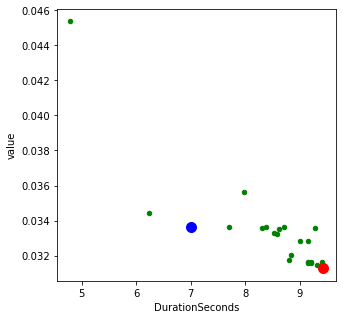

In [15]:
ax1 = imp19_study_df[imp19_study_df.DurationSeconds <= bestRun.DurationSeconds.max()].plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = bestRun.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimumRun.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

In [16]:
#lgb.plot_importance(bestModel, figsize=(10,10))

In [28]:
0.914985/(len(X_valid) * len(X_valid.columns)) * (5079**2 * len(X_valid.columns))/60

1.748717426840463

In [30]:
def getPredictionAndTime(model):
    start = datetime.now()
    prediction = np.rint(model.predict(X_valid, num_iteration=model.best_iteration))
    prediction = [np.argmax(x) for x in prediction]
    end = datetime.now()
    return prediction, end-start
    
bestTunerPrediction, bestTime = getPredictionAndTime(bestModel)
optimumTunerPrediction, optimumTime = getPredictionAndTime(optimumModel)

bestAccuracy = accuracy_score(Y_valid, bestTunerPrediction)
optimumAccuracy = accuracy_score(Y_valid, optimumTunerPrediction)
print(f"Best Accuracy: {bestAccuracy} in {bestTime}\nOptimum Accuracy: {optimumAccuracy} in {optimumTime}")

bestModelName = f"lightGBMBinary{k}_LGBMTunerBest_{tday}.sav"
optimumModelName = f"lightGBMBinary{k}_LGBMTunerOptimum_{tday}.sav"
bestModelPath = os.path.join(os.path.abspath("../notebooks/Models"), bestModelName)
optimumModelPath = os.path.join(os.path.abspath("../notebooks/Models"), optimumModelName)
pickle.dump(bestModel, open(bestModelPath, "wb"))
pickle.dump(optimumModel, open(optimumModelPath, "wb"))
print(f"Wrote best out model to {bestModelPath}\nWrote out optimum model to {optimumModelPath}")
%chime

Best Accuracy: 0.8884942455669306 in 0:00:01.578602
Optimum Accuracy: 0.8884942455669306 in 0:00:00.905001
Wrote best out model to M:\PAG2019\notebooks\Models\lightGBMBinaryBarren_LGBMTunerBest_20211130.sav
Wrote out optimum model to M:\PAG2019\notebooks\Models\lightGBMBinaryBarren_LGBMTunerOptimum_20211130.sav


In [23]:
len(X_valid), optimumTime.microseconds

(224957, 914985)

In [161]:
%%time
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X,y)

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\sklearn\model_selection\_split.py:440: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\sklearn\model_selection\_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.boo

Wall time: 25.2 s


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18580.942578149996, tolerance: 8.875296167711676
  model = cd_fast.enet_coordinate_descent(


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [187]:
imp_coeff.index.tolist(), relevant_features[1:20]

(['Sentinel2_B8A',
  'Sentinel2_B03',
  'MSAVI',
  'Sentinel2_B05',
  'DPR',
  'RGBNmean',
  'REDness',
  'RED',
  'GREEN',
  'GREENness',
  'BLUEness',
  'Sentinel2_B11',
  'NDPI',
  'NIRness',
  'BLUE',
  'NIR',
  'NDVI',
  'Sentinel2_B04',
  'Sentinel2_B08',
  'Sentinel2_B06'],
 Sentinel2_NDWI        0.347446
 NDVI                  0.329615
 Sentinel2_NDMI        0.328725
 GaussianSigma5_NIR    0.300532
 Sentinel2_B08         0.263607
 GaussianSigma2_NIR    0.261988
 DPR                   0.250857
 NIR                   0.248075
 Sentinel2_B07         0.244213
 Sentinel2_B8A         0.243112
 Sentinel2_BSI         0.240286
 Sentinel2_B06         0.236824
 NDPI                  0.214167
 GREENness             0.184640
 MSAVI                 0.182069
 NIR_LHE               0.174637
 Sentinel2_DBSI        0.166850
 RGBNmean              0.166844
 Sentinel2_B11         0.149992
 Name: LCClassInt, dtype: float64)

Best alpha using built-in LassoCV: 1.040277
Best score using built-in LassoCV: 0.361891
Lasso picked 20 variables and eliminated the other 22 variables


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Feature importance using Lasso Model')

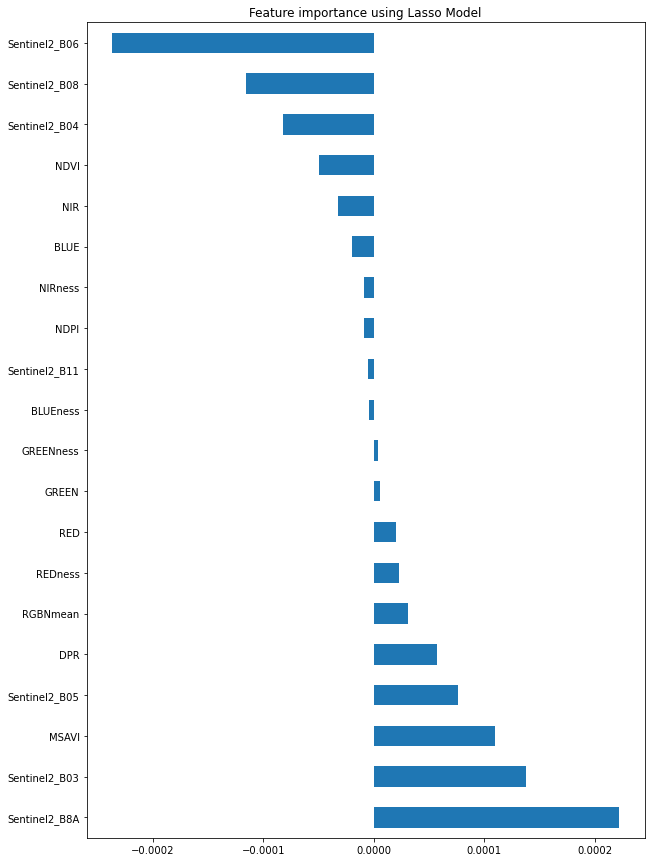

In [182]:
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(X,y))
coef = pd.Series(reg.coef_, index=X.columns)
imp_coeff = coef[coef!=0]
print("Lasso picked " + str(sum(coef!=0)) + " variables and eliminated the other " + str(sum(coef==0)) + " variables")
imp_coeff.sort_values(ascending=False, inplace=True)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,15)
imp_coeff.plot(kind="barh")
plt.title("Feature importance using Lasso Model")

In [37]:
fullBinaryFiles = [os.path.abspath(f) for f in glob("../EPCExtent_30cm/Orthos_Segmented_Classifiedv3/*_TrainingStackV3_BinaryOptunaTunerGBLM.tif")]

with rio.open("../EPCExtent_30cm/Orthos_Segmented_Classifiedv3/W1004789_W449850_TrainingStackV3_BinaryOptunaTunerGBLM.tif") as src:
    bands = src.descriptions
    
for i, name in enumerate(bands):
    print(name)
    vrtopts = gdal.BuildVRTOptions(bandList=[i+1])
    vrtFile = f"C:/Users/BenJames/Downloads/FullBinaryClassification_{name}.vrt"
    if os.path.exists(vrtFile):
        continue
    t = gdal.BuildVRT(vrtFile, fullBinaryFiles, options=vrtopts)
    del t
%chime

Asphault
Barren
DenseVeg
Impervious
IrrigatedLand
PondLake
Pool
SparseVeg
Structure


In [30]:
# Pool at 0.88897777 with 20k or 50k sample size and lgbm tuner
# pool at 0.9992995555 with 50k sample size and optuna lgmb tuner

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def useOptunaOptunaObjective(trainDataset, validDataset, lcClass):
    objectiveStudy = optuna.create_study(study_name=f"lightgbm_ObjectiveTuner_{k}", direction="minimize")

    model = olgb.train(
        params, train_set=trainDataset, valid_sets=[trainDataset, validDataset], verbose_eval=100,
        optuna_callbacks=[mlflow_callback], study=objectiveStudy
    )

    prediction = np.rint(model.predict(X_valid, num_iteration=model.best_iteration))
    accuracy = accuracy_score(Y_valid, prediction)

    best_params = model.params
    print(f"Best params for {k}:", best_params)
    print(f"  {k} Accuracy = {accuracy}")
    print("  Params: ")
    for key, value in best_params.items():
        print(f"    {key}: {value}")


    day = datetime.strftime(datetime.now(), "%Y%m%d")
    model_name = f"lightGBMBinary{k}_OptunaTuner_{day}.sav"
    model_path = os.path.join(os.path.abspath("../notebooks/Models"), model_name)
    pickle.dump(model, open(model_path, "wb"))
    params_path = f"../notebooks/Models/lightBinary{lcClass}Params_{day}.txt"
    with open(params_path, "w+") as txt:
        txt.write(json.dumps(params))
        print(f"Wrote out trained model for {k} to \n\t{model_path} and paramameters to \n\t{params_path}")
    end = datetime.now()
    print(f"Training took {end-start}\n")

    print(best_params)
    
    return objectiveStudy




Best trial:
	score 0.0010724698440817458
	took 2 minutes 22 seconds
	params {
          "lambda_l1": 0.006144408434141018,
          "lambda_l2": 3.5771466455438237
}
Optimum trial (#39): 
	score 0.0010951646608571258 
	took 1 minutes 18.5 seconds 
	params: {
          "feature_fraction": 0.88
}


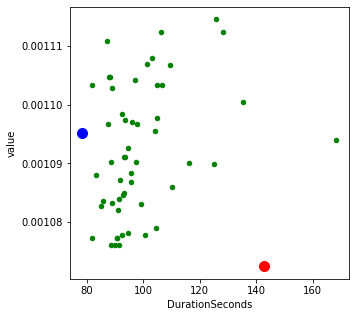

In [131]:
seconds_limit = 70
history = tunerStudy.trials_dataframe()
history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
#history.to_csv(f"./Models/lightGBMBinaryAsphaultStudy_{day}.csv", index=False)
best_params = tunerStudy.best_trial.params
best_score = tunerStudy.best_trial.value
print(f"Best trial:\n\tscore {best_score}\n\ttook {int(tunerStudy.best_trial.duration.seconds/60)} minutes {tunerStudy.best_trial.duration.seconds%60} seconds\n\tparams {json.dumps(best_params, indent=10)}")

best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
highestAccuracy = history[history.value == history.value.min()]
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value < best_score / 0.95)]
optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = tunerStudy.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {round(optimum_time%60,1)} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

Best trial:
	score 0.0007565977694676177
	took 1 minutes 31 seconds
	params {
          "lambda_l1": 0.028664020826938516,
          "lambda_l2": 1.3198683384921155e-08
}
Optimum trial (#20): 
	score 0.000775853596216345 
	took 1 minutes 4.0 seconds 
	params: {
          "num_leaves": 124
}


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


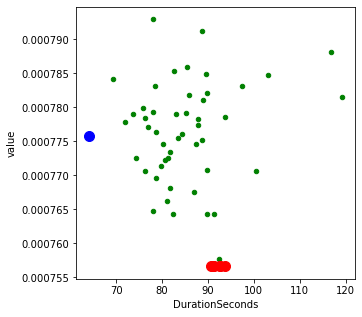

In [49]:
seconds_limit = 70
history = study.trials_dataframe()
history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
history.to_csv(f"./Models/lightGBMBinaryAsphaultStudy_{day}.csv", index=False)
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f"Best trial:\n\tscore {best_score}\n\ttook {int(study.best_trial.duration.seconds/60)} minutes {study.best_trial.duration.seconds%60} seconds\n\tparams {json.dumps(best_params, indent=10)}")

best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
highestAccuracy = history[history.value == history.value.min()]
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value < best_score / 0.95)]
optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = study.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {round(optimum_time%60,1)} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

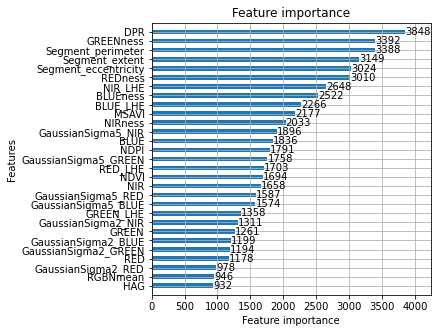

In [99]:
olgb.plot_importance(model, height=0.5, figsize=(5,5))

In [30]:
finished()

In [46]:
from skimage.morphology import binary_closing, binary_opening, square, remove_small_holes, disk, square, remove_small_objects



def removeClassSmaller(array, class_num, min_size):
    non = np.where(array==class_num, 255, array)
    removed = remove_small_objects(array==class_num, min_size=min_size, connectivity=1)
    array_rem = np.where(removed==0, non, array)
    return array_rem



In [47]:
with rio.open("../EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W989789_W439850_TrainingStackV3_AsphaultBinaryLGBNewishGBLM.tif") as src:
    asphault = src.read(1)
    kwargs = src.profile

with rio.open("C:/Users/BenJames/Downloads/testAsphault.tif", "w", **kwargs) as dst:
    dst.write(cleanupAsphault(asphault).astype(np.uint8), 1)

